In [2]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools

import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import bokeh.io
import bokeh.plotting
from bokeh.palettes import Spectral11
from scipy.signal import butter, lfilter, freqz, find_peaks, correlate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
#from Butterworth_Filter import butter_bandpass, butter_bandpass_filter
import glob
from quantities import ms, s, Hz
#from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
import math
from collections import Counter
import scipy


import networkx as nx

from time import strftime
%matplotlib inline





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# helper line -> get different outpaths for sorted datasets; uncheck the date

#191021
mainpath = r'D:\Files_Reutlingen_Jenny\main_191021'
#outpath = r'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting'
# outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting'
outpath = 'D:\Files_Reutlingen_Jenny\main_191021\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'



#191021extra
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191021extra'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_19042021_aCSF_adult_15min_spont_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_23042021_hCSF_adult_20min_spont0002_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191021extra\_output_Spikesorting_29042021_hCSF_child_20min_spont_spikesorting'


#191017
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191017'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191017\_output_Spikesorting_30042021_spontaneous_spikesorting'



#191023
#mainpath = 'D:\Files_Reutlingen_Jenny\main_191023'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_DNQX_AP5_washin0001_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_hCSF_afterDNQX_AP5_washin_spikesorting'
#outpath = 'D:\Files_Reutlingen_Jenny\main_191023\_output_Spikesorting_29042021_spontaneous_spikesorting'


#aachen 15.05.2021
#mainpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4'
#outpath = r'D:\MEA_DATA_Aachen\ANALYZED\20210510_cortex_div4\_output_Spikesorting_07062021_cortex_div4_hCSF_ID039_nodrug_spont_1_spikesorting'


labeldic =  np.load(
    'D:\Files_Reutlingen_Jenny\_layerdictionaries\labeldictionary_MCS_256MEA.npy', 
    allow_pickle='TRUE').item() 

In [ ]:
# helper line for Aachen Data


In [3]:
os.chdir(mainpath)
folderlist = glob.glob('*_output_Spikesorting*spikesorting*')

NameError: name 'mainpath' is not defined

In [4]:
# loading functions

def load_dumped_subrecordings(directory, filebase):

    subrecording_dic = {}
    filelist = glob.glob('*recording.pkl')
    for file in filelist:
        key = file.split(filebase)[1].split('.')[0].split('_recording')[0]
        subrecording_dic[key]=se.load_extractor_from_pickle(file)
        
    return subrecording_dic
        
    
def load_dumped_sorted_dic(outpath):

    sorted_dic = {}
    filelist = glob.glob('*sorted*')
    for file in filelist:
        key = file.split('sorted_')[1]
        sorted_dic[key]=se.SpykingCircusSortingExtractor(file)
        
    return sorted_dic


# function to get the filebase from folder
def get_filebase_from_foldername(mainpath_folder):
    
    separator = '_'
    filebase = separator.join(mainpath_folder.split('\\')[-1].split('_')[4:-1])
    
    return filebase




def get_dictionary_keys(outpath_folder):

    dictkeys = []
    os.chdir(outpath_folder)
    folders_sorting = glob.glob('*sorted*')
    for i in folders_sorting:
        dk = i.split('sorted_')[1]
        dictkeys.append(dk)
    
    return dictkeys, print('Dictkeys are %s. Your CWD may have changed. Please check.' %dictkeys)



# function to convert basic information to dataframe
def units_to_pandas_DataFrame(sorted_dic, recording_cache, dictkey, layerdic_invert, recordingdate='not given'):
    
    # creates pandas DataFrame only including the unit ids. the order will be confused because of the unit numbering ('1' instead of '001')
    unit_ids = sorted_dic[dictkey].get_unit_ids()
    unitframe = pd.DataFrame(
        sorted_dic[dictkey].get_unit_ids(), 
        columns=['unit_ids']
        )
    
    
    list_not_empty_spiketrains = []
    for i in unit_ids:
        st_len = len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        if st_len > 0:
            list_not_empty_spiketrains.append(i)
    
    
    # calculate as many paramters as possible outside of the loop
    recordings_seconds = recording_cache[dictkey].get_num_frames()/recording_cache[dictkey].get_sampling_frequency()
        
    for i in list_not_empty_spiketrains:  
        
        # add channel with maximum amplitude
        unitframe.loc[(unitframe['unit_ids']==i), 'max_channel']=st.postprocessing.get_unit_max_channels(
            recording_cache[dictkey], sorted_dic[dictkey], unit_ids=[i]
            )
        
        unitframe.loc[(unitframe['unit_ids']==i), 'unit_index']=unitframe.loc[(unitframe['unit_ids']==i)].index
    
        # get the channel label as on MCS MEA 256 chips
        max_channel = int(unitframe.loc[(unitframe['unit_ids']==i)]['max_channel'])
        unitframe.loc[(unitframe['unit_ids']==i), 'channellabel']= labeldic[max_channel]
        
        # get the number of spiks per unit
        unitframe.loc[(unitframe['unit_ids']==i), 'n_spikes']=len(sorted_dic[dictkey].get_unit_spike_train(unit_id=i))
        
        # add firing rate
        unitframe.loc[(unitframe['unit_ids']==i), 'firing_rate']= unitframe.loc[(unitframe['unit_ids']==i)]['n_spikes']/recordings_seconds
        
        # add layer
        labelkey = unitframe.loc[(unitframe['unit_ids']==i), 'channellabel'].values[0]
        unitframe.loc[(unitframe['unit_ids']==i), 'layer']= layerdic_invert[labelkey]
        
       
        unitframe.loc[(unitframe['unit_ids']==i), 'file']=filebase
        unitframe.loc[(unitframe['unit_ids']==i), 'subrecording']=dictkey
        unitframe.loc[(unitframe['unit_ids']==i), 'recordingdate']=recordingdate
        # verify if this line works
        #unitframe.loc[(unitframe['unit_ids']==i), 'medium']=unitframe.loc[(unitframe['unit_ids']==i)]['file'].split('_')[0]
        
    return unitframe




def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert
    

In [5]:
folderlist

['_output_Spikesorting_30042021_hCSF_adult_20min_spont0001_spikesorting',
 '_output_Spikesorting_30042021_hCSF_adult_20min_spont_spikesorting',
 '_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting']

In [6]:
# get a filebaselist for every folder in the mainpath, that we we can filter 

filebase_list = []
for i in folderlist:
    filebase = get_filebase_from_foldername(i)
    filebase_list.append(filebase)

In [7]:
filebase_list

['hCSF_adult_20min_spont0001',
 'hCSF_adult_20min_spont',
 'hCSF_child_20min_spont0001']

In [15]:
filebase=filebase_list[2]

In [16]:
os.chdir(outpath)

In [17]:
#reutlingen data

completeframe = pd.read_pickle('DF_hCSF_child_20min_spont0001_complete_df.pkl')

# aachen data
#completeframe = pd.read_pickle(str('DF_' + filebase + '_' + 'complete') + '_df.pkl')

In [18]:
completeframe['unit_ids2'] = completeframe['unit_ids']

In [19]:
#completeframe.loc[(completeframe['subrecording']=='sec_0-300')]

In [20]:
# load spiketrains
st_channel = np.load(filebase+'_spiketrains_per_channel.npy', allow_pickle='TRUE').item()
st_neurons = np.load(filebase+'_spiketrains_per_unit.npy', allow_pickle='TRUE').item()
st_channels_neurons = np.load(filebase+'_spiketrains_nested_per_channel_per_unit.npy', allow_pickle='TRUE').item()

In [37]:
# threshold spiketrains 
path = r'D:\MEA_DATA_Aachen\ANALYZED\2021-05-17_cortex_div11_hCSF_ID046_nodrug_spont_2_analyzed_on_04082021'
file = r'2021-05-17T12-21-29__cortex_div11_hCSF_ID046_nodrug_spont_2__.h5_spikes_MAD_dict.npy'



In [38]:
st_channel = np.load(os.path.join(path, file), allow_pickle=True).item()

In [39]:
st_channel

{'G13': array([ 864047.,  984522., 1868440.]),
 'G12': array([], dtype=float64),
 'F16': array([], dtype=float64),
 'F15': array([  67619.,  864067.,  983393.,  983534.,  984327.,  984559.,
         984820.,  985222.,  985729.,  985938.,  986163.,  986279.,
         986496.,  986621.,  987166.,  987569.,  988315.,  989378.,
         989832.,  990866.,  991851.,  991947.,  992817.,  993424.,
         993578.,  994230.,  995209.,  996140.,  997235.,  997376.,
         998194.,  999129.,  999231.,  999364., 1000437., 1001633.,
        1001721., 1002950., 1003066., 1005552., 1005712., 1007020.,
        1007158., 1008351., 1009960., 1011220., 1011332., 1012572.,
        1012683., 1014287., 1014420., 1016976., 1017141., 1017377.,
        1866145., 1867723., 1868385., 1868528., 1868664., 1868936.,
        1869203., 1869673., 1869782., 1869923., 1870098., 1870312.,
        1870666., 1871068., 1871165., 1871338., 1871589., 1872095.,
        1872337., 1872753., 1874424., 1874604., 1874734., 1875

In [42]:
filebase = file.split('__')[1]
filebase

'cortex_div11_hCSF_ID046_nodrug_spont_2'

# old functions from ISI Burst Detection

In [9]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1



def find_binned_spikes(data, bins):
    '''
    Parameters
    ----------
    data : for network spike binning --> expects an 1D array with all spikes detected for the network
    bins : list of tuples of expected bins

    Returns
    -------
    binlist : list of lists where lists contain all spikes for the respective bins

    '''
    binlist =[]
    binspike =[]
    for i in range(0, len(bins)):
        binspike = []
        for a in data:    
            if bins[i][0] <= a < bins[i][1]:
                binspike.append(a)
        binlist.append(binspike)
            
    return binlist




def get_isi_singlechannel(spikedic, tick):
    '''
    Parameters
    ----------
    spikedic : dictionary with all detected spikes for a channel
        DESCRIPTION.

    Returns
    -------
    isidic : keys = channels, values = List of tuples where tuple[0]=detected spike and tuple[1]=isi to the next detected spike
    isi_alone_dic : keys = channels, values = list of isi alone
    CAVE returns are in microseconds
    '''
    
    isidic ={}     
    isilist = []
    isi_alone_dic = {}
    isislist =[]

    for key in spikedic:
        isilist = []
        isislist = []
        if len(spikedic[key])>=2:
            for i in range(0, (len(spikedic[key])-1)):
                isi = spikedic[key][i]*tick, (spikedic[key][i+1]-spikedic[key][i])*tick #CL tick für beide dazu
                isi_alone = (spikedic[key][i+1]-spikedic[key][i])*tick
                isilist.append(isi)
                isislist.append(isi_alone)
        isidic[key]=isilist
        isi_alone_dic[key]=isislist
        
    return isidic, isi_alone_dic



def bin_isi(isi_alone_dic, binsize, binmax=bool, binmaxnumber=None):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per bin

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_bins(0, binsize, binmaxnumber)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ISI_dic


def bin_lnisi(isi_alone_dic, start_in_microseconds, stop_in_microseconds, totalbins, binmax):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel 
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per logarithmic spaced bins

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ln_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_ln_bins(start_in_microseconds, stop_in_microseconds, totalbins)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ln_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ln_ISI_dic, isibins


def get_allchannel_ISI_bins(histo_ISI_dic):
    '''
    Parameters
    ----------
    histo_ISI_dic : dic mit den einzelnen ISI für jeden Channel. Cave, die Values müssen alle die gleiche
                    Länge haben, sonst funktioniert die zip Funktion nicht.
        DESCRIPTION.

    Returns
    -------
    network_ISI_binned = array of all ISI of the whole network binned

    '''
    network_ISI = []
    for key in histo_ISI_dic:
        list1 = histo_ISI_dic[key]
        if len(list1)>len(network_ISI):
            network_ISI=list1
        else:
            list2 = network_ISI
            network_ISI = [a + b for a, b in zip(list1, list2)]
    return np.array(network_ISI)


def get_burst_threshold(df_with_CMA):
    '''
    

    Parameters
    ----------
    df_with_CMA : TYPE
        DESCRIPTION.

    Returns
    -------
    CMAalpha : TYPE
        DESCRIPTION.
    CMAalpha2 : TYPE
        DESCRIPTION.
    maxCMA : TYPE
        DESCRIPTION.
    alpha1 : TYPE
        DESCRIPTION.
    alpha2 : TYPE
        DESCRIPTION.

    '''
    
    networkburstthreshold_ISI = 200000 #wie im paper maximal bei 200 ms als isi
    skewness = scipy.stats.skew(network_ISI)
    if skewness < 1:
        alpha1 = 1
        alpha2 = 0.5
    elif skewness >= 1 and skewness <4:
        alpha1 = 0.7
        alpha2 = 0.3
    elif skewness >=4 and skewness <9:
        alpha1 = 0.5
        alpha2 = 0.3
    elif skewness >=9:
        alpha1 = 0.3
        alpha2 = 0.1
    maxCMA = max(df_with_CMA['CMA'])
    CMAalpha = maxCMA*alpha1
    CMAalpha2 = maxCMA*alpha2
    return CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2


def ISI_threshold_min(df_with_CMA, CMAalpha, CMAalpha2, binsize_in_micros):
    '''
    '''
    indexfactor = df[df['CMA']>CMAalpha].index[-1] + 1
    indexfactor2 = df[df['CMA']>CMAalpha2].index[-1] + 1
    threshold_intraburst = float(indexfactor*binsize_in_micros)
    threshold_burst_related = float(indexfactor2*binsize_in_micros)
    
    return threshold_intraburst, threshold_burst_related


def find_burst_starts(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            #print('burst '+str(setter))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


def find_burst_starts_and_length(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststart_spike = spikedic[key][counter]*tick
                        burstend_spike = spikedic[key][counter+setter]*tick
                        #burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            burstend_spike = spikedic[key][counter+setter]*tick
                            #print('burst '+str(setter))
                        burststartlist.append((burststart_spike, burstend_spike))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


# trial of burst detection

In [43]:
tick = 40
scale_factor_for_second = 1e-06
scale_factor_for_milisecond = 1e-03

In [44]:
isidic, isi_alone = get_isi_singlechannel(st_channel, tick) #creates two dictionaries
histo_ISI_dic=bin_isi(isi_alone, binsize=1000, binmax=True, binmaxnumber=600) # dictionary für jeden channel mit 300x 10ms bins (binsize) und der Menge an ISI für die jeweilige Länge
network_ISI=get_allchannel_ISI_bins(histo_ISI_dic) #gibt ein array mit bins entsprechend der bins aus der Vorfunktion


(array([415.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 136.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  29.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
          0.,   0.,   0.,   0.,   0., 

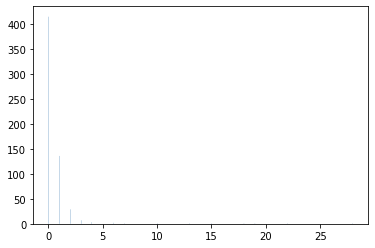

In [45]:
plt.hist(network_ISI, bins=1000, histtype='stepfilled', color='steelblue',edgecolor='none')


In [46]:
colors = ['green', 'blue', 'orange', 'purple']

<AxesSubplot:title={'center':'Histogram of ISI-bins 10ms whole network'}>

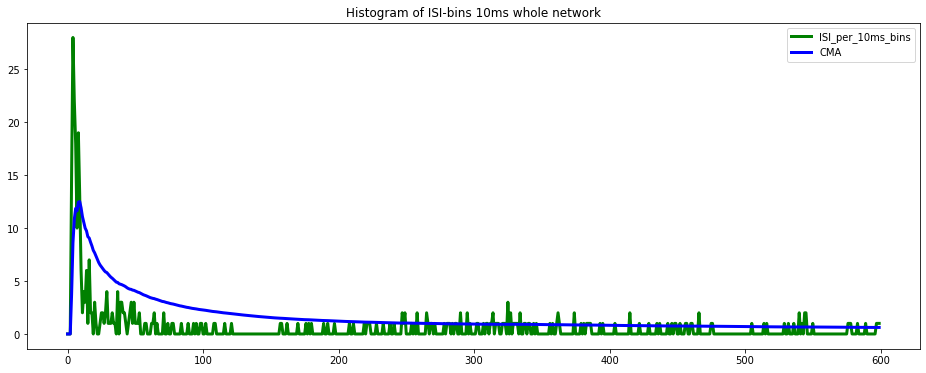

In [47]:
df= pd.DataFrame({'ISI_per_10ms_bins':network_ISI}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["CMA"] = df.ISI_per_10ms_bins.expanding().mean()
df[['ISI_per_10ms_bins', 'CMA']].plot(color=colors, linewidth=3, figsize=(16,6), title="Histogram of ISI-bins 10ms whole network")

In [49]:
os.chdir(path)

In [50]:
CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2=get_burst_threshold(df) # threshold calculation
threshold_intraburst, threshold_burst_related = ISI_threshold_min(df, CMAalpha, CMAalpha2, 1000) #set thresholds

In [51]:
threshold_intraburst

26000.0

In [52]:
threshold_burst_related

56000.0

In [57]:
threshold_burst_related = 100000

In [24]:
# threshold_intraburst = 200000

In [25]:
burststartdic = find_burst_starts(isi_alone, threshold_intraburst, st_neurons) #dictionary mit allen burststarts


R12
R123
R124
R125
R126
R127
R128
R129
R1210
R1211
R1212
R1213
R1214
R1215
R1216
R1217
R1218
R1219
R1220
R1221
R1222
R1223
R1224
R1225
R1226
R1227
R1228
R1229
R1230
R1231
R1232
R1233
R1234
R1235
R1236
R1237
R1238
R1239
R1240
R1241
R1242
R1243
R1244
R1245
R1246
R1247
R1248
R1249
R1250
R1251
R1252
R1253
R1254
R1255
R1256
R1259
R1260
R1261
R1262
R1263
R1264
R1265
R1266
R1267
R1268
R1269
R1270
R1271
R1272
R1273
R1274
R1275
R1276
R1277
R1278
R1279
R1280
R1281
R1284
R1285
R1286
R1287
R1288
R1289
R1290
R1291
R1294
R1295
R1296
R1297
R1298
R1299
R12100
R12101
R12102
R12103
R12104
R12105
R12106
R12107
R12108
R12109
R12110
R12111
R12112
R12113
R12114
R12115
R12116
R12117
R12118
R4
R41
R44
R45
R46
R47
R410
R411
R412
R413
R414
R415
R418
R419
R422
R423
R424
R425
R426
R427
R428
R429
R430
R431
R432
R433
R434
R435
R436
R437
R438
R439
R440
R441
R442
R443
R444
R445
R446
R447
R448
R449
R450
R451
R452
R453
R454
R455
R456
R457
R458
R461
R462
R463
R464
R465
R466
R470
R471
R472
R473
R476
R479
R482
R483
R484
R

KeyError: 'R4'

In [28]:
burststartdic

{0: [],
 1: [29896520, 30641840, 62638920, 68718360, 90206680, 96350040],
 2: [68715800],
 3: [68718920],
 10: [],
 11: [29791400, 30822000, 76678640, 78044080],
 12: [30563360, 32942520, 34494560, 76852880, 79235400, 80038720],
 13: [32538760, 33142120],
 7: [30250040, 31961480, 33532440, 77194280, 77834800, 80280680, 81733200],
 8: [171680, 23015920, 30008520, 35978560, 76547320],
 9: [29936560,
  33729400,
  66821120,
  69896640,
  76722480,
  103641520,
  116421560,
  118509320,
  119550520],
 100: [30013480, 32422920, 33464600, 34229520, 76719360, 78378040, 79234120],
 101: [30405280, 77410040],
 98: [30026200, 76696560, 77218600],
 99: [30584400, 32778360, 76769640, 77351200, 77879280, 78746640],
 102: [10214680, 110957760, 112282080],
 103: [30408840, 76975800],
 104: [271440,
  13254760,
  17161600,
  22269120,
  25154960,
  29916160,
  34253160,
  42335400,
  43528280,
  59273880,
  64749760,
  66750720,
  69396920,
  72064360,
  77384080,
  78344320,
  81085680,
  89043360,
 

In [22]:
# bursts for intraburst thresholds
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_intraburst, st_channel) 

In [58]:
# bursts for burst related spikes after Kapucu 2012
burststart_end_dic = find_burst_starts_and_length(isi_alone, threshold_burst_related, st_channel) 

In [59]:
burststart_end_dic

{'G13': [],
 'G12': [],
 'F16': [],
 'F15': [(39335720.0, 40576800.0),
  (74708920.0, 75035800.0),
  (75147680.0, 75884880.0),
  (101109160.0, 102138600.0)],
 'F14': [],
 'F13': [],
 'F12': [],
 'E16': [],
 'E15': [],
 'E14': [],
 'E13': [],
 'G11': [],
 'D16': [],
 'D15': [],
 'D14': [],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [],
 'B14': [],
 'G10': [],
 'E12': [],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [],
 'C10': [],
 'D10': [],
 'A10': [],
 'B10': [],
 'D9': [],
 'E9': [],
 'B9': [],
 'C9': [],
 'F9': [],
 'A9': [],
 'G8': [],
 'G9': [],
 'A8': [],
 'F8': [],
 'C8': [],
 'B8': [],
 'E8': [],
 'D8': [],
 'B7': [],
 'A7': [],
 'D7': [],
 'C7': [],
 'A6': [],
 'E7': [],
 'C6': [],
 'B6': [],
 'E6': [],
 'D6': [],
 'B5': [],
 'A5': [],
 'D5': [],
 'C5': [],
 'A4': [],
 'F7': [],
 'C4': []

In [60]:
scale_factor_for_second = 1e-06

to do
- get burst starts - burst ends for every channel 
- find channels that overlap -> definition of networks bursts

In [190]:
for key in burststartdic:

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts, linelengths = 1.0, color='red')
    ax.eventplot(array, linelengths=0.5, color='black')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    #ax.set_title(filename+' Channel '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

NameError: name 'burststartdic' is not defined

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G13 Burststarts')

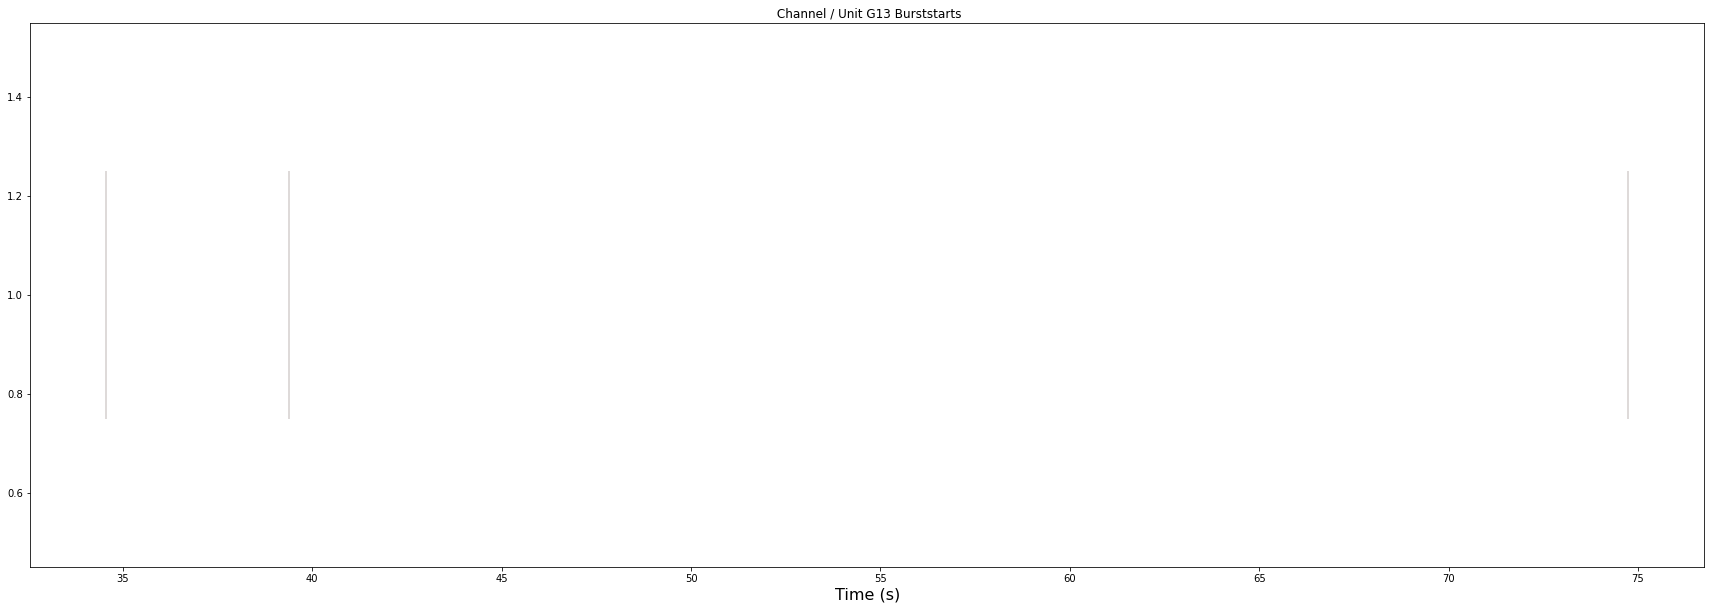

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G12 Burststarts')

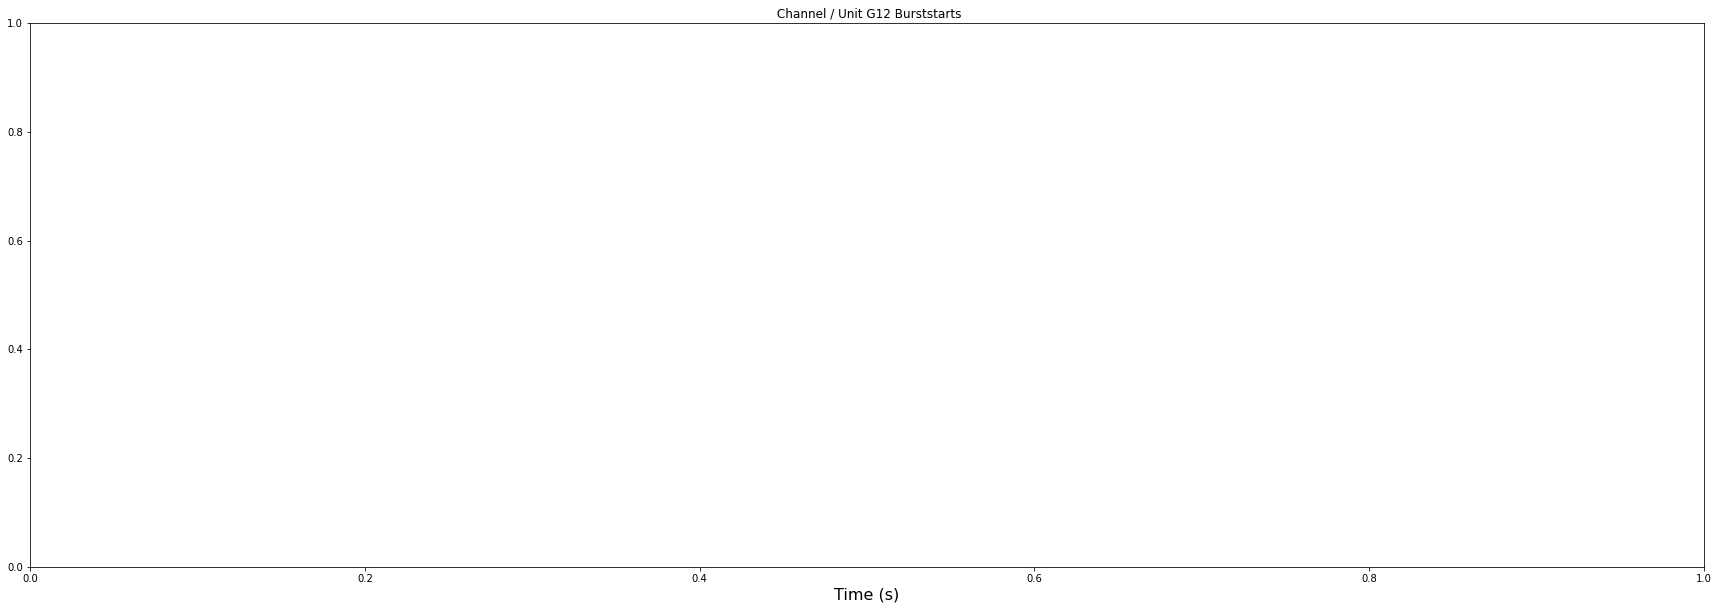

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F16 Burststarts')

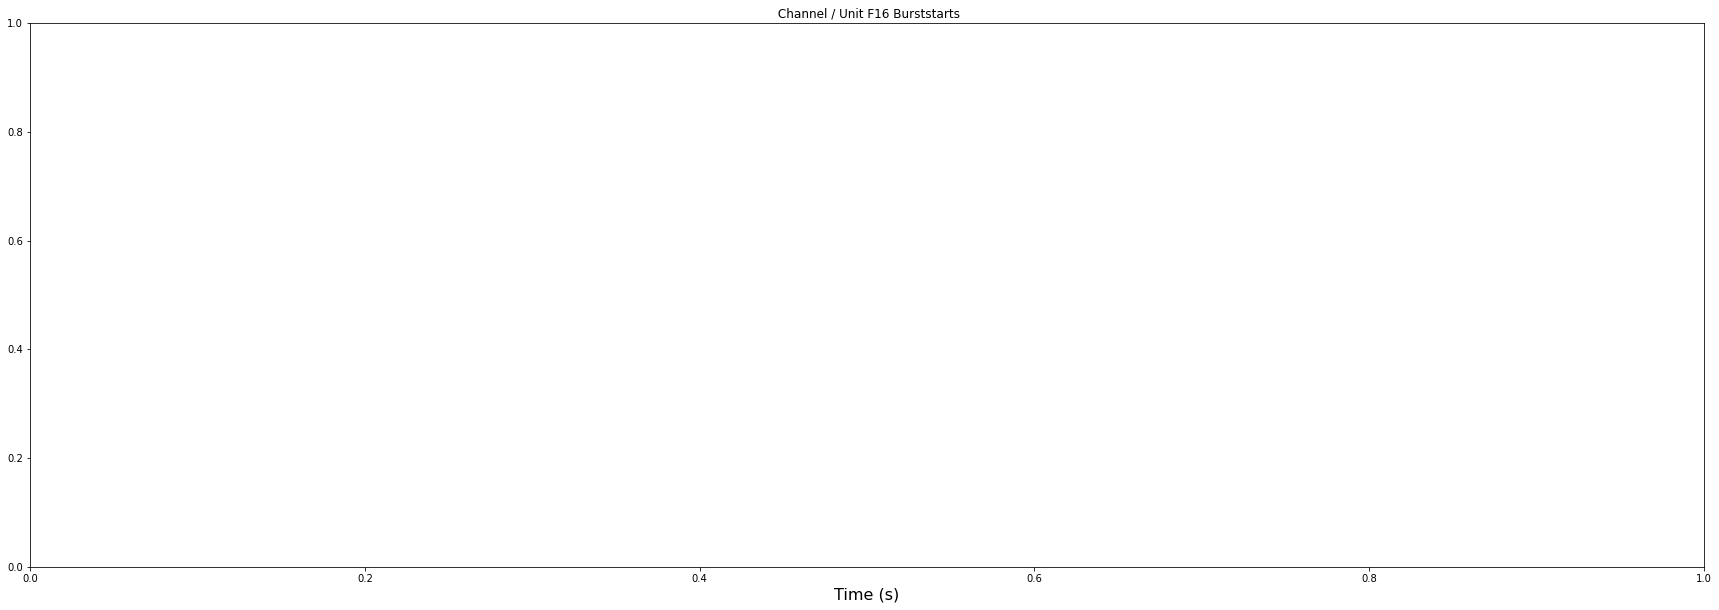

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F15 Burststarts')

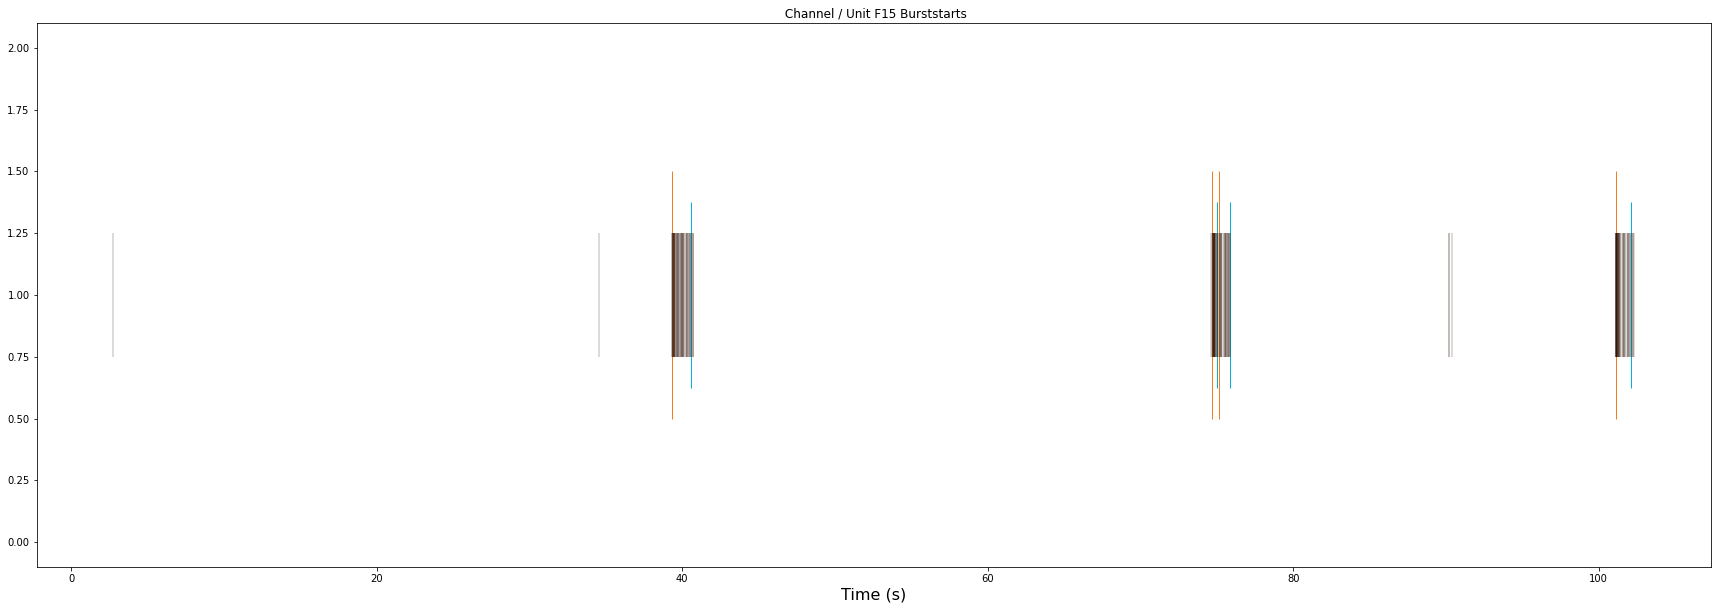

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F14 Burststarts')

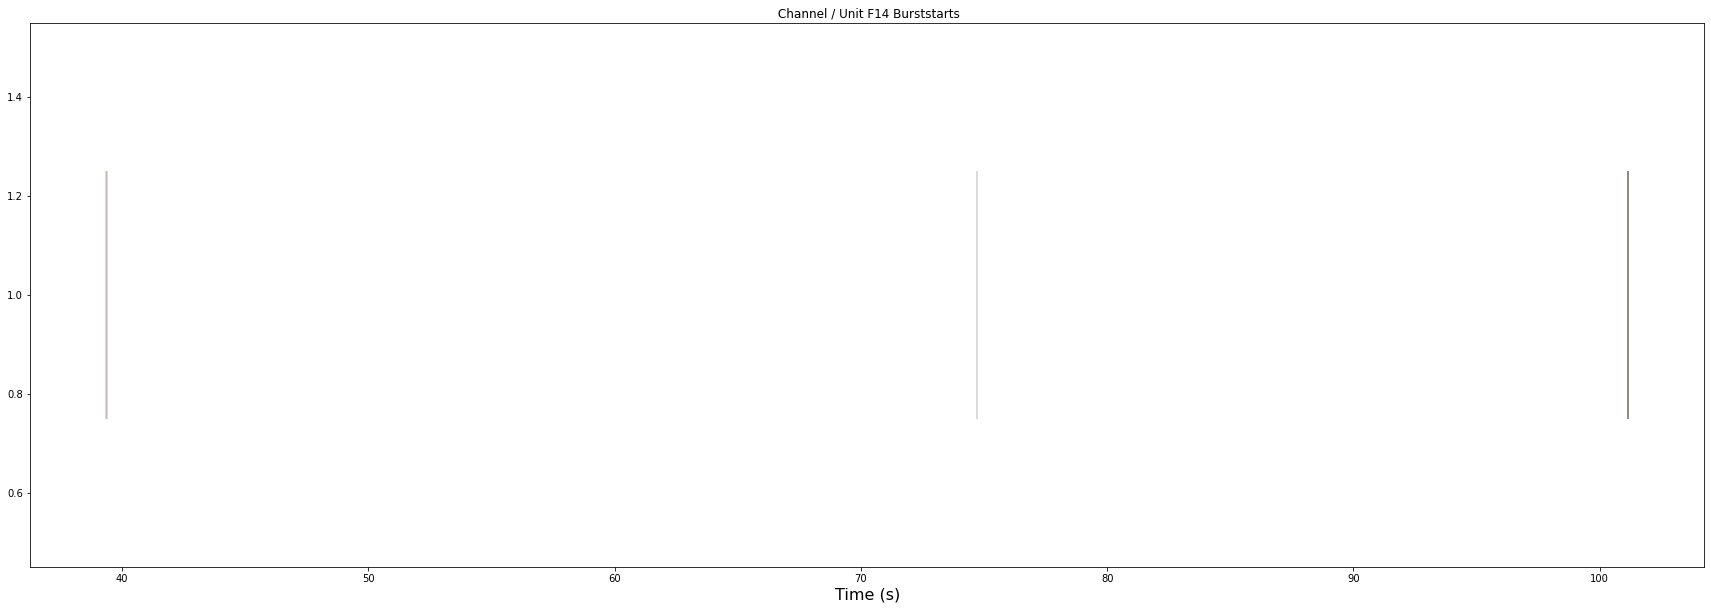

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F13 Burststarts')

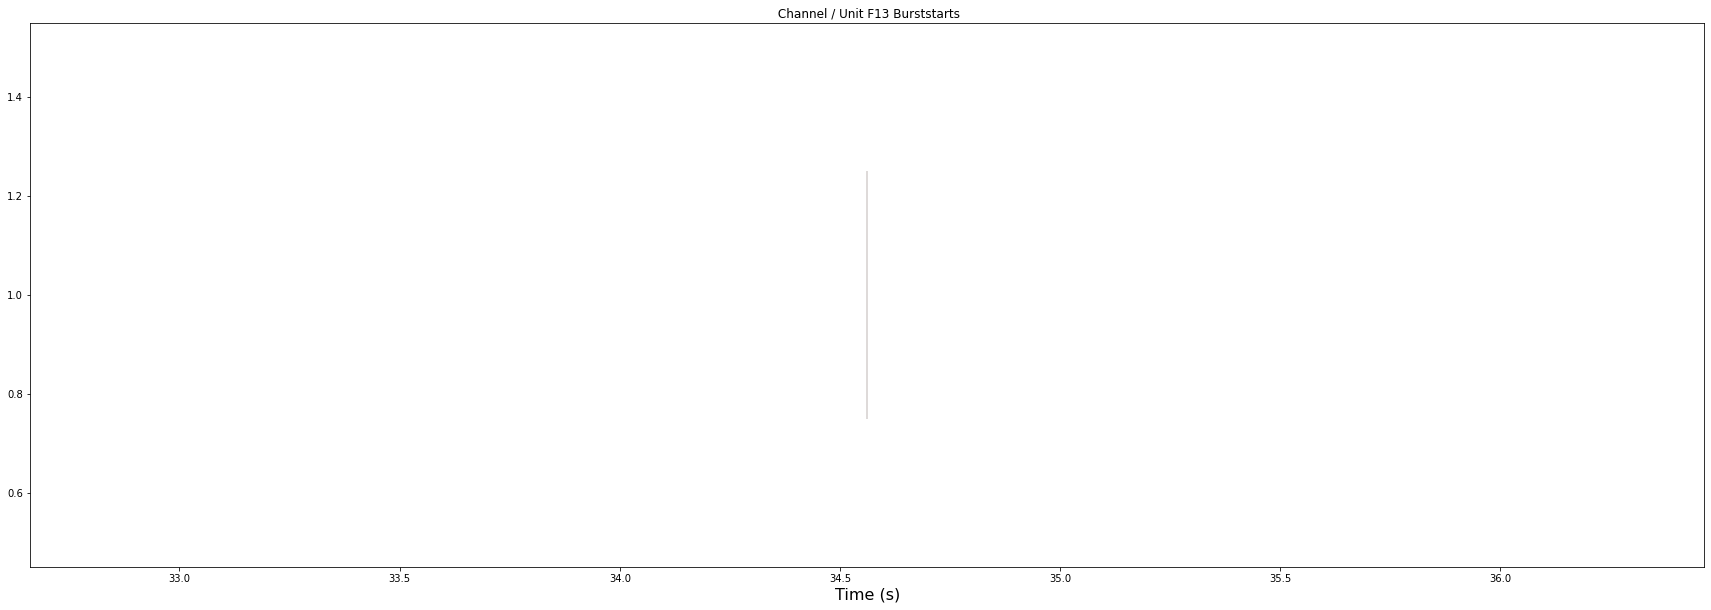

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F12 Burststarts')

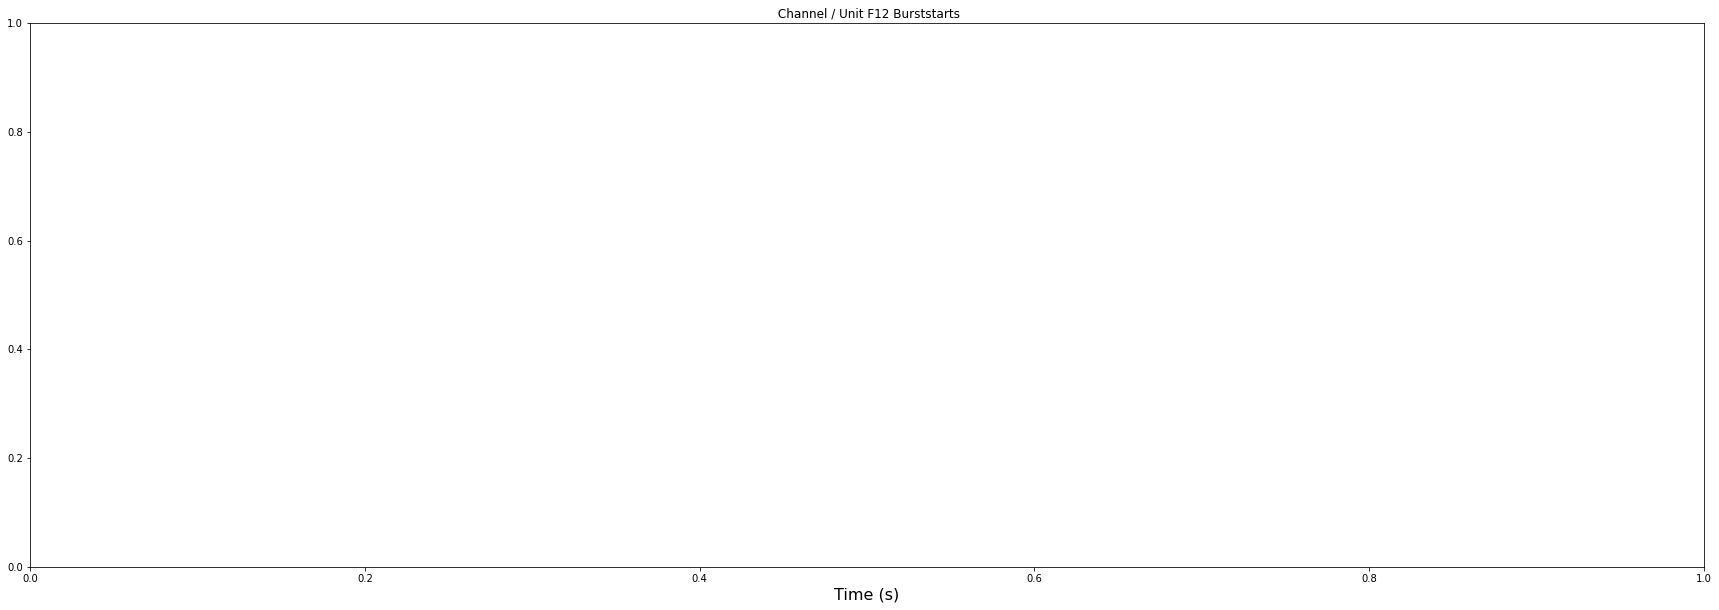

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E16 Burststarts')

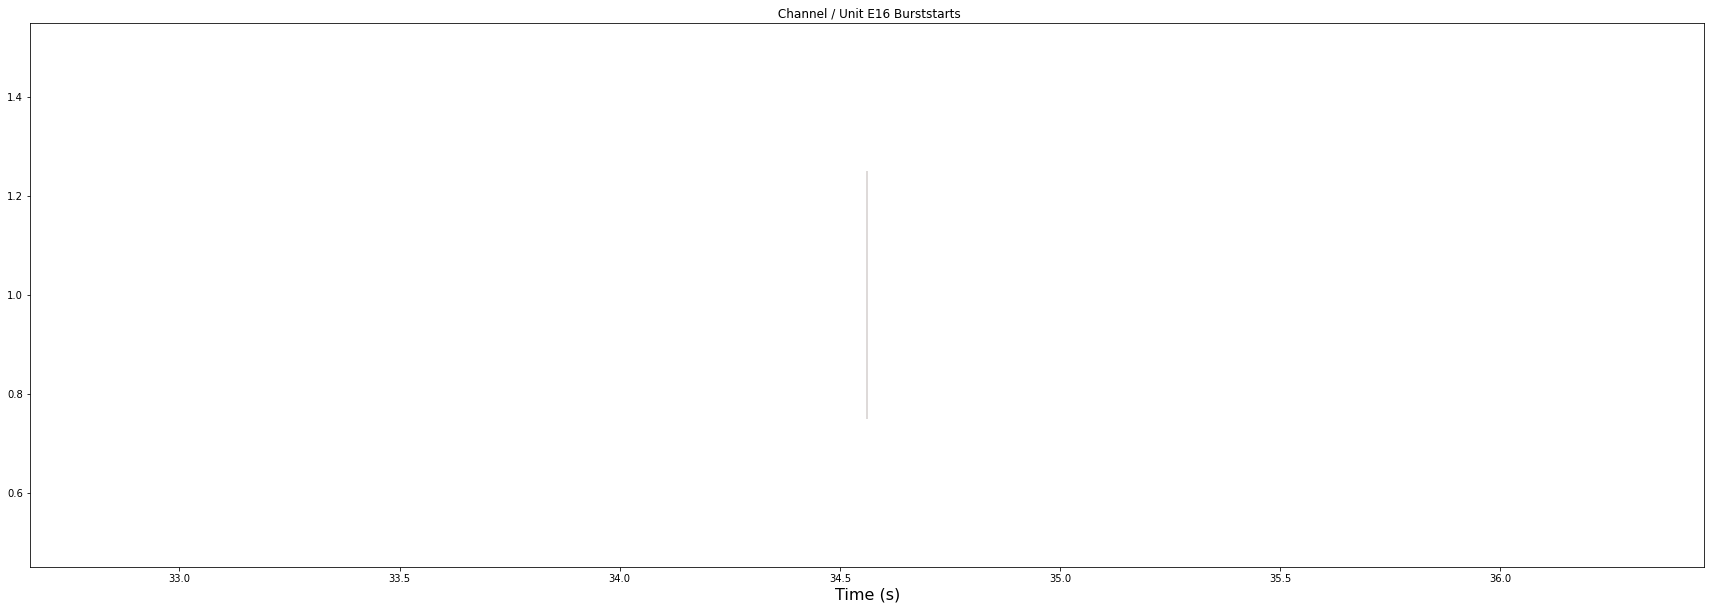

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E15 Burststarts')

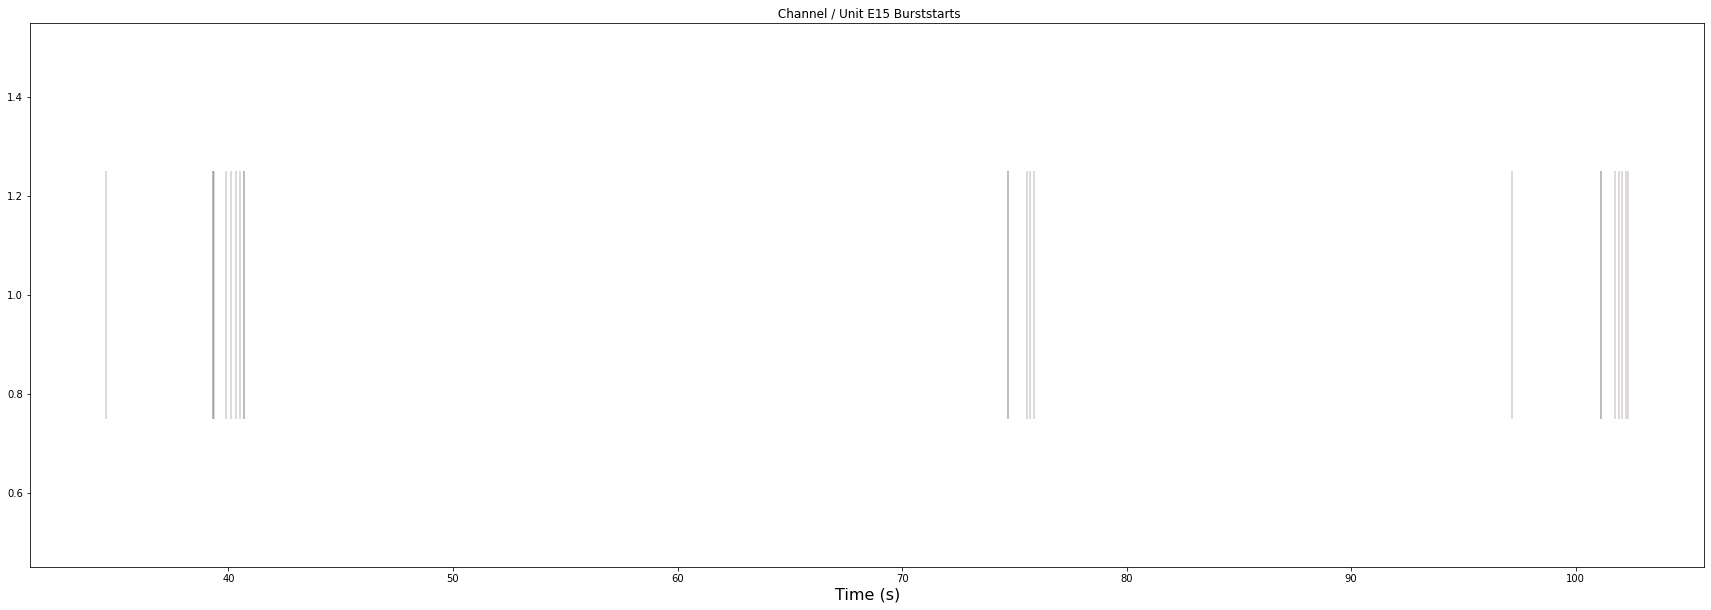

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E14 Burststarts')

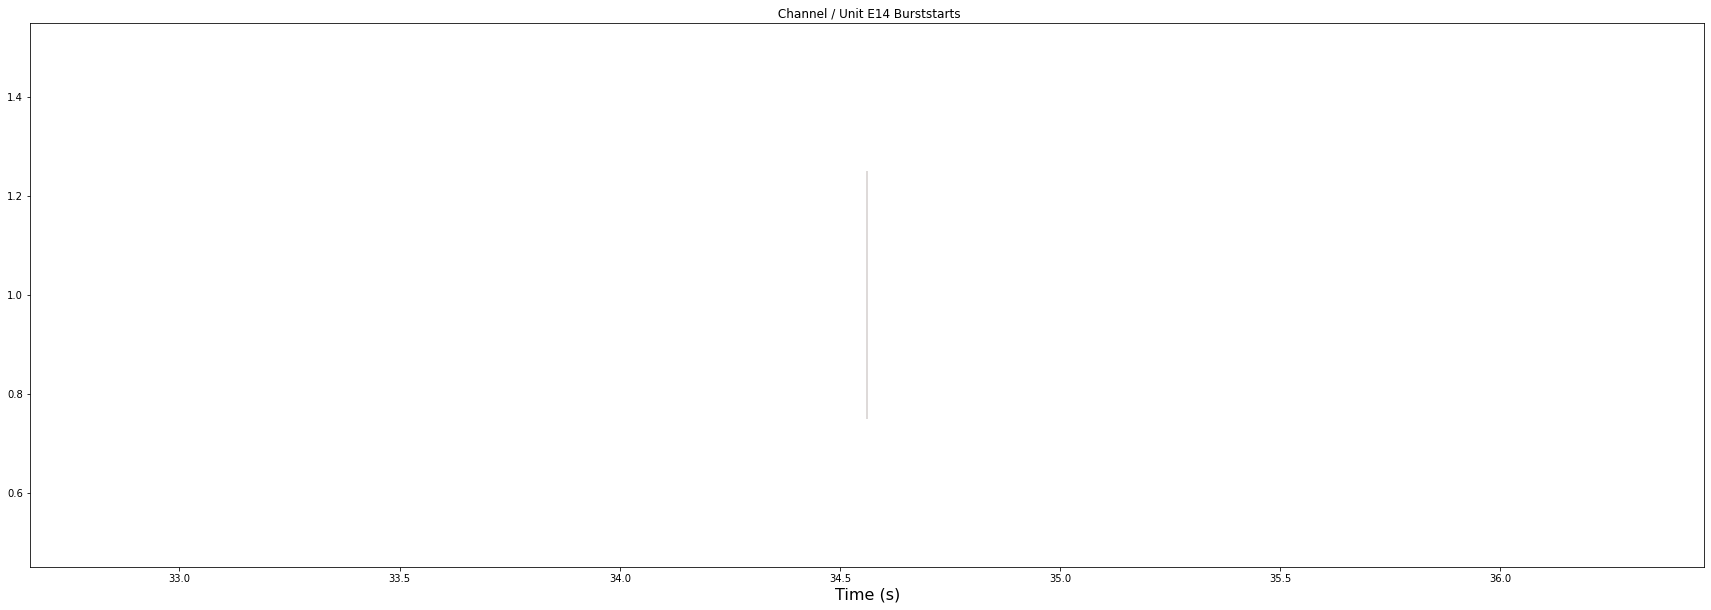

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E13 Burststarts')

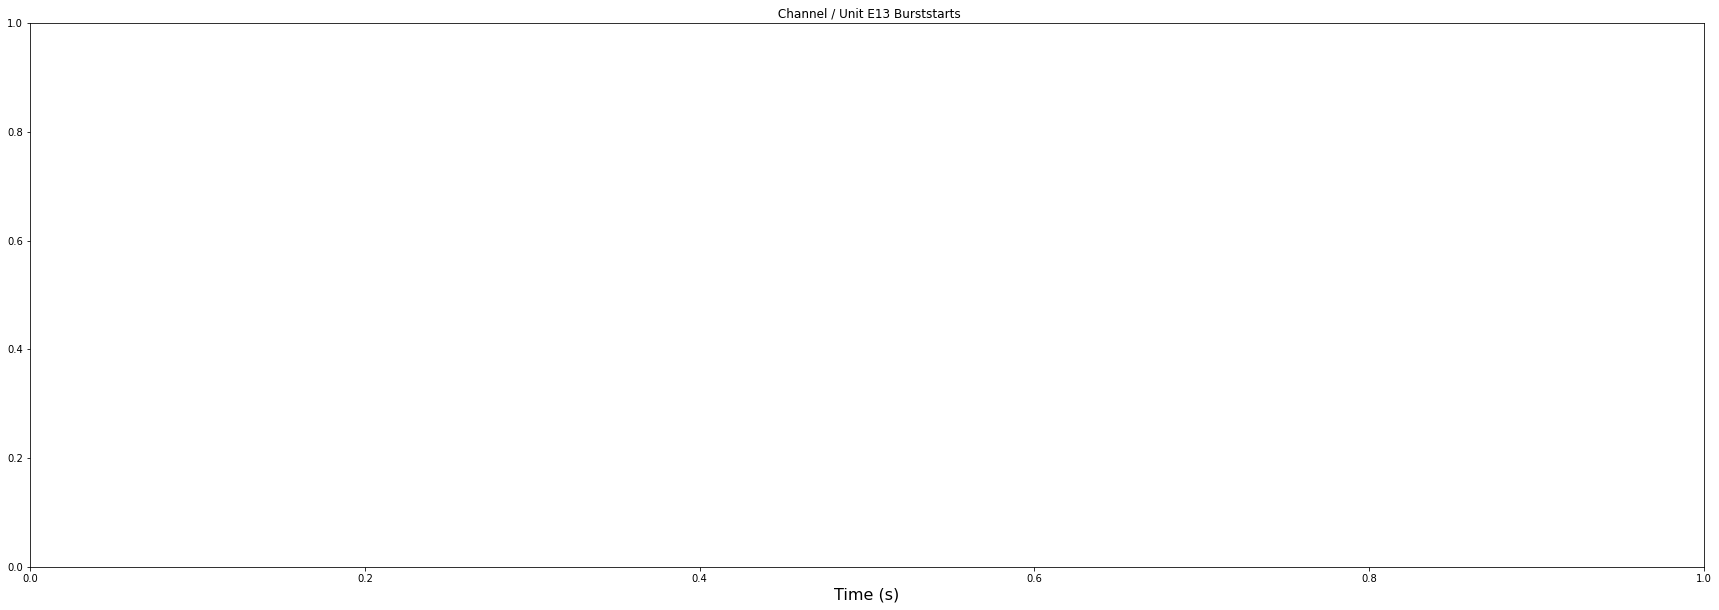

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G11 Burststarts')

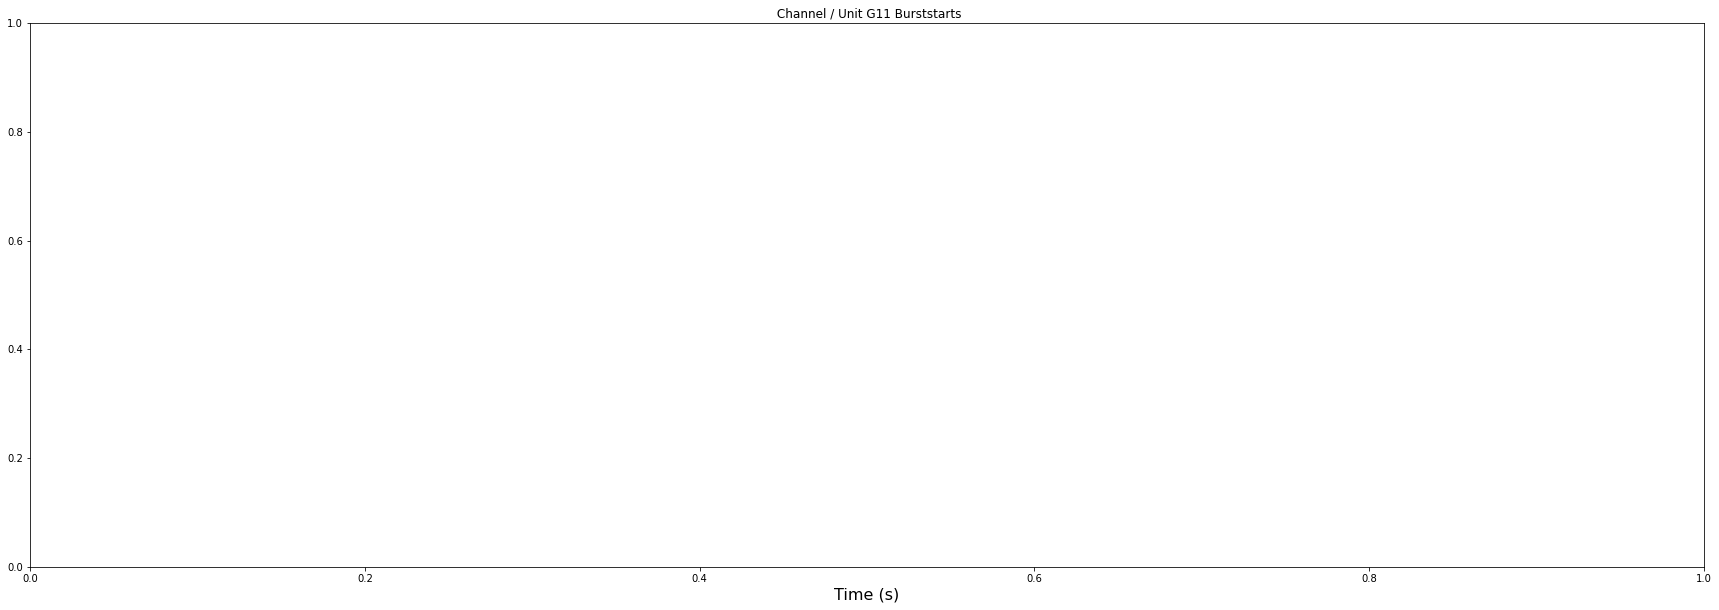

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D16 Burststarts')

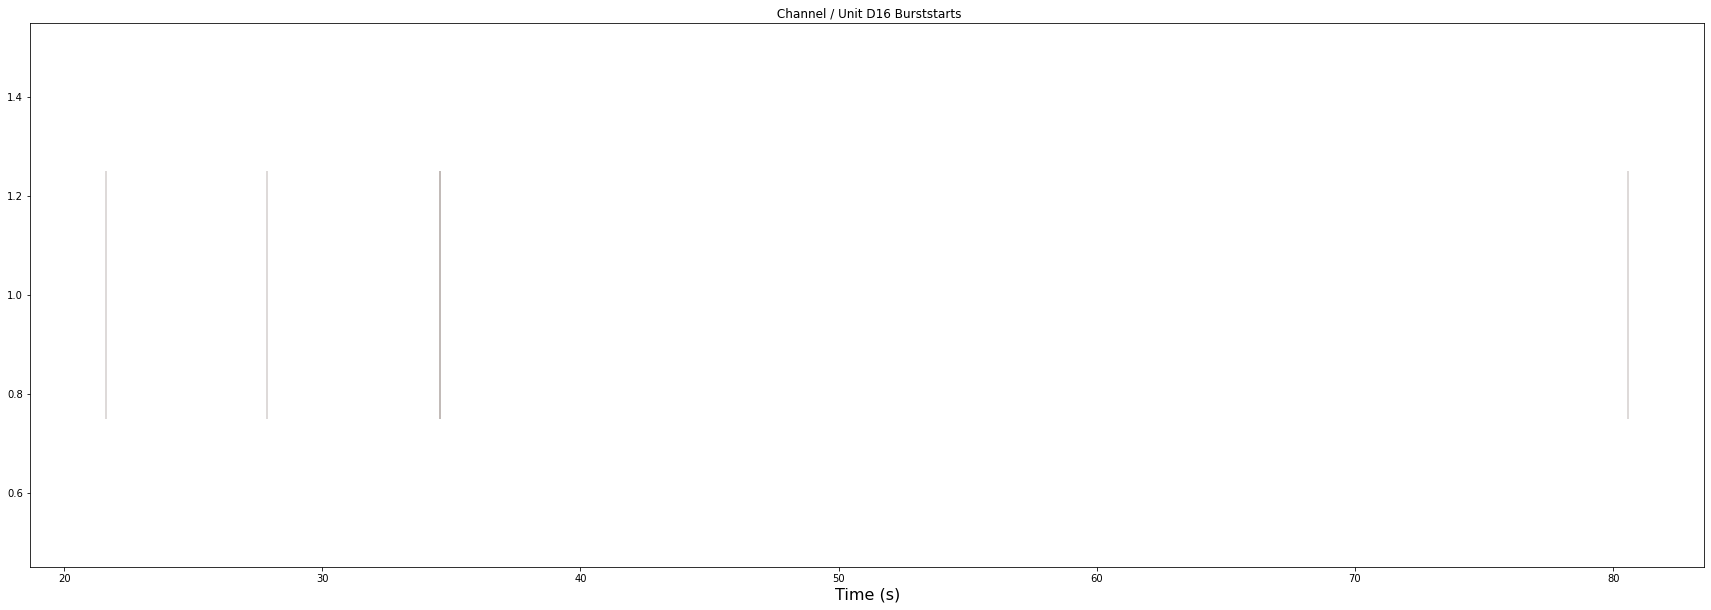

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D15 Burststarts')

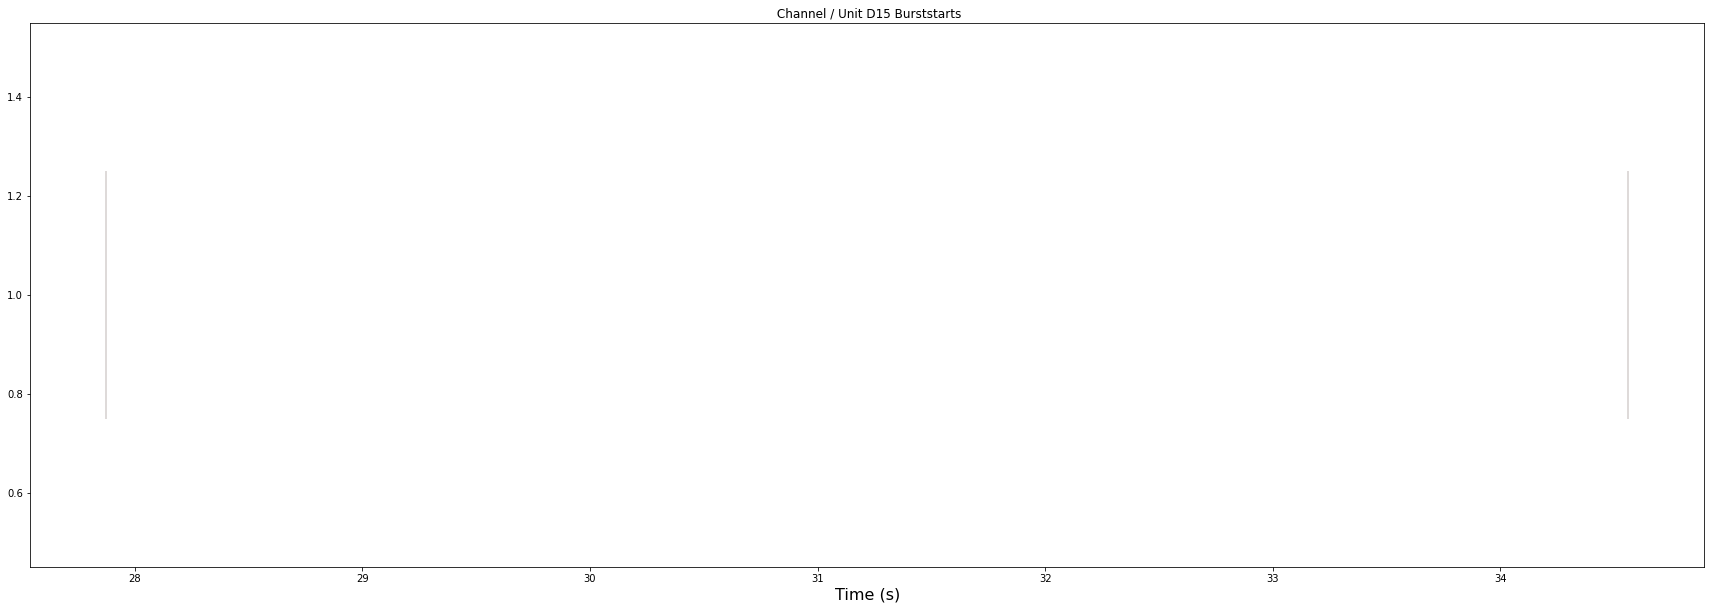

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D14 Burststarts')

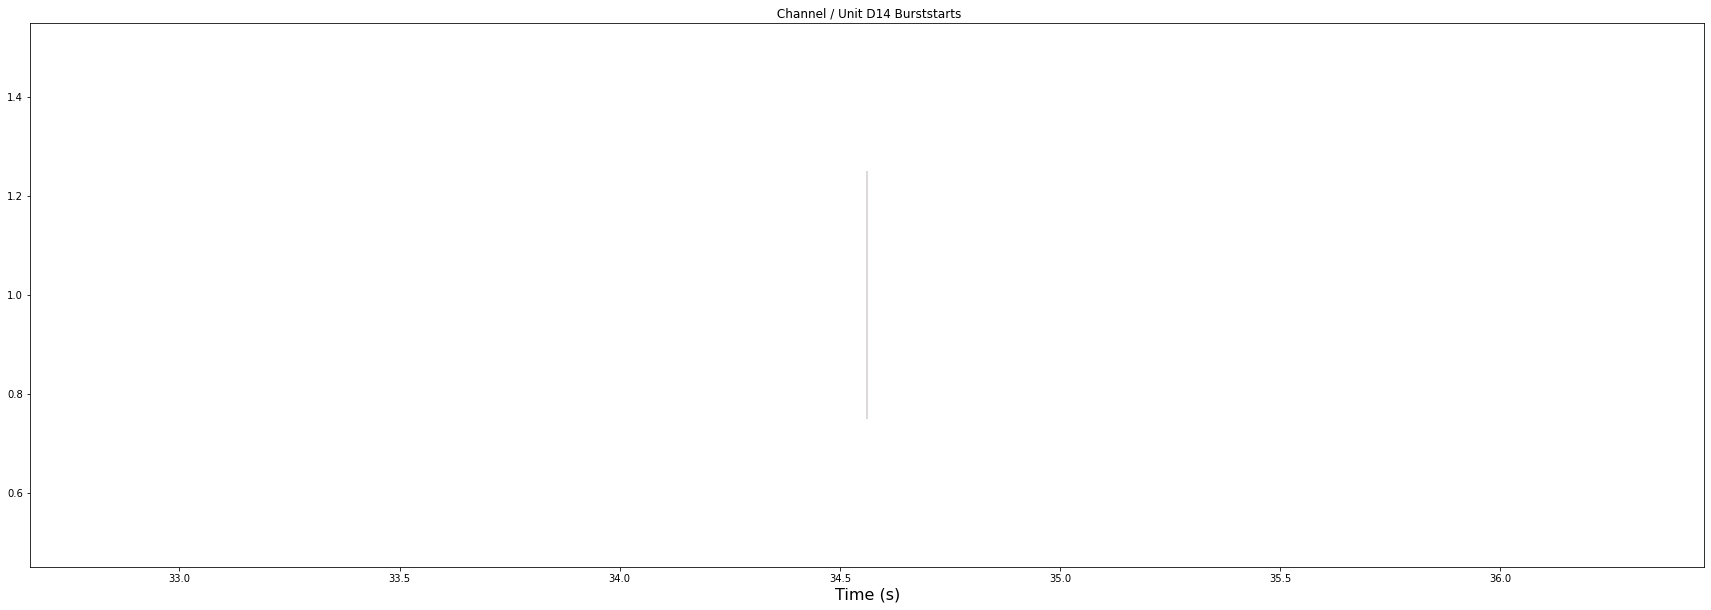

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H9 Burststarts')

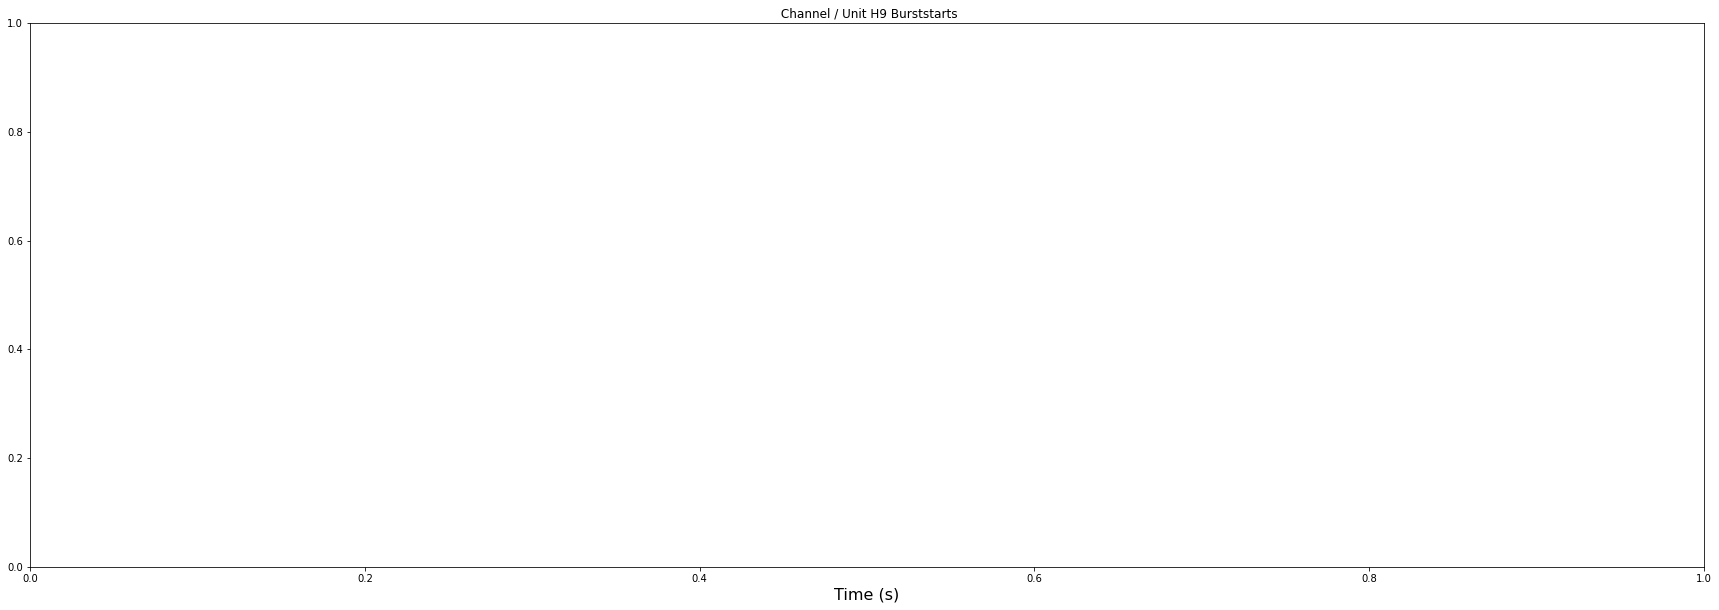

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F11 Burststarts')

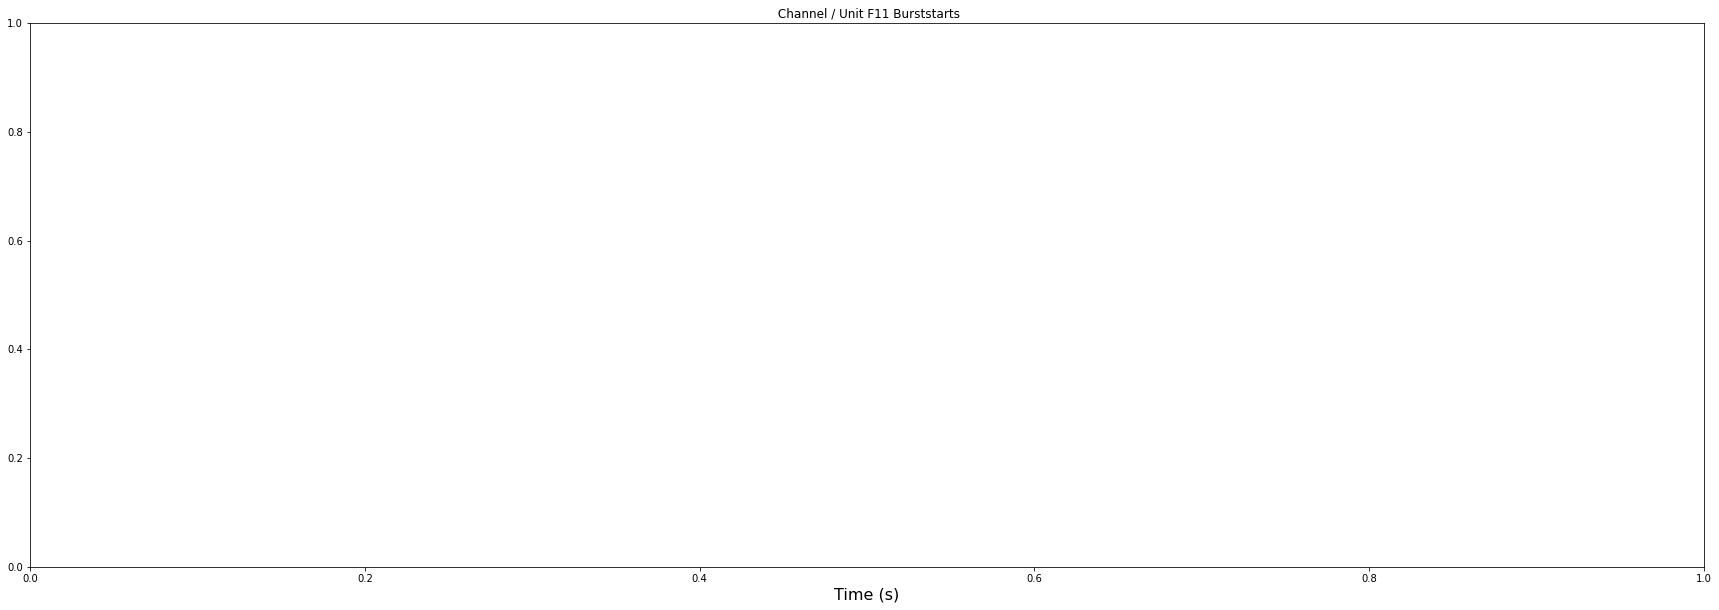

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C16 Burststarts')

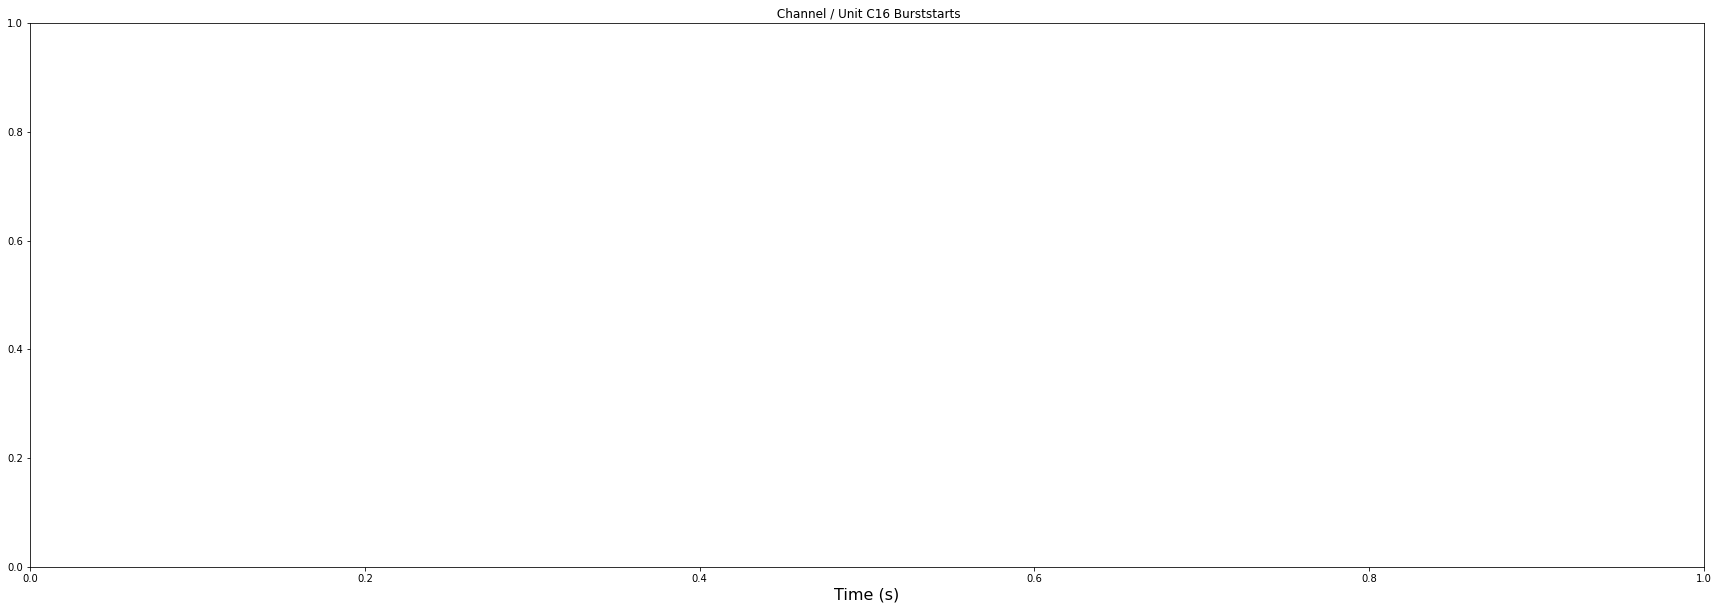

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C15 Burststarts')

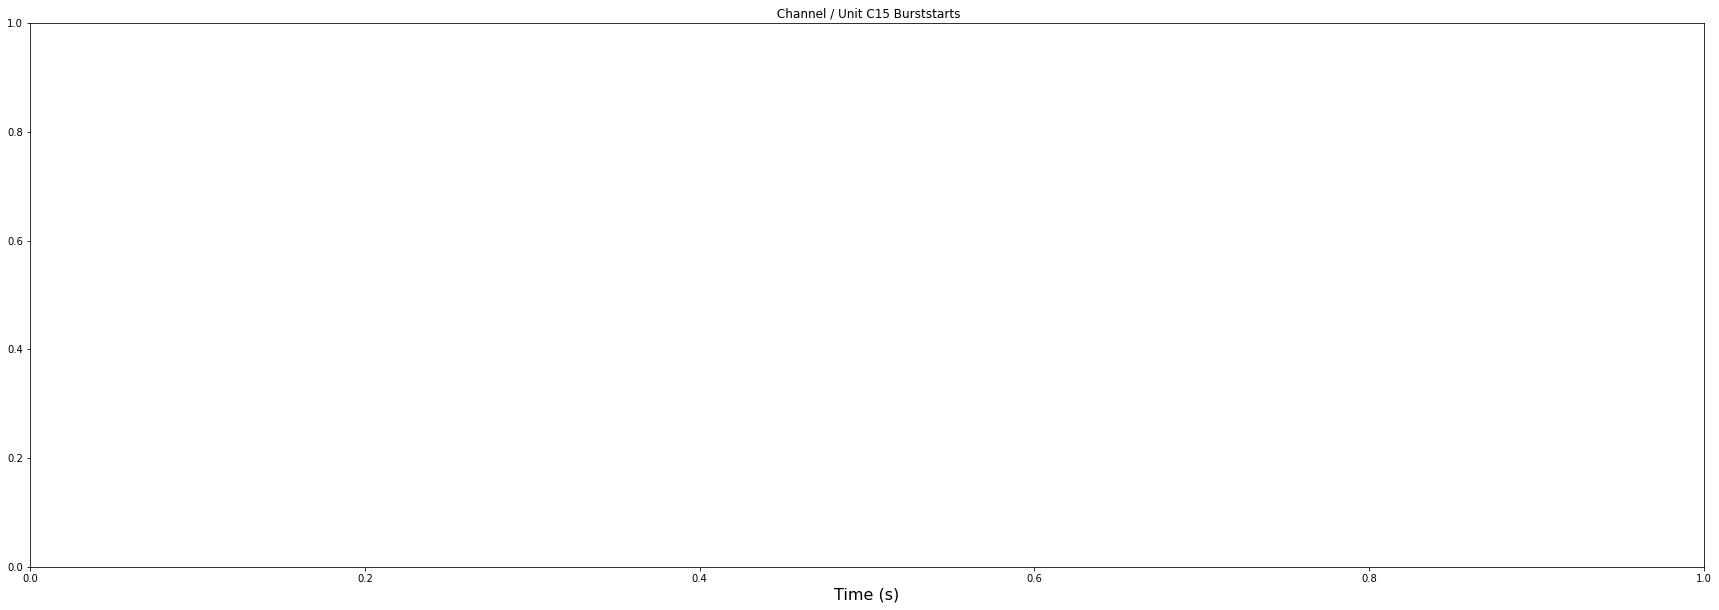

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D13 Burststarts')

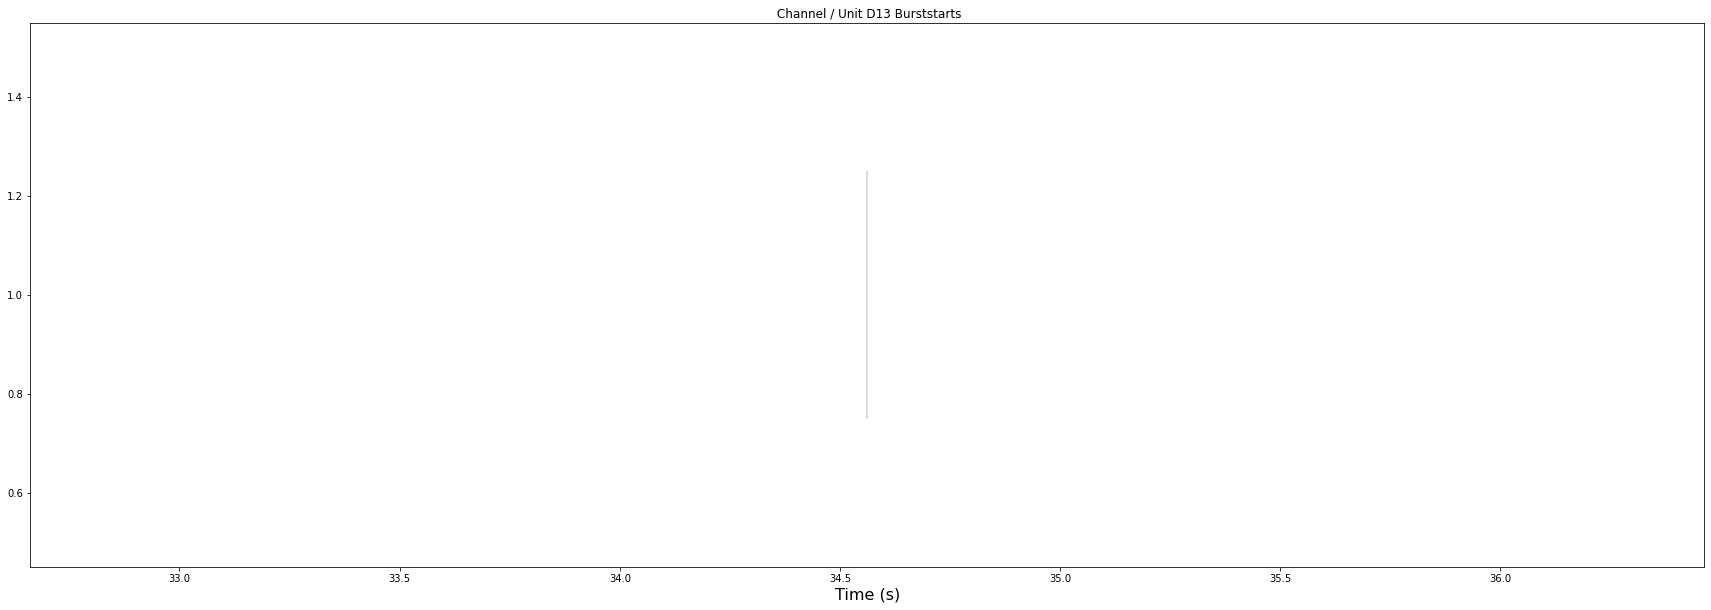

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B16 Burststarts')

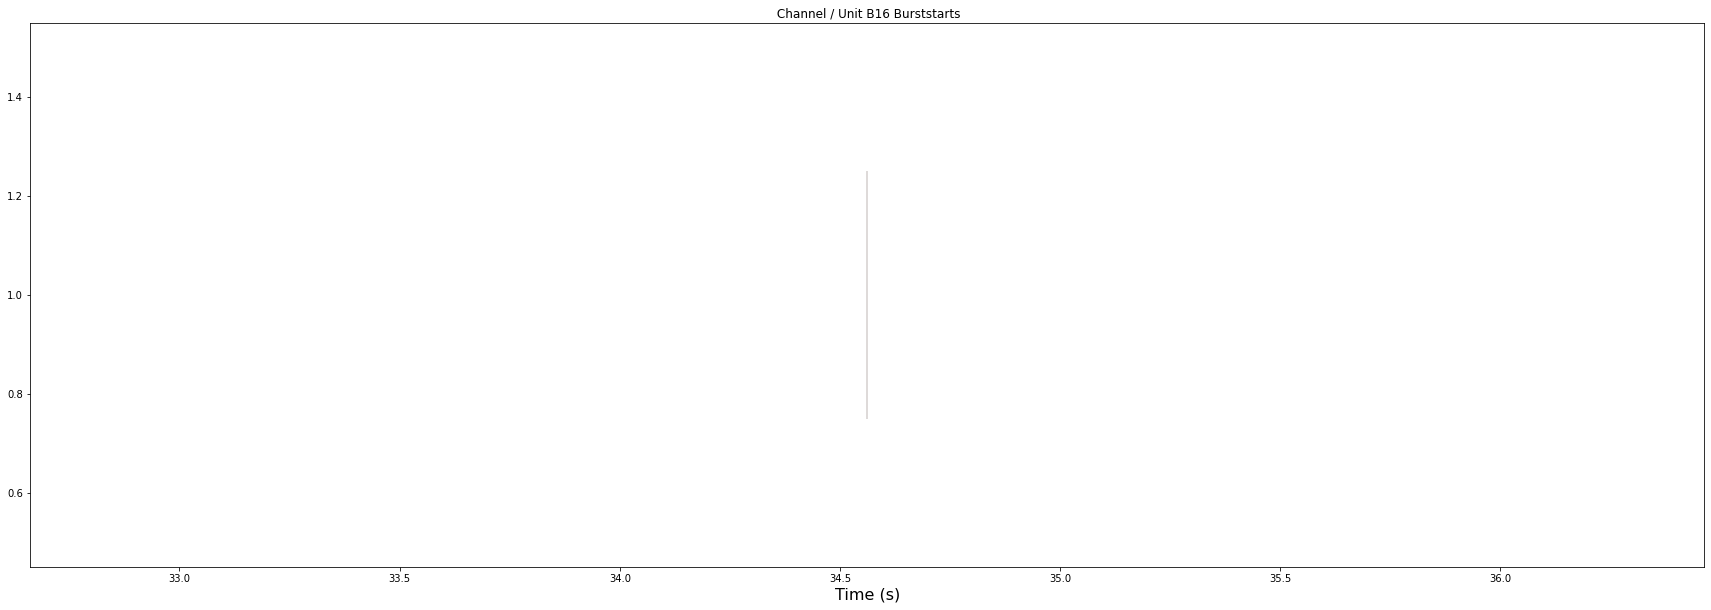

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B15 Burststarts')

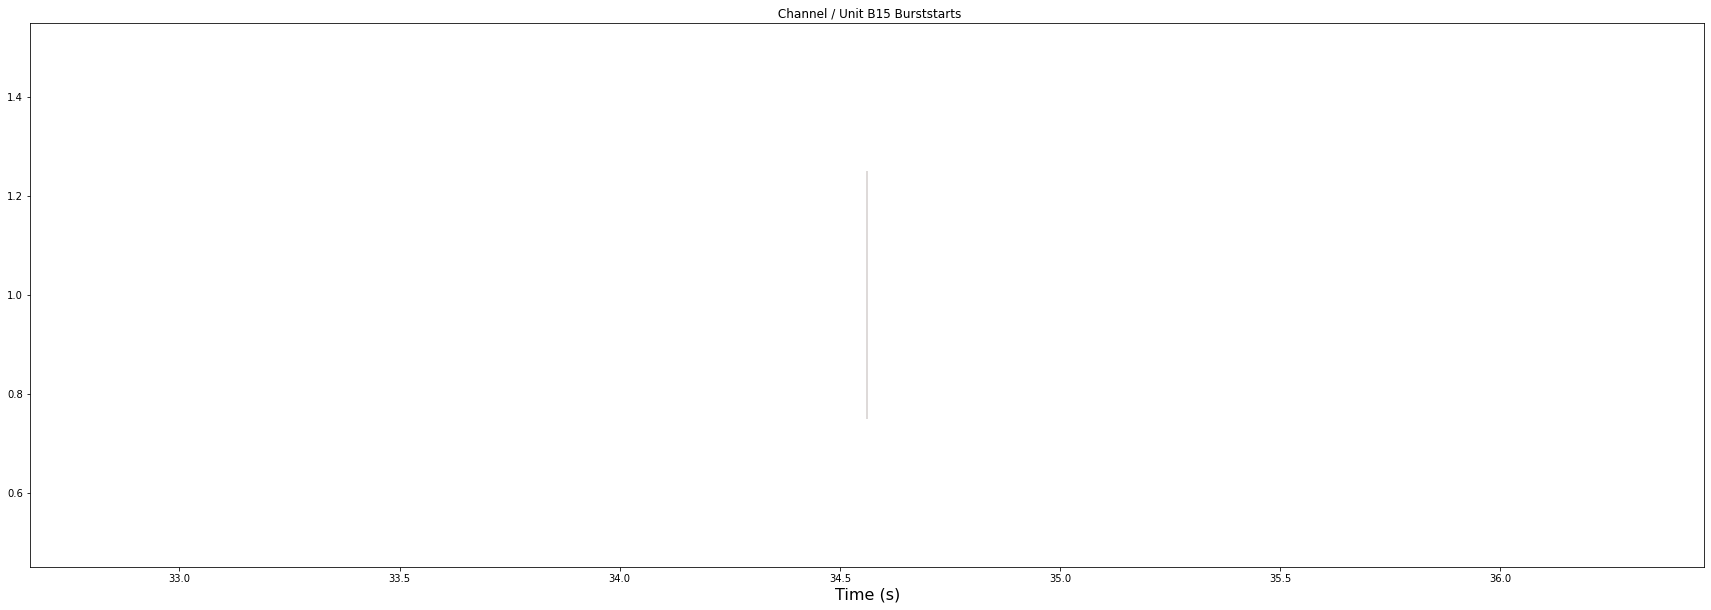

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C14 Burststarts')

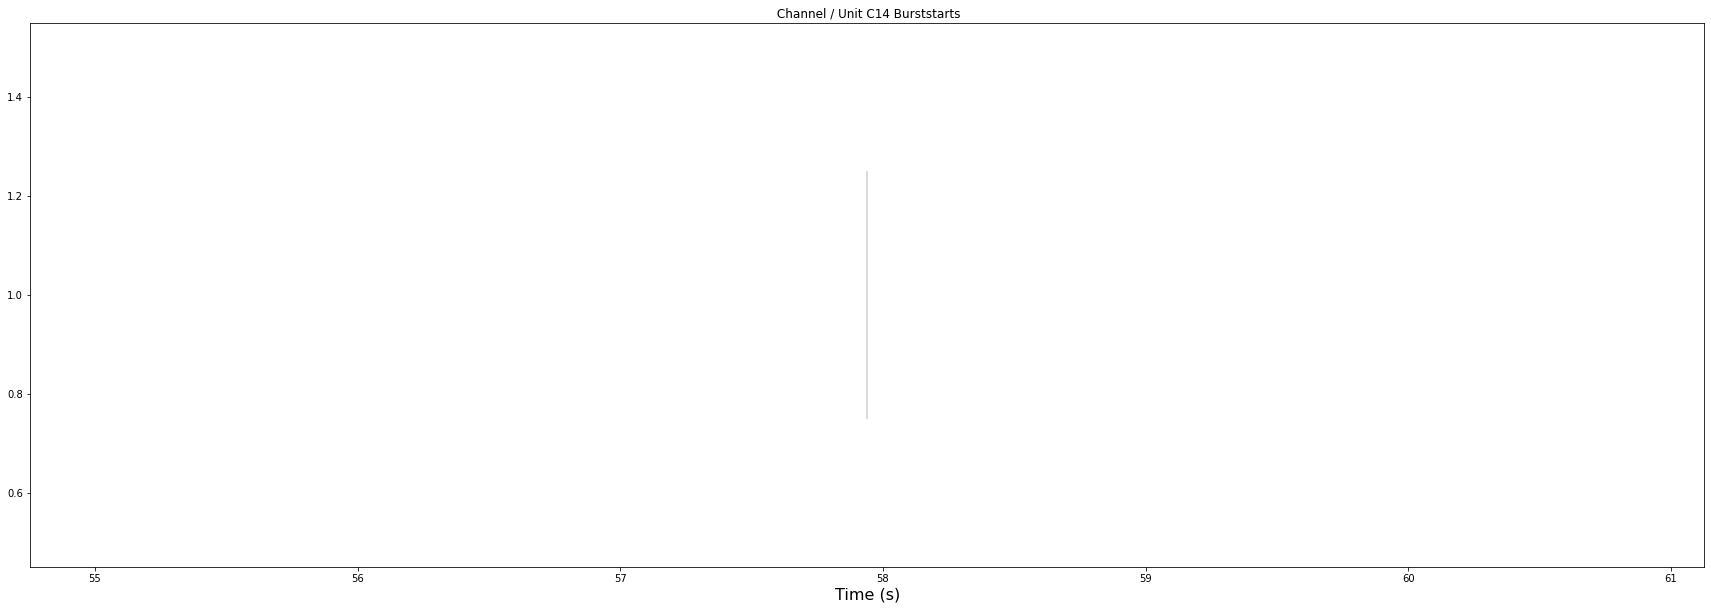

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A15 Burststarts')

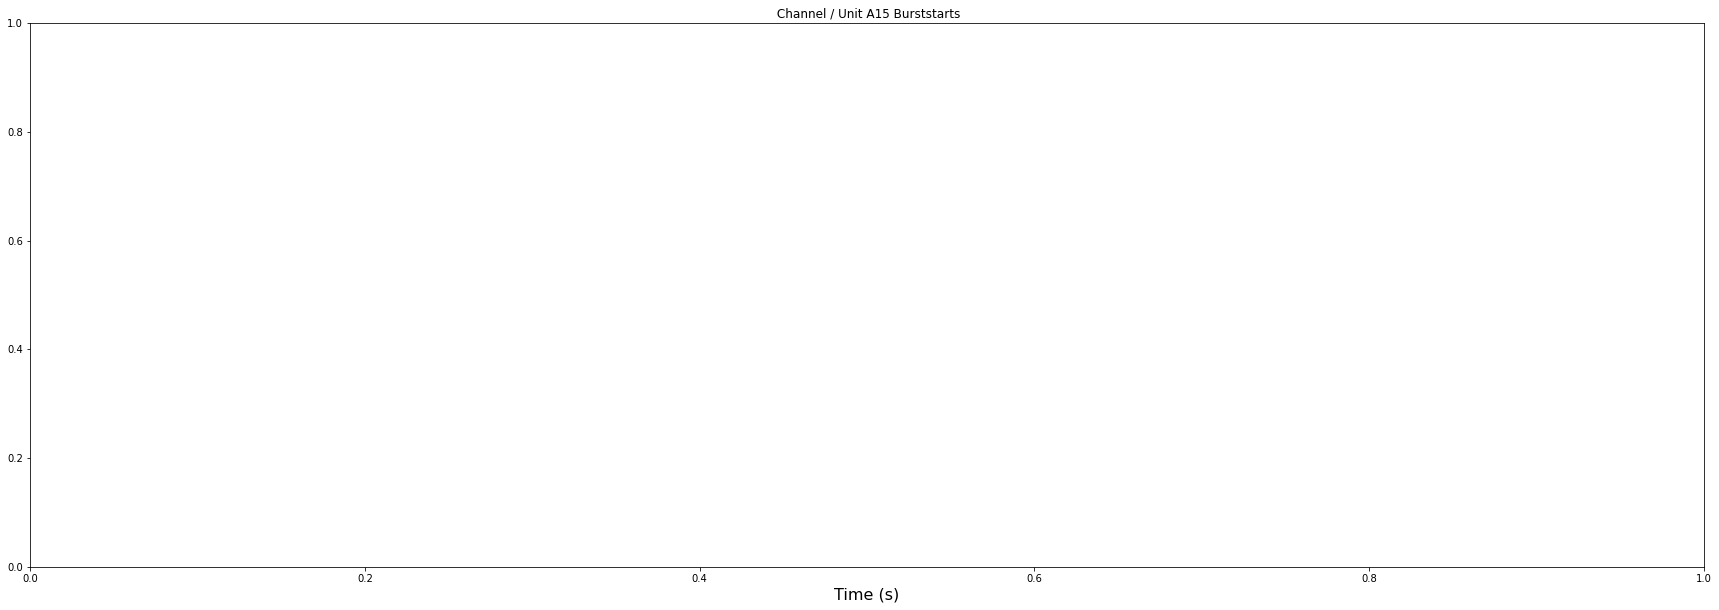

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A14 Burststarts')

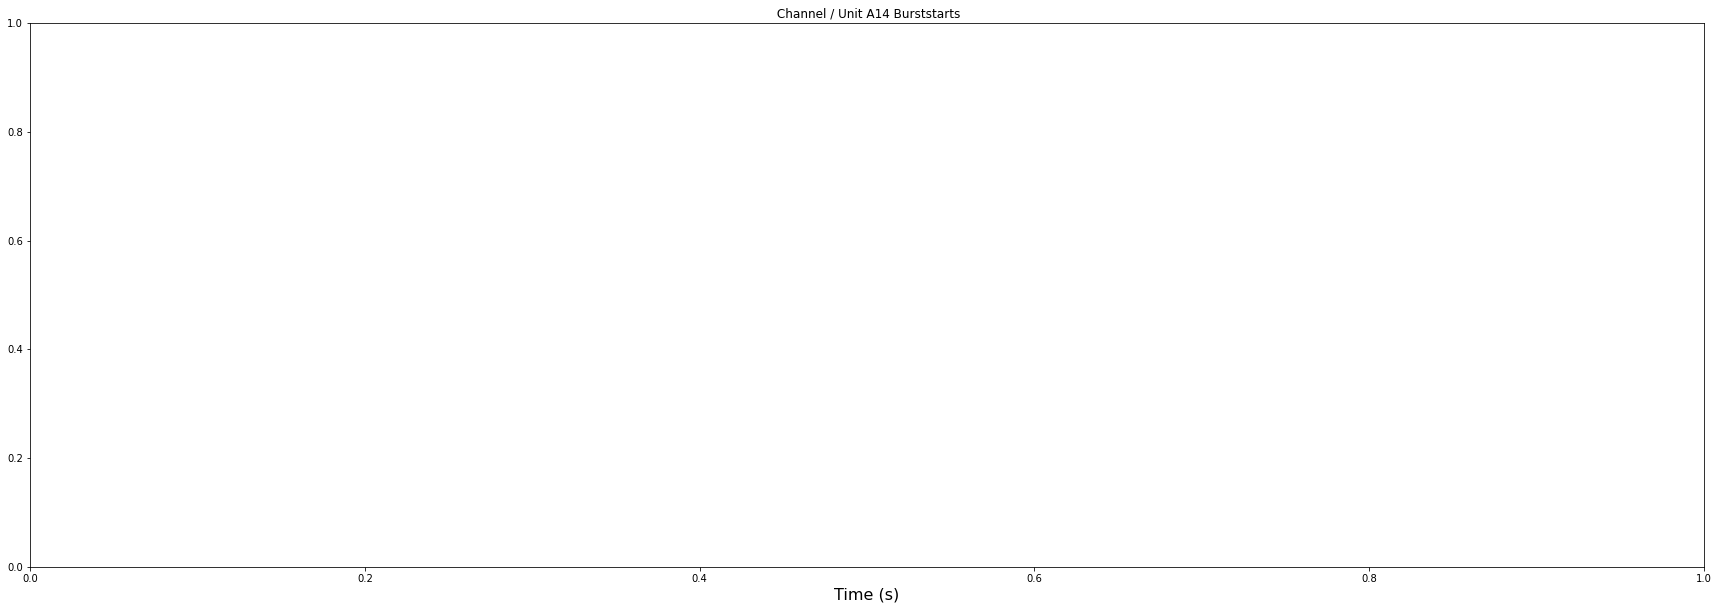

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B14 Burststarts')

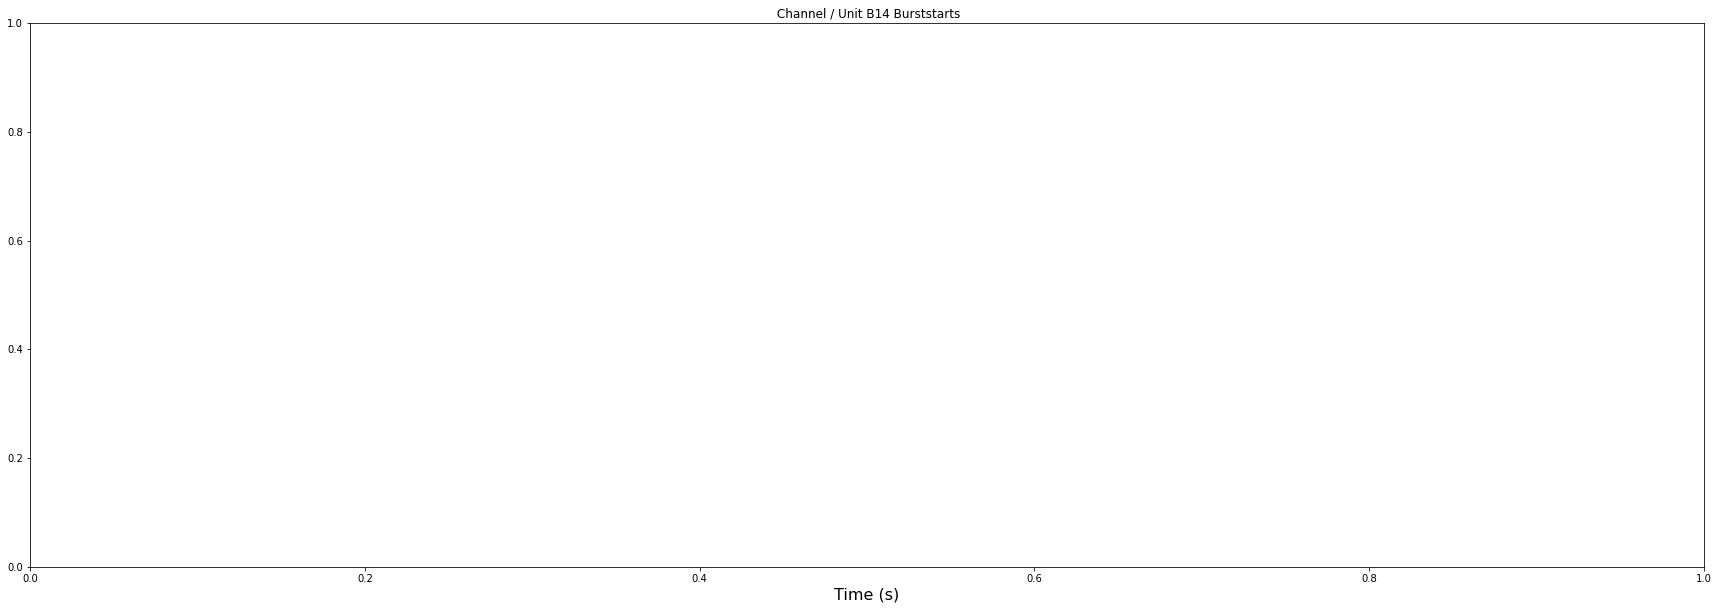

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G10 Burststarts')

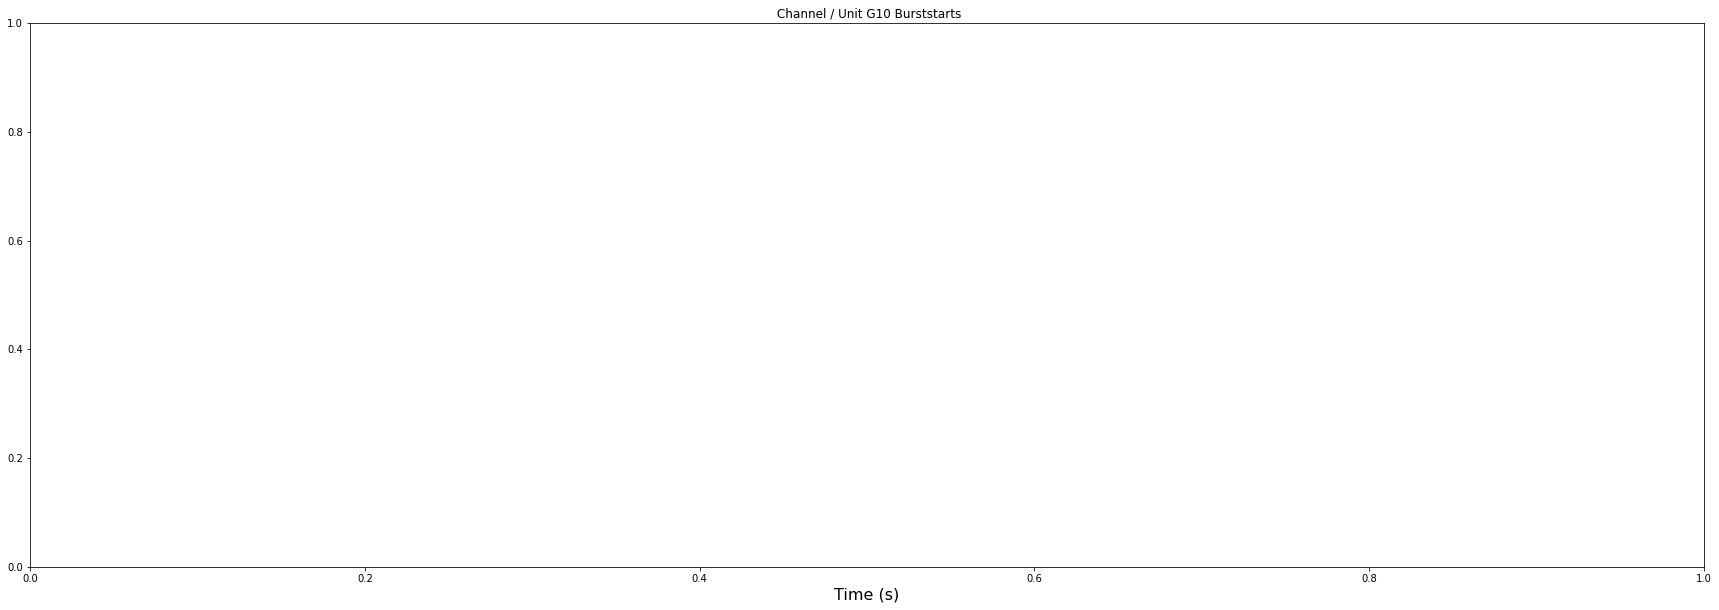

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E12 Burststarts')

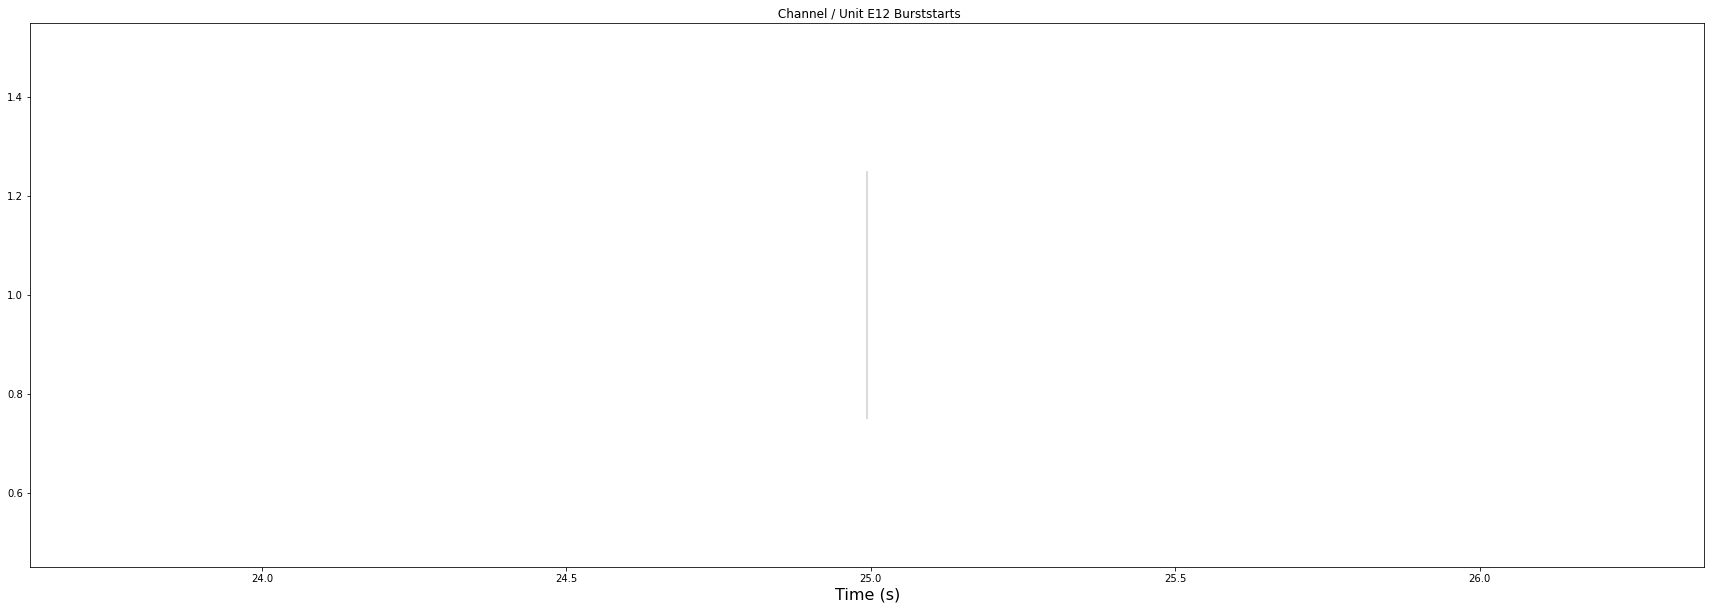

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B13 Burststarts')

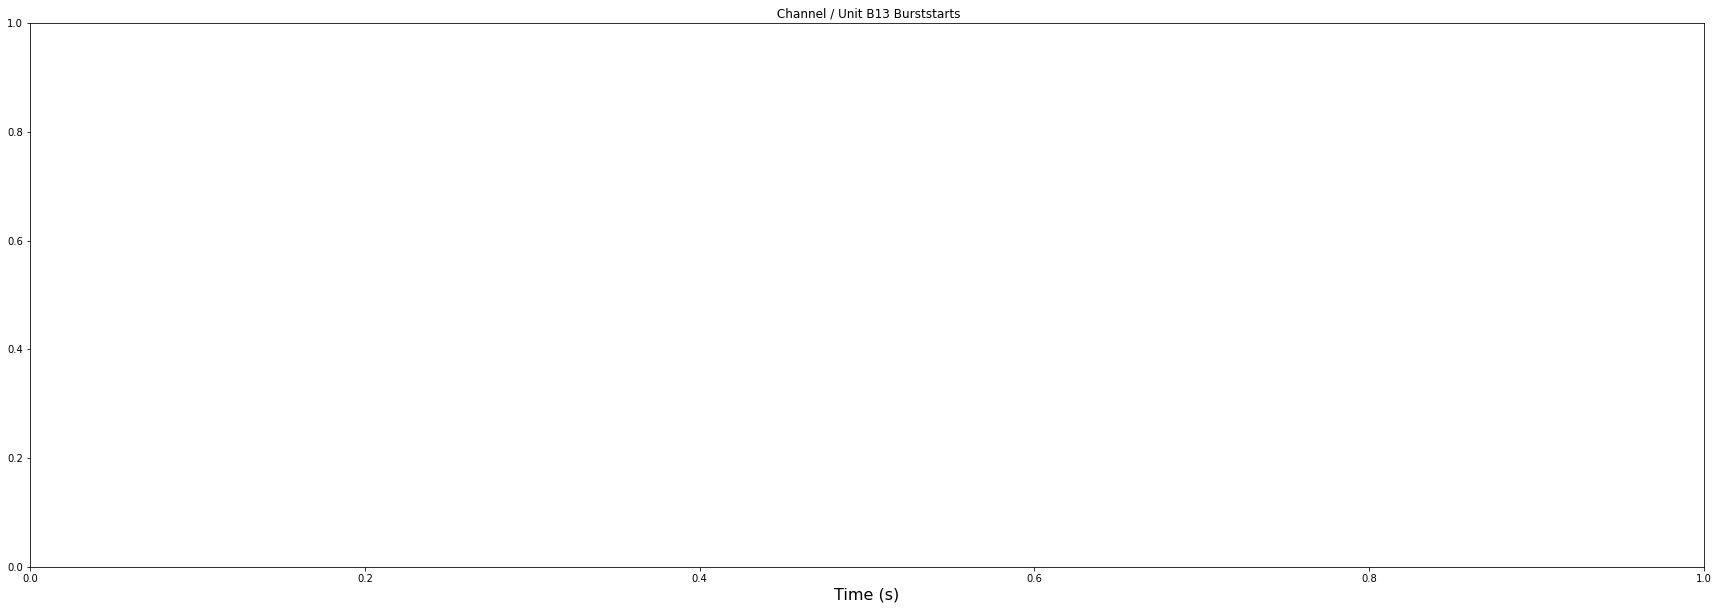

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C13 Burststarts')

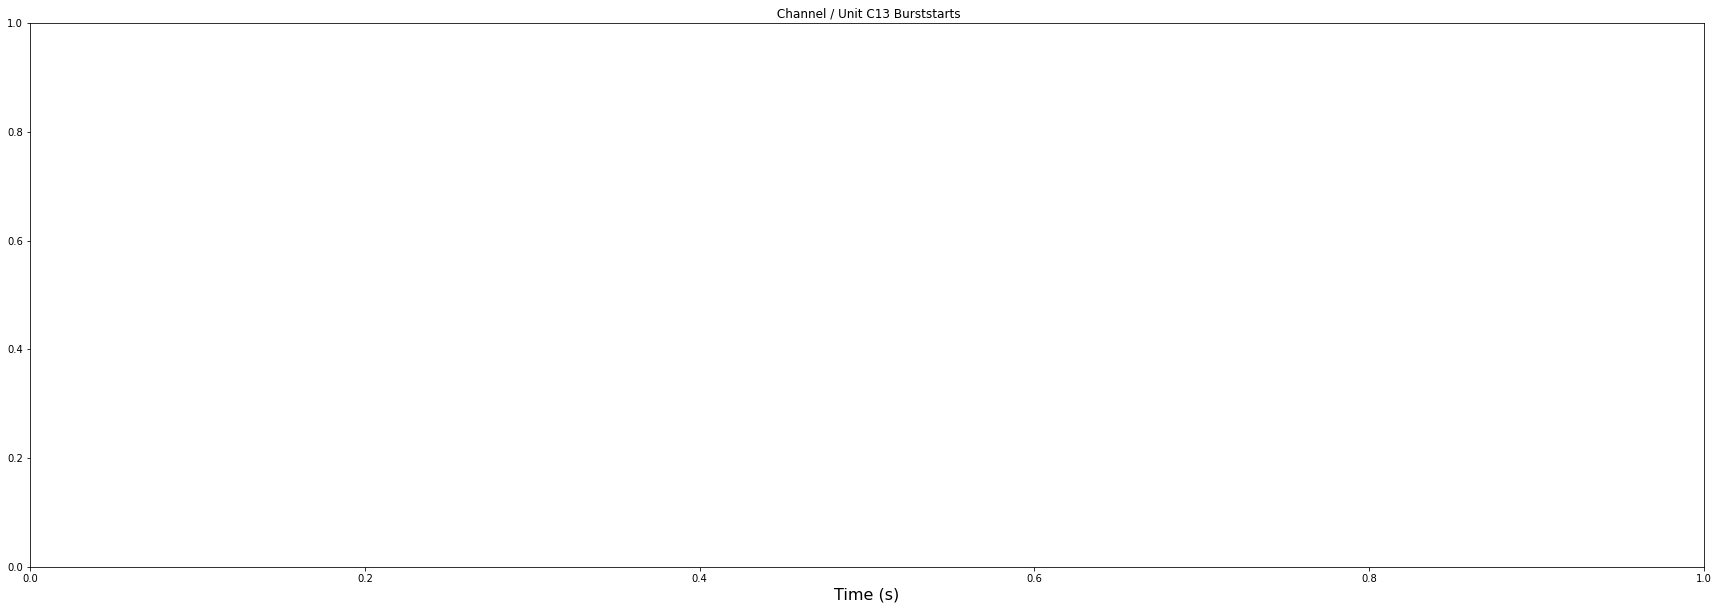

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F10 Burststarts')

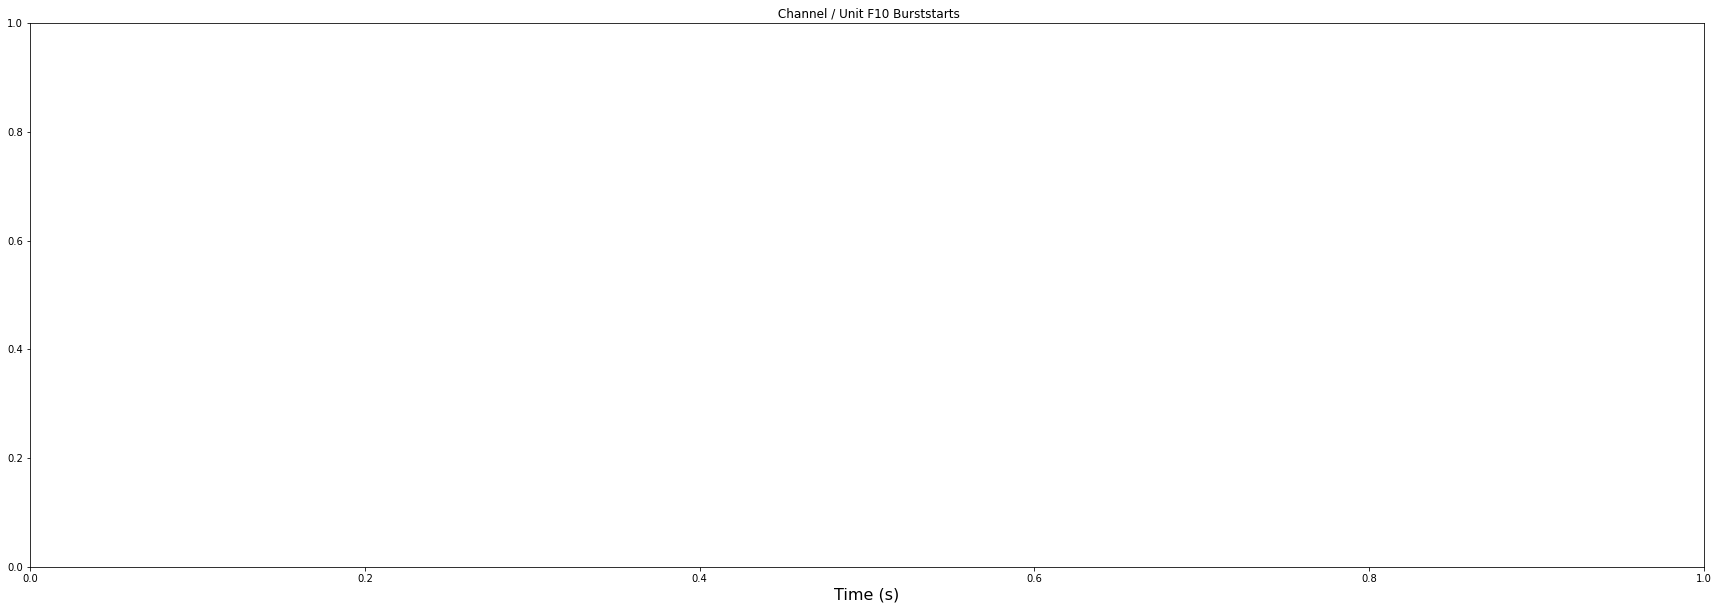

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A13 Burststarts')

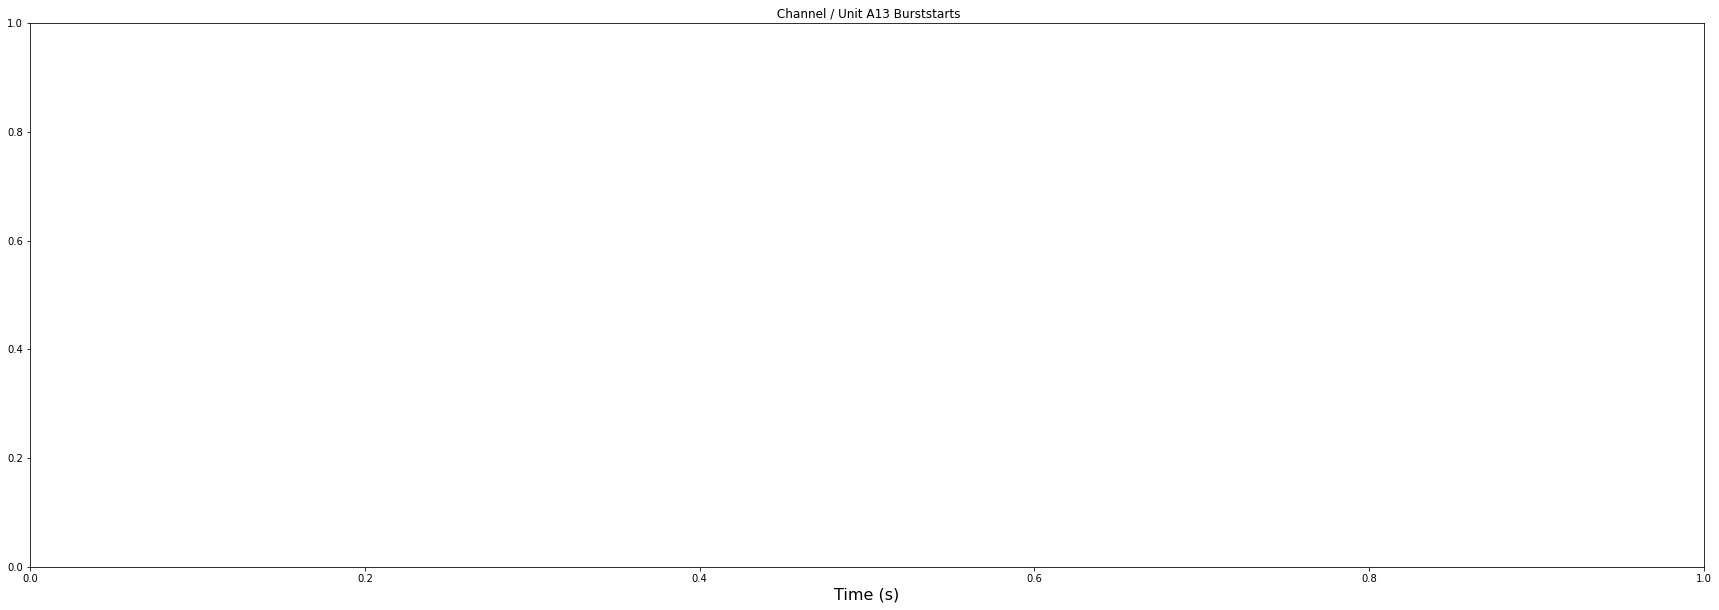

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C12 Burststarts')

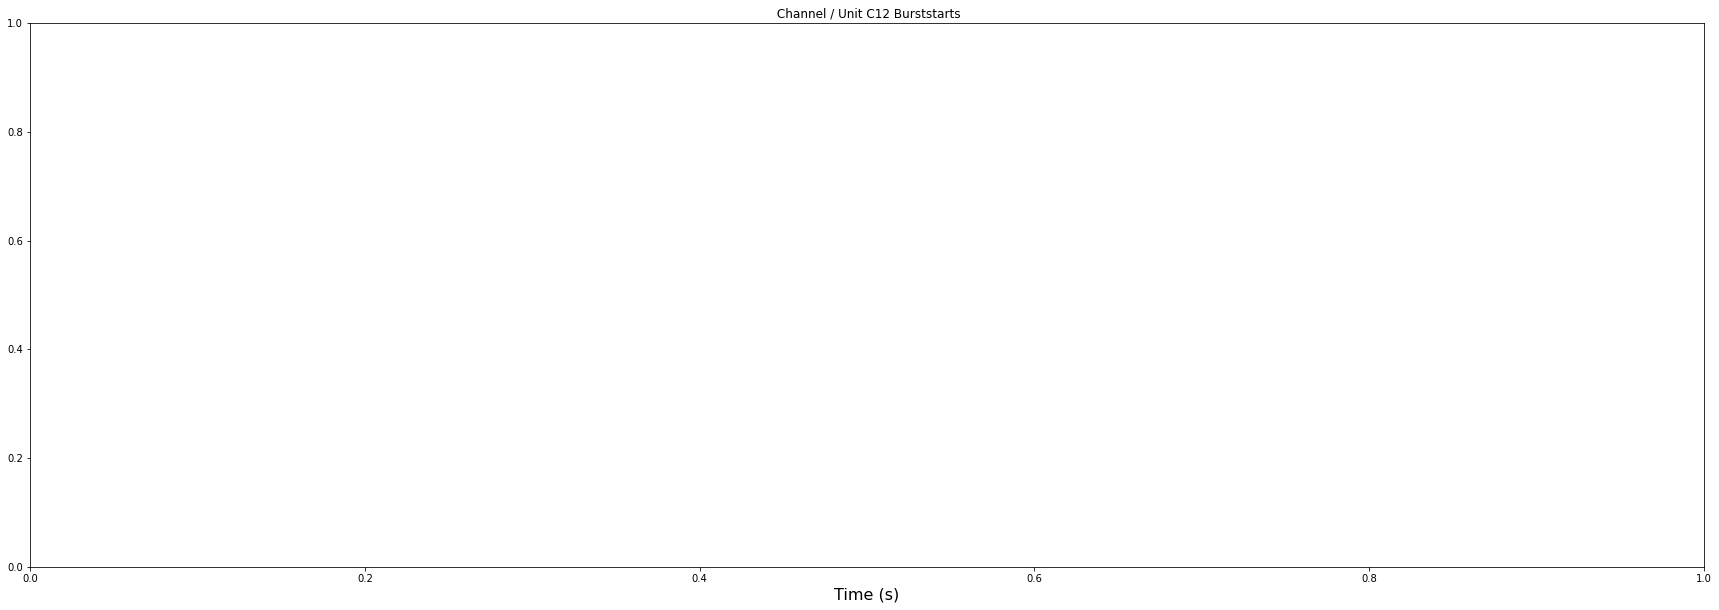

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D12 Burststarts')

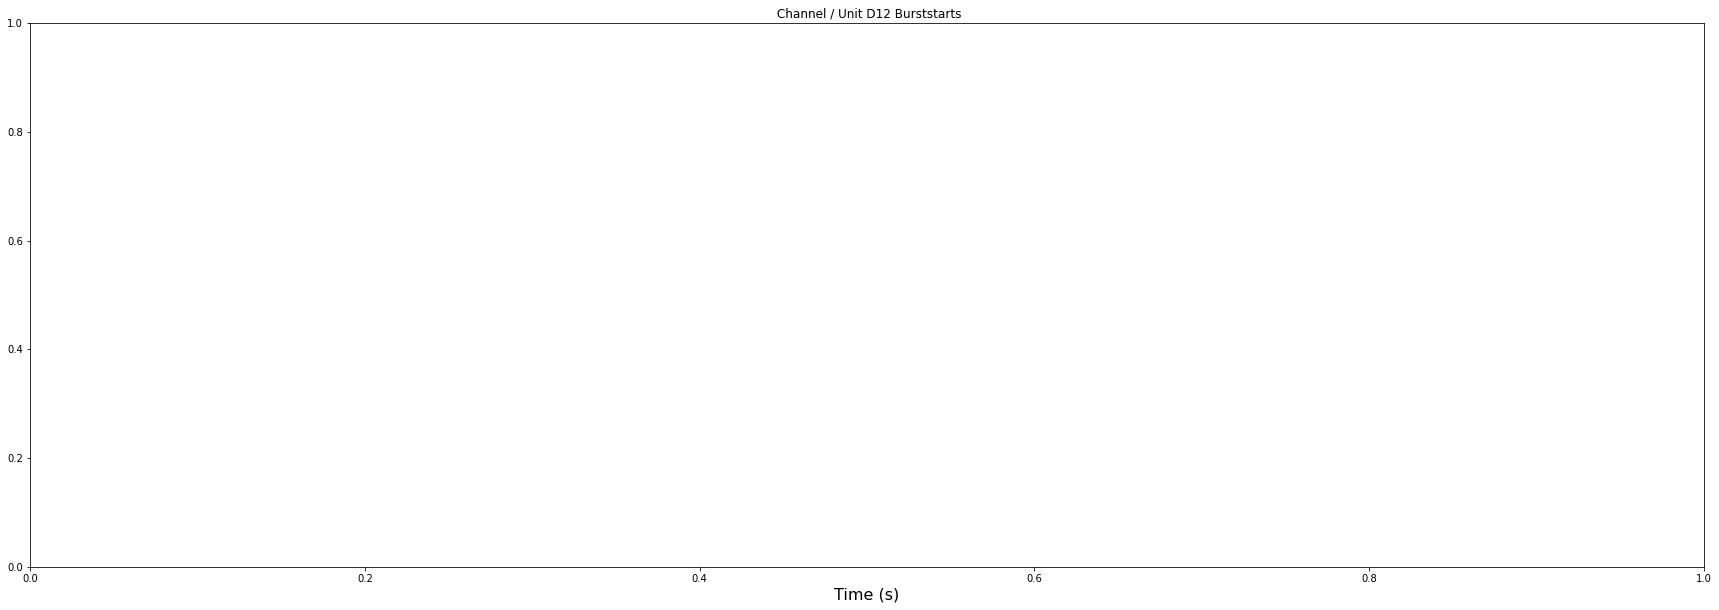

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A12 Burststarts')

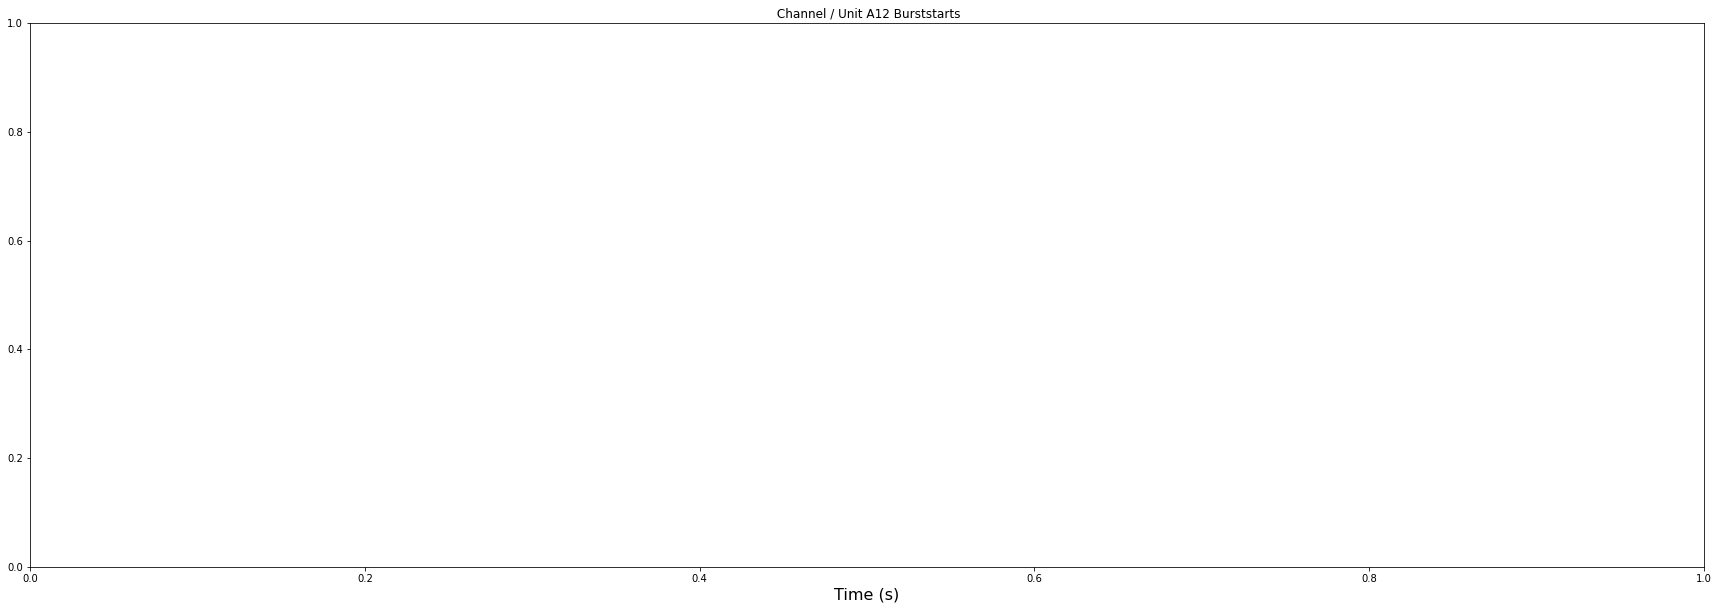

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B12 Burststarts')

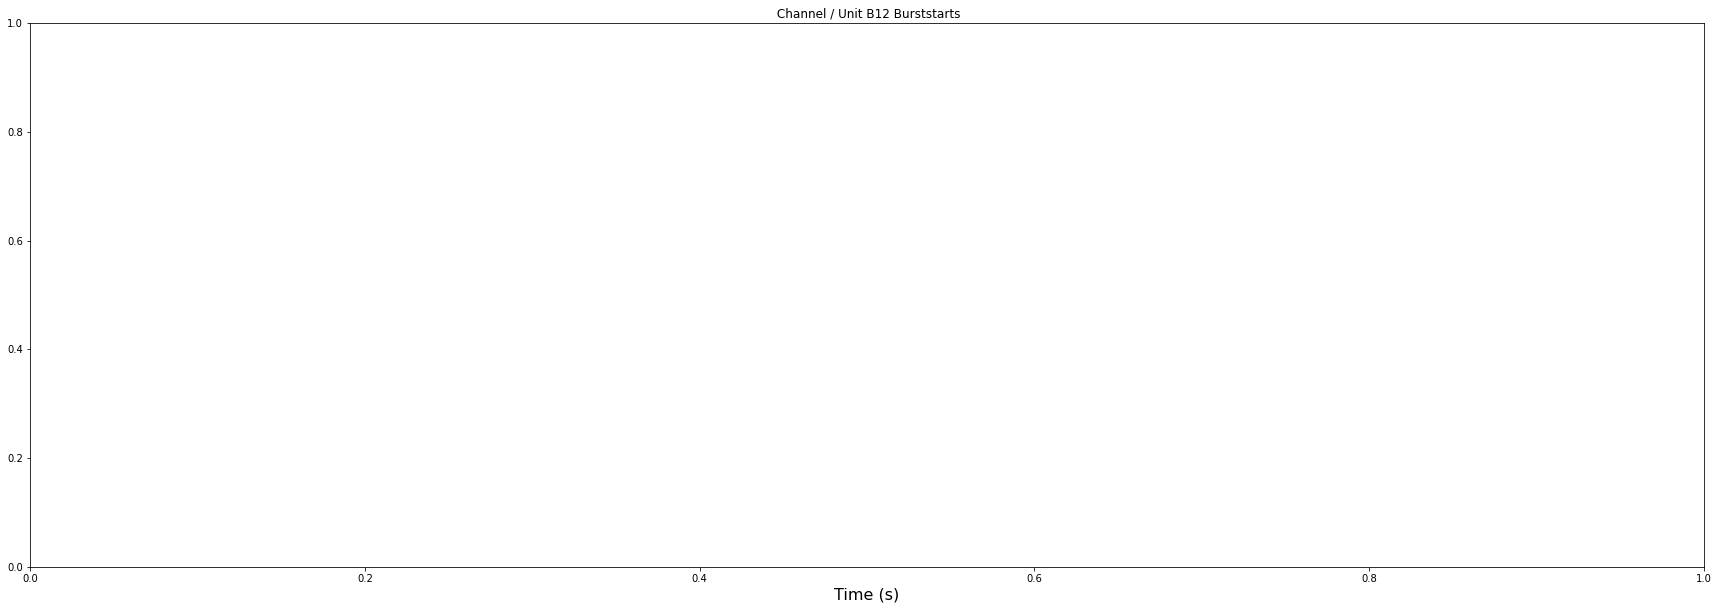

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D11 Burststarts')

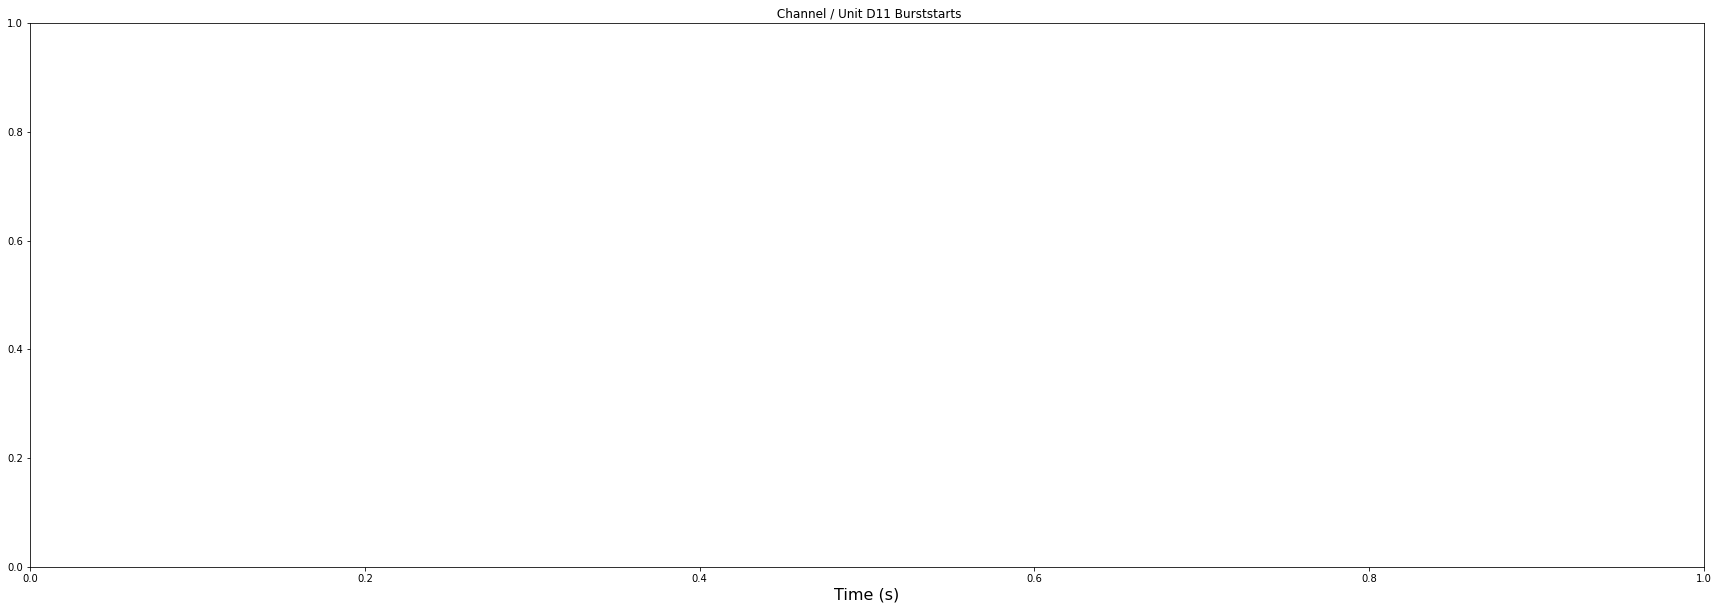

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E11 Burststarts')

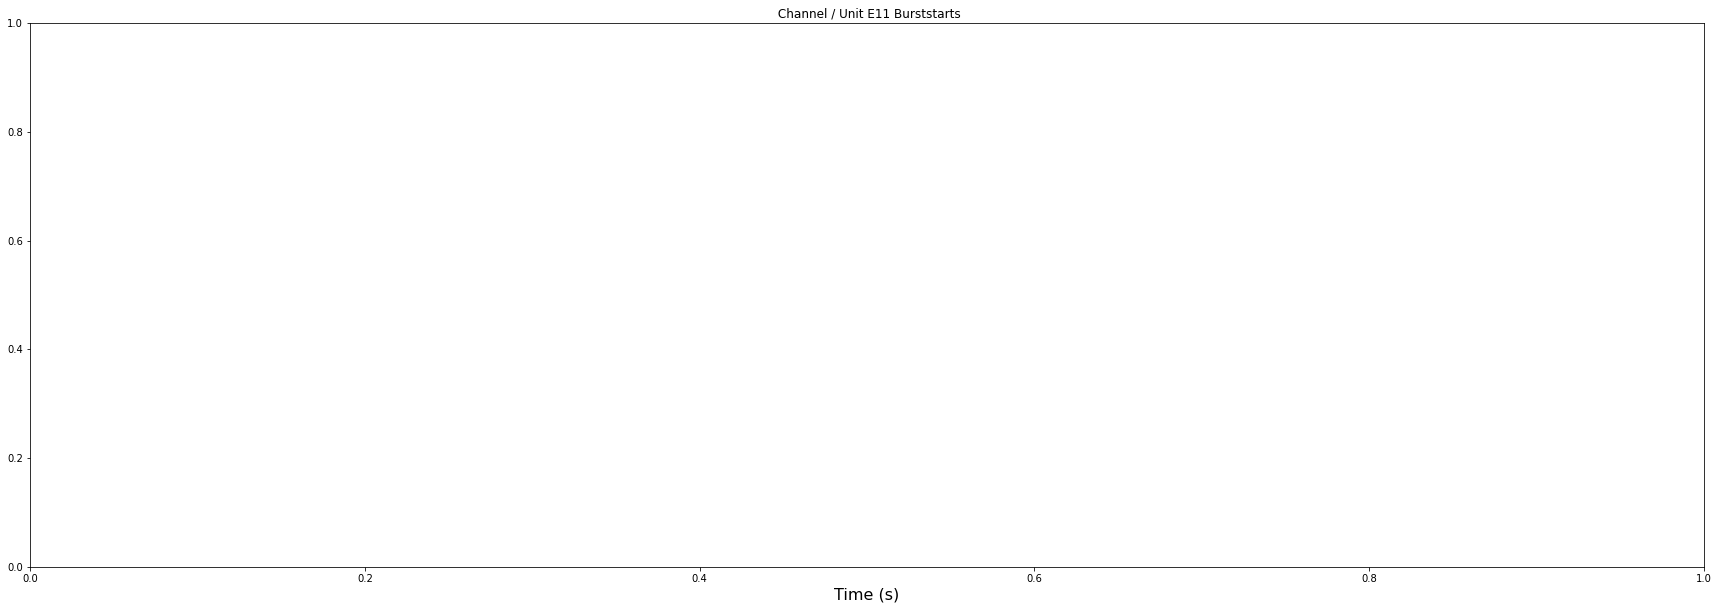

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B11 Burststarts')

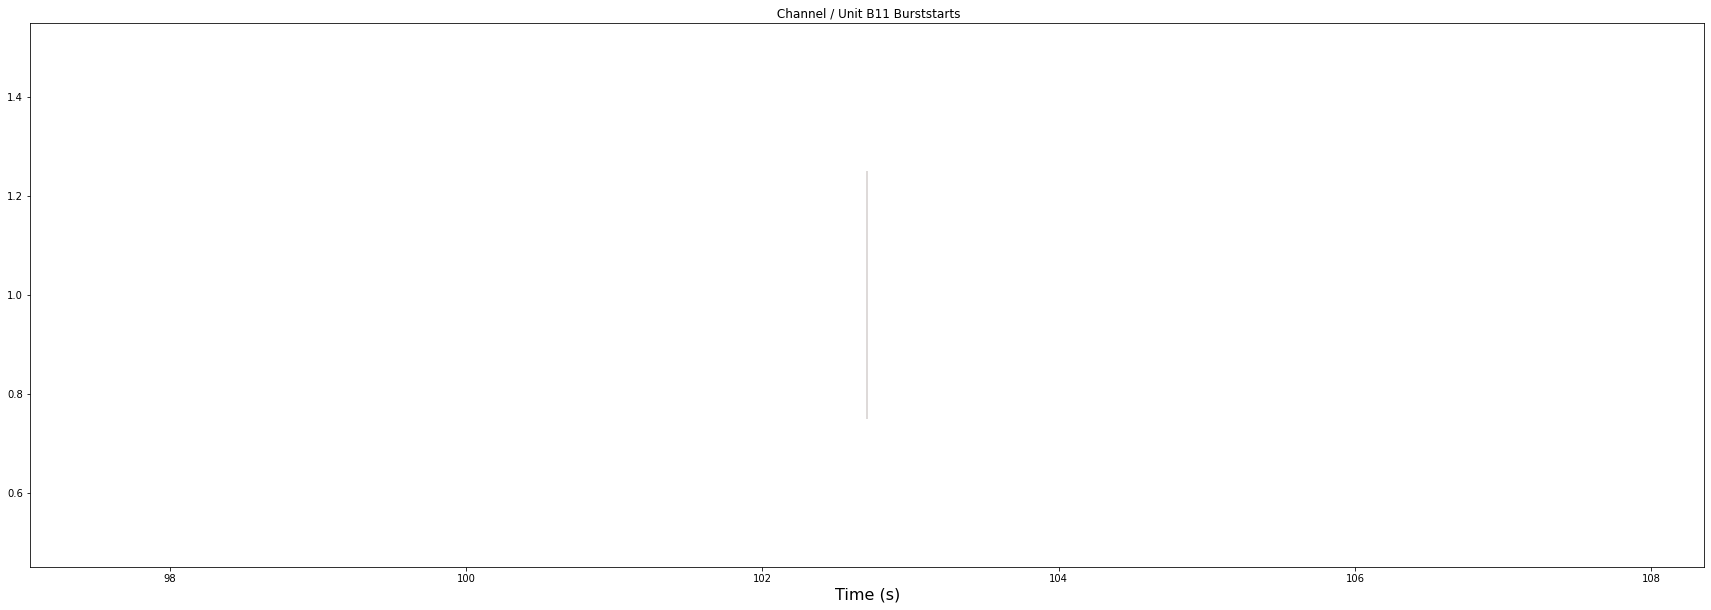

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C11 Burststarts')

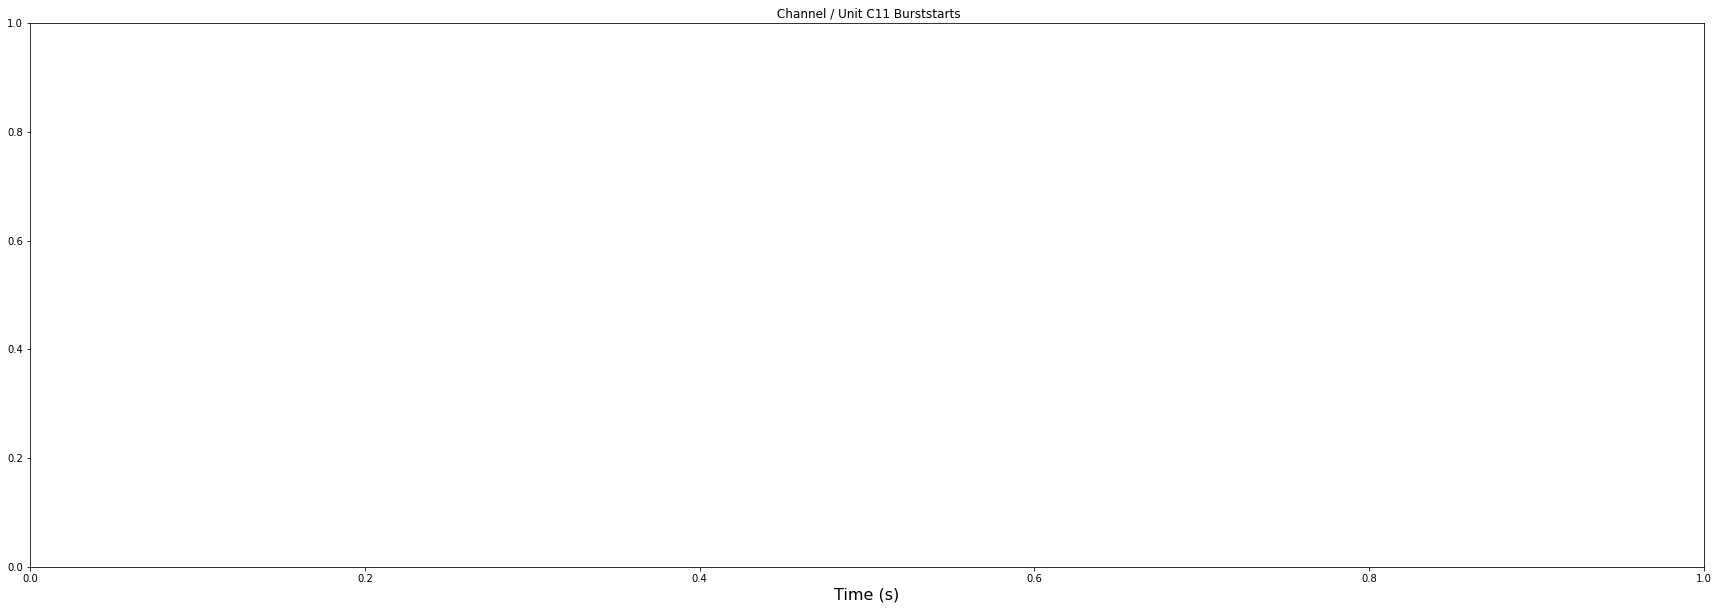

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E10 Burststarts')

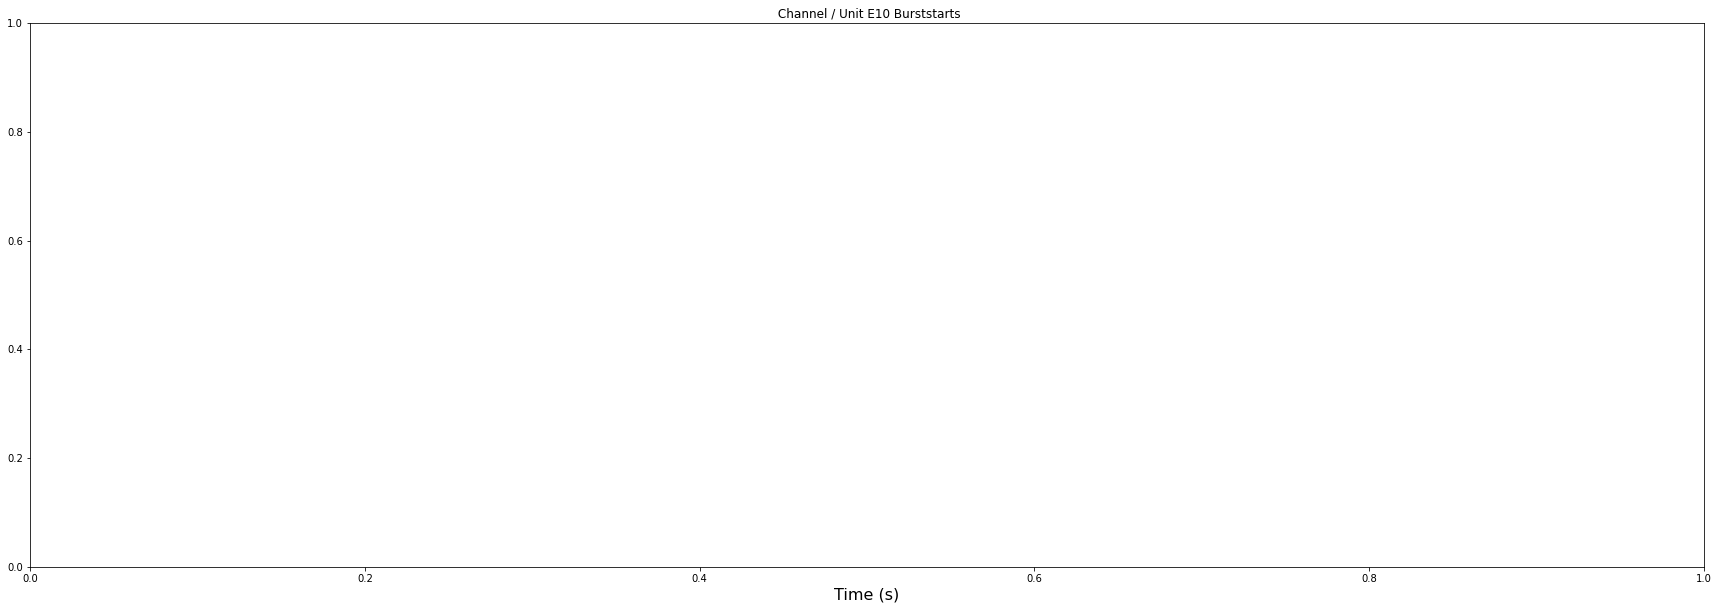

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A11 Burststarts')

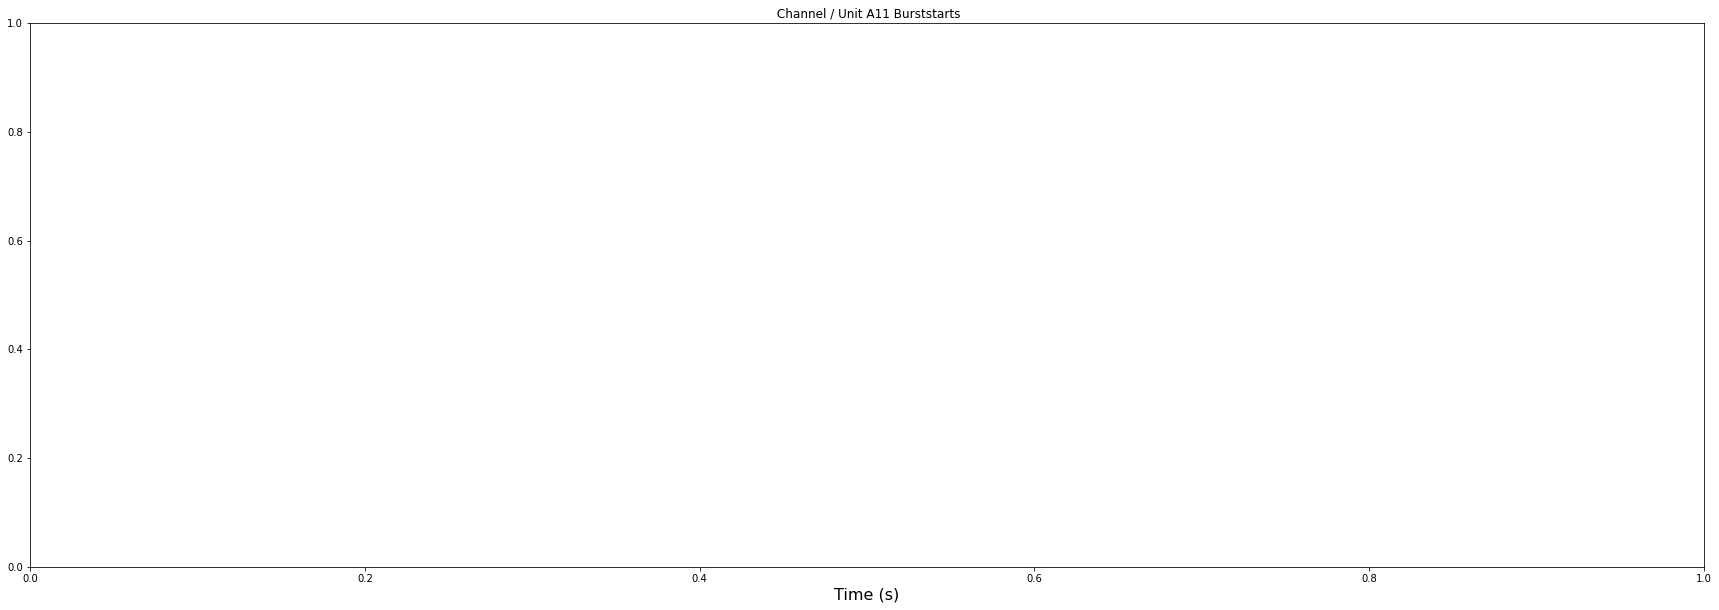

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C10 Burststarts')

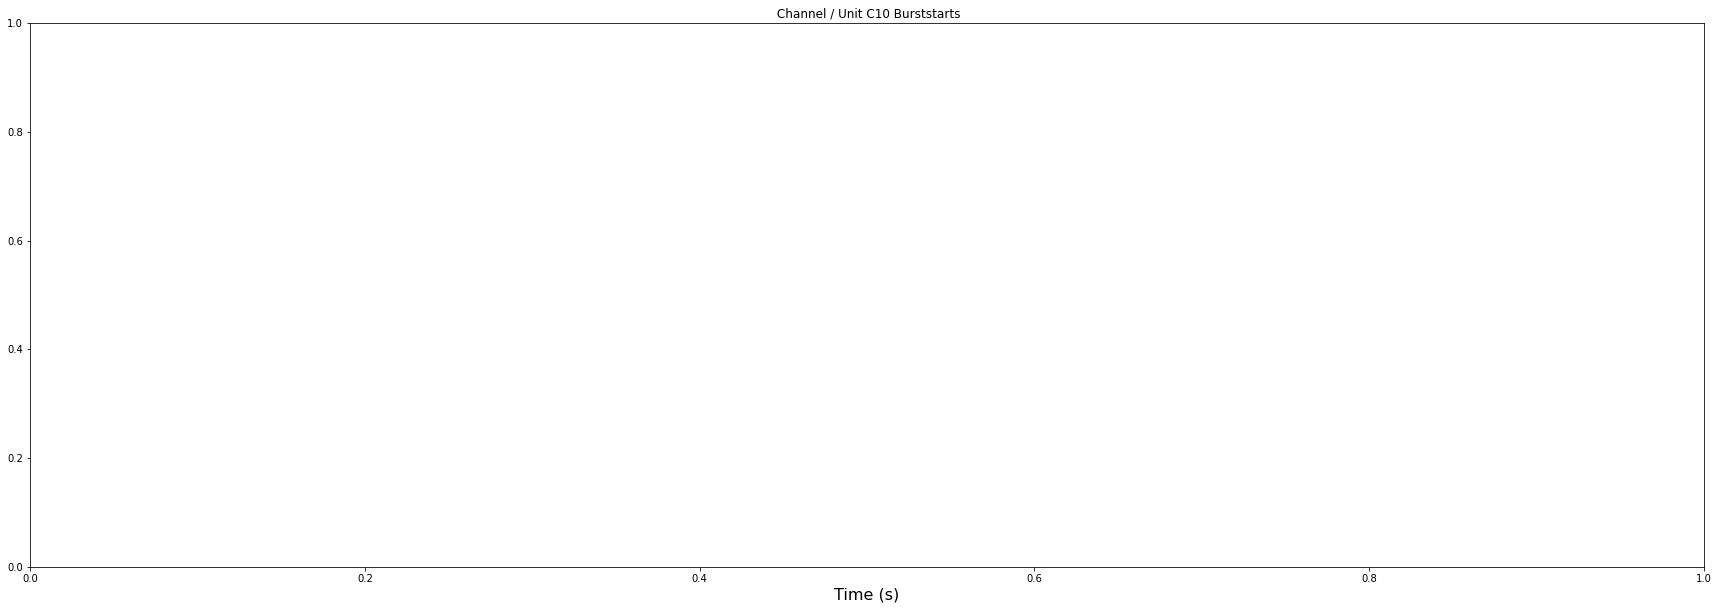

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D10 Burststarts')

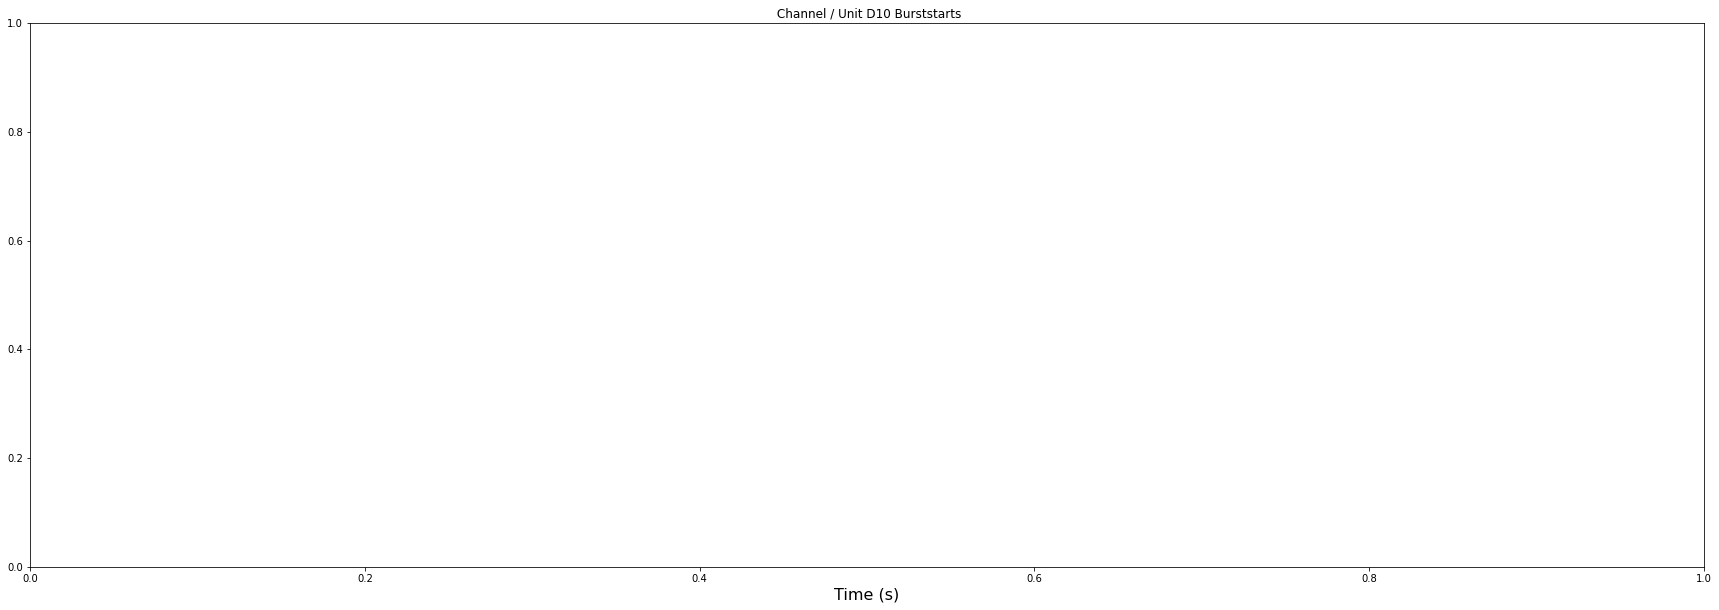

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A10 Burststarts')

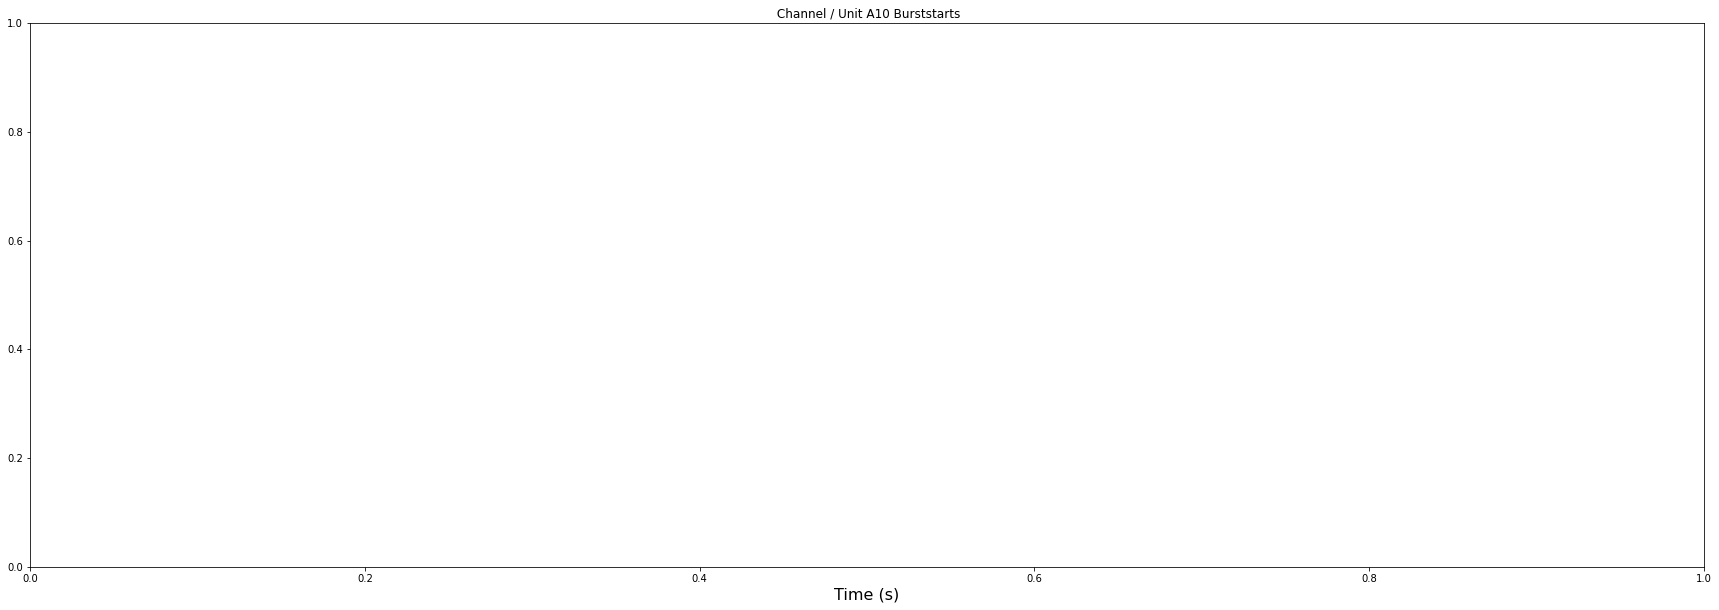

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B10 Burststarts')

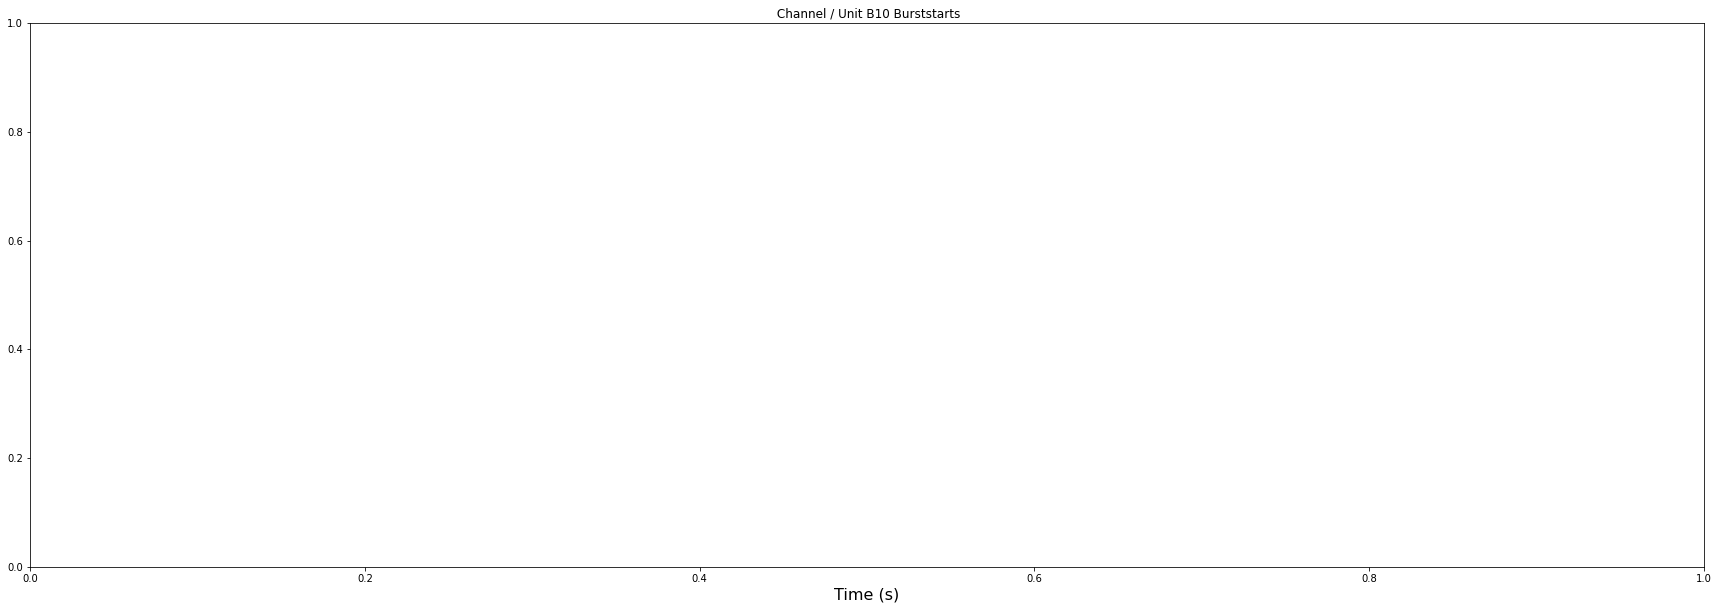

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D9 Burststarts')

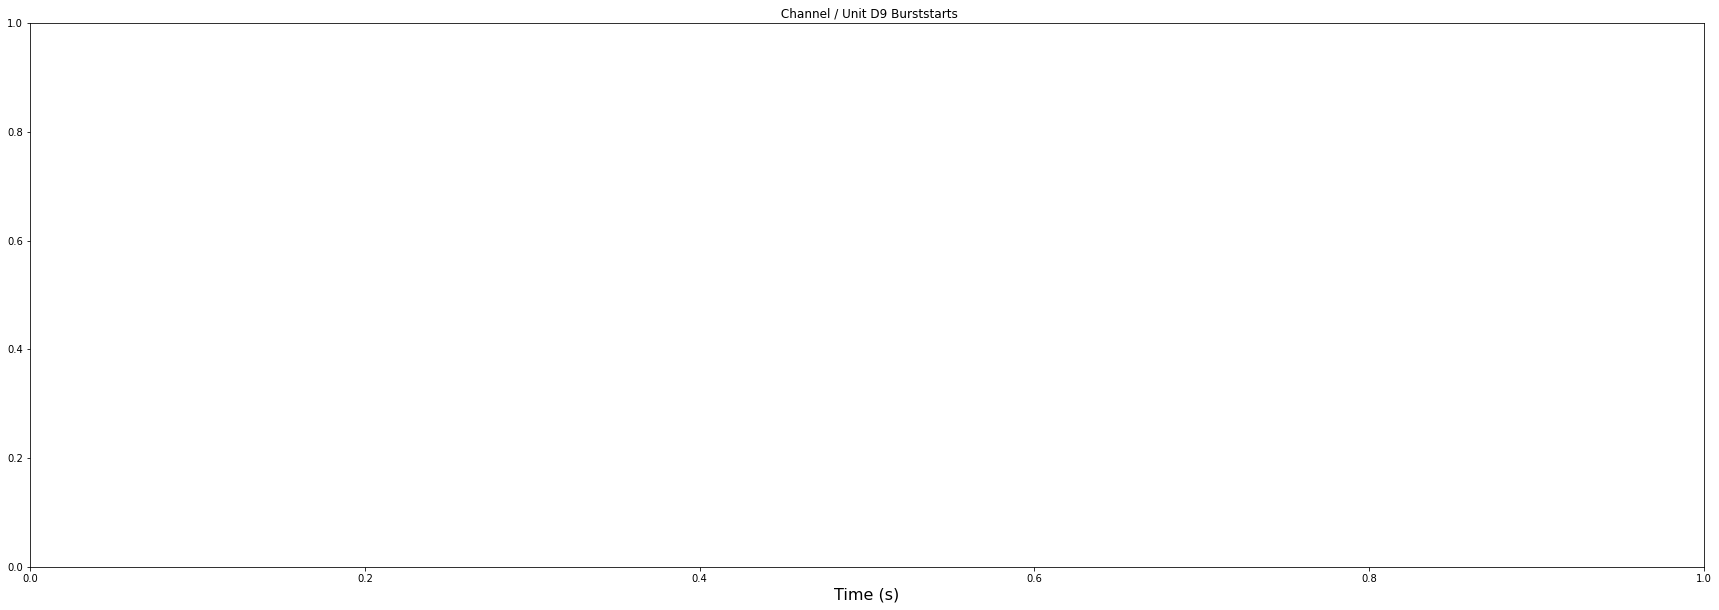

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E9 Burststarts')

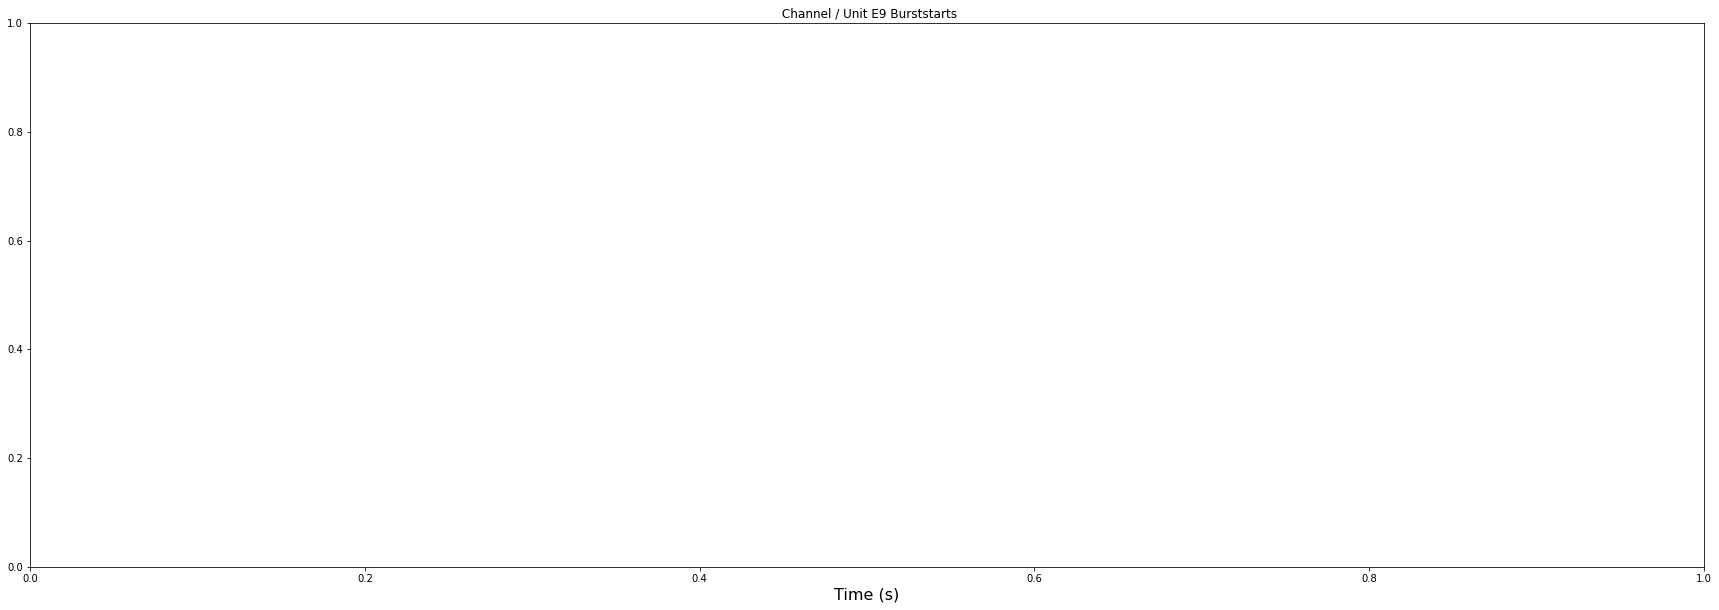

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B9 Burststarts')

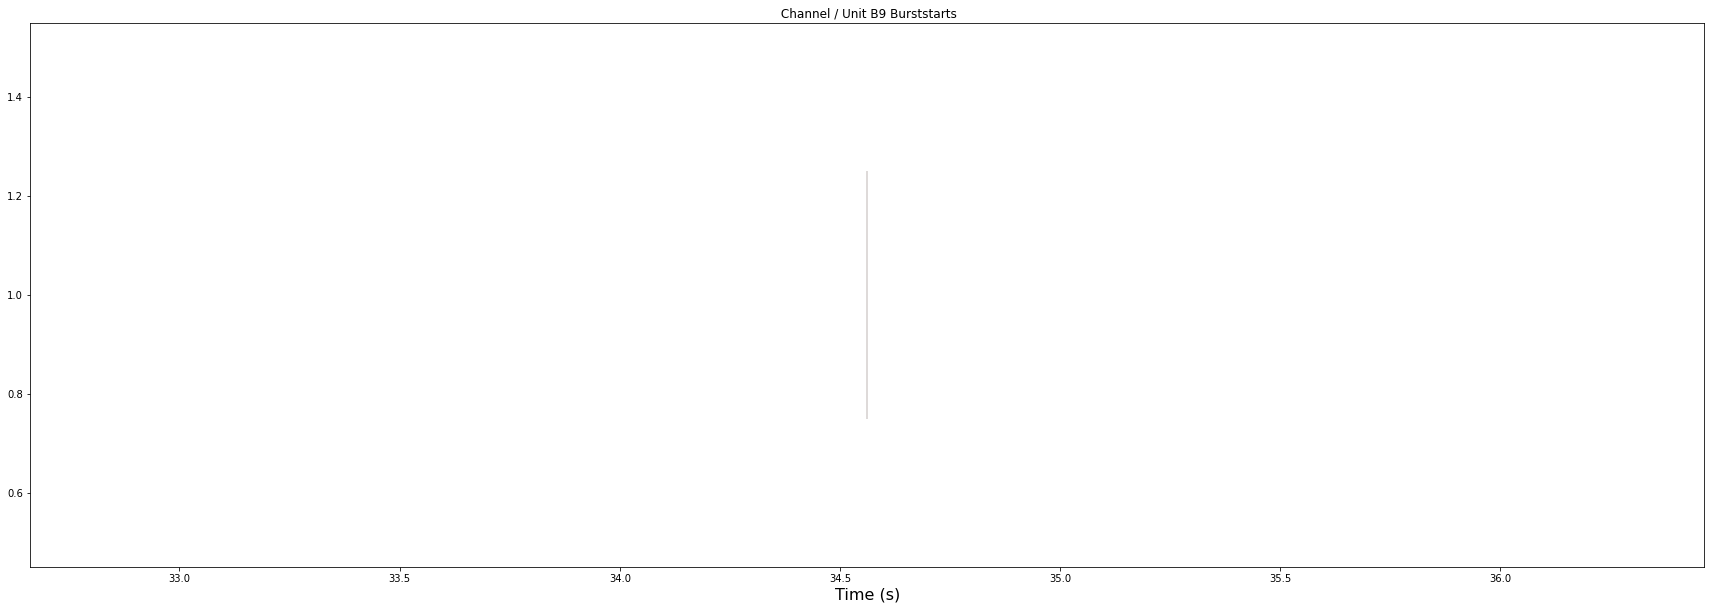

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C9 Burststarts')

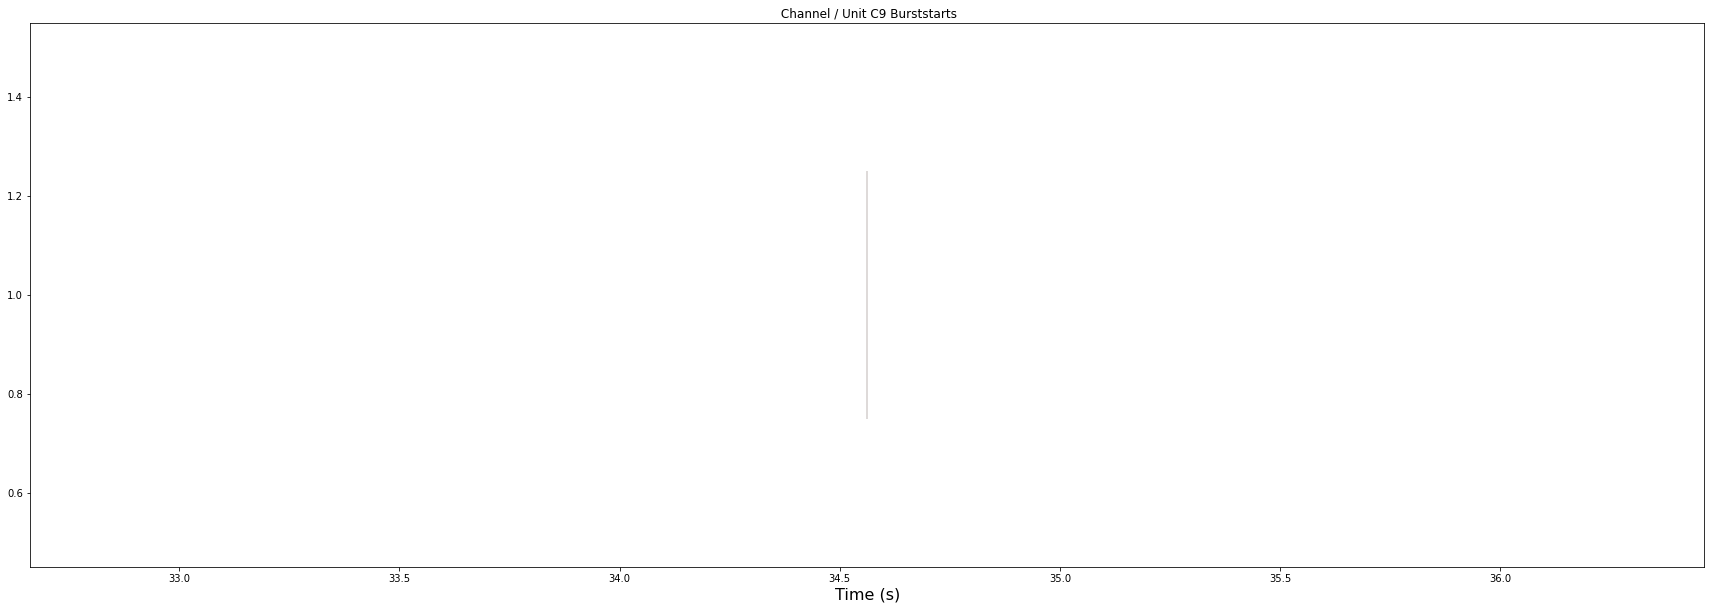

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F9 Burststarts')

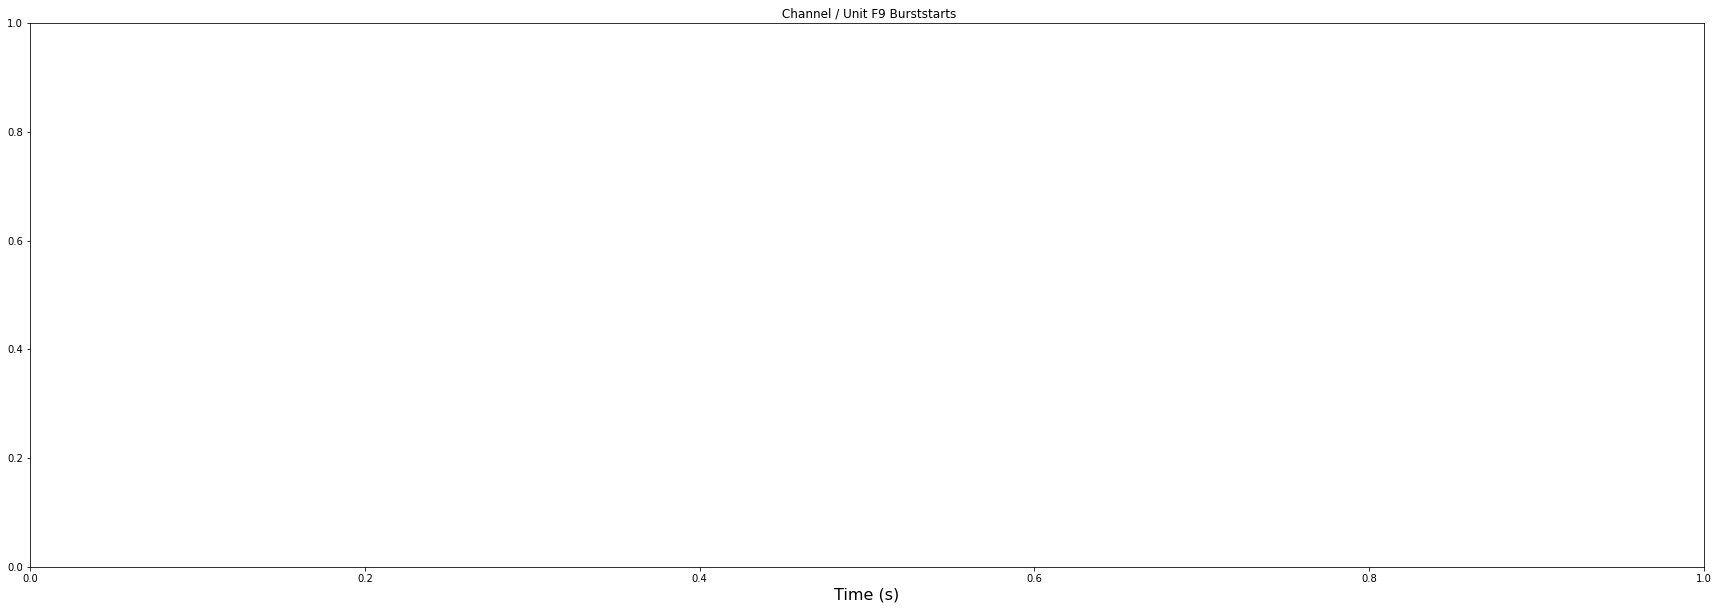

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A9 Burststarts')

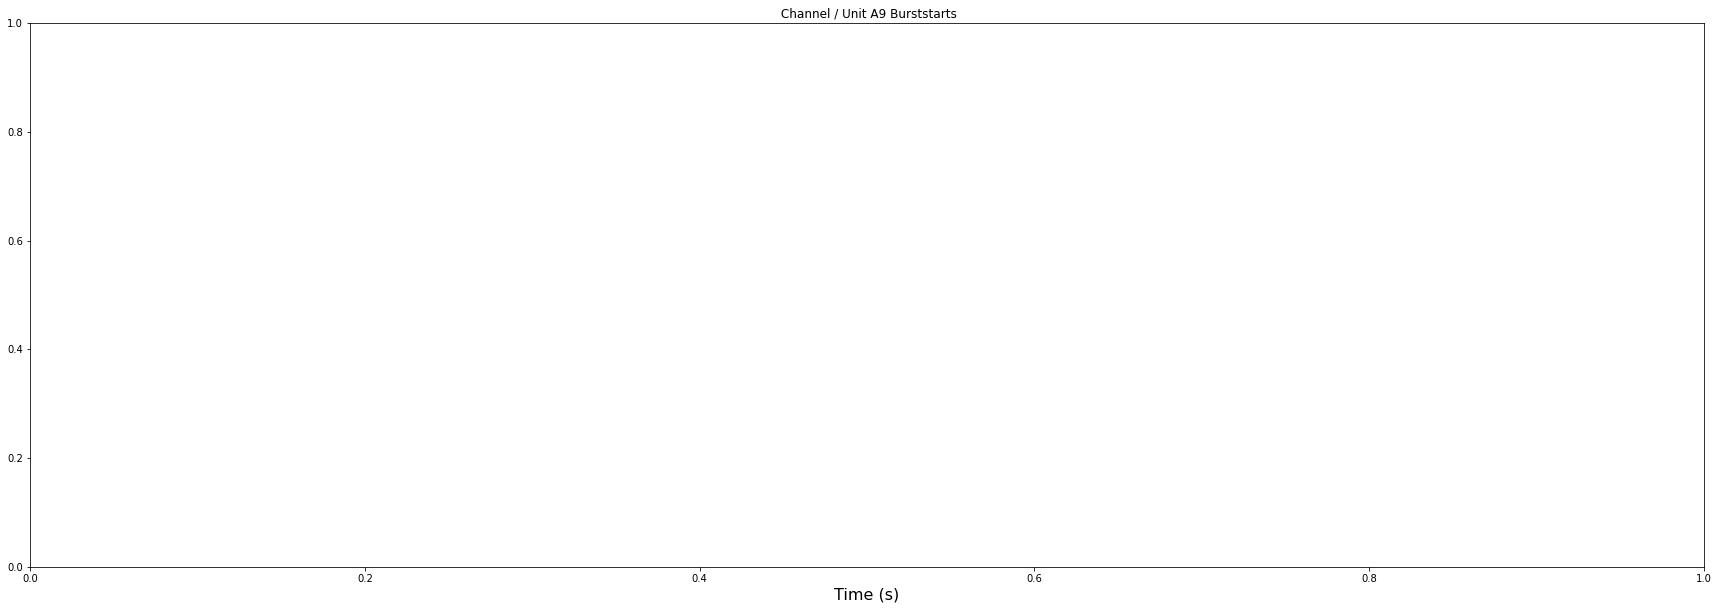

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G8 Burststarts')

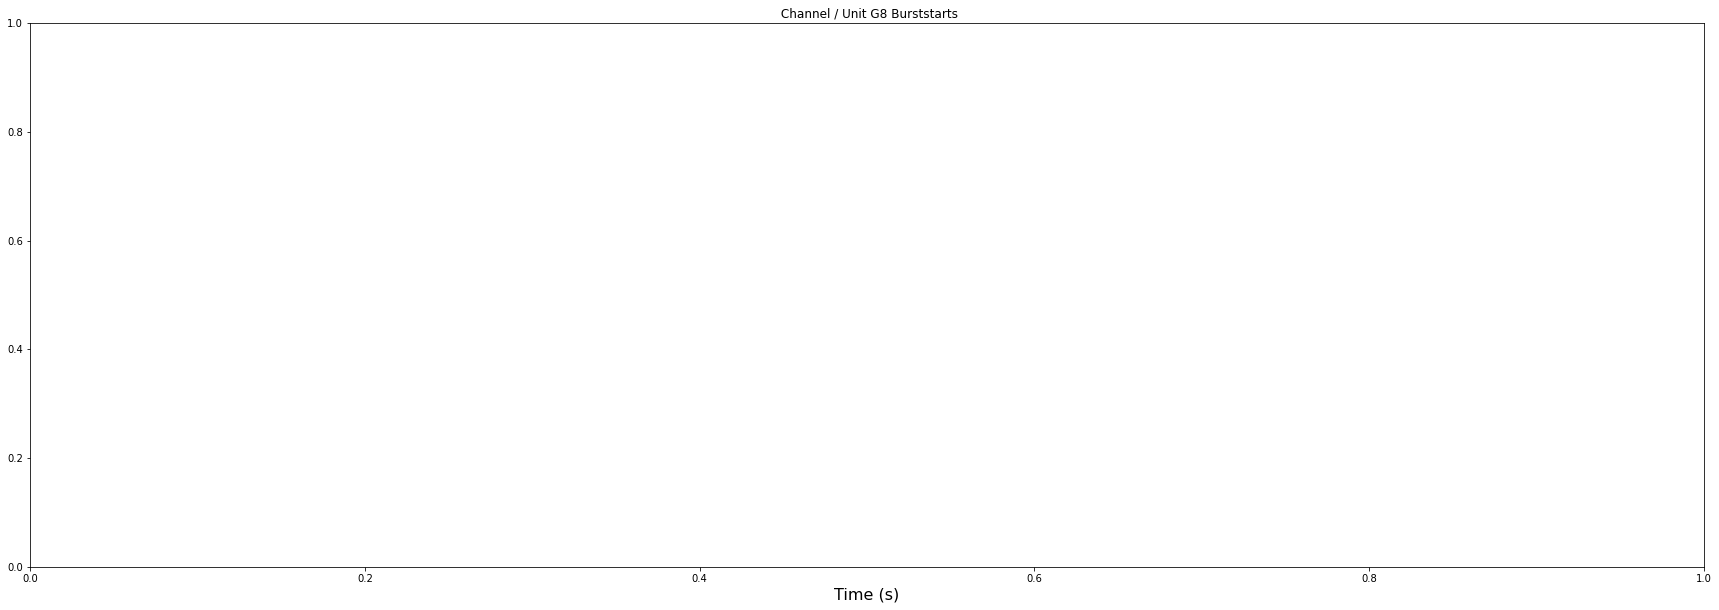

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G9 Burststarts')

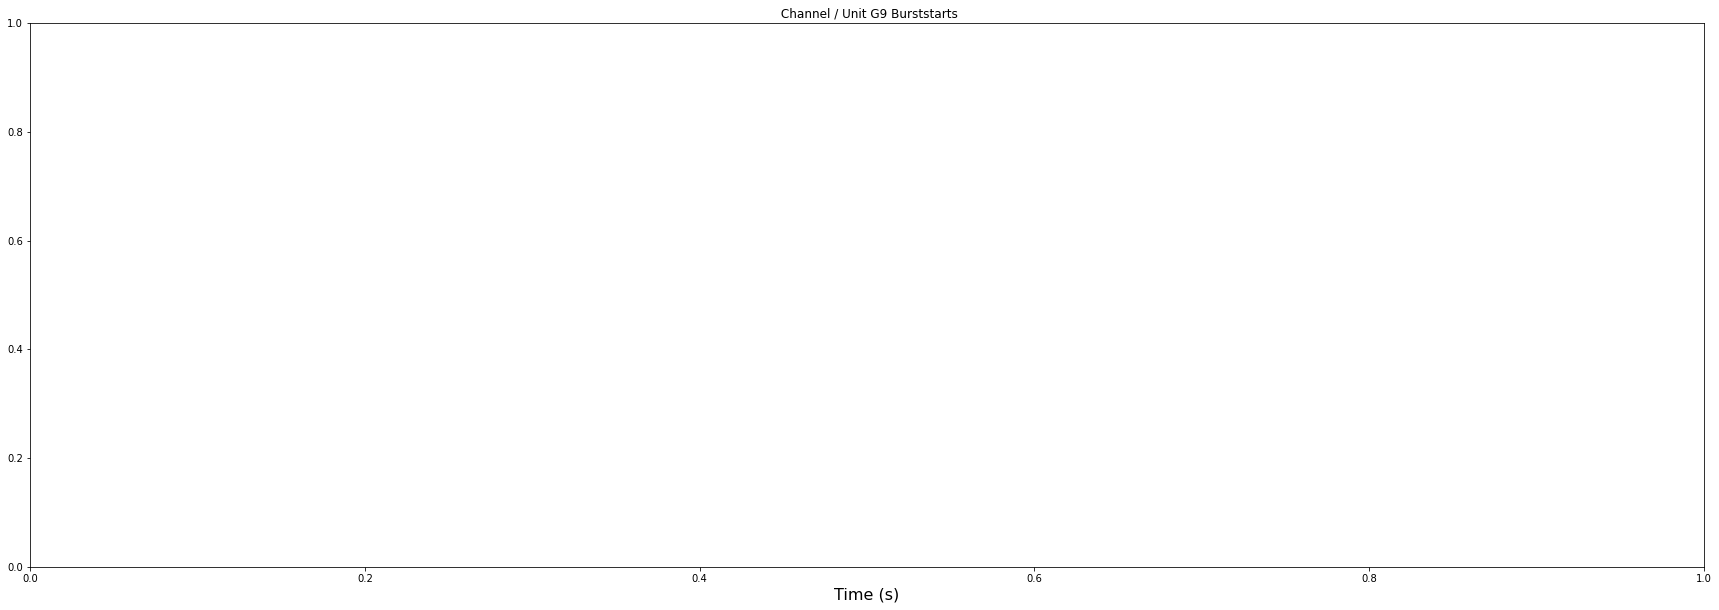

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A8 Burststarts')

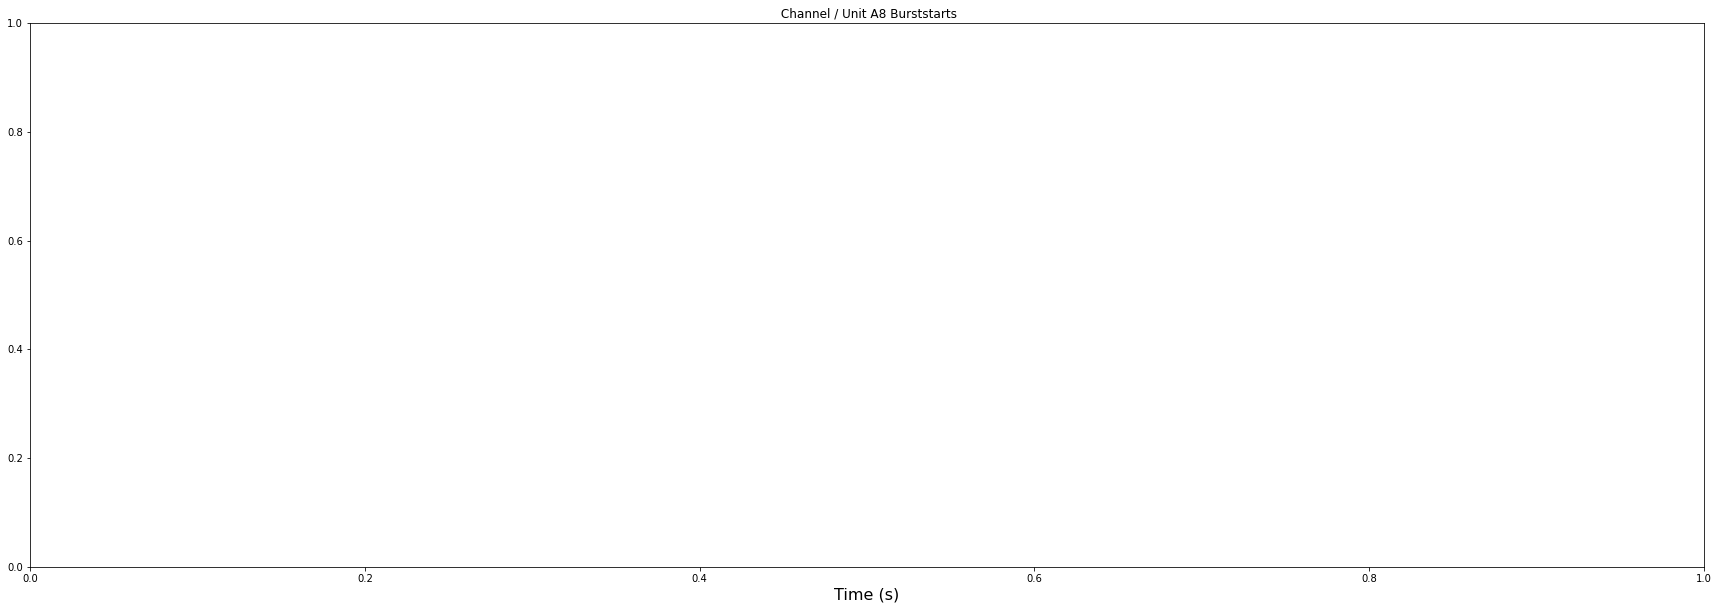

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F8 Burststarts')

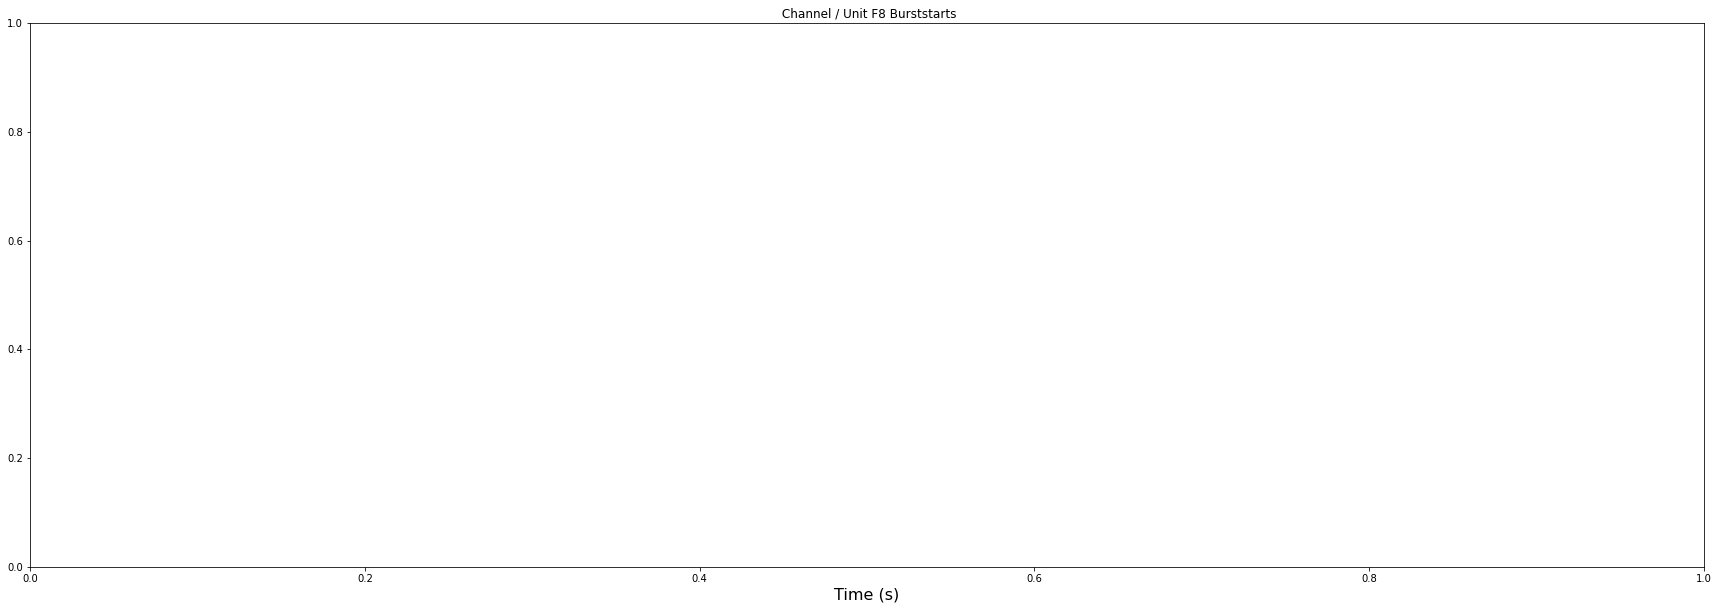

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C8 Burststarts')

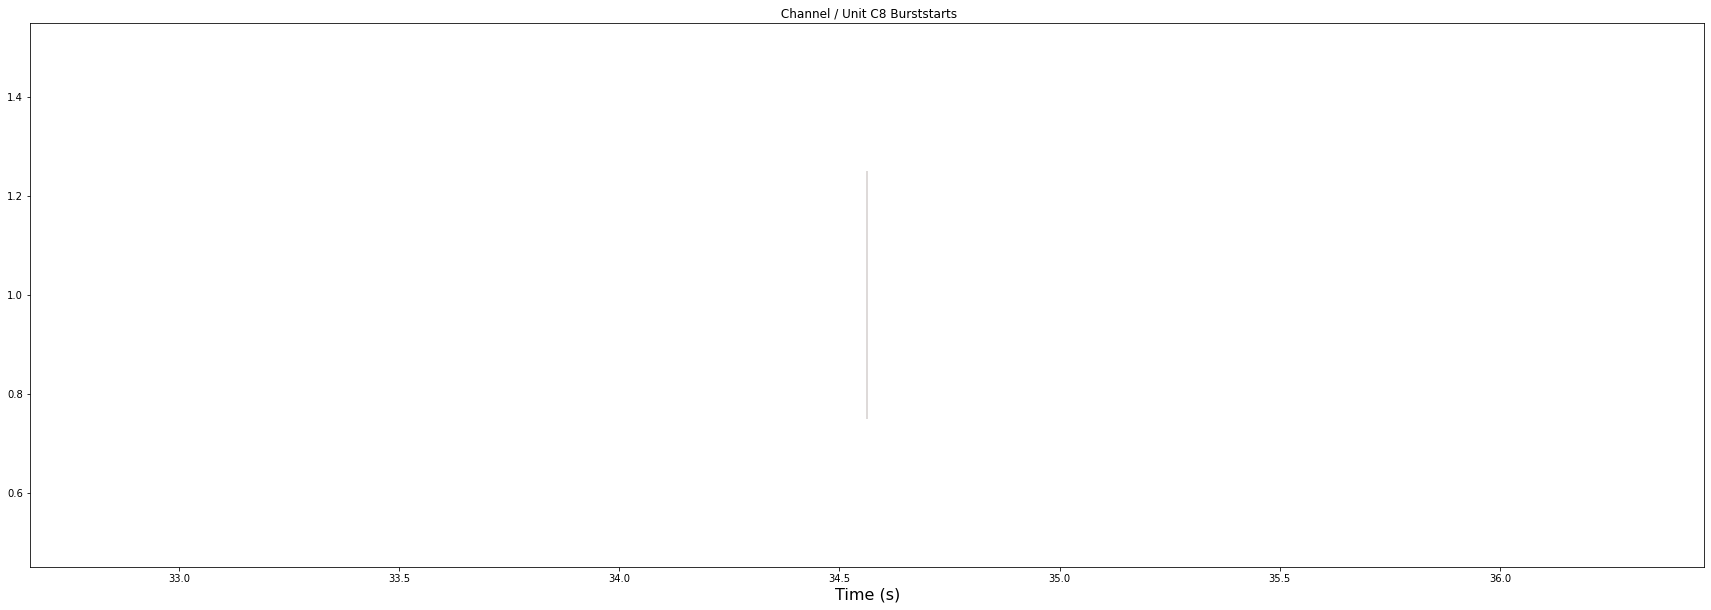

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B8 Burststarts')

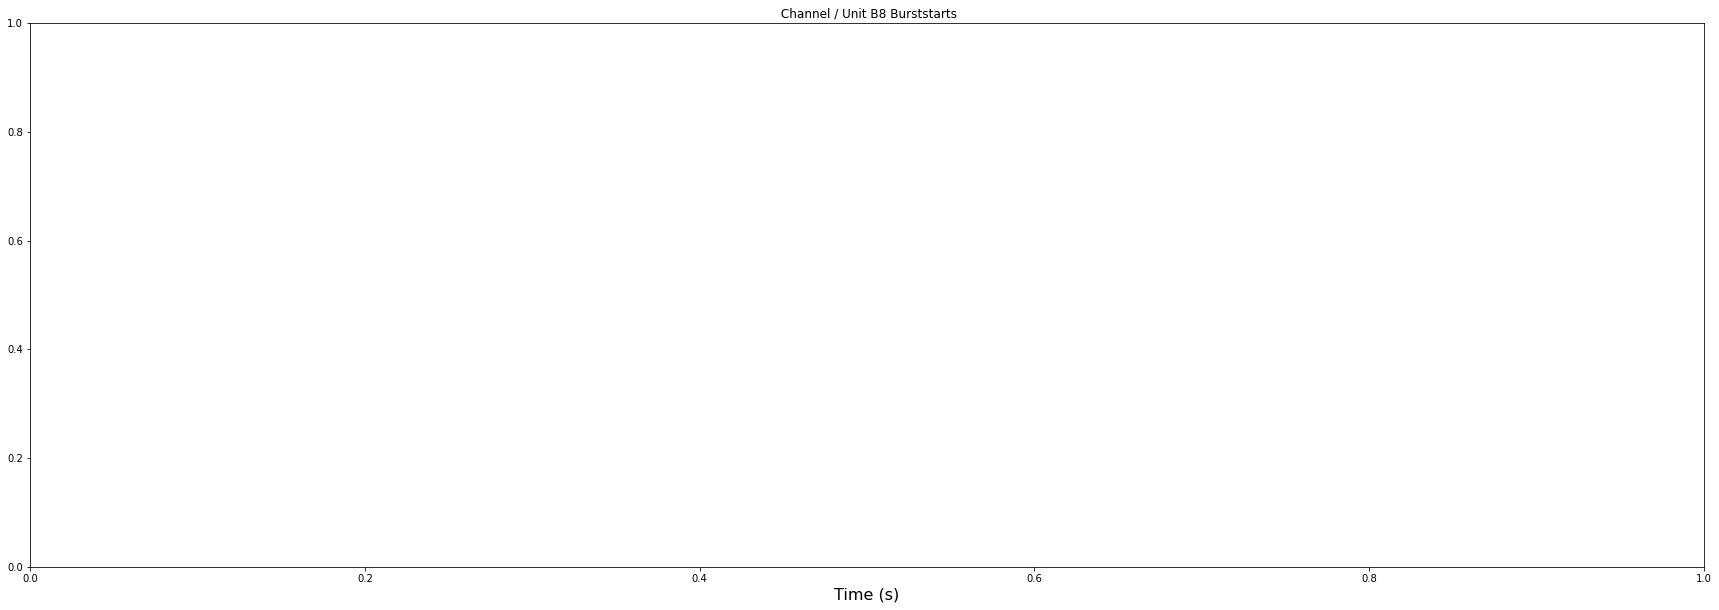

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E8 Burststarts')

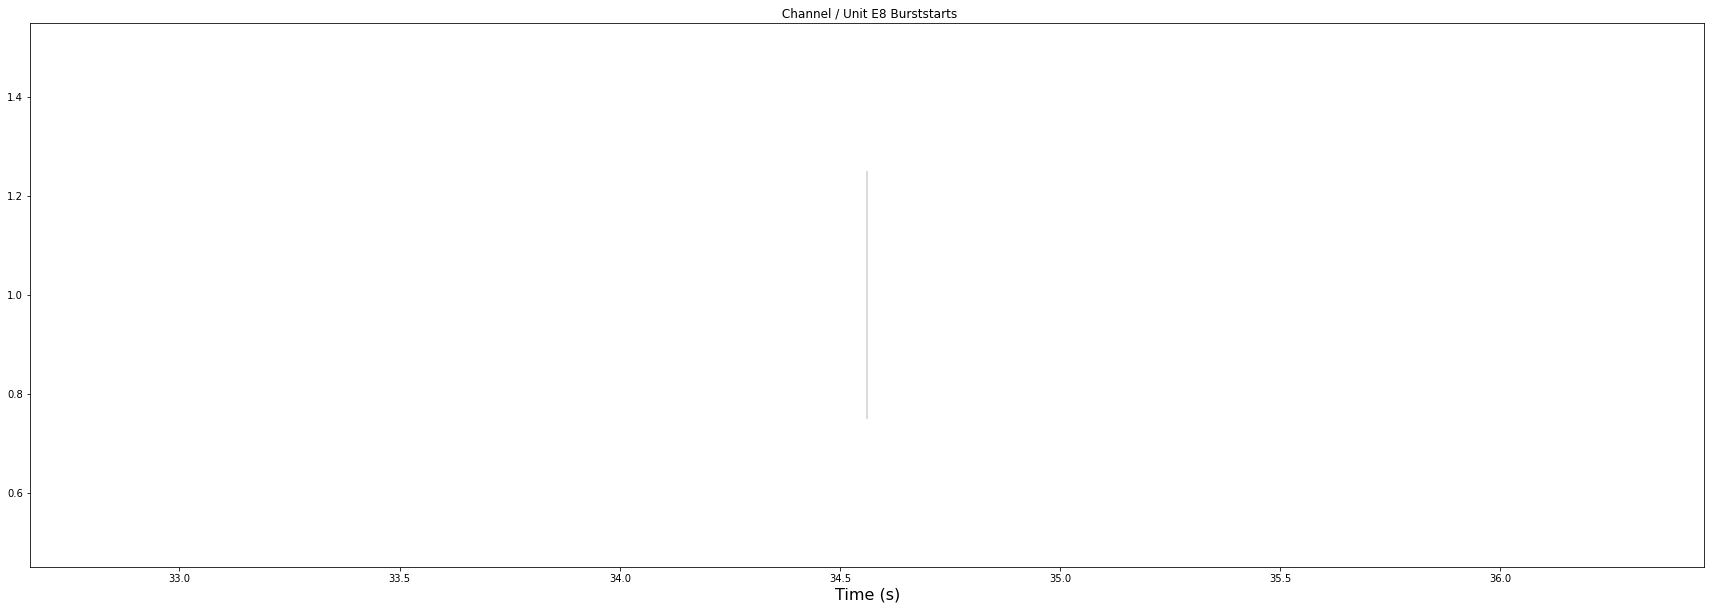

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D8 Burststarts')

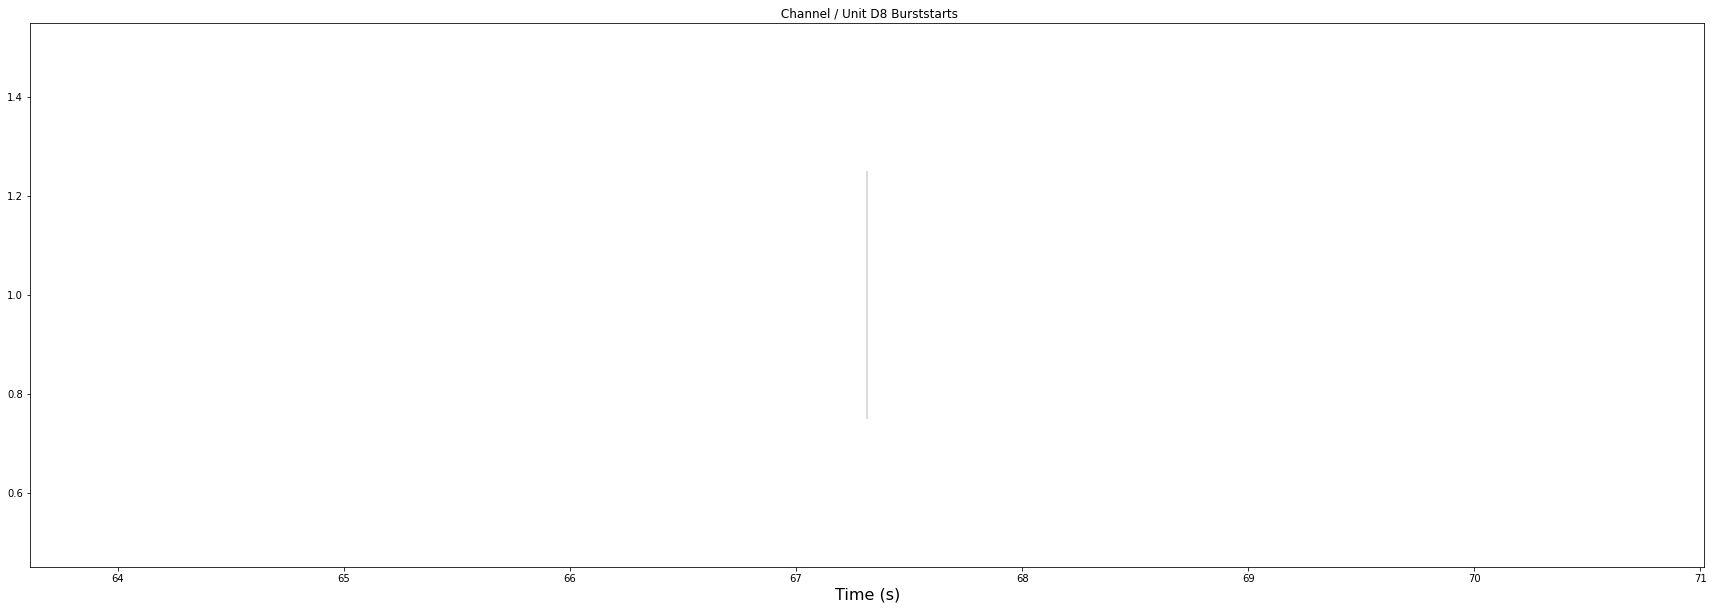

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B7 Burststarts')

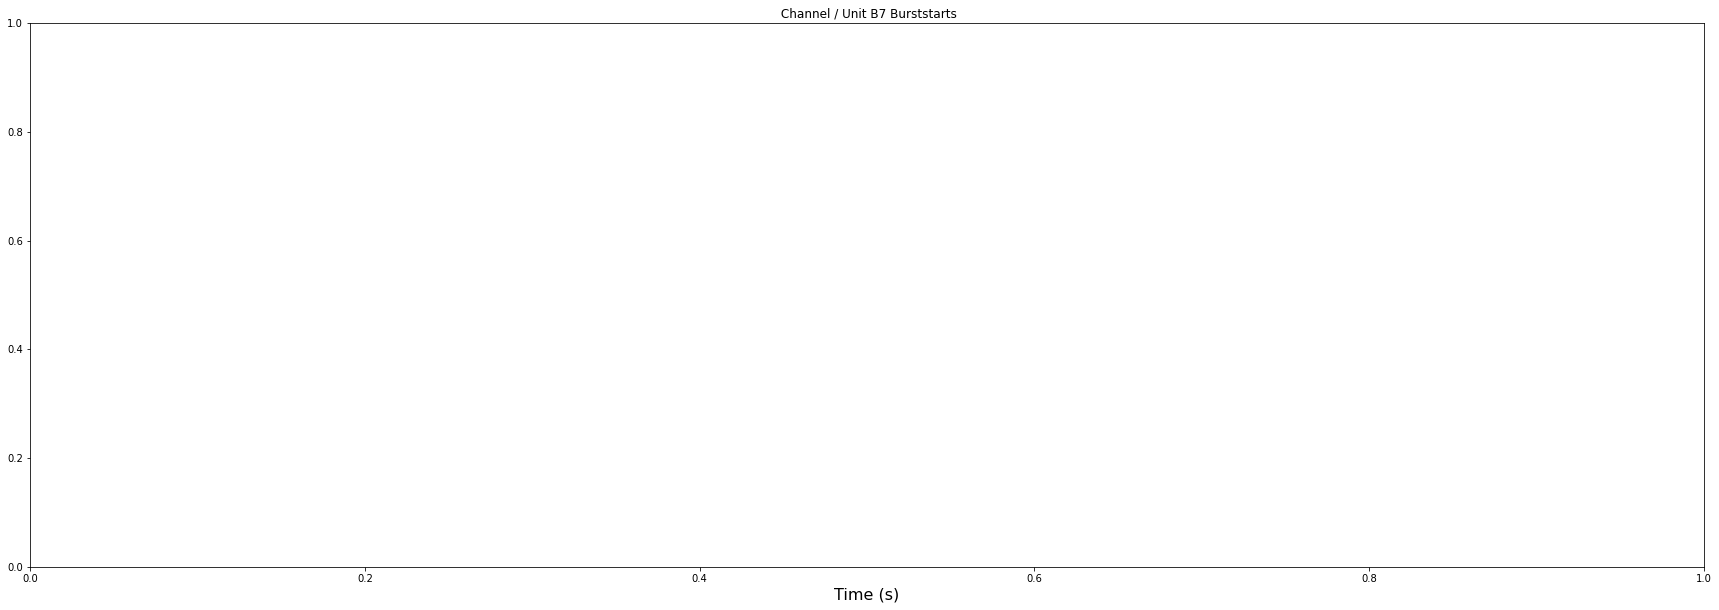

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A7 Burststarts')

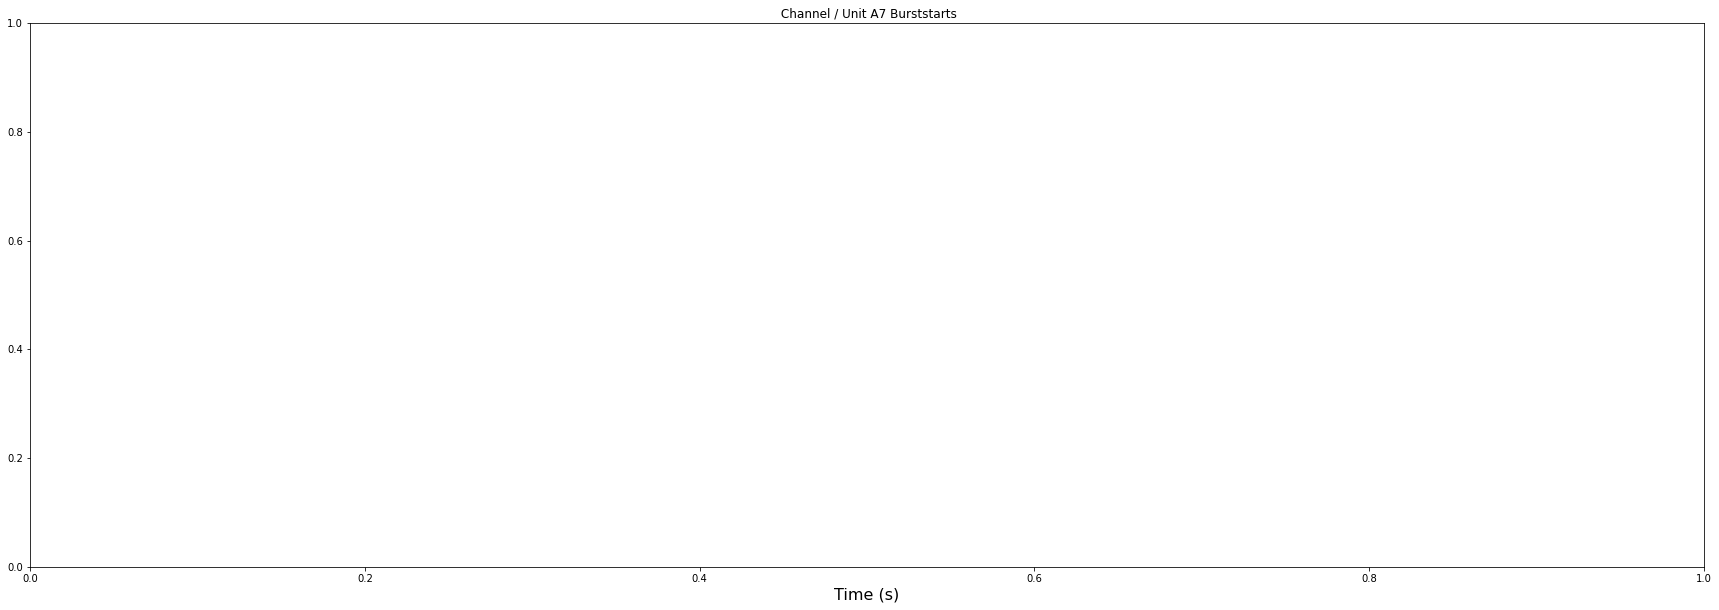

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D7 Burststarts')

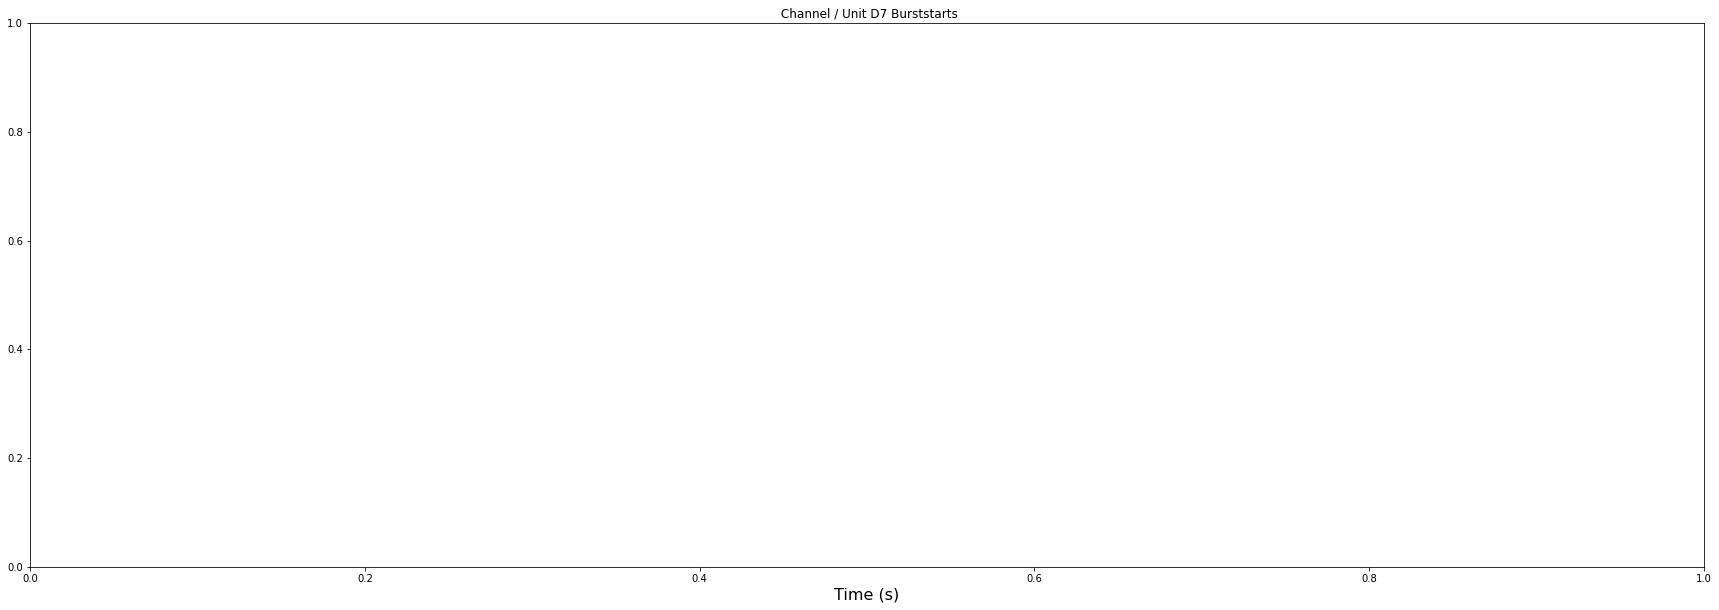

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C7 Burststarts')

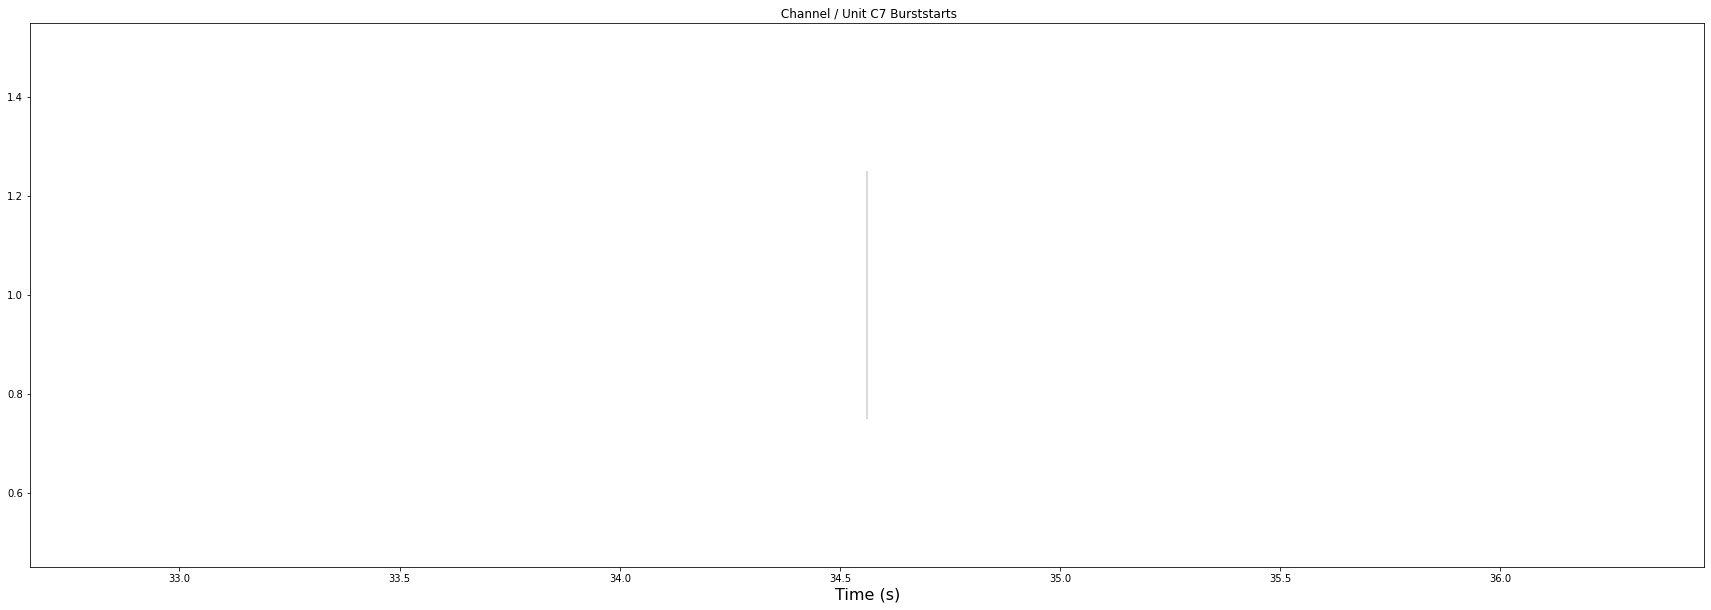

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A6 Burststarts')

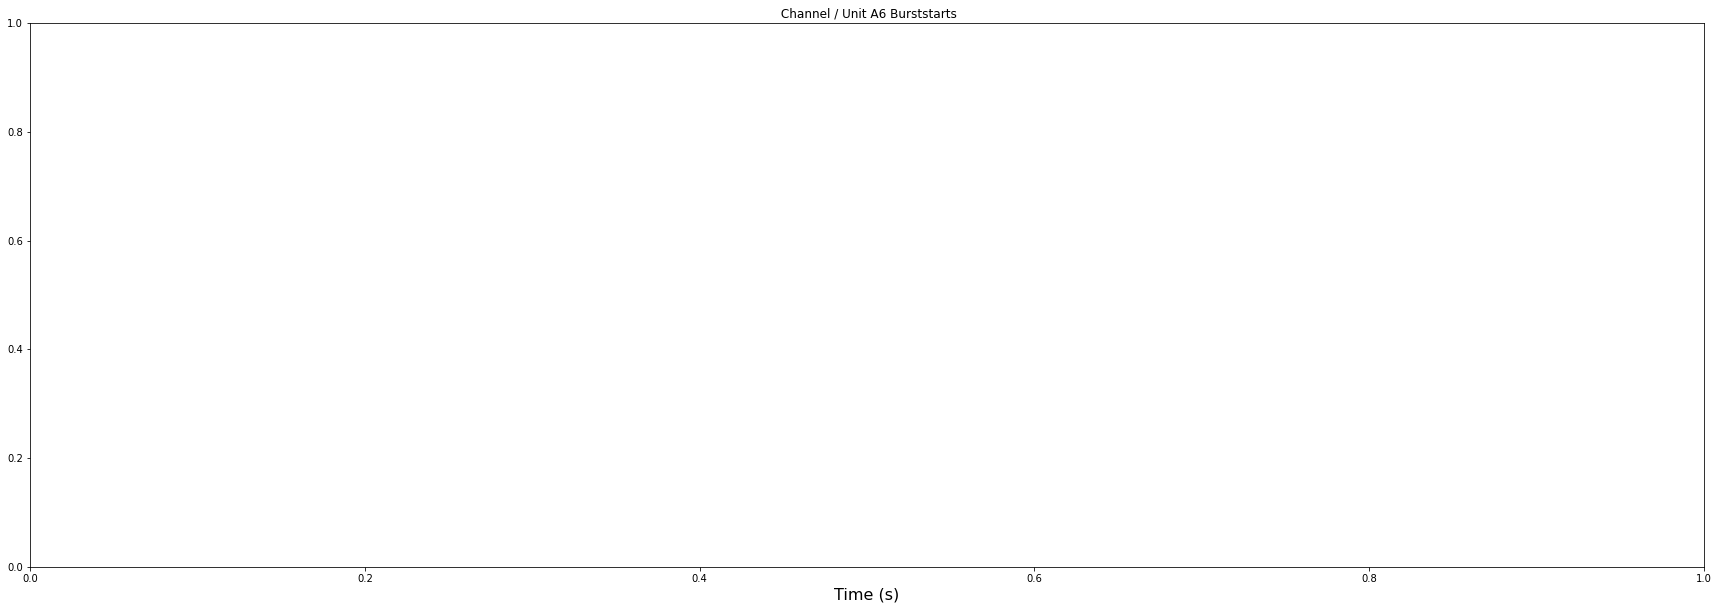

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E7 Burststarts')

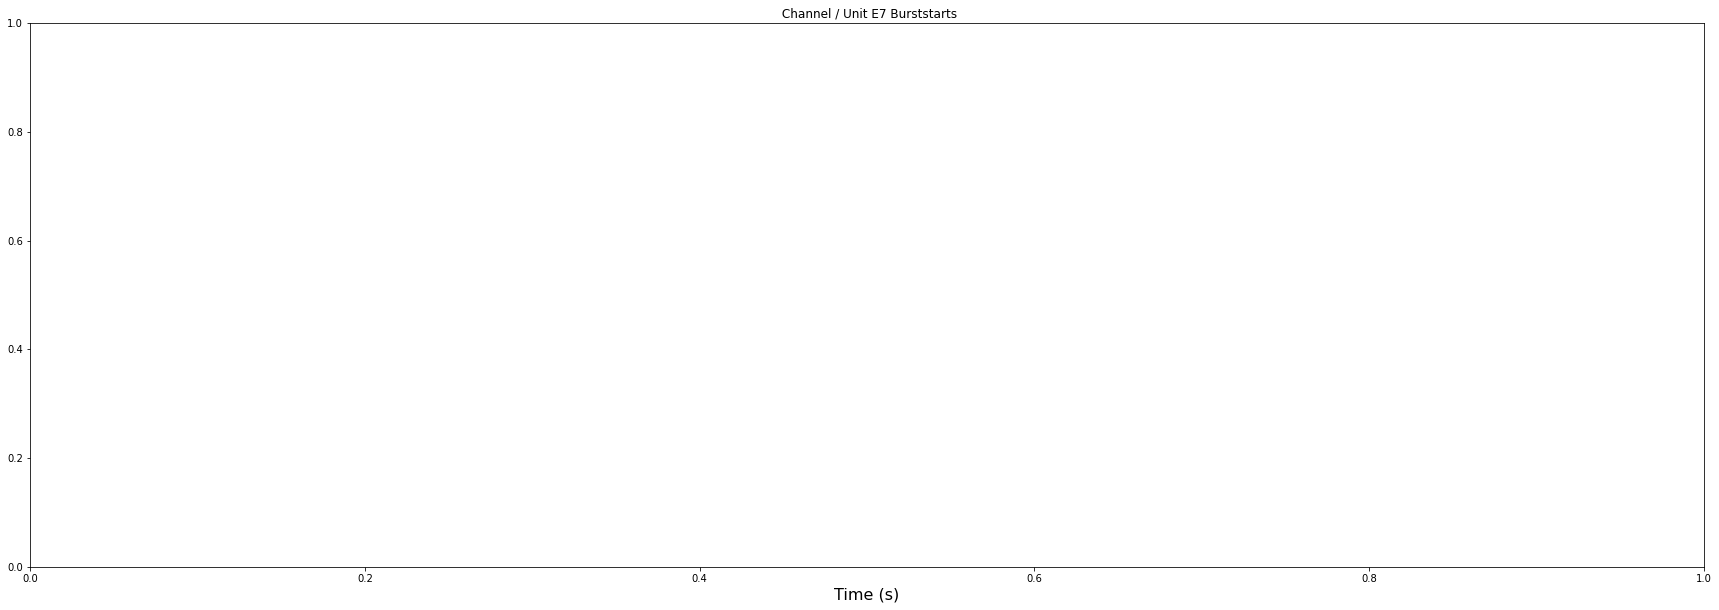

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C6 Burststarts')

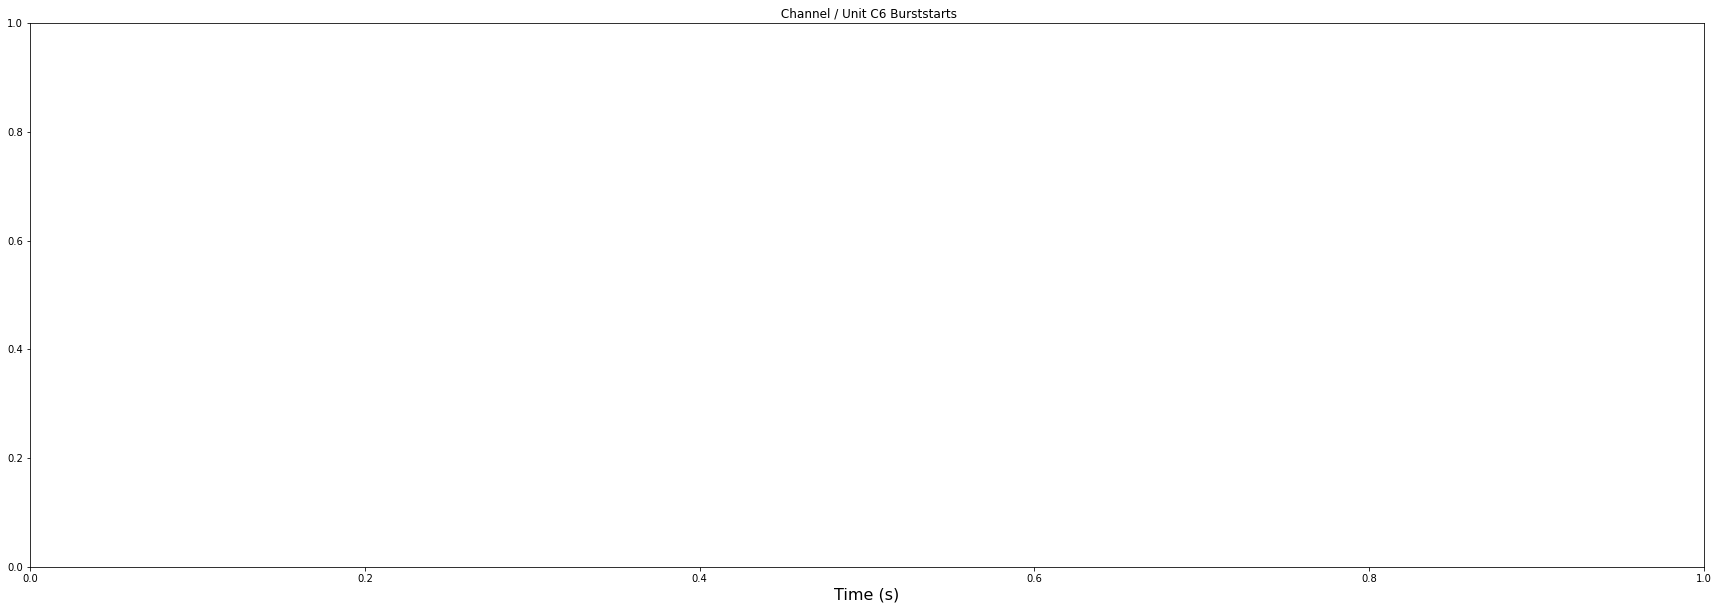

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B6 Burststarts')

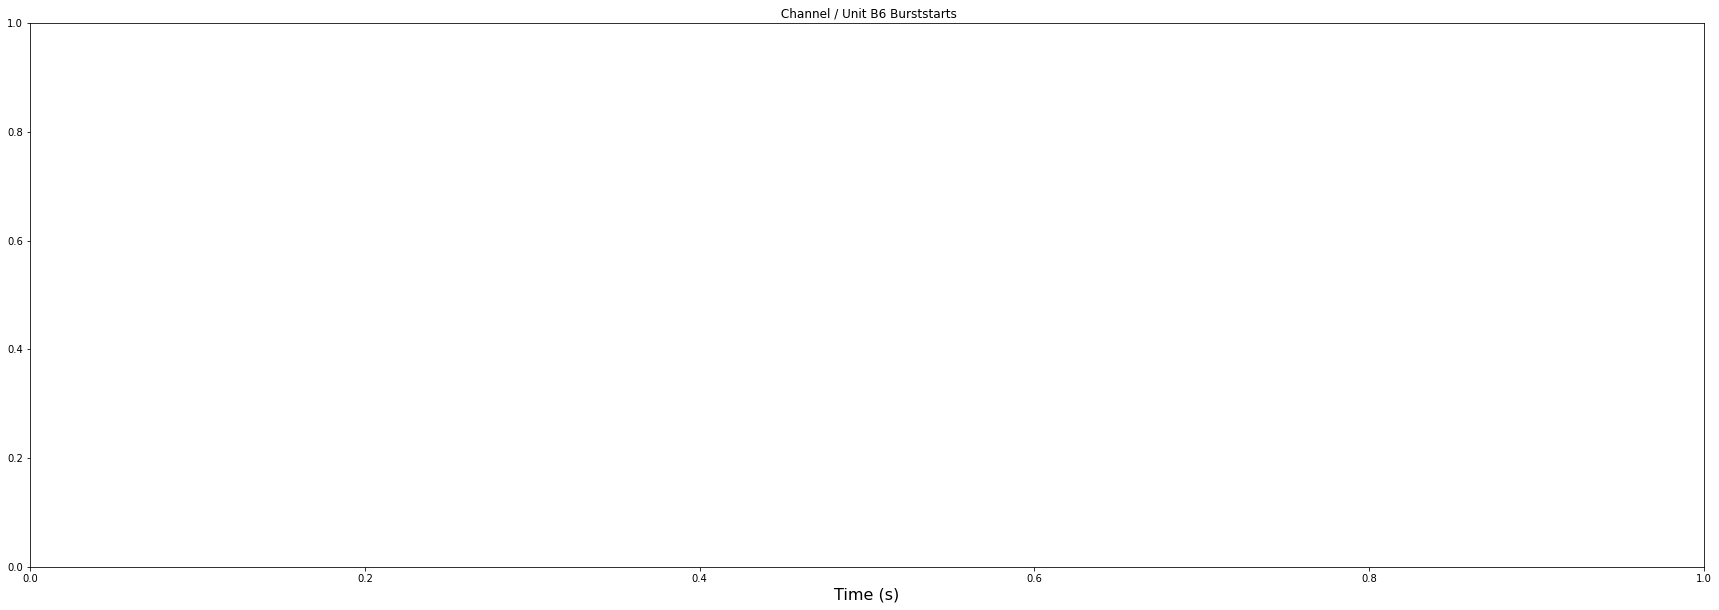

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E6 Burststarts')

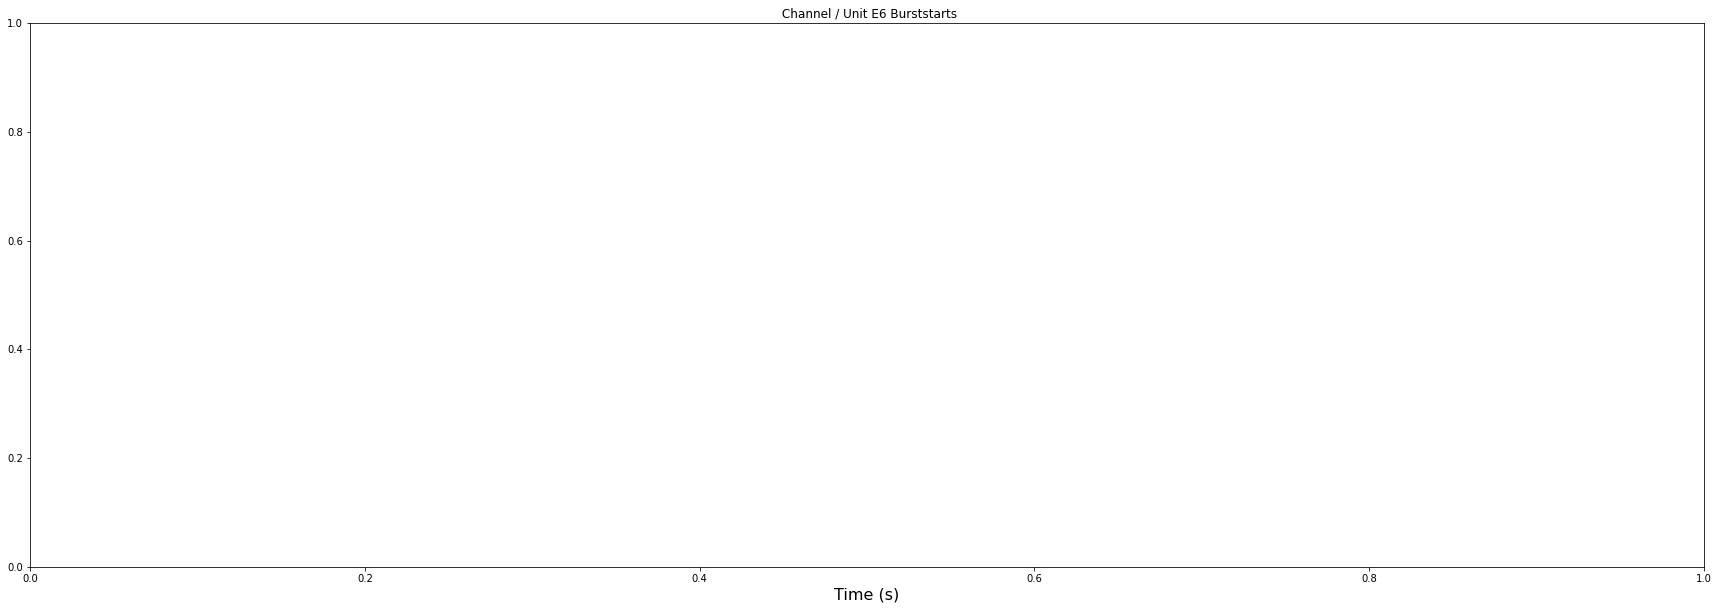

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D6 Burststarts')

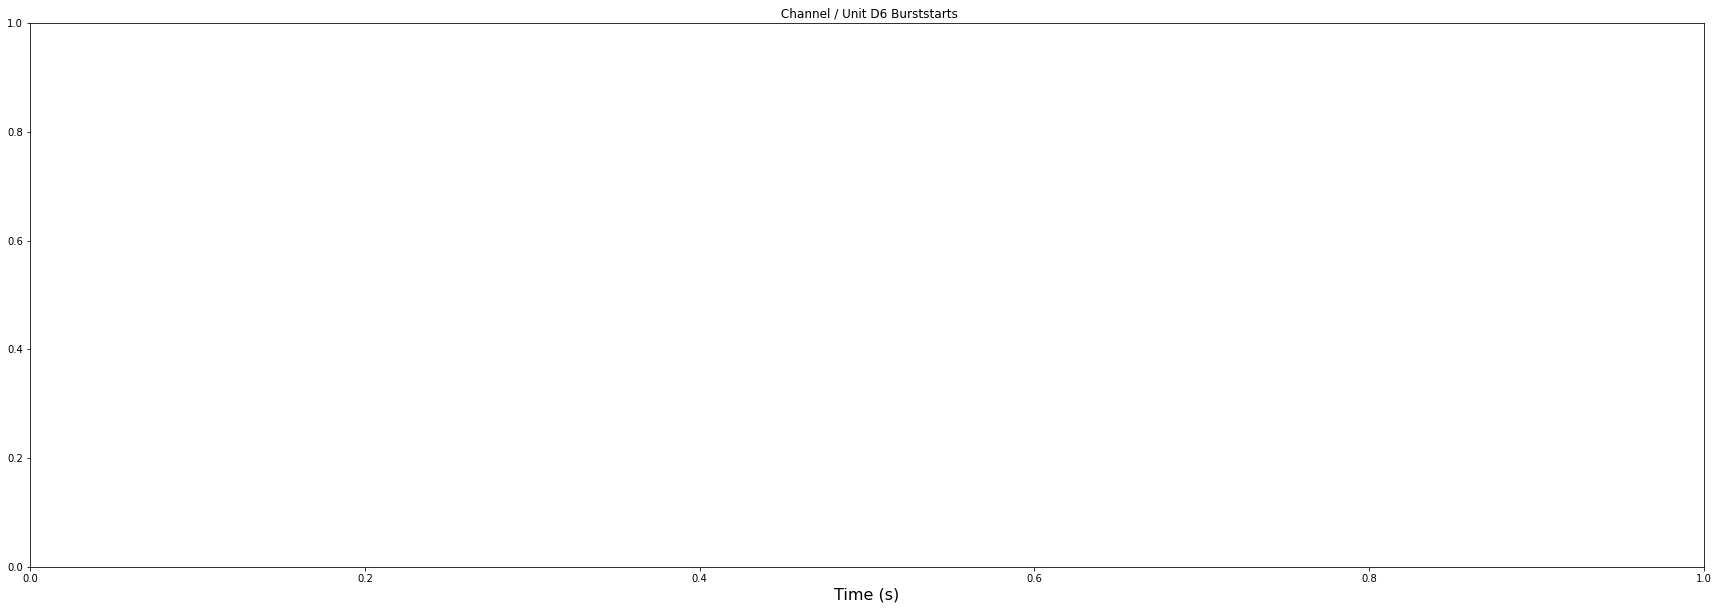

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B5 Burststarts')

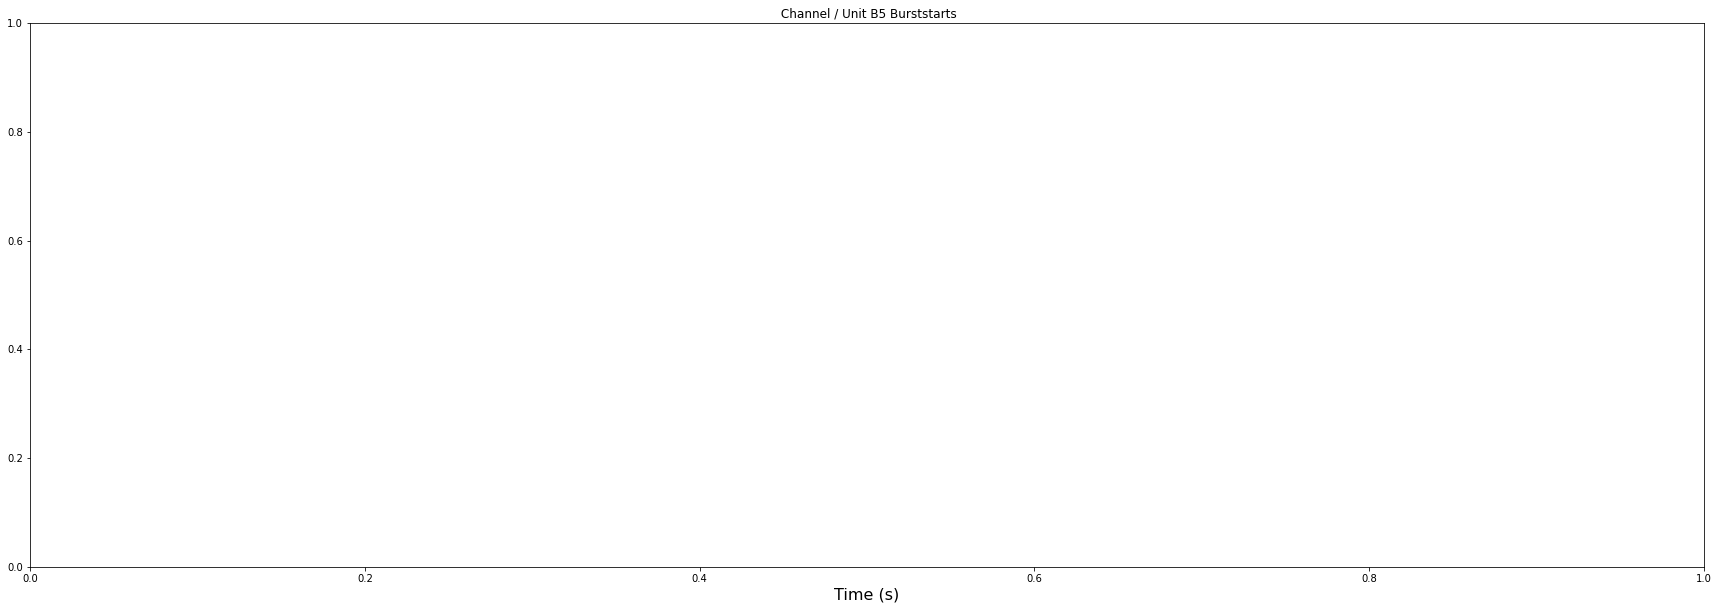

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A5 Burststarts')

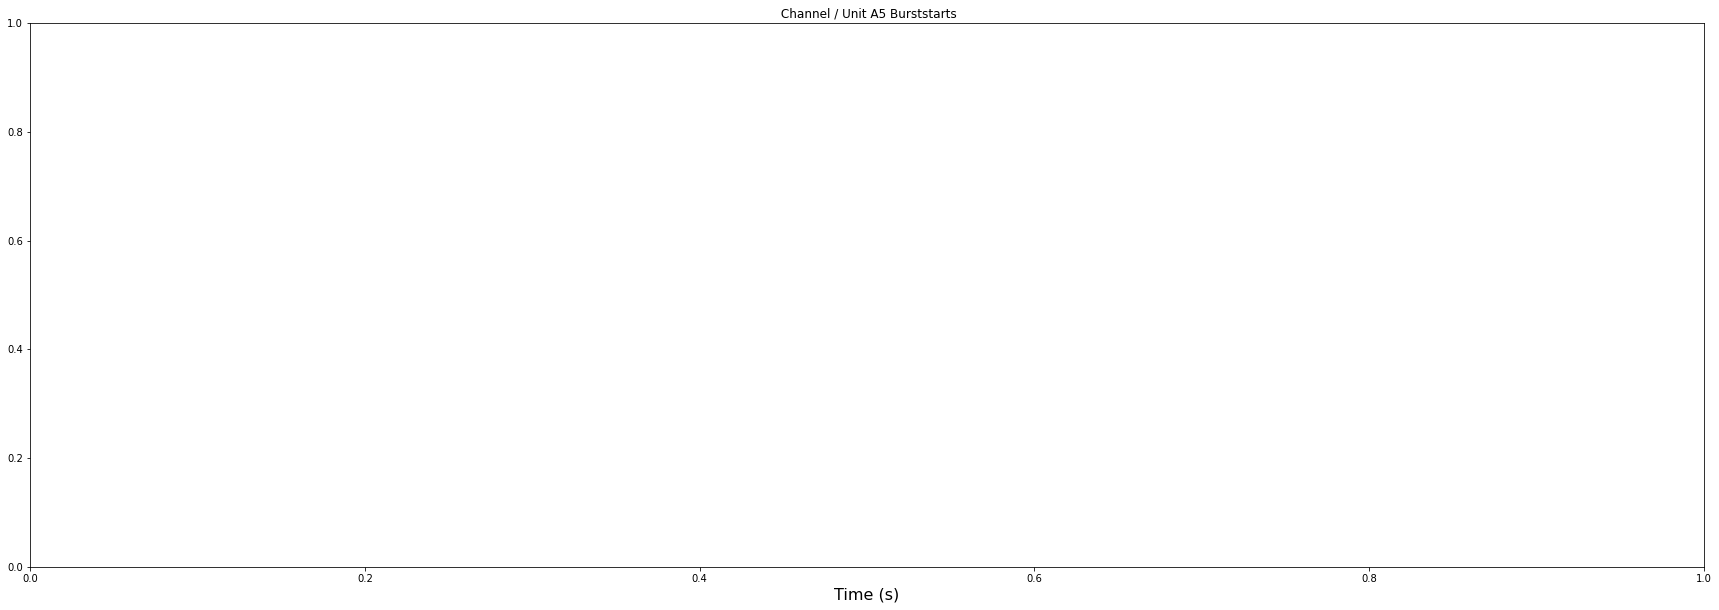

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D5 Burststarts')

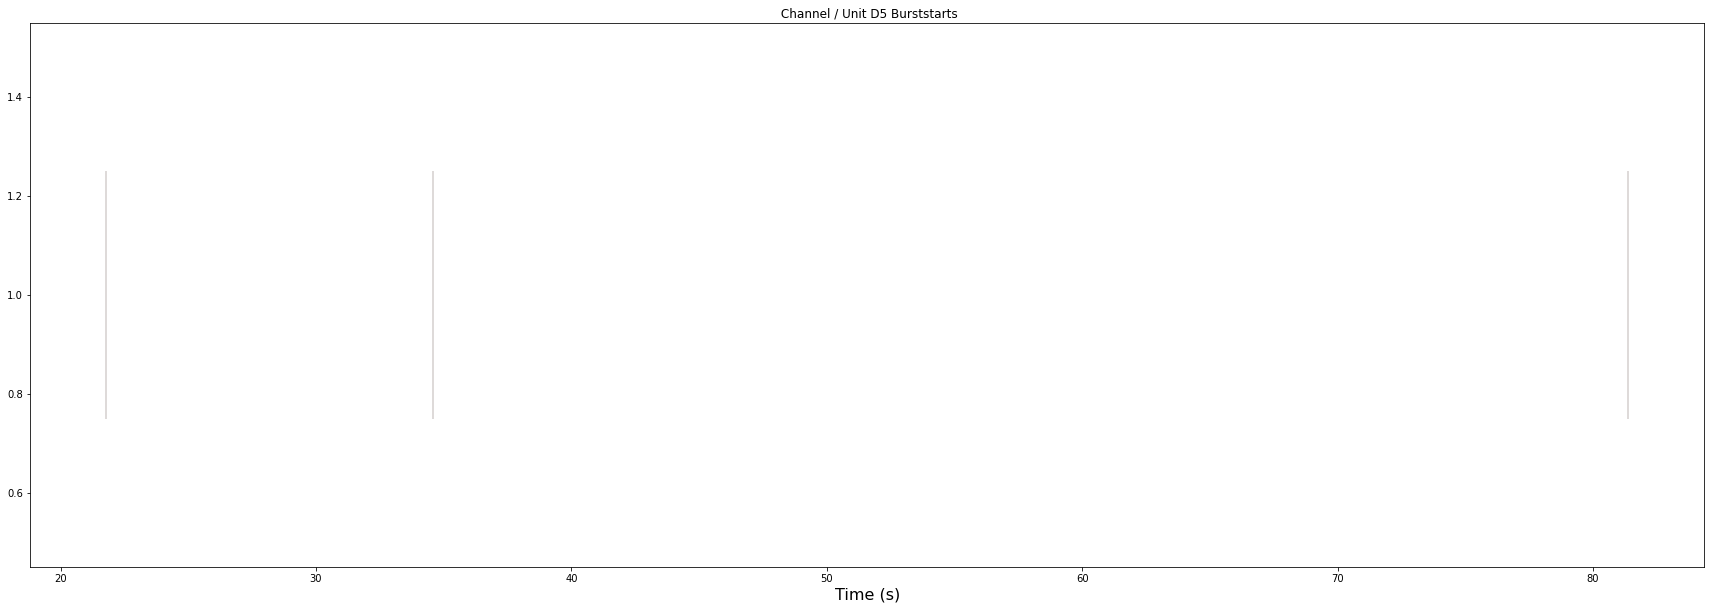

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C5 Burststarts')

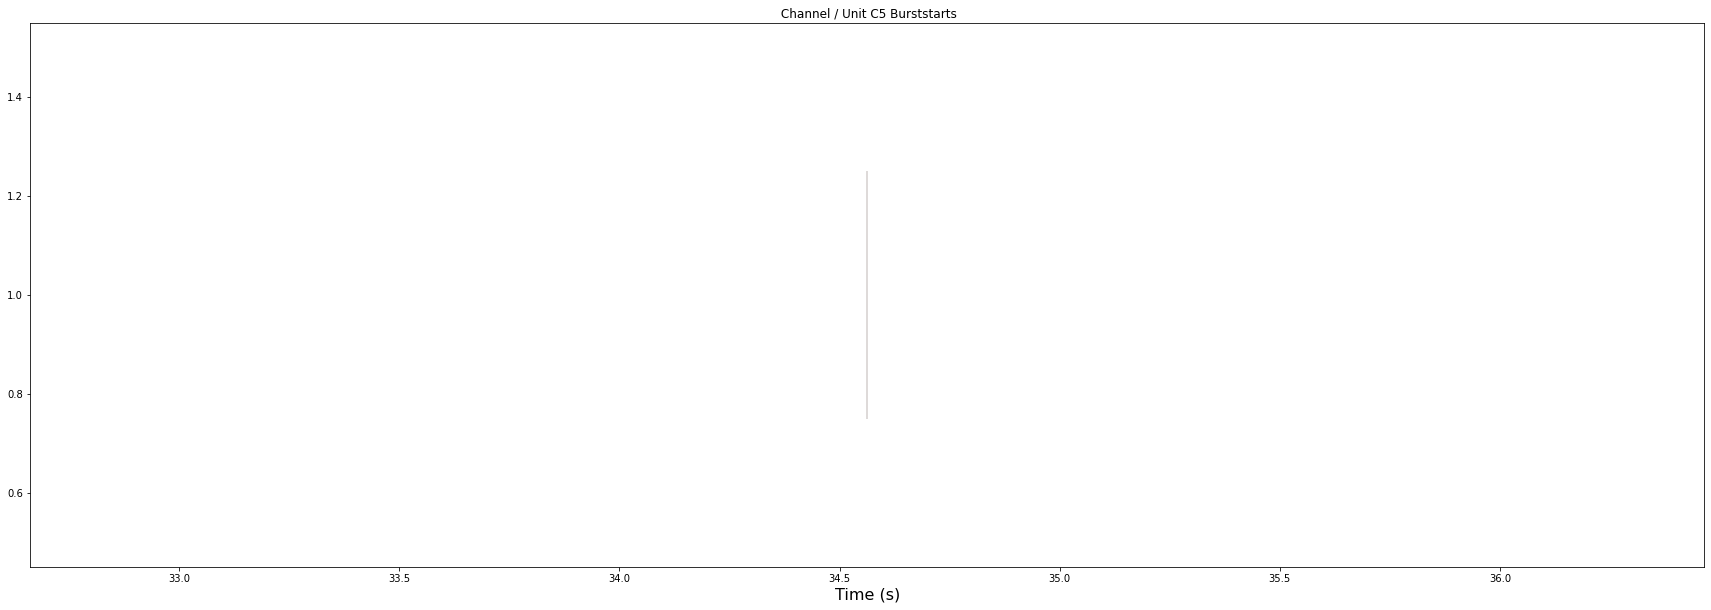

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A4 Burststarts')

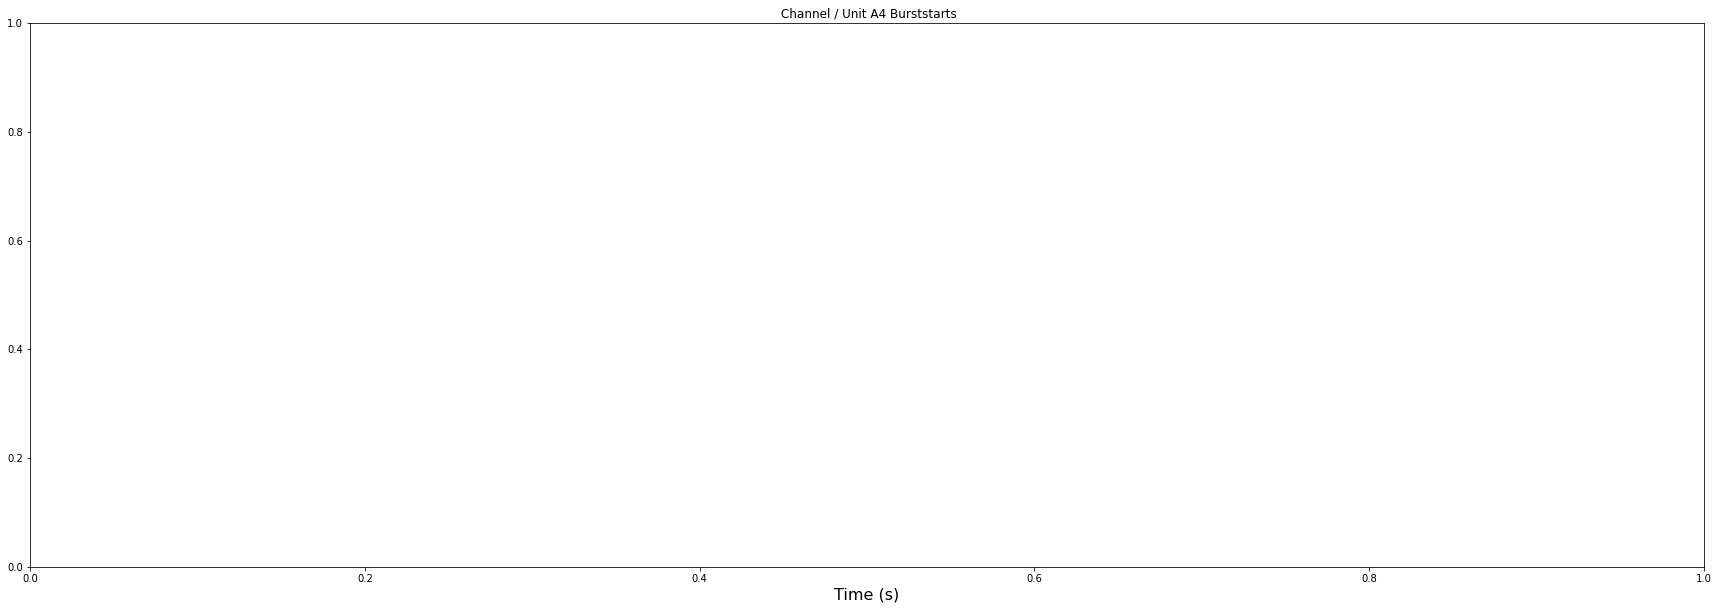

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F7 Burststarts')

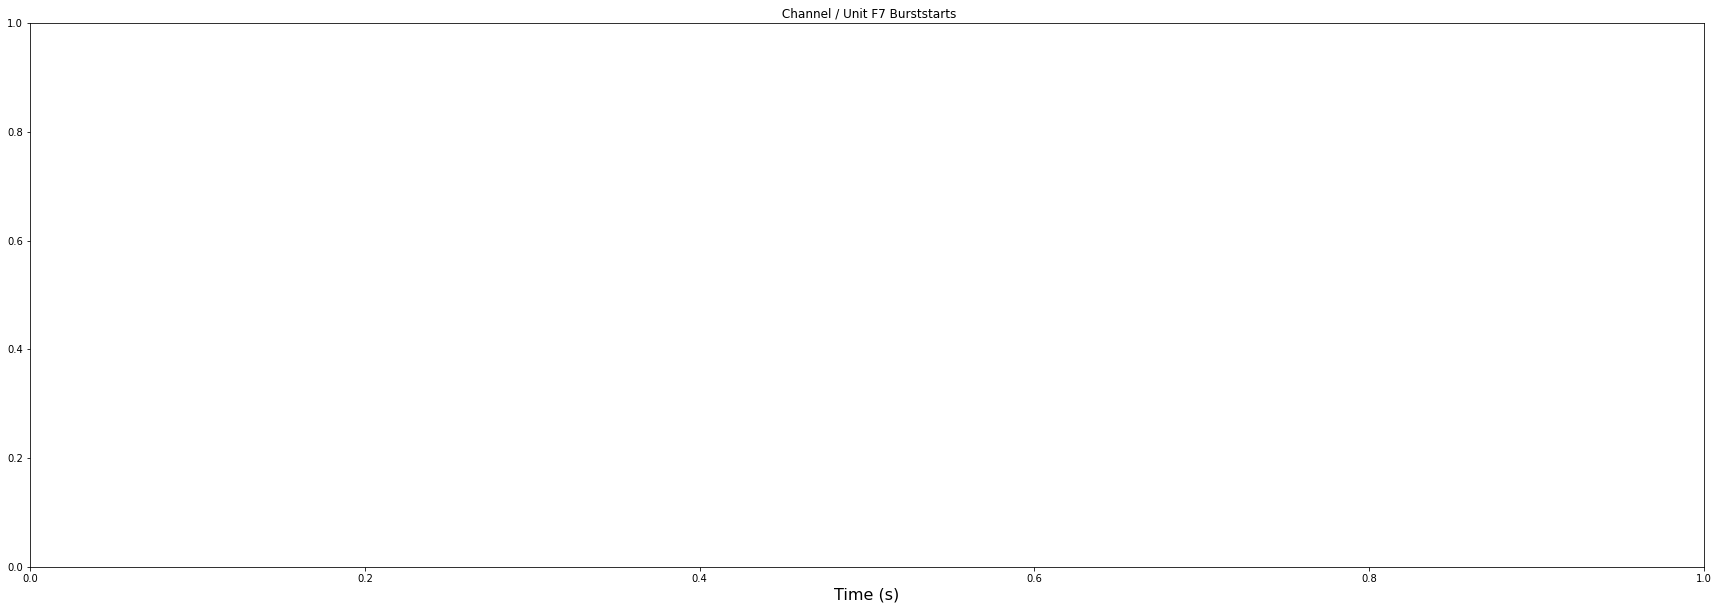

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C4 Burststarts')

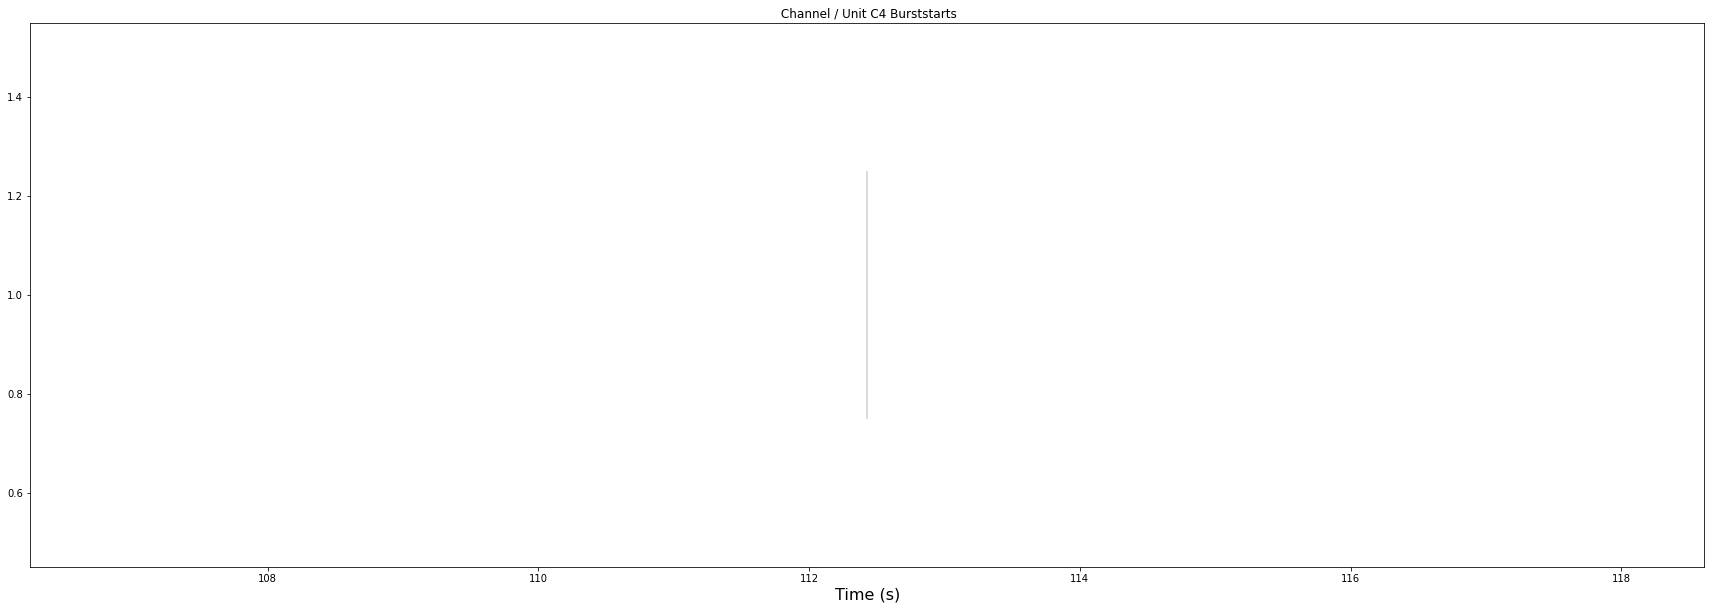

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B4 Burststarts')

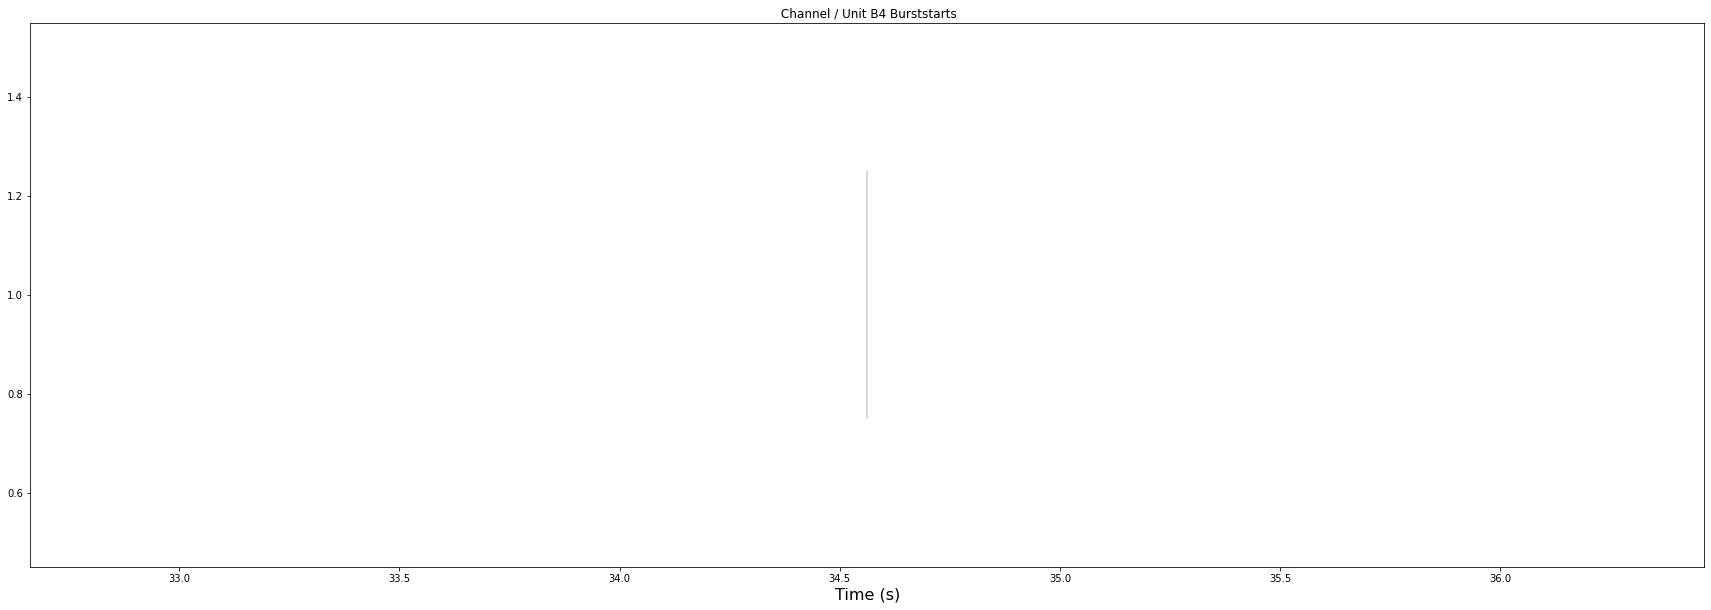

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F6 Burststarts')

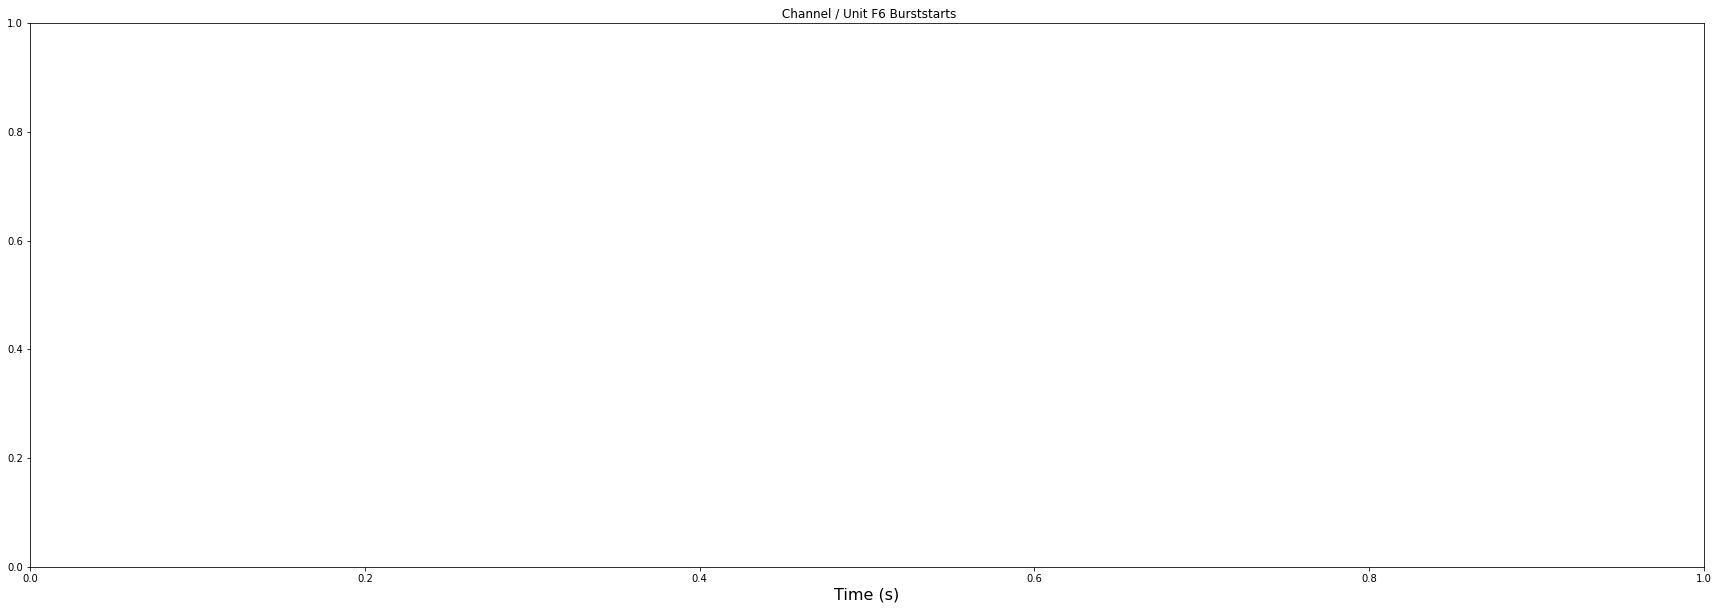

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H8 Burststarts')

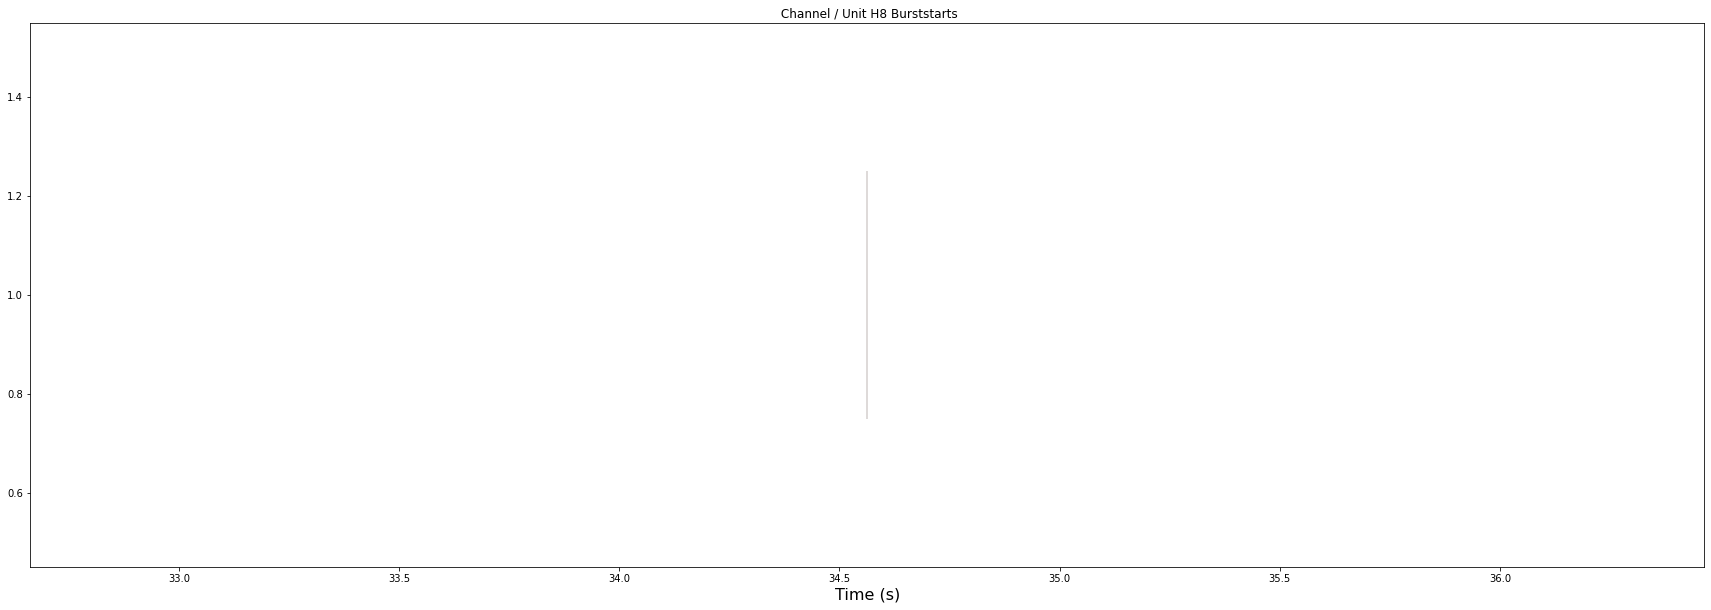

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B3 Burststarts')

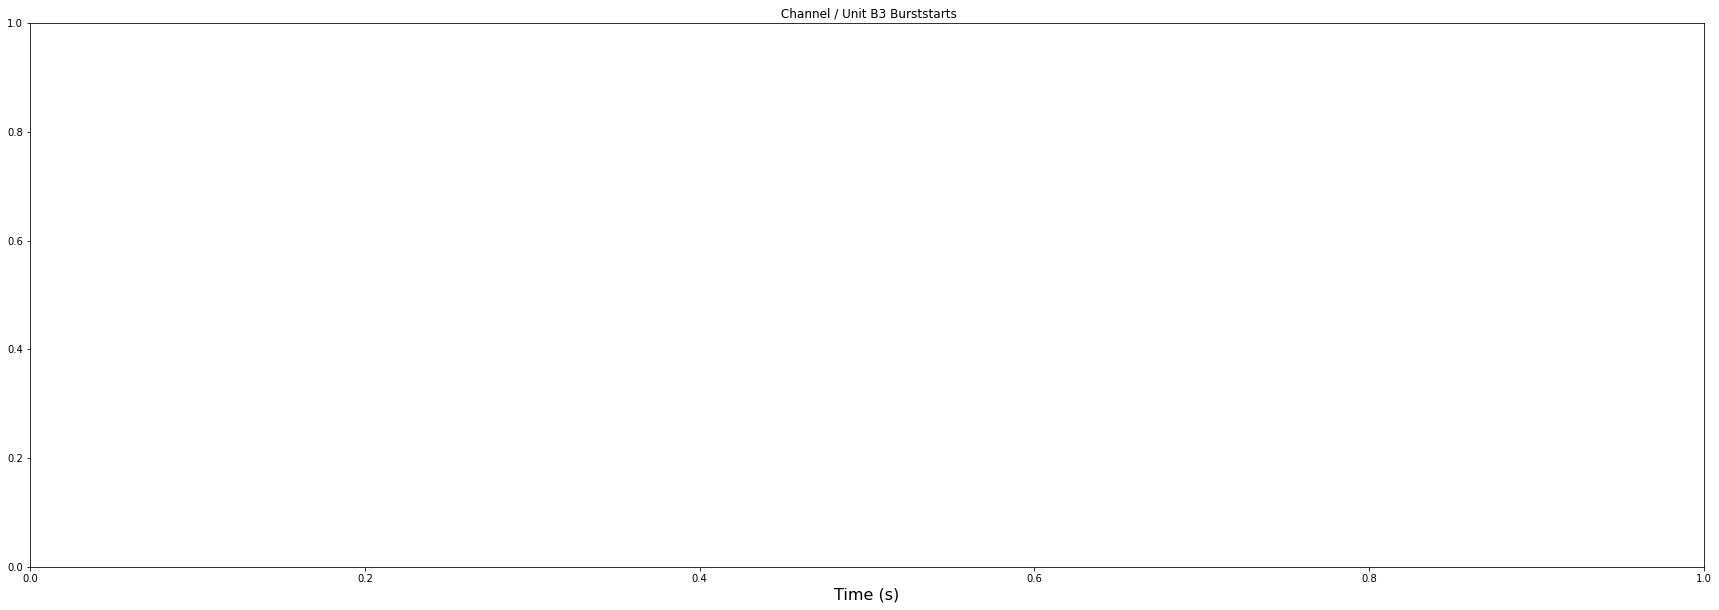

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A3 Burststarts')

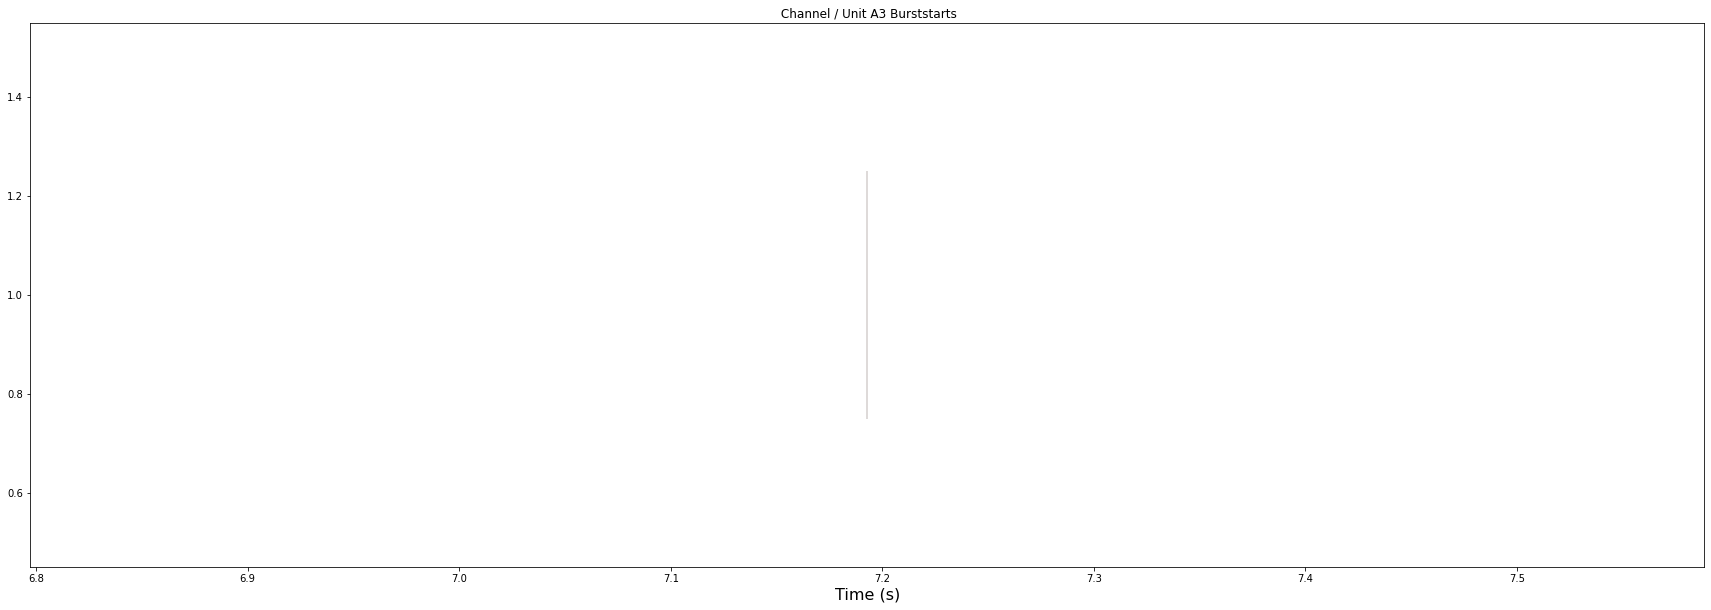

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D4 Burststarts')

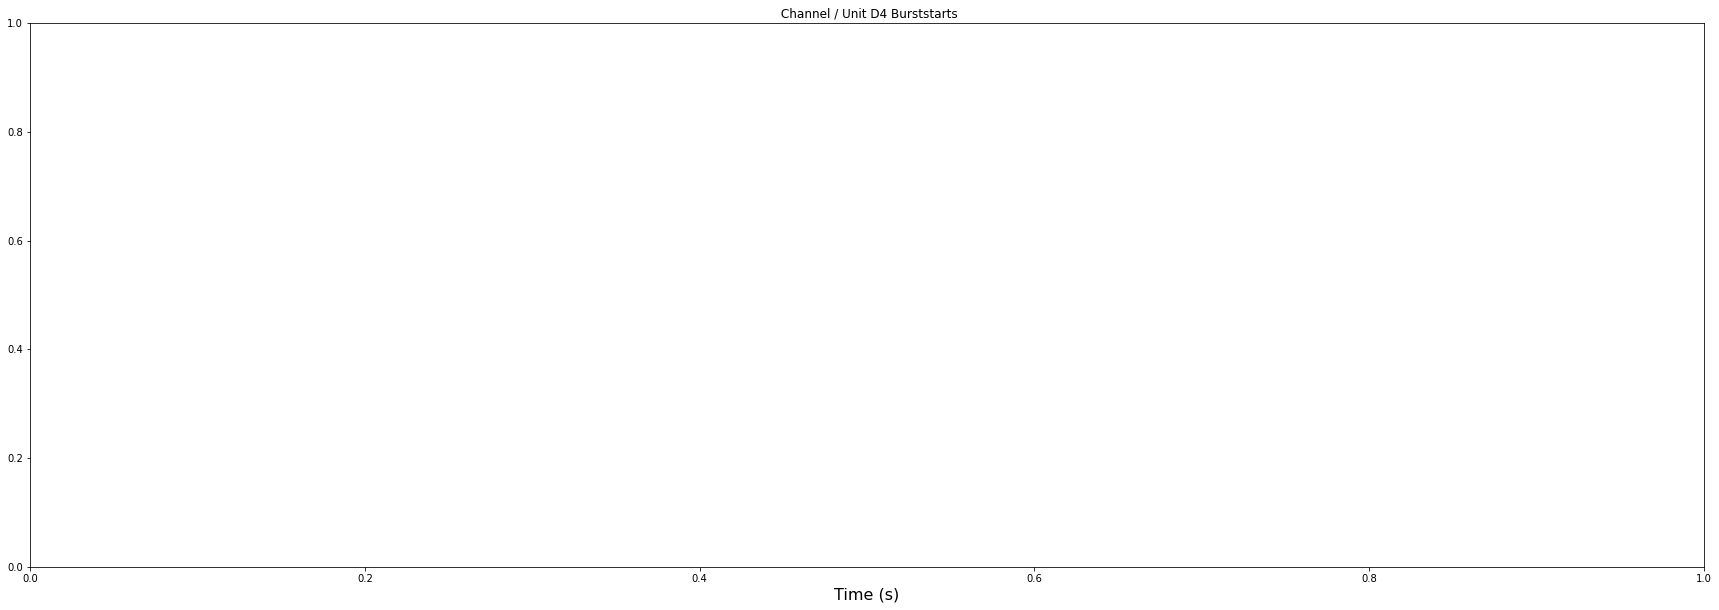

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit A2 Burststarts')

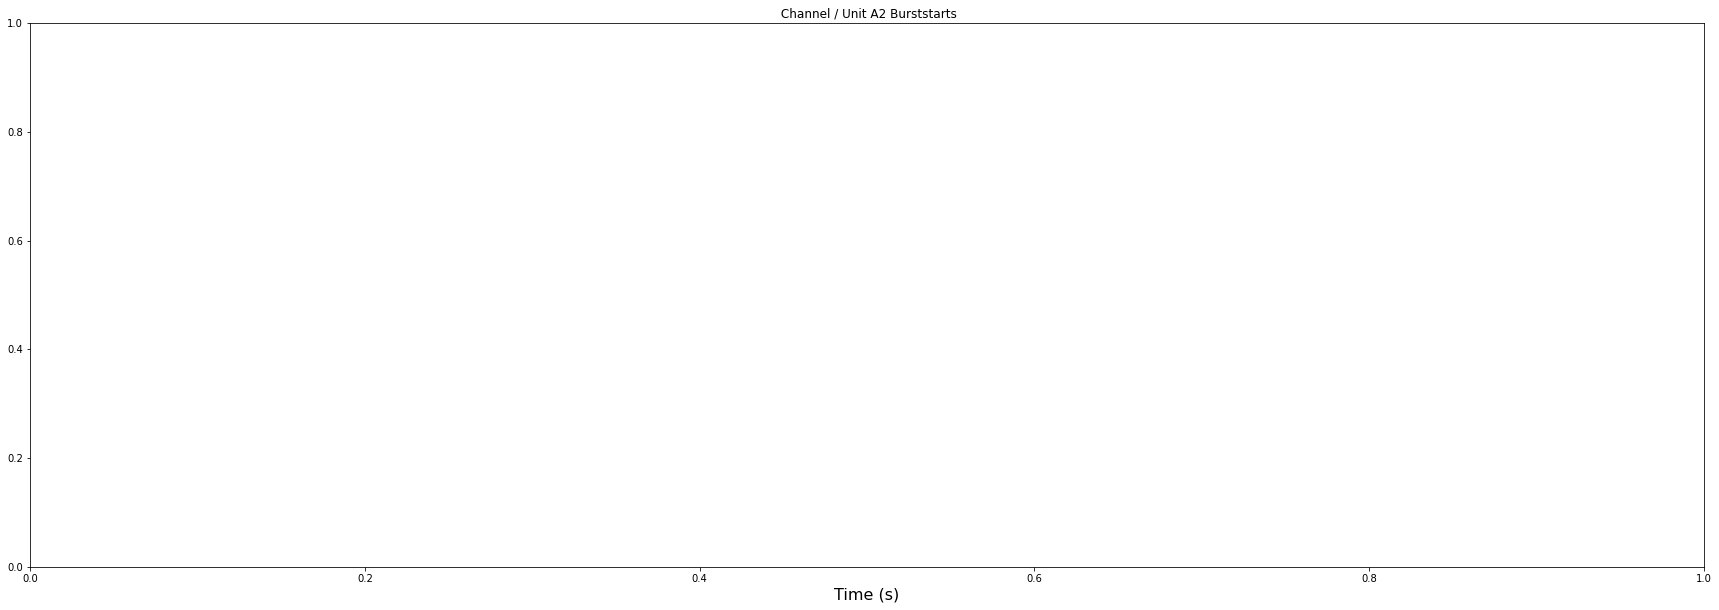

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B2 Burststarts')

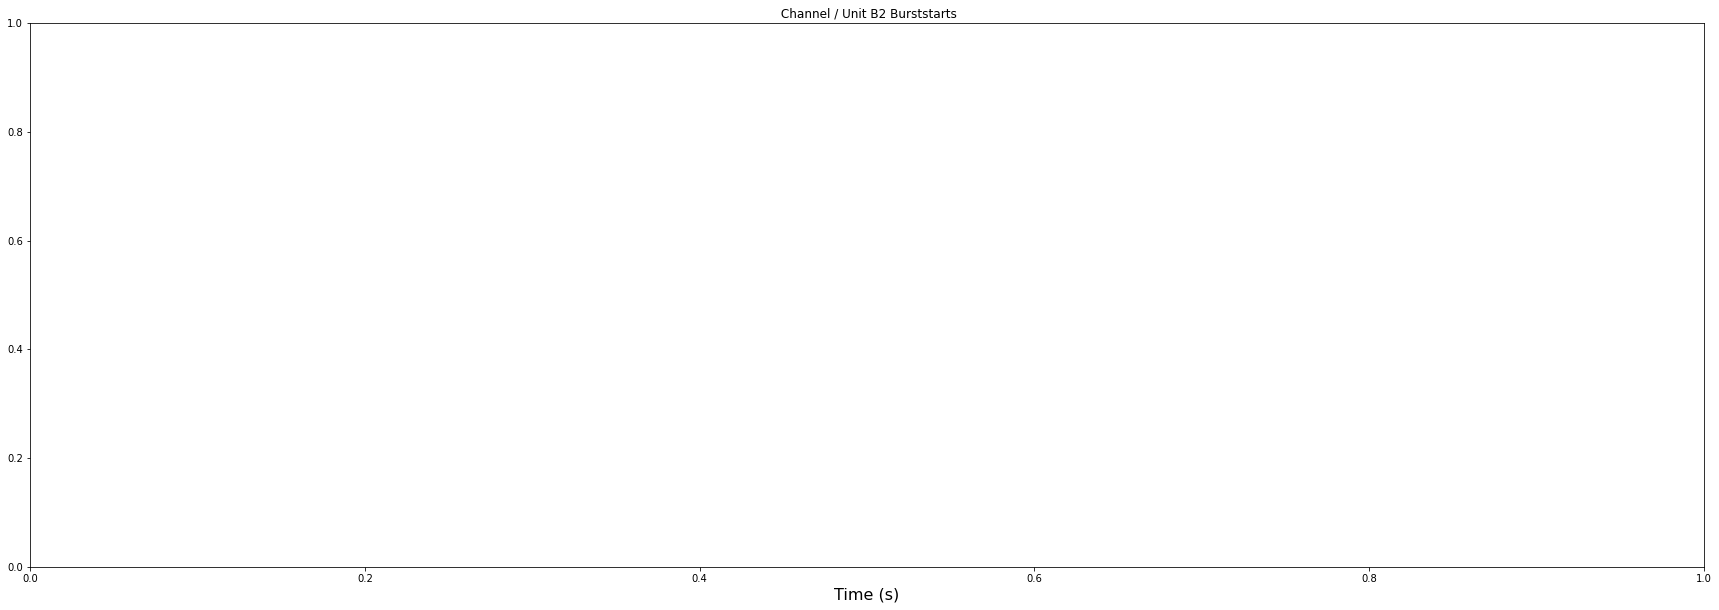

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit B1 Burststarts')

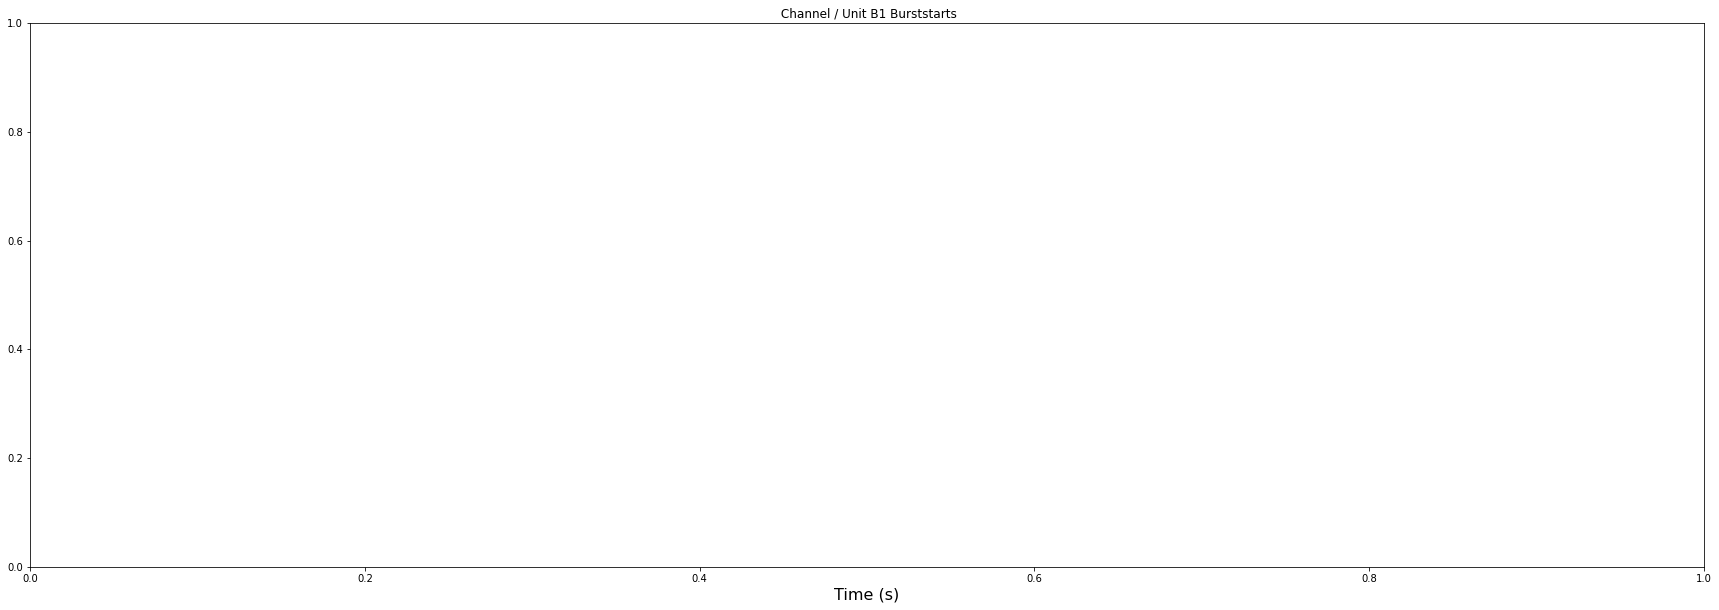

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C3 Burststarts')

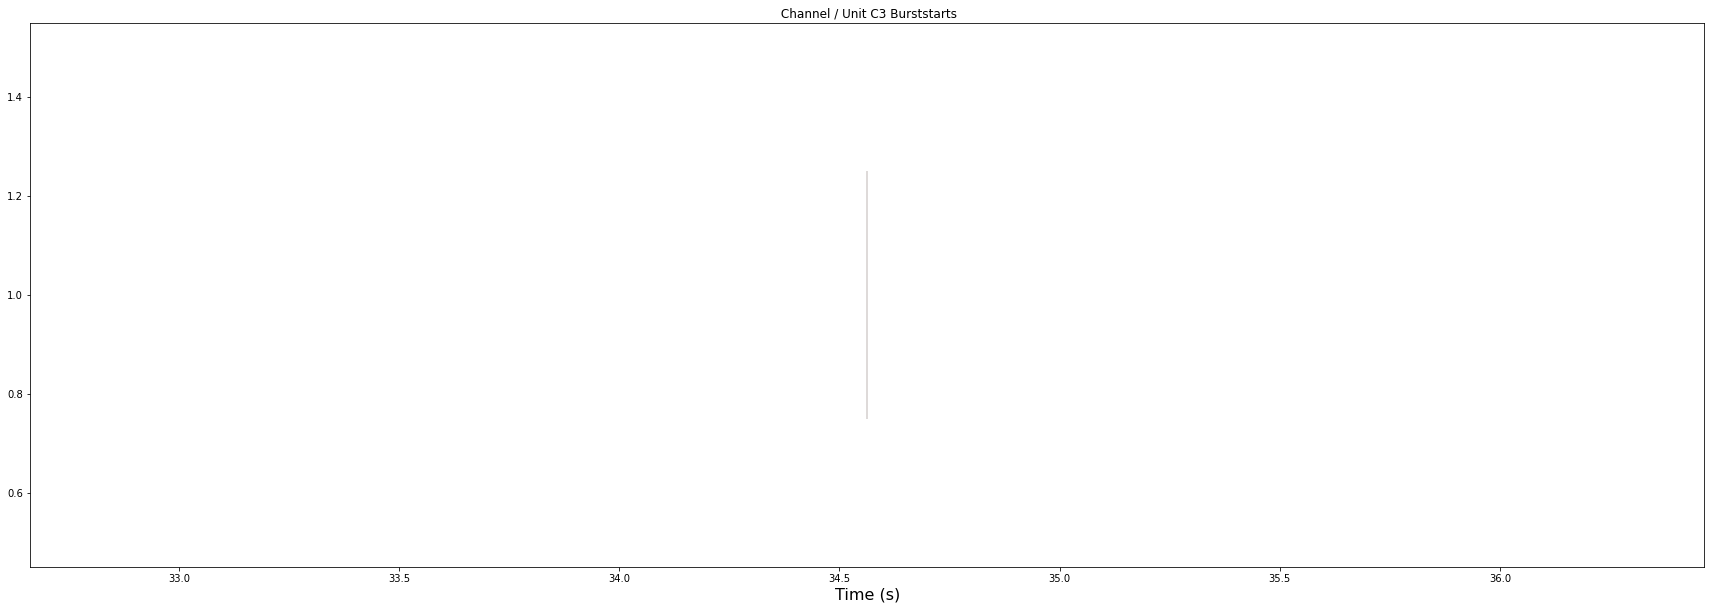

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C2 Burststarts')

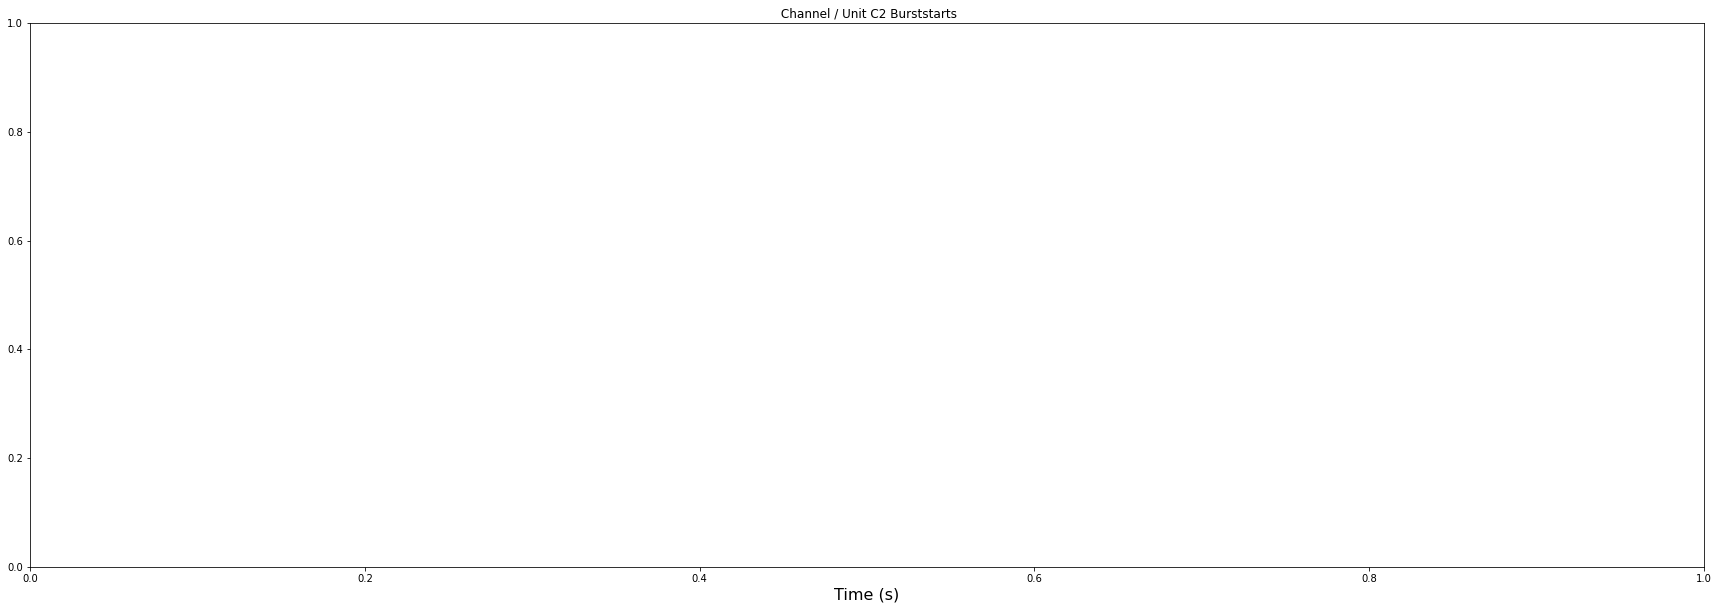

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit C1 Burststarts')

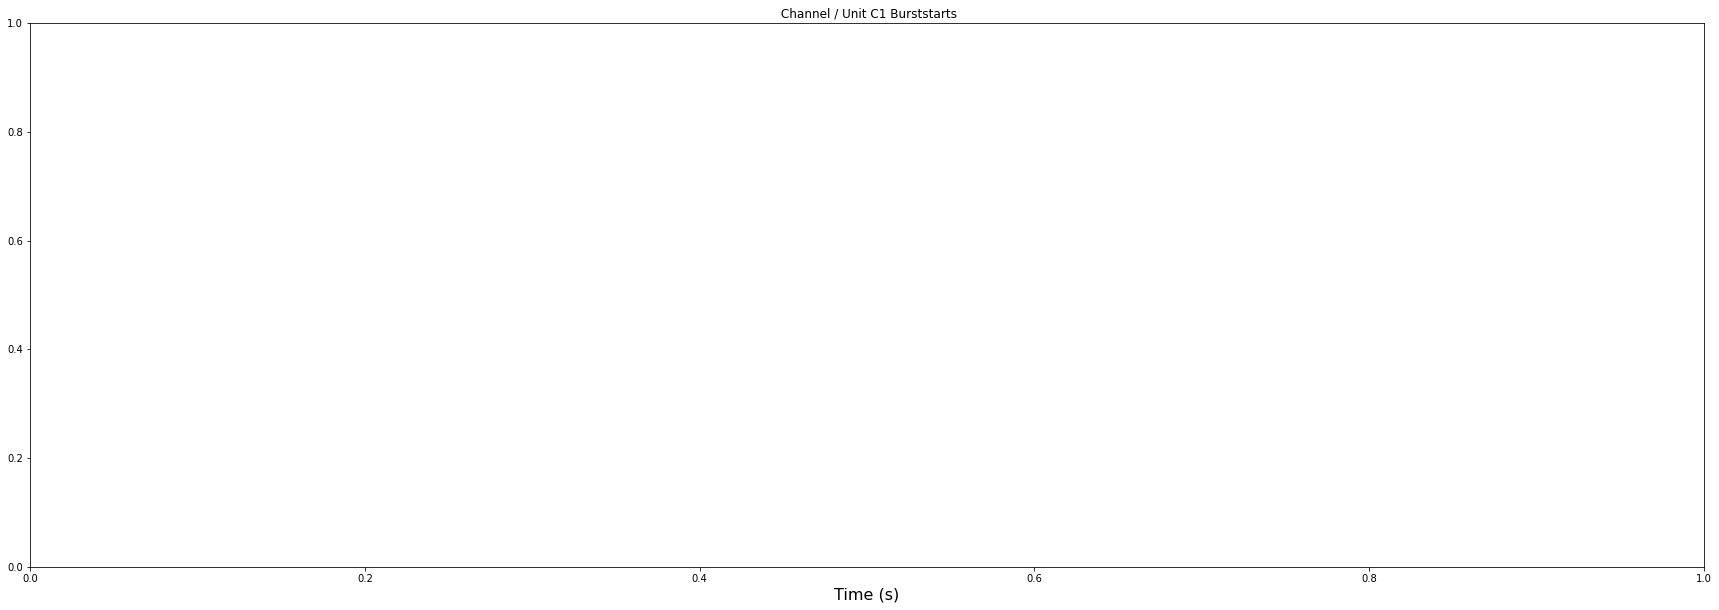

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E5 Burststarts')

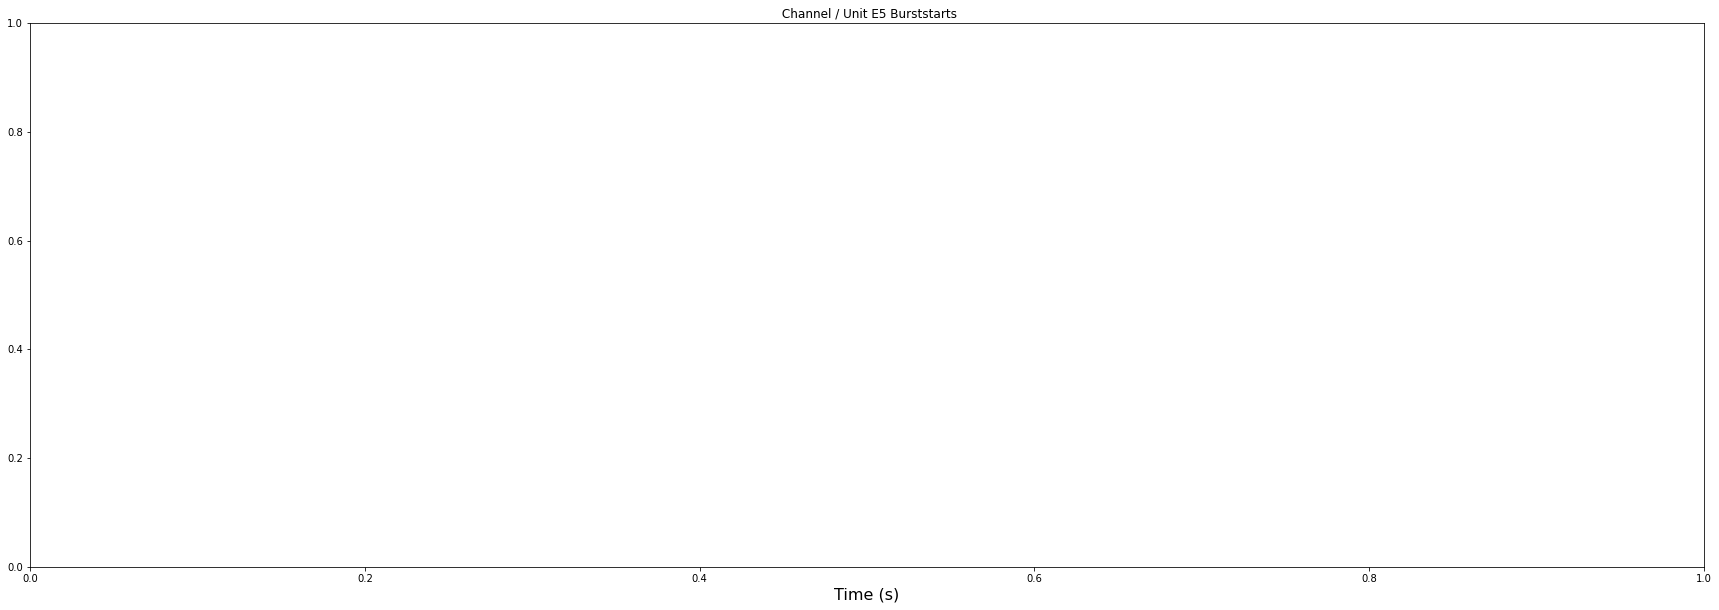

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G7 Burststarts')

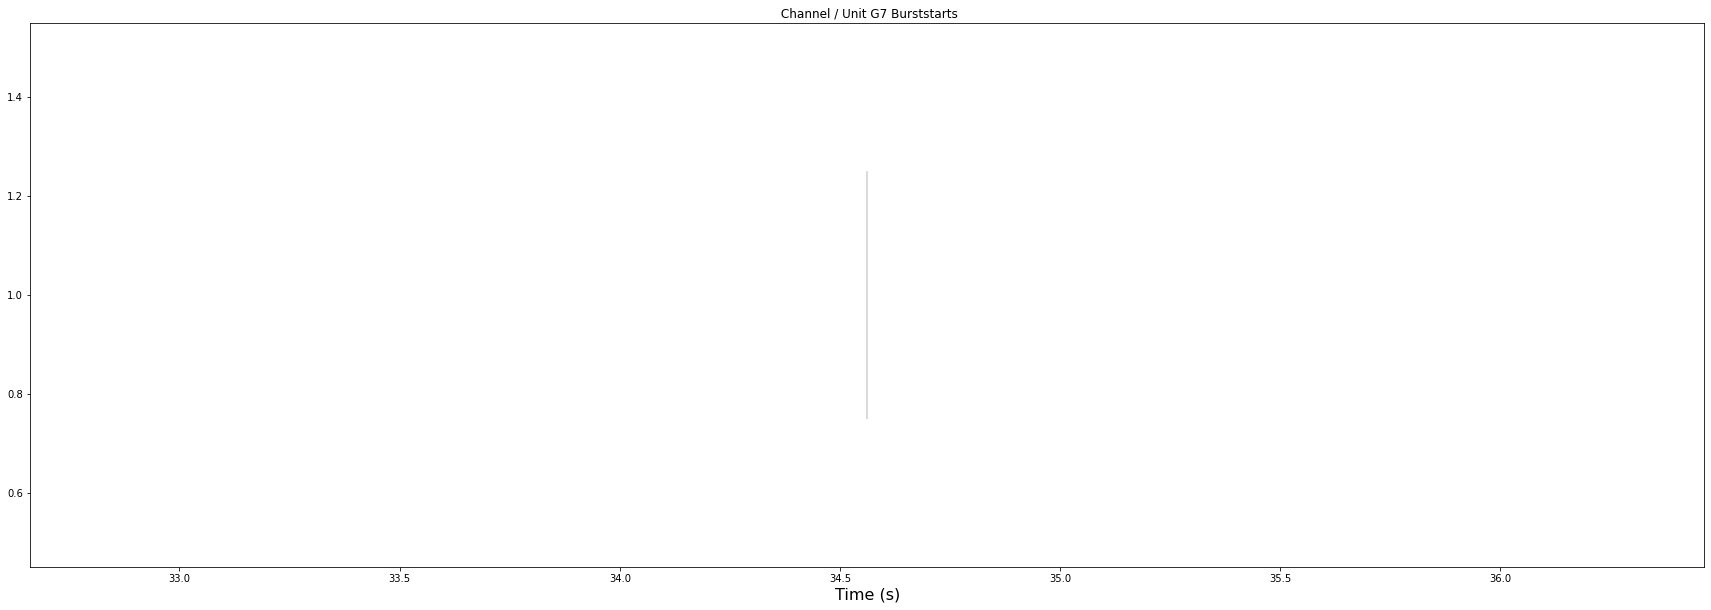

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D3 Burststarts')

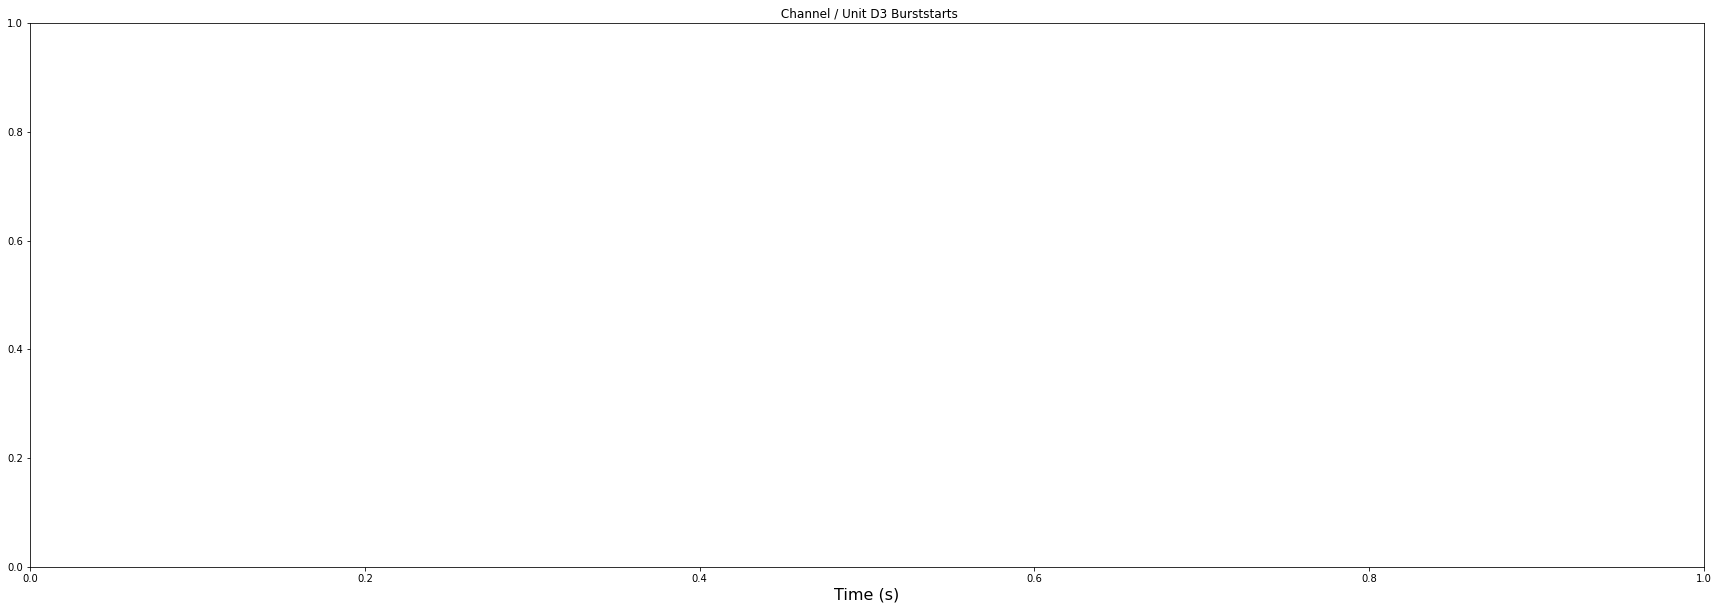

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D2 Burststarts')

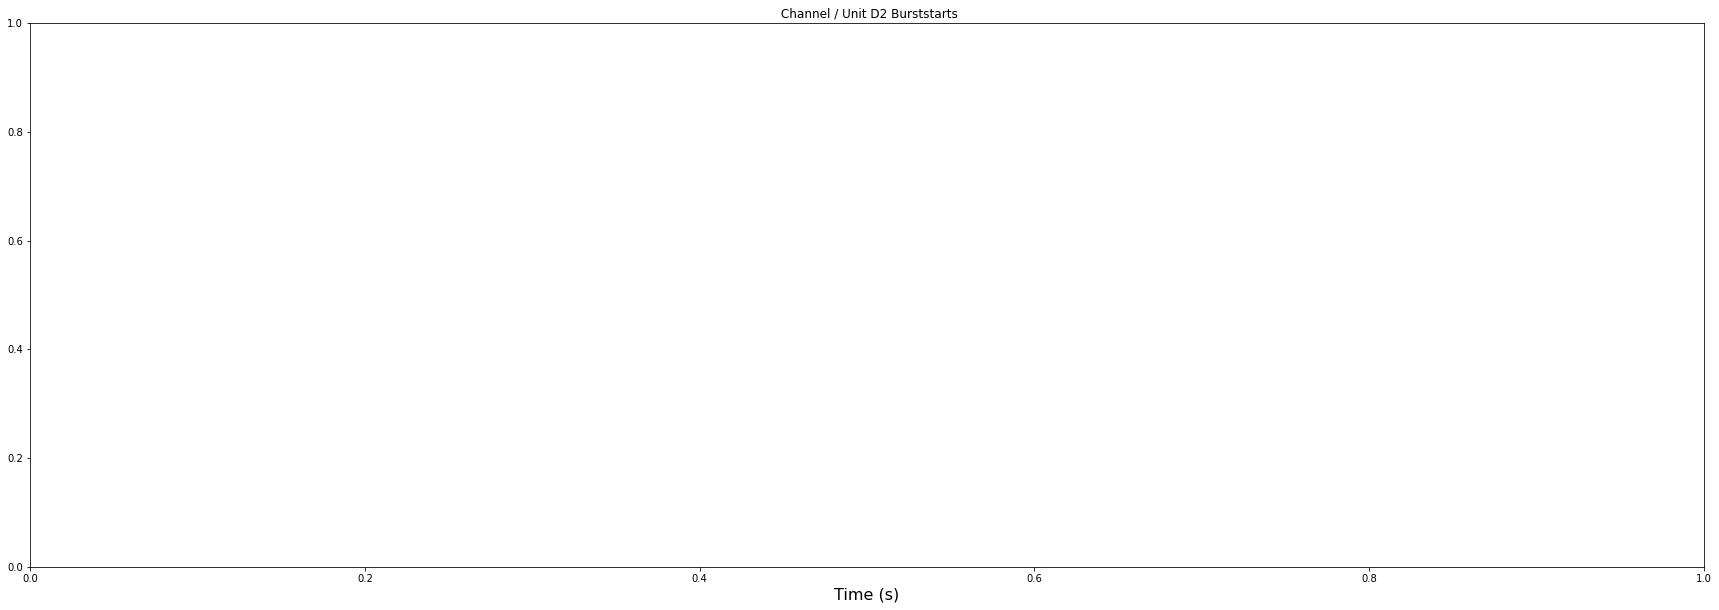

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit D1 Burststarts')

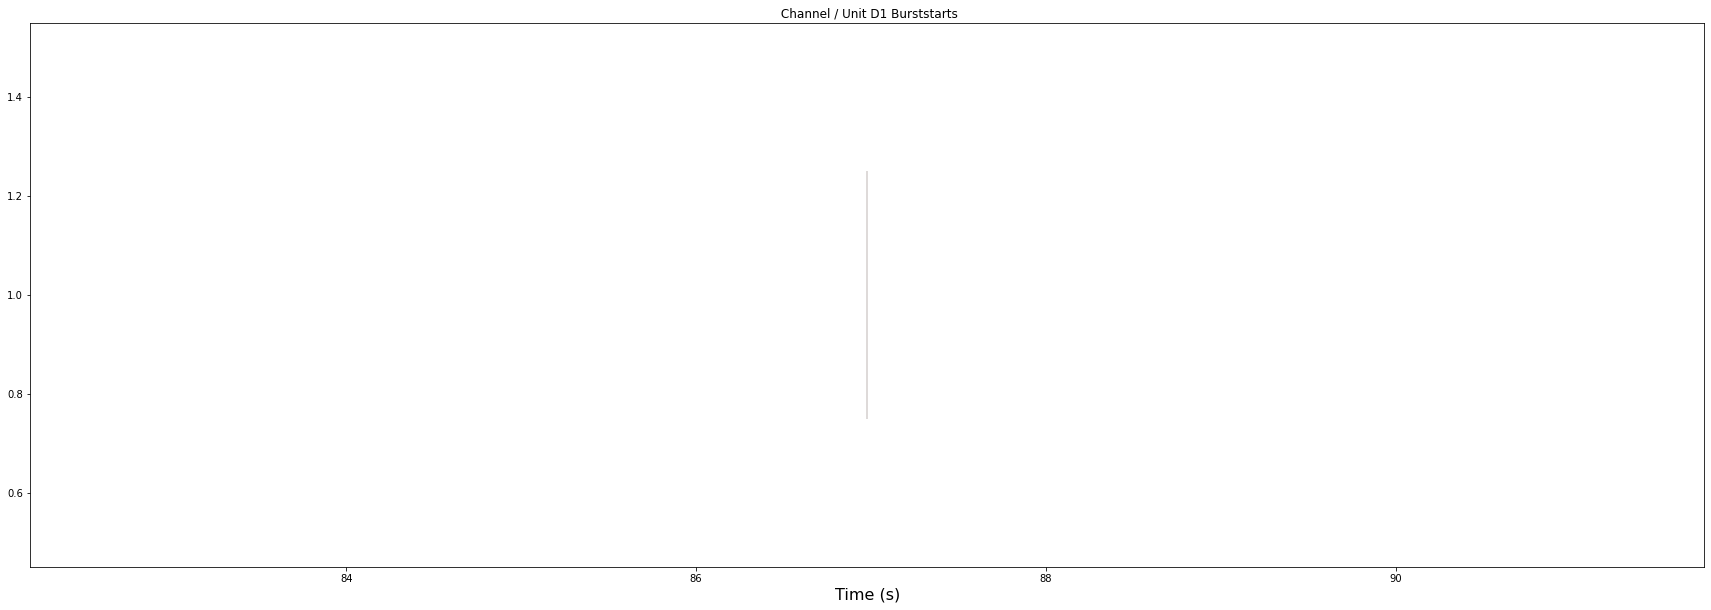

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G6 Burststarts')

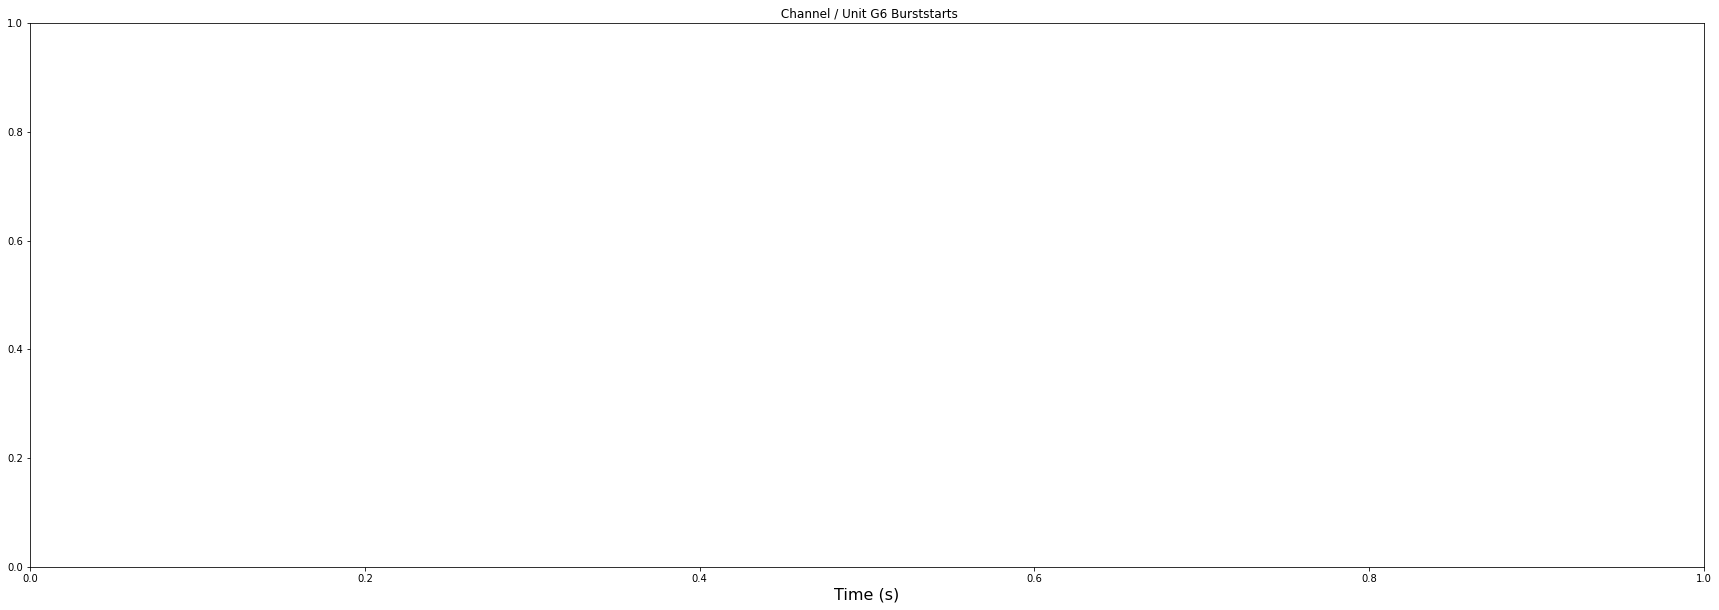

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E4 Burststarts')

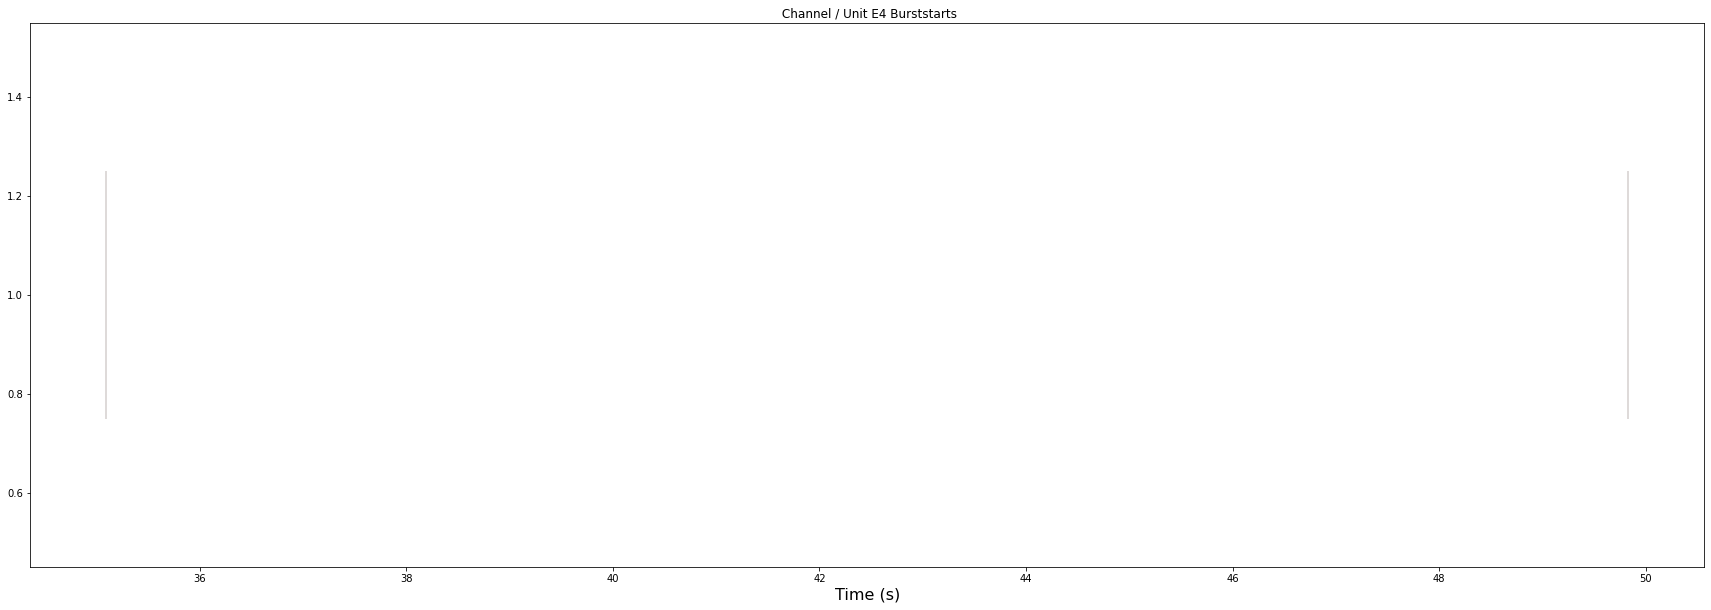

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E3 Burststarts')

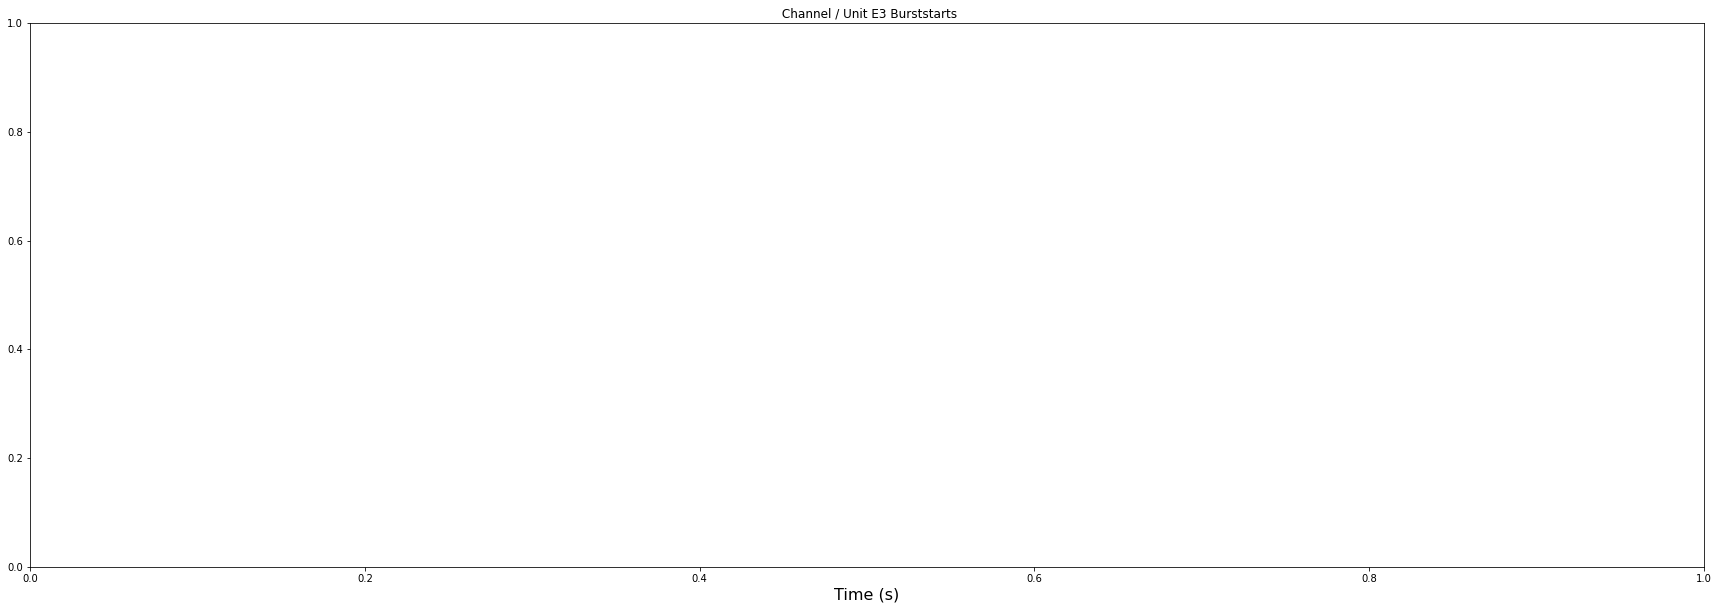

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E2 Burststarts')

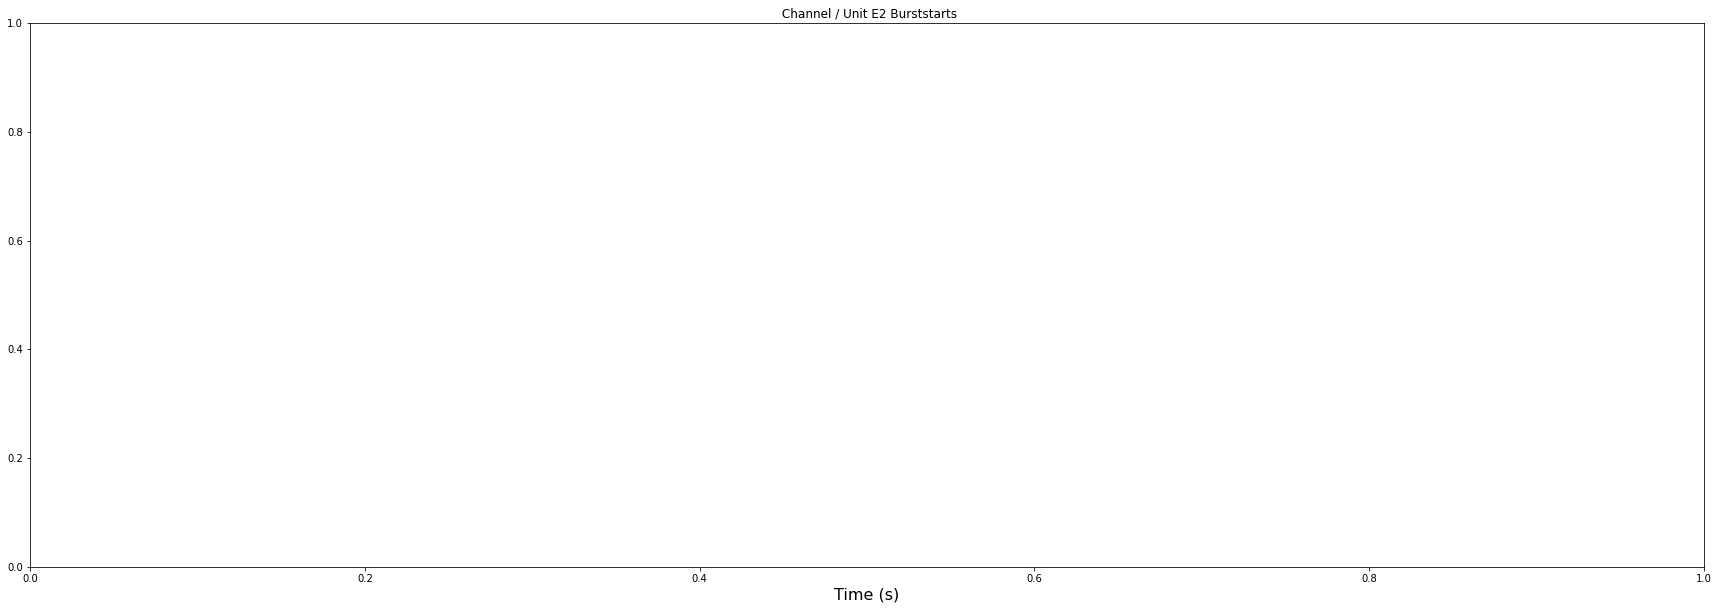

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit E1 Burststarts')

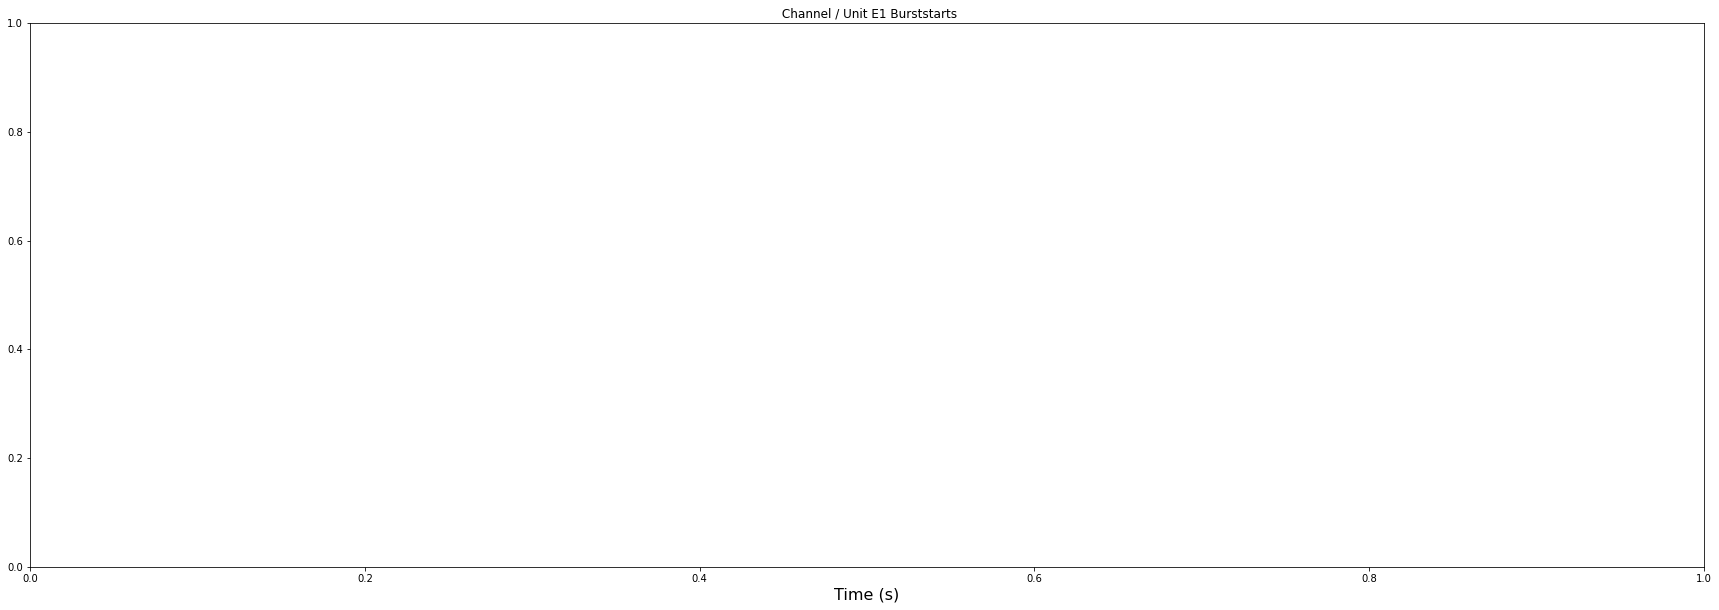

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F5 Burststarts')

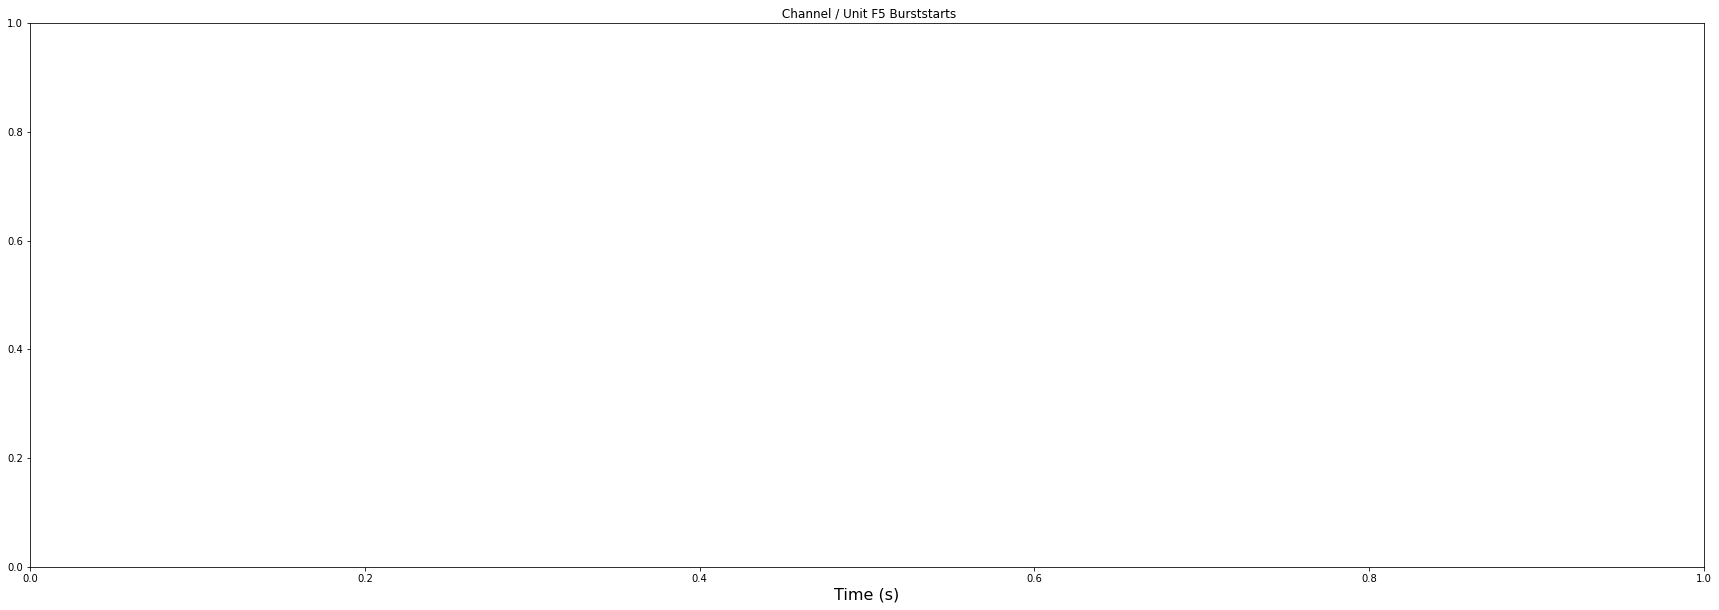

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F4 Burststarts')

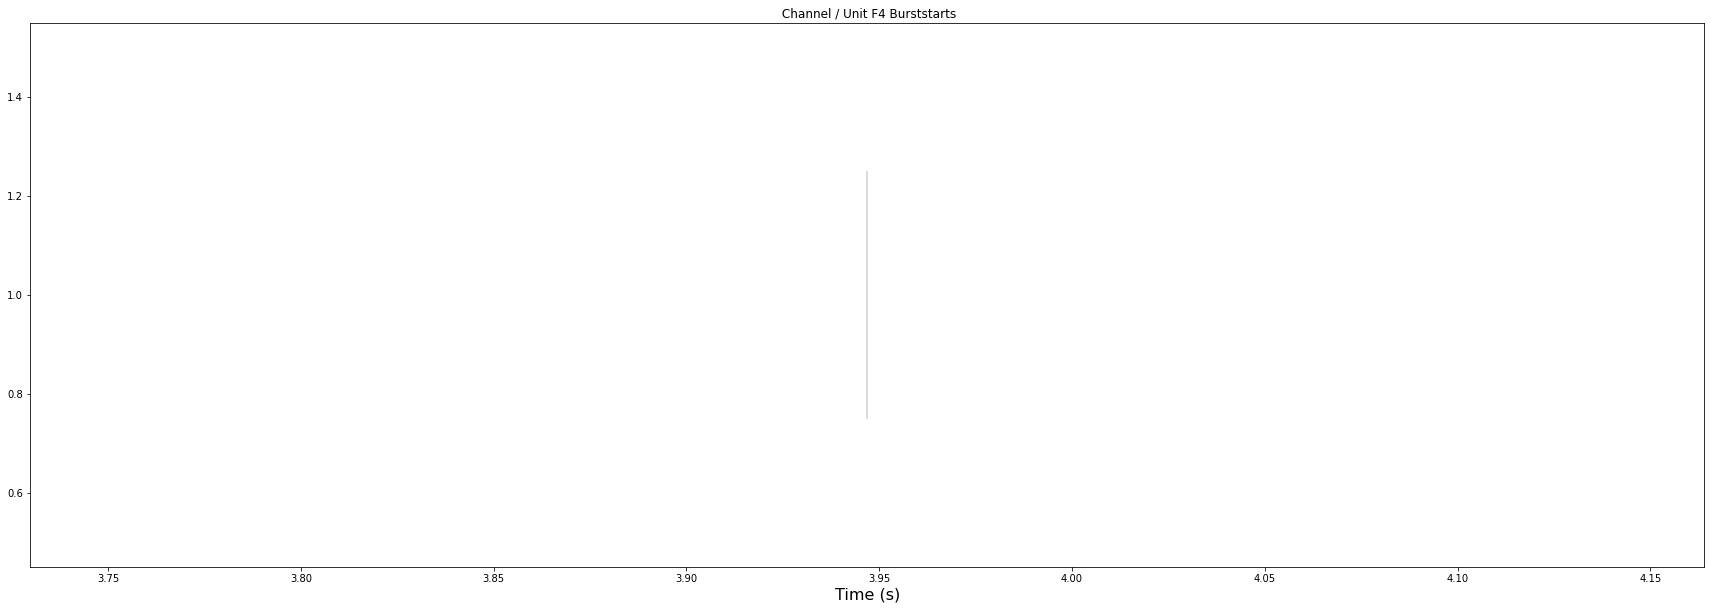

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F3 Burststarts')

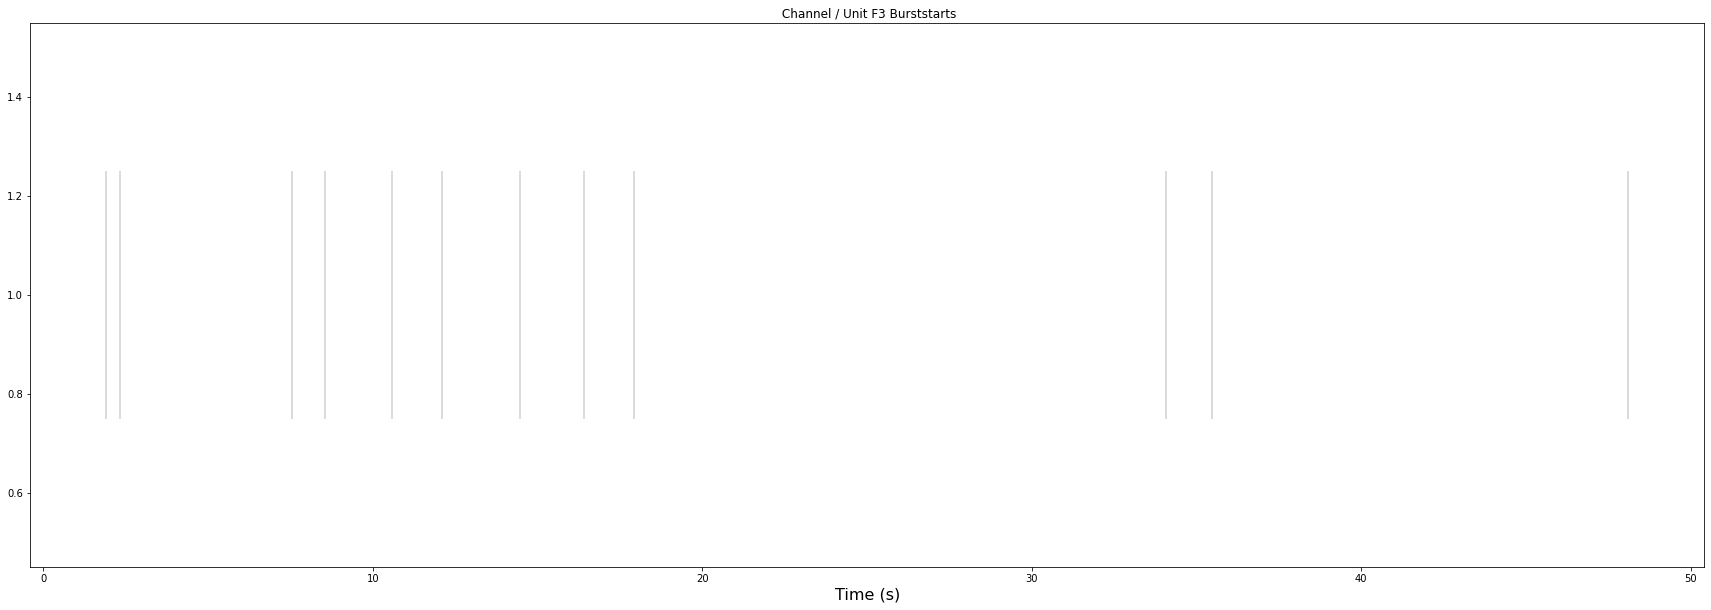

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F2 Burststarts')

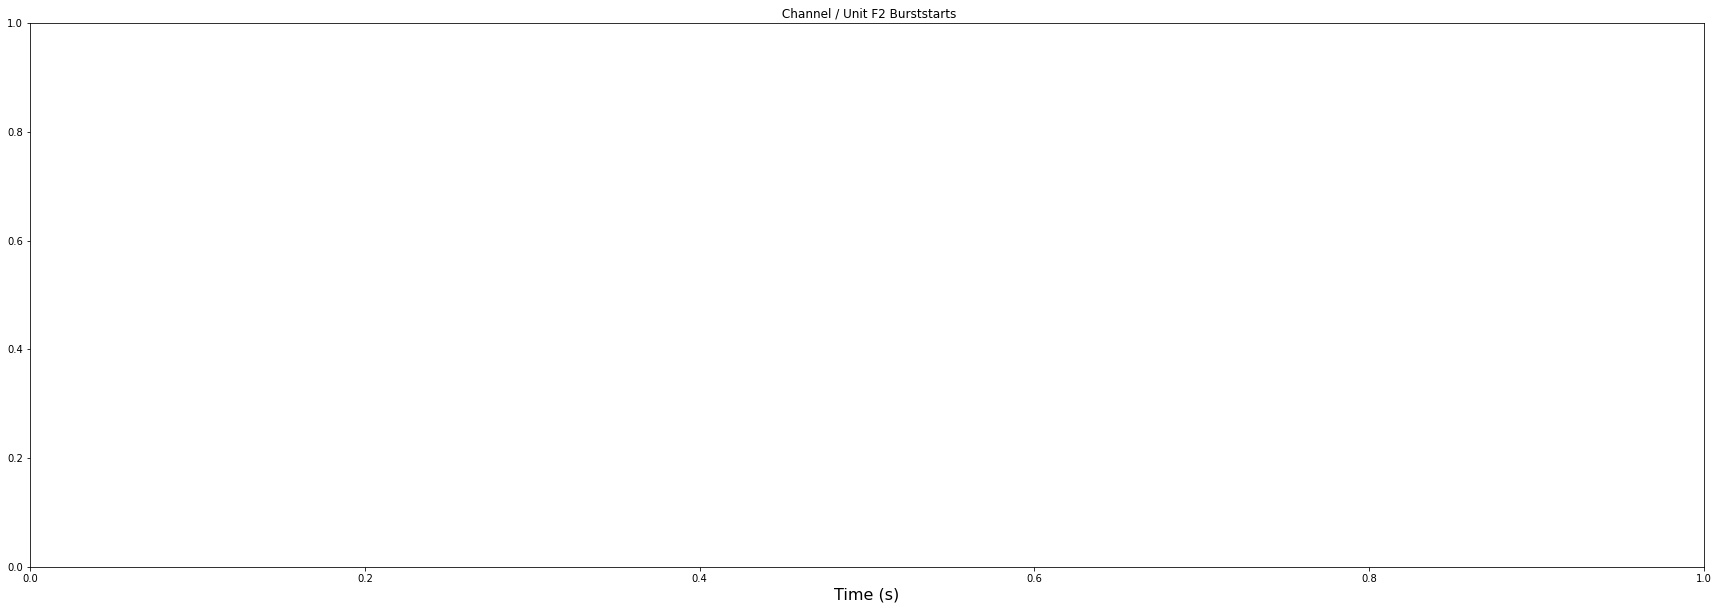

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit F1 Burststarts')

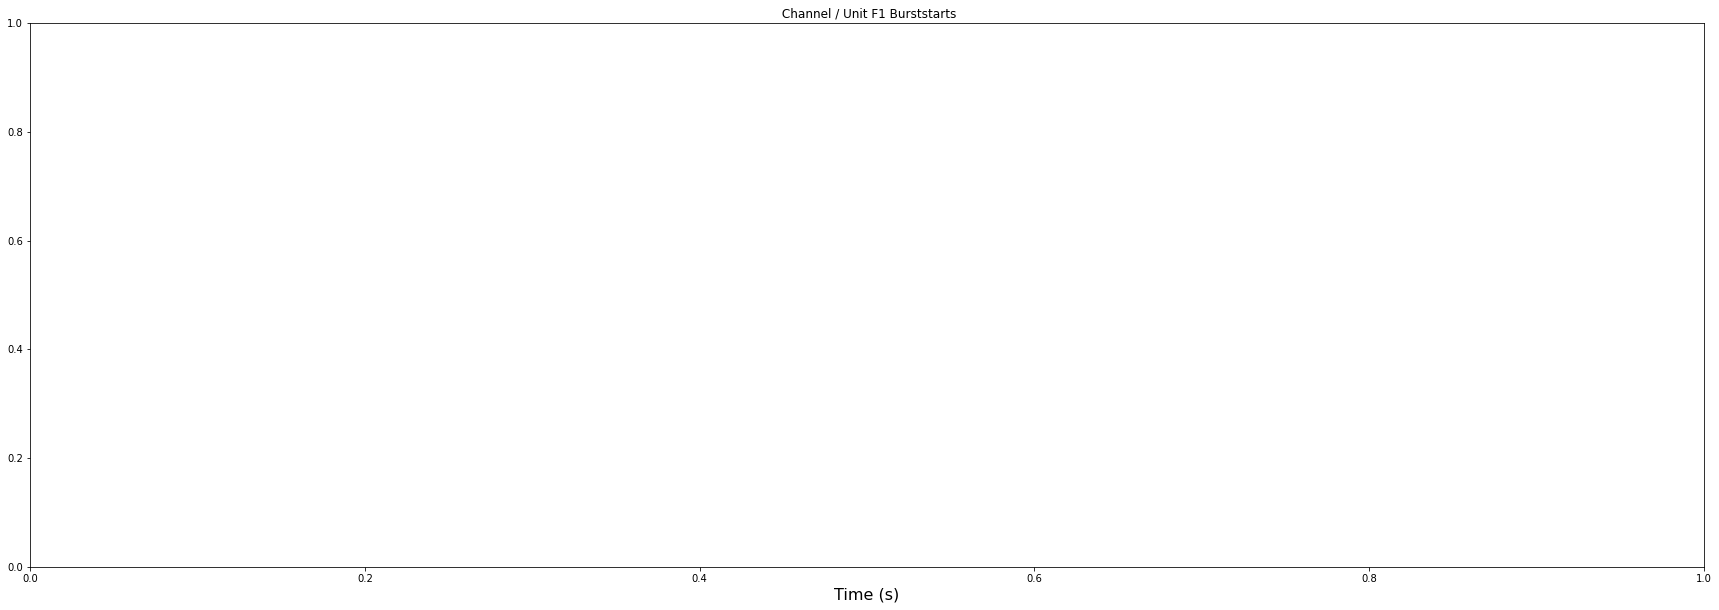

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G5 Burststarts')

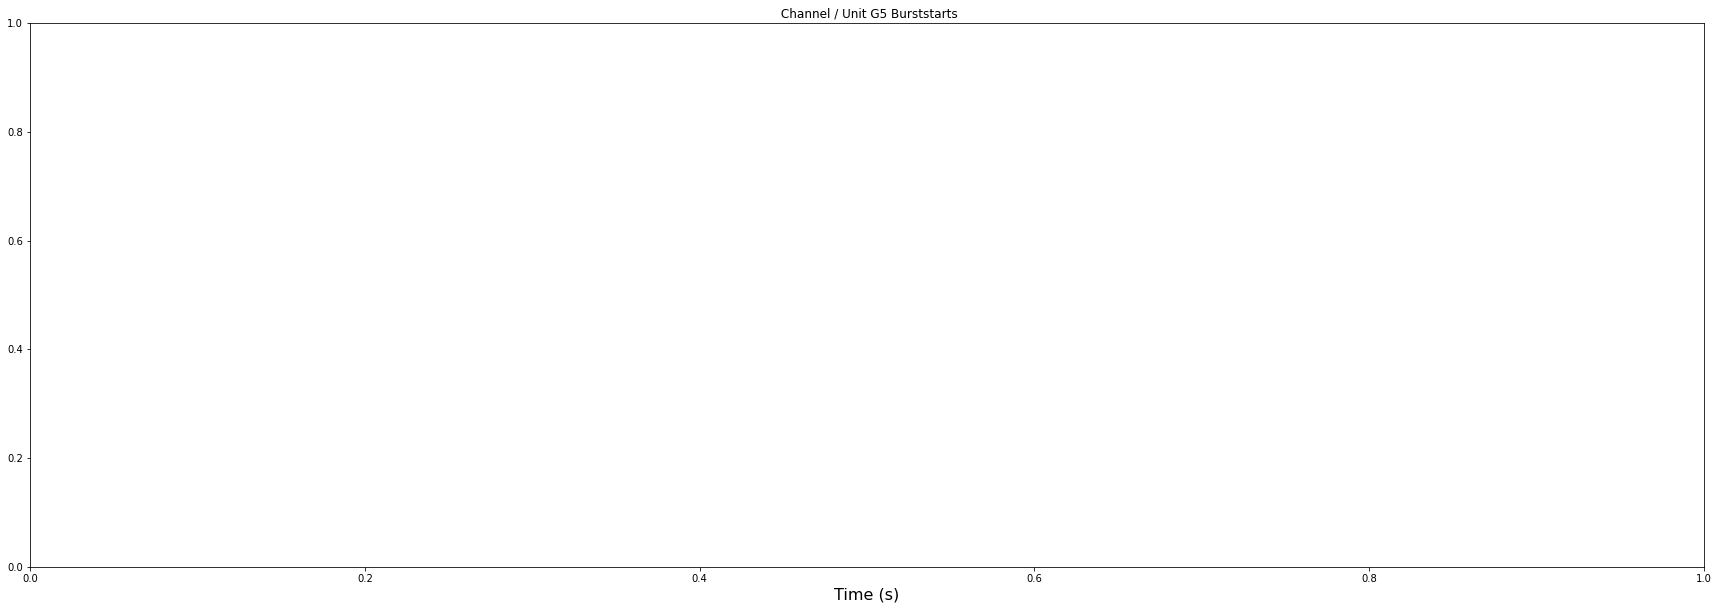

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G4 Burststarts')

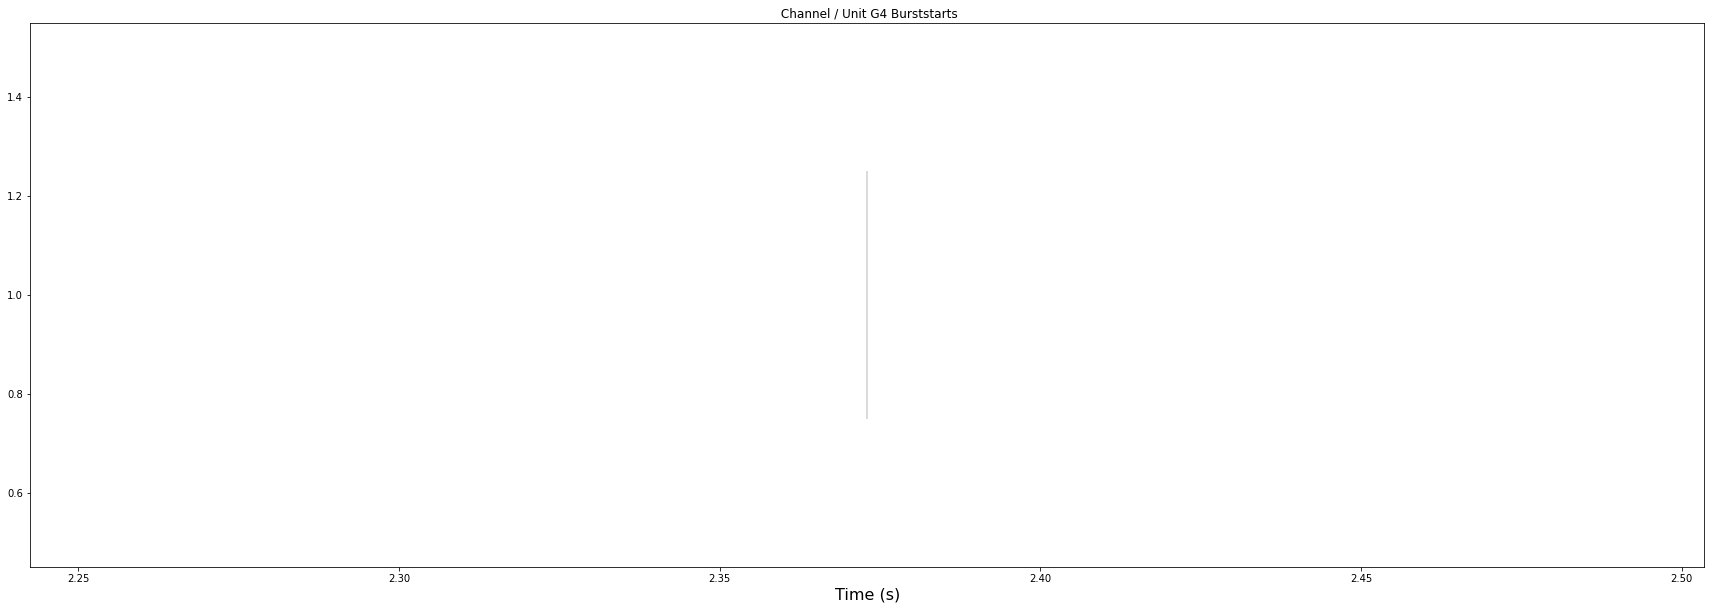

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G3 Burststarts')

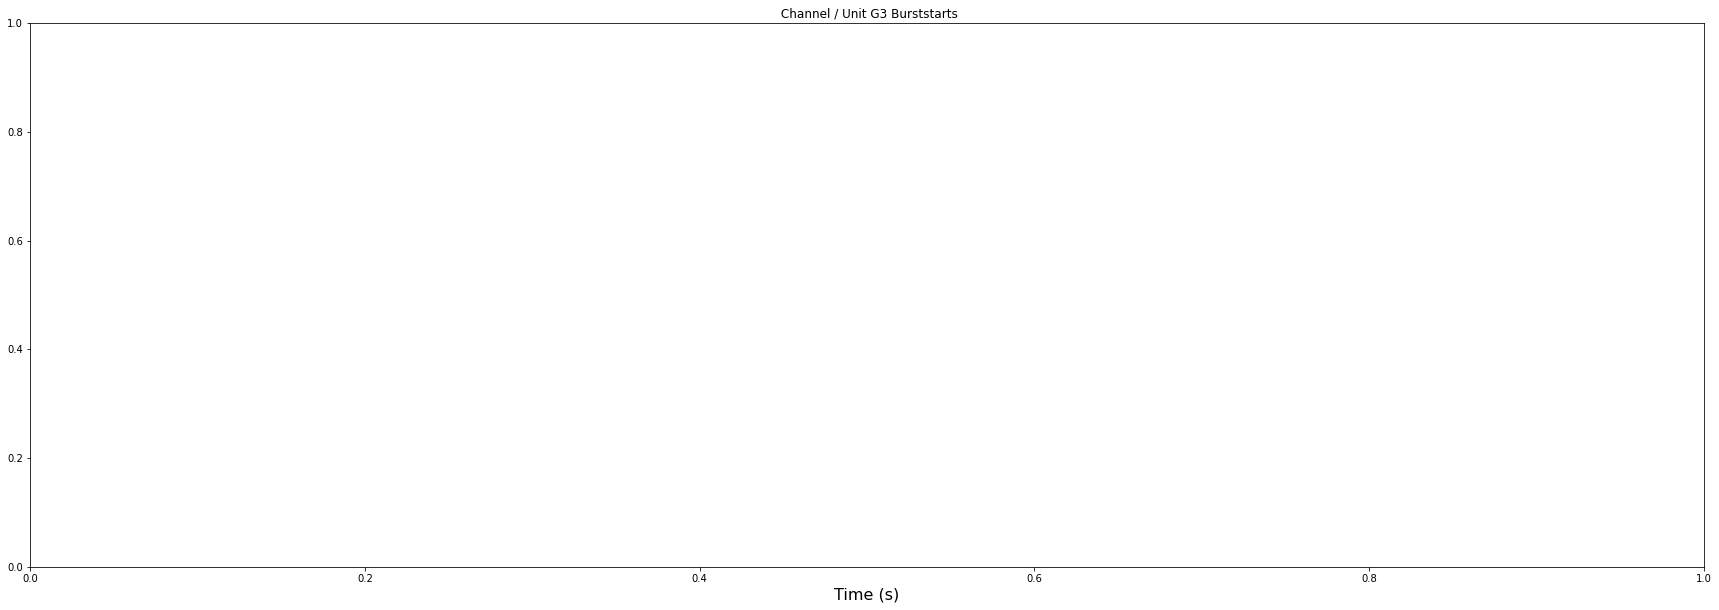

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G2 Burststarts')

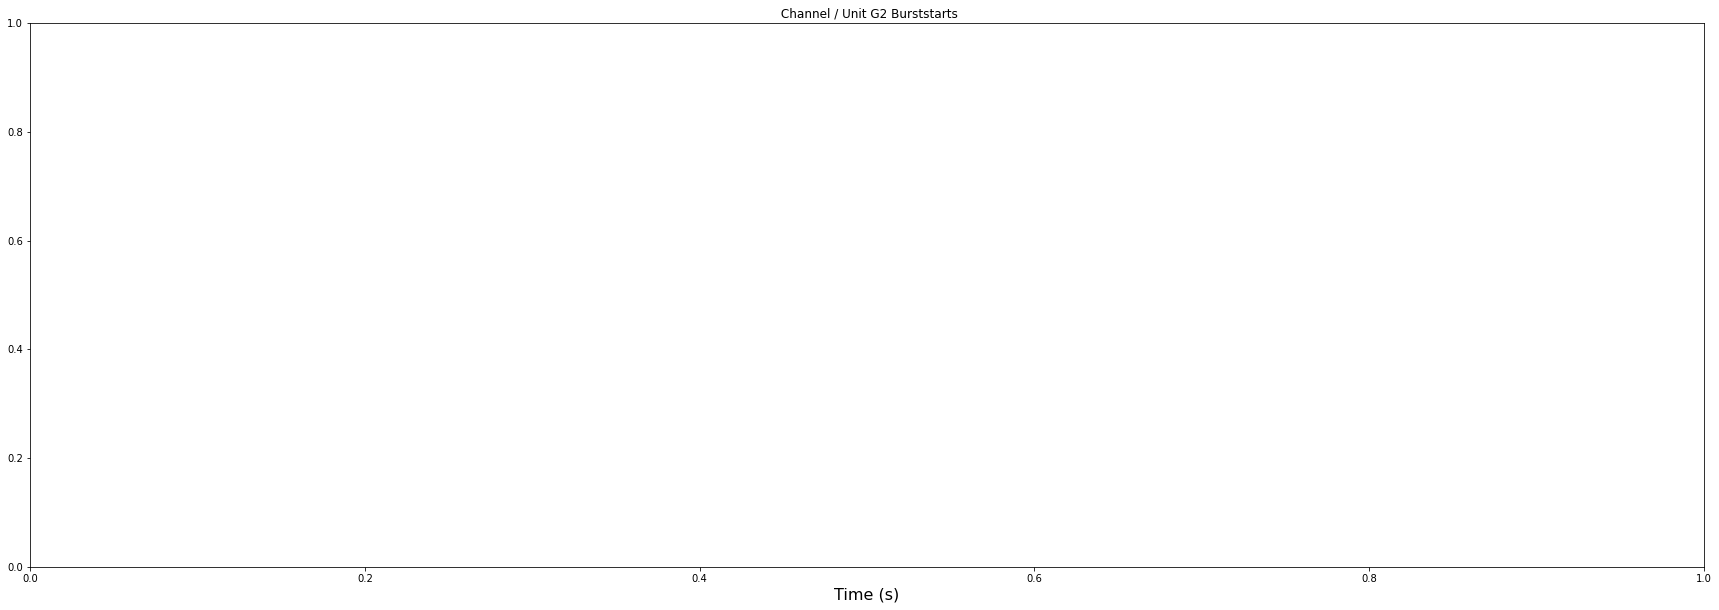

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G1 Burststarts')

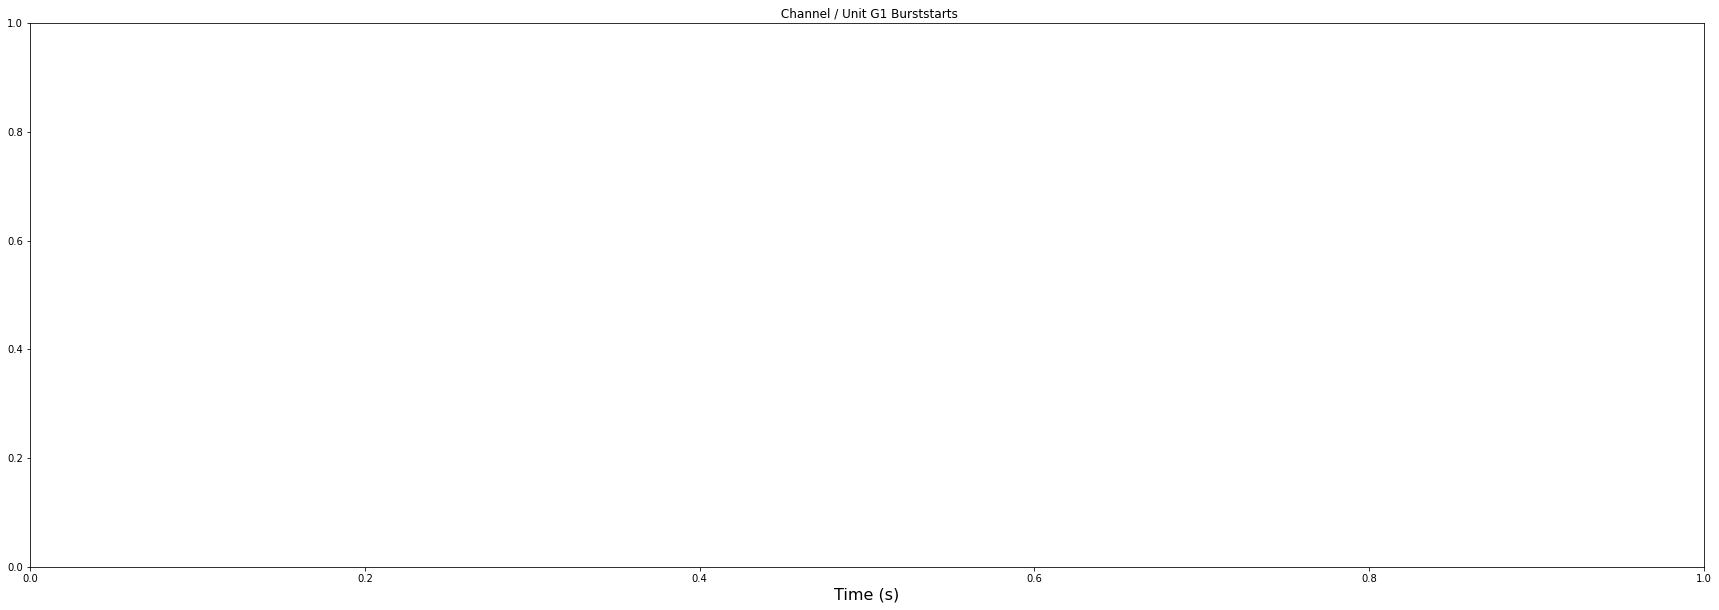

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H5 Burststarts')

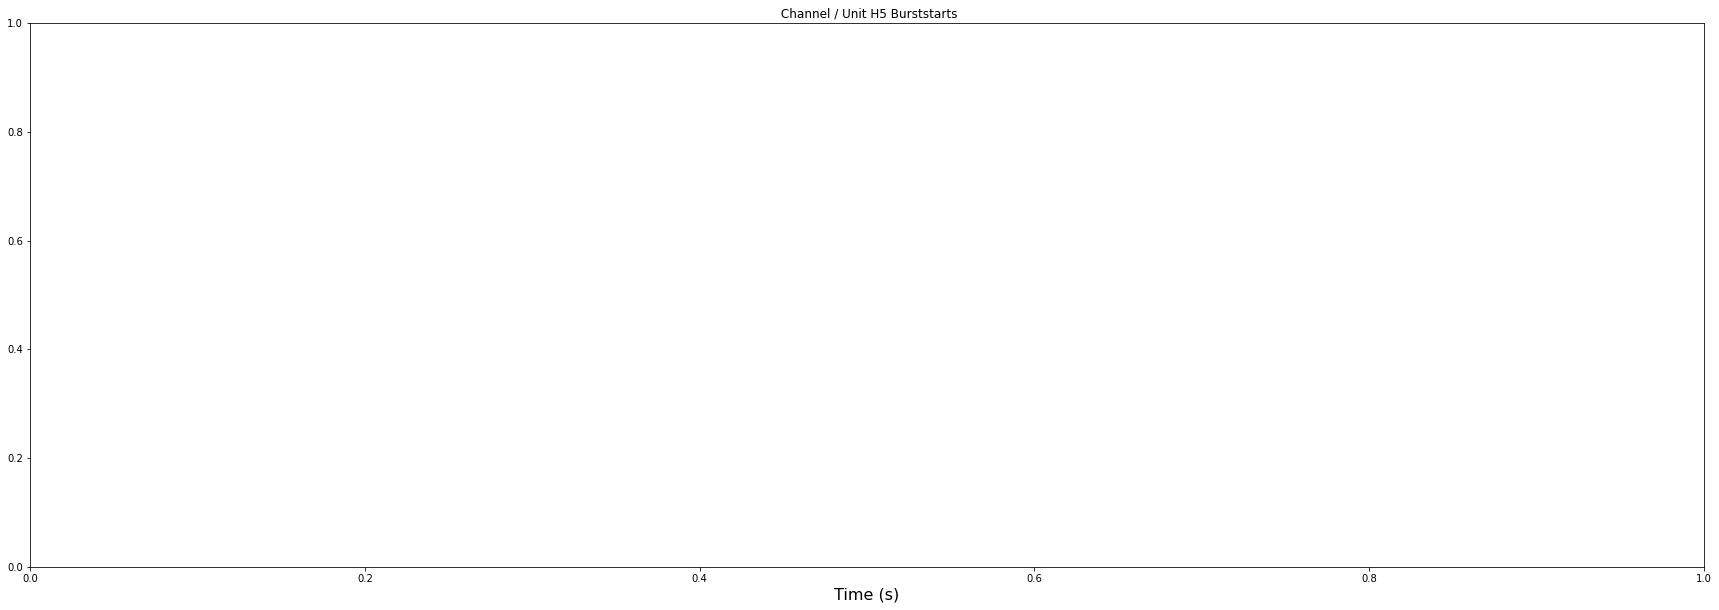

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H4 Burststarts')

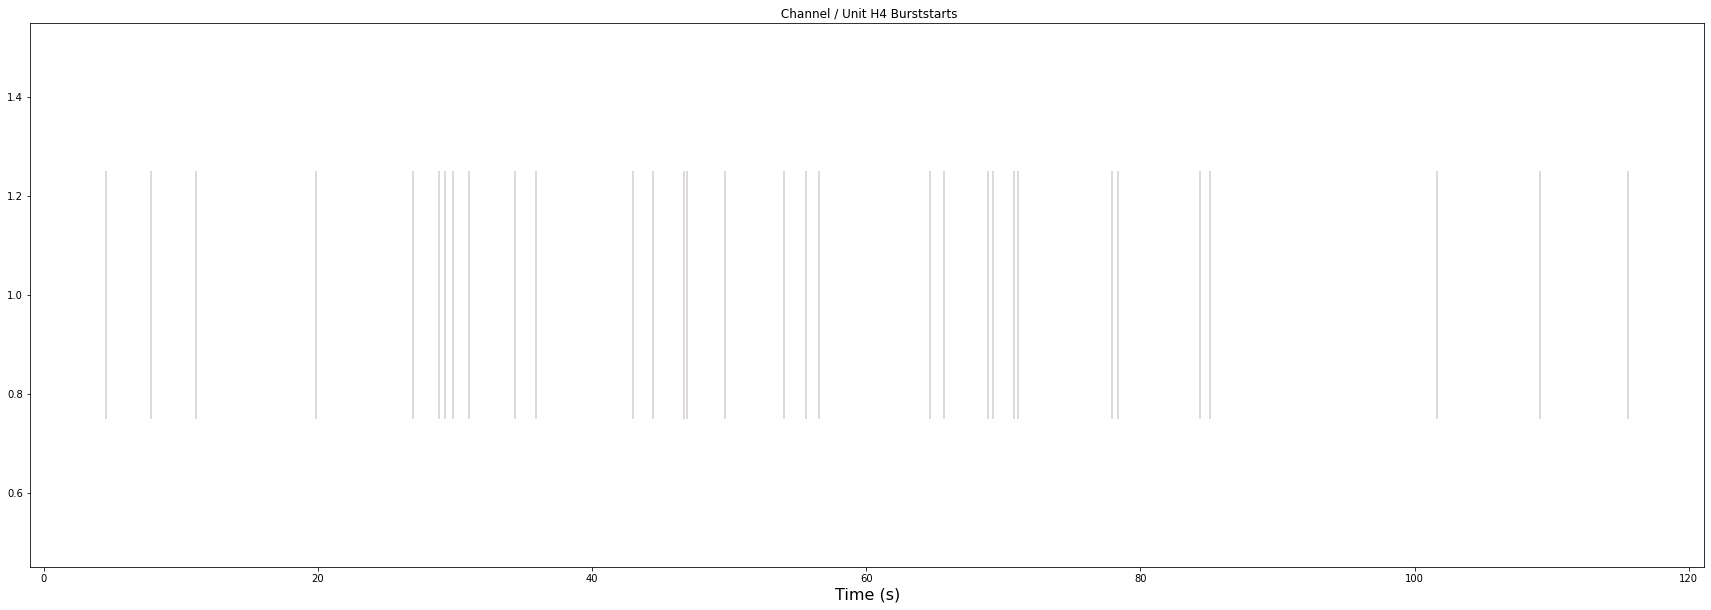

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H3 Burststarts')

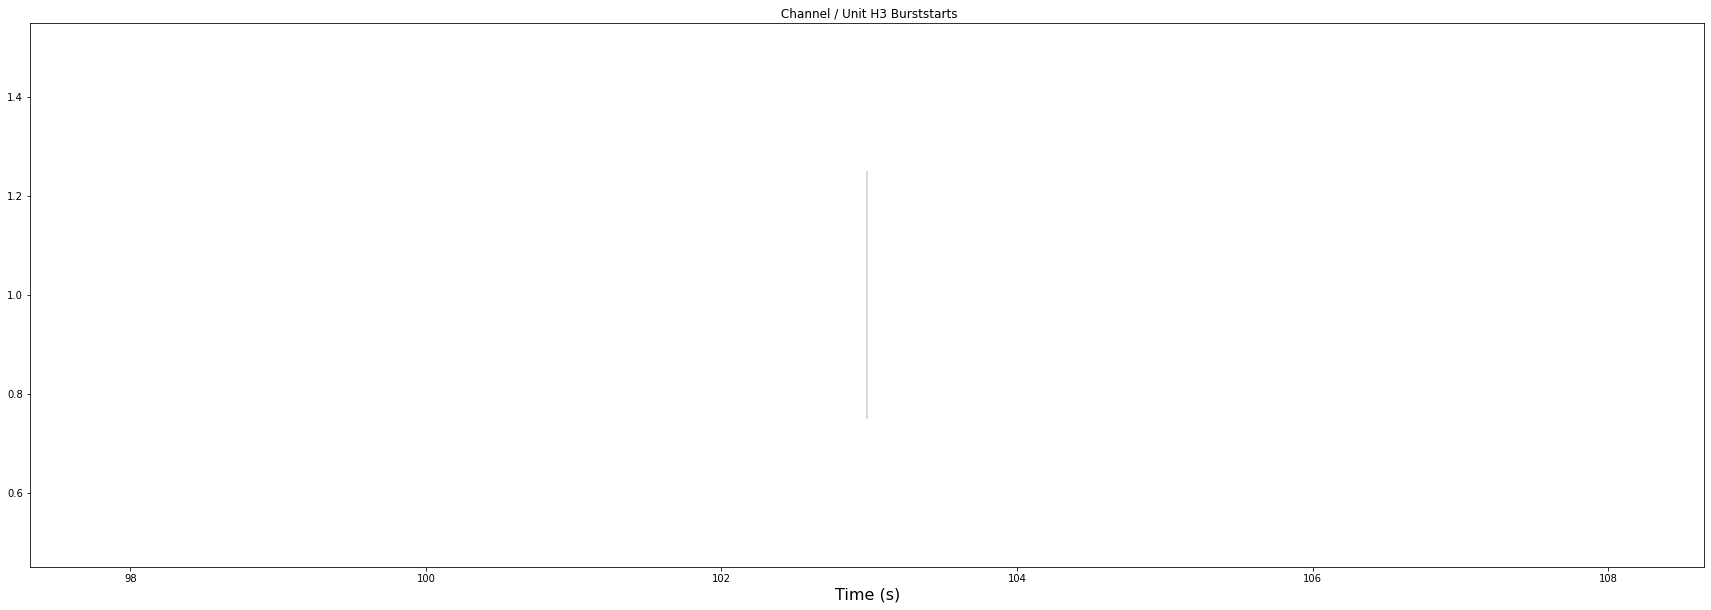

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H2 Burststarts')

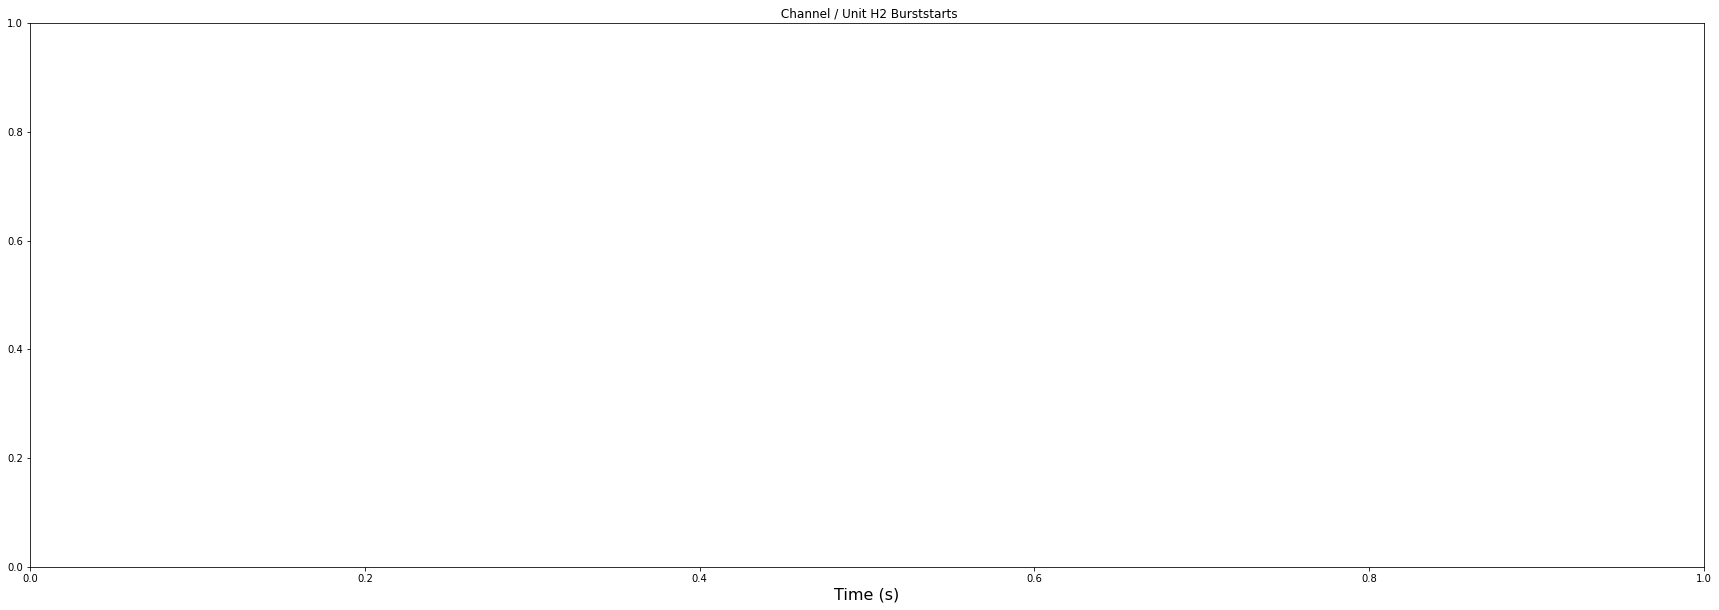

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H1 Burststarts')

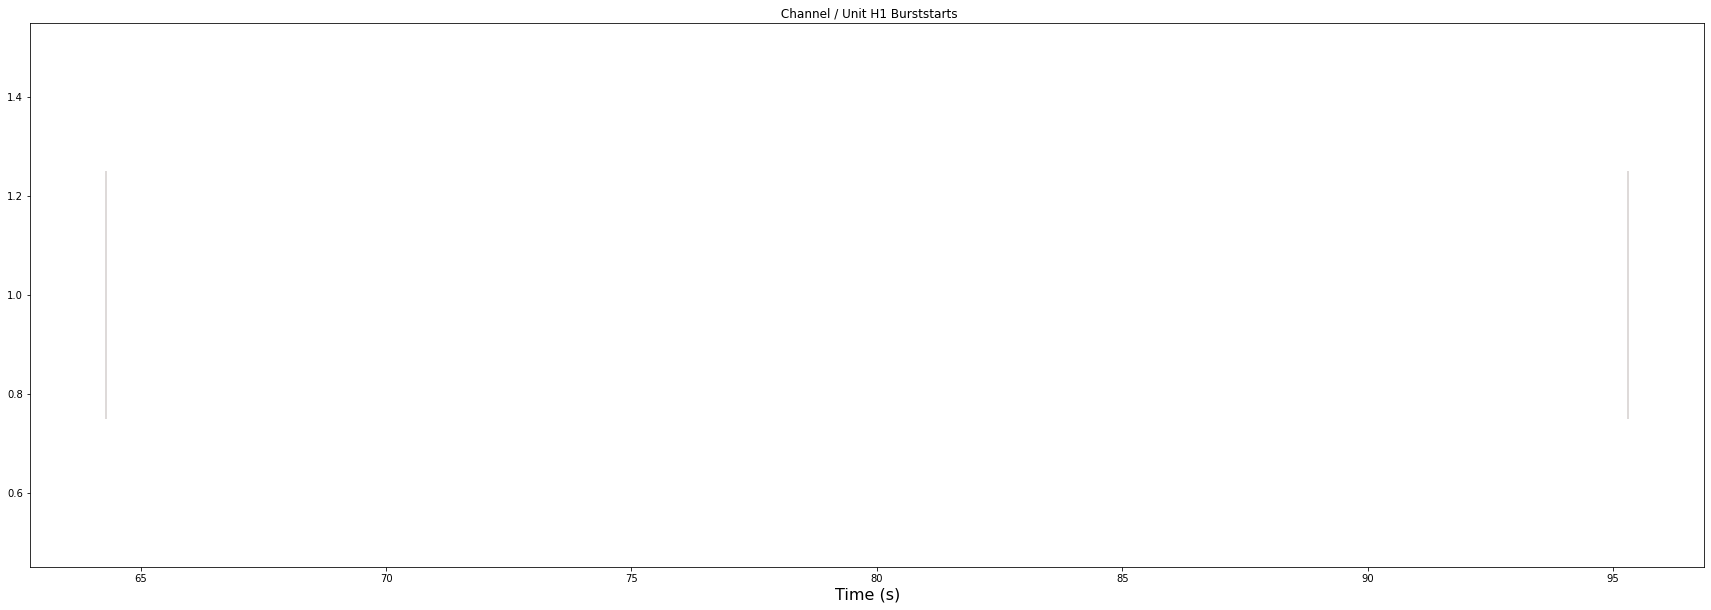

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H6 Burststarts')

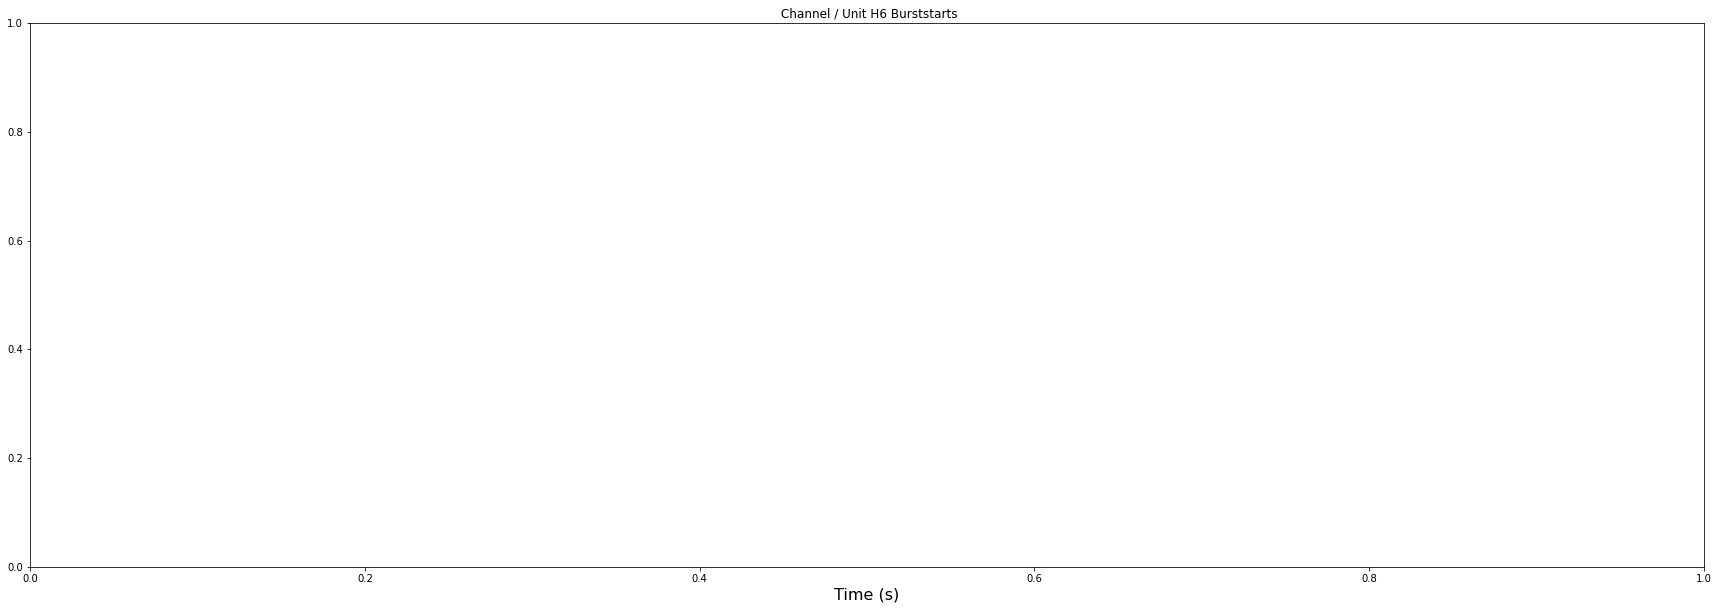

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H7 Burststarts')

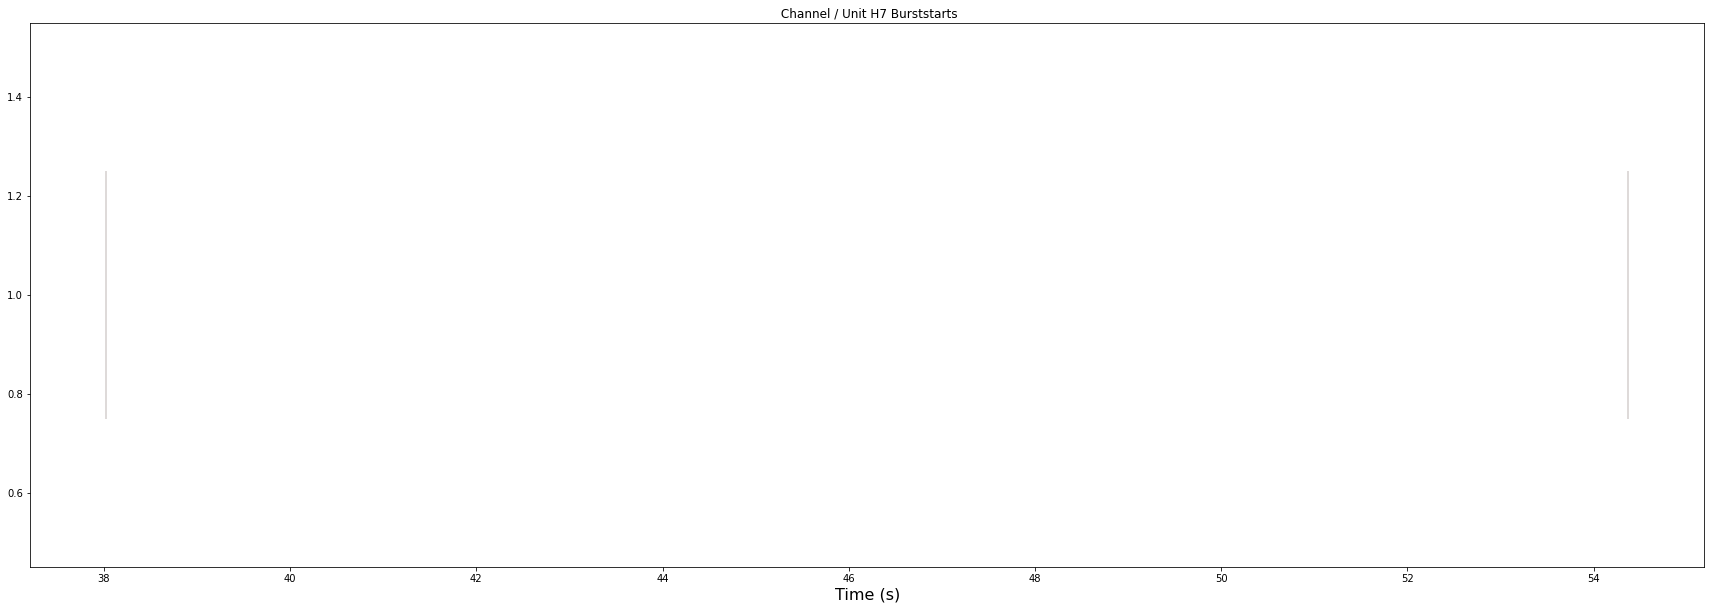

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J7 Burststarts')

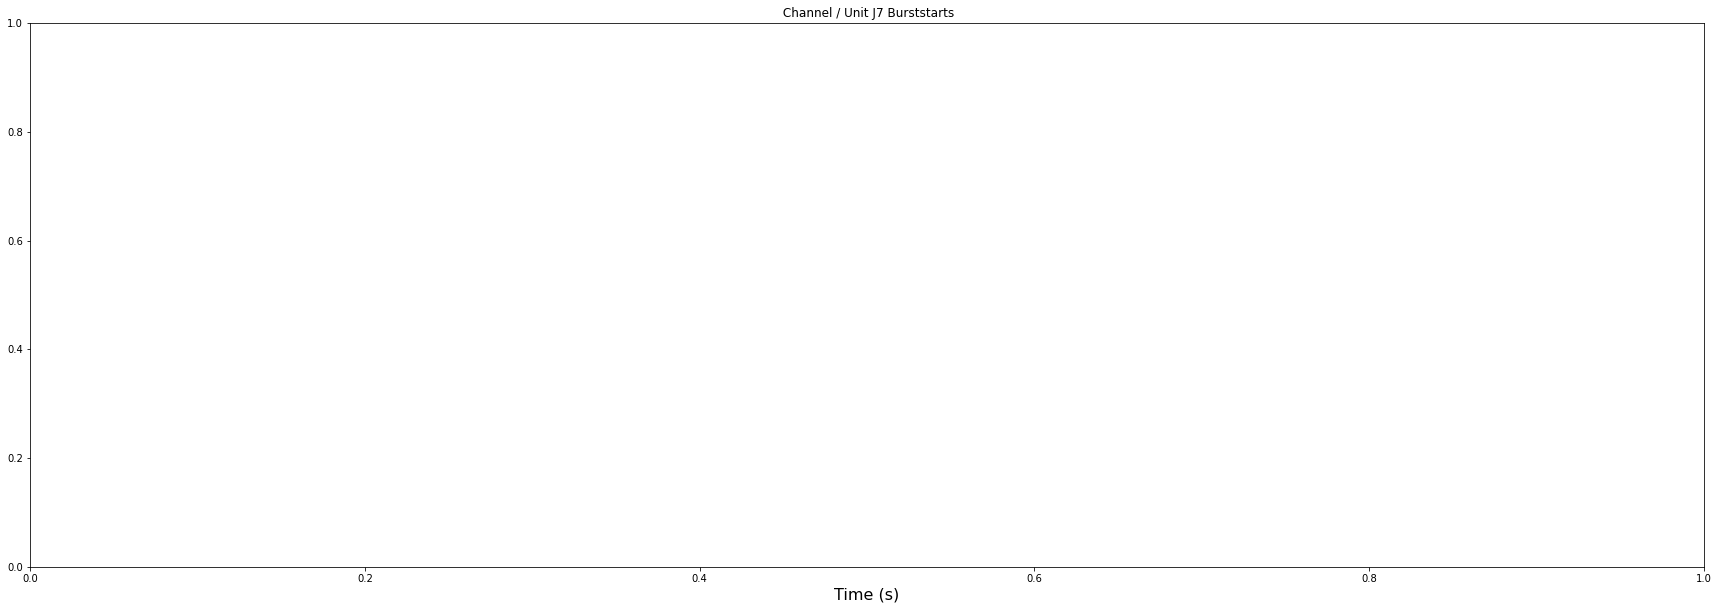

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J6 Burststarts')

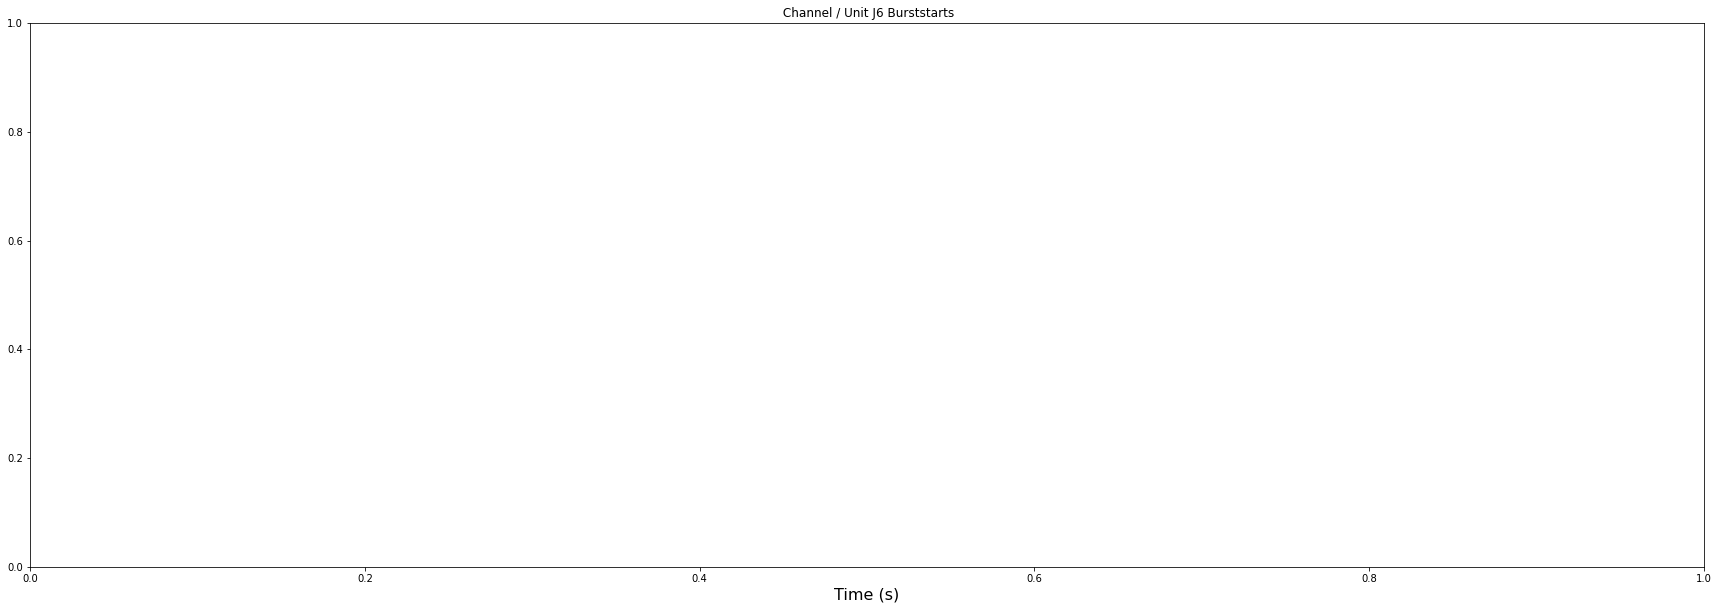

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J1 Burststarts')

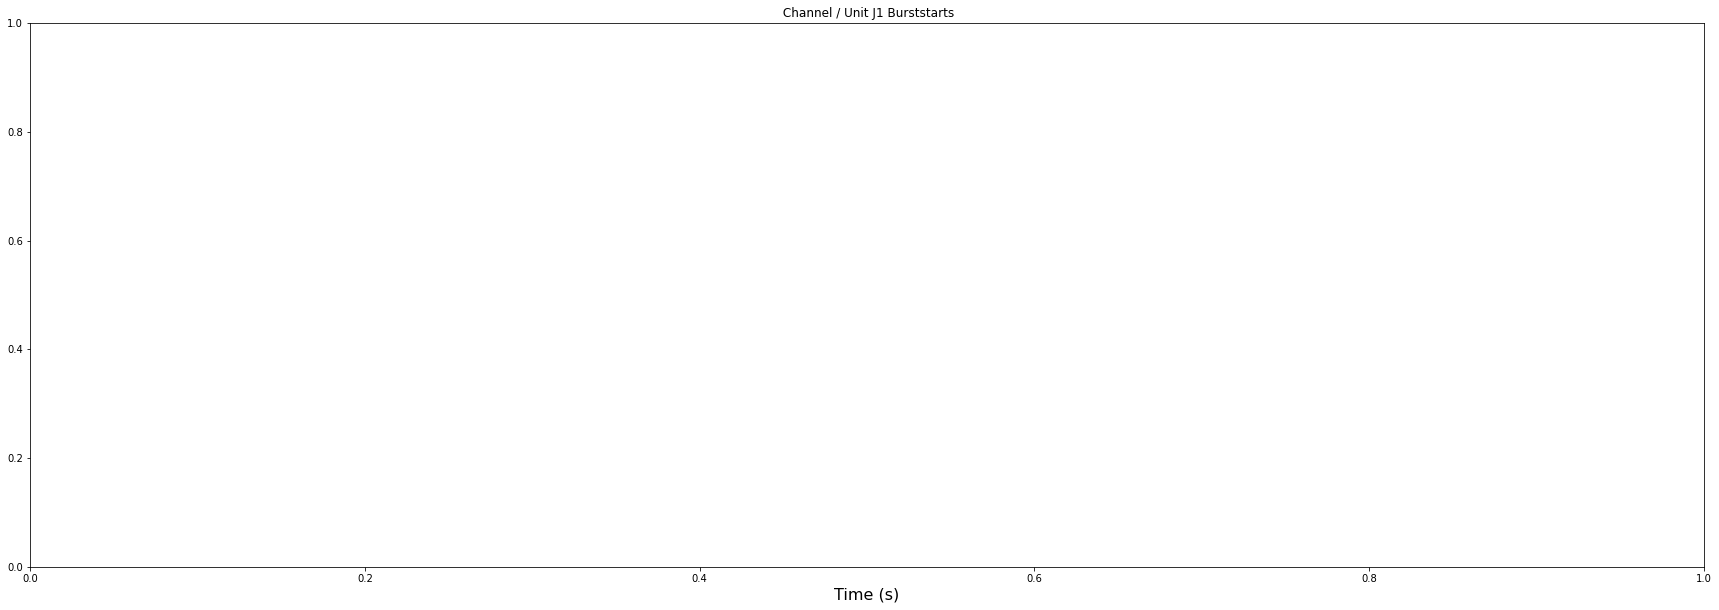

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J2 Burststarts')

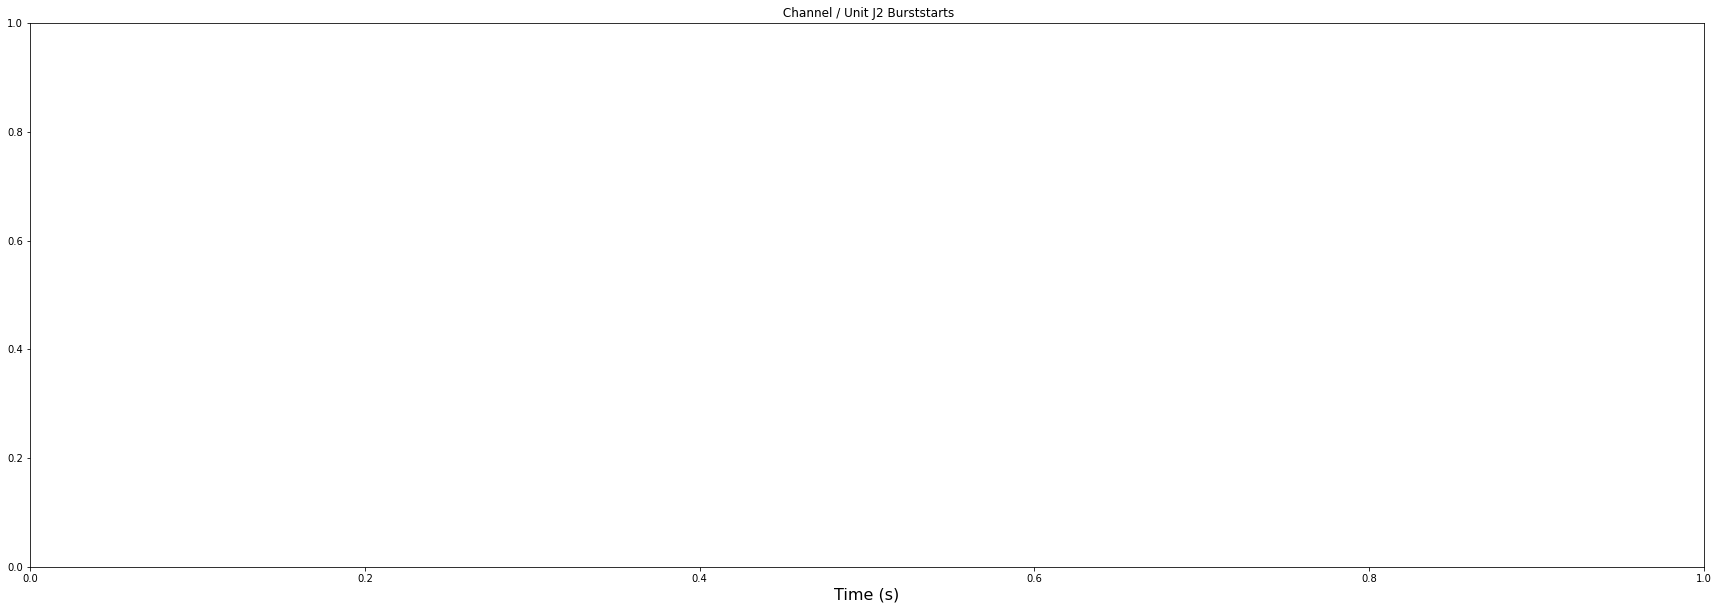

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J3 Burststarts')

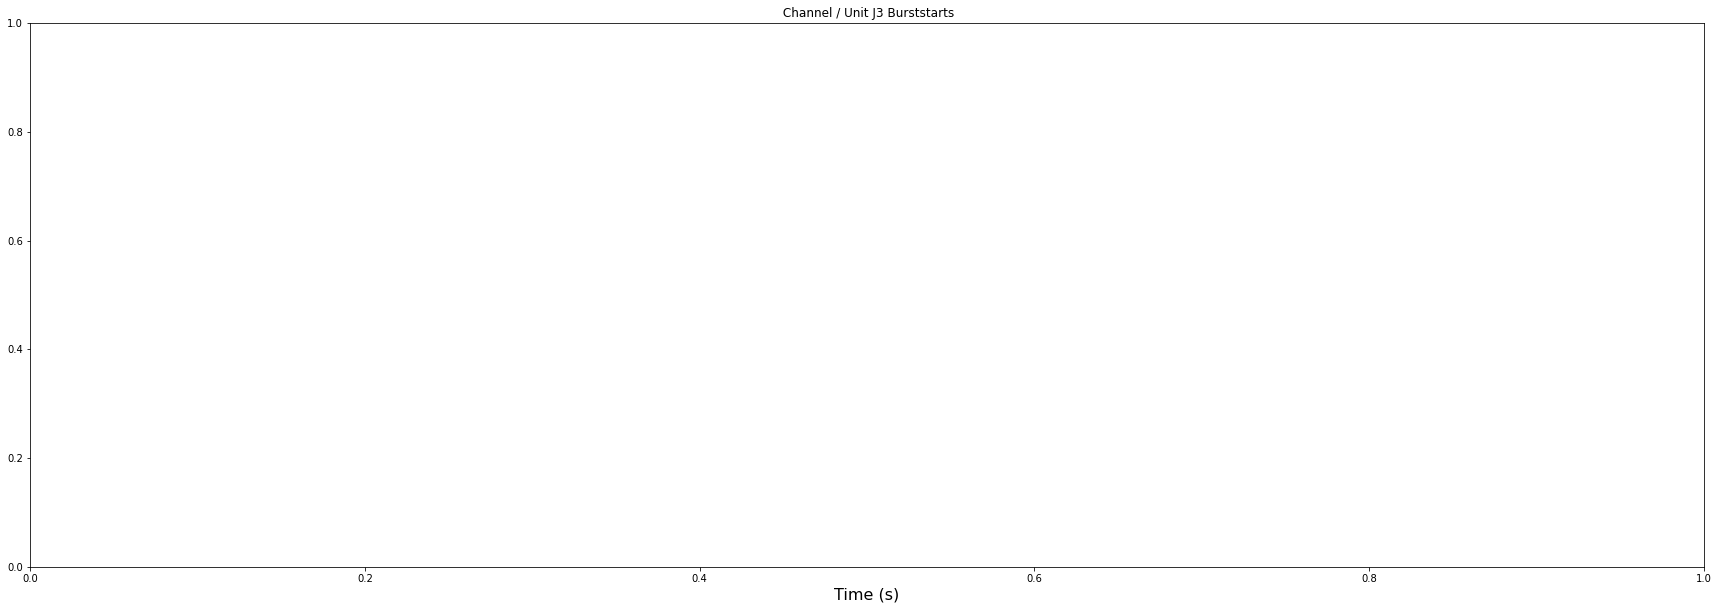

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J4 Burststarts')

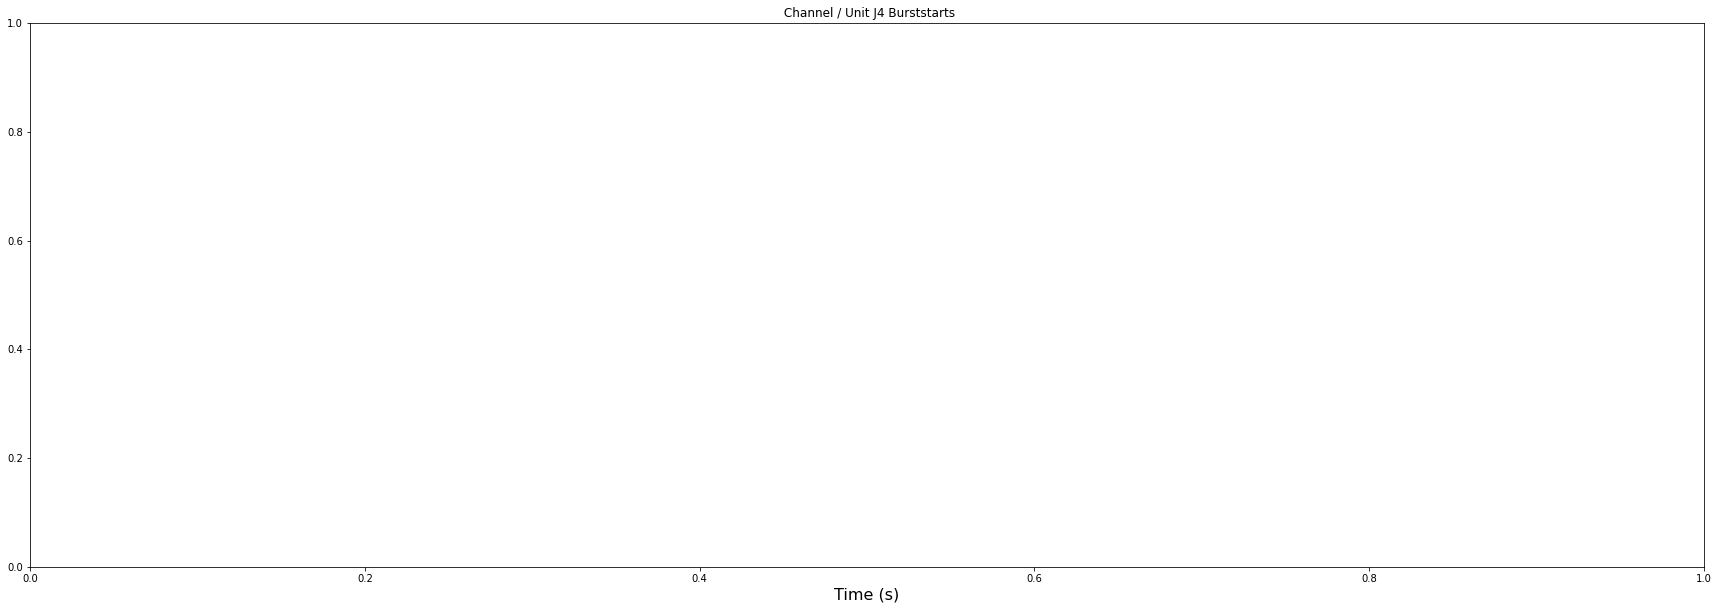

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J5 Burststarts')

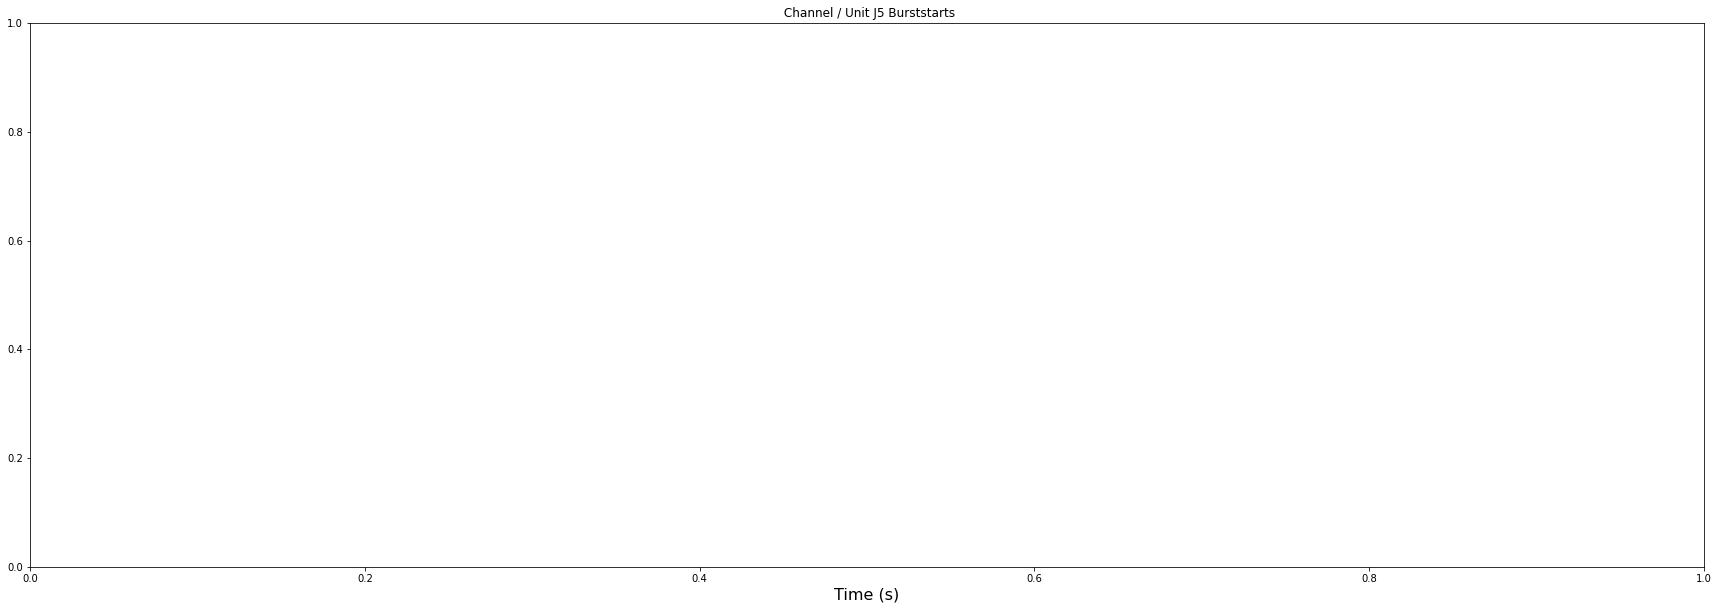

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K1 Burststarts')

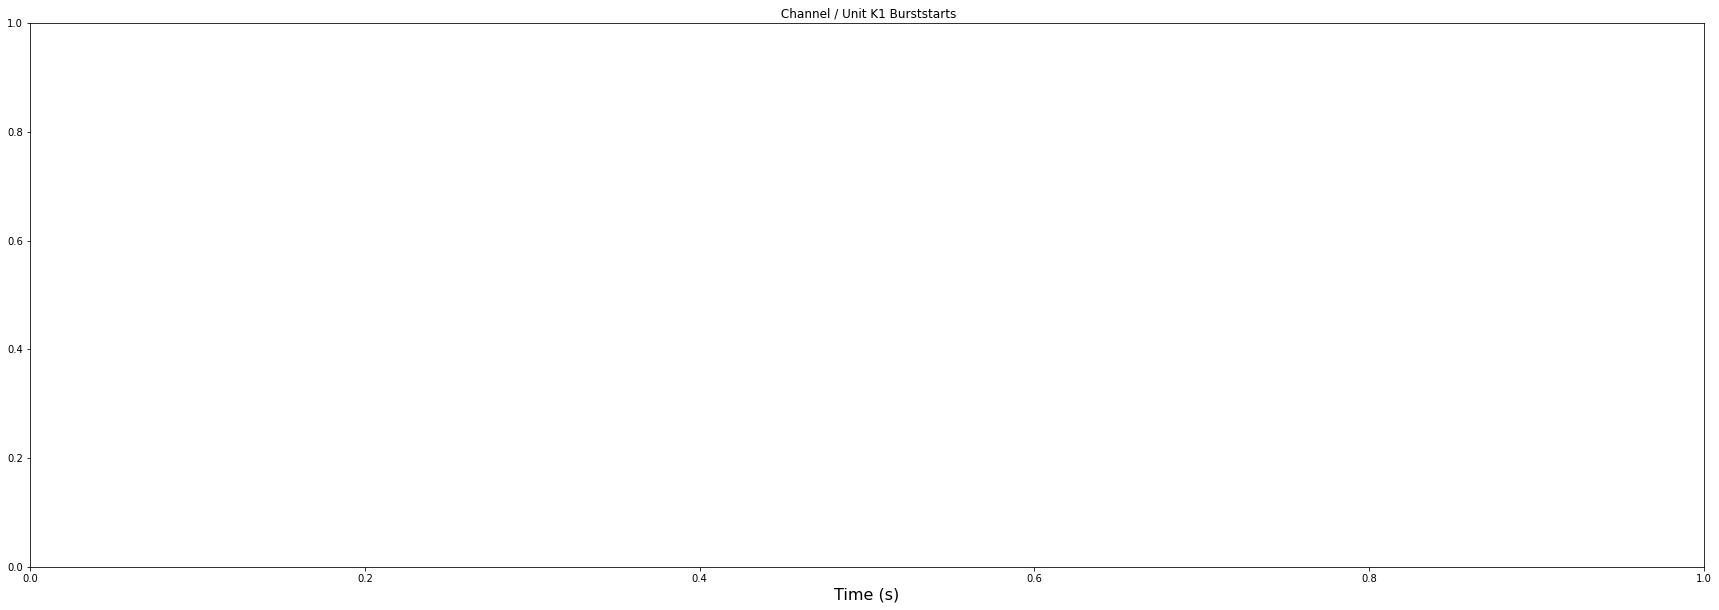

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K2 Burststarts')

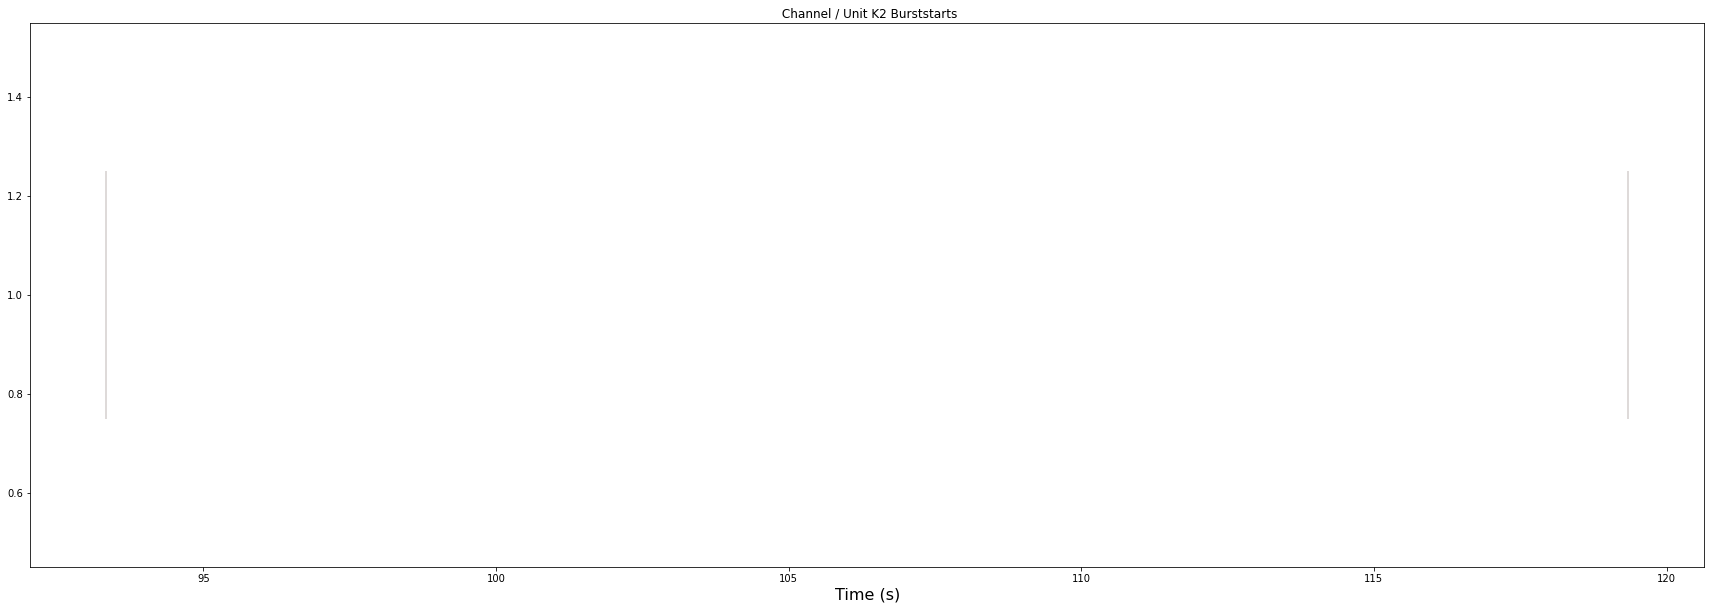

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K3 Burststarts')

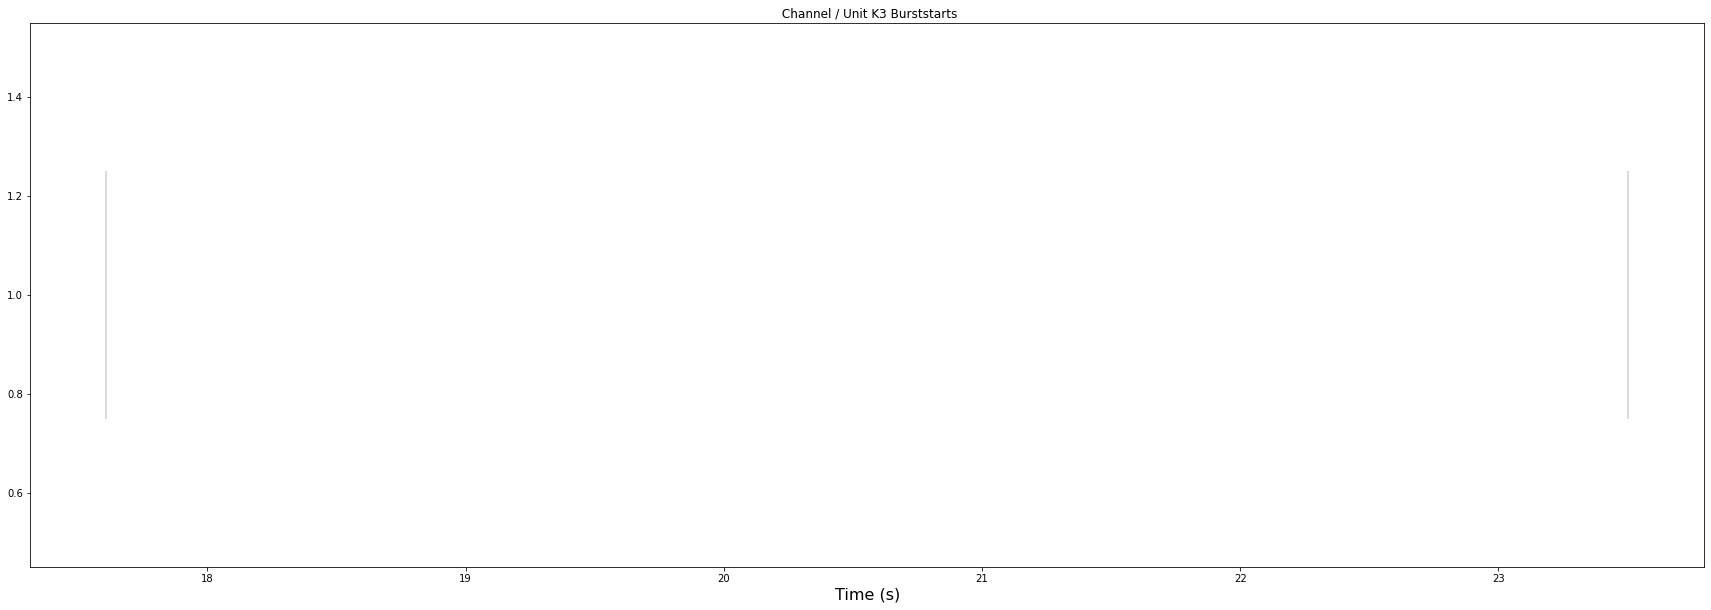

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K4 Burststarts')

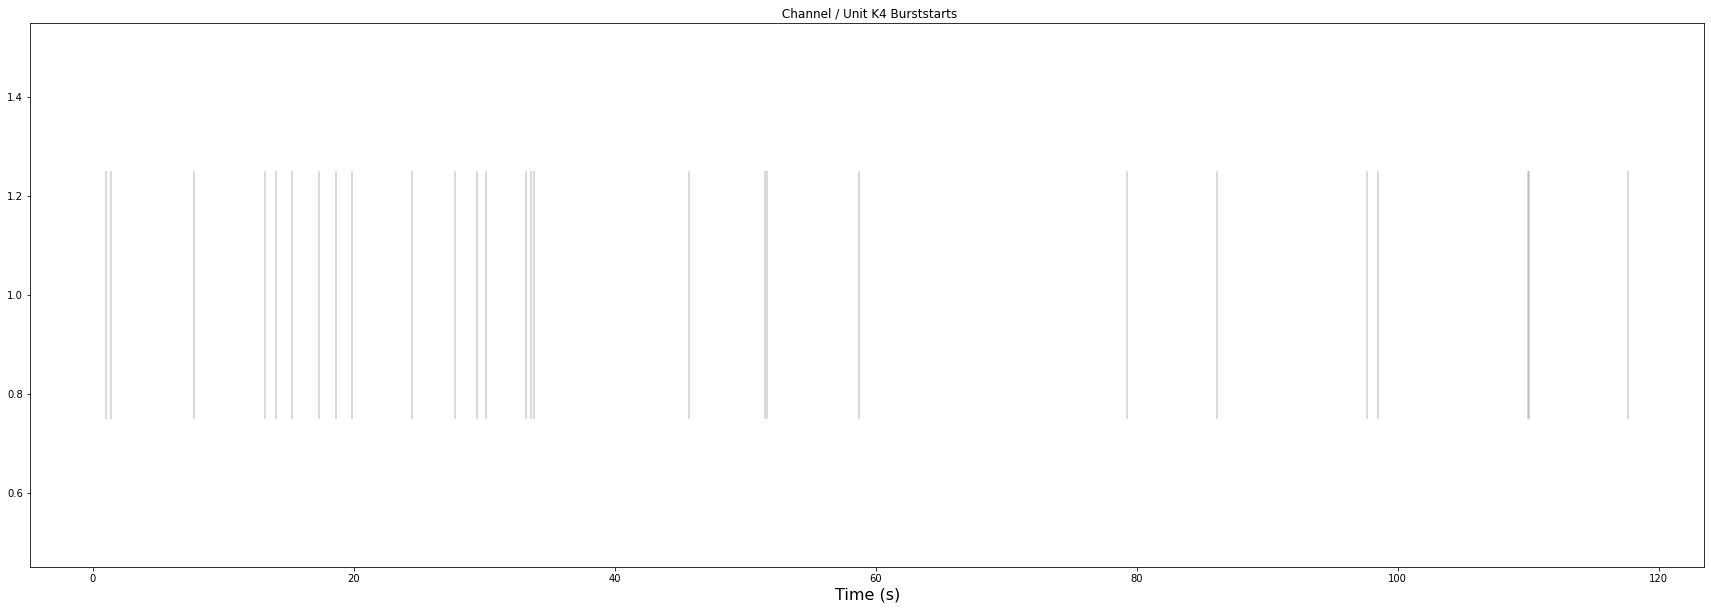

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K5 Burststarts')

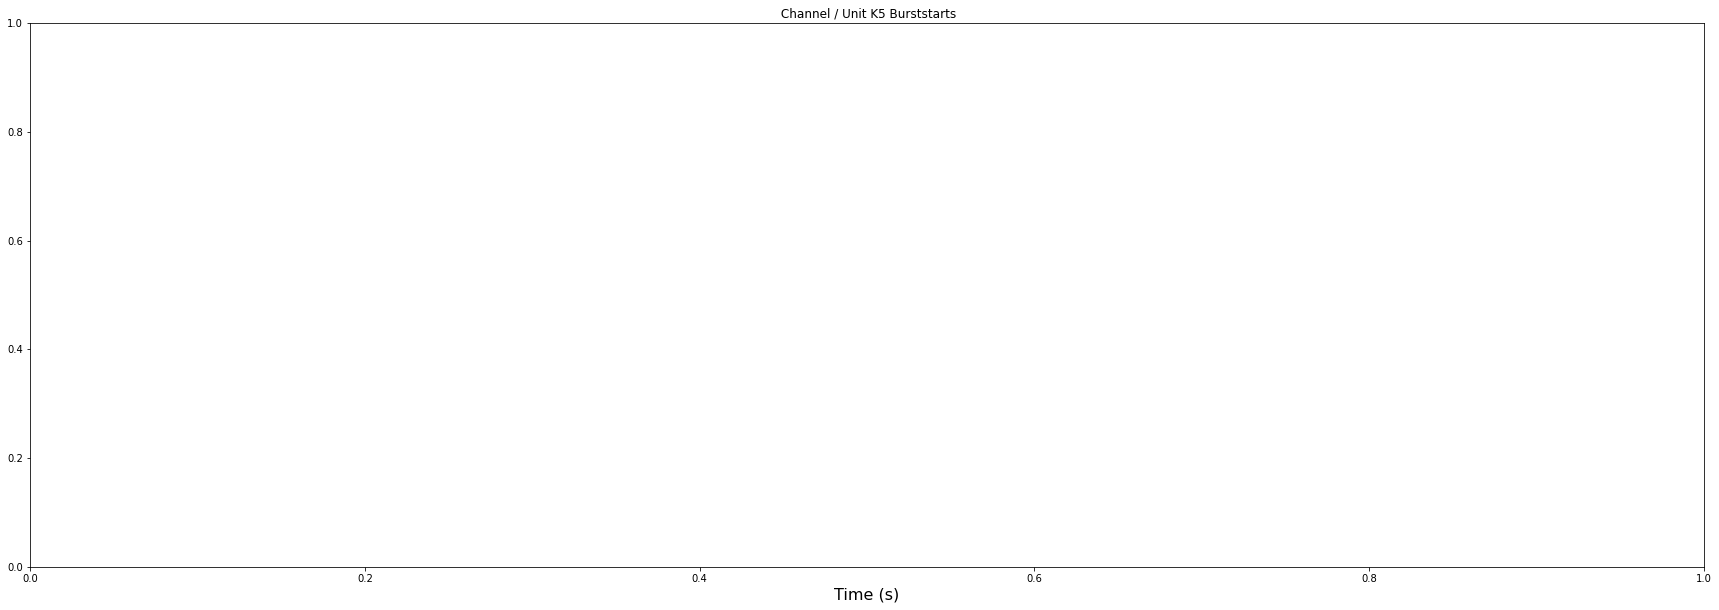

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L1 Burststarts')

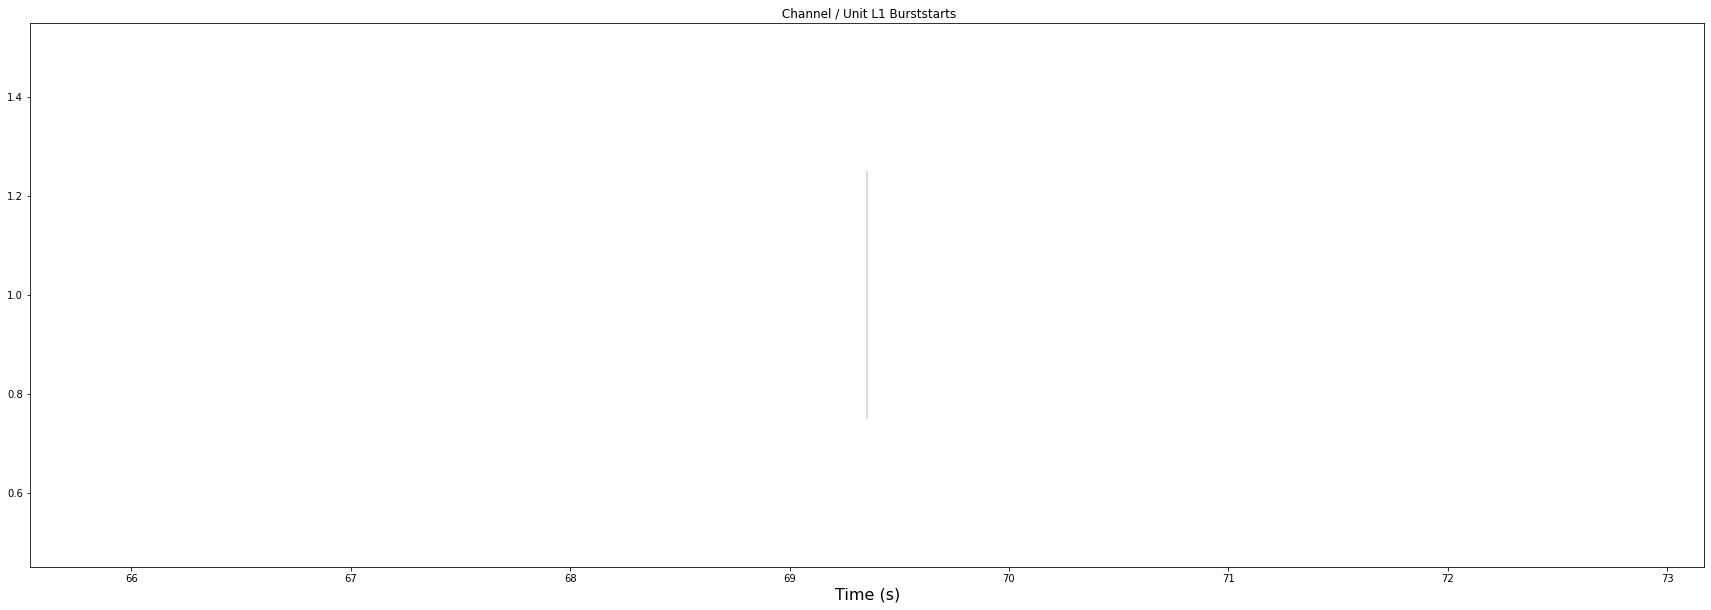

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L2 Burststarts')

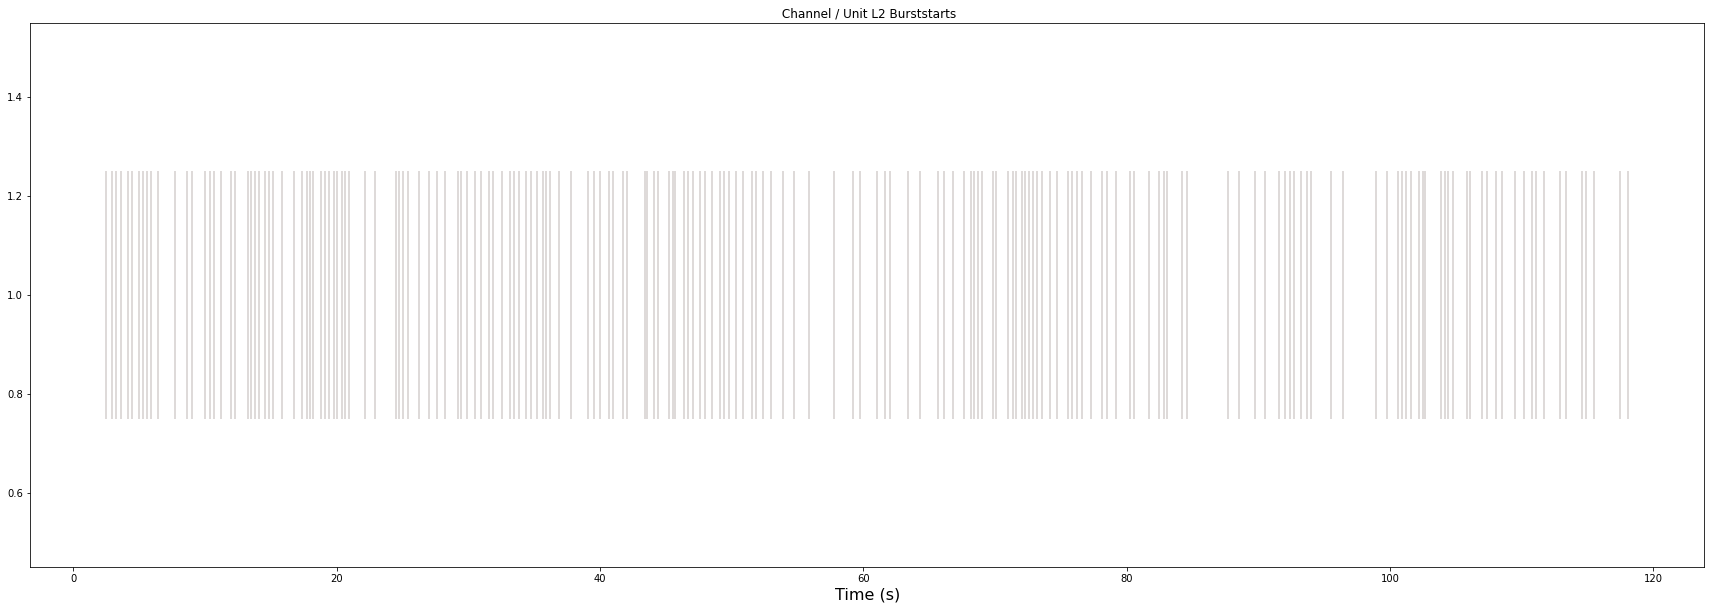

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L3 Burststarts')

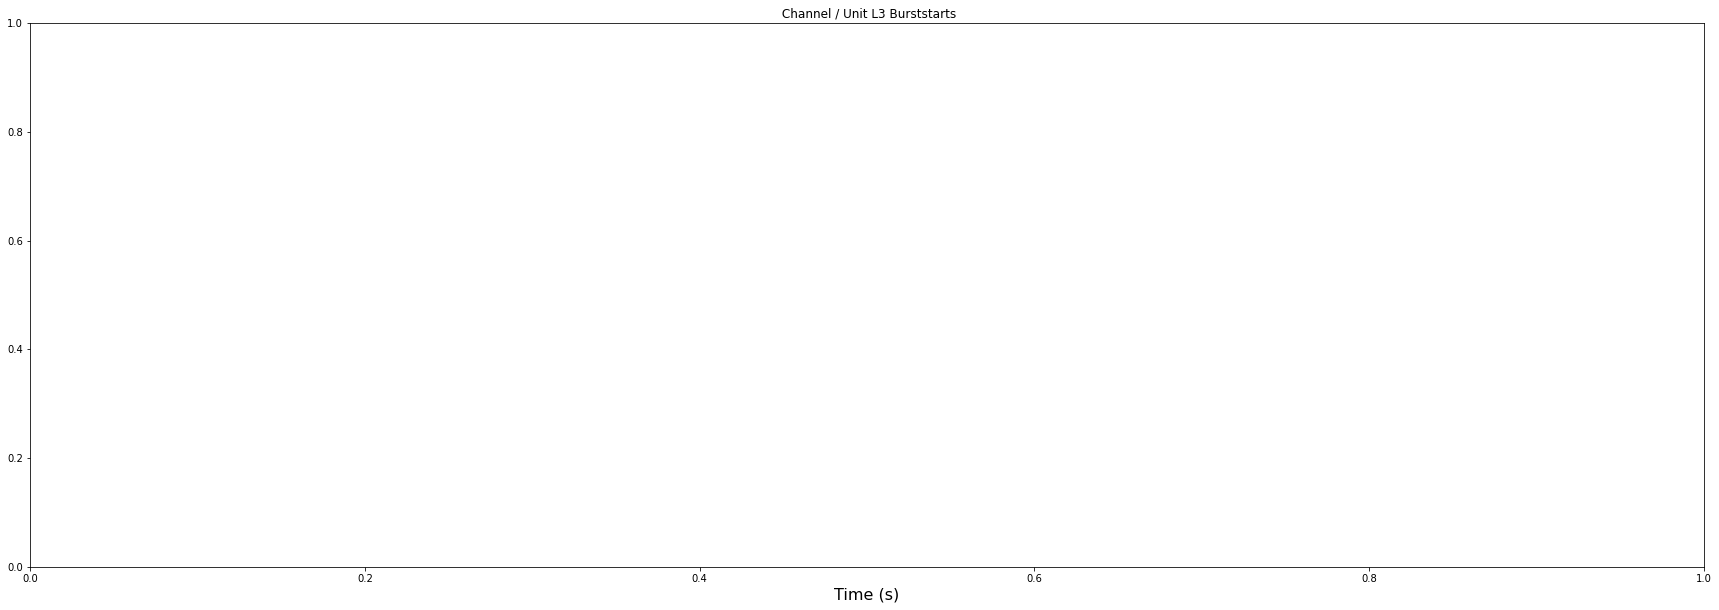

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L4 Burststarts')

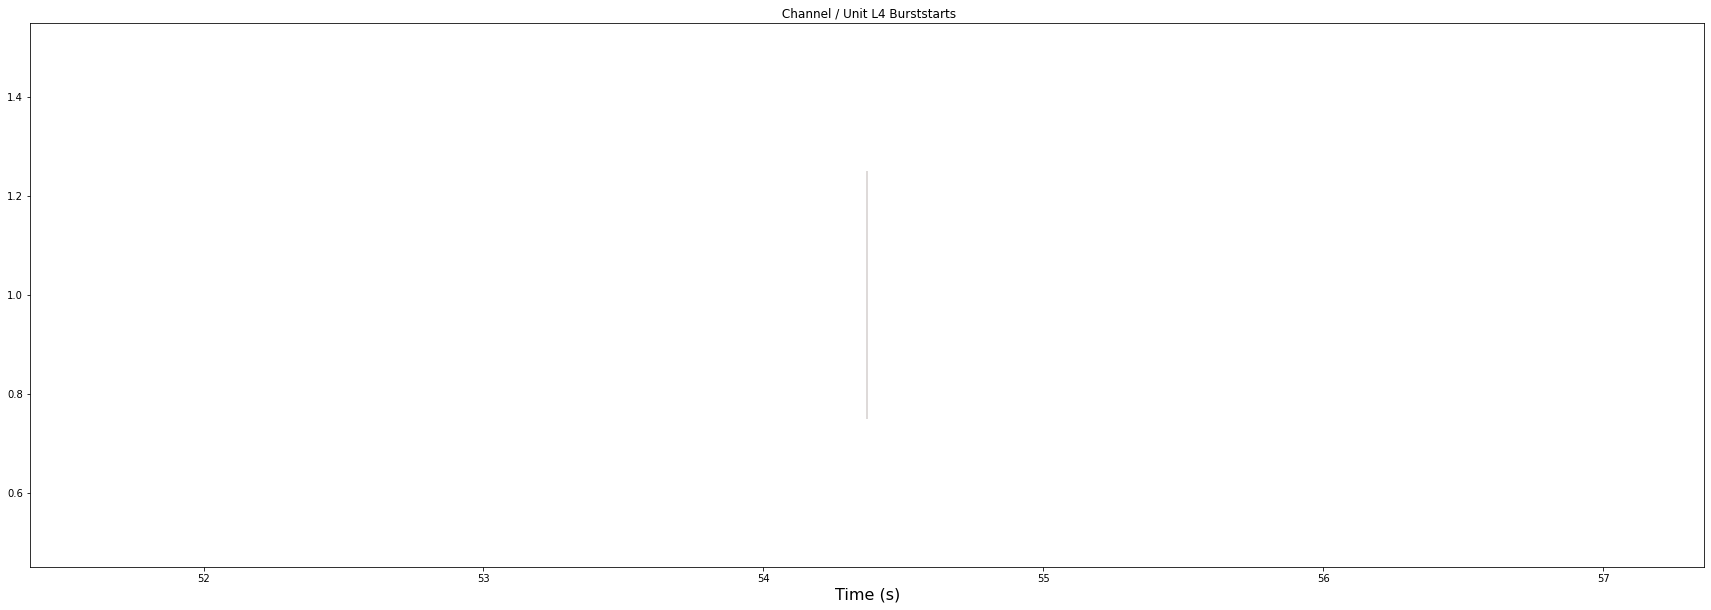

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L5 Burststarts')

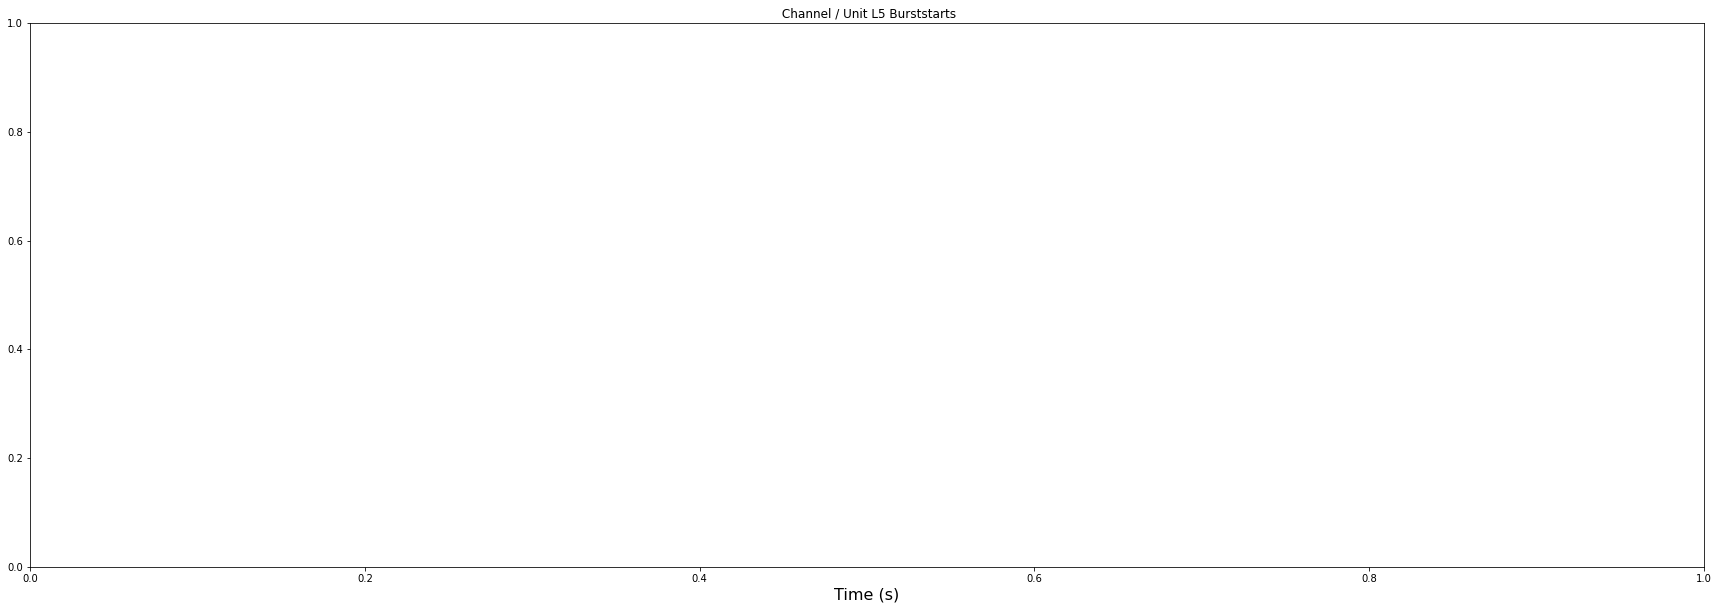

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M1 Burststarts')

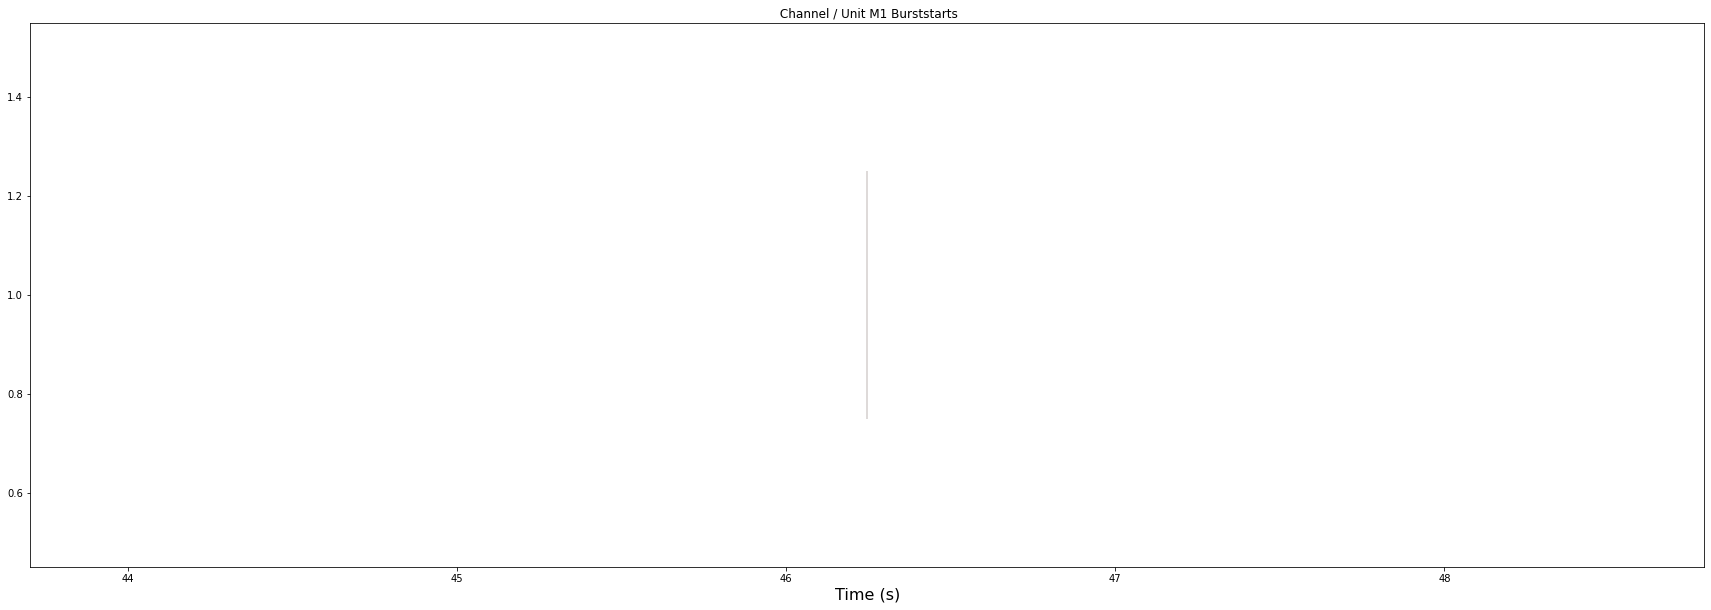

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M2 Burststarts')

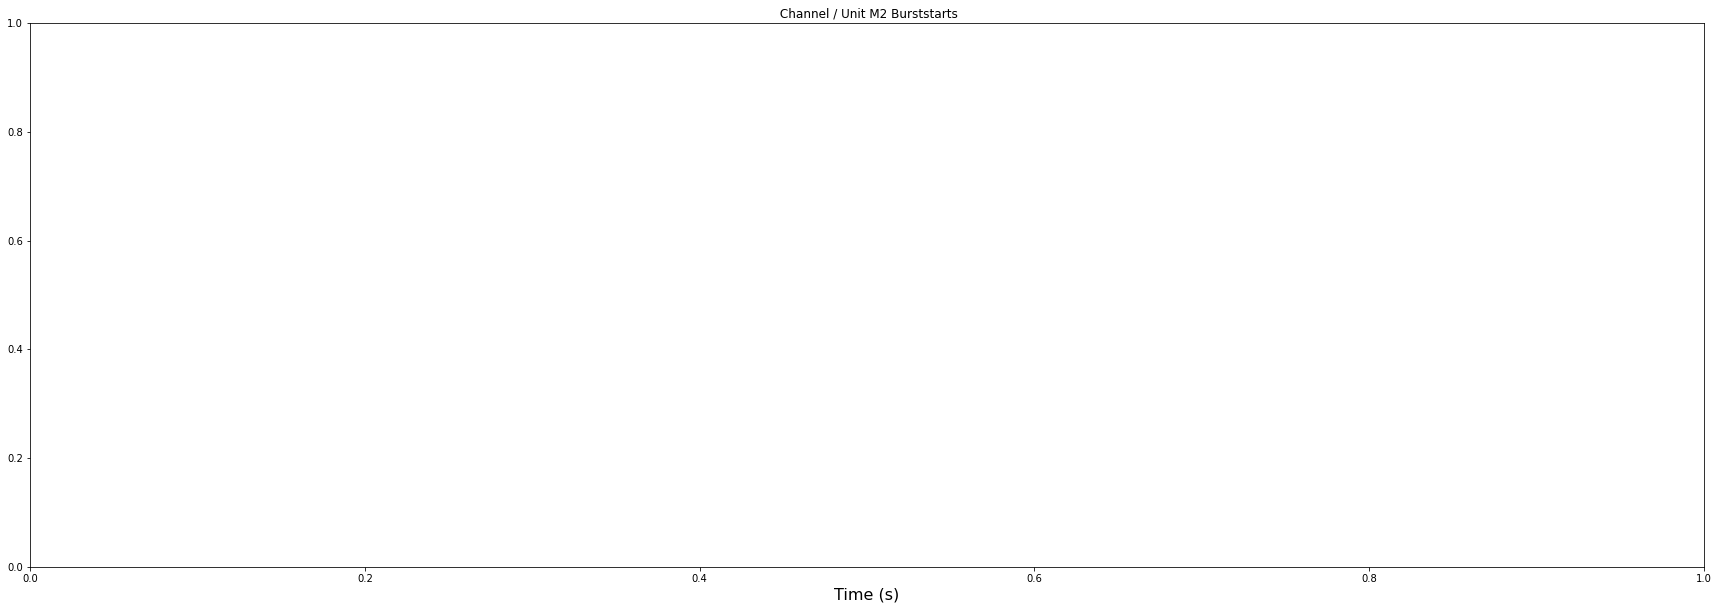

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M3 Burststarts')

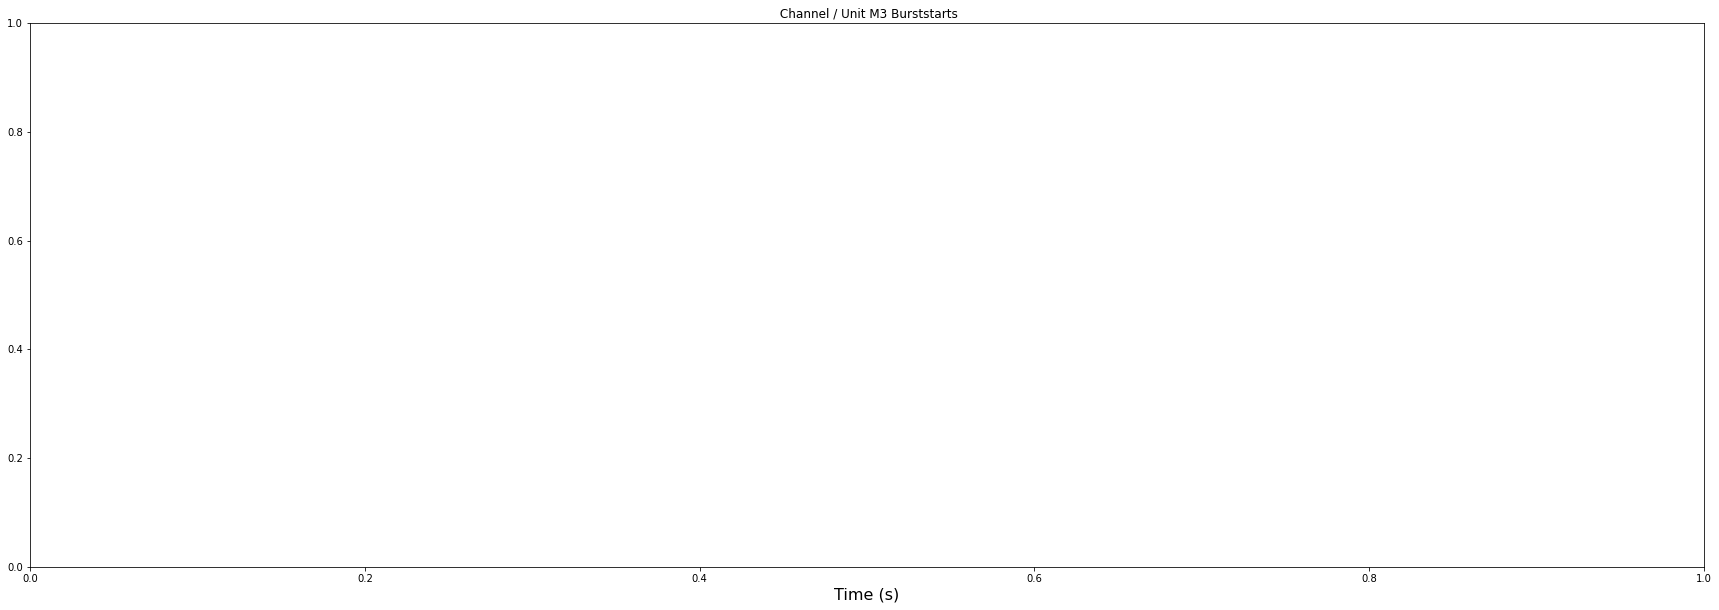

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M4 Burststarts')

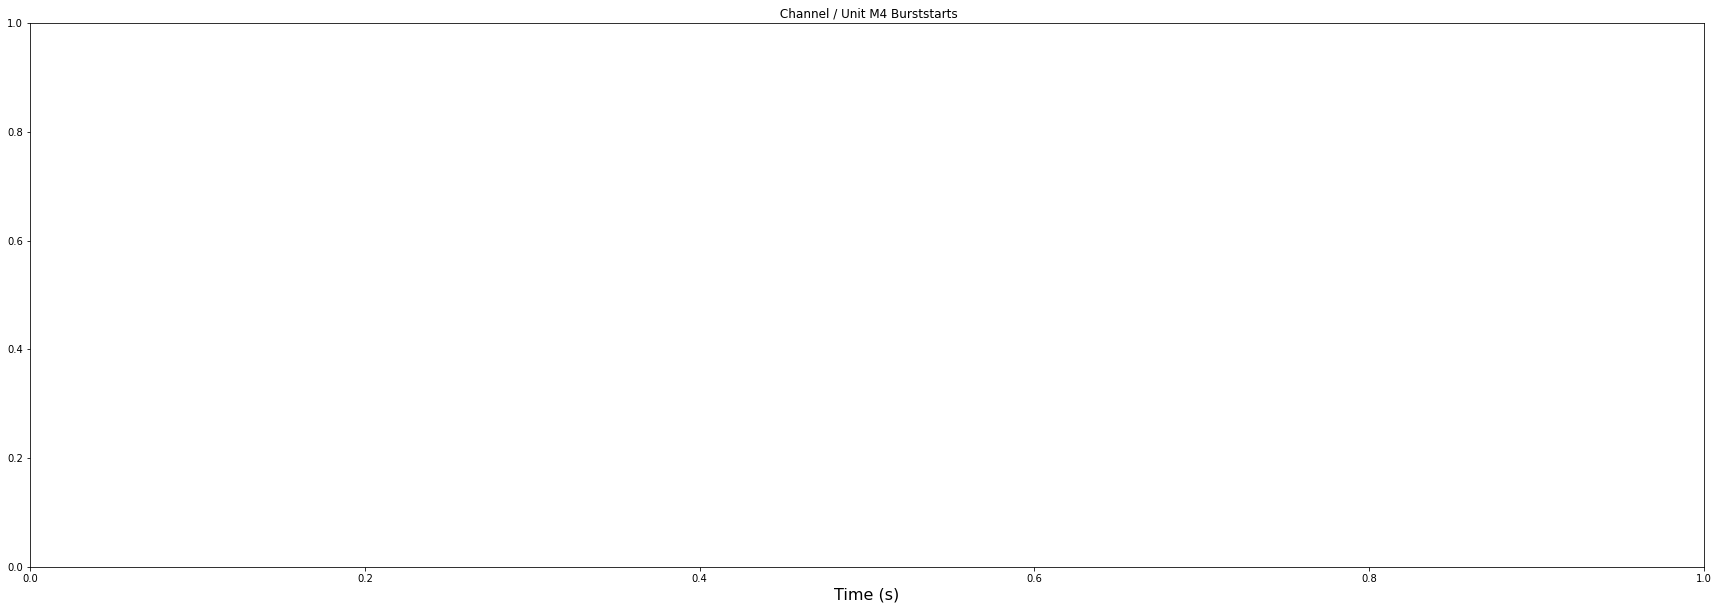

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K6 Burststarts')

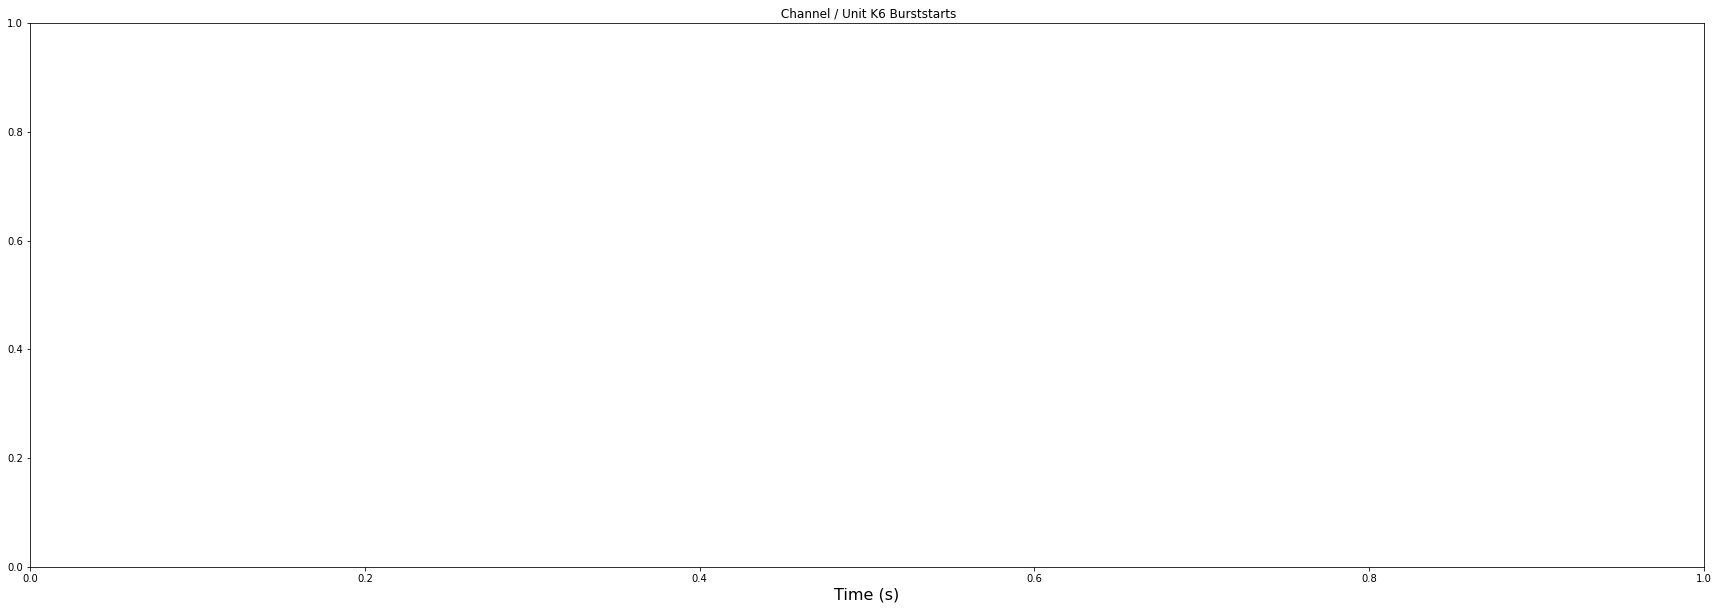

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N1 Burststarts')

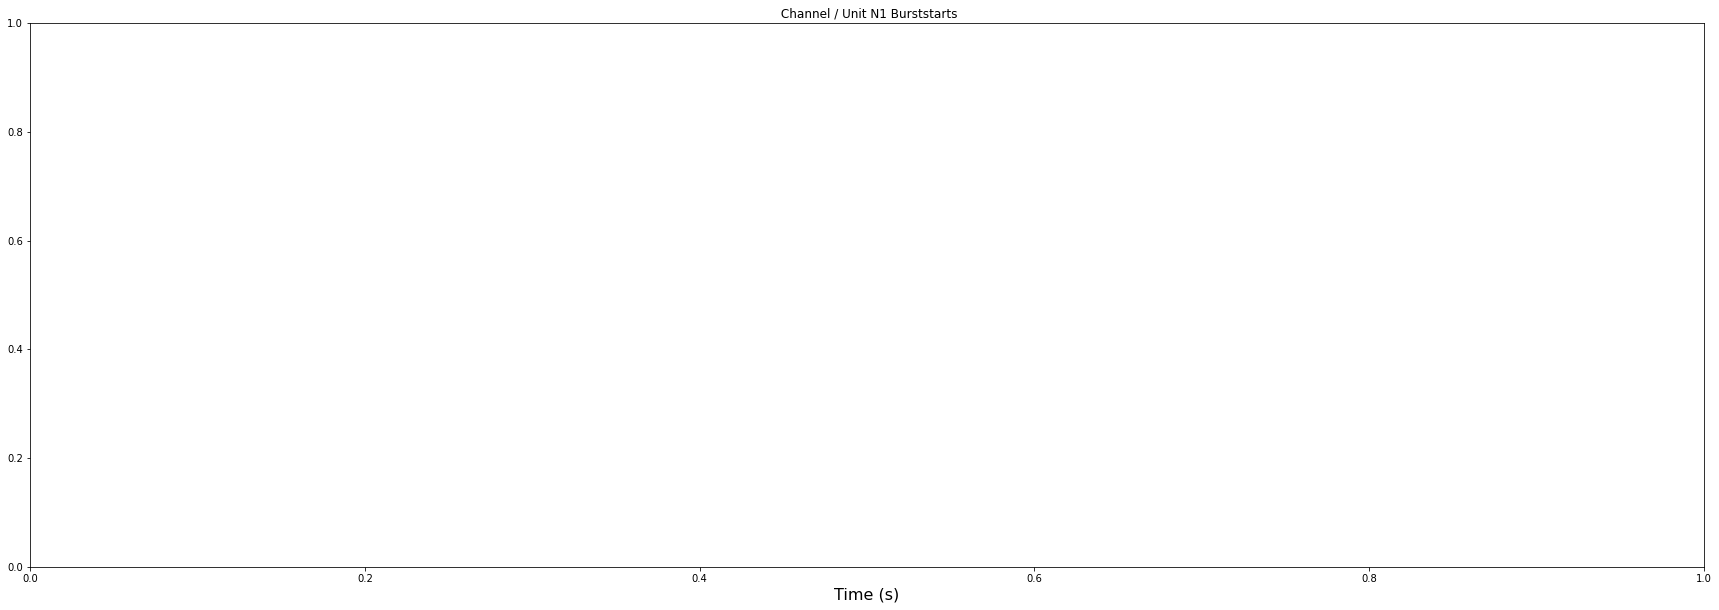

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N2 Burststarts')

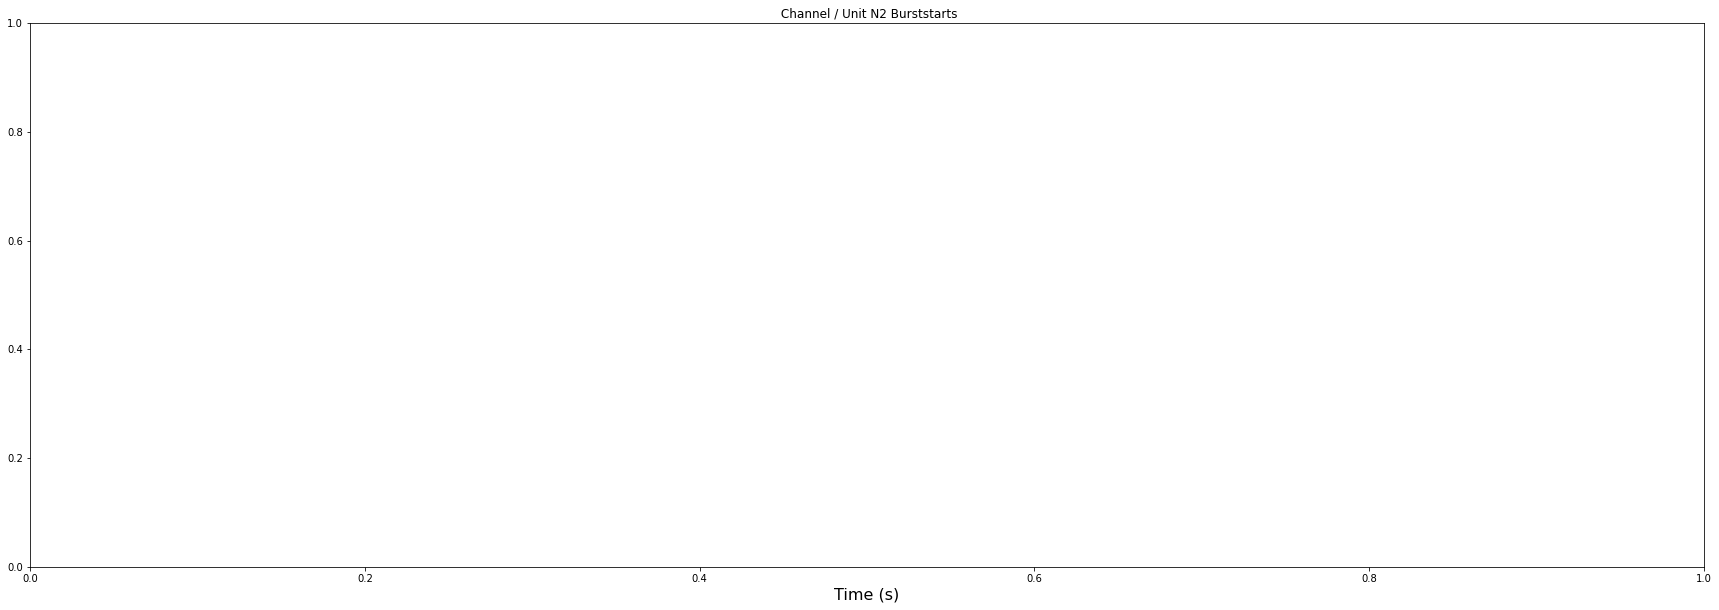

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N3 Burststarts')

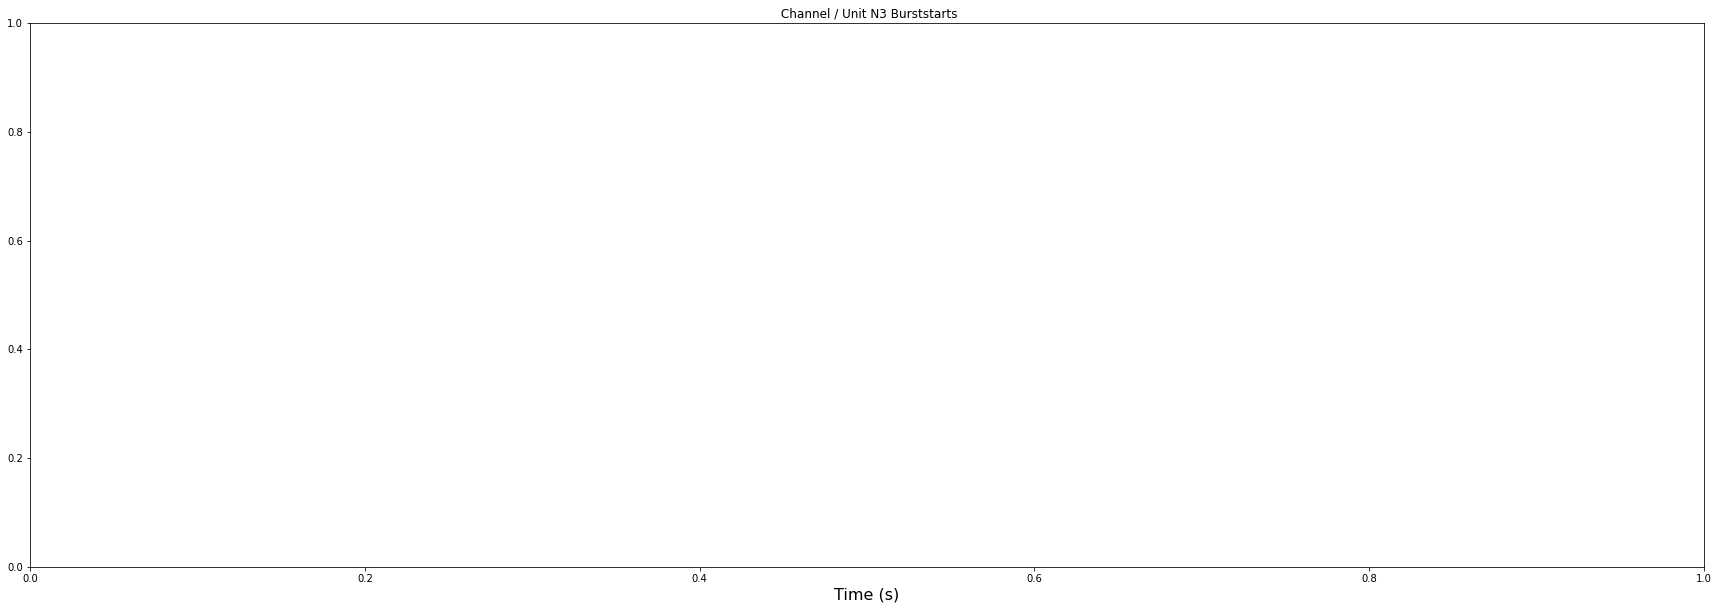

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J8 Burststarts')

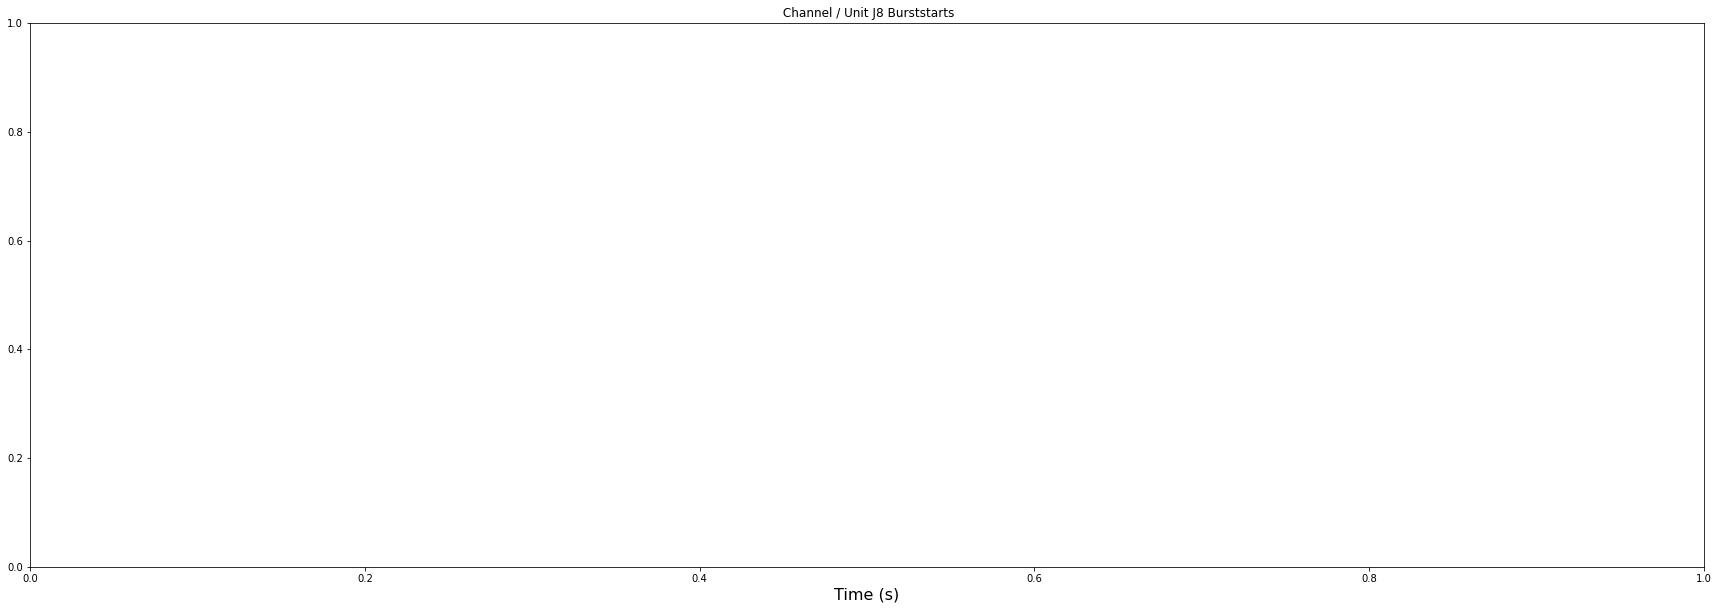

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L6 Burststarts')

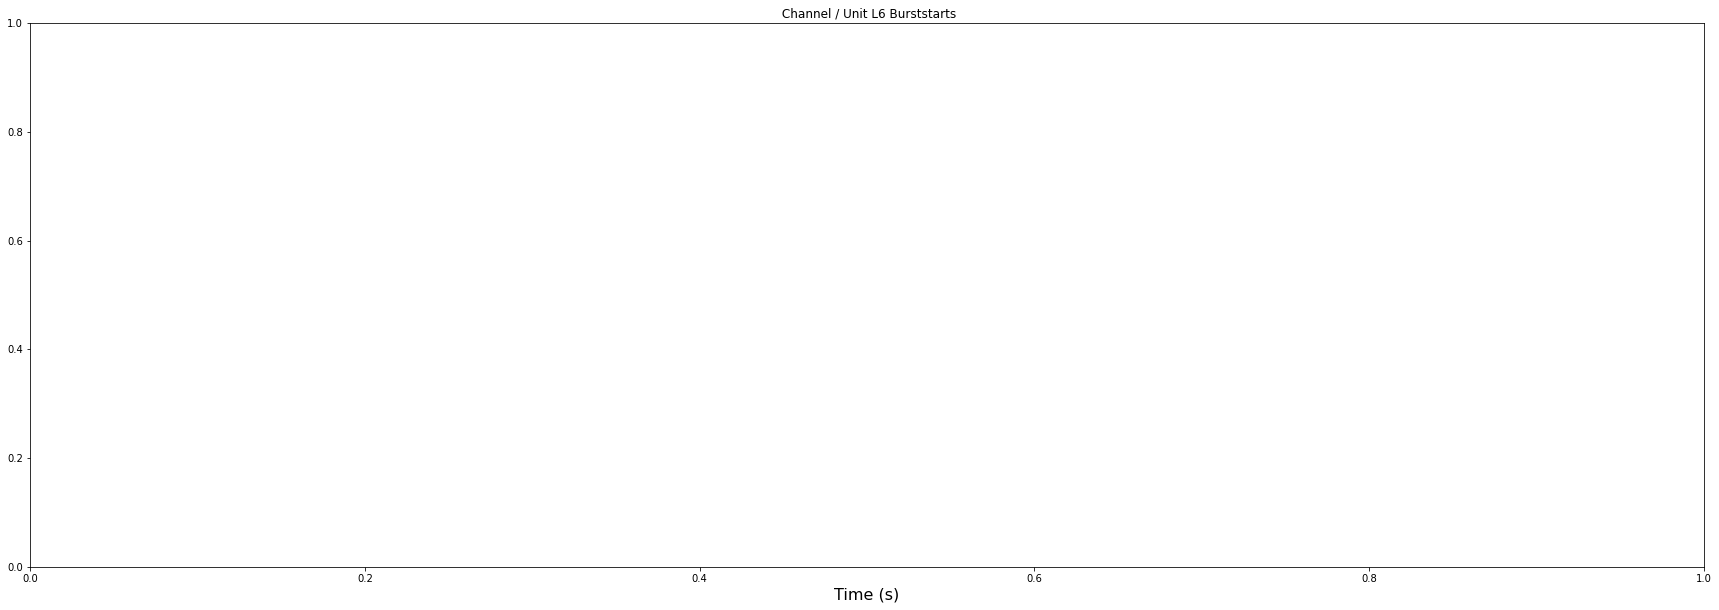

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O1 Burststarts')

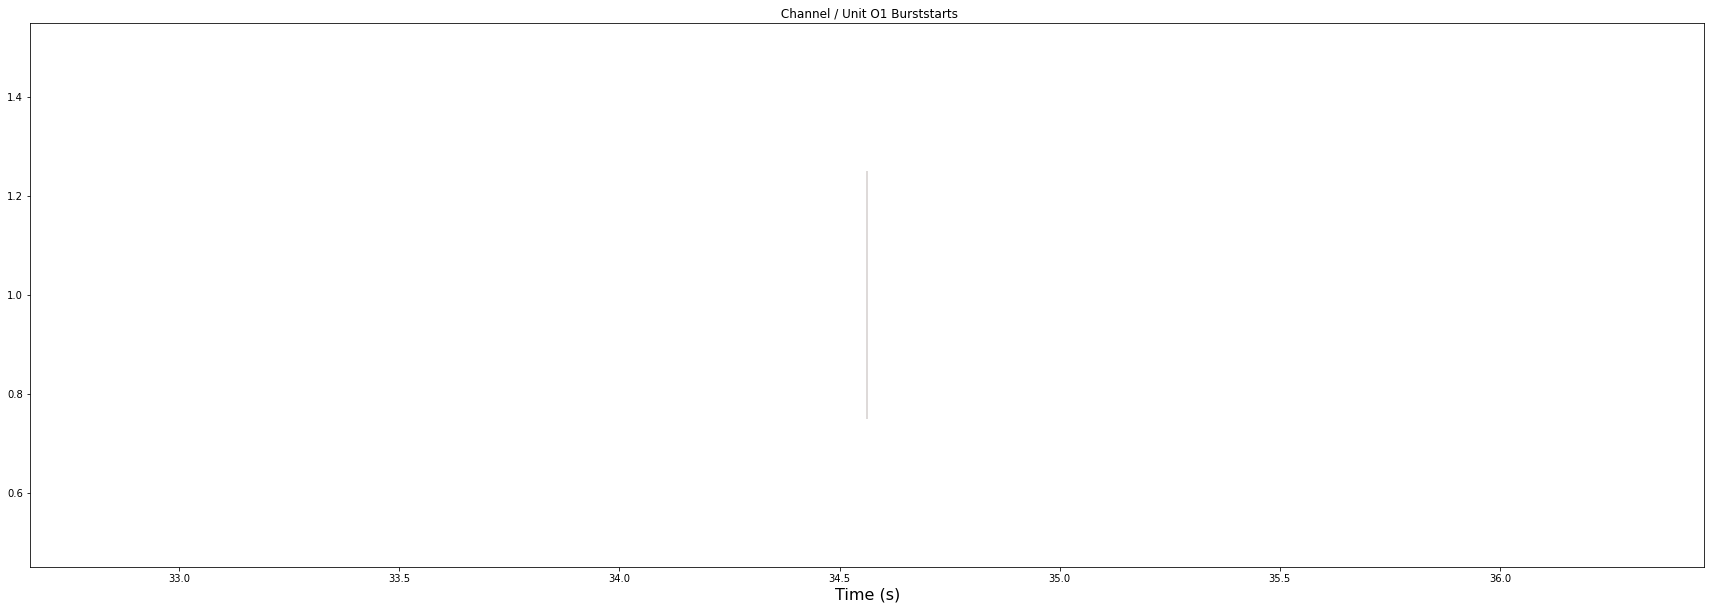

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O2 Burststarts')

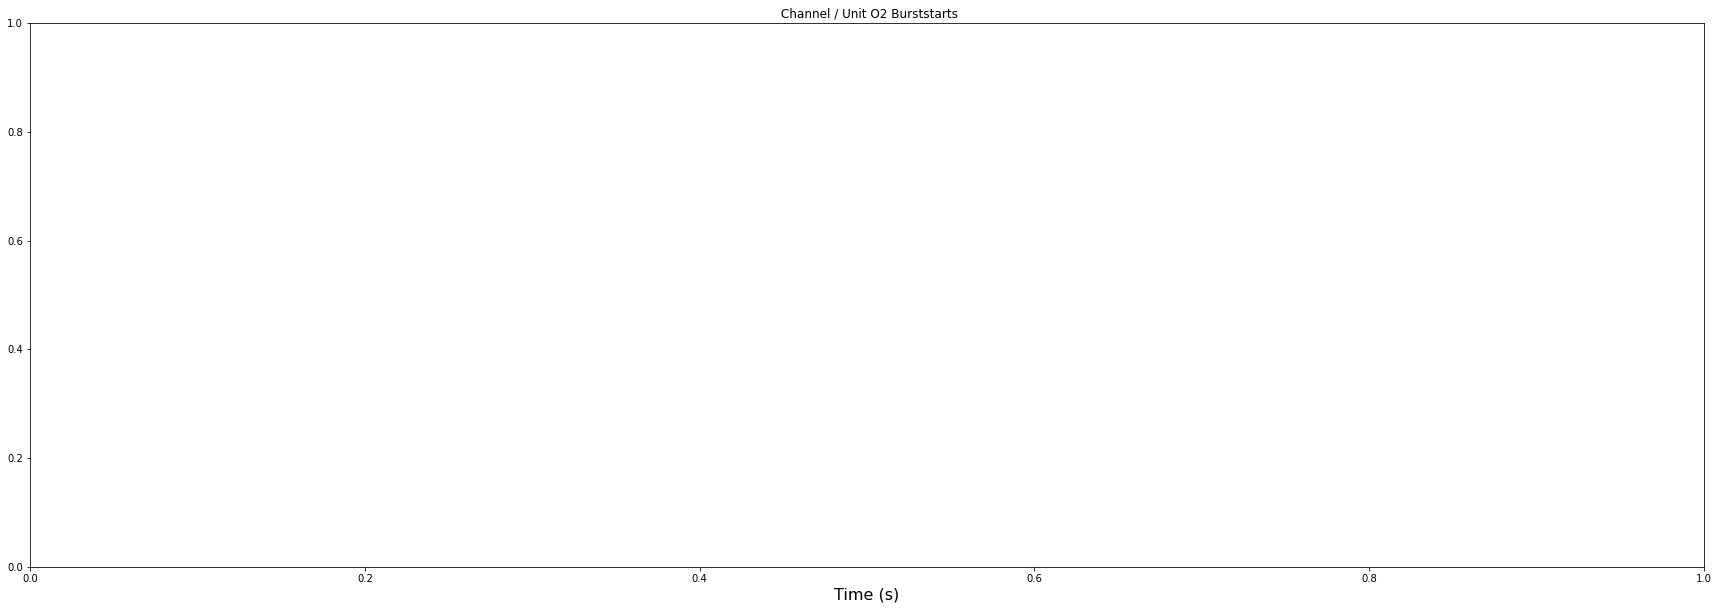

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N4 Burststarts')

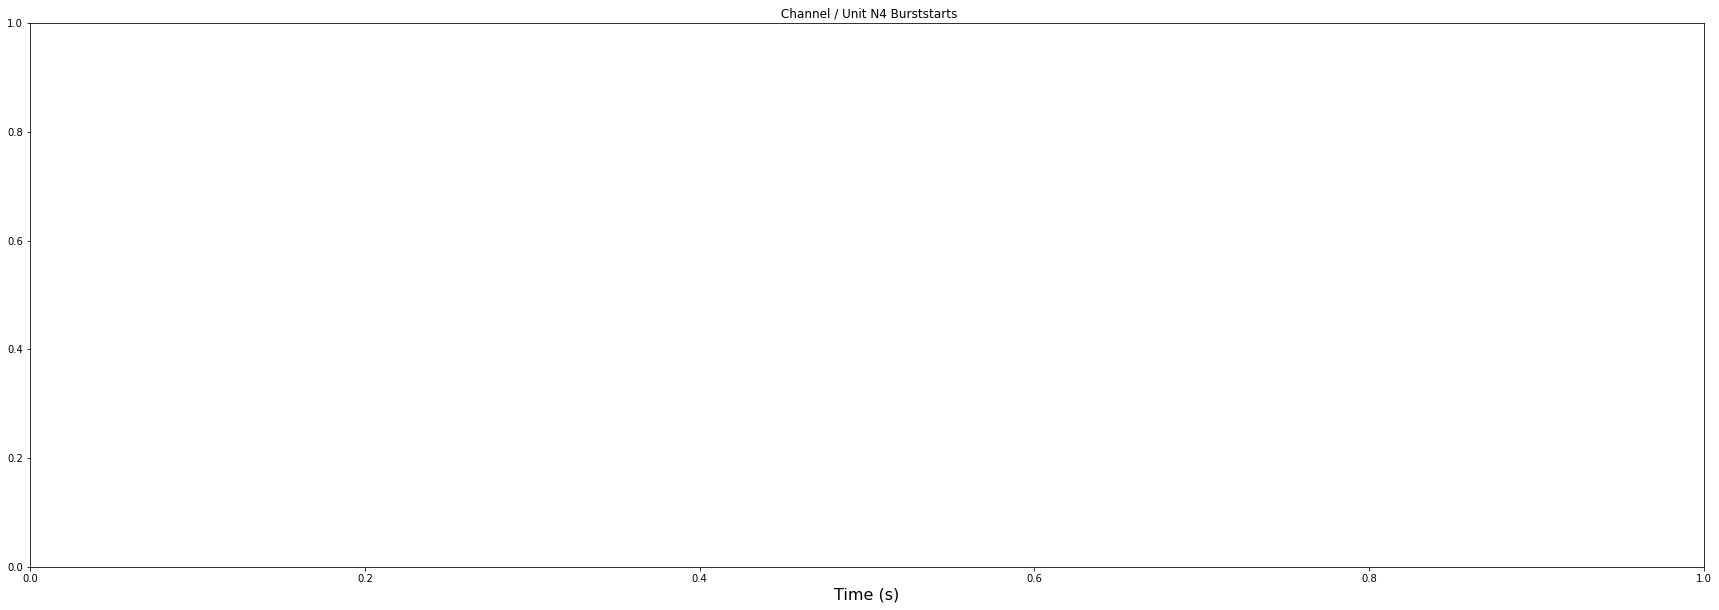

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P1 Burststarts')

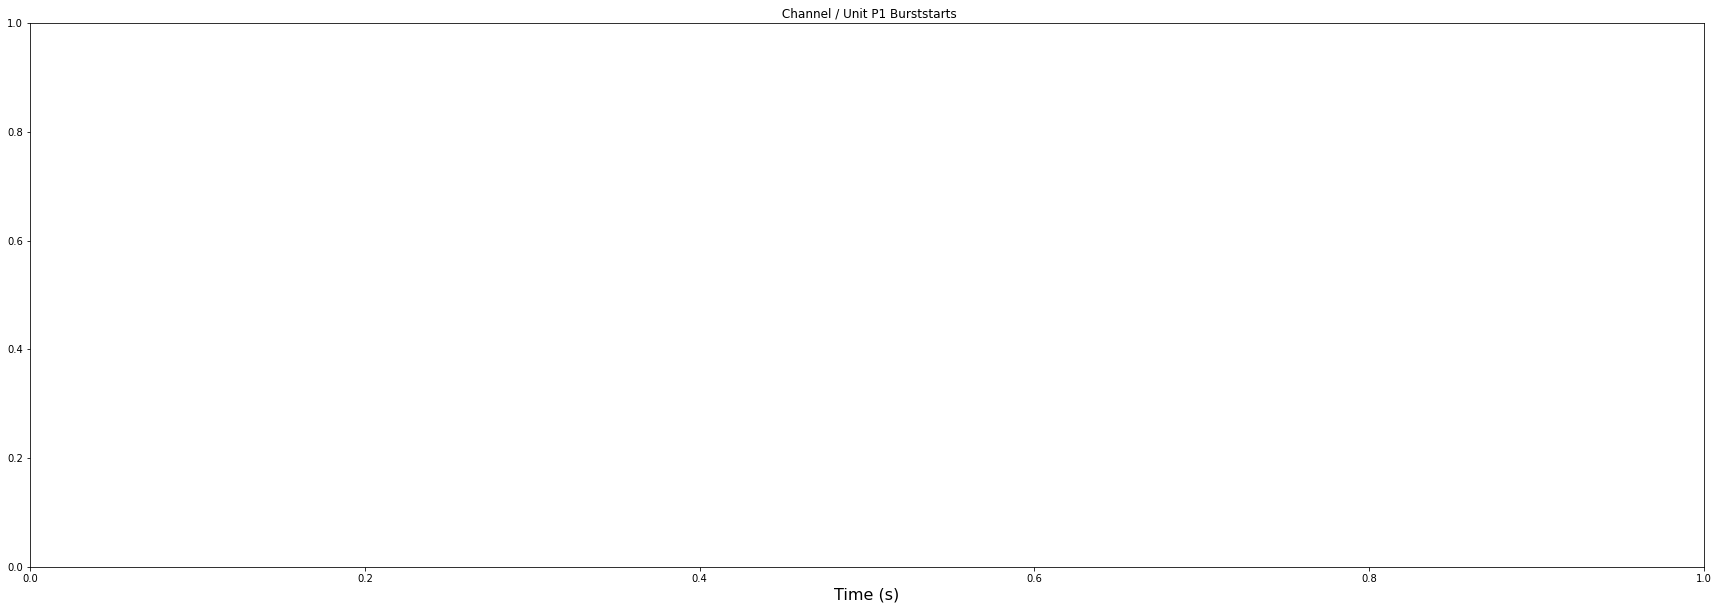

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P2 Burststarts')

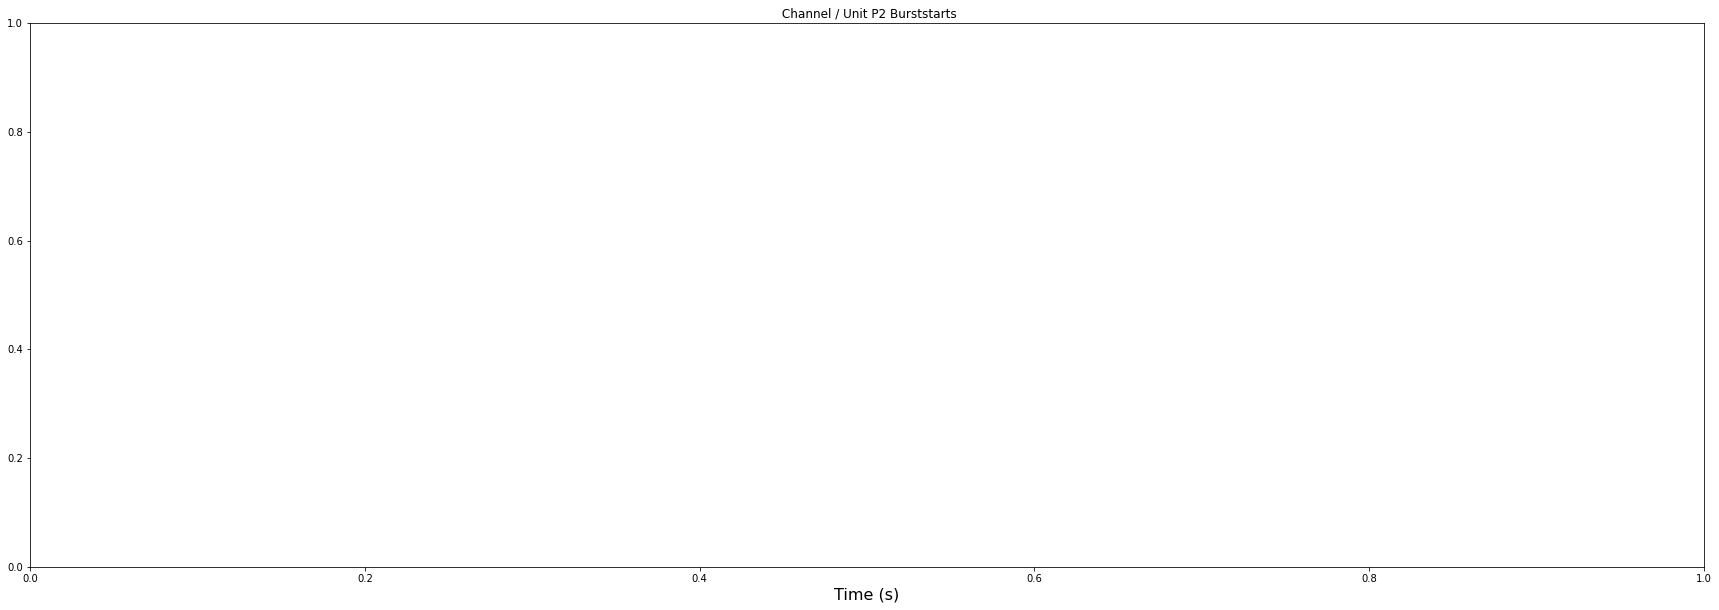

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O3 Burststarts')

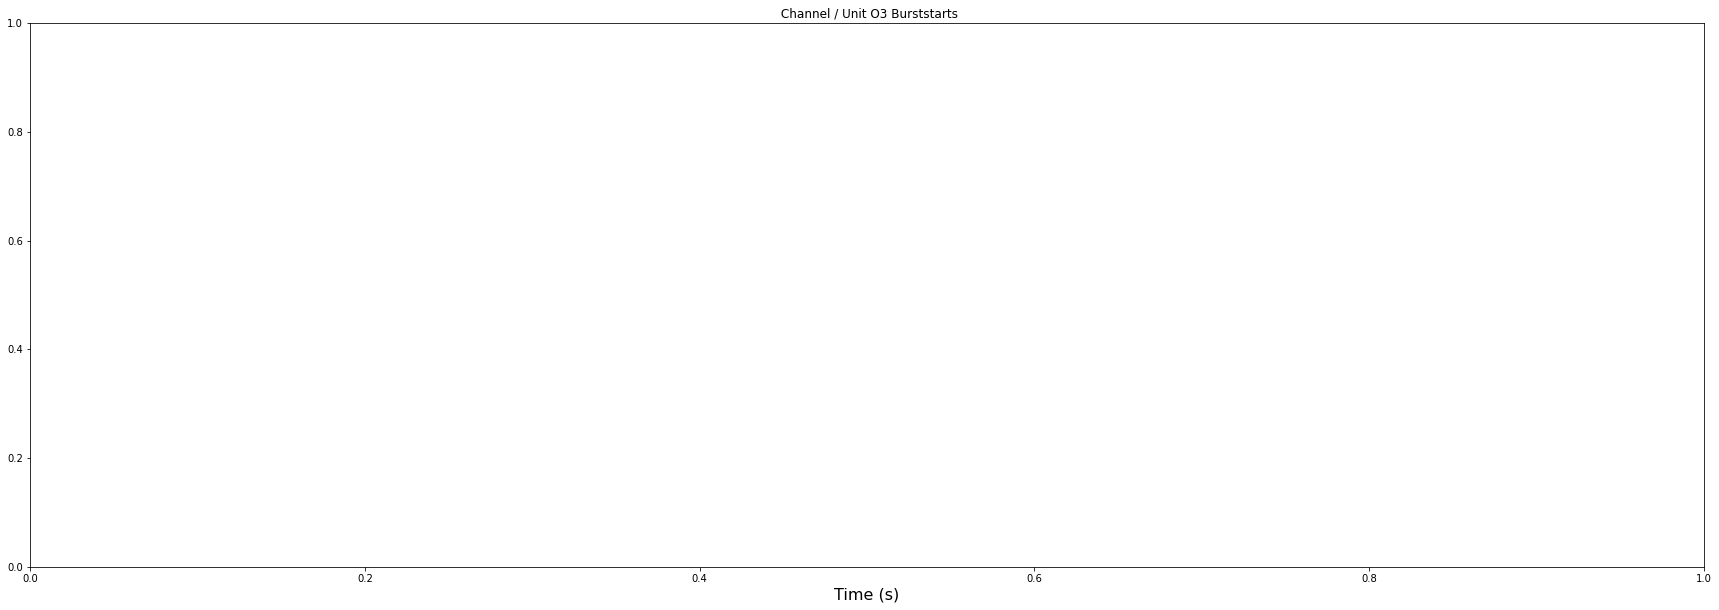

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R2 Burststarts')

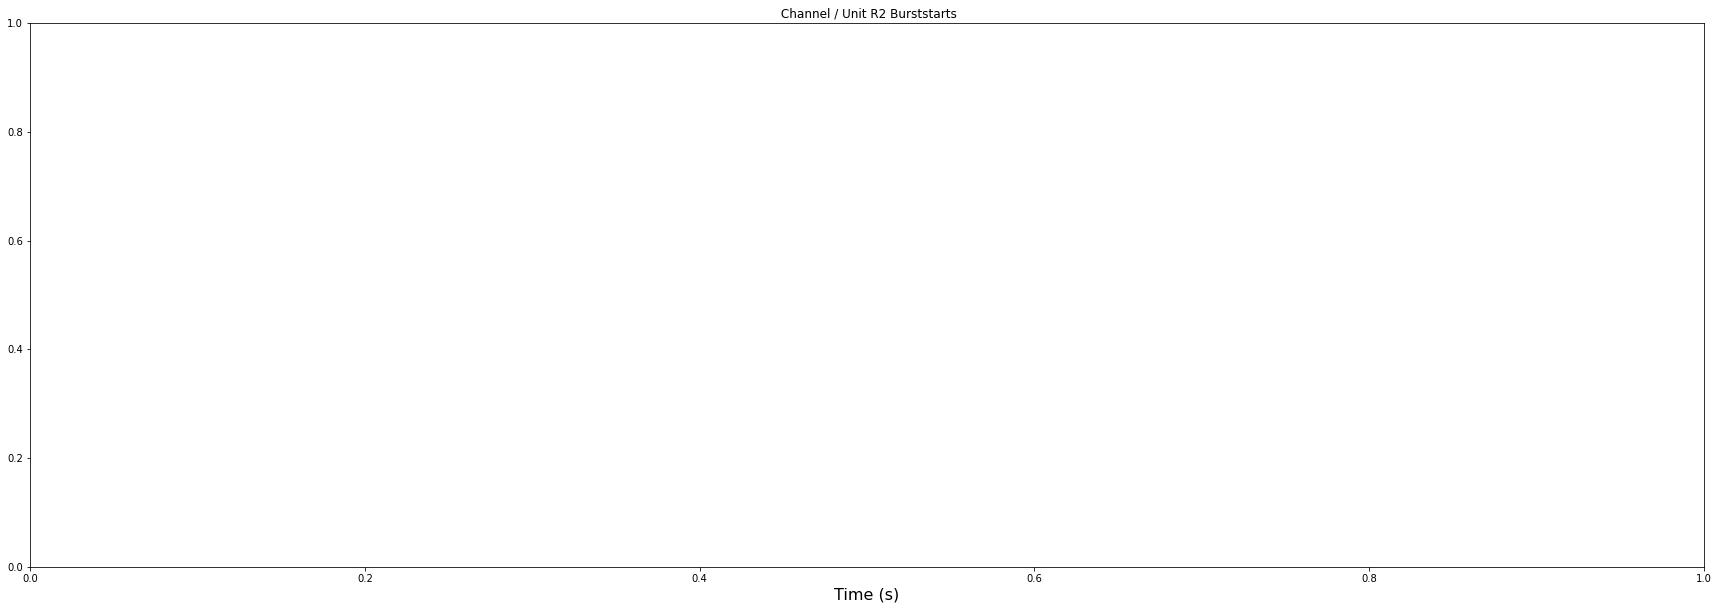

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R3 Burststarts')

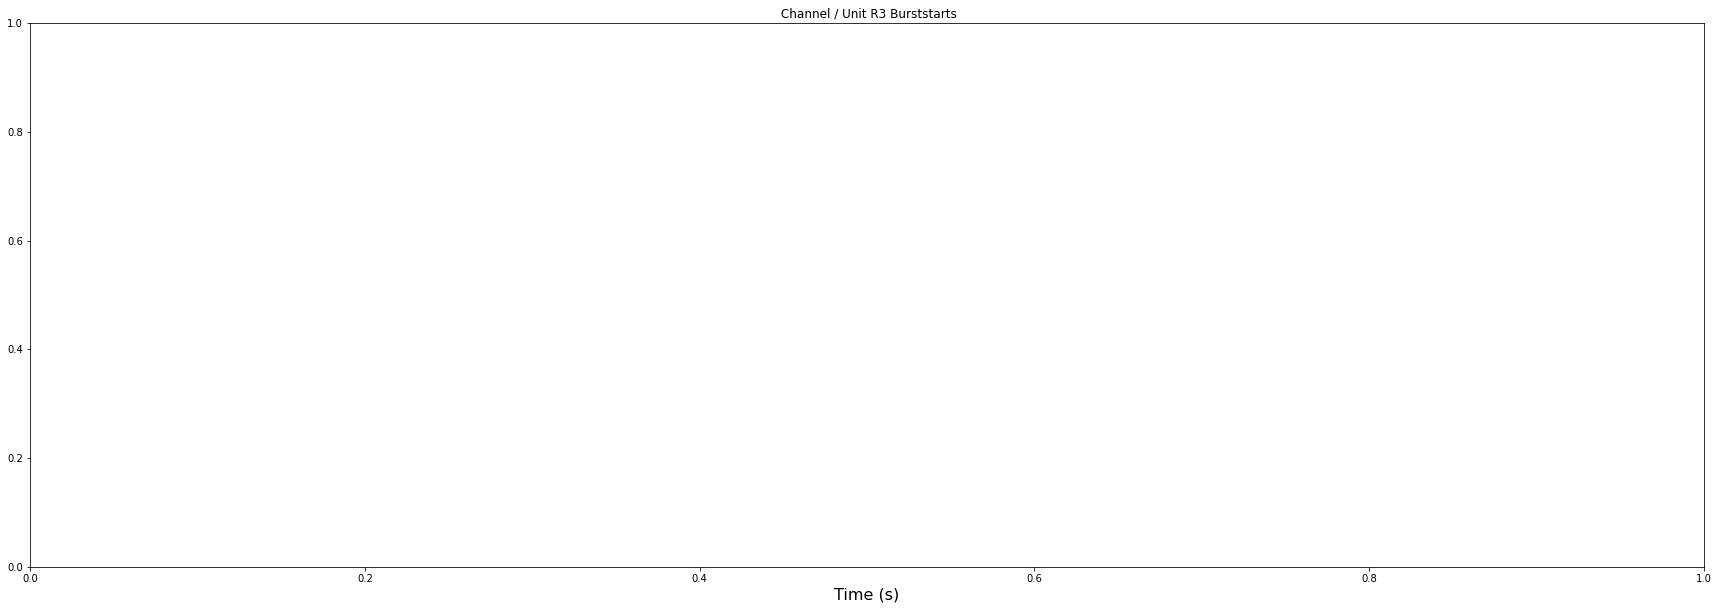

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P3 Burststarts')

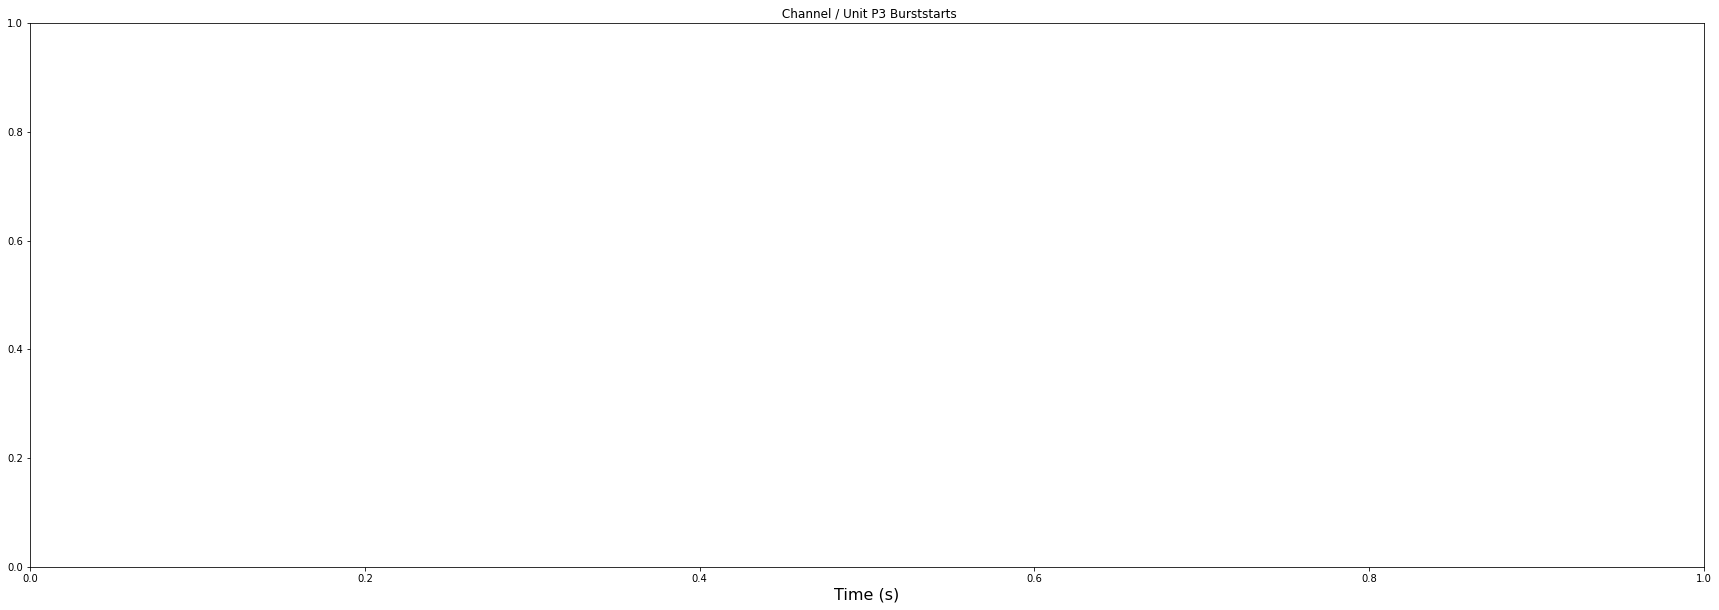

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K7 Burststarts')

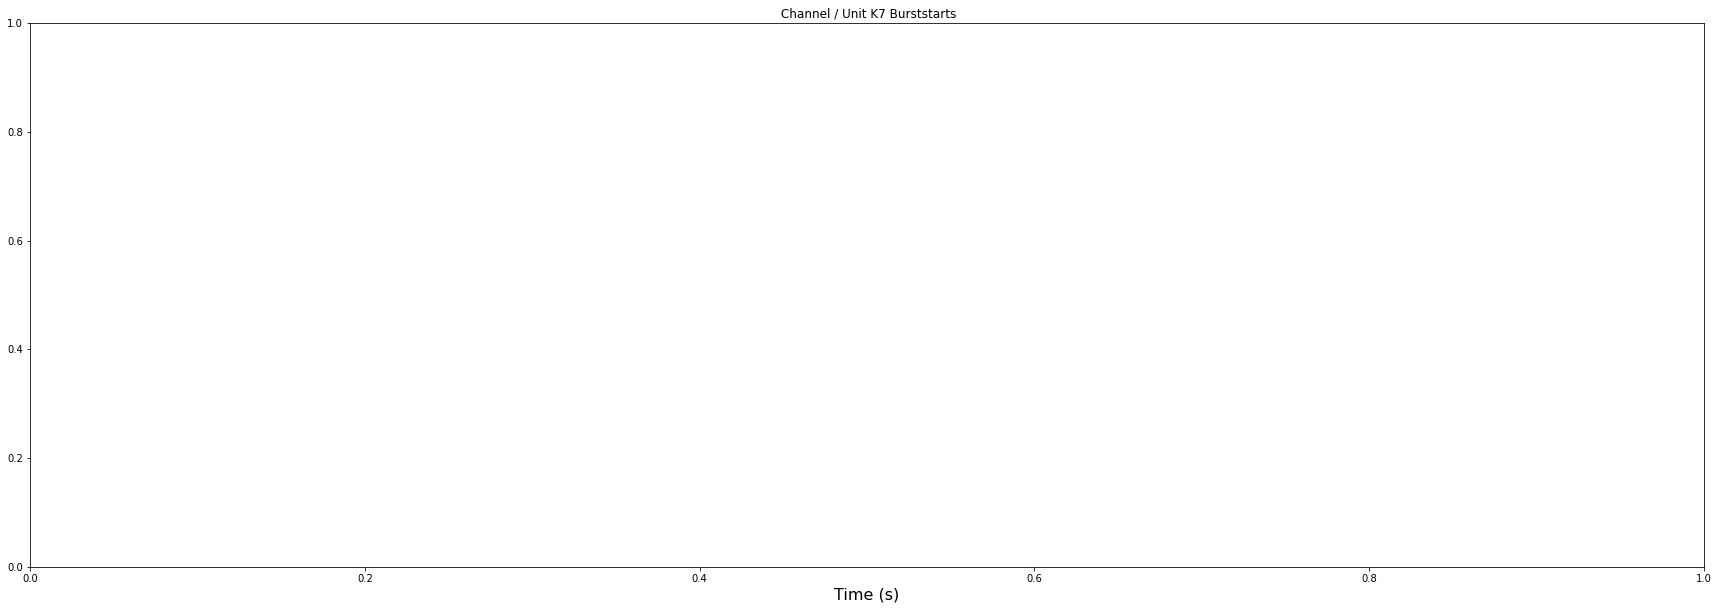

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M5 Burststarts')

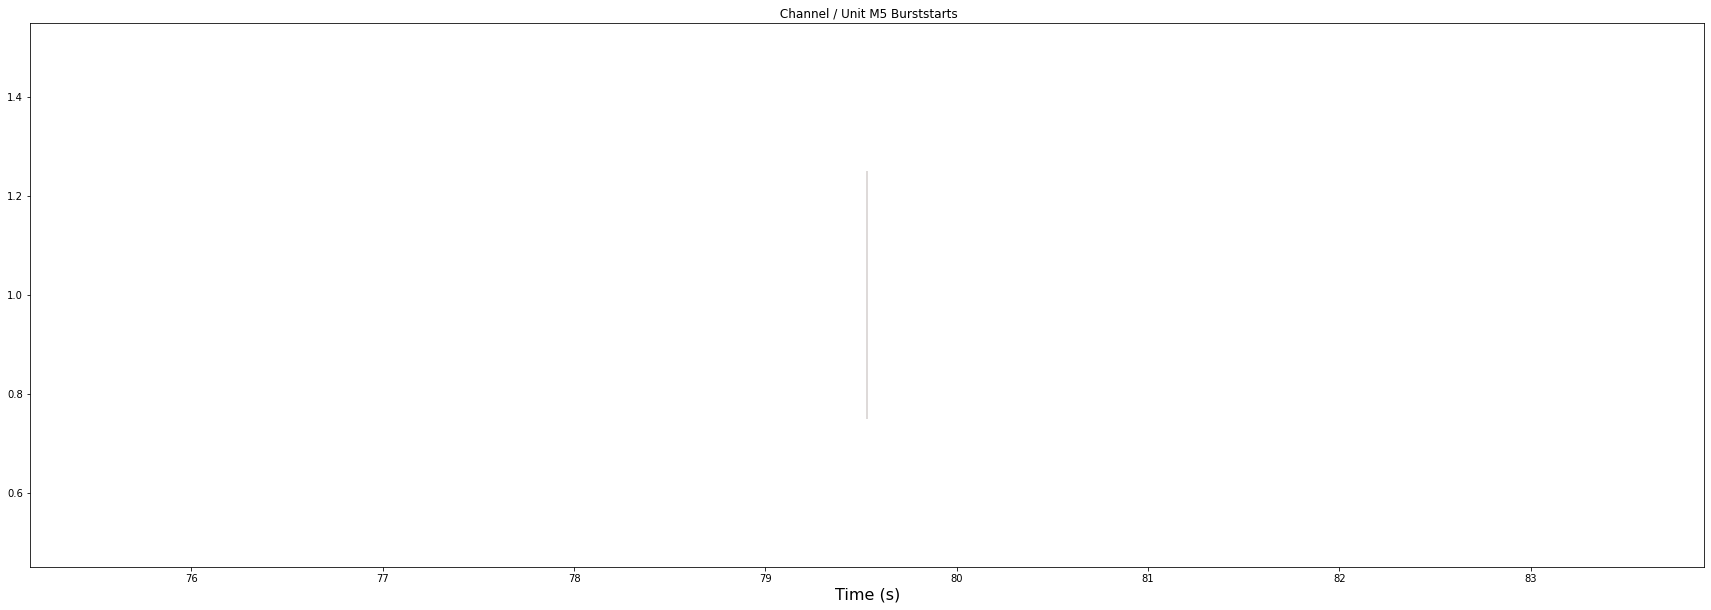

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P4 Burststarts')

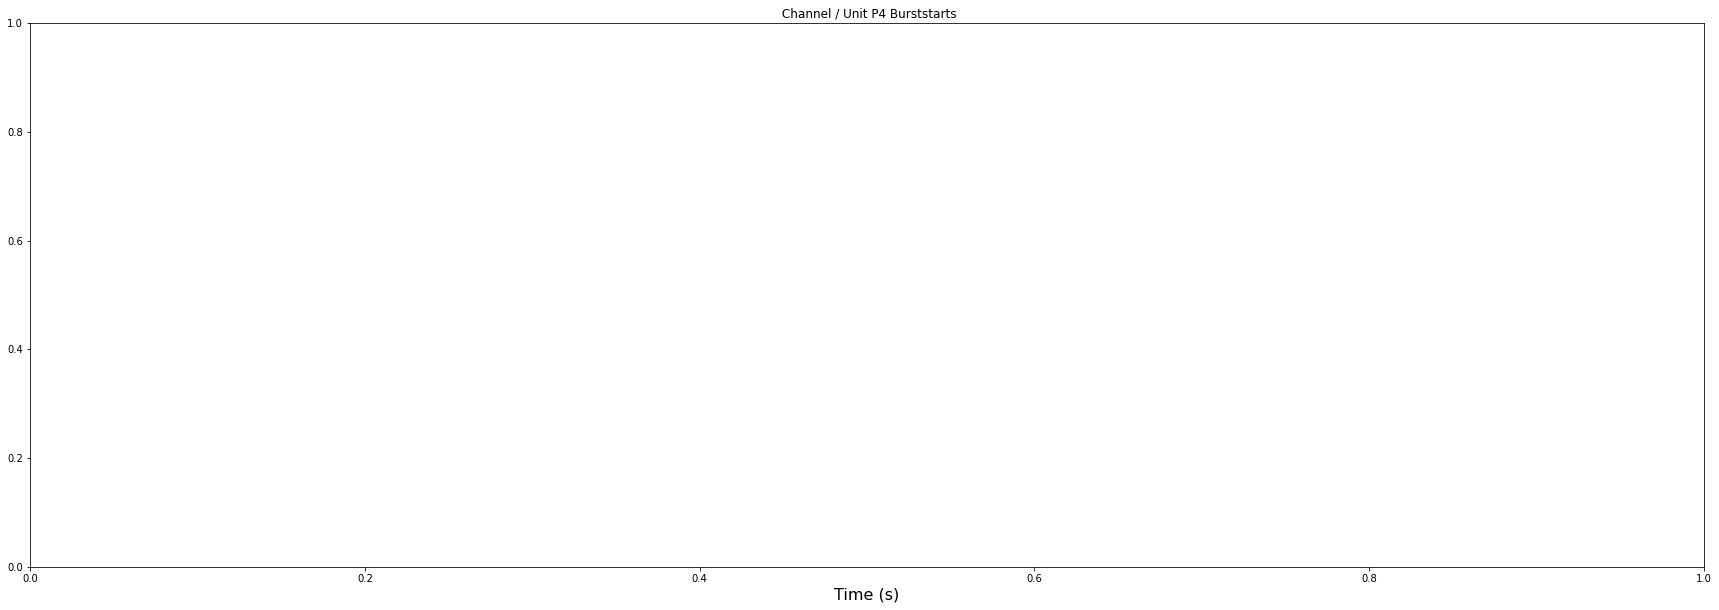

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O4 Burststarts')

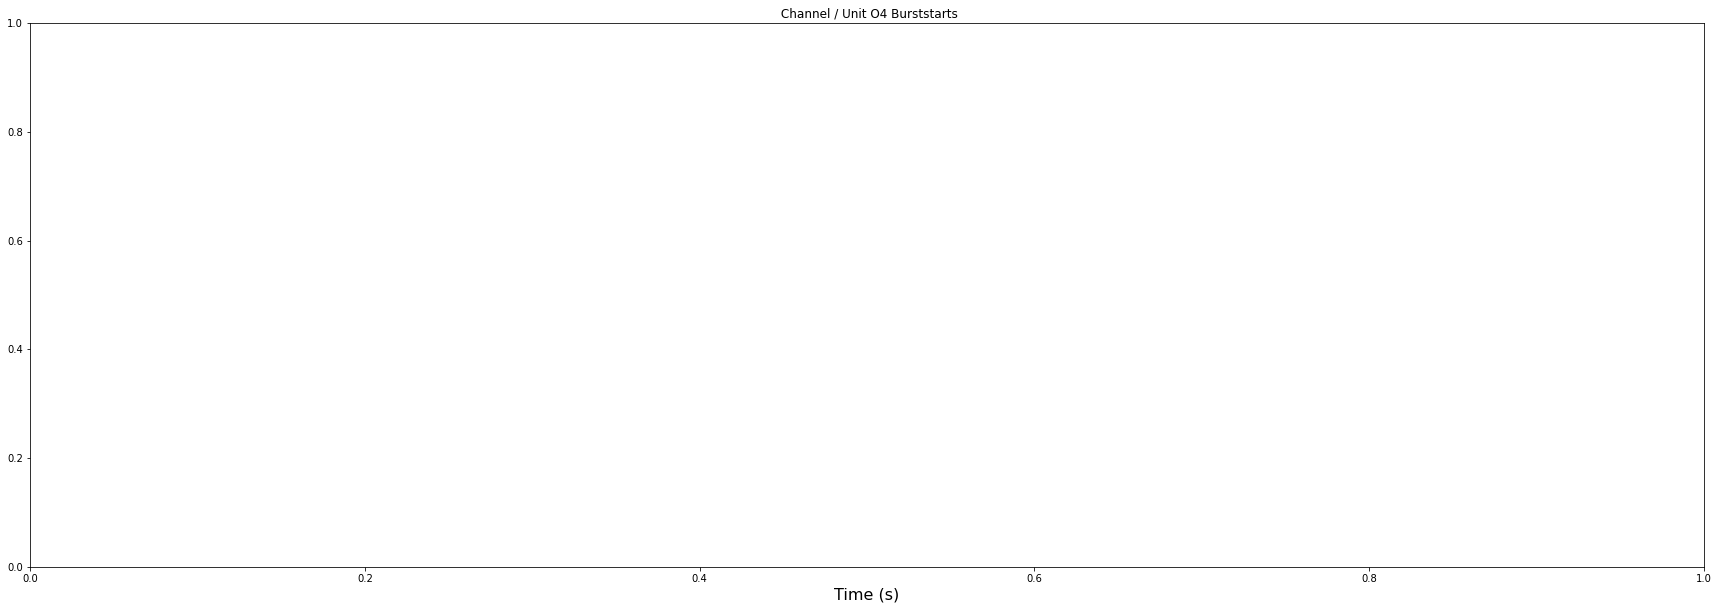

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L7 Burststarts')

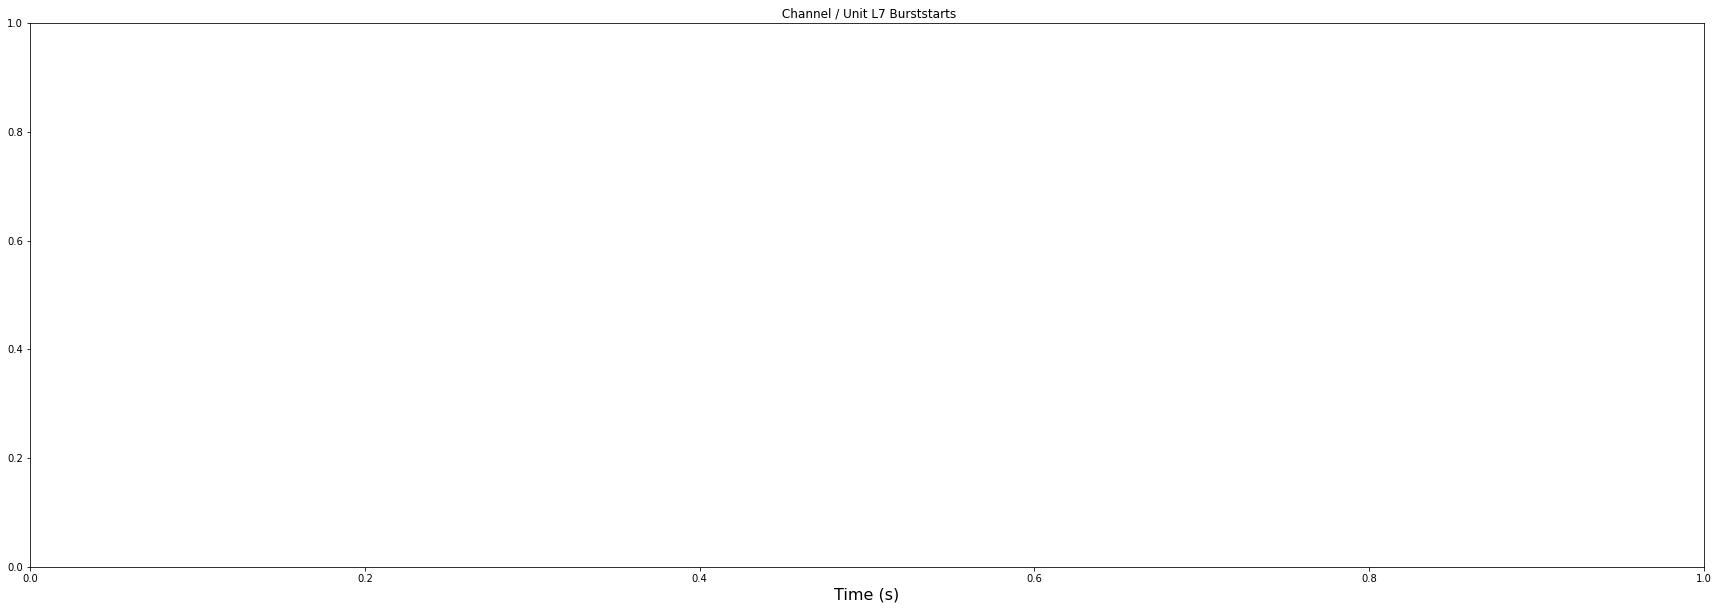

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R4 Burststarts')

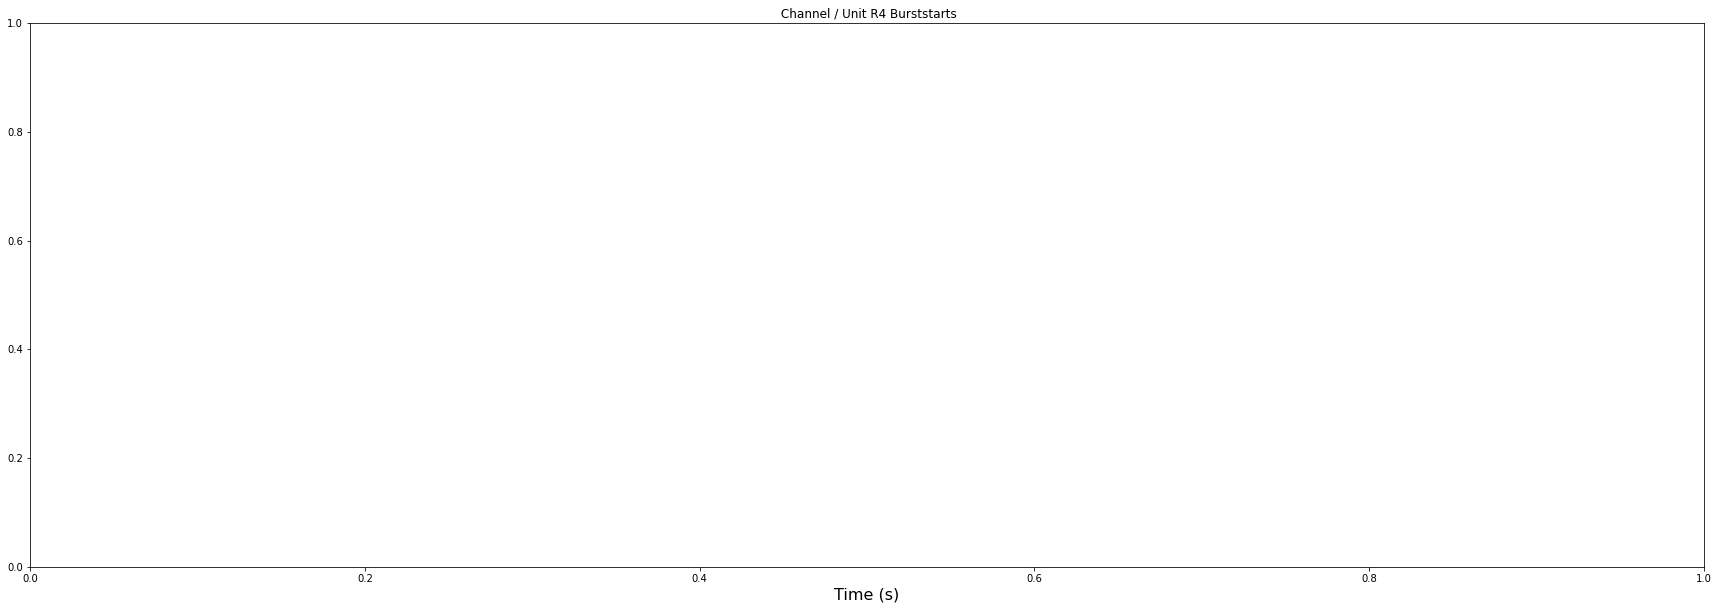

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O5 Burststarts')

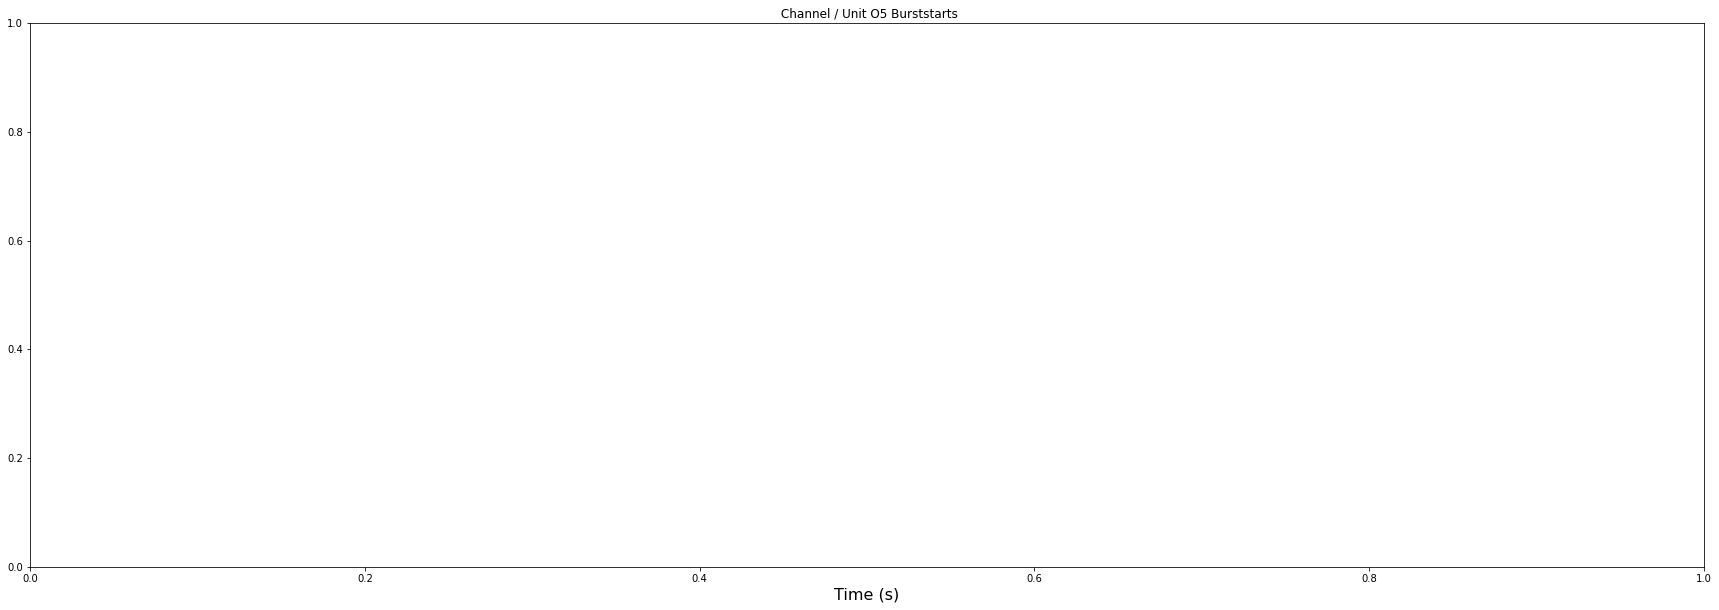

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N5 Burststarts')

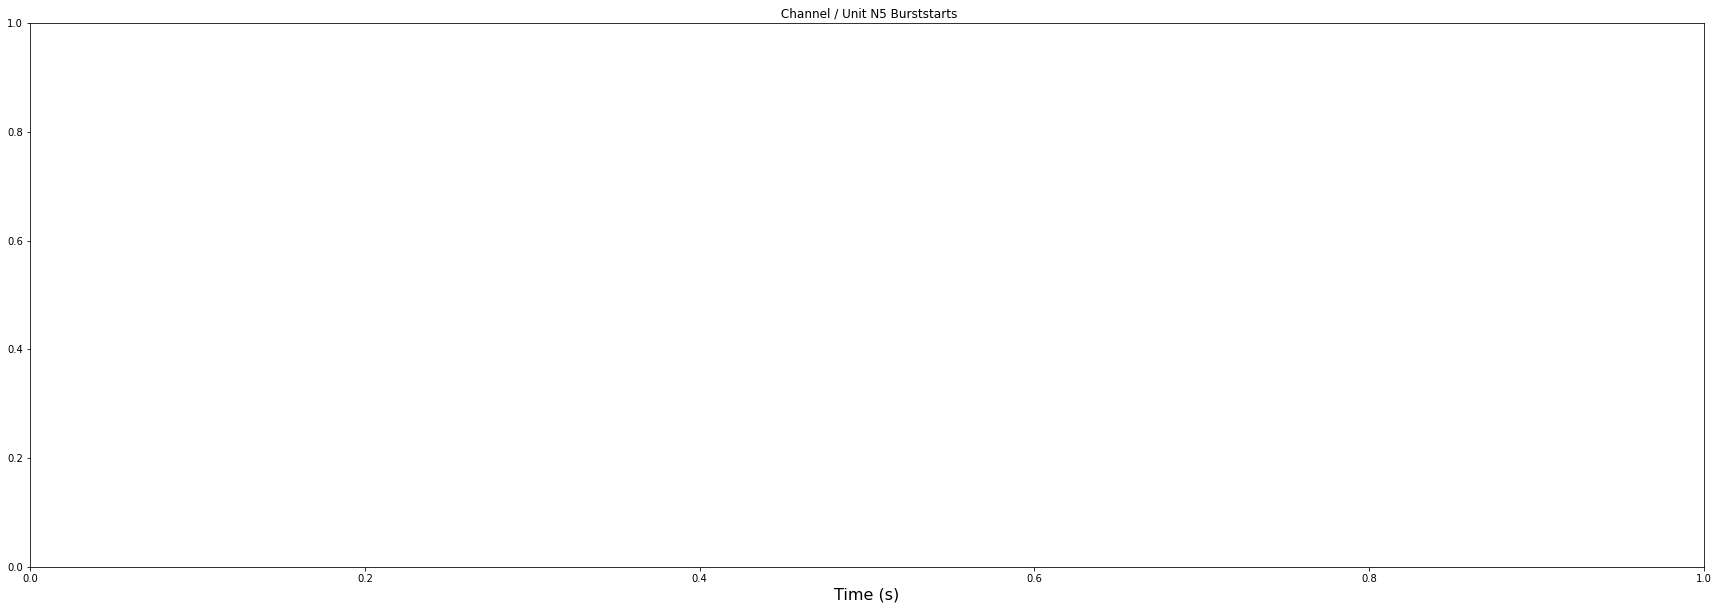

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R5 Burststarts')

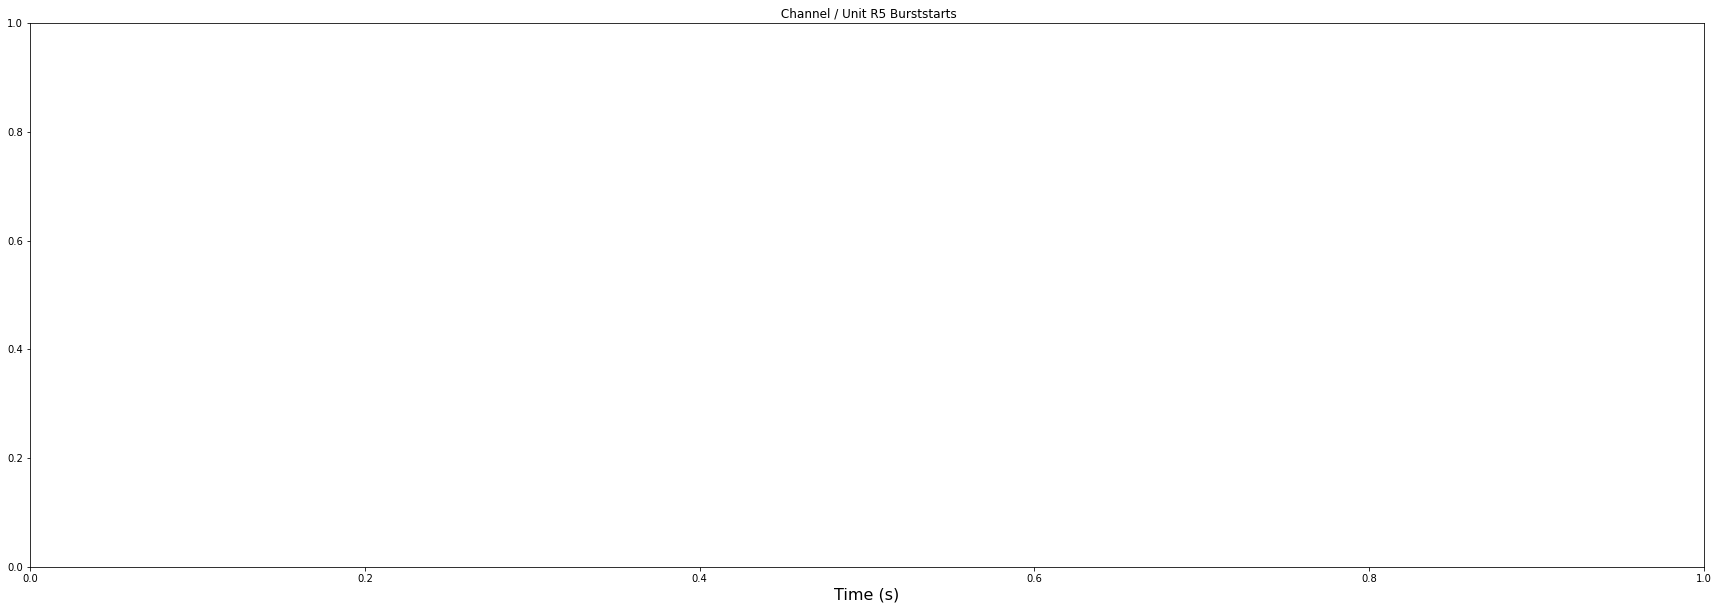

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P5 Burststarts')

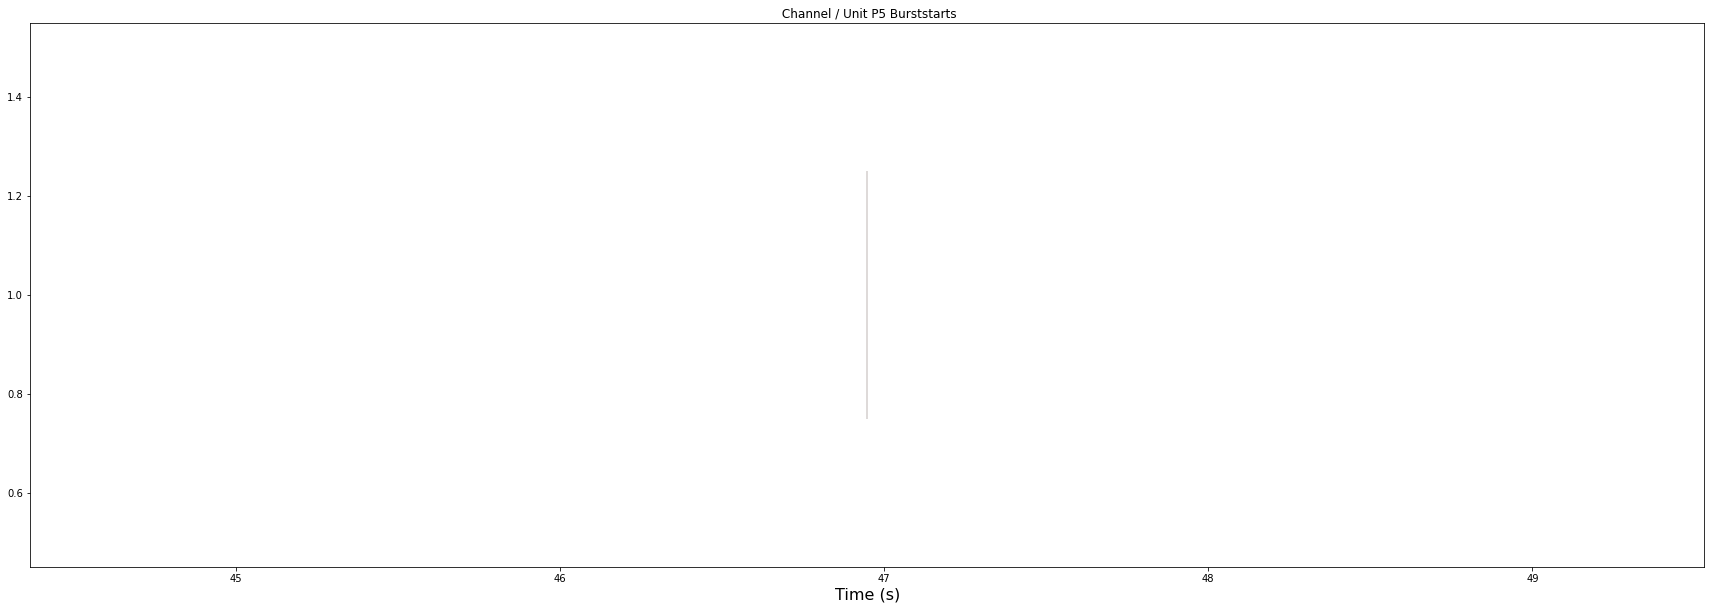

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N6 Burststarts')

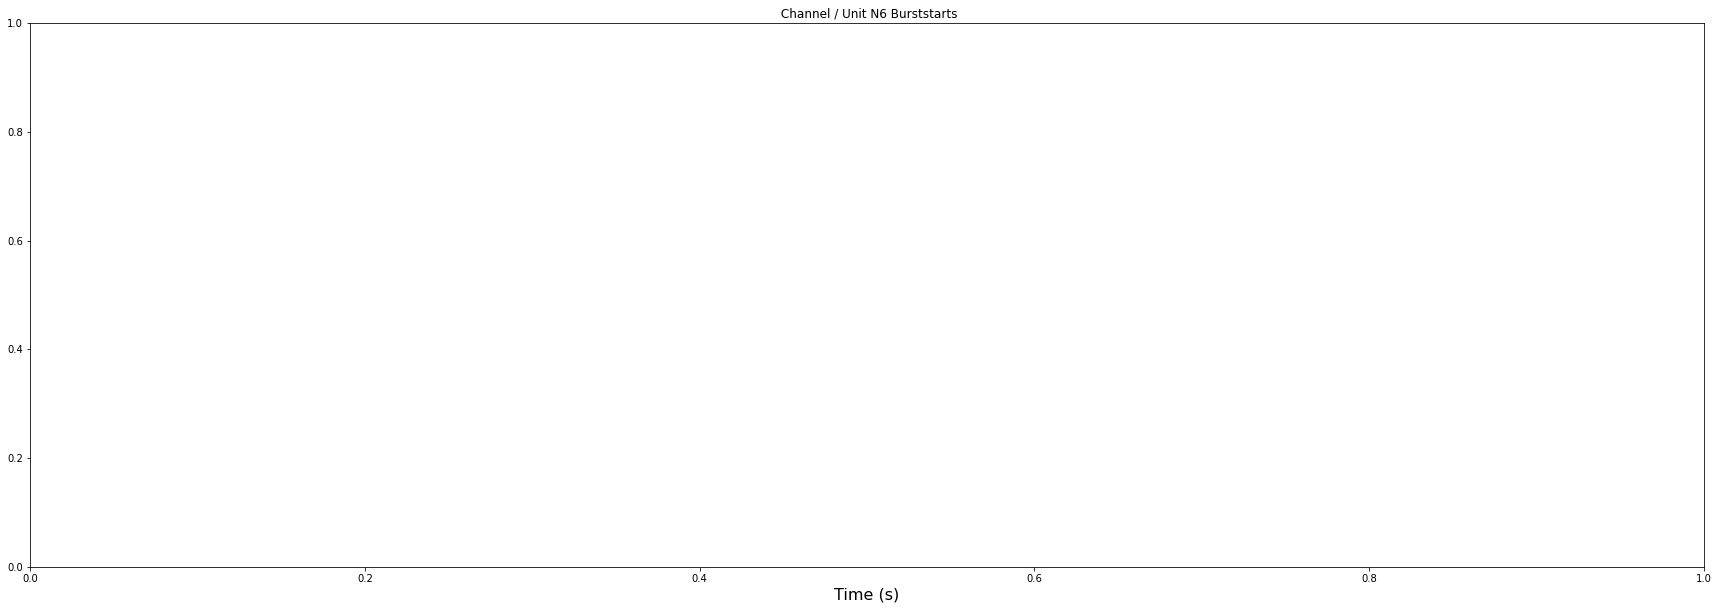

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M6 Burststarts')

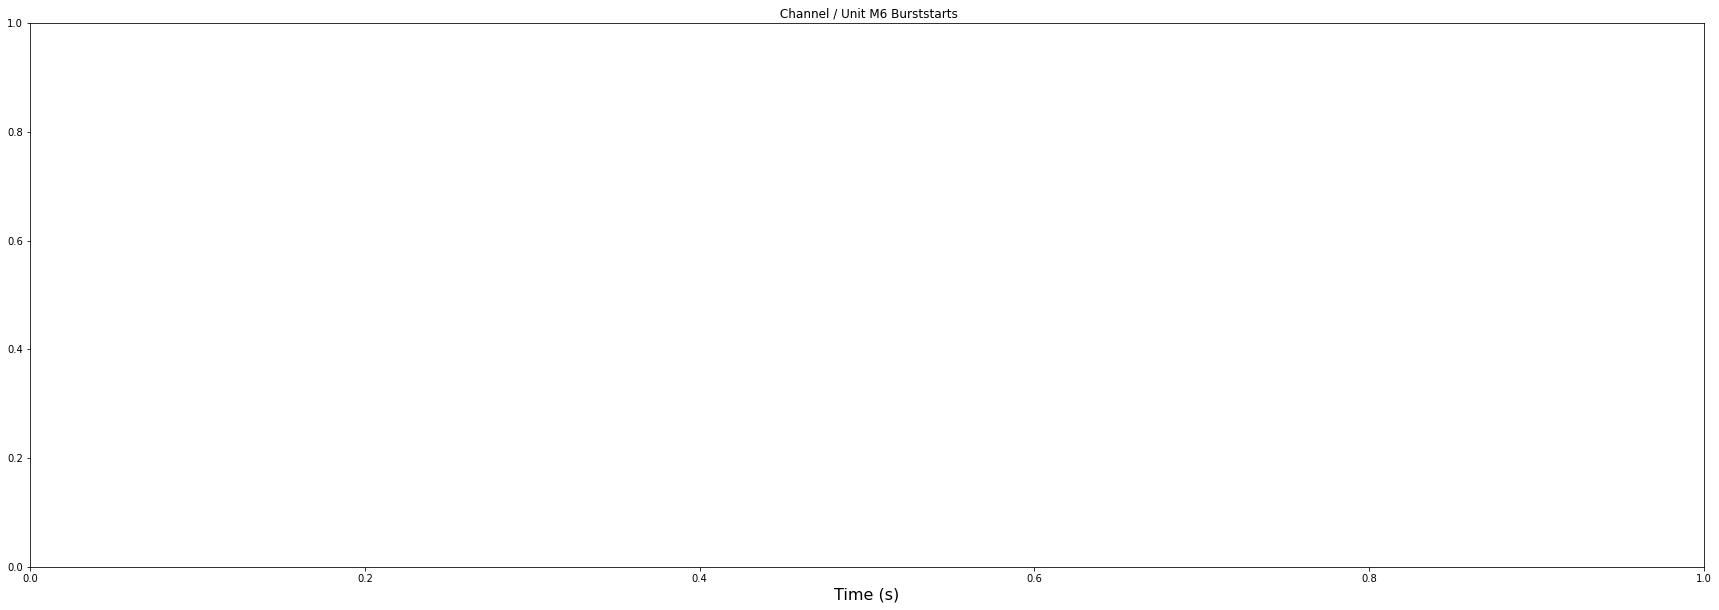

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P6 Burststarts')

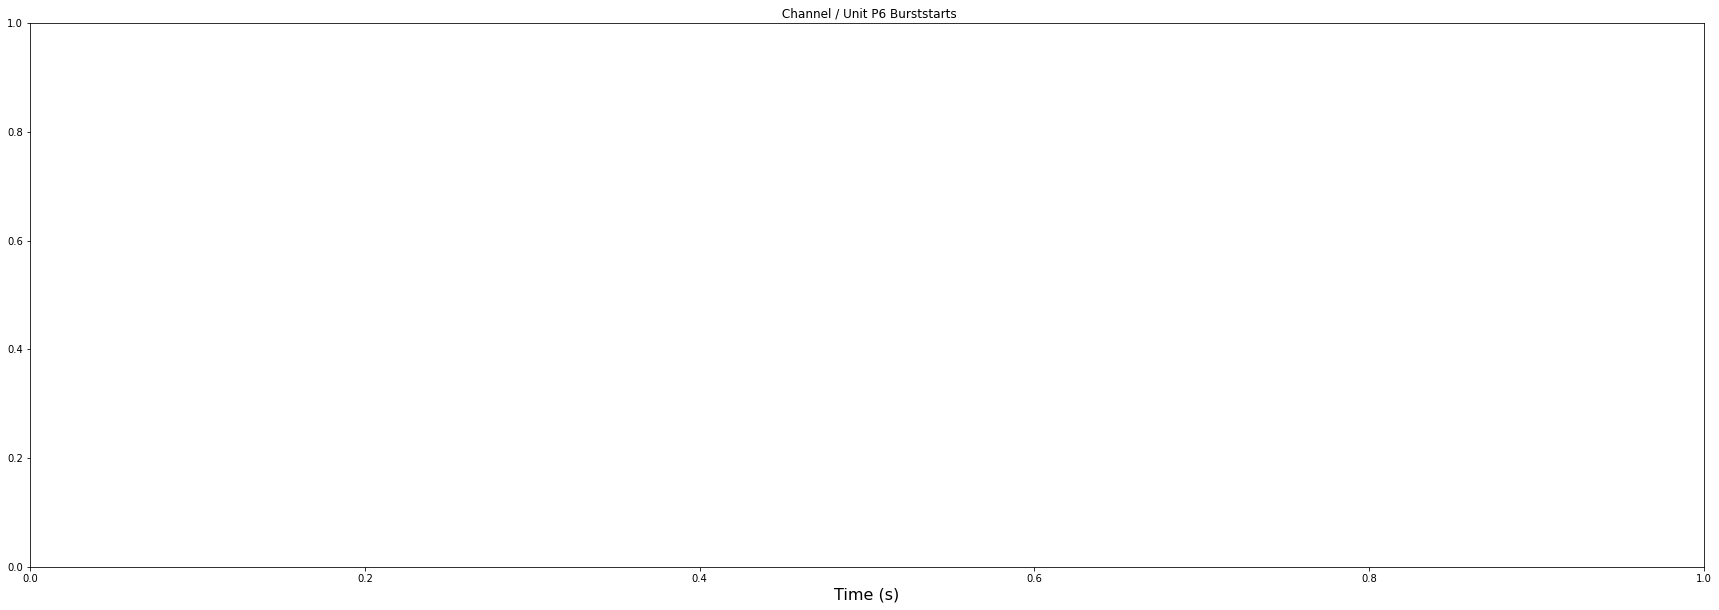

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O6 Burststarts')

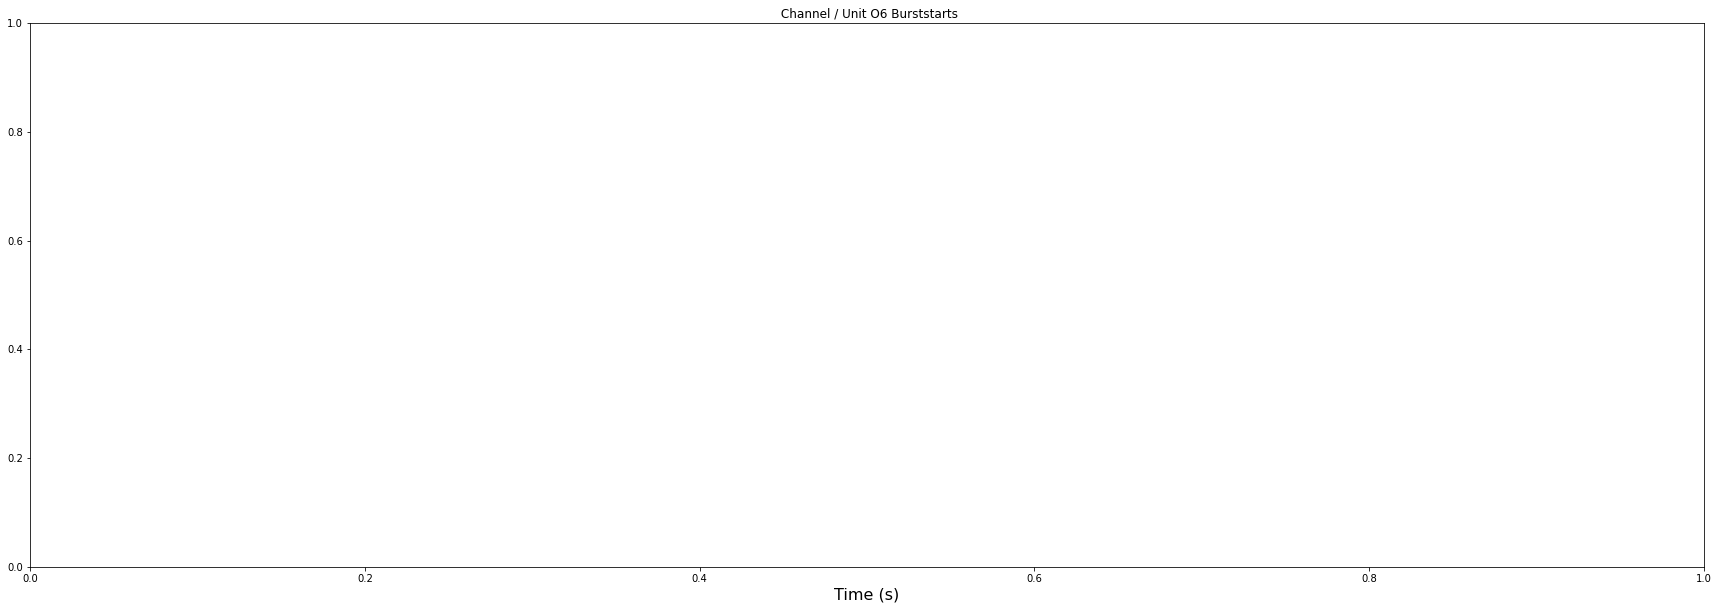

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M7 Burststarts')

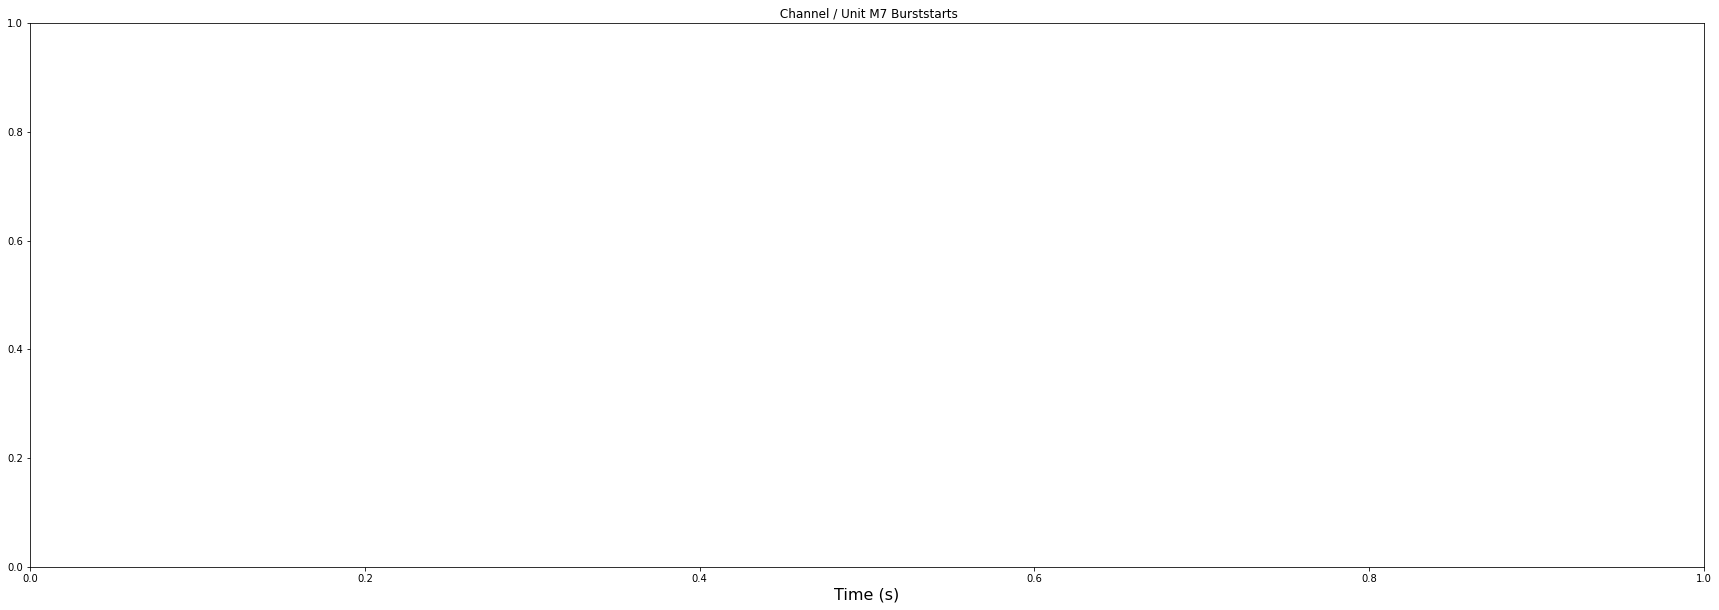

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R6 Burststarts')

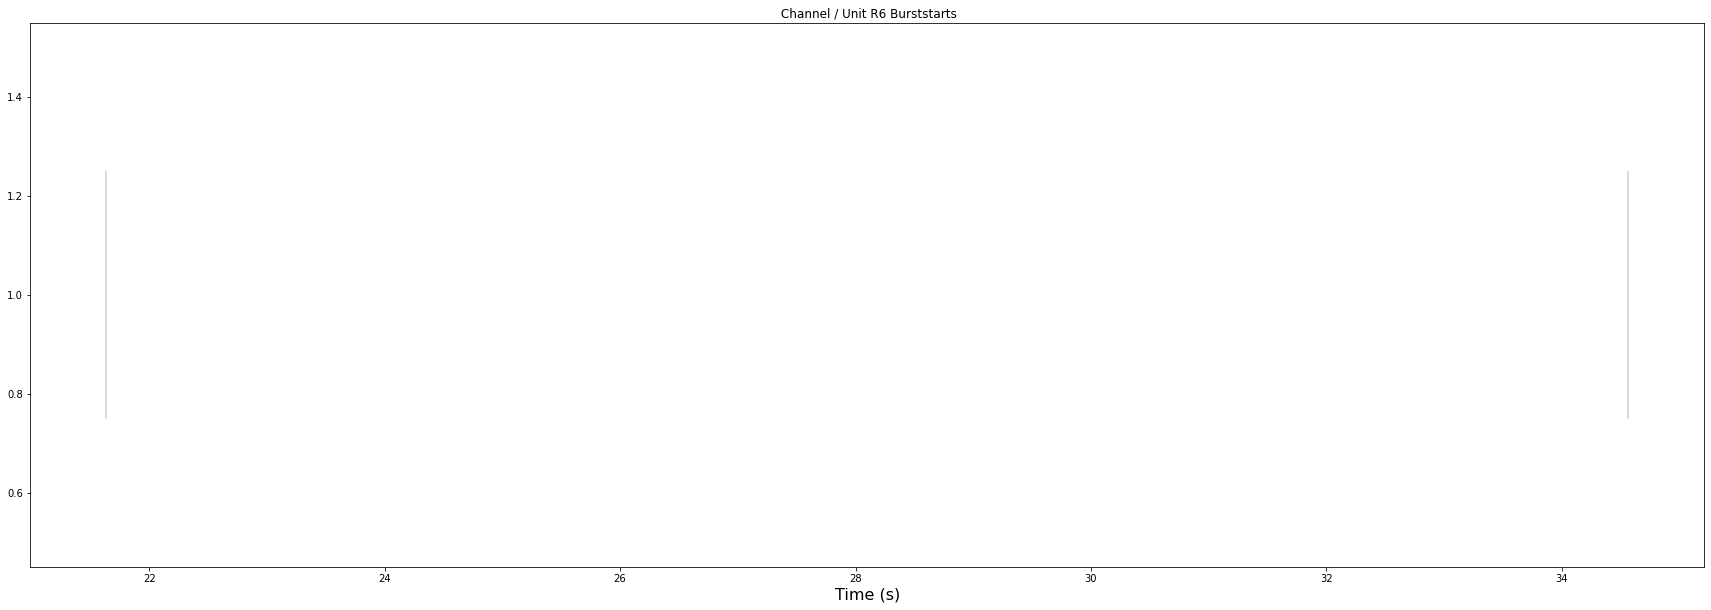

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O7 Burststarts')

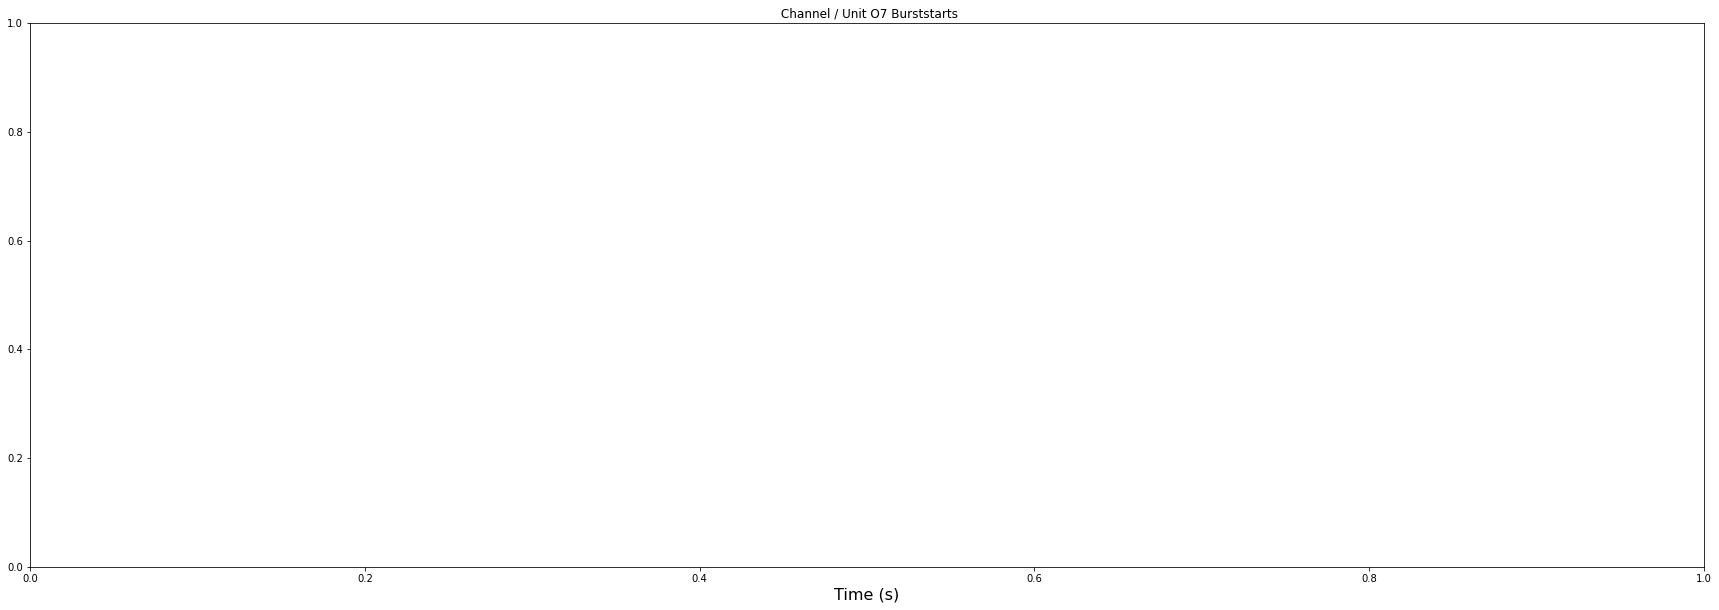

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N7 Burststarts')

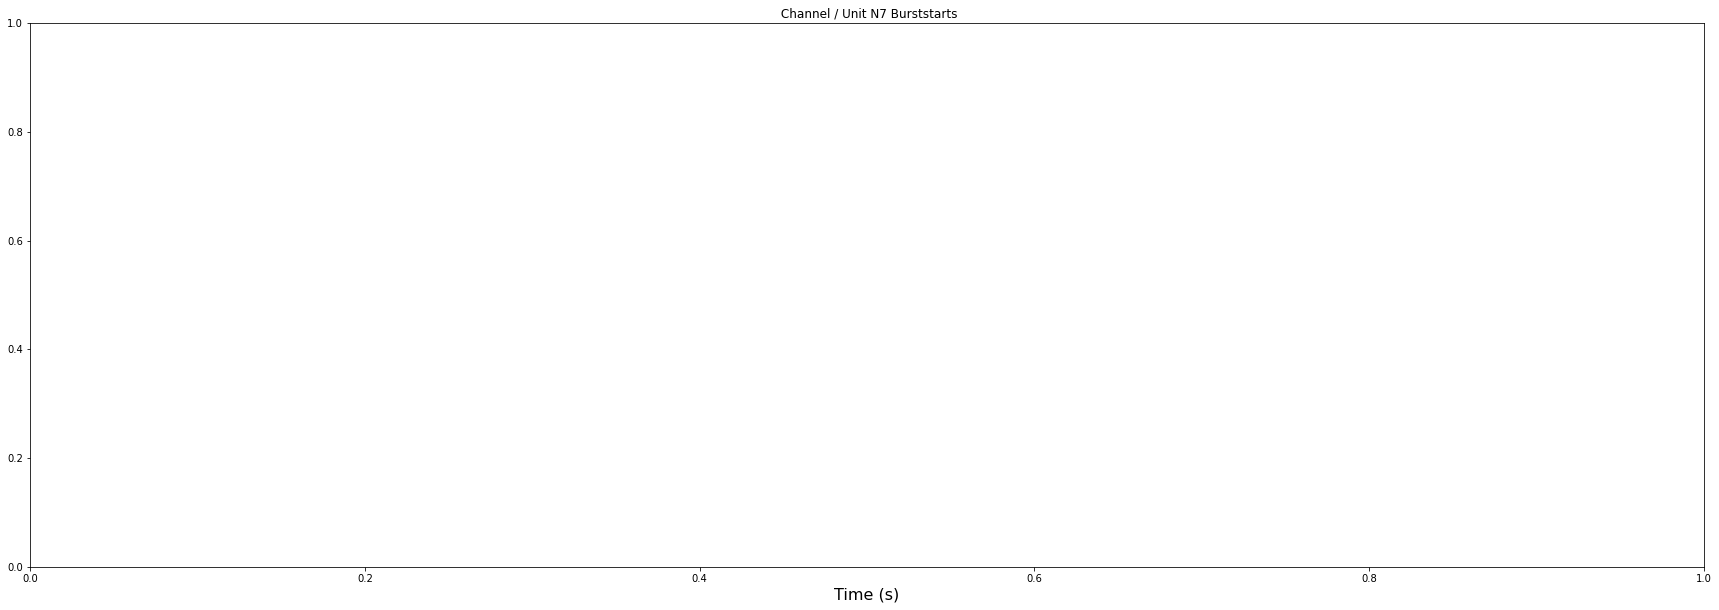

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R7 Burststarts')

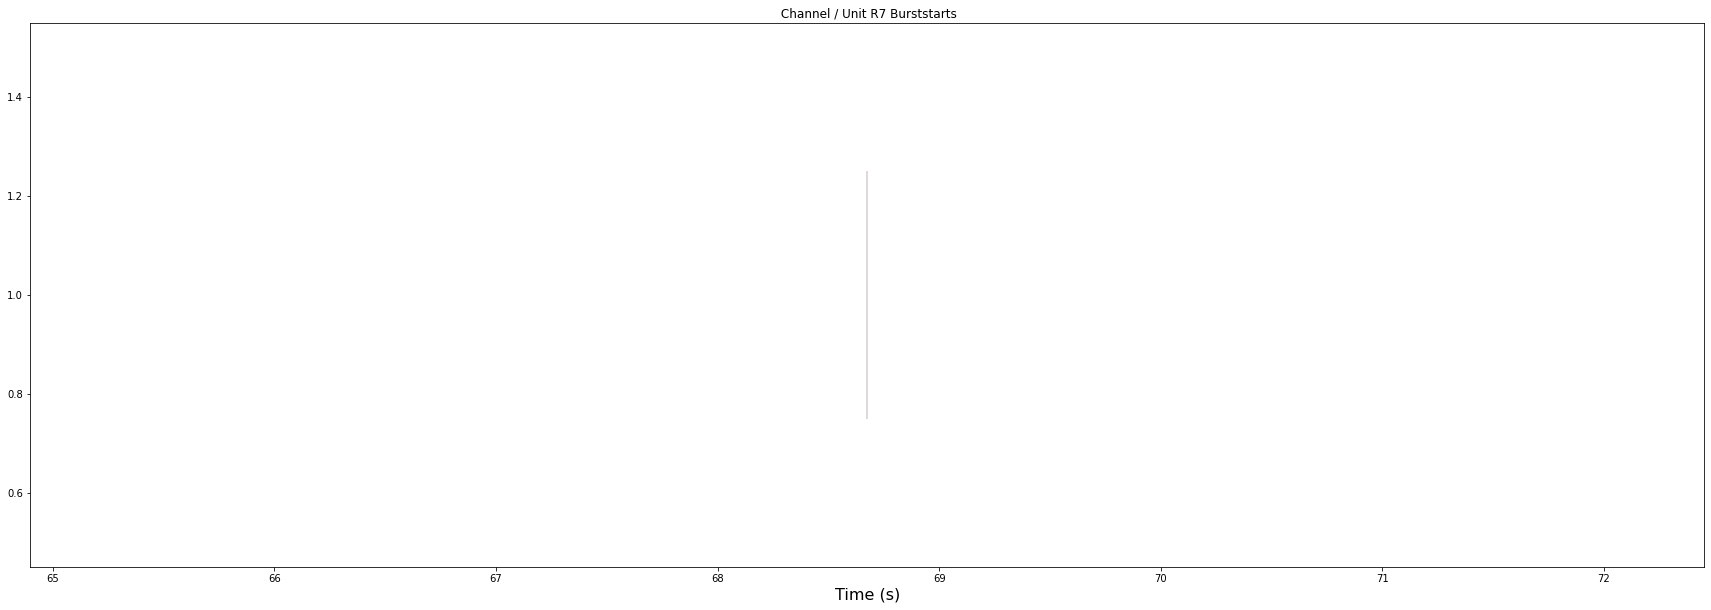

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P7 Burststarts')

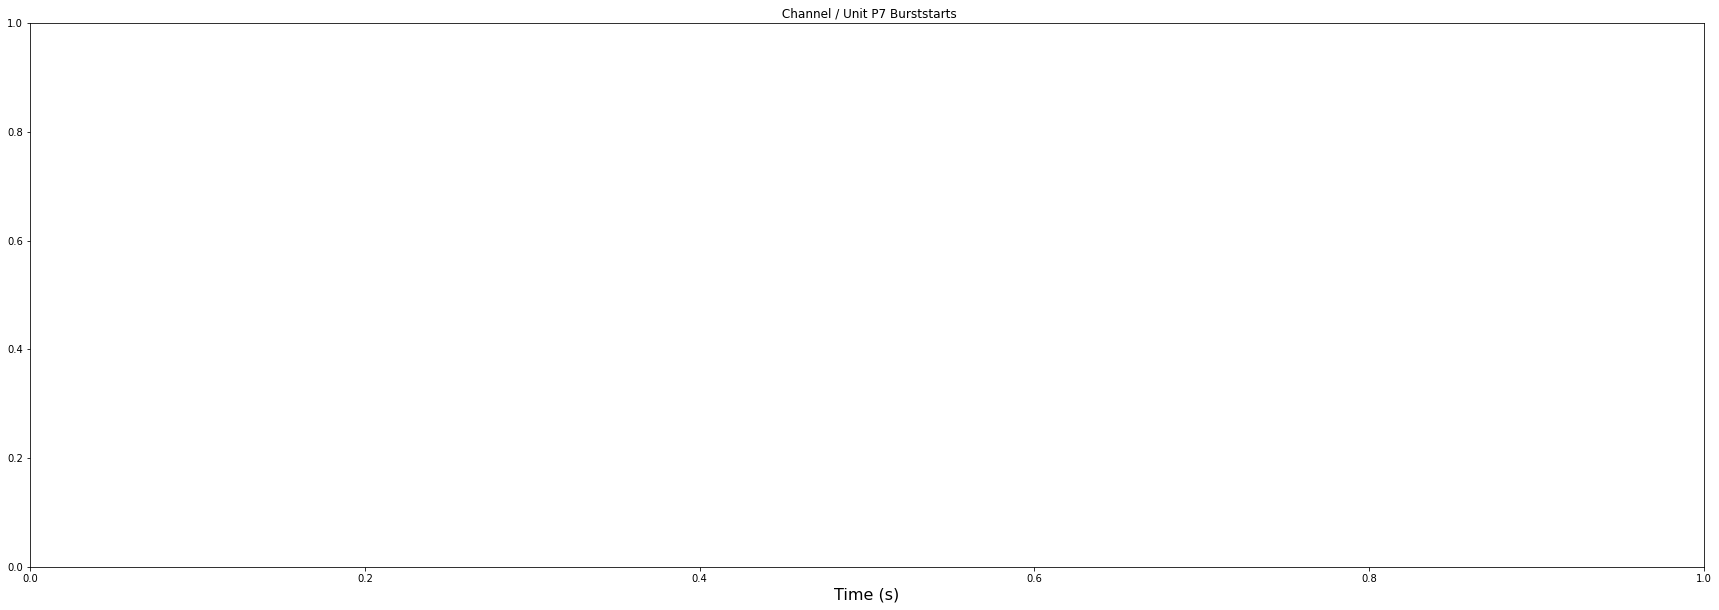

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N8 Burststarts')

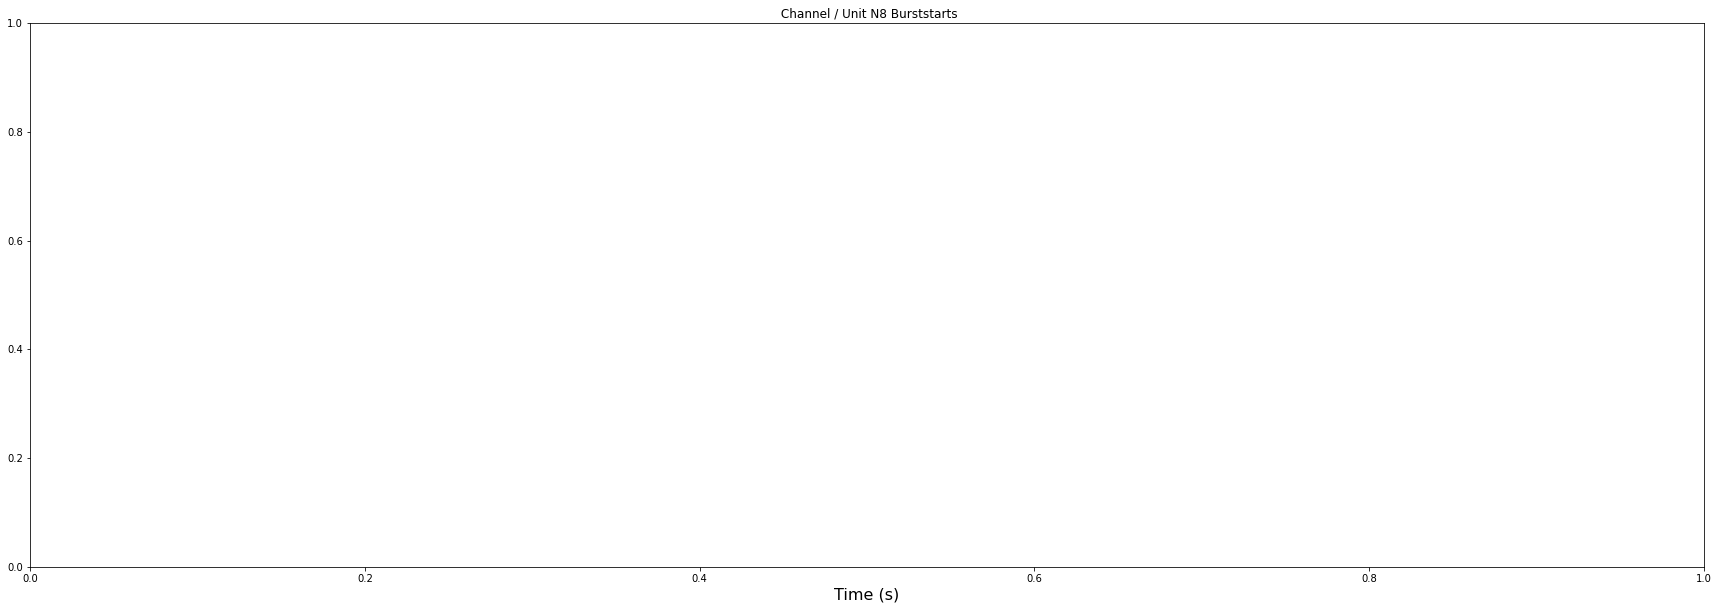

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M8 Burststarts')

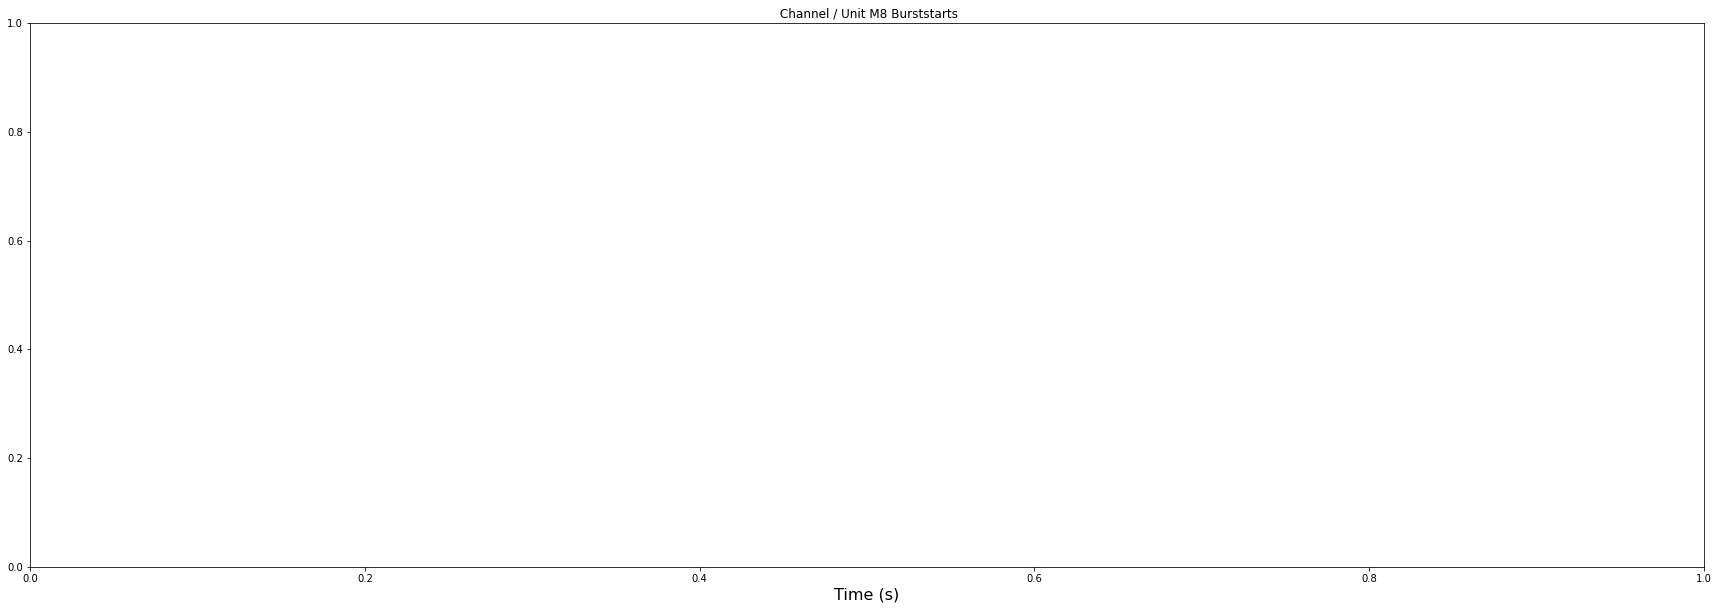

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P8 Burststarts')

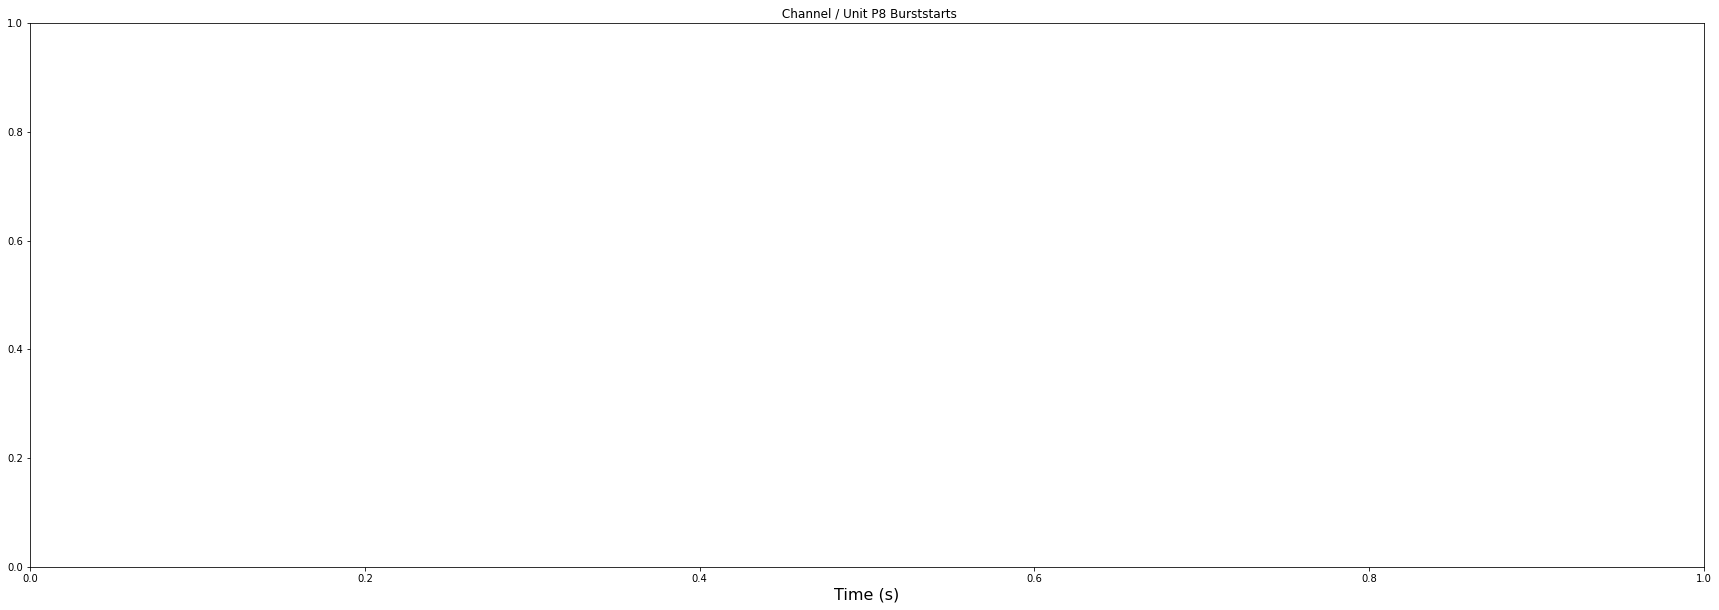

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O8 Burststarts')

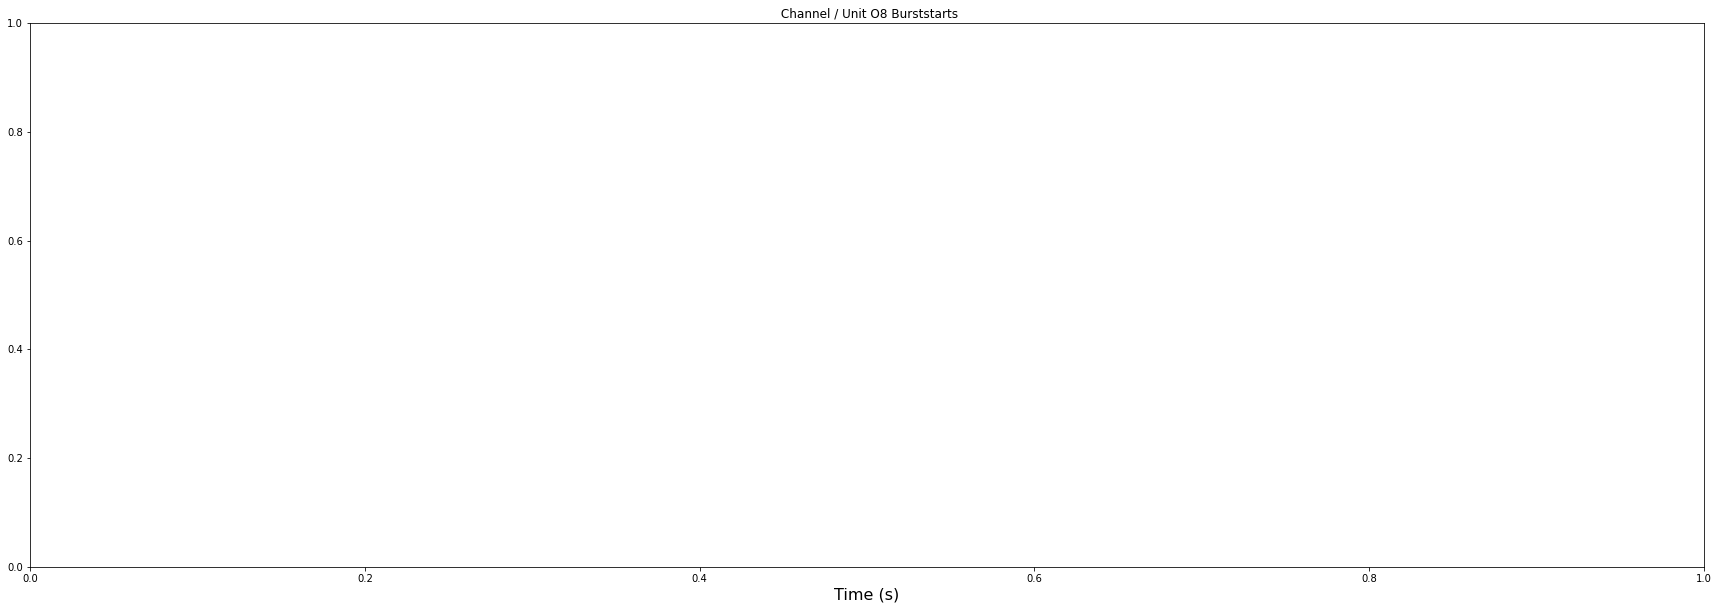

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L8 Burststarts')

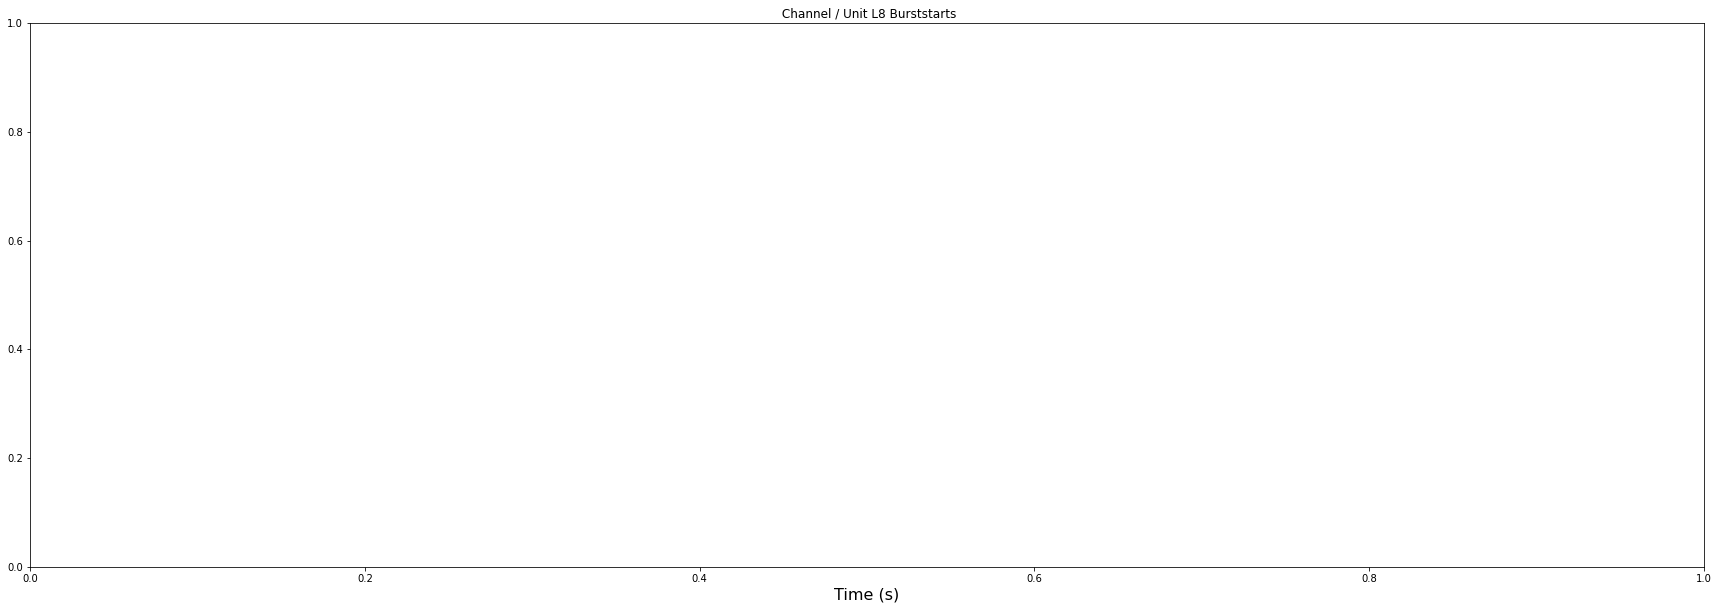

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R8 Burststarts')

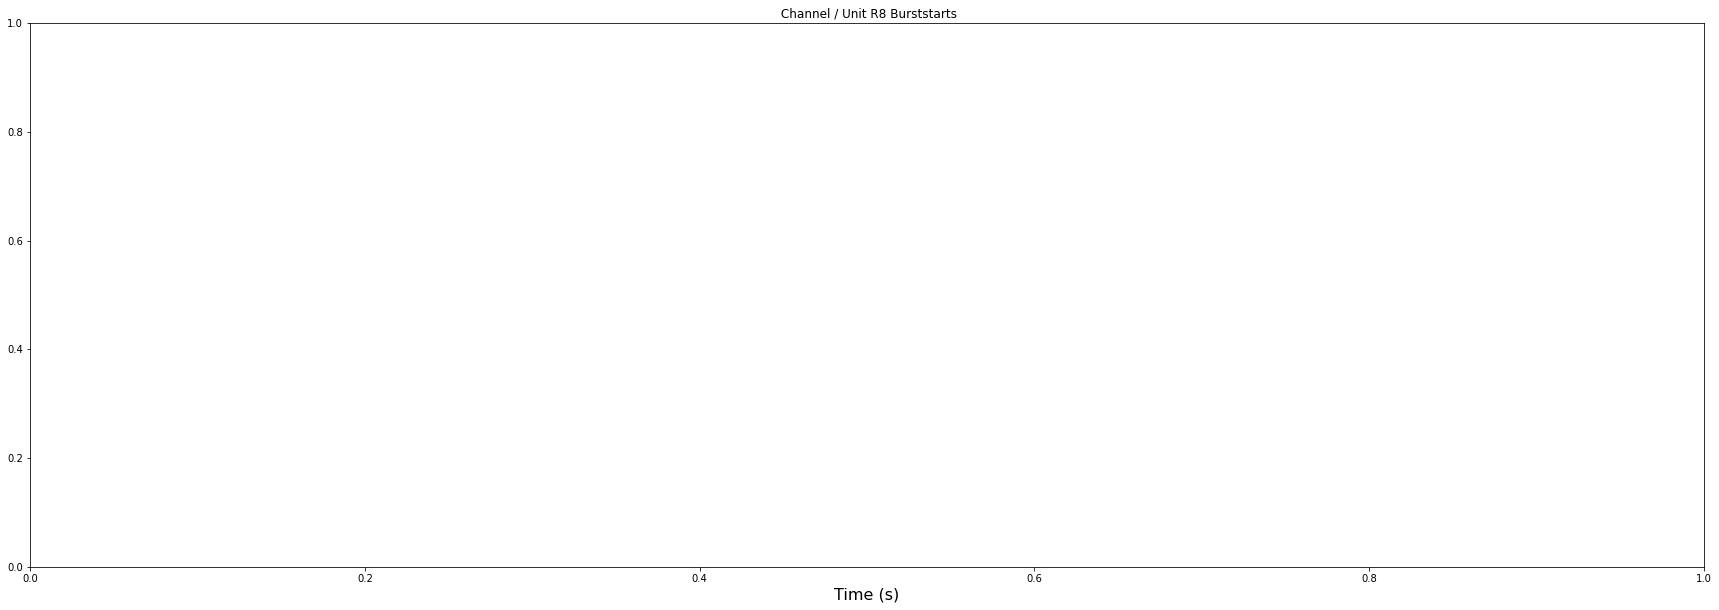

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K9 Burststarts')

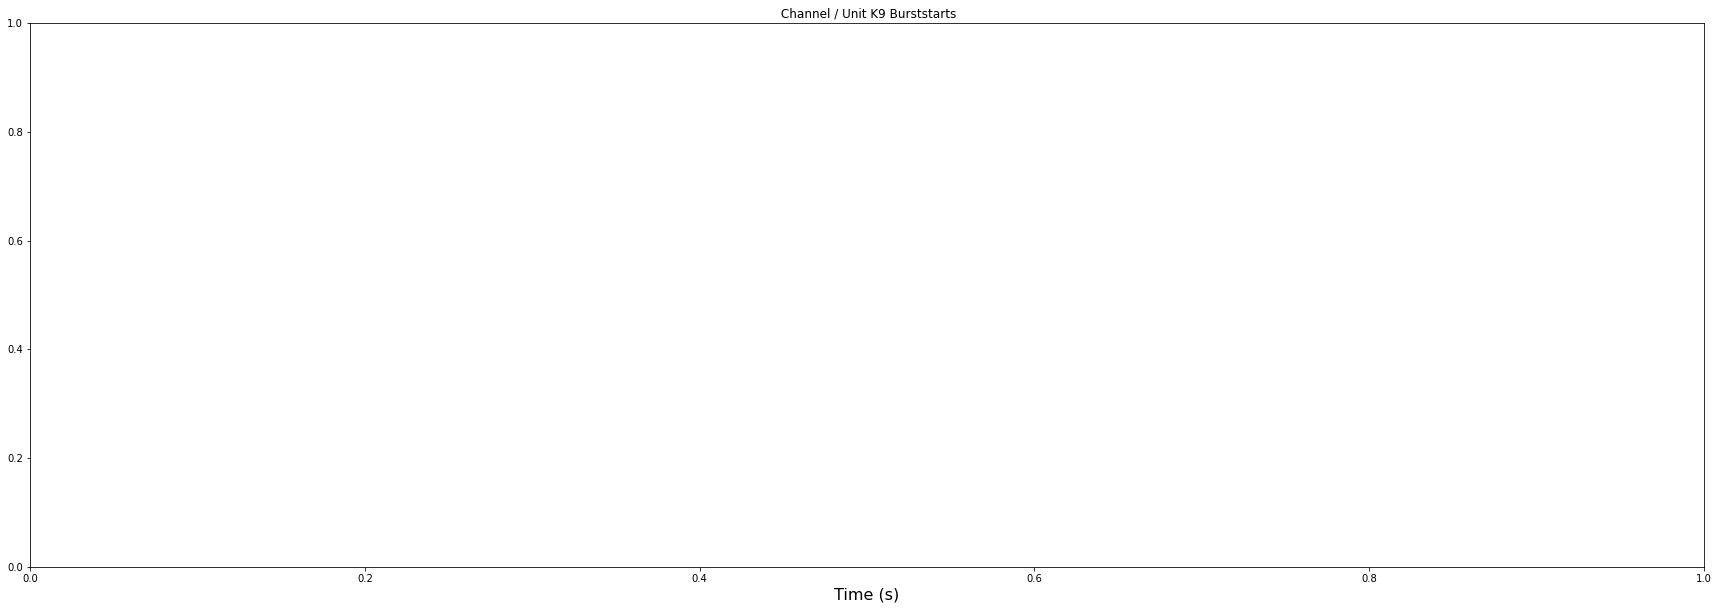

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K8 Burststarts')

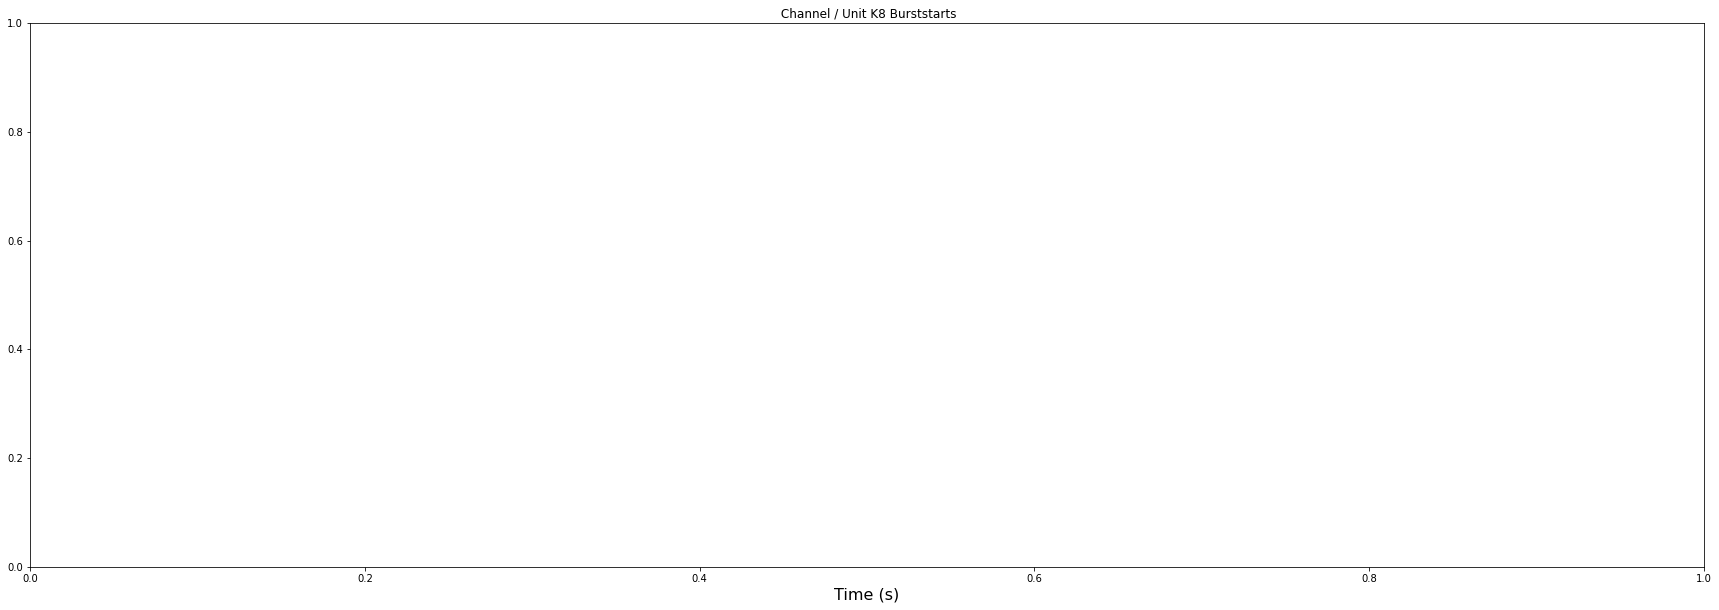

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R9 Burststarts')

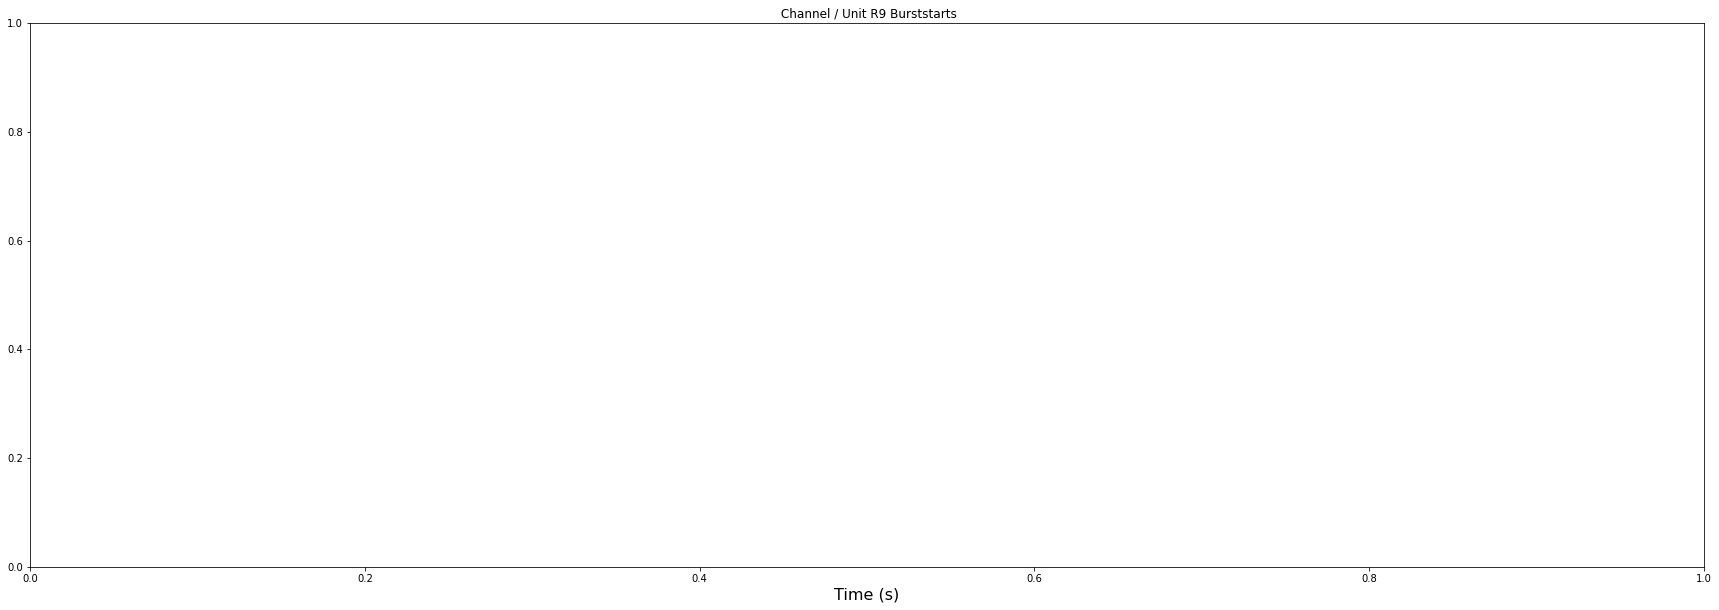

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L9 Burststarts')

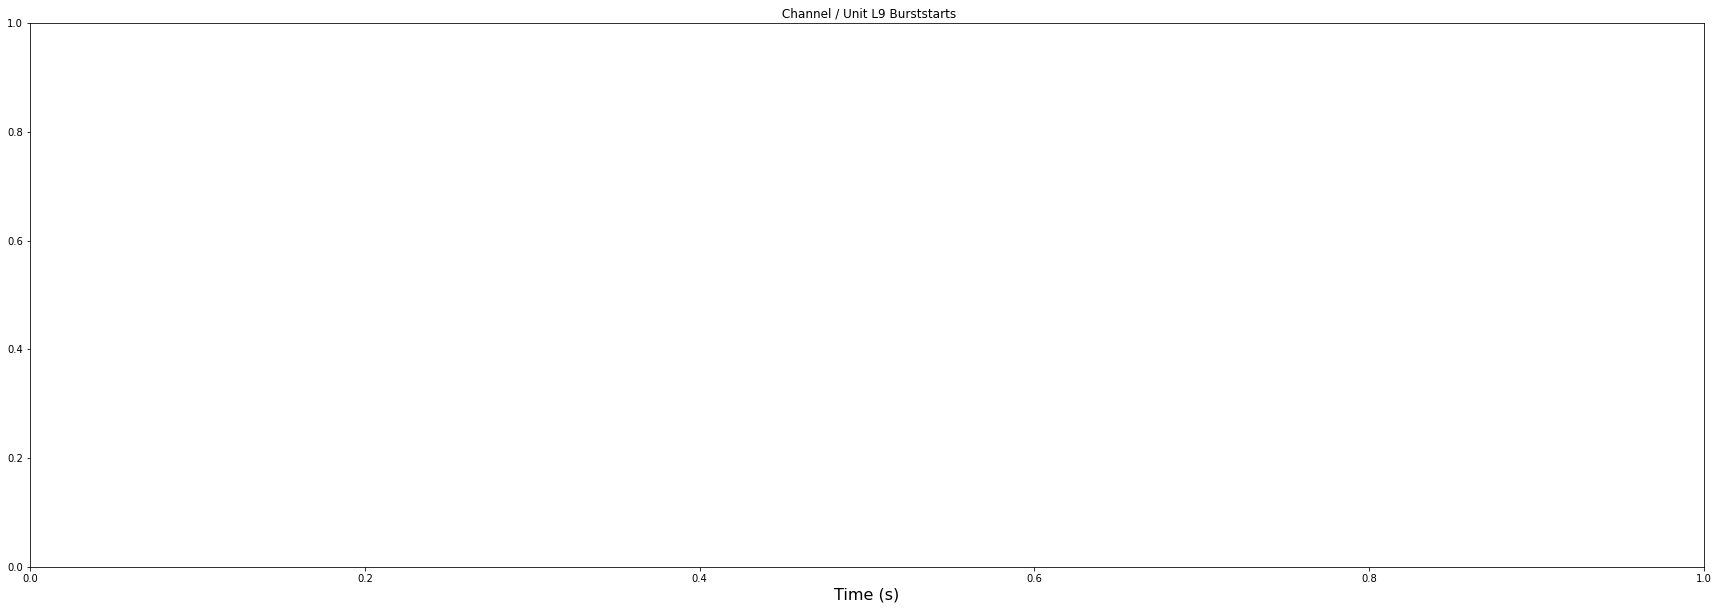

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O9 Burststarts')

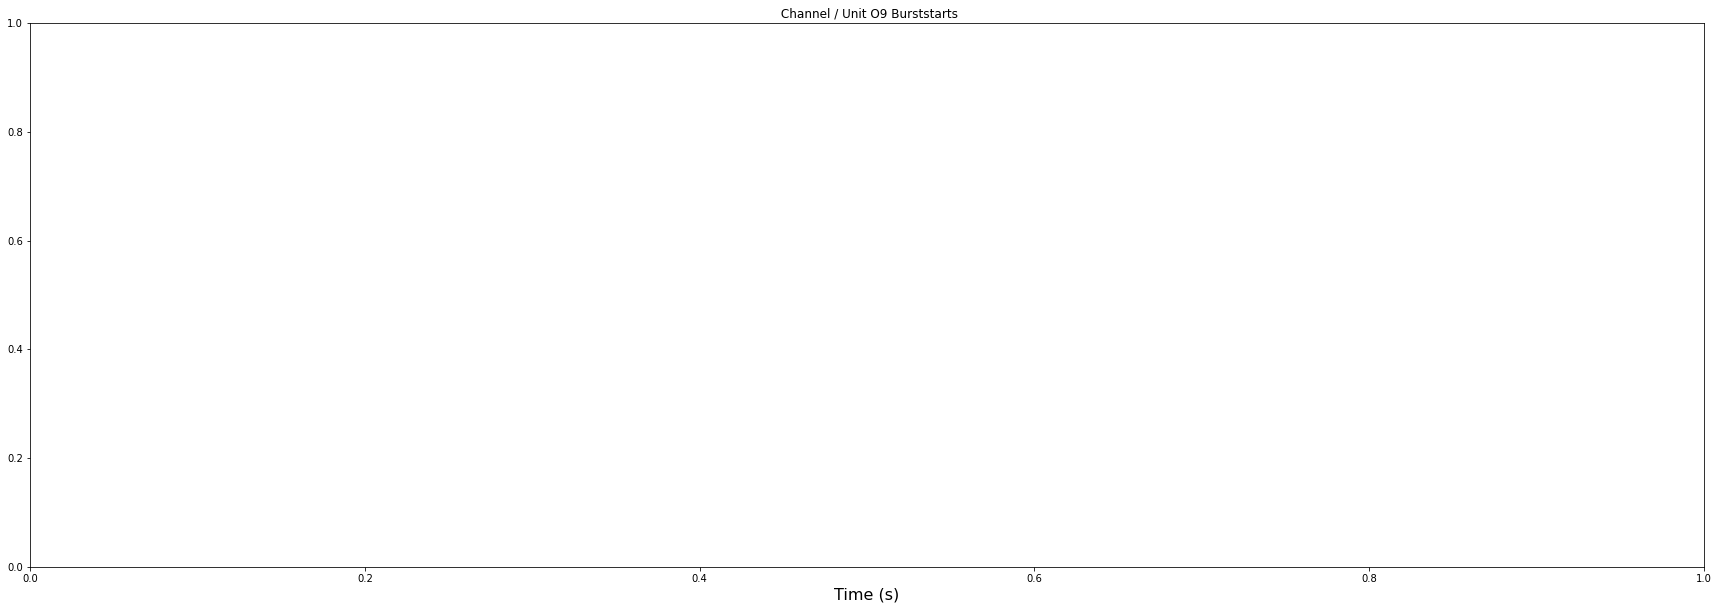

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P9 Burststarts')

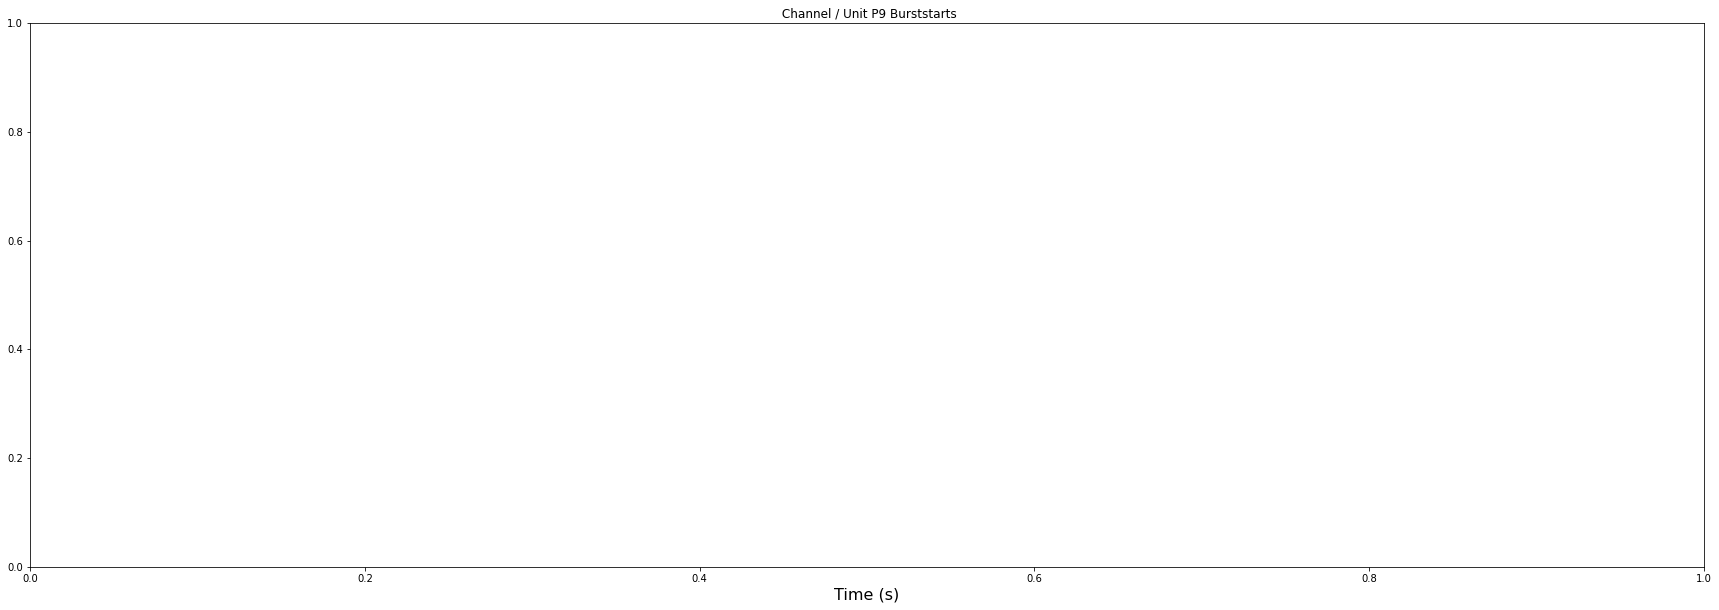

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M9 Burststarts')

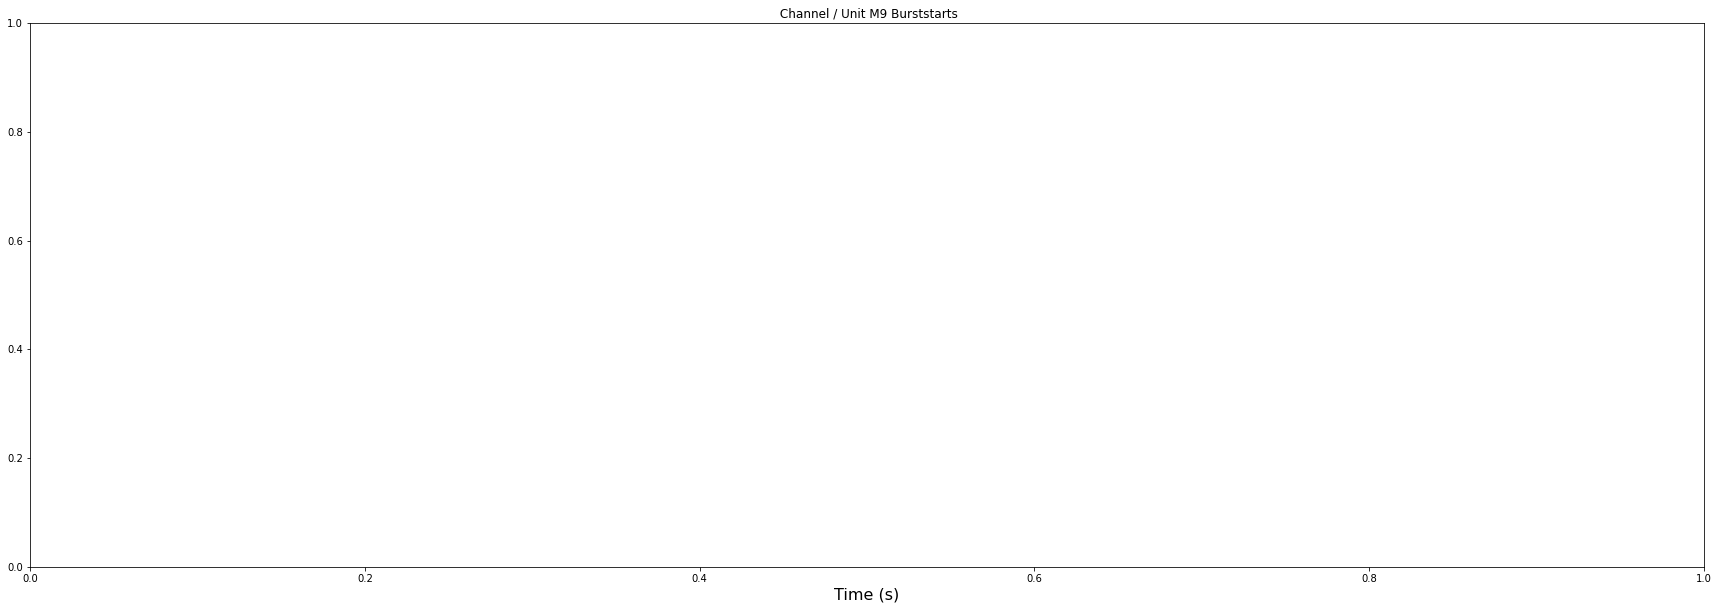

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N9 Burststarts')

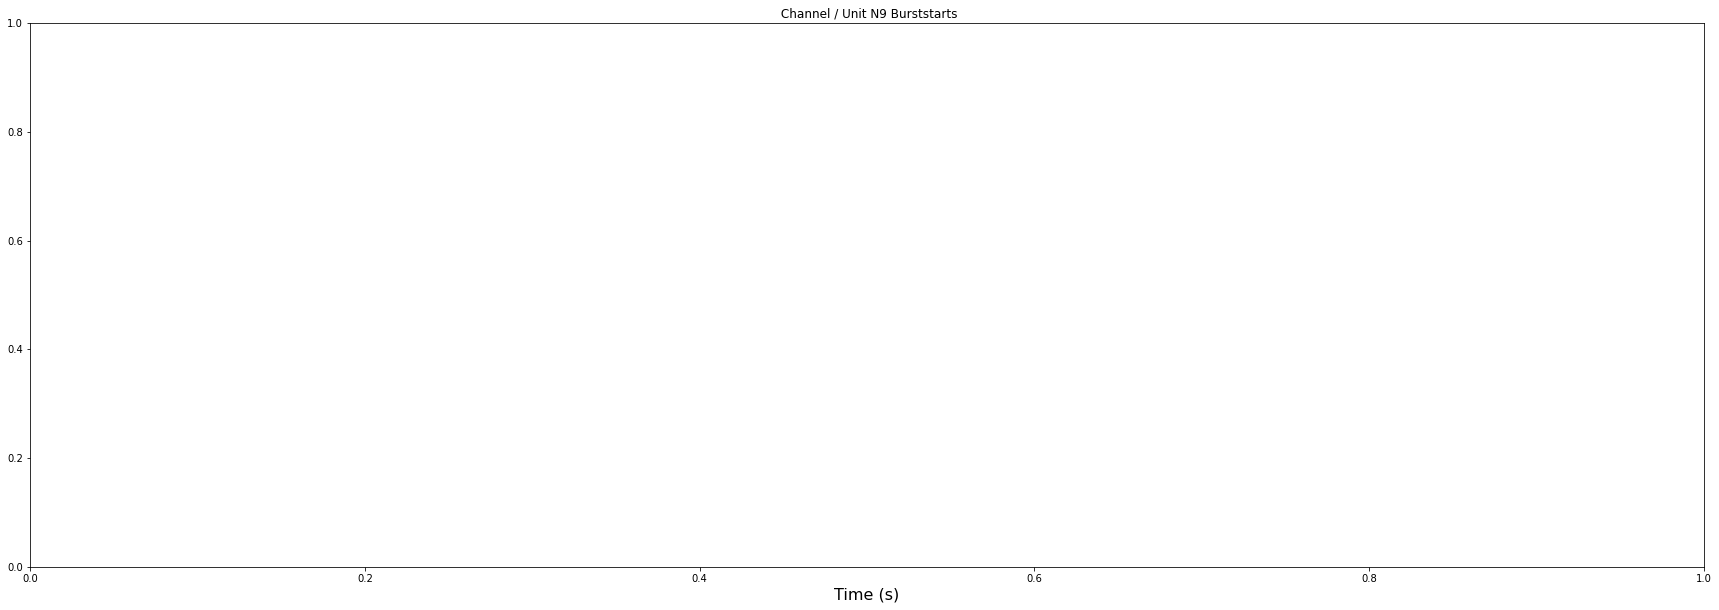

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P10 Burststarts')

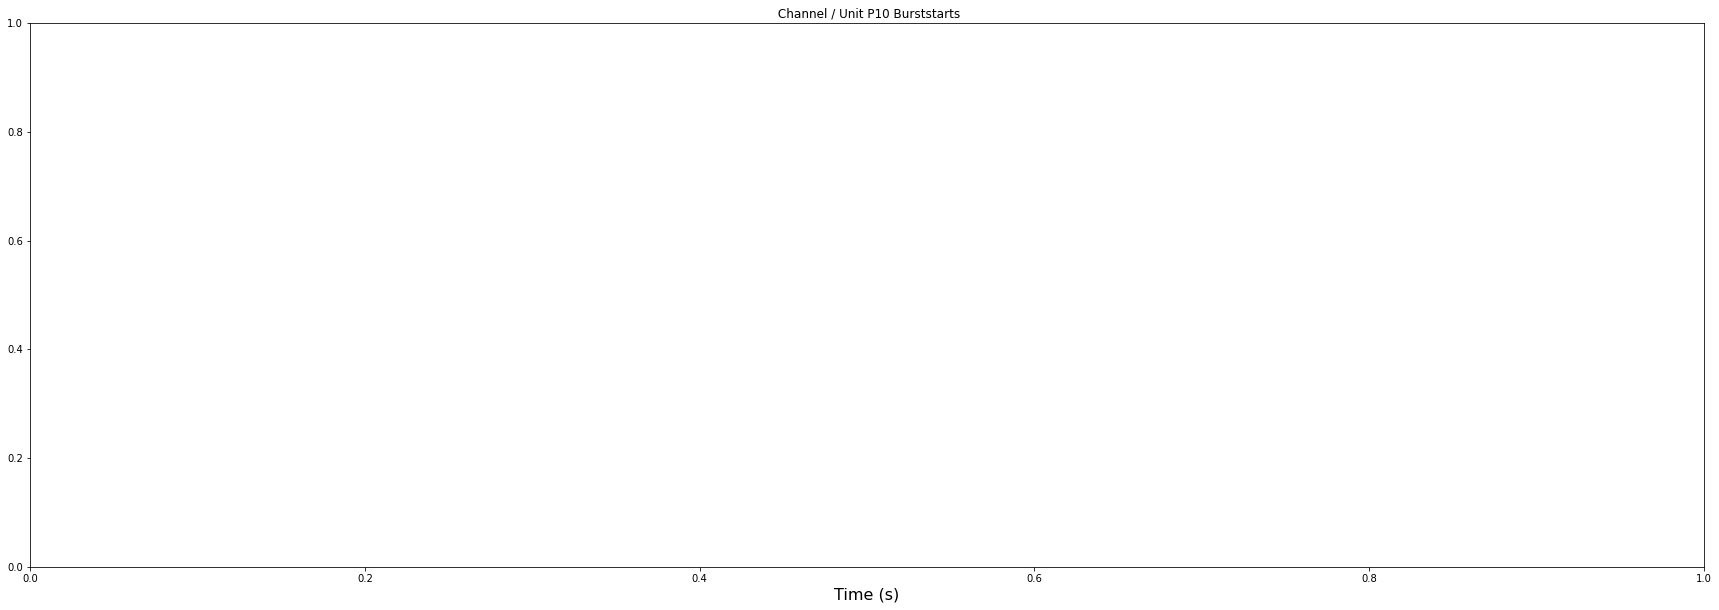

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R10 Burststarts')

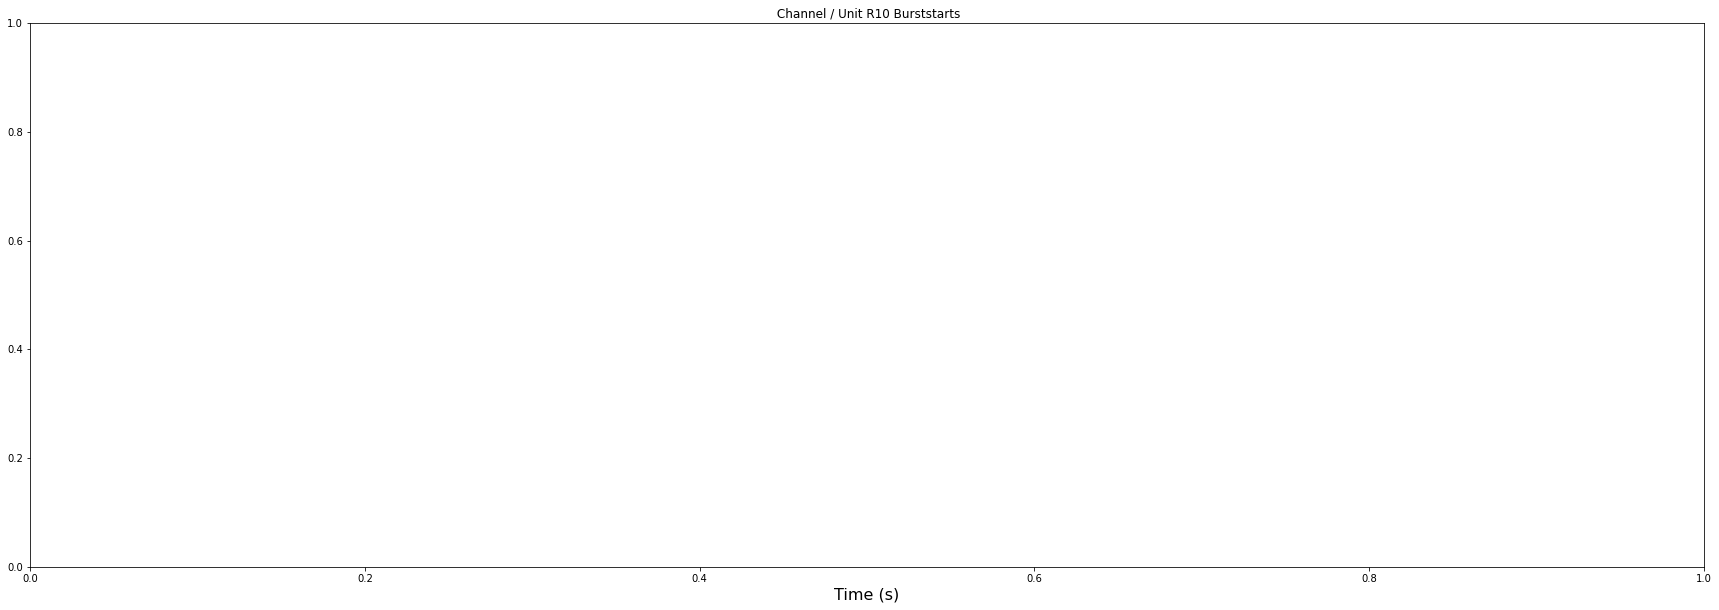

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N10 Burststarts')

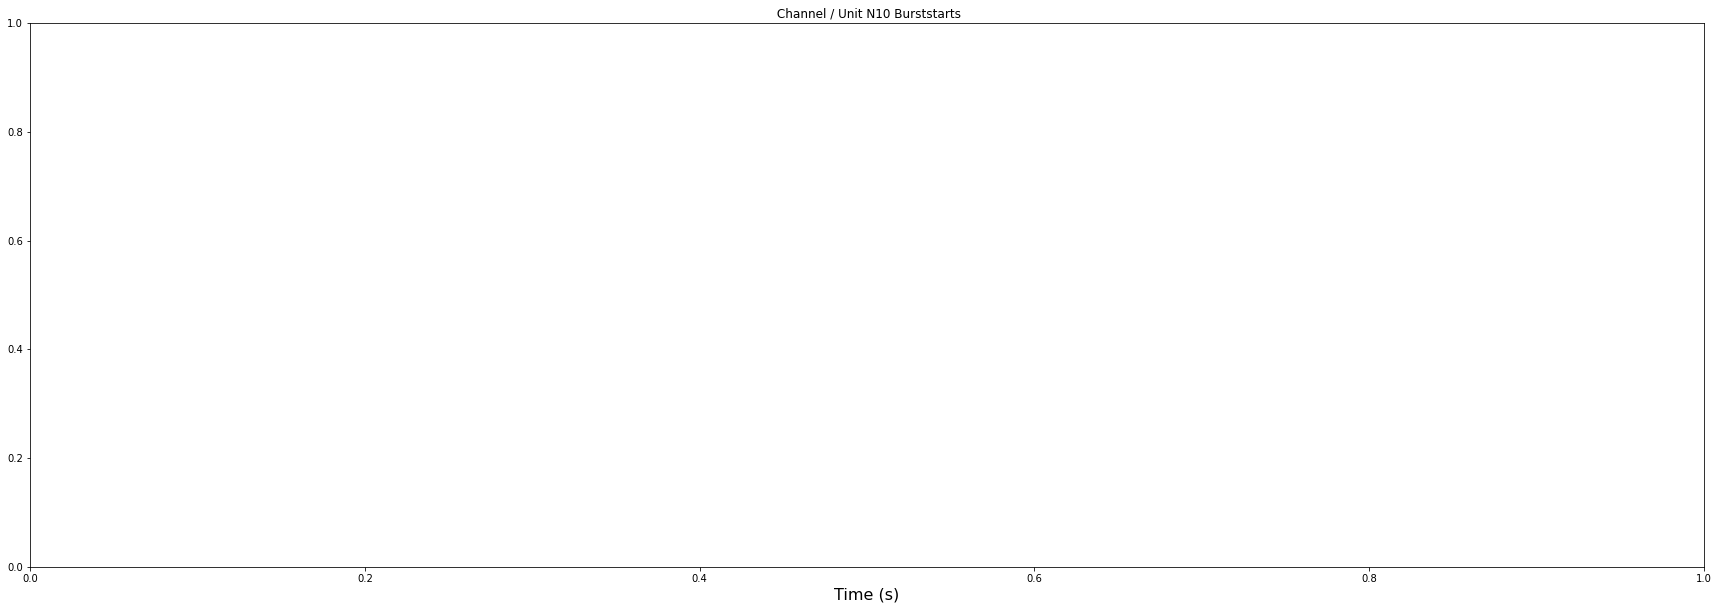

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O10 Burststarts')

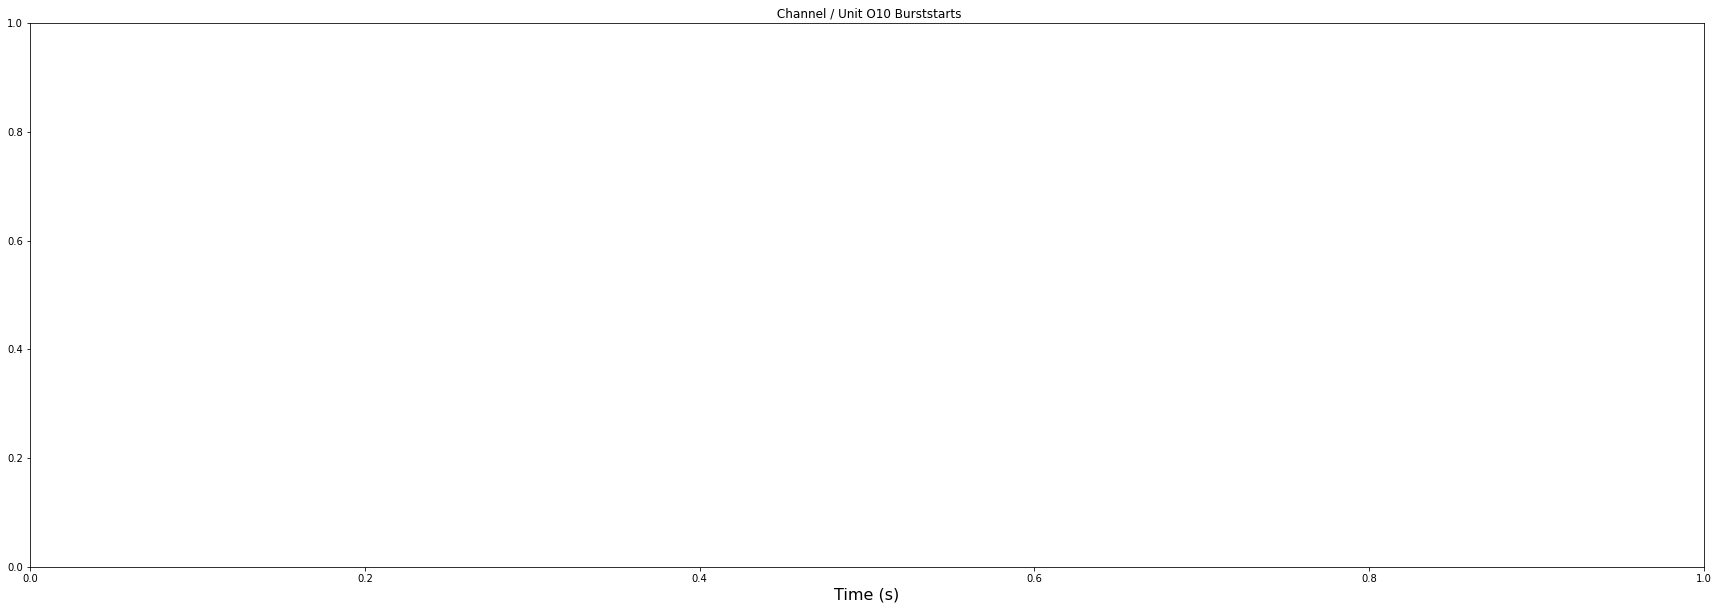

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R11 Burststarts')

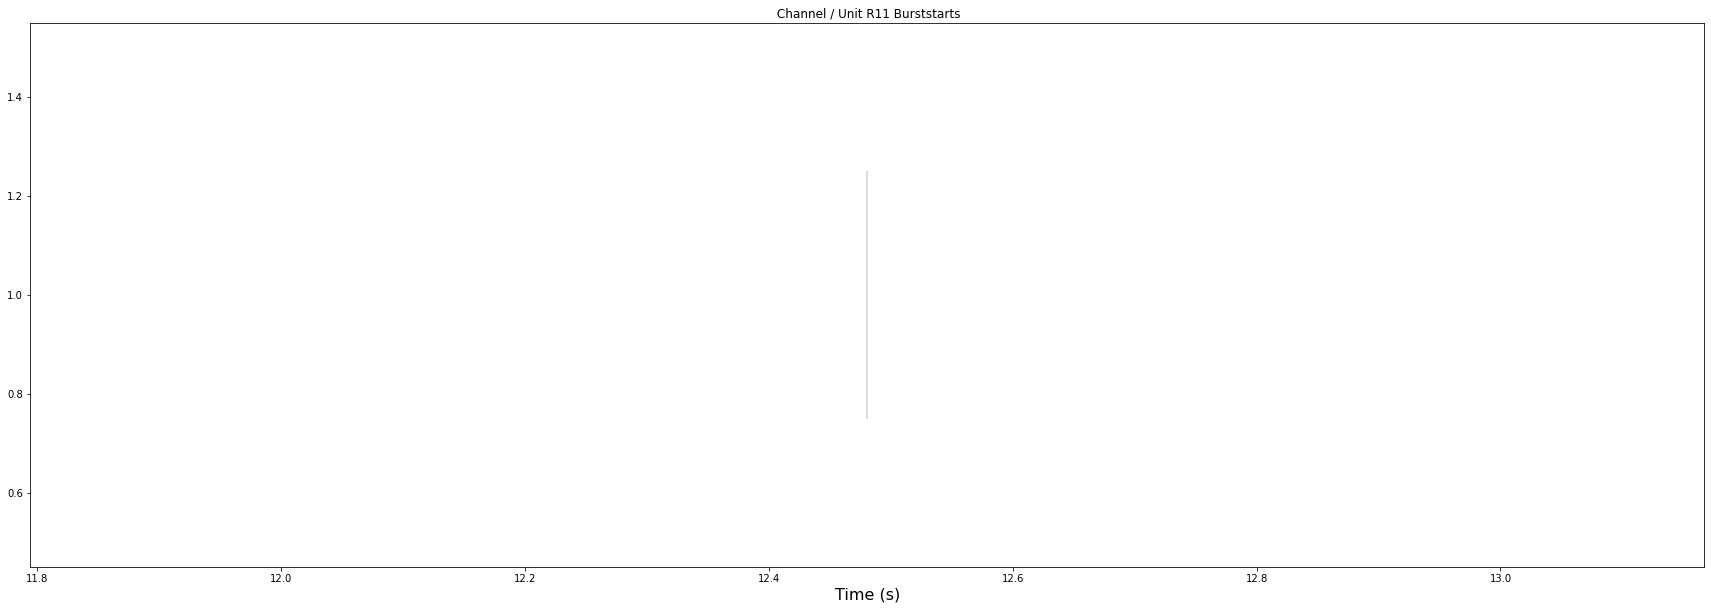

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M10 Burststarts')

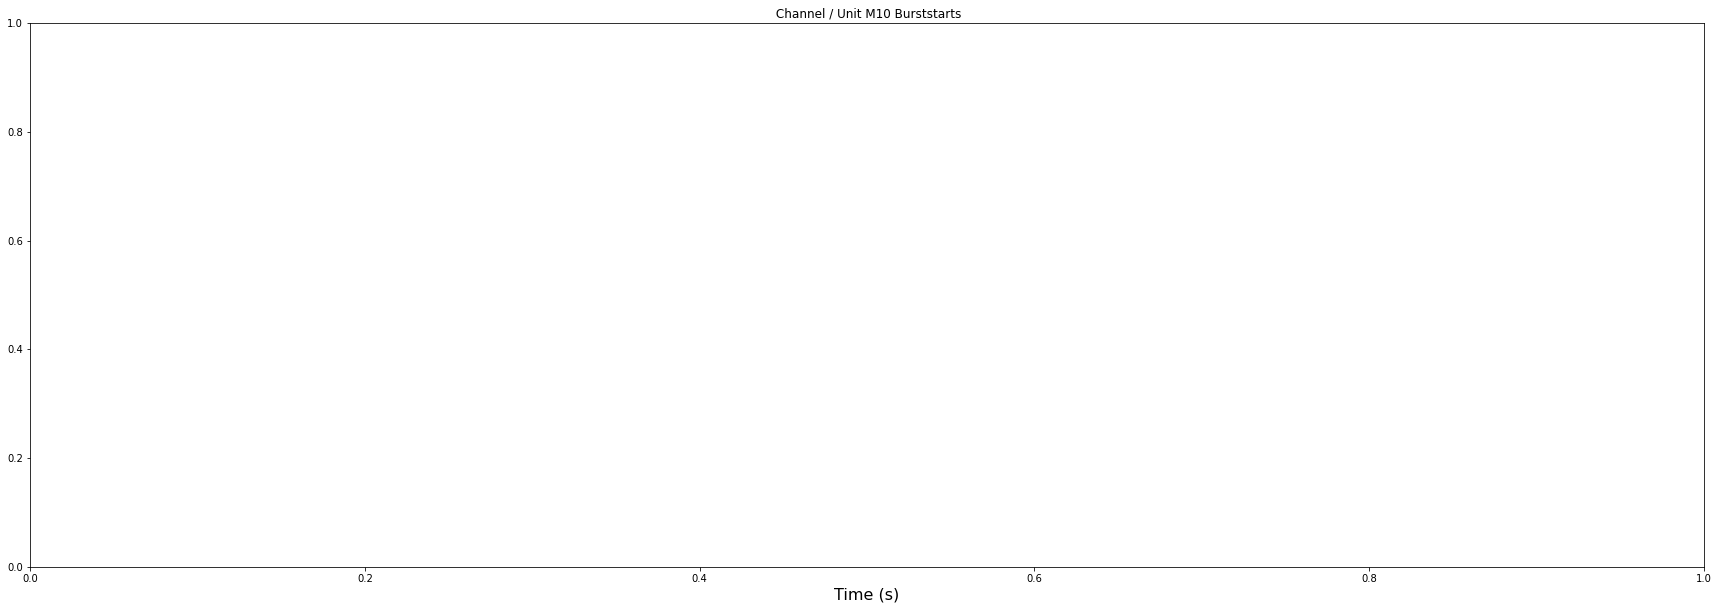

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O11 Burststarts')

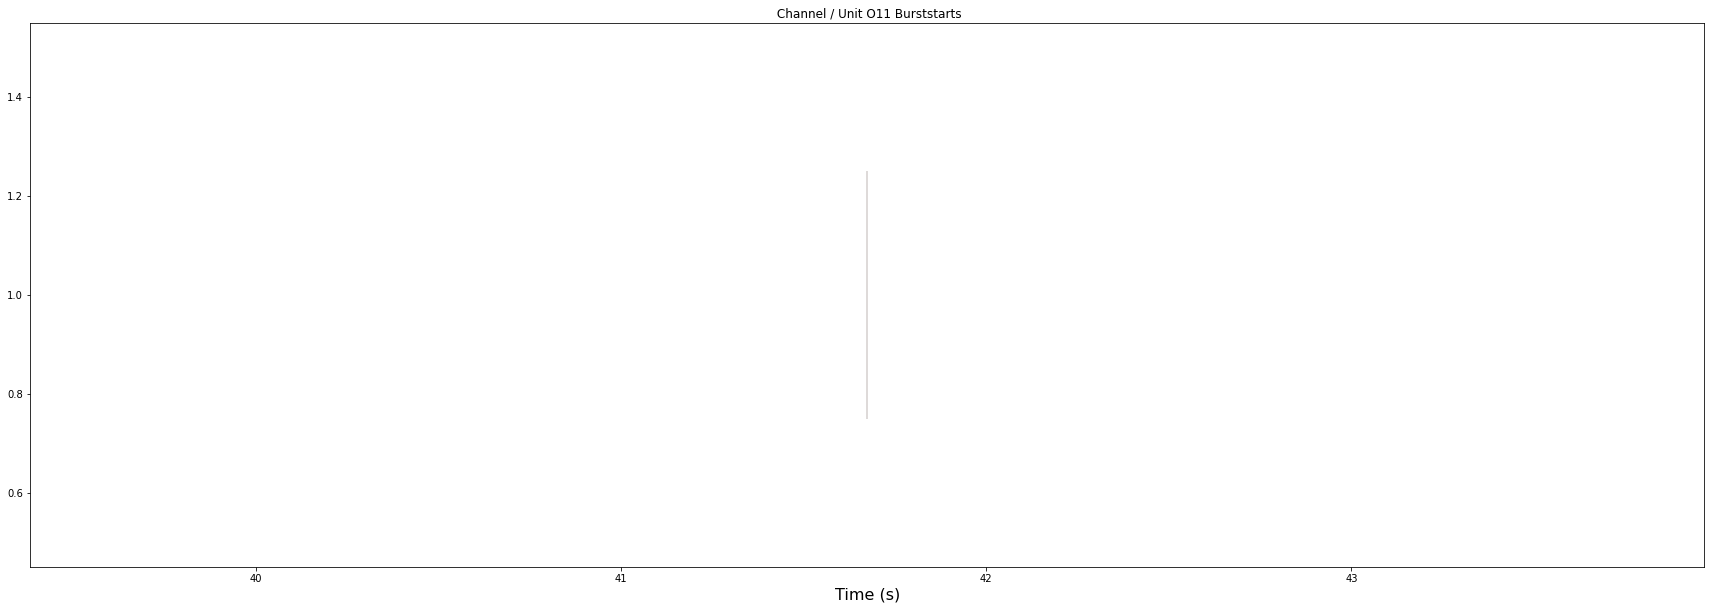

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P11 Burststarts')

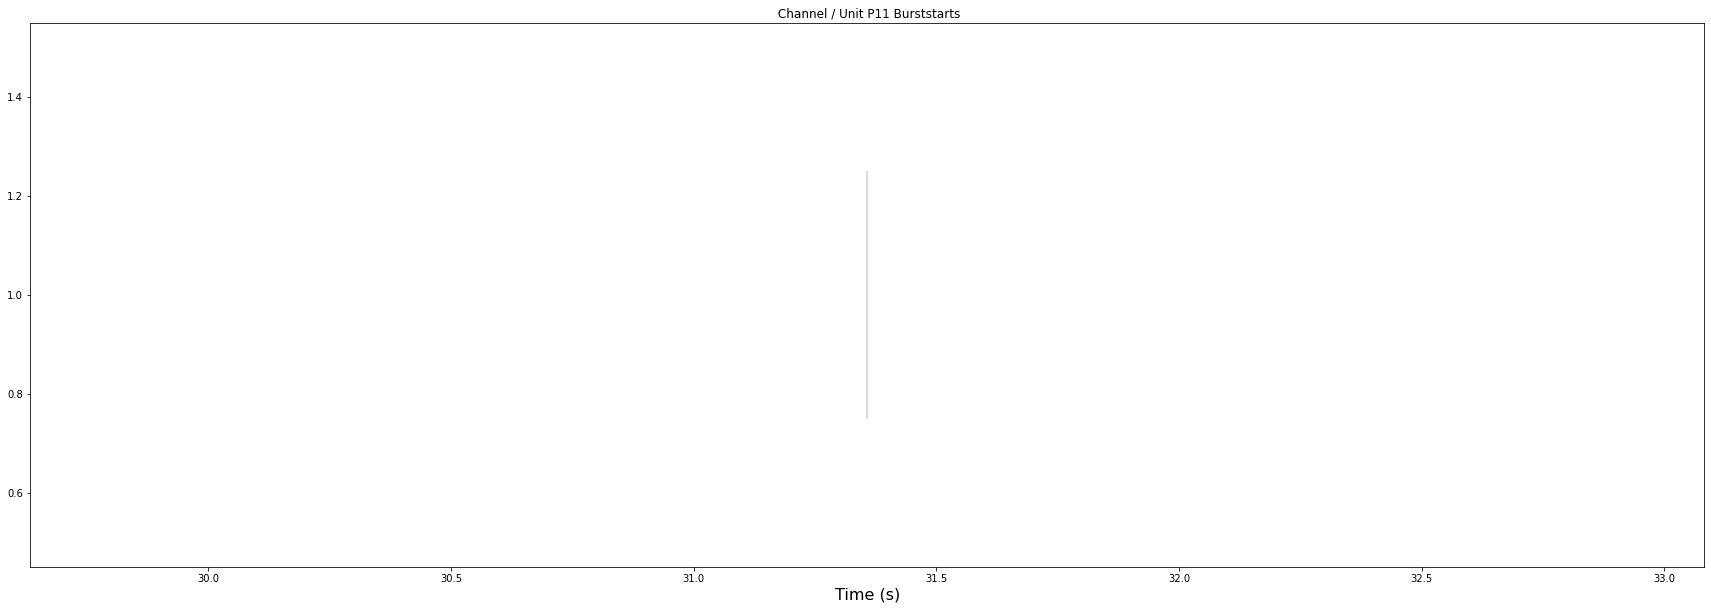

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M11 Burststarts')

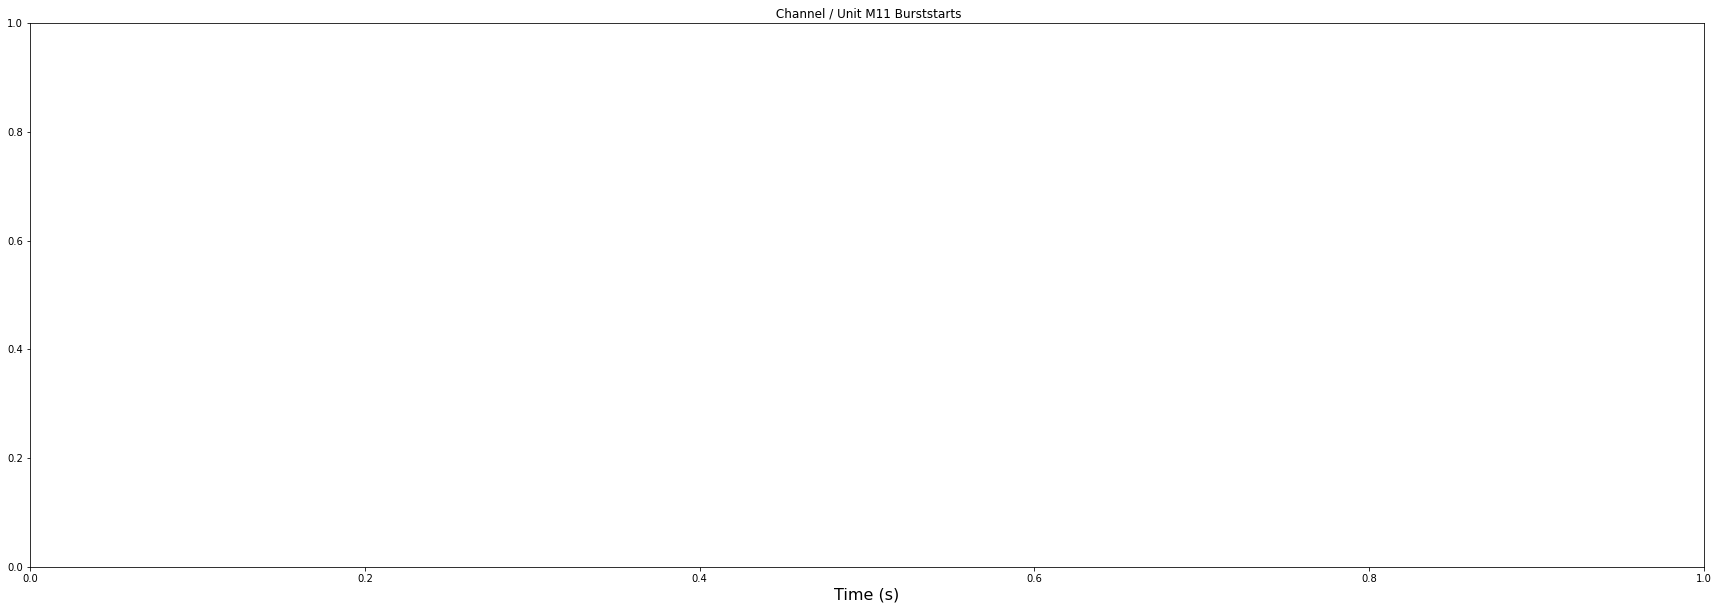

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N11 Burststarts')

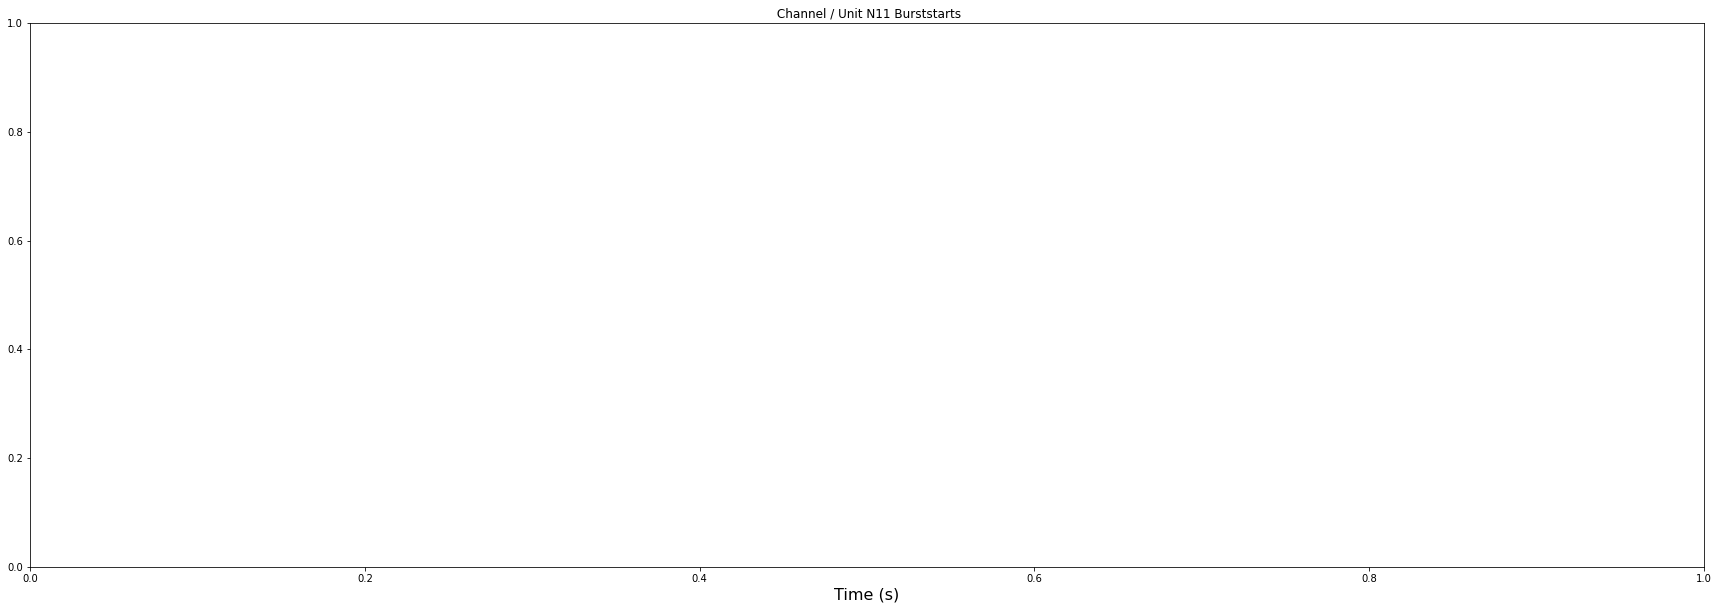

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P12 Burststarts')

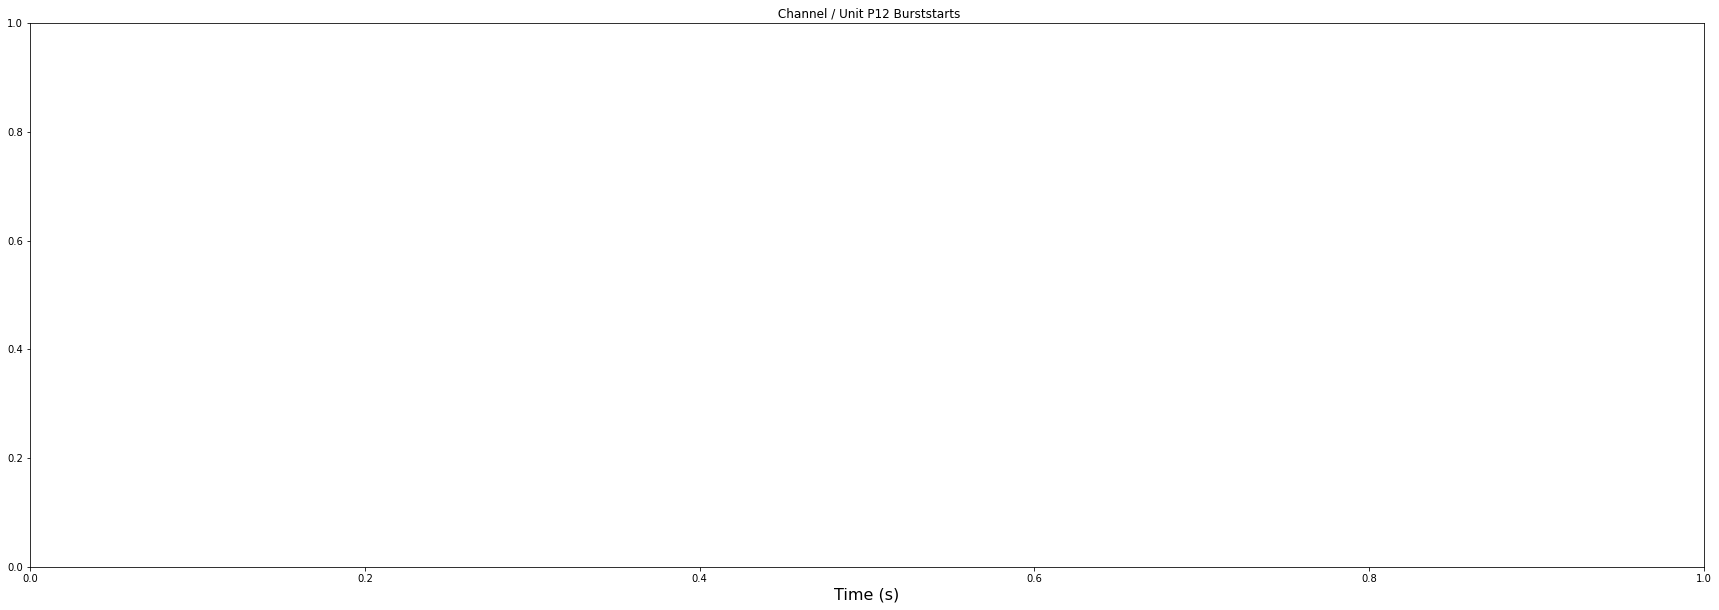

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R12 Burststarts')

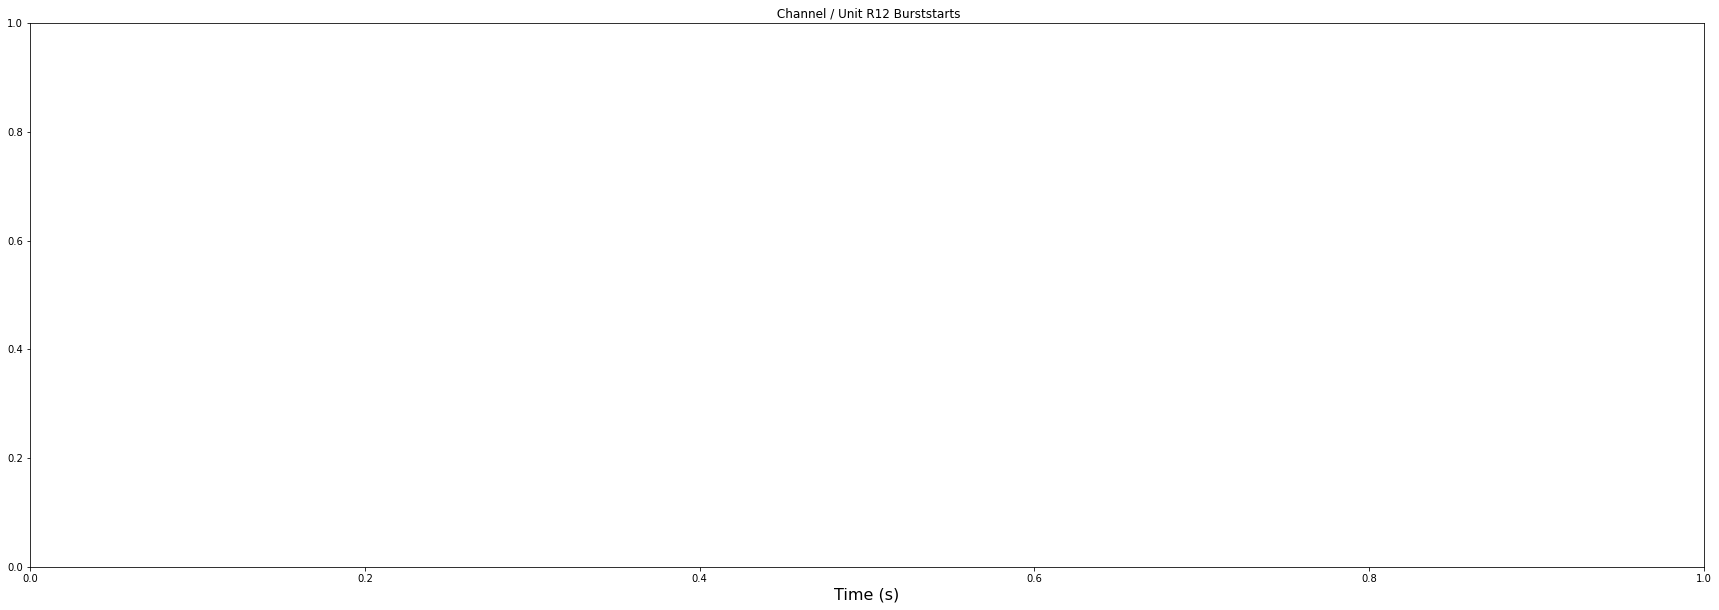

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N12 Burststarts')

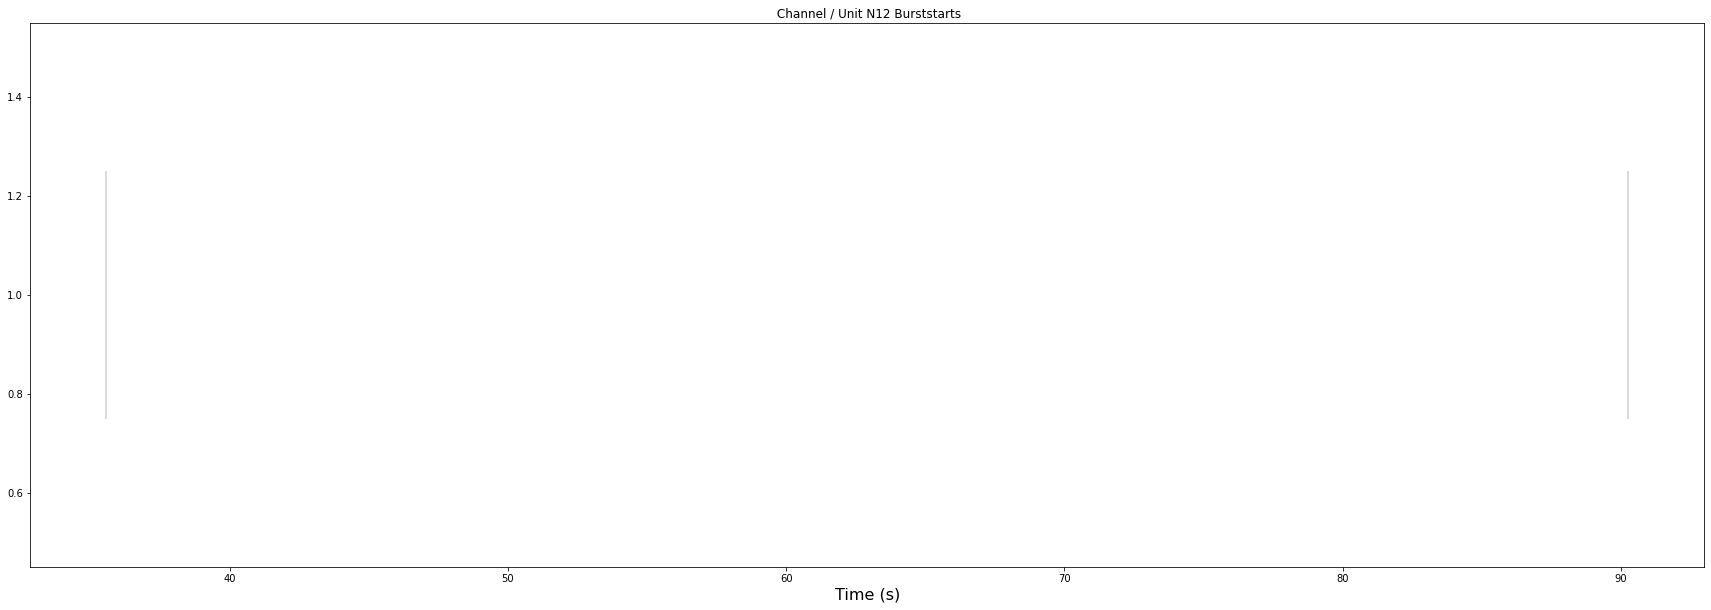

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O12 Burststarts')

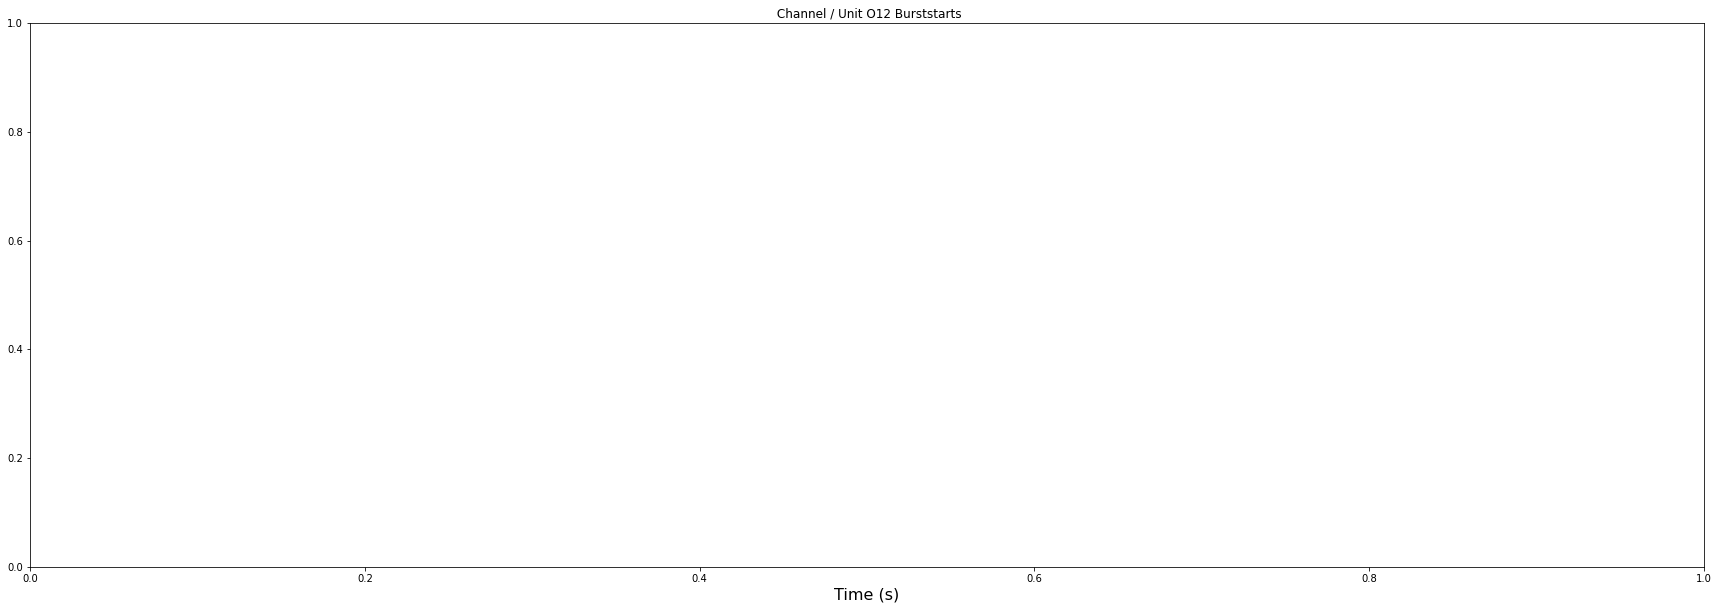

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R13 Burststarts')

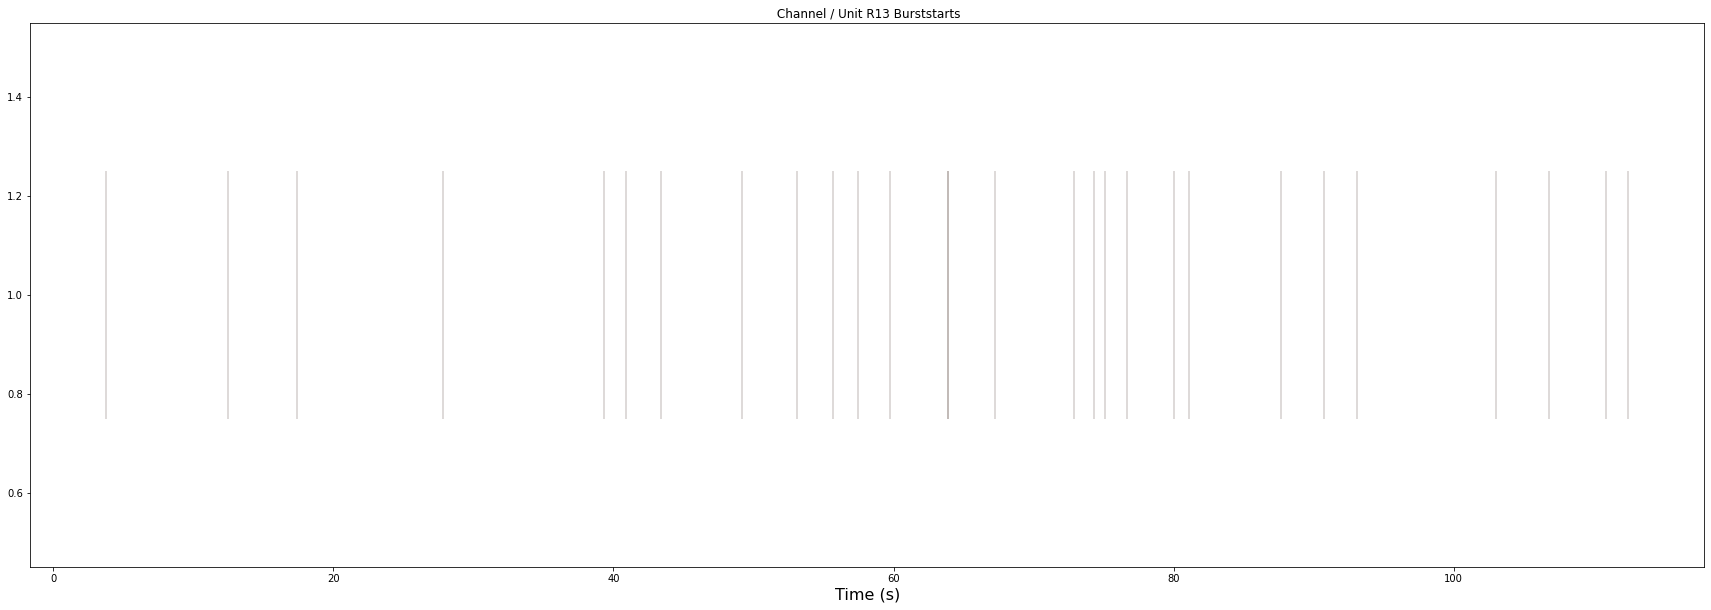

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L10 Burststarts')

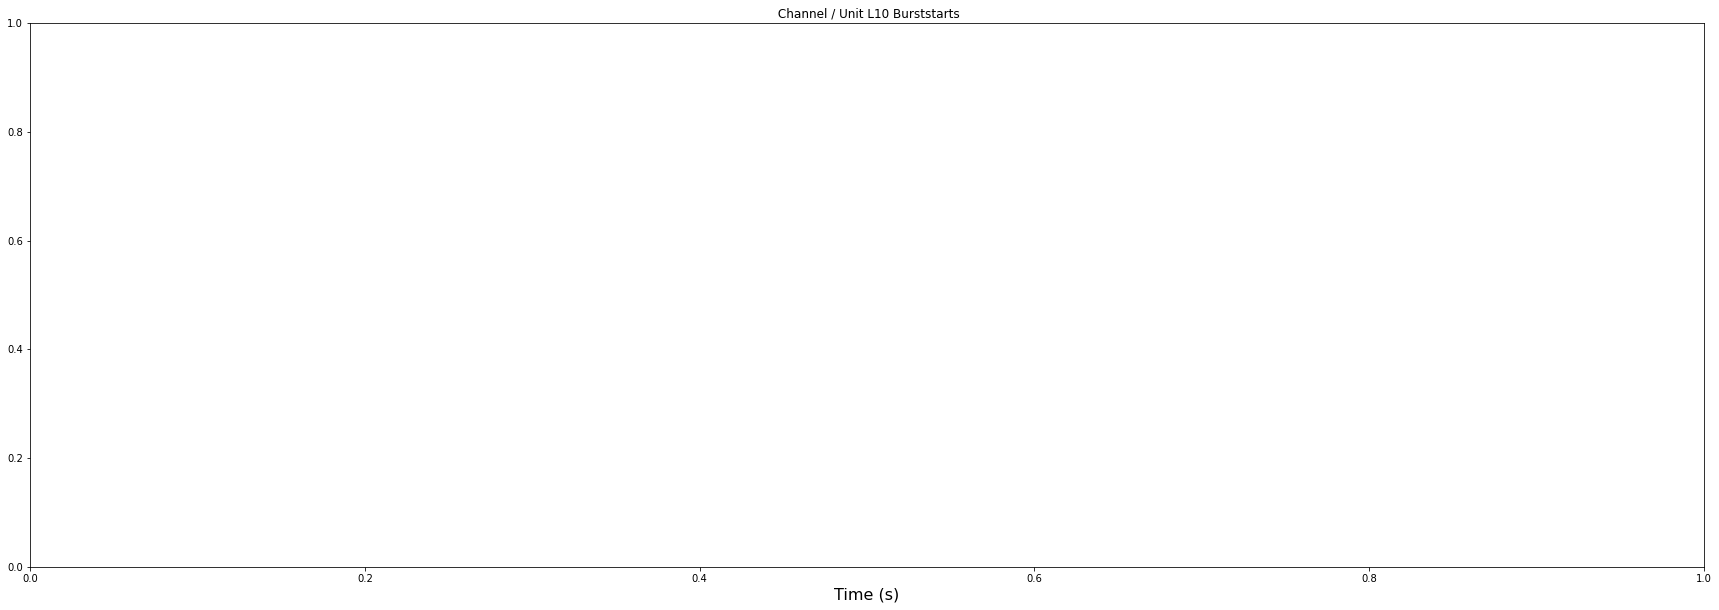

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O13 Burststarts')

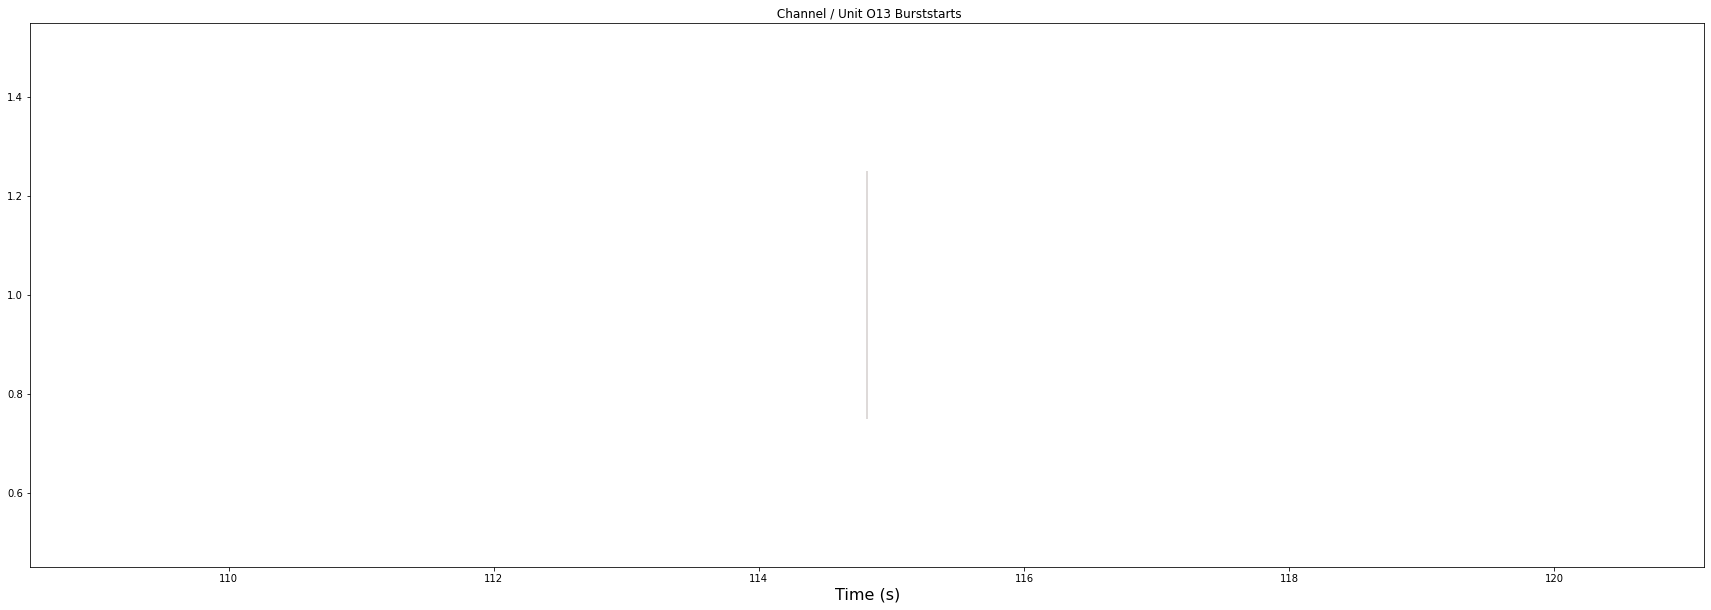

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P13 Burststarts')

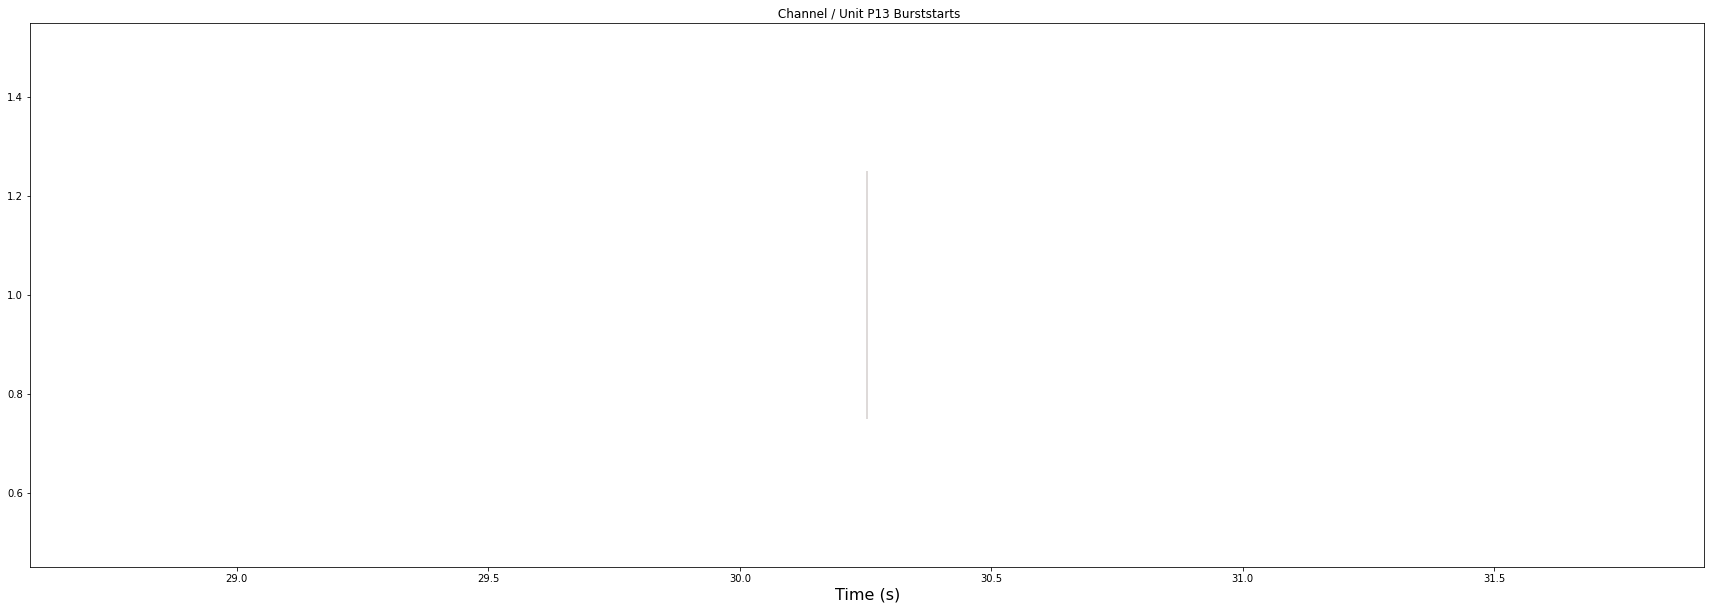

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L11 Burststarts')

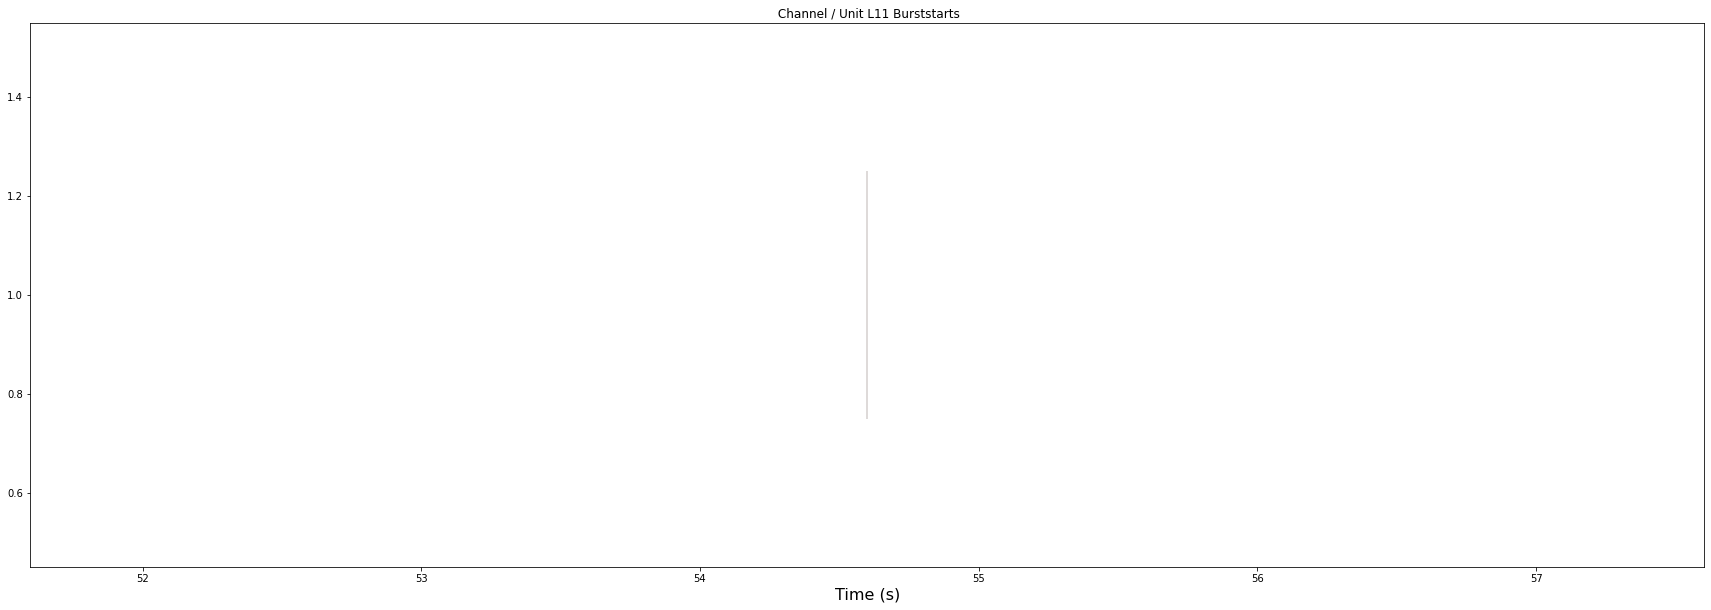

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J9 Burststarts')

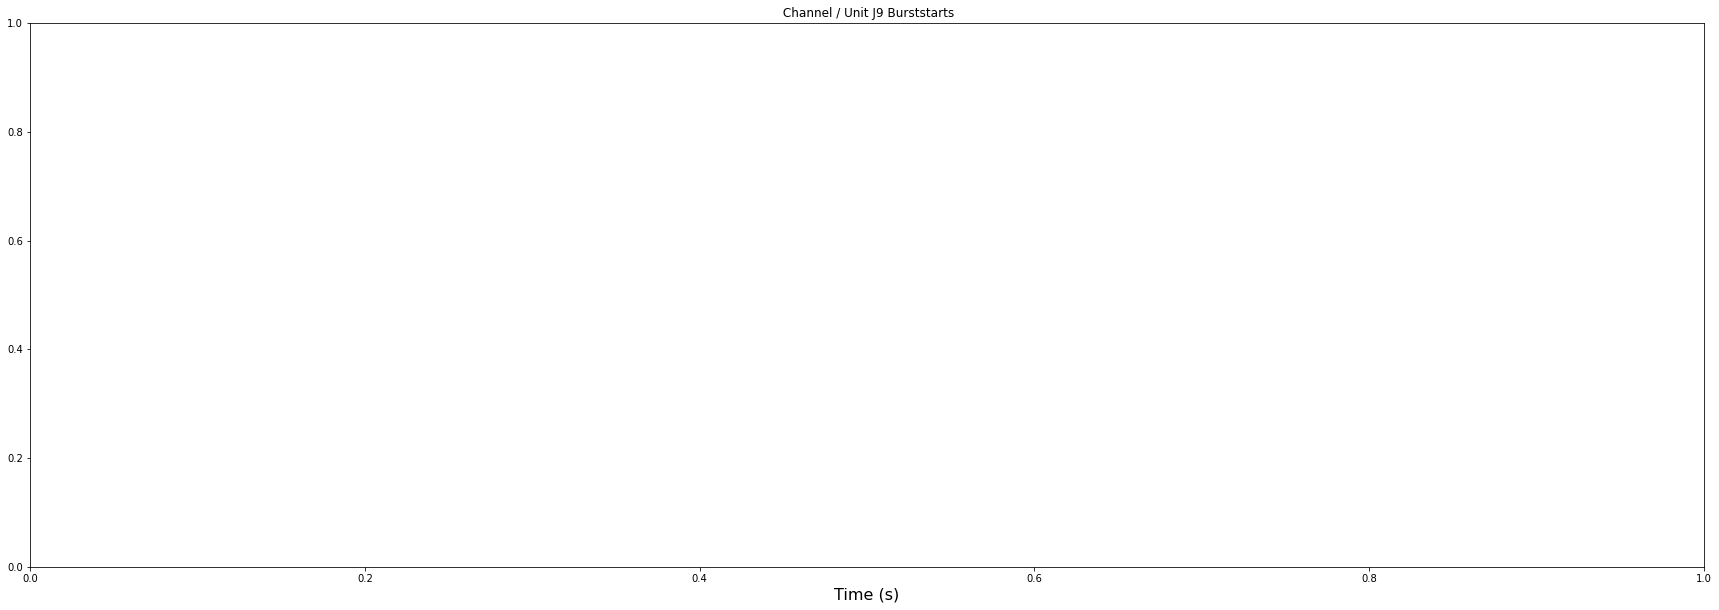

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P14 Burststarts')

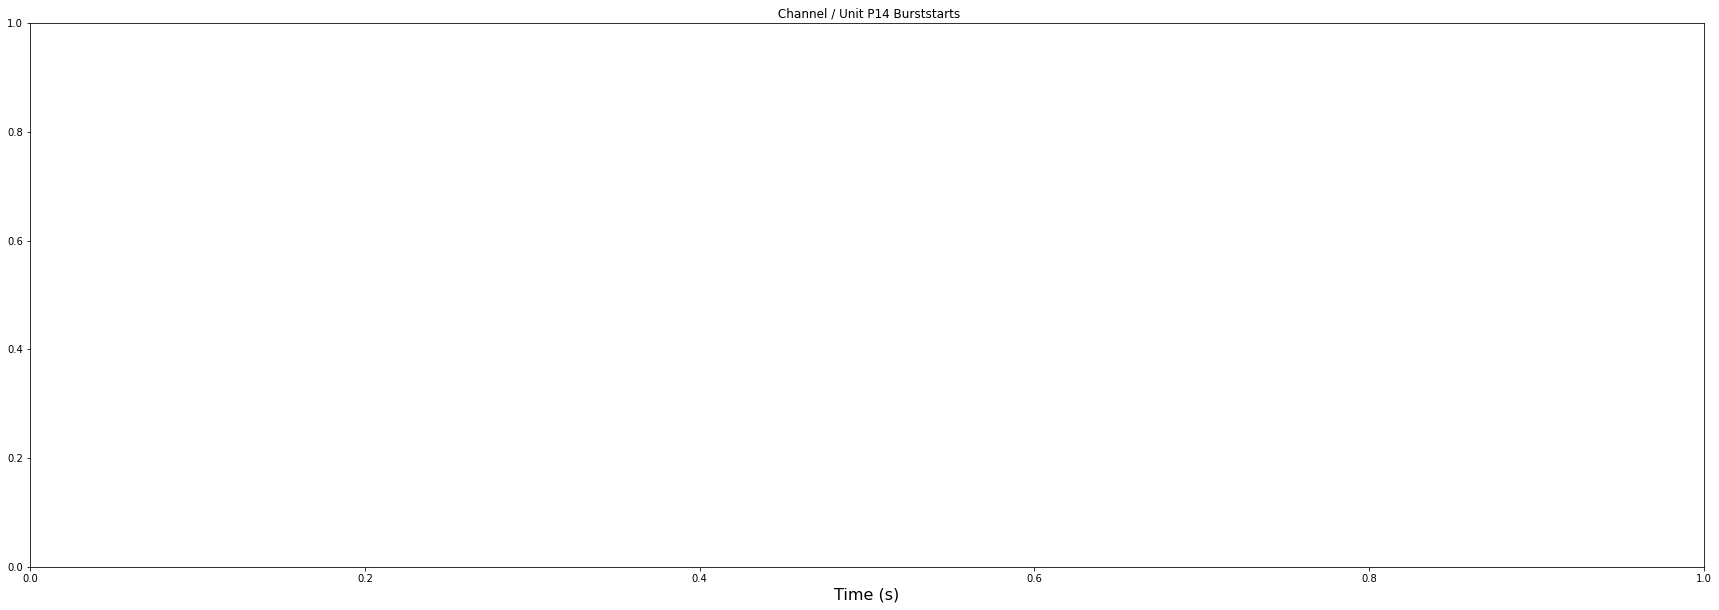

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R14 Burststarts')

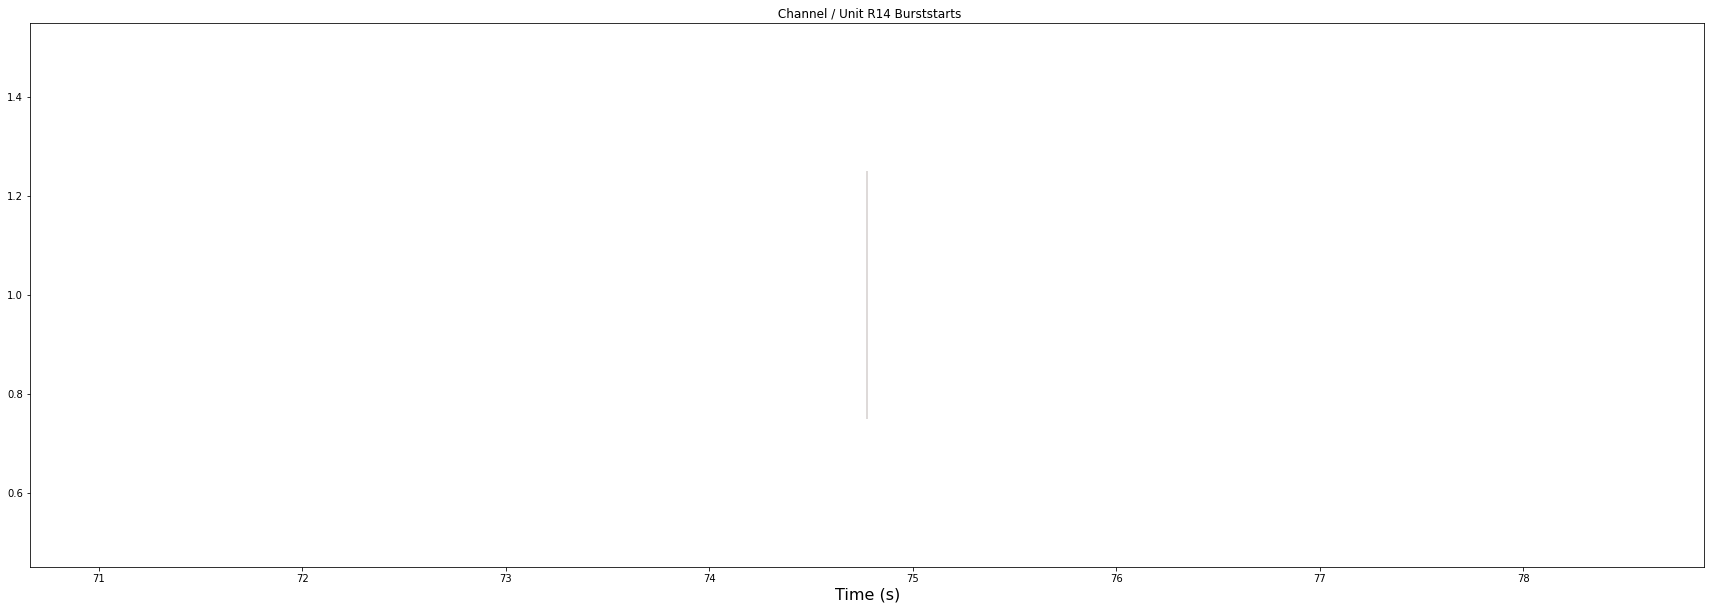

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N13 Burststarts')

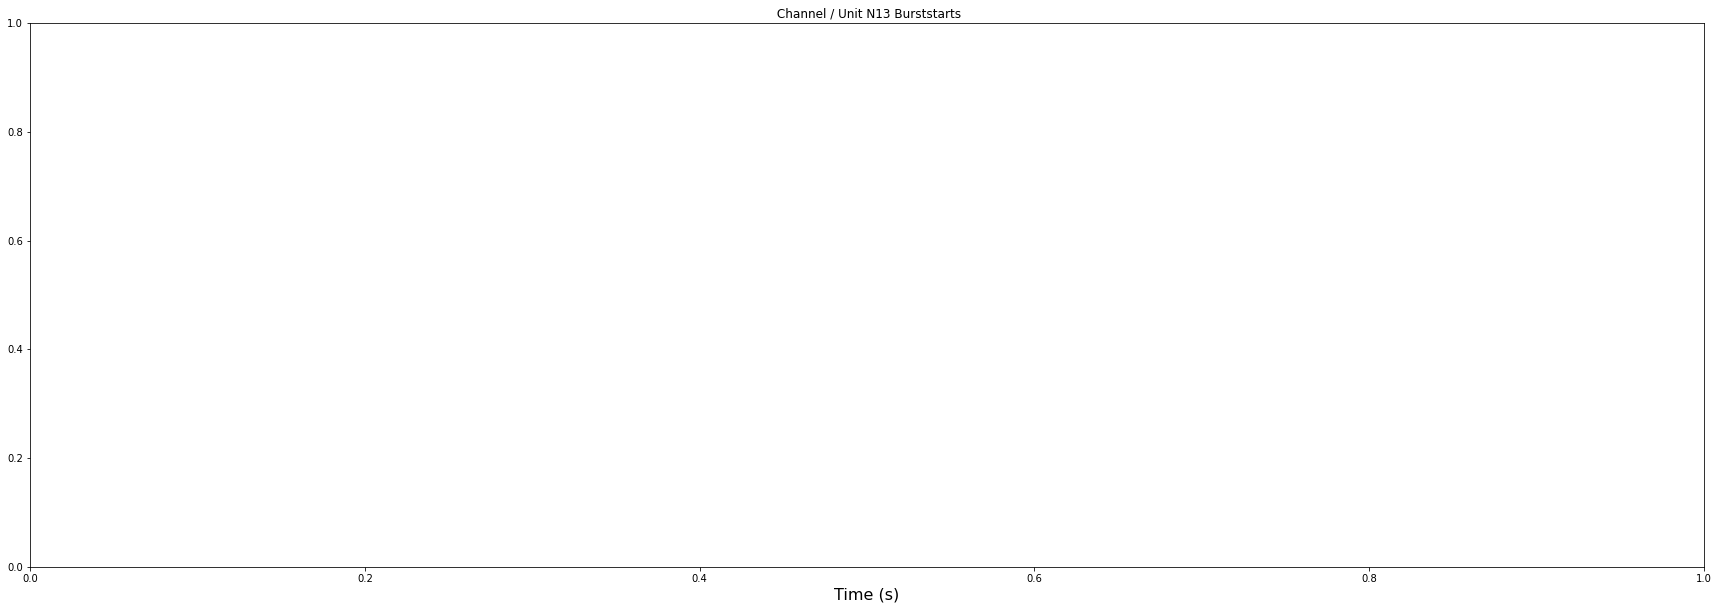

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit R15 Burststarts')

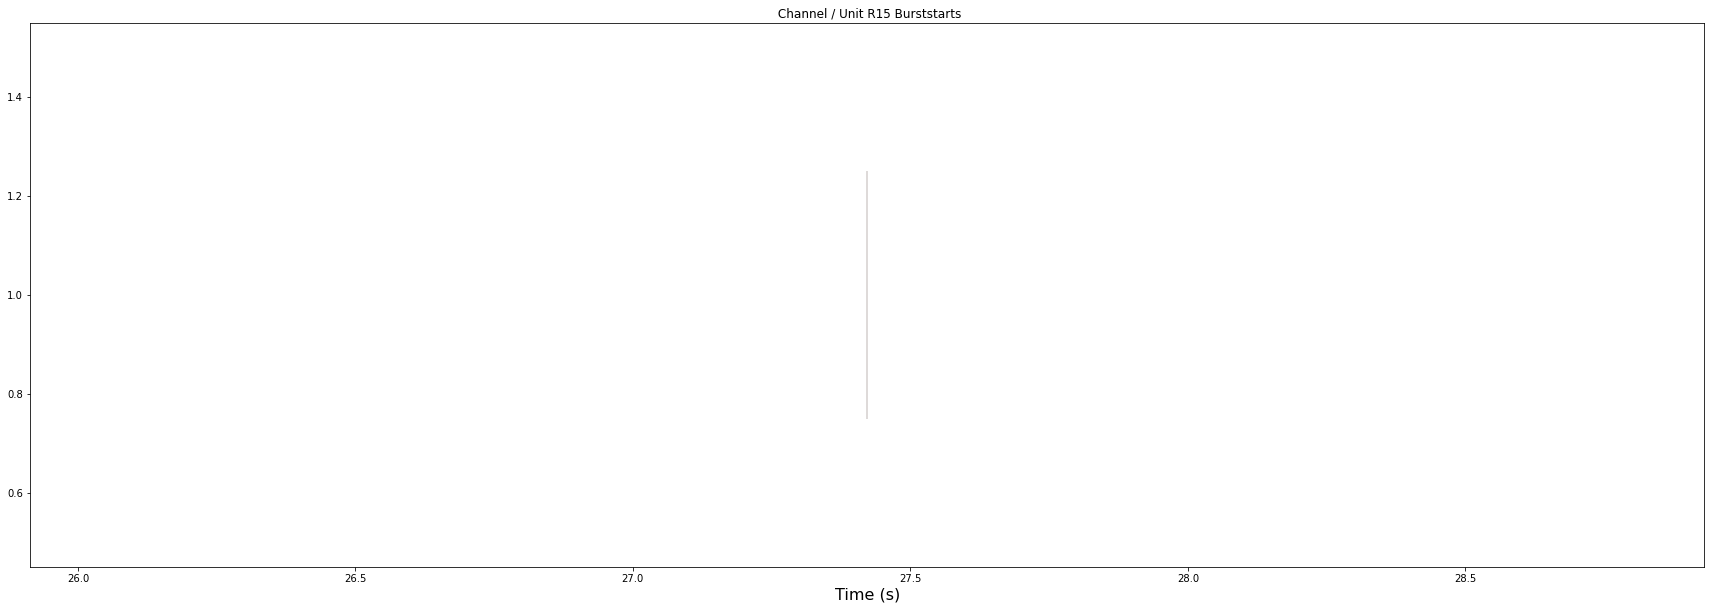

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P16 Burststarts')

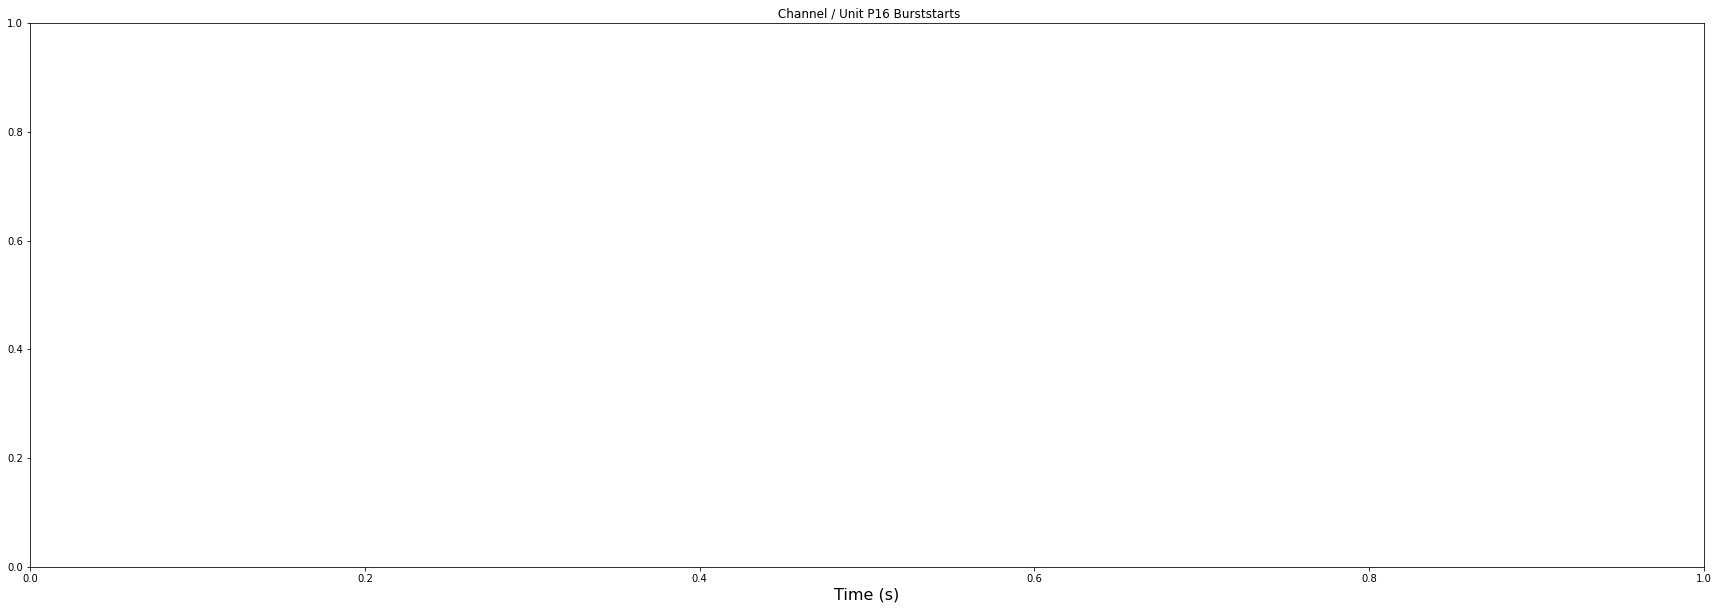

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit P15 Burststarts')

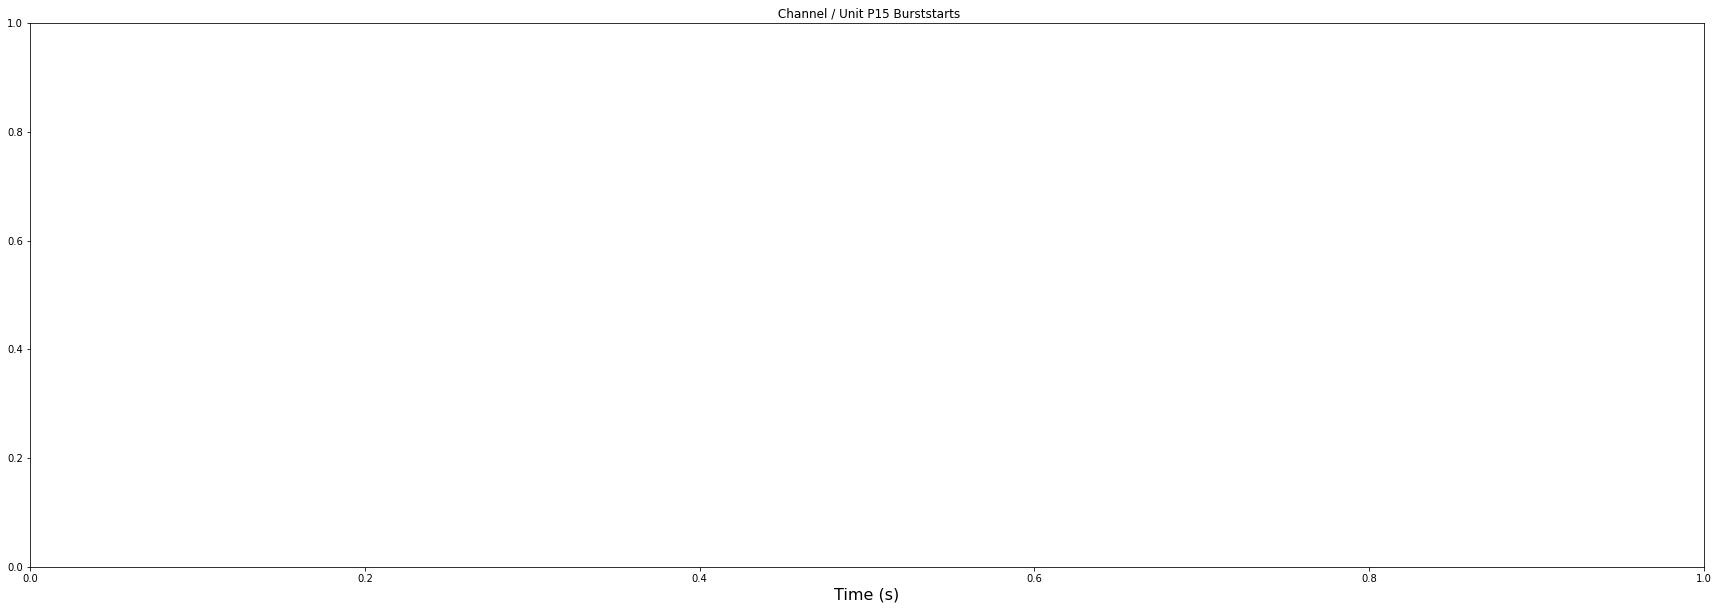

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O15 Burststarts')

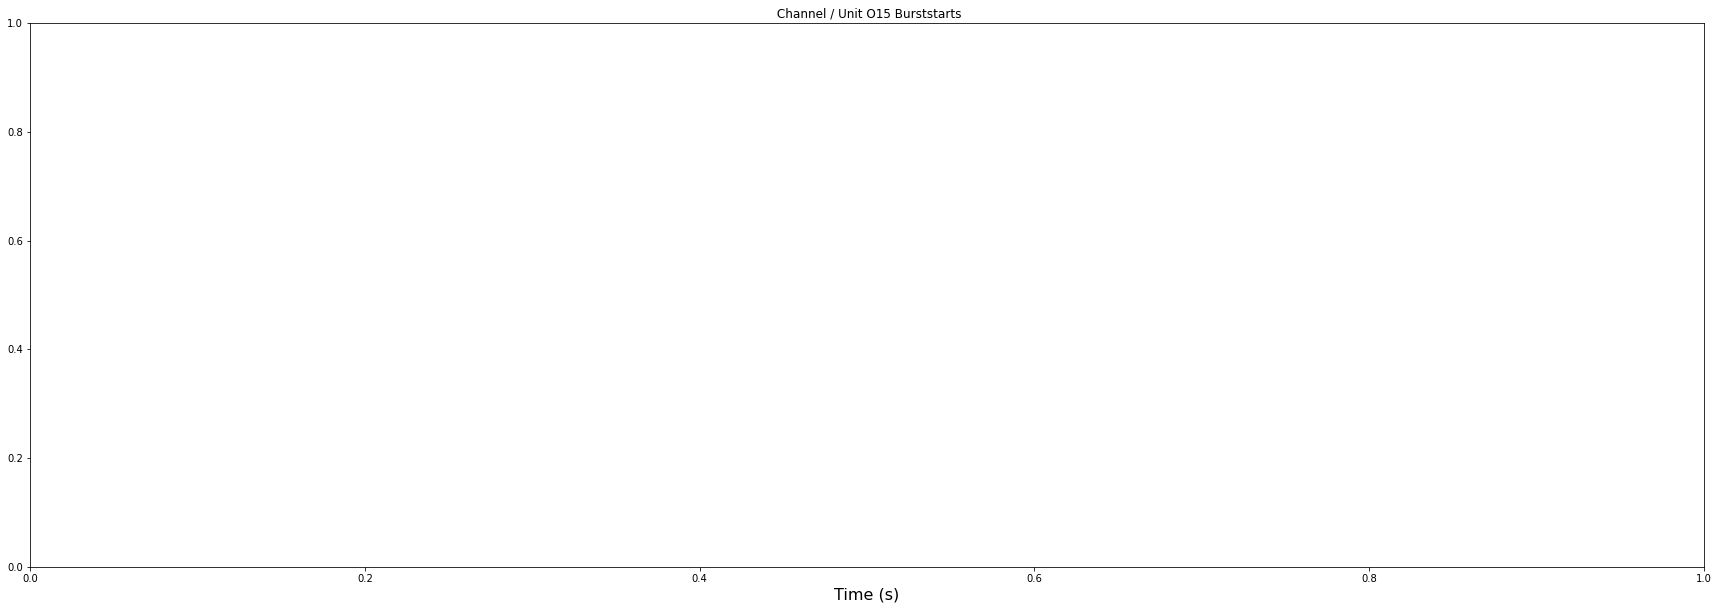

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O14 Burststarts')

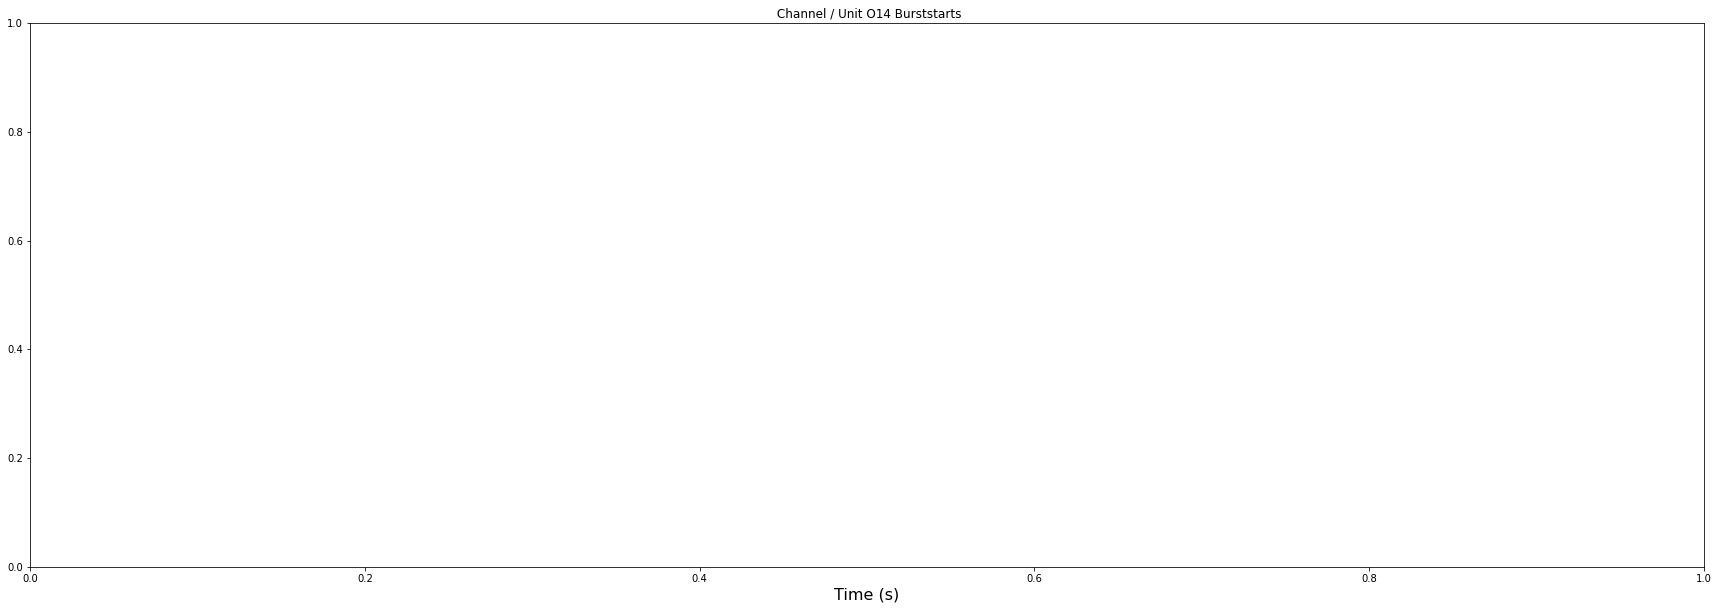

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M12 Burststarts')

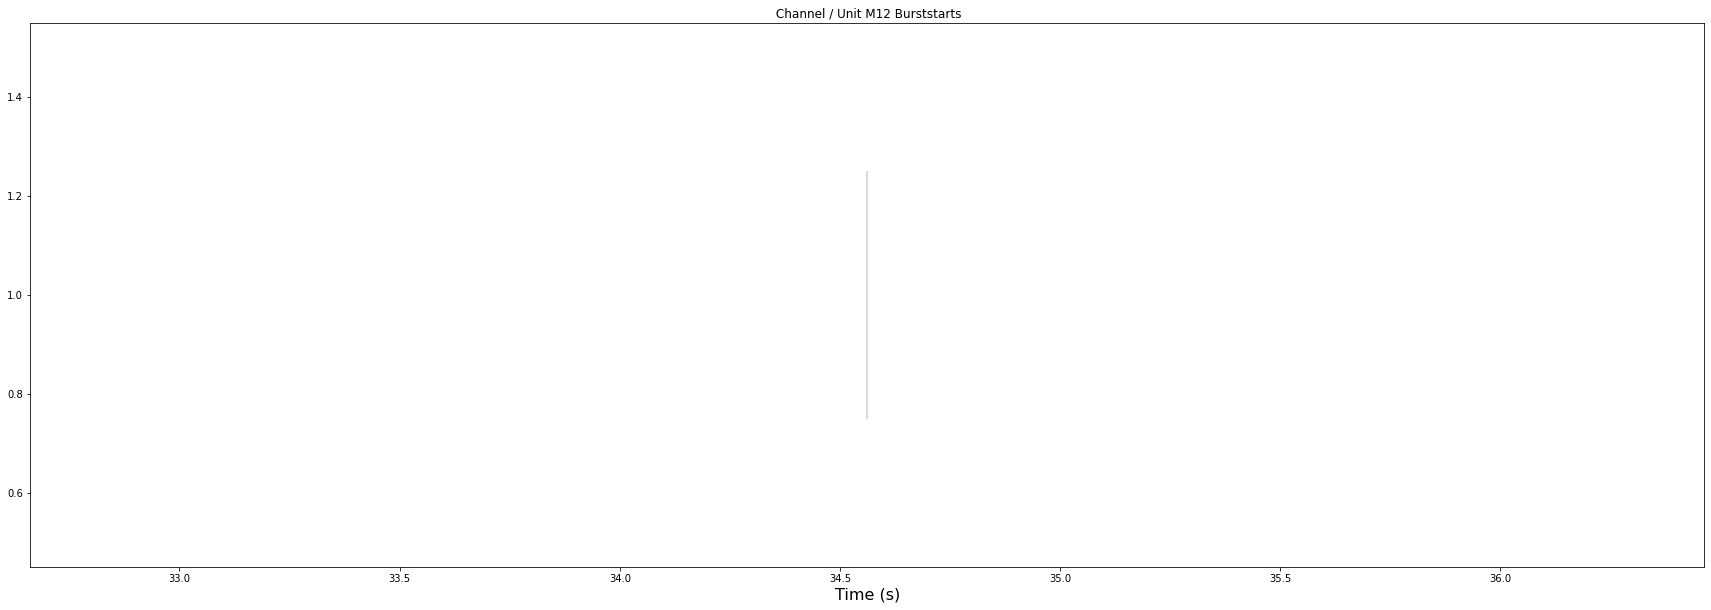

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit O16 Burststarts')

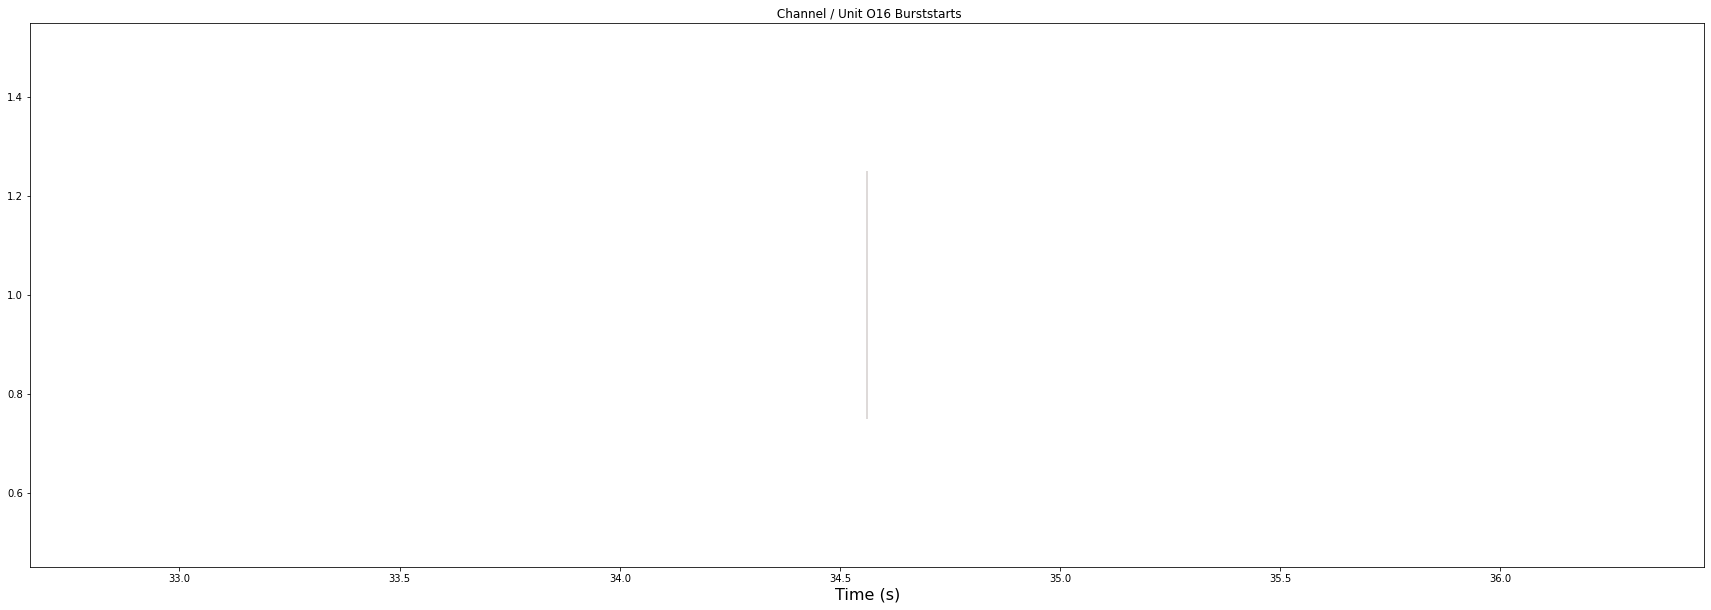

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N14 Burststarts')

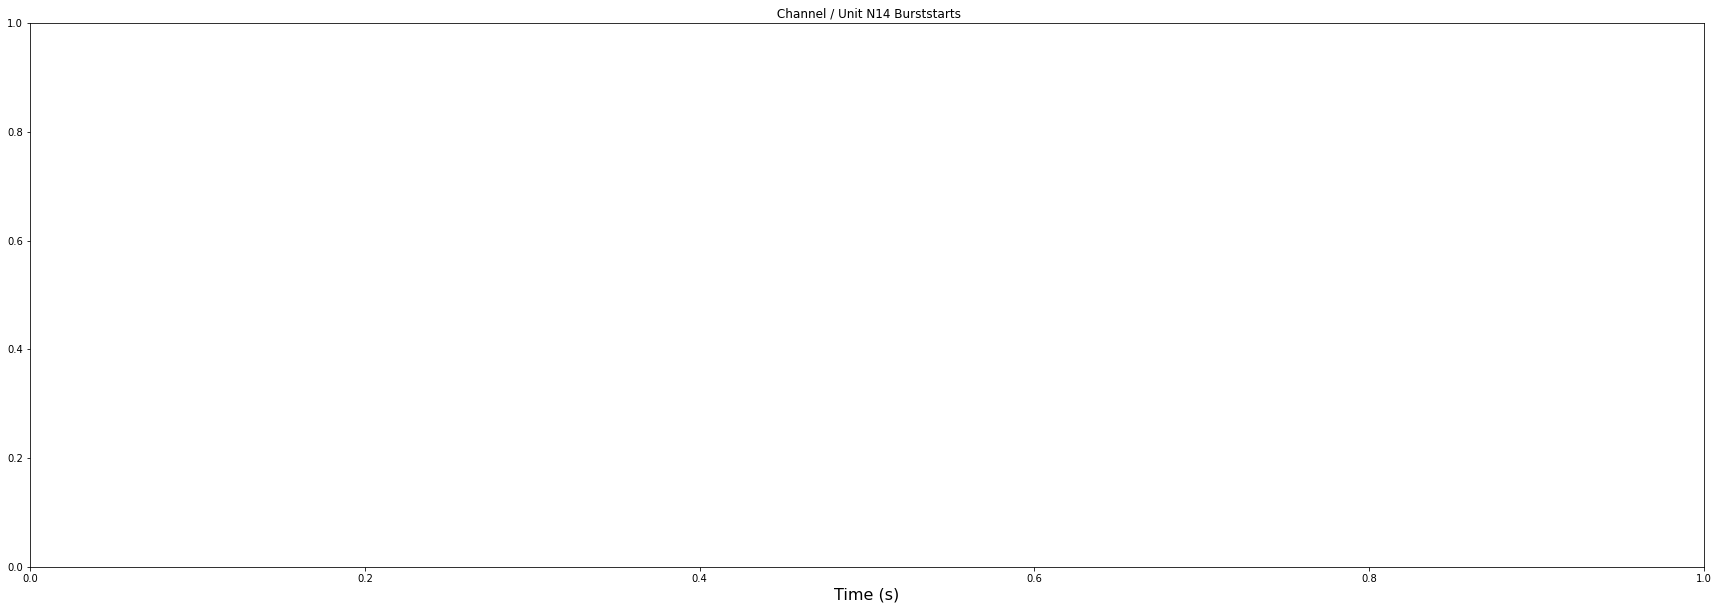

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K10 Burststarts')

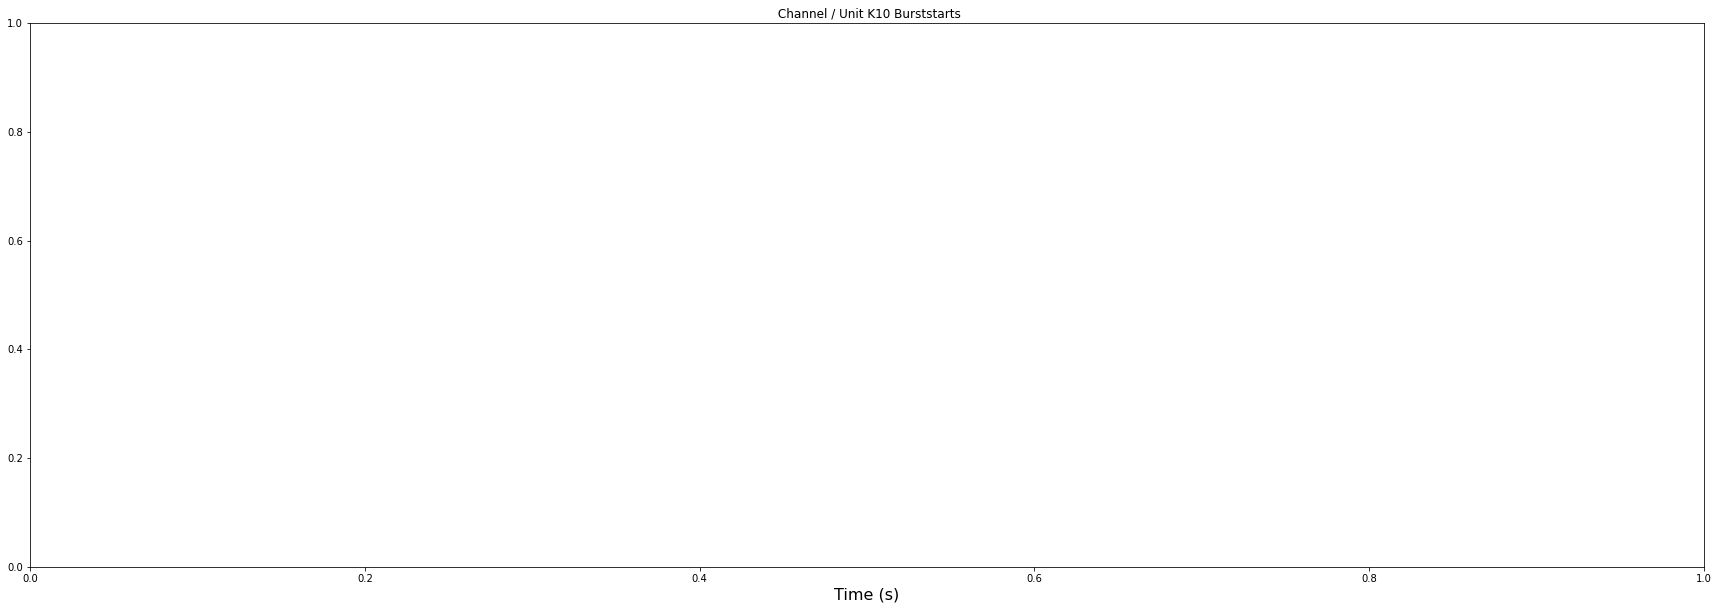

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N16 Burststarts')

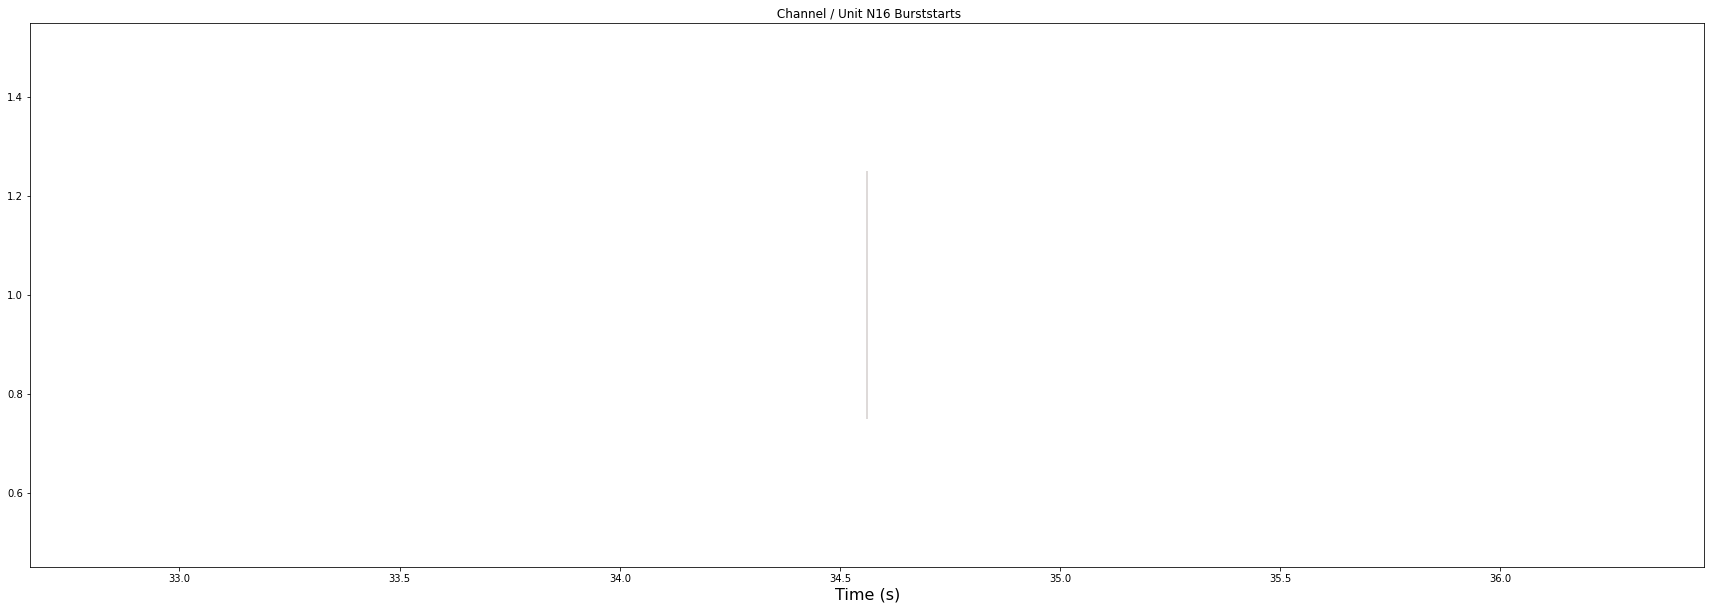

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit N15 Burststarts')

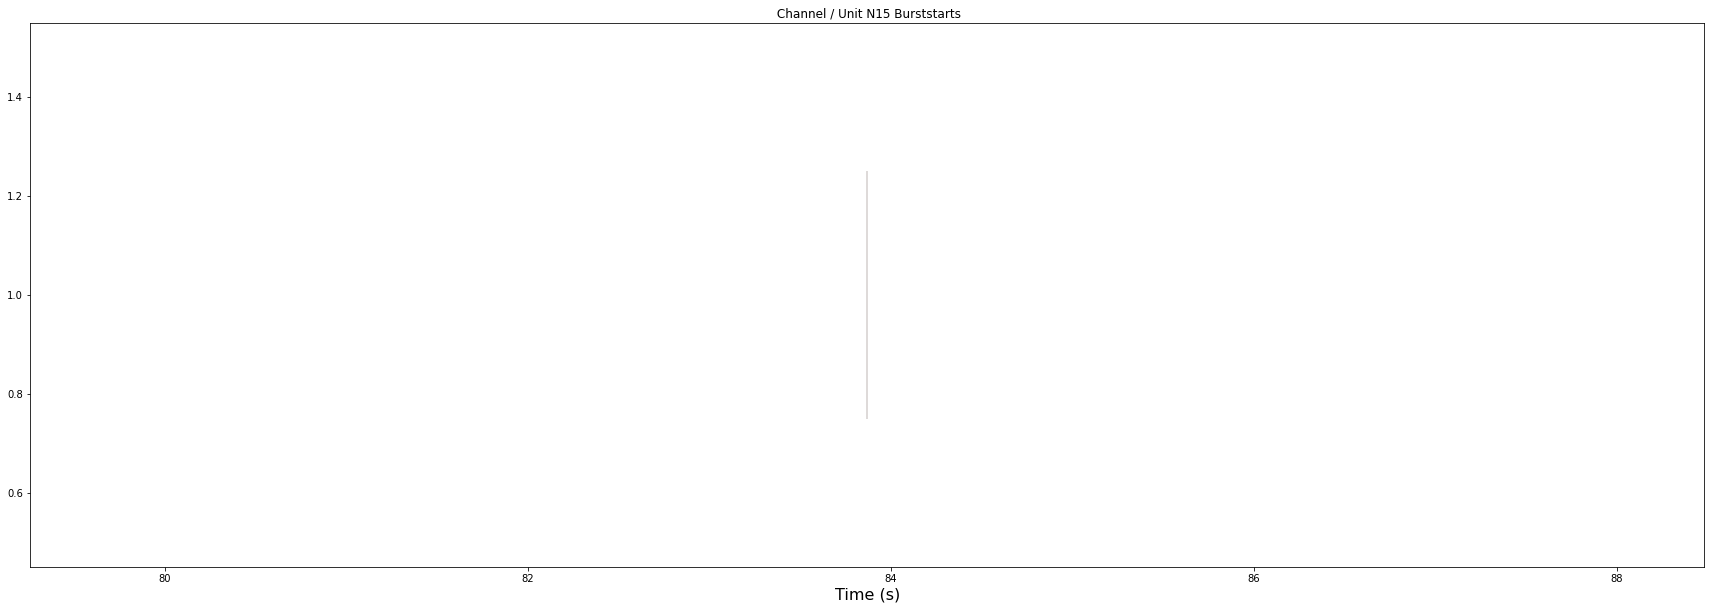

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M13 Burststarts')

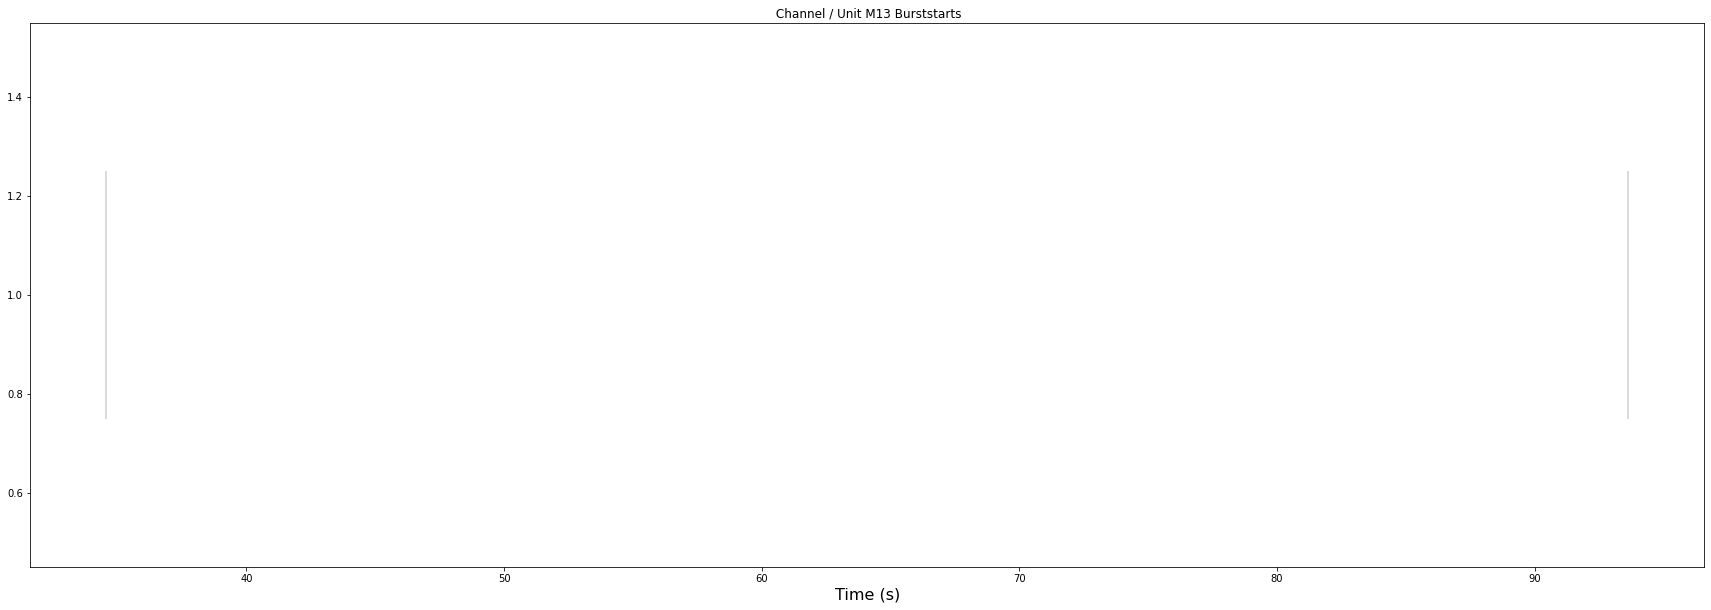

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K11 Burststarts')

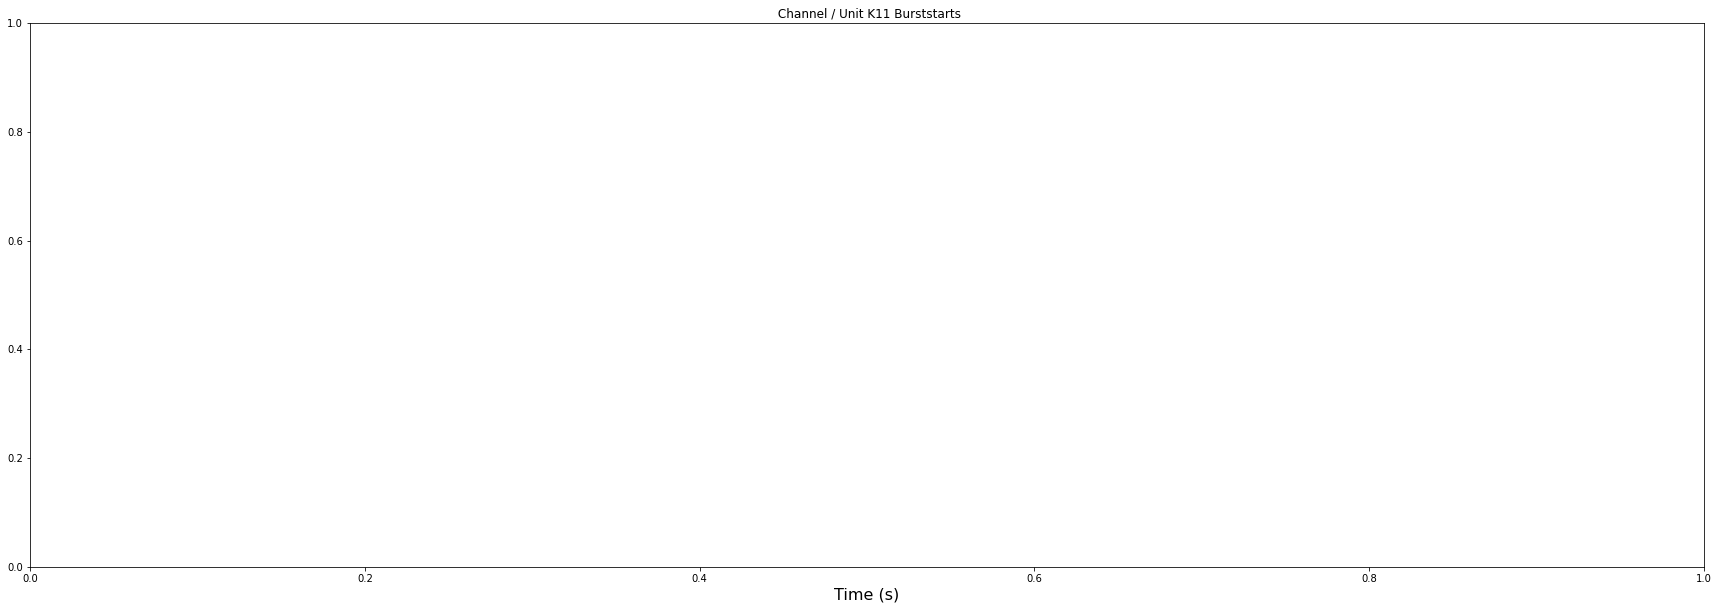

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M15 Burststarts')

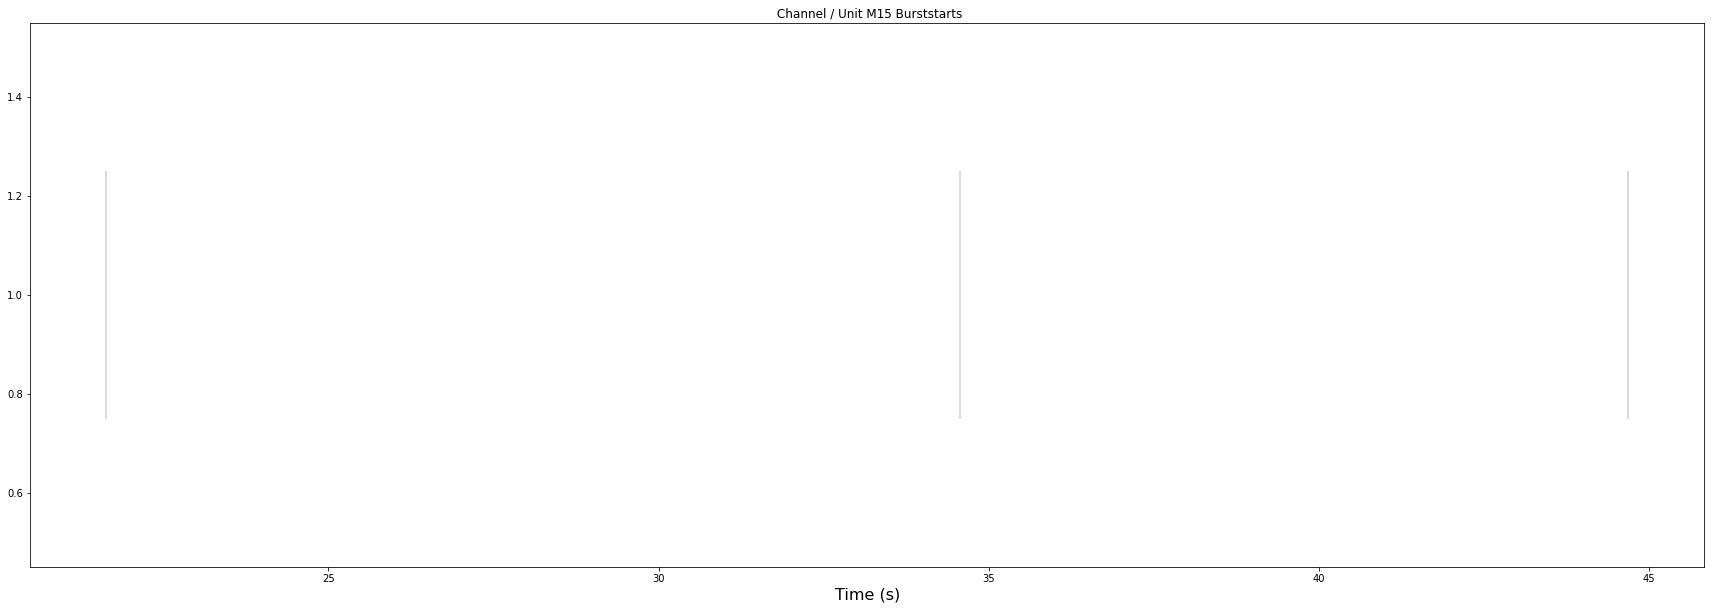

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M14 Burststarts')

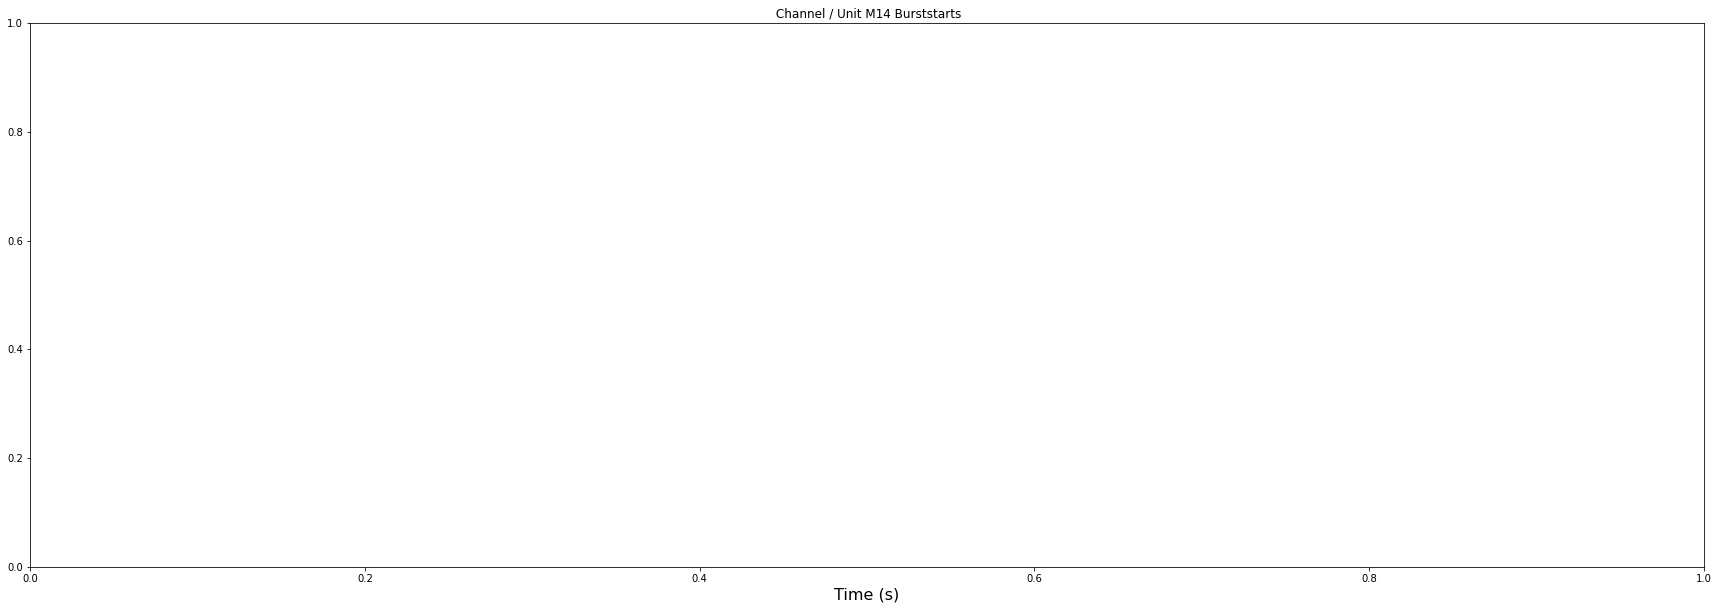

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L12 Burststarts')

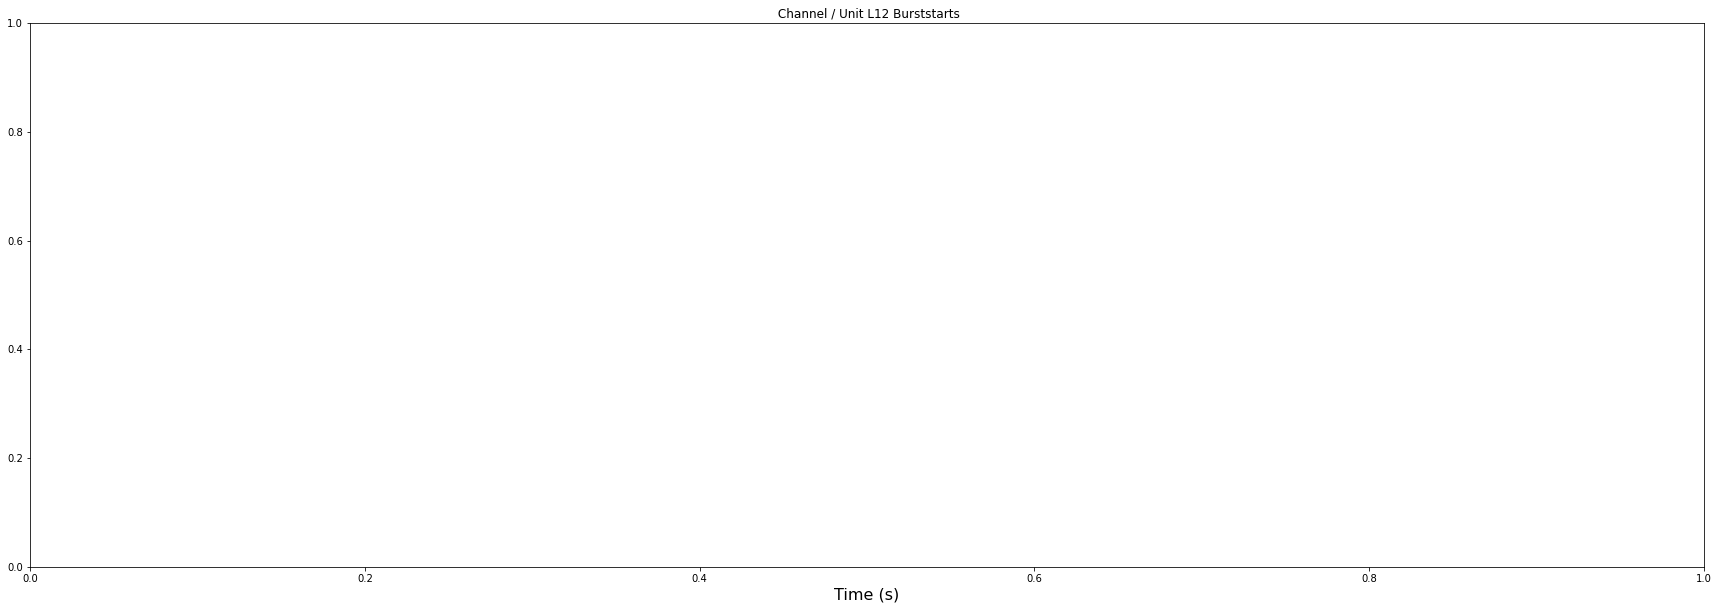

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit M16 Burststarts')

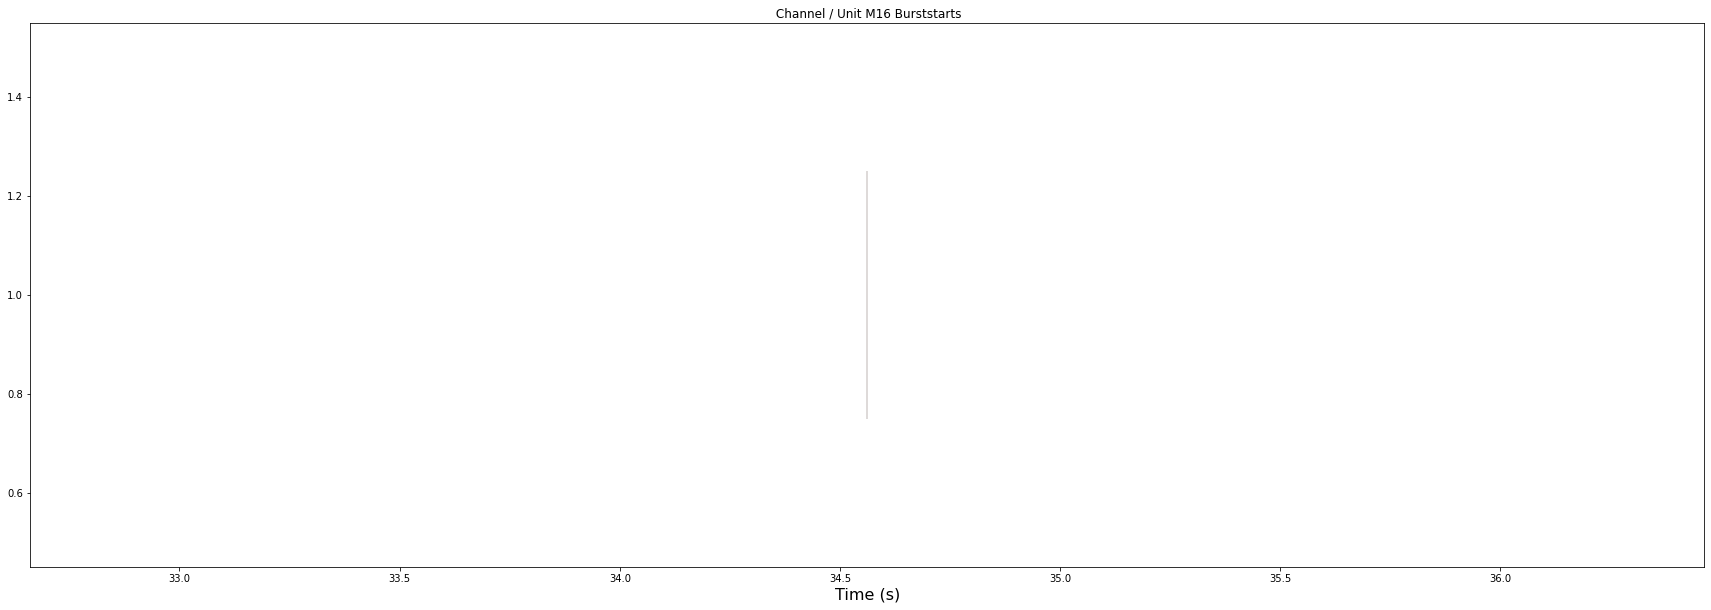

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L14 Burststarts')

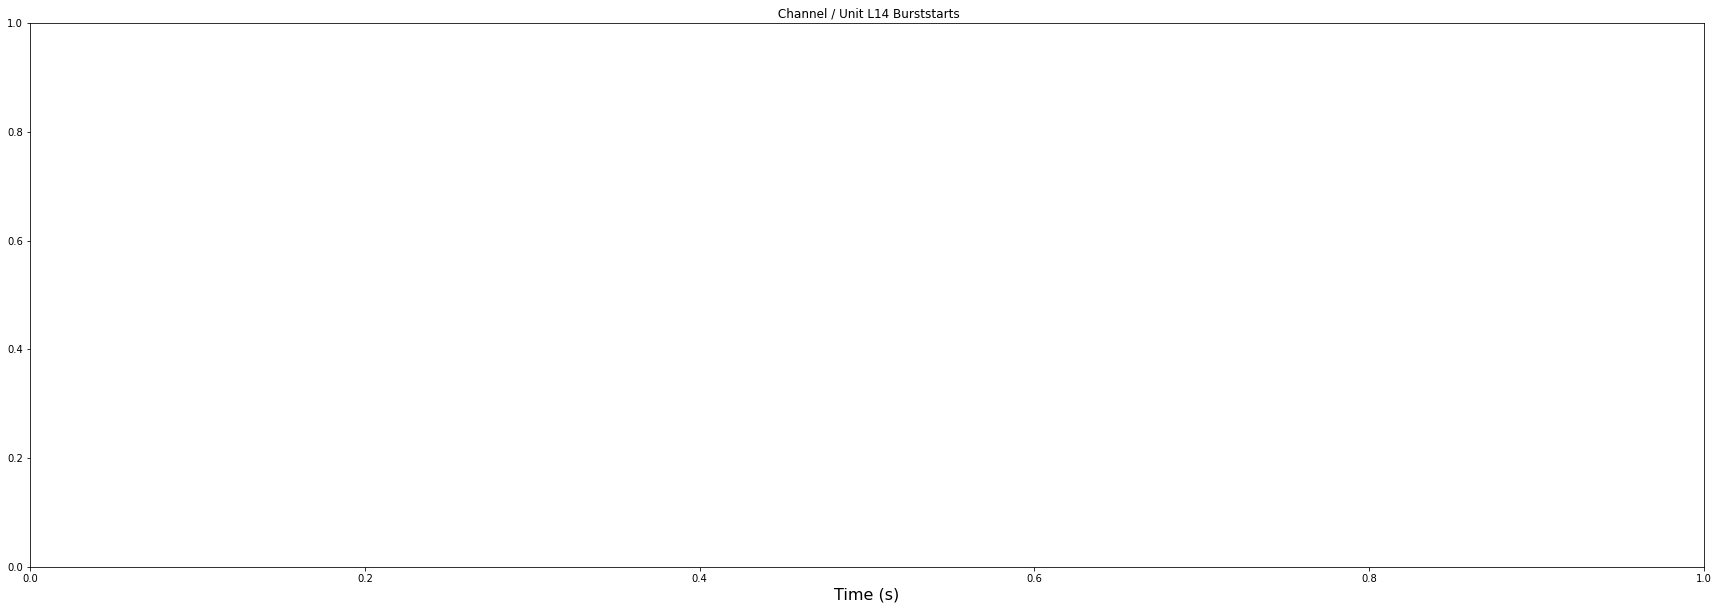

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L13 Burststarts')

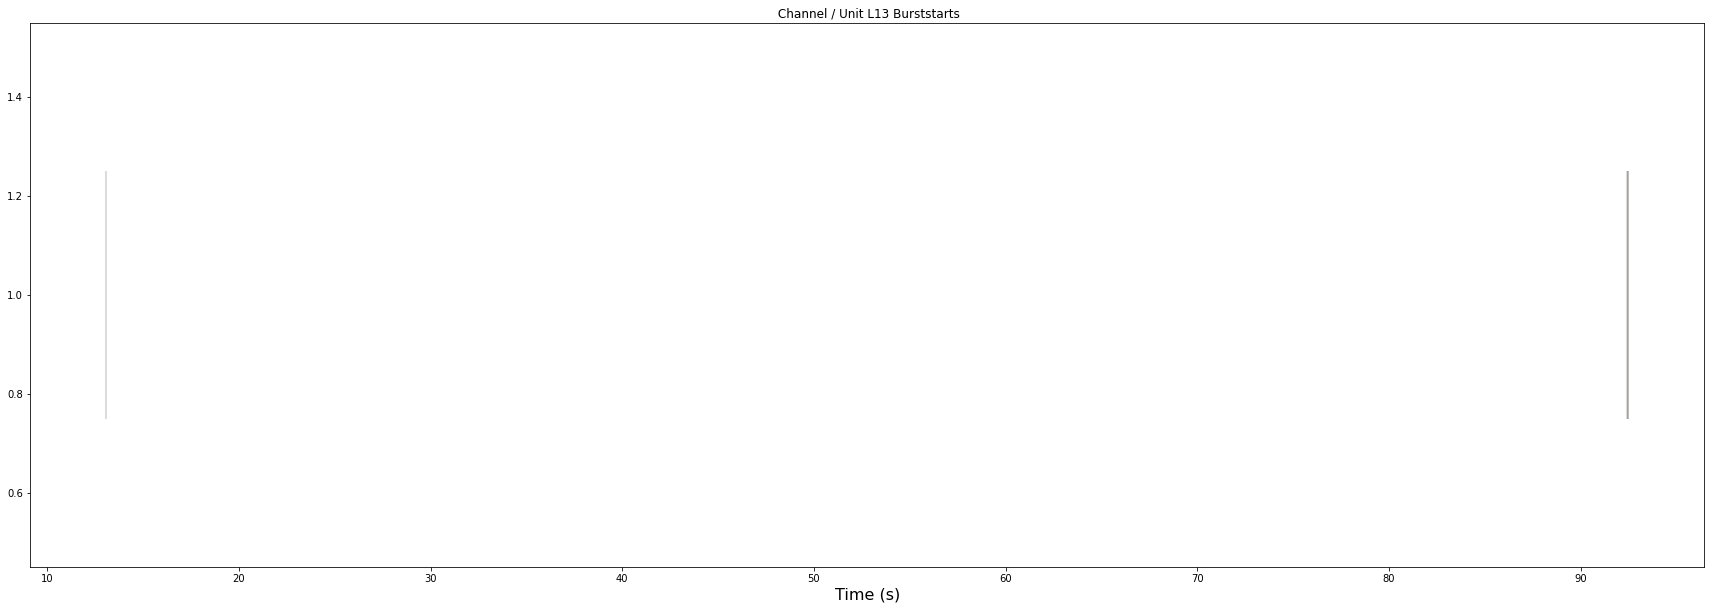

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L16 Burststarts')

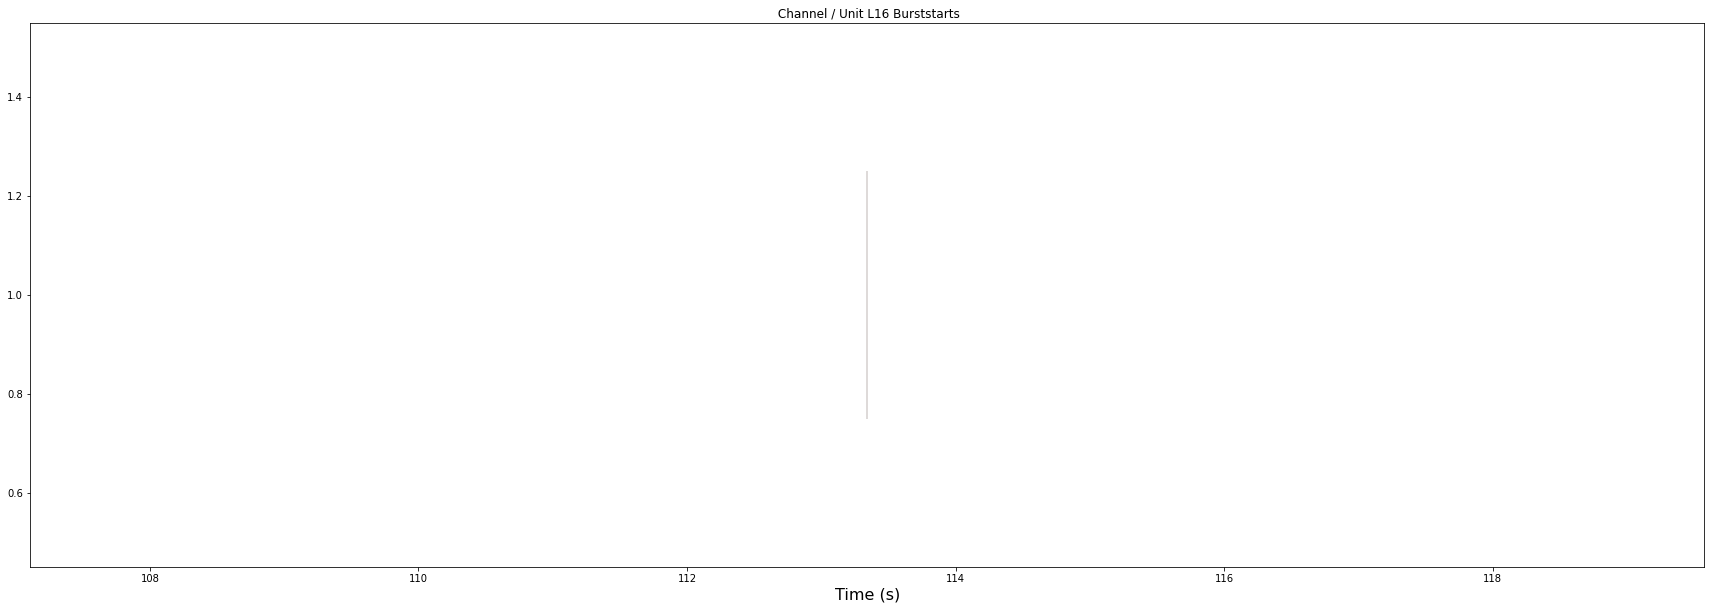

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit L15 Burststarts')

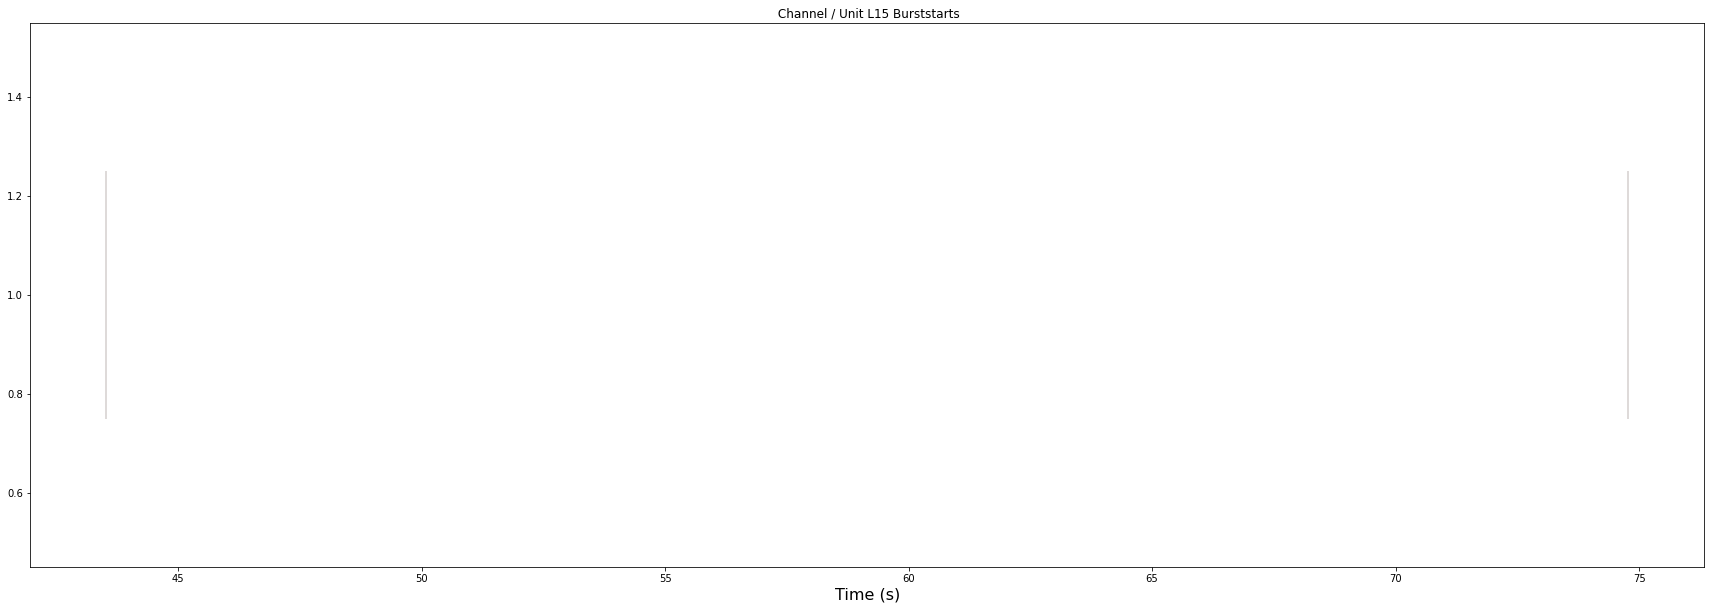

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K13 Burststarts')

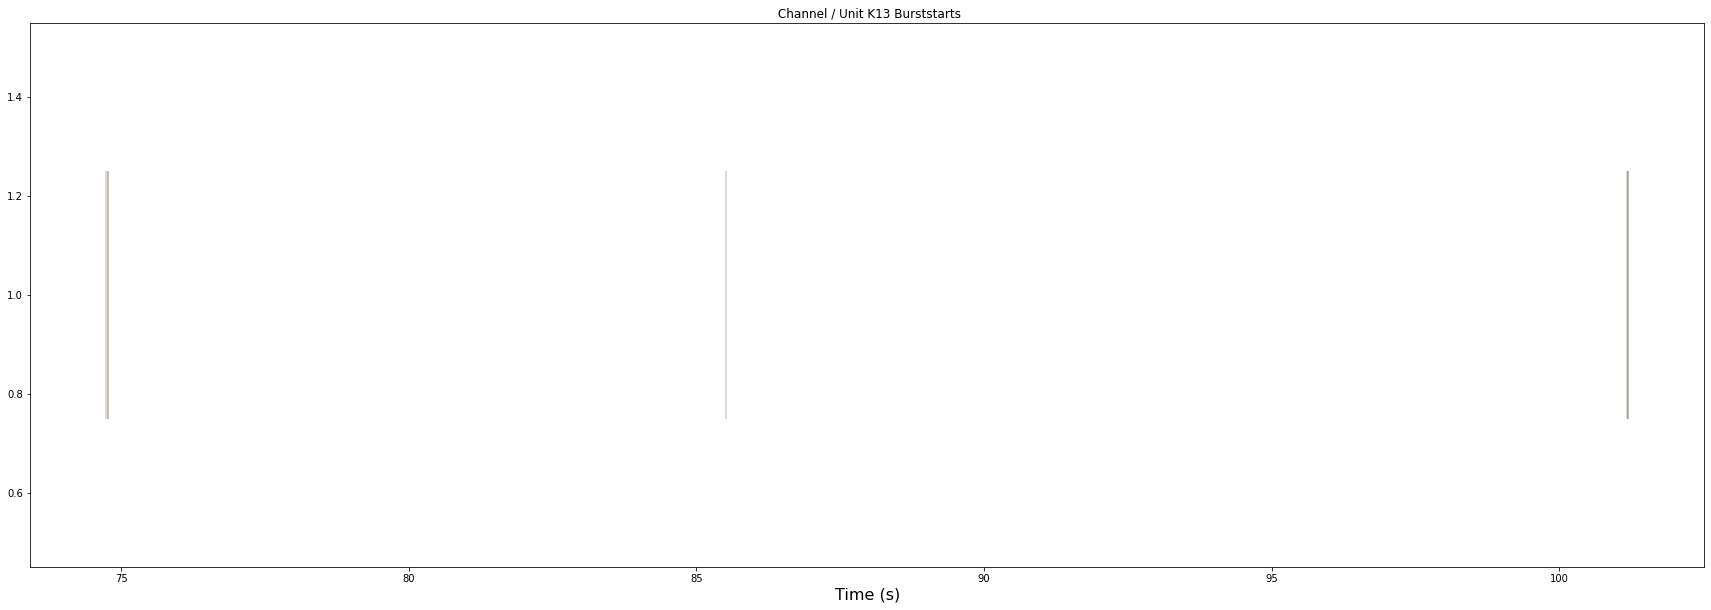

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K12 Burststarts')

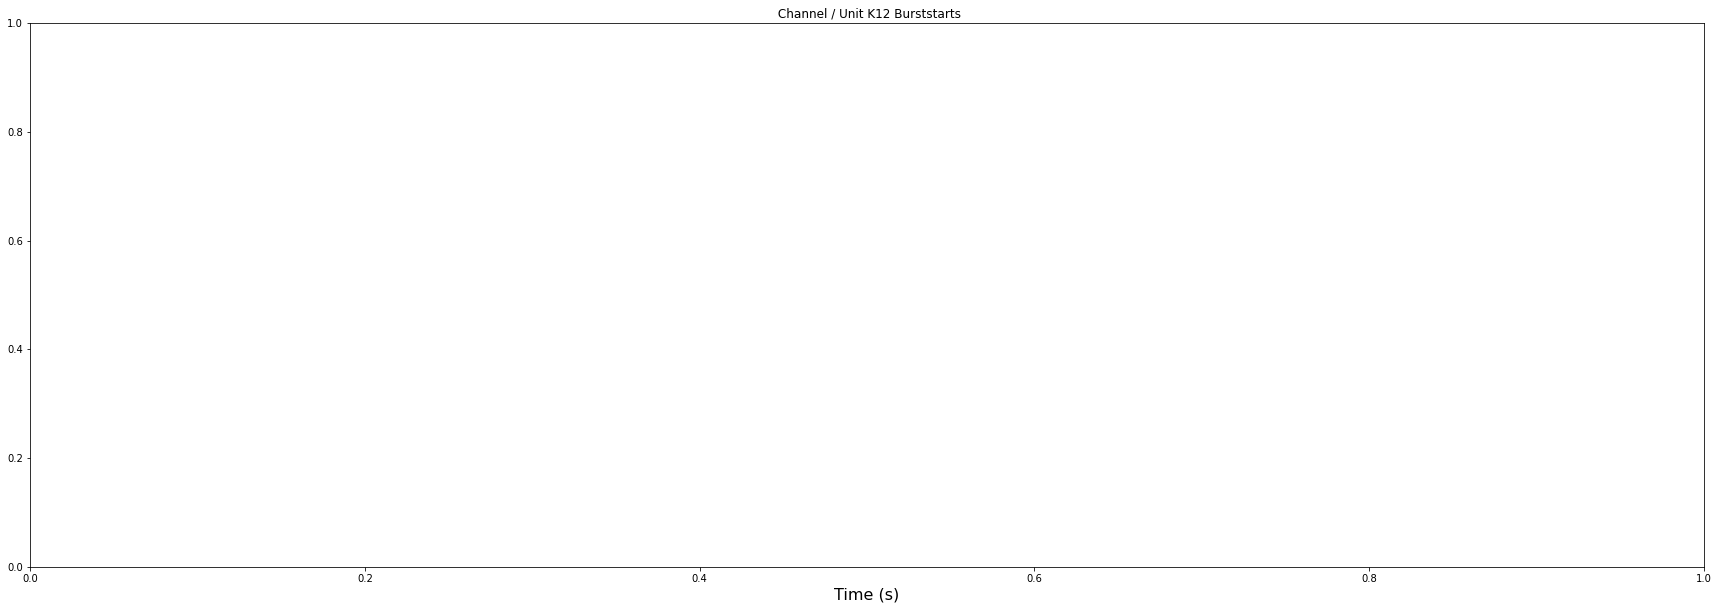

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K15 Burststarts')

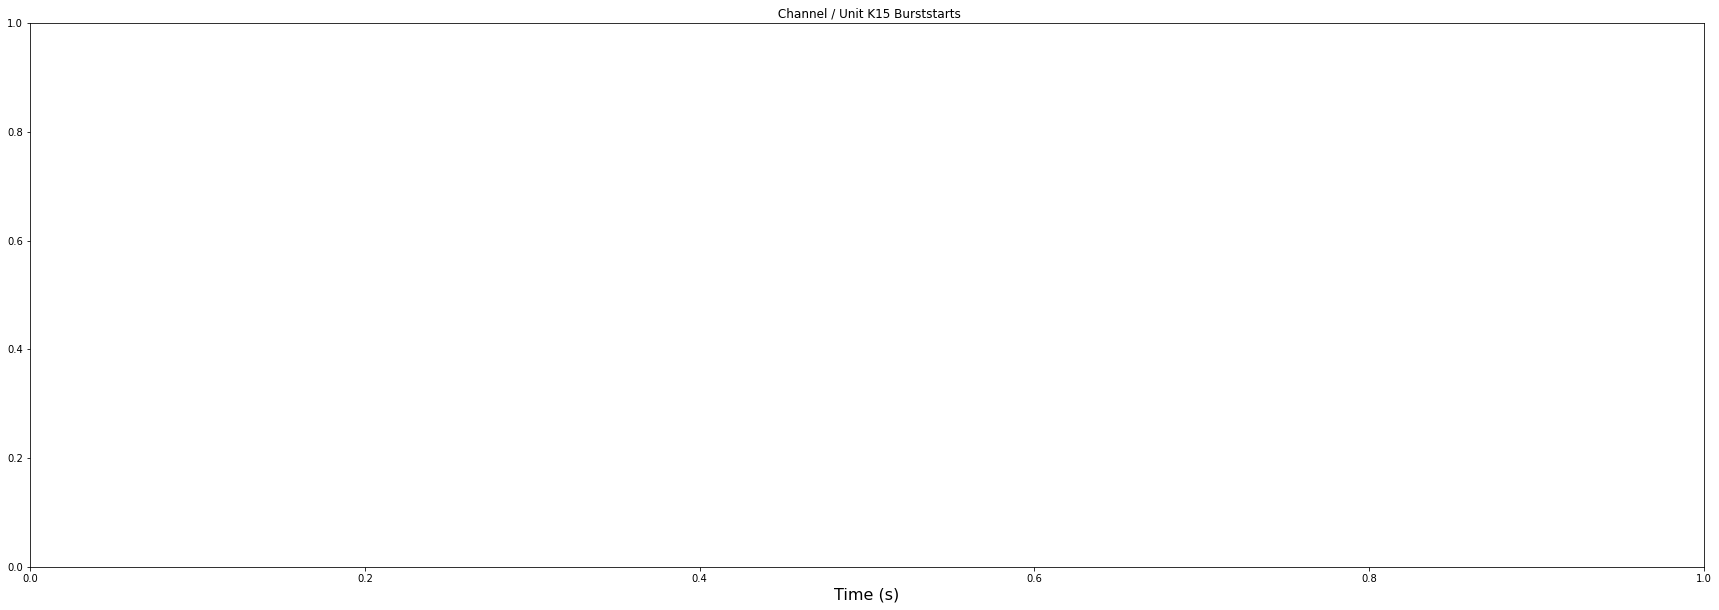

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K14 Burststarts')

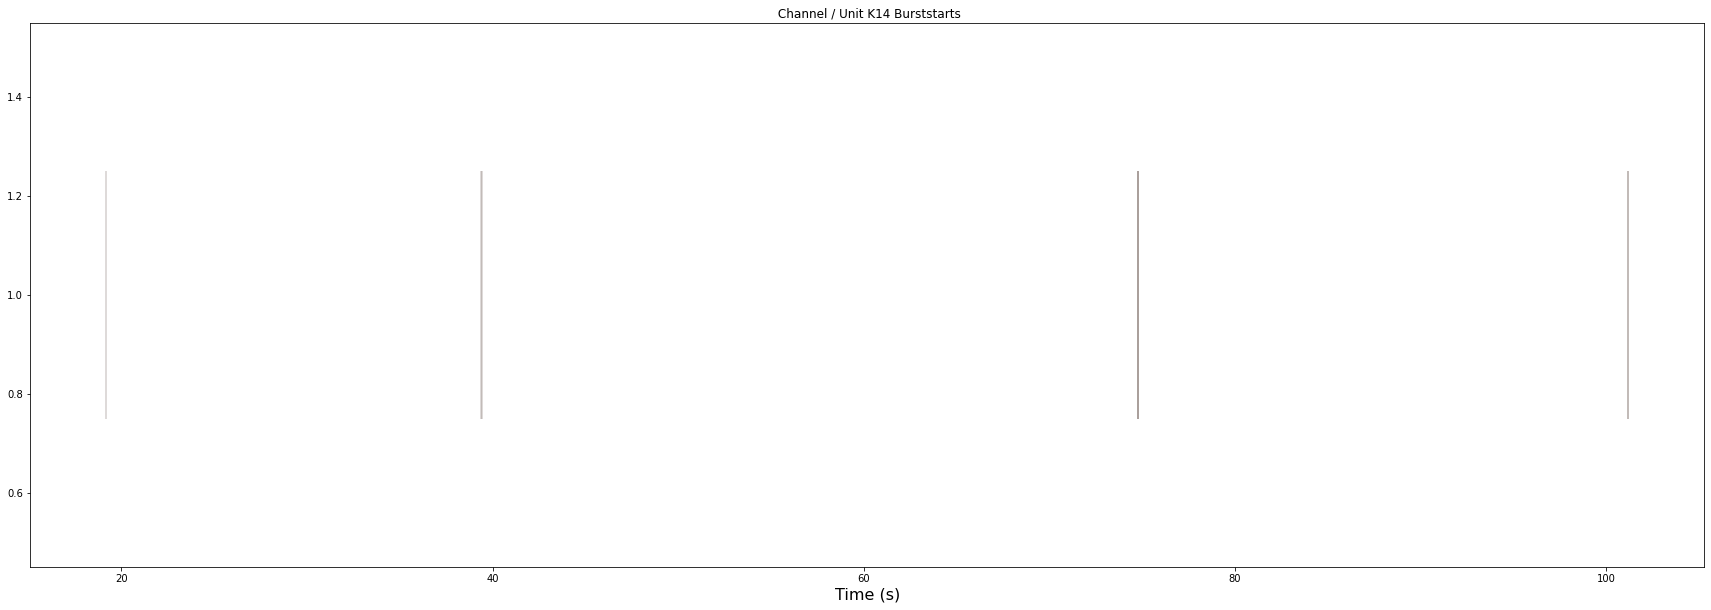

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J12 Burststarts')

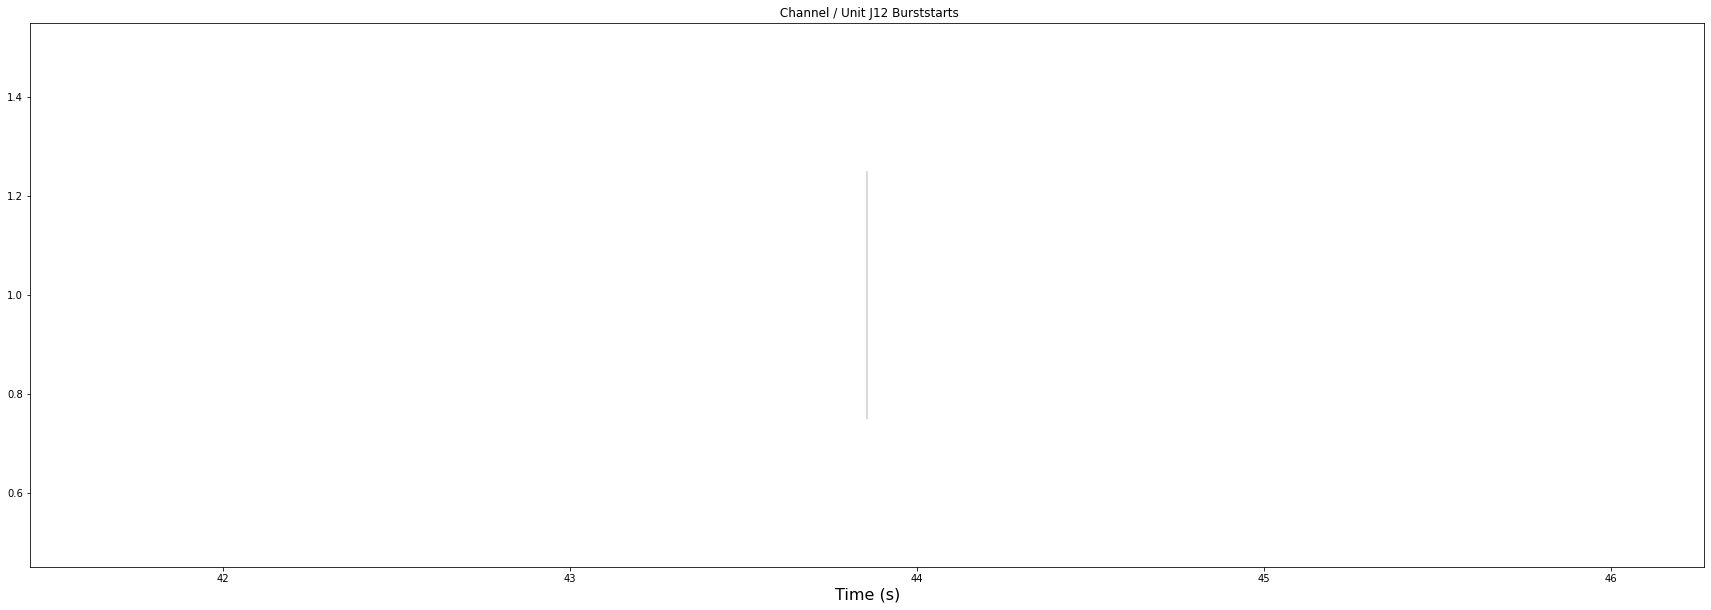

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit K16 Burststarts')

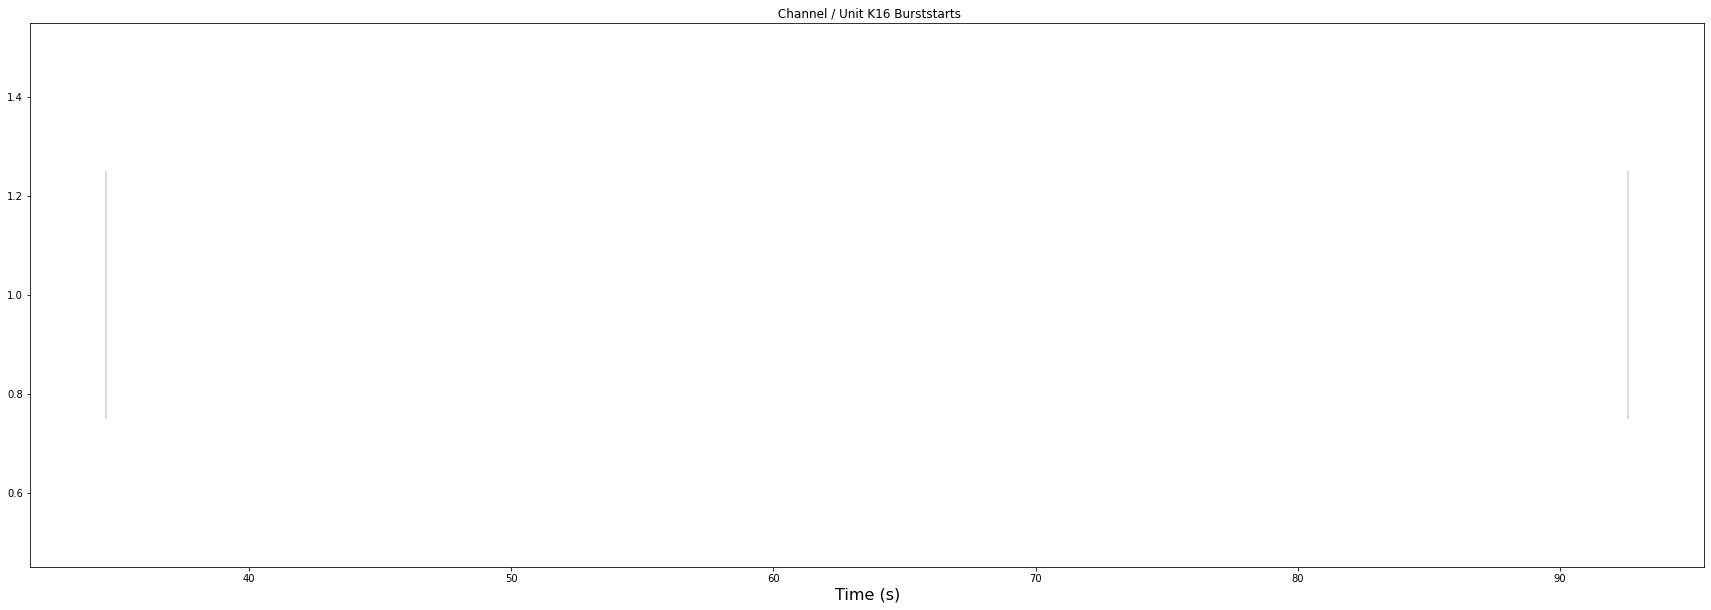

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J14 Burststarts')

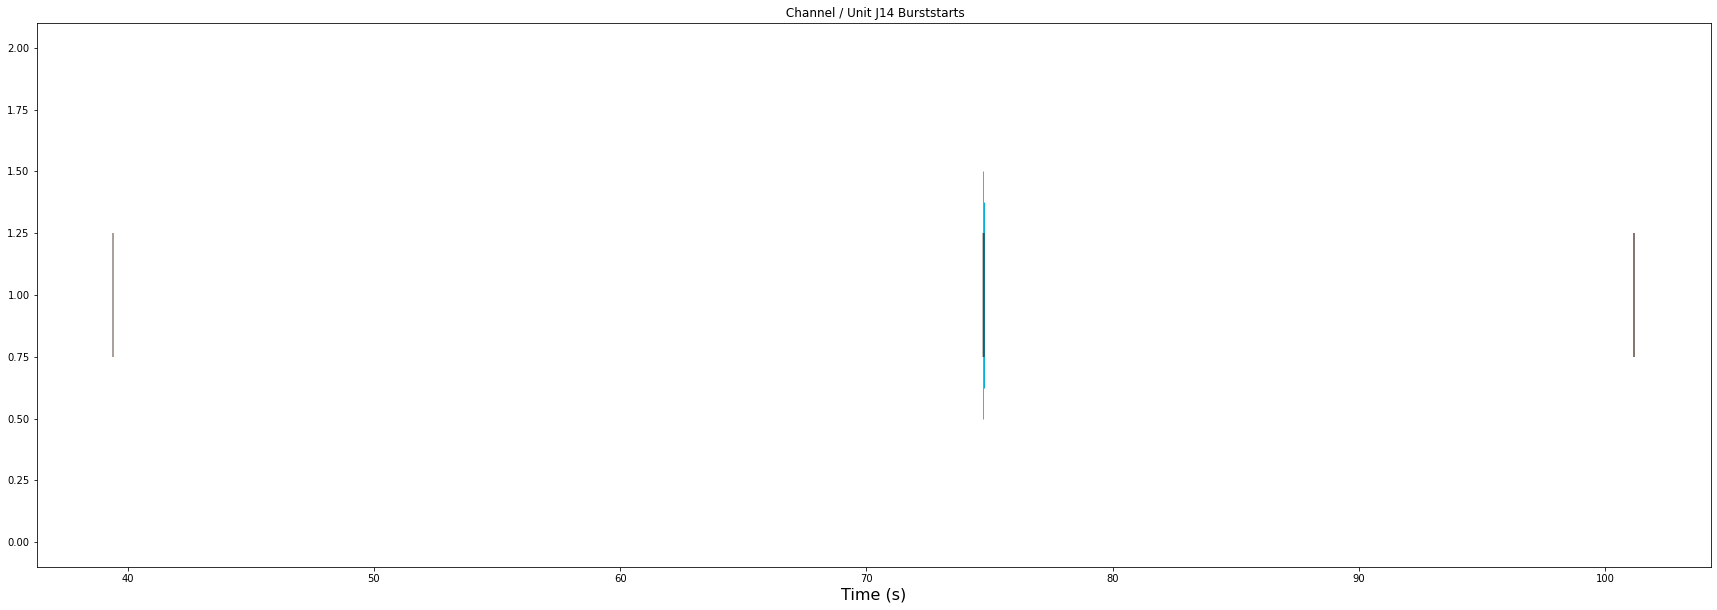

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J13 Burststarts')

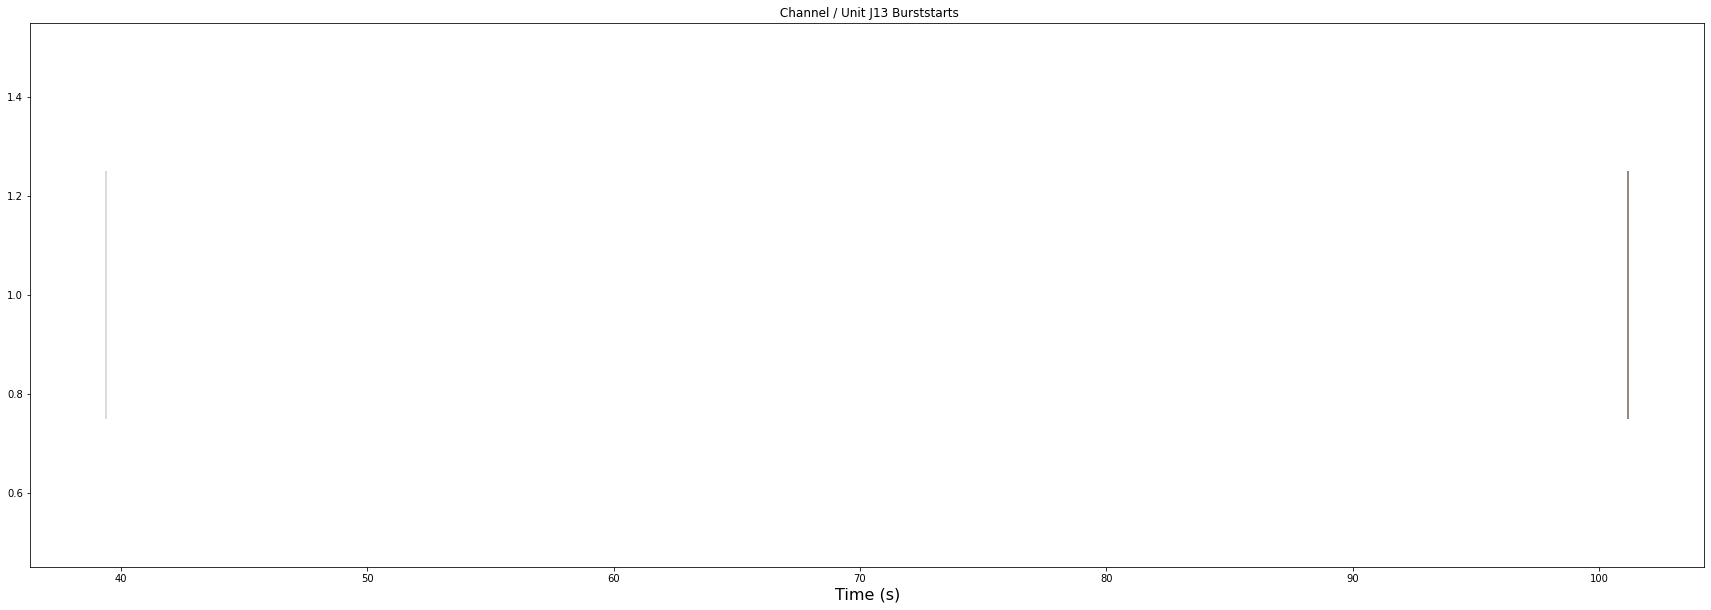

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J16 Burststarts')

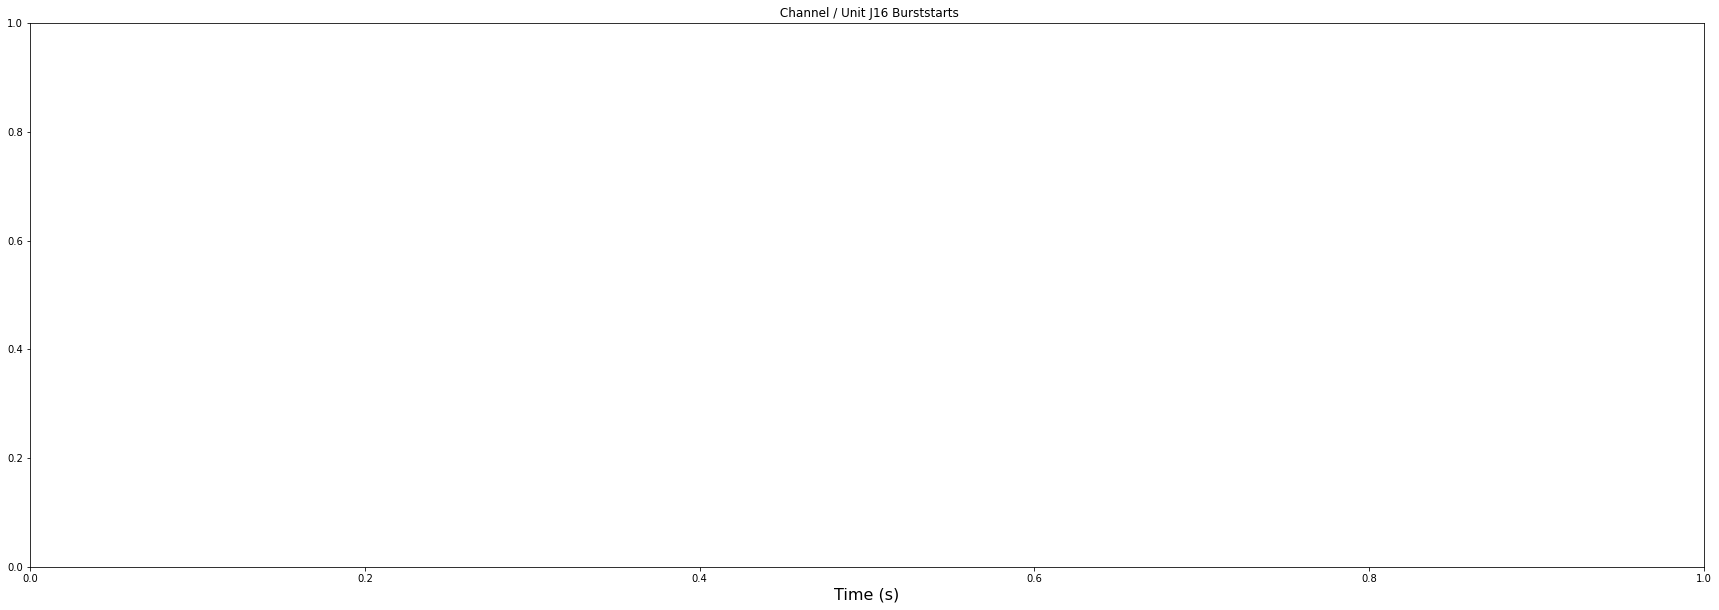

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J15 Burststarts')

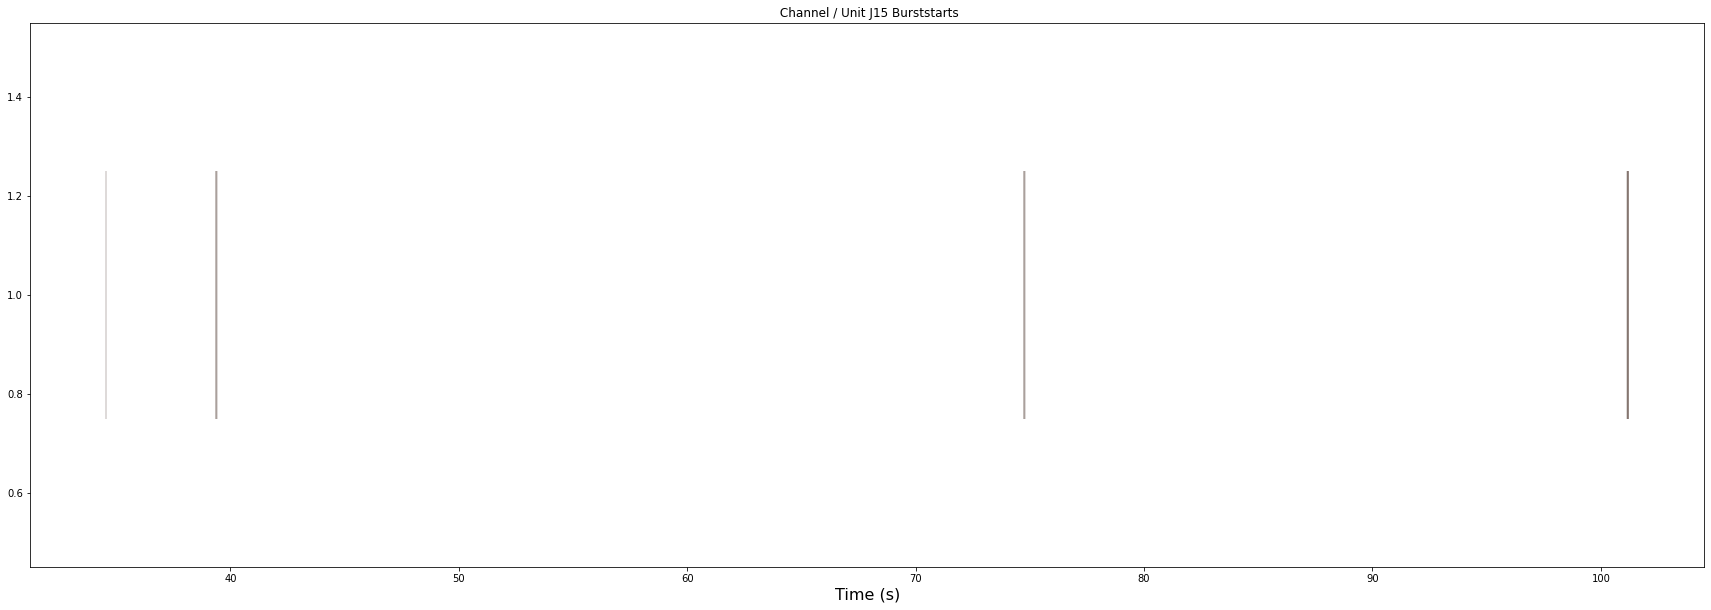

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J10 Burststarts')

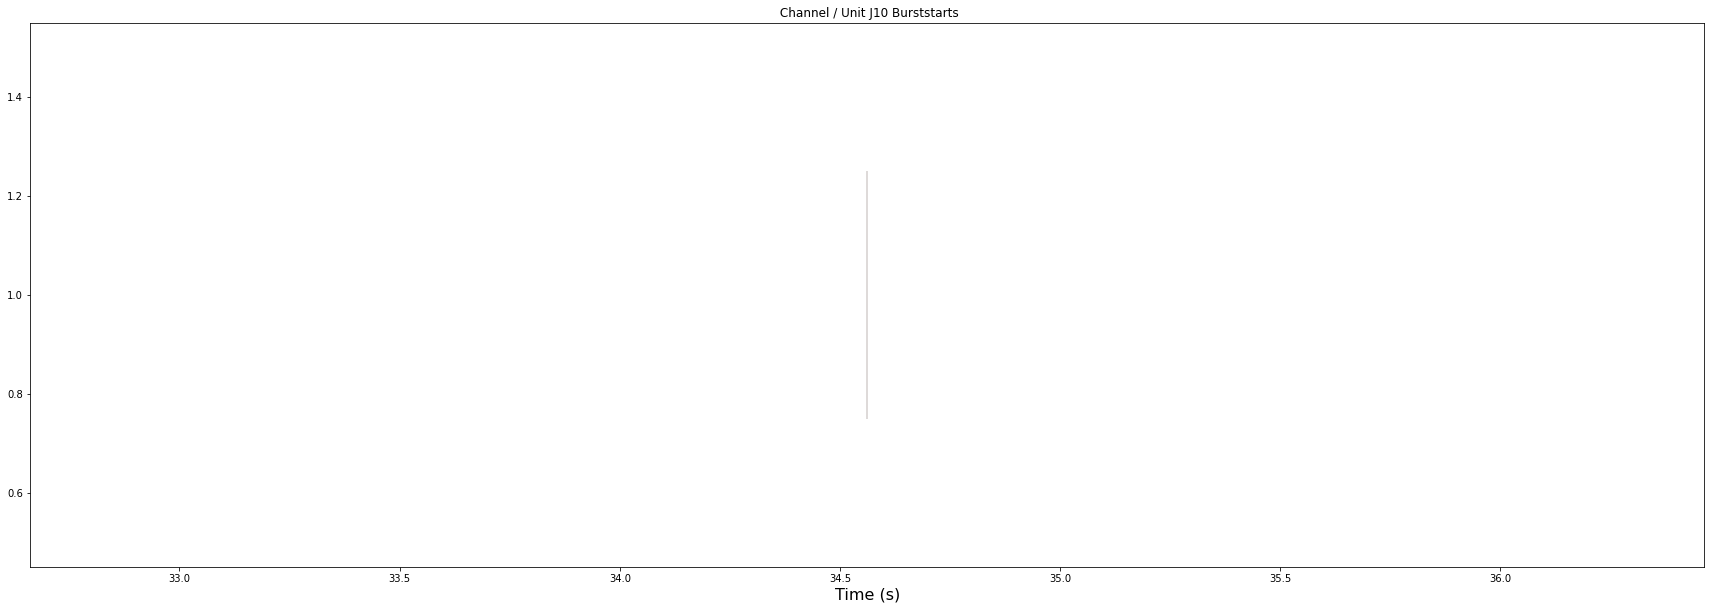

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit J11 Burststarts')

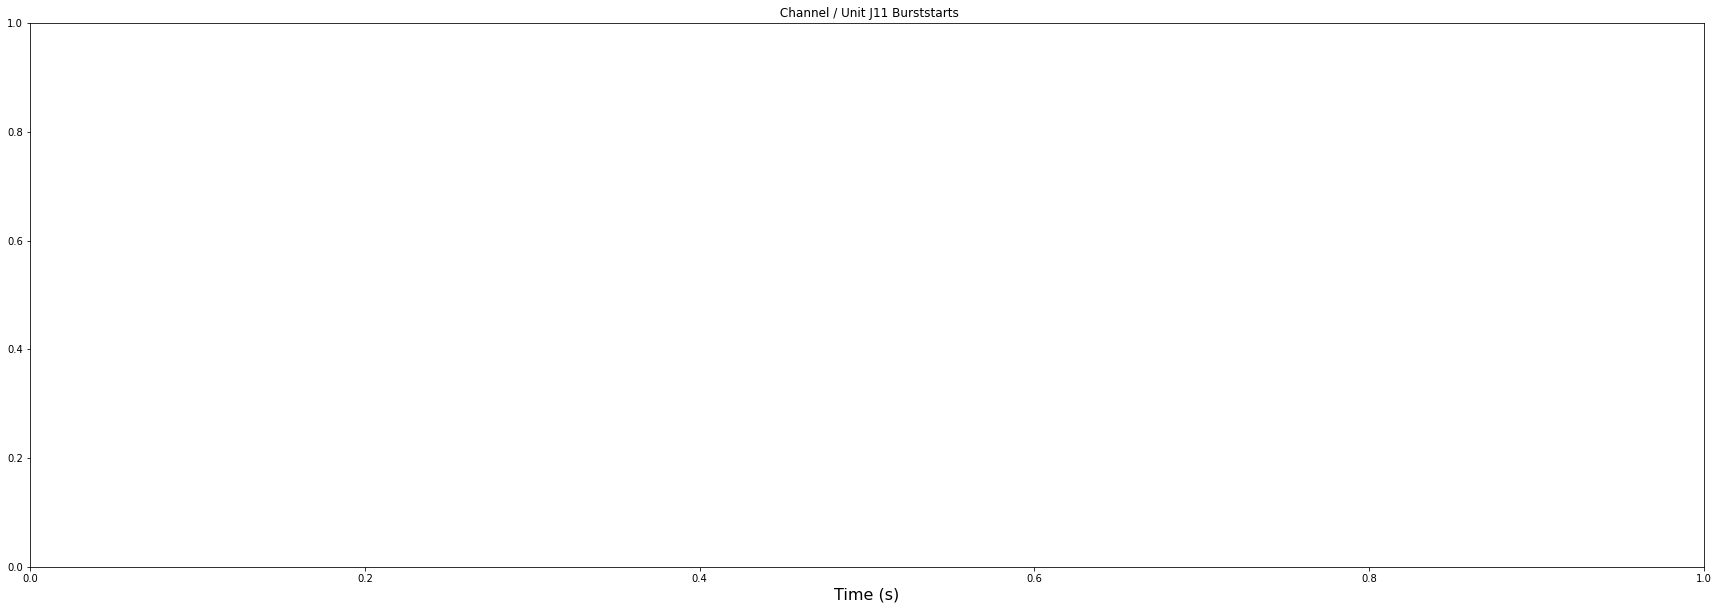

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H11 Burststarts')

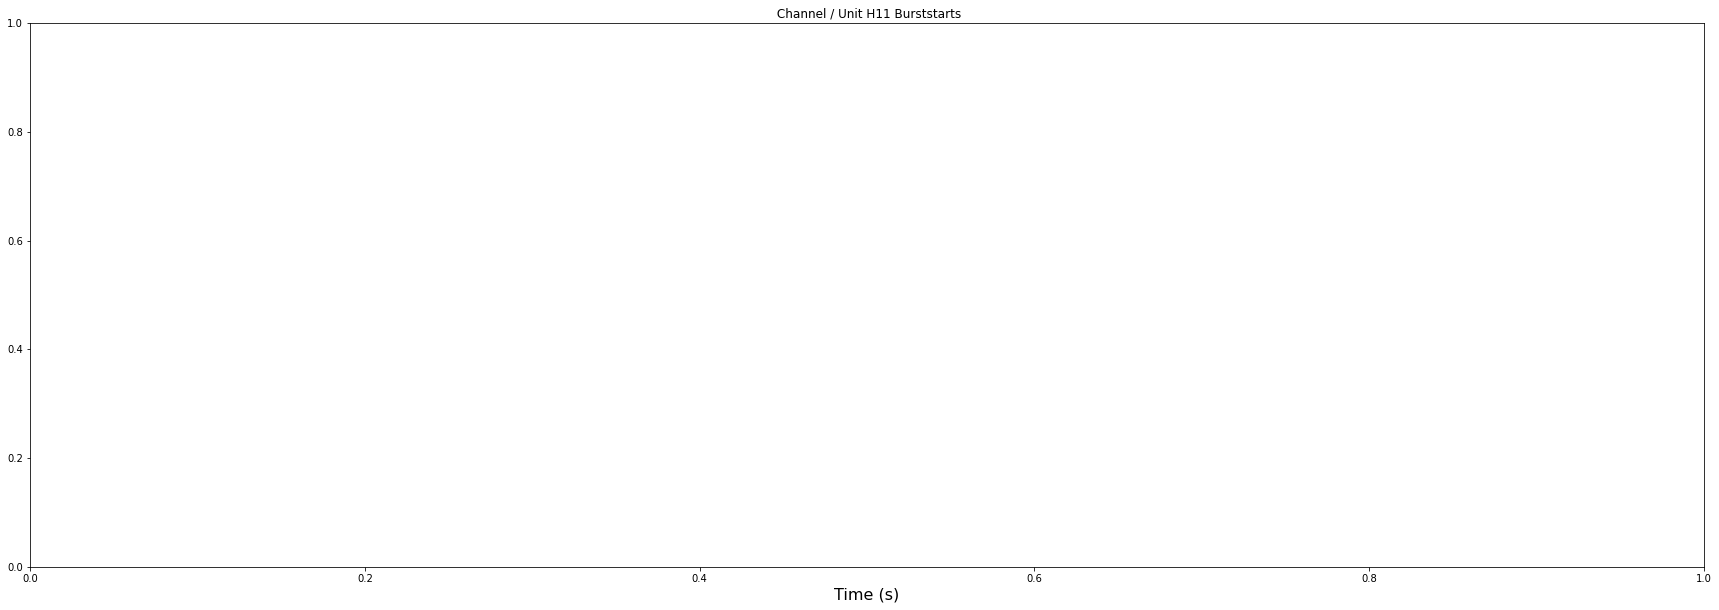

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H10 Burststarts')

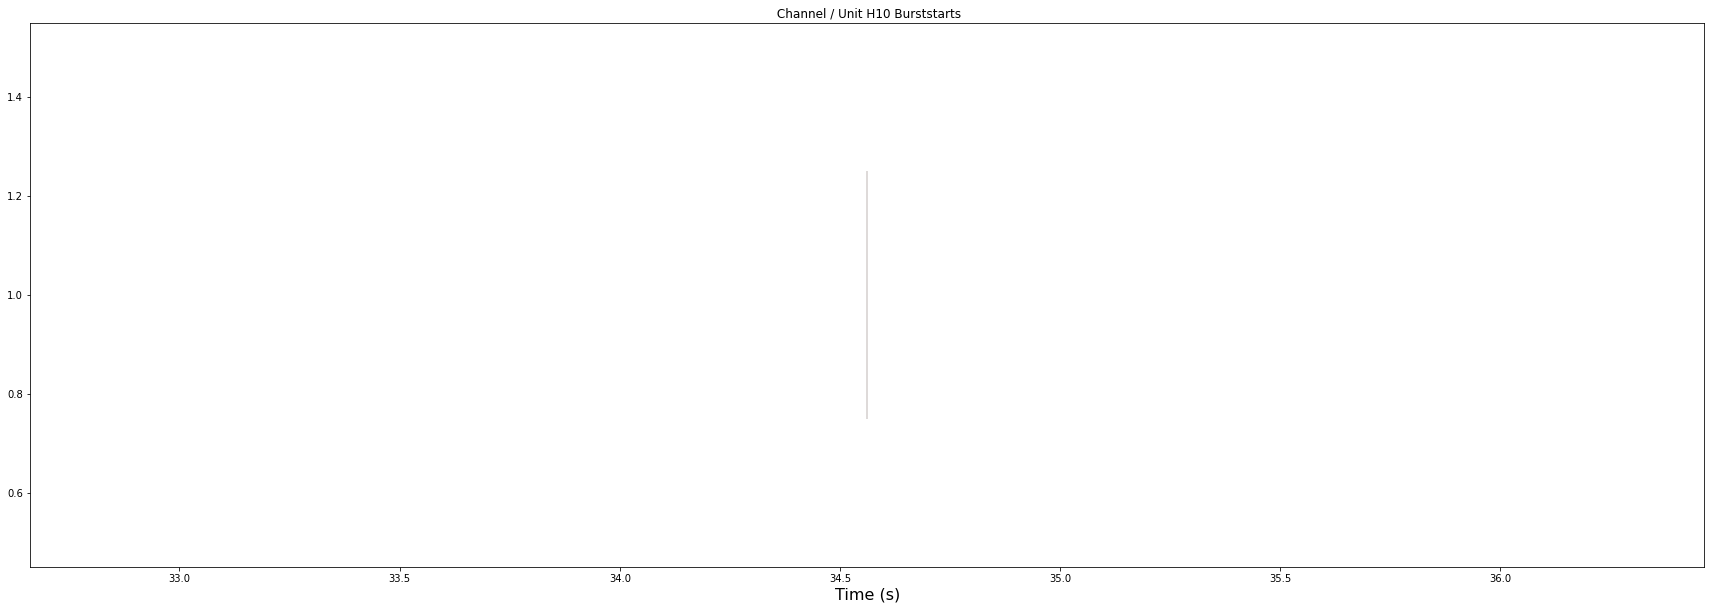

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H15 Burststarts')

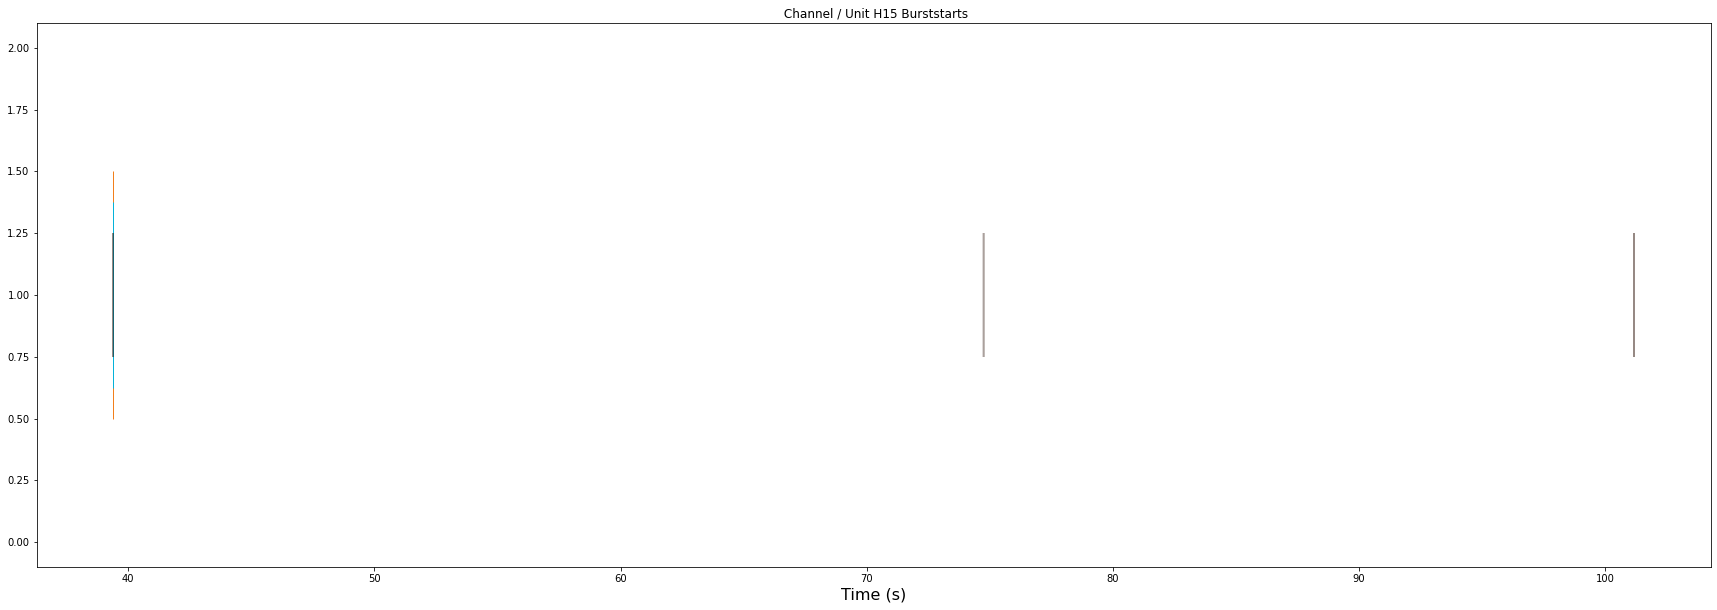

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H16 Burststarts')

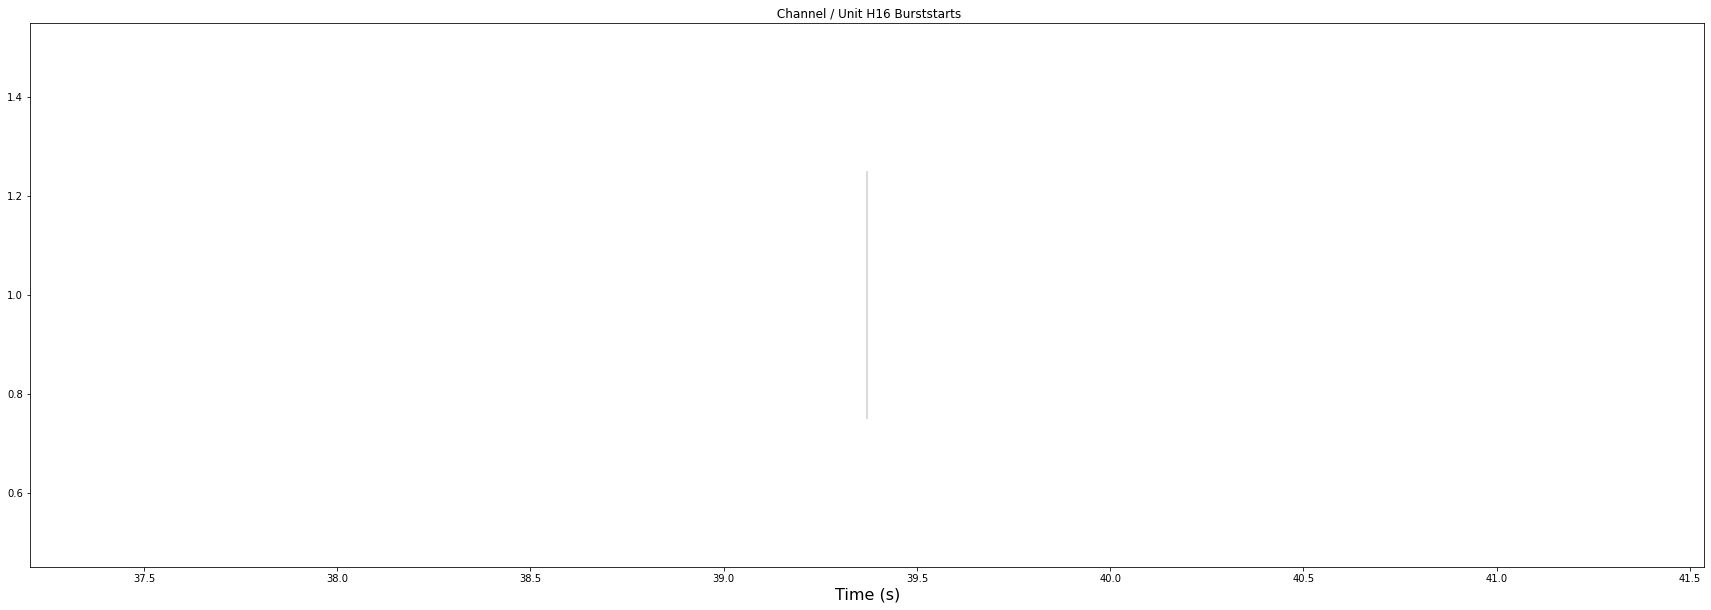

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H13 Burststarts')

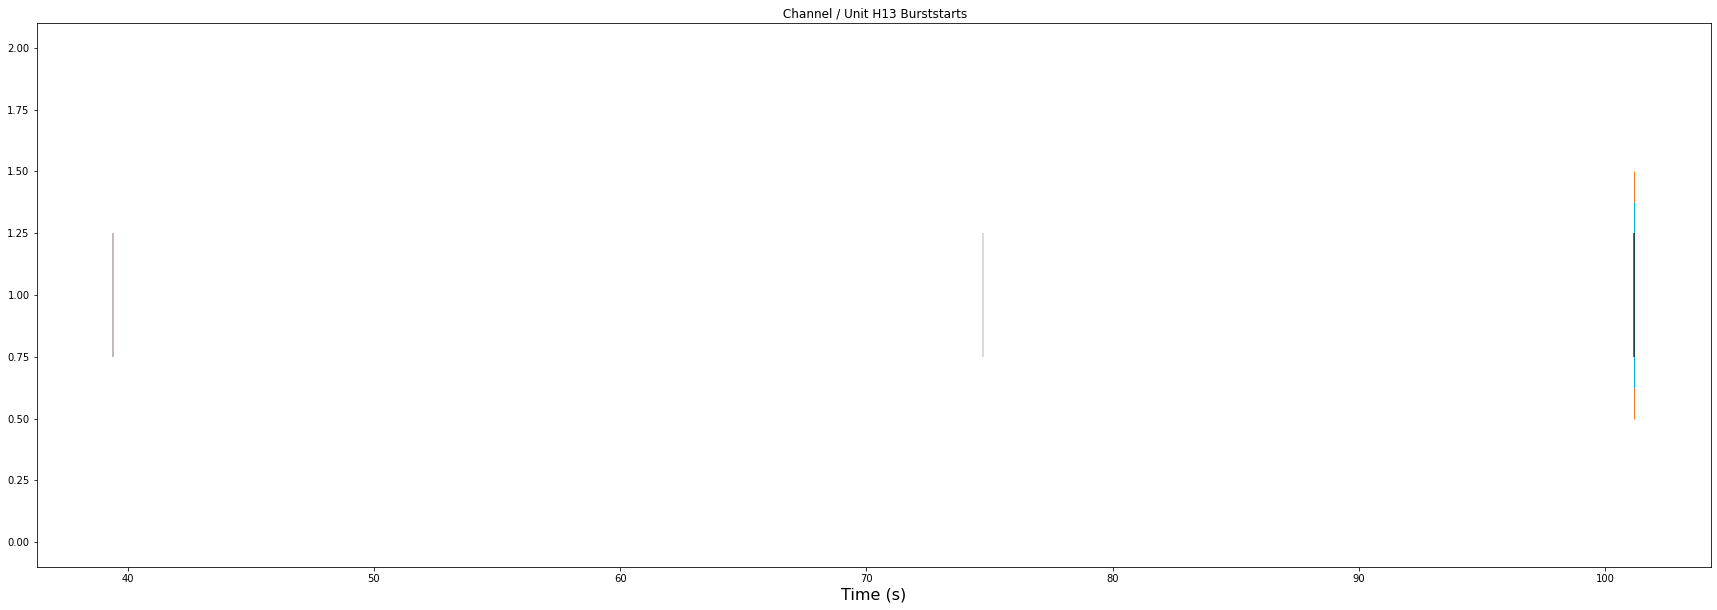

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H14 Burststarts')

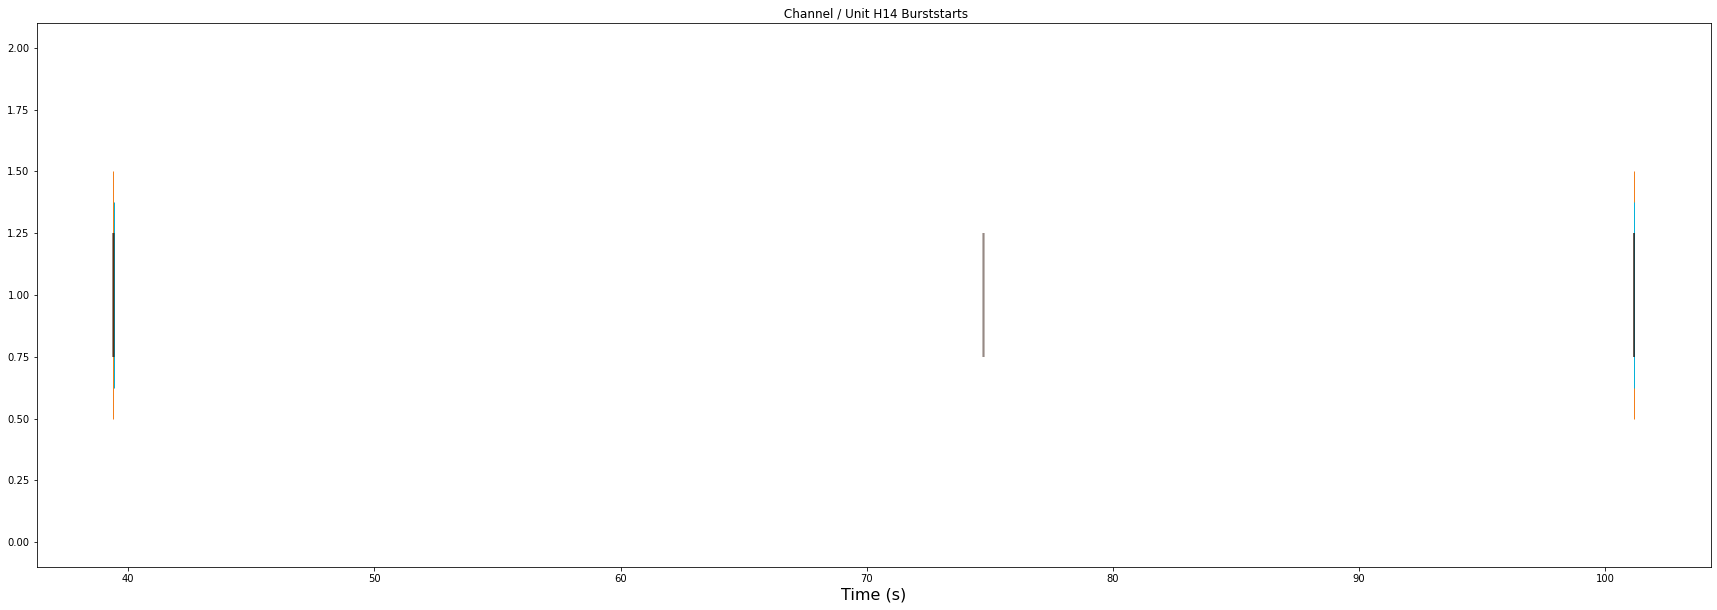

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G16 Burststarts')

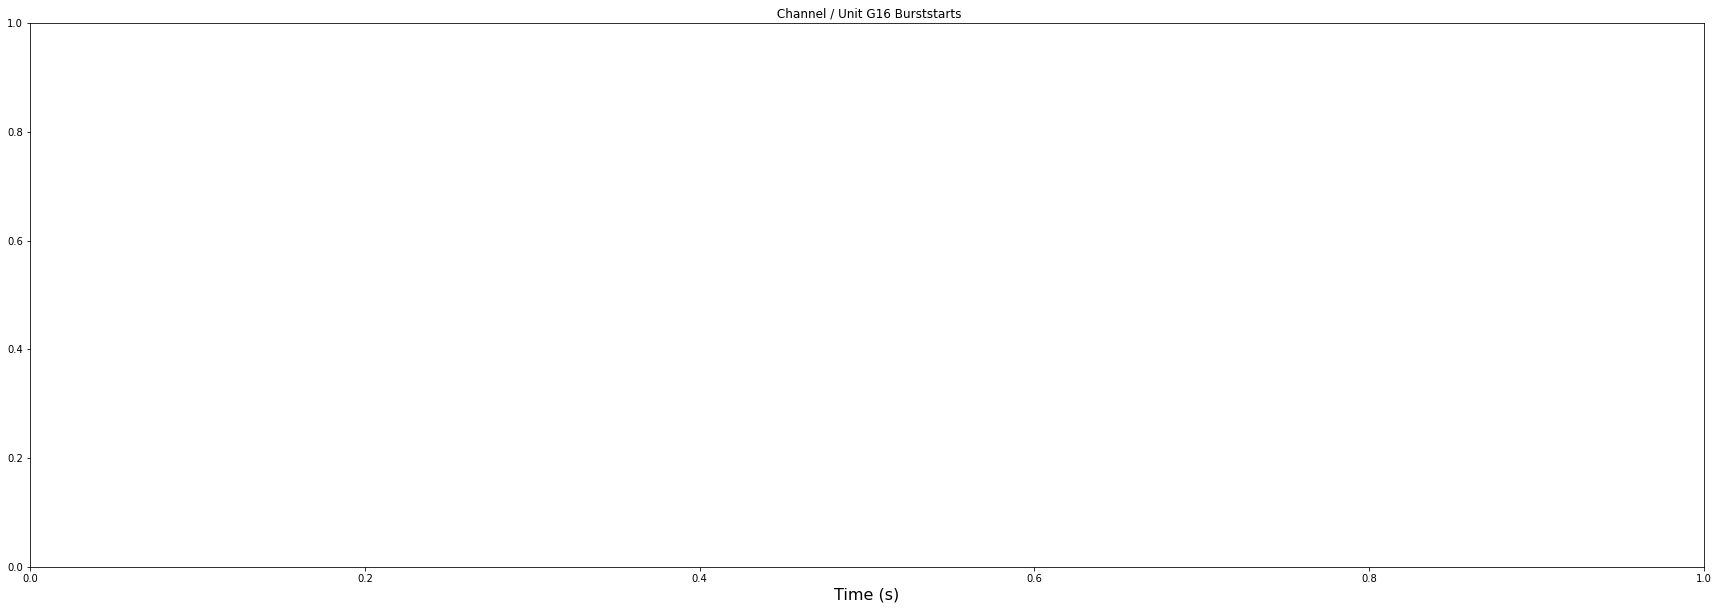

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit H12 Burststarts')

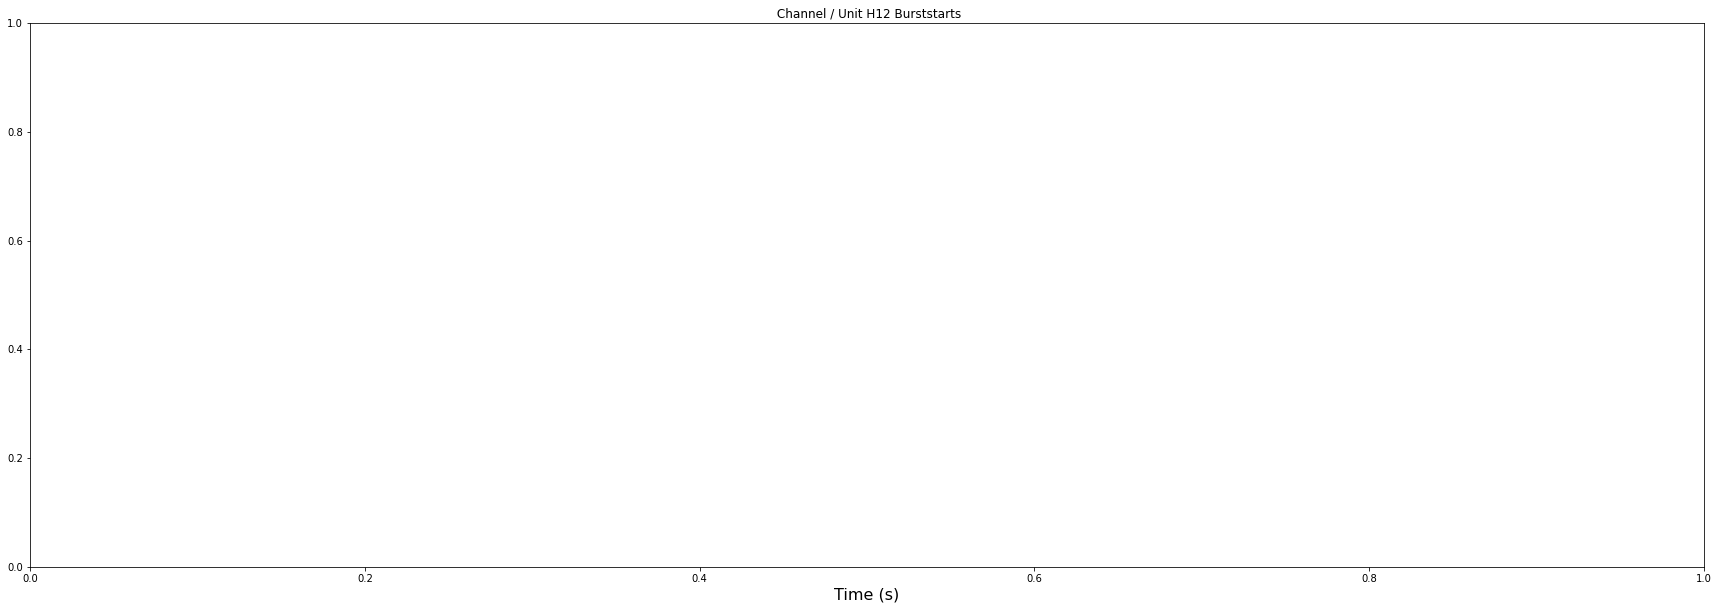

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G14 Burststarts')

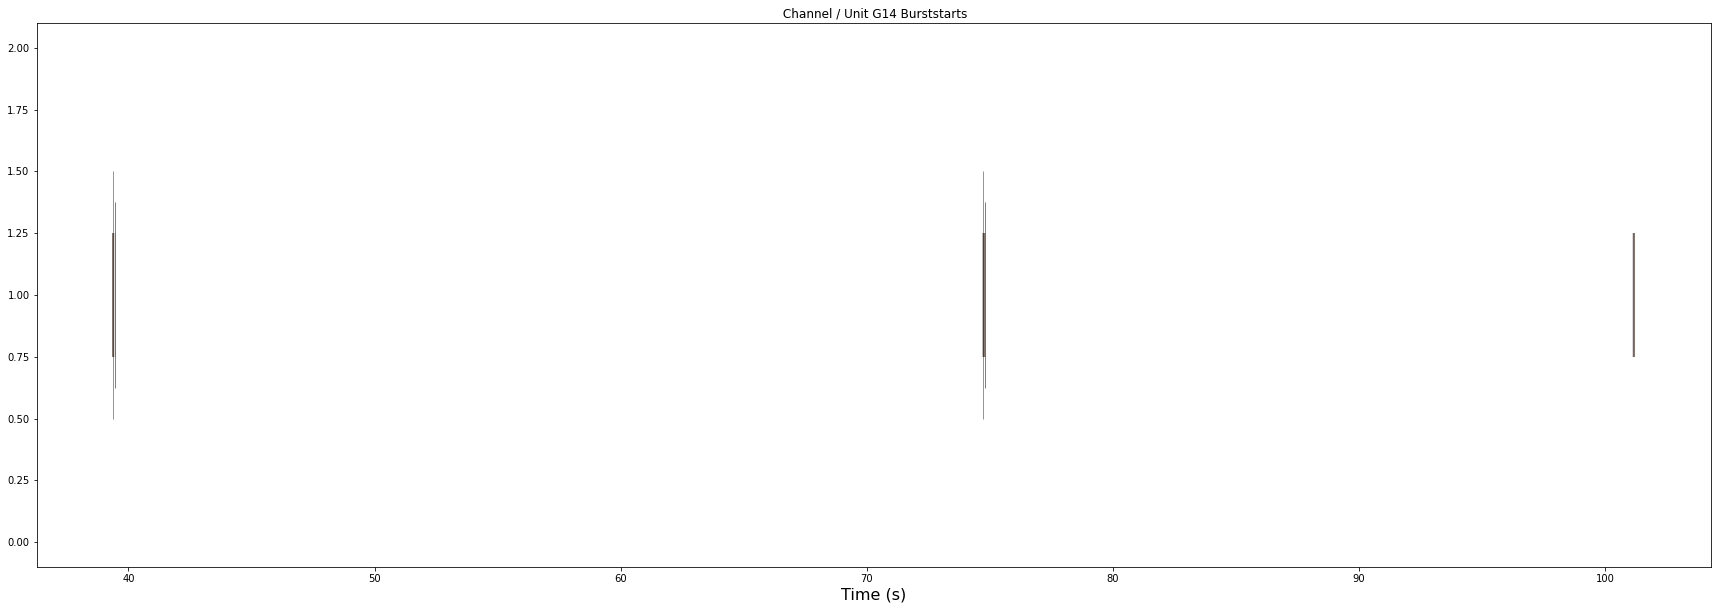

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, ' Channel / Unit G15 Burststarts')

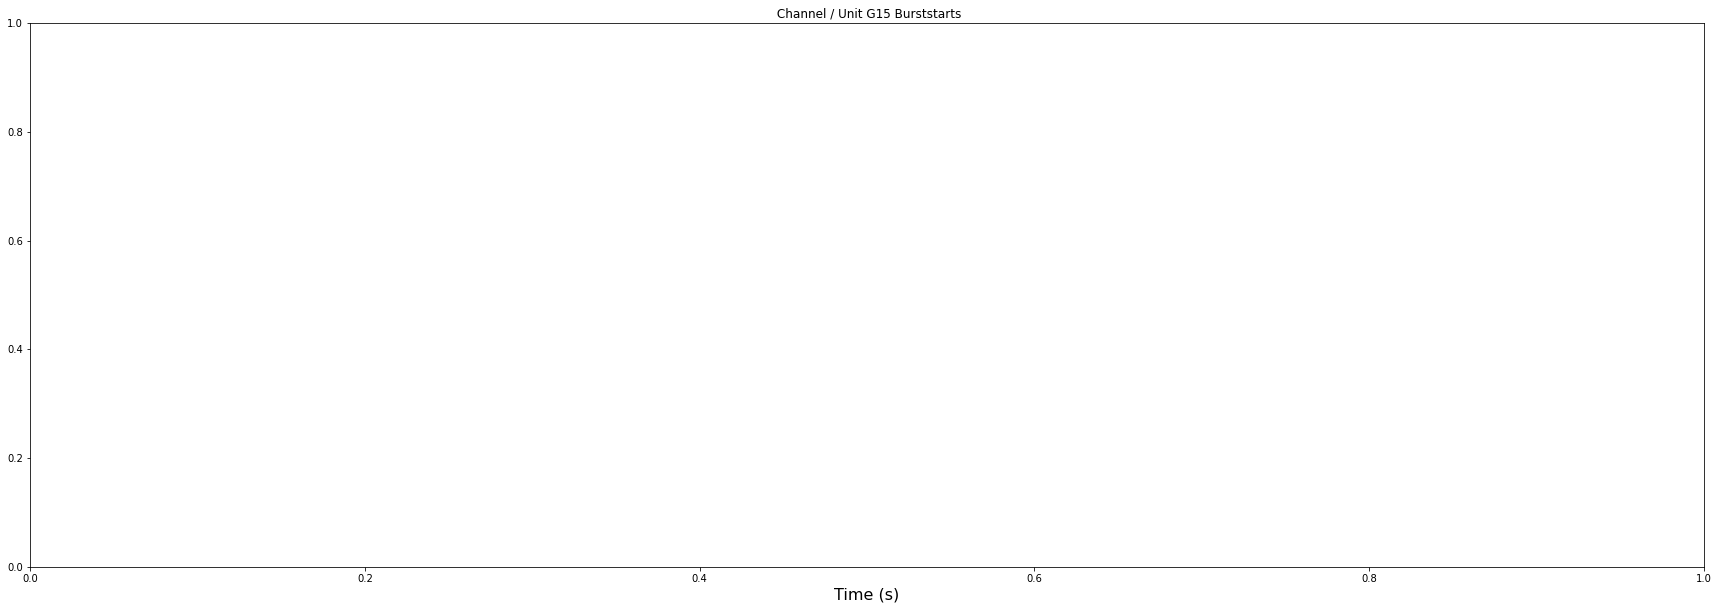

In [61]:
st_neurons = st_channel
for key in burststart_end_dic:
    burststarts_array = []
    burstend_array = []
    for i in range(0, len(burststart_end_dic[key])):
        start = burststart_end_dic[key][i][0]*scale_factor_for_second
        end = burststart_end_dic[key][i][1]*scale_factor_for_second
        burststarts_array.append(start)
        burstend_array.append(end)

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    #burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.eventplot(burststarts_array, linelengths = 1, linewidth = 1, color='#F27F1B')
    ax.eventplot(burstend_array, linelengths = 0.75, linewidth = 1, color='#04B2D9')
    ax.eventplot(array, linelengths= 0.5, linewidth = 0.3, color='#260B01')
    #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
    ax.set_xlabel('Time (s)', fontsize=16)
    ax.set_title(' Channel / Unit '+str(key) +' Burststarts')
#ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
#ax.set_ylabel('Channel '+str(key) +' Burststarts')


    plt.show()
    #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
    #plt.close()

In [62]:
burststart_end_dic

{'G13': [],
 'G12': [],
 'F16': [],
 'F15': [(39335720.0, 40576800.0),
  (74708920.0, 75035800.0),
  (75147680.0, 75884880.0),
  (101109160.0, 102138600.0)],
 'F14': [],
 'F13': [],
 'F12': [],
 'E16': [],
 'E15': [],
 'E14': [],
 'E13': [],
 'G11': [],
 'D16': [],
 'D15': [],
 'D14': [],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [],
 'B14': [],
 'G10': [],
 'E12': [],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [],
 'C10': [],
 'D10': [],
 'A10': [],
 'B10': [],
 'D9': [],
 'E9': [],
 'B9': [],
 'C9': [],
 'F9': [],
 'A9': [],
 'G8': [],
 'G9': [],
 'A8': [],
 'F8': [],
 'C8': [],
 'B8': [],
 'E8': [],
 'D8': [],
 'B7': [],
 'A7': [],
 'D7': [],
 'C7': [],
 'A6': [],
 'E7': [],
 'C6': [],
 'B6': [],
 'E6': [],
 'D6': [],
 'B5': [],
 'A5': [],
 'D5': [],
 'C5': [],
 'A4': [],
 'F7': [],
 'C4': []

For every channel:
1. get the time each unit is bursting -> can be used for heatmap
2. make dictionary for simultaneously bursting units
3. cluster together bursting spikes 
4. heatmap of bursts and detected spikes
5. function that extracts detected spikes from dataframe 

In [63]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursting_time_per_unit_dic = {}
for key in burststart_end_dic:
    time = 0
    for i in burststart_end_dic[key]:
        bursttime = i[1] - i[0]
        time = time + bursttime
    bursting_time_per_unit_dic[key] = time*scale_factor_for_second # kein tick, vorher bereits drin

In [64]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursts_per_unit_dic = {}
for key in burststart_end_dic:
    number_of_bursts = 0
    for i in burststart_end_dic[key]:
        number_of_bursts += 1
    bursts_per_unit_dic[key] = number_of_bursts

In [65]:
bursts_per_unit_dic

{'G13': 0,
 'G12': 0,
 'F16': 0,
 'F15': 4,
 'F14': 0,
 'F13': 0,
 'F12': 0,
 'E16': 0,
 'E15': 0,
 'E14': 0,
 'E13': 0,
 'G11': 0,
 'D16': 0,
 'D15': 0,
 'D14': 0,
 'H9': 0,
 'F11': 0,
 'C16': 0,
 'C15': 0,
 'D13': 0,
 'B16': 0,
 'B15': 0,
 'C14': 0,
 'A15': 0,
 'A14': 0,
 'B14': 0,
 'G10': 0,
 'E12': 0,
 'B13': 0,
 'C13': 0,
 'F10': 0,
 'A13': 0,
 'C12': 0,
 'D12': 0,
 'A12': 0,
 'B12': 0,
 'D11': 0,
 'E11': 0,
 'B11': 0,
 'C11': 0,
 'E10': 0,
 'A11': 0,
 'C10': 0,
 'D10': 0,
 'A10': 0,
 'B10': 0,
 'D9': 0,
 'E9': 0,
 'B9': 0,
 'C9': 0,
 'F9': 0,
 'A9': 0,
 'G8': 0,
 'G9': 0,
 'A8': 0,
 'F8': 0,
 'C8': 0,
 'B8': 0,
 'E8': 0,
 'D8': 0,
 'B7': 0,
 'A7': 0,
 'D7': 0,
 'C7': 0,
 'A6': 0,
 'E7': 0,
 'C6': 0,
 'B6': 0,
 'E6': 0,
 'D6': 0,
 'B5': 0,
 'A5': 0,
 'D5': 0,
 'C5': 0,
 'A4': 0,
 'F7': 0,
 'C4': 0,
 'B4': 0,
 'F6': 0,
 'H8': 0,
 'B3': 0,
 'A3': 0,
 'D4': 0,
 'A2': 0,
 'B2': 0,
 'B1': 0,
 'C3': 0,
 'C2': 0,
 'C1': 0,
 'E5': 0,
 'G7': 0,
 'D3': 0,
 'D2': 0,
 'D1': 0,
 'G6': 0,
 'E4'

In [66]:
# this function takes the dictionary with every burst start and stop and returns a dictionary
# where every unit is a key and the values are tuples consisting of keys of connected units (i.e., bursting together)
# and the number of shared bursts


burst_connections_dic = {}


for key in burststart_end_dic:
    other_keys = list(burststart_end_dic.keys())
    other_keys.remove(key)
    connected_unit_list = []
    for j in other_keys:
        number_of_bursts = 0
        time_shared = 0
        for i in burststart_end_dic[key]:
            start, end = i[0], i[1]
            for m in burststart_end_dic[j]:
                other_start = m[0]
                other_end = m[1]
                if (other_start > start) & (other_start < end):
                    if other_end >= end:
                        time_shared = time_shared + (end - other_start)
                    else:
                        time_shared = time_shared + (other_end - other_start)
                    number_of_bursts += 1
                    
        if number_of_bursts > 0:
            connected_unit_list.append((j, number_of_bursts, time_shared*scale_factor_for_second))        
    burst_connections_dic[key] = connected_unit_list
        
        


In [67]:
burst_connections_dic

{'G13': [],
 'G12': [],
 'F16': [],
 'F15': [('J14', 1, 0.011399999999999999),
  ('H15', 1, 0.02332),
  ('H13', 1, 0.012039999999999999),
  ('H14', 2, 0.08188),
  ('G14', 2, 0.13535999999999998)],
 'F14': [],
 'F13': [],
 'F12': [],
 'E16': [],
 'E15': [],
 'E14': [],
 'E13': [],
 'G11': [],
 'D16': [],
 'D15': [],
 'D14': [],
 'H9': [],
 'F11': [],
 'C16': [],
 'C15': [],
 'D13': [],
 'B16': [],
 'B15': [],
 'C14': [],
 'A15': [],
 'A14': [],
 'B14': [],
 'G10': [],
 'E12': [],
 'B13': [],
 'C13': [],
 'F10': [],
 'A13': [],
 'C12': [],
 'D12': [],
 'A12': [],
 'B12': [],
 'D11': [],
 'E11': [],
 'B11': [],
 'C11': [],
 'E10': [],
 'A11': [],
 'C10': [],
 'D10': [],
 'A10': [],
 'B10': [],
 'D9': [],
 'E9': [],
 'B9': [],
 'C9': [],
 'F9': [],
 'A9': [],
 'G8': [],
 'G9': [],
 'A8': [],
 'F8': [],
 'C8': [],
 'B8': [],
 'E8': [],
 'D8': [],
 'B7': [],
 'A7': [],
 'D7': [],
 'C7': [],
 'A6': [],
 'E7': [],
 'C6': [],
 'B6': [],
 'E6': [],
 'D6': [],
 'B5': [],
 'A5': [],
 'D5': [],
 'C

In [68]:
#filebase = file.split('__')[1]

In [69]:
np.save(filebase+'_burst_connections_dic.npy', burst_connections_dic)

In [39]:
labels = sorted(list(burst_connections_dic))

TypeError: '<' not supported between instances of 'float' and 'str'

In [40]:
labels = list(burst_connections_dic)

In [41]:
shared_frame = pd.DataFrame(index=labels, columns=labels)

In [42]:
len(st_channel)

243

In [43]:
for row in shared_frame:
    for conncected_unit in burst_connections_dic[row]:
        other_unit = conncected_unit[0]
        shared_burst_time = conncected_unit[2]
        shared_frame.loc[row, other_unit] = shared_burst_time

In [44]:
shared_frame

R12      P12       K7  B12  H16       D7      F10       E3       D3  \
R12      NaN  0.18376      NaN  NaN  NaN      NaN  0.12476  0.01776      NaN   
P12  0.08048      NaN      NaN  NaN  NaN      NaN  0.04404  0.05452  0.02164   
K7       NaN      NaN      NaN  NaN  NaN    0.009      NaN  0.06076  0.05332   
B12      NaN      NaN      NaN  NaN  NaN      NaN      NaN      NaN      NaN   
H16      NaN      NaN      NaN  NaN  NaN      NaN      NaN      NaN      NaN   
..       ...      ...      ...  ...  ...      ...      ...      ...      ...   
G2   0.01548  0.01636  0.06244  NaN  NaN  0.04044  0.03212    1.064  0.19336   
P10      NaN      NaN      NaN  NaN  NaN      NaN      NaN      NaN      NaN   
P2       NaN      NaN      NaN  NaN  NaN      NaN      NaN      NaN      NaN   
G1   0.00344  0.02156  0.00384  NaN  NaN  0.00272  0.02592  1.27972   0.3176   
B6       NaN      NaN      NaN  NaN  NaN      NaN      NaN      NaN      NaN   

          D2  ...       L7       I1      I14      R10   P1       G2  P10   P2  \
R12      NaN  ...      NaN      NaN    0.062  0.11232  NaN  0.00072  NaN  NaN   
P12      NaN  ...      NaN      NaN      NaN  0.16512  NaN  0.04716  NaN  NaN   
K7   0.11332  ...  0.51856   0.0314      NaN      NaN  NaN  0.04172  NaN  NaN   
B12      NaN  ...      NaN      NaN      NaN      NaN  NaN      NaN  NaN  NaN   
H16      NaN  ...      NaN      NaN      NaN      NaN  NaN      NaN  NaN  NaN   
..       ...  ...      ...      ...      ...      ...  ...      ...  ...  ...   
G2    0.3086  ...   0.0146  0.05556   0.0168   0.0066  NaN      NaN  NaN  NaN   
P10      NaN  ...      NaN      NaN      NaN      NaN  NaN      NaN  NaN  NaN   
P2       NaN  ...      NaN      NaN      NaN      NaN  NaN      NaN  NaN  NaN   
G1   0.32108  ...      NaN  0.02464  0.00476      NaN  NaN  0.86248  NaN  NaN   
B6       NaN  ...      NaN      NaN      NaN      NaN  NaN      NaN  NaN  NaN   

          G1   B6  
R12  0.00232  NaN  
P12   0.0332  NaN  
K7   0.04936  NaN  
B12      NaN  NaN  
H16      NaN  NaN  
..       ...  ...  
G2   0.63148  NaN  
P10      NaN  NaN  
P2       NaN  NaN  
G1       NaN  NaN  
B6       NaN  NaN  

[243 rows x 243 columns]

In [38]:
#completeframe.loc['unit_ids_2']=completeframe['unit_ids']

In [45]:
shared_frame = shared_frame.fillna(0)

In [40]:
# normalization
#df_norm_col=(shared_frame-shared_frame.mean().max())/shared_frame.mean().std()

In [41]:
#df = pd.DataFrame(abs(frame_array), columns=unit_ids_for_frame, index=unit_ids_for_frame)

In [46]:
shared_frame

R12      P12       K7  B12  H16       D7      F10       E3       D3  \
R12  0.00000  0.18376  0.00000  0.0    0  0.00000  0.12476  0.01776  0.00000   
P12  0.08048  0.00000  0.00000  0.0    0  0.00000  0.04404  0.05452  0.02164   
K7   0.00000  0.00000  0.00000  0.0    0  0.00900  0.00000  0.06076  0.05332   
B12  0.00000  0.00000  0.00000  0.0    0  0.00000  0.00000  0.00000  0.00000   
H16  0.00000  0.00000  0.00000  0.0    0  0.00000  0.00000  0.00000  0.00000   
..       ...      ...      ...  ...  ...      ...      ...      ...      ...   
G2   0.01548  0.01636  0.06244  0.0    0  0.04044  0.03212  1.06400  0.19336   
P10  0.00000  0.00000  0.00000  0.0    0  0.00000  0.00000  0.00000  0.00000   
P2   0.00000  0.00000  0.00000  0.0    0  0.00000  0.00000  0.00000  0.00000   
G1   0.00344  0.02156  0.00384  0.0    0  0.00272  0.02592  1.27972  0.31760   
B6   0.00000  0.00000  0.00000  0.0    0  0.00000  0.00000  0.00000  0.00000   

          D2  ...       L7       I1      I14      R10  P1       G2  P10  P2  \
R12  0.00000  ...  0.00000  0.00000  0.06200  0.11232   0  0.00072    0   0   
P12  0.00000  ...  0.00000  0.00000  0.00000  0.16512   0  0.04716    0   0   
K7   0.11332  ...  0.51856  0.03140  0.00000  0.00000   0  0.04172    0   0   
B12  0.00000  ...  0.00000  0.00000  0.00000  0.00000   0  0.00000    0   0   
H16  0.00000  ...  0.00000  0.00000  0.00000  0.00000   0  0.00000    0   0   
..       ...  ...      ...      ...      ...      ...  ..      ...  ...  ..   
G2   0.30860  ...  0.01460  0.05556  0.01680  0.00660   0  0.00000    0   0   
P10  0.00000  ...  0.00000  0.00000  0.00000  0.00000   0  0.00000    0   0   
P2   0.00000  ...  0.00000  0.00000  0.00000  0.00000   0  0.00000    0   0   
G1   0.32108  ...  0.00000  0.02464  0.00476  0.00000   0  0.86248    0   0   
B6   0.00000  ...  0.00000  0.00000  0.00000  0.00000   0  0.00000    0   0   

          G1  B6  
R12  0.00232   0  
P12  0.03320   0  
K7   0.04936   0  
B12  0.00000   0  
H16  0.00000   0  
..       ...  ..  
G2   0.63148   0  
P10  0.00000   0  
P2   0.00000   0  
G1   0.00000   0  
B6   0.00000   0  

[243 rows x 243 columns]

In [43]:
df = df.fillna(0)

In [44]:
shared_frame

O10       H4      E12       M7        N3       A9       G6      I15  \
O10  0.00000  0.20440  0.03368  0.35808   0.36936  0.58156  0.62328  0.49980   
H4   0.04492  0.00000  0.00000  0.41644   0.00276  0.18532  0.24236  0.21396   
E12  4.40100  2.26560  0.00000  2.48144  25.52268  2.53120  4.20444  2.61612   
M7   0.23740  0.35312  0.00000  0.00000   0.00000  0.16908  0.24064  0.15296   
N3   2.19756  1.04220  1.26528  2.43276   0.00000  2.19624  3.03812  1.95692   
..       ...      ...      ...      ...       ...      ...      ...      ...   
E2   0.15280  0.00000  0.00000  0.00000   0.00000  0.00292  0.05980  0.02948   
L8   0.44564  0.27104  0.32868  0.39112   0.51552  0.67840  0.66120  0.54516   
N1   0.00000  0.00000  0.09232  0.26676   0.14528  0.11288  0.00000  0.00000   
E1   0.22288  0.52404  0.00000  0.72108   0.38504  0.92048  0.77176  0.91420   
R14  0.85476  0.42388  0.38480  0.84708   2.42884  0.99840  0.98396  0.77916   

          C3       D9  ...       O3       C12  N11      P11       M5       E2  \
O10  0.52896  0.65444  ...  0.11496   0.30492    0  0.00000  0.00000  0.01452   
H4   0.20936  0.11688  ...  0.07588   0.59360    0  0.00000  0.00000  0.00000   
E12  2.71656  5.99560  ...  2.85516  10.93584    0  3.04408  1.30184  0.56860   
M7   0.15844  0.22896  ...  0.07588   0.29036    0  0.00000  0.00000  0.00000   
N3   2.23852  3.30172  ...  0.28200   2.41848    0  0.40512  0.00616  0.06652   
..       ...      ...  ...      ...       ...  ...      ...      ...      ...   
E2   0.04588  0.06016  ...  0.00000   0.00000    0  0.00000  0.00000  0.00000   
L8   0.45436  0.58764  ...  0.00000   0.92928    0  0.33732  0.00000  0.06652   
N1   0.00000  0.00000  ...  0.00000   0.15744    0  0.00000  0.00000  0.00000   
E1   0.63268  0.48368  ...  0.00000   0.84004    0  0.00000  0.00000  0.00000   
R14  0.70084  1.05712  ...  0.22764   1.24812    0  0.15484  0.09340  0.00000   

          L8       N1       E1       R14  
O10  0.14908  0.00000  0.26716   0.29132  
H4   0.19308  0.27068  0.09992   0.29812  
E12  7.05288  1.09884  2.38672  12.85820  
M7   0.30612  0.16724  0.51764   0.51816  
N3   2.02248  0.73060  1.67828   3.27756  
..       ...      ...      ...       ...  
E2   0.00000  0.00000  0.03992   0.01876  
L8   0.00000  0.12500  0.30236   0.71560  
N1   0.05972  0.00000  0.00000   0.20184  
E1   0.38832  0.40576  0.00000   0.85652  
R14  0.76316  0.37088  0.42948   0.00000  

[177 rows x 177 columns]

In [45]:
corr_mat = df.corr().stack().reset_index(name="correlation")

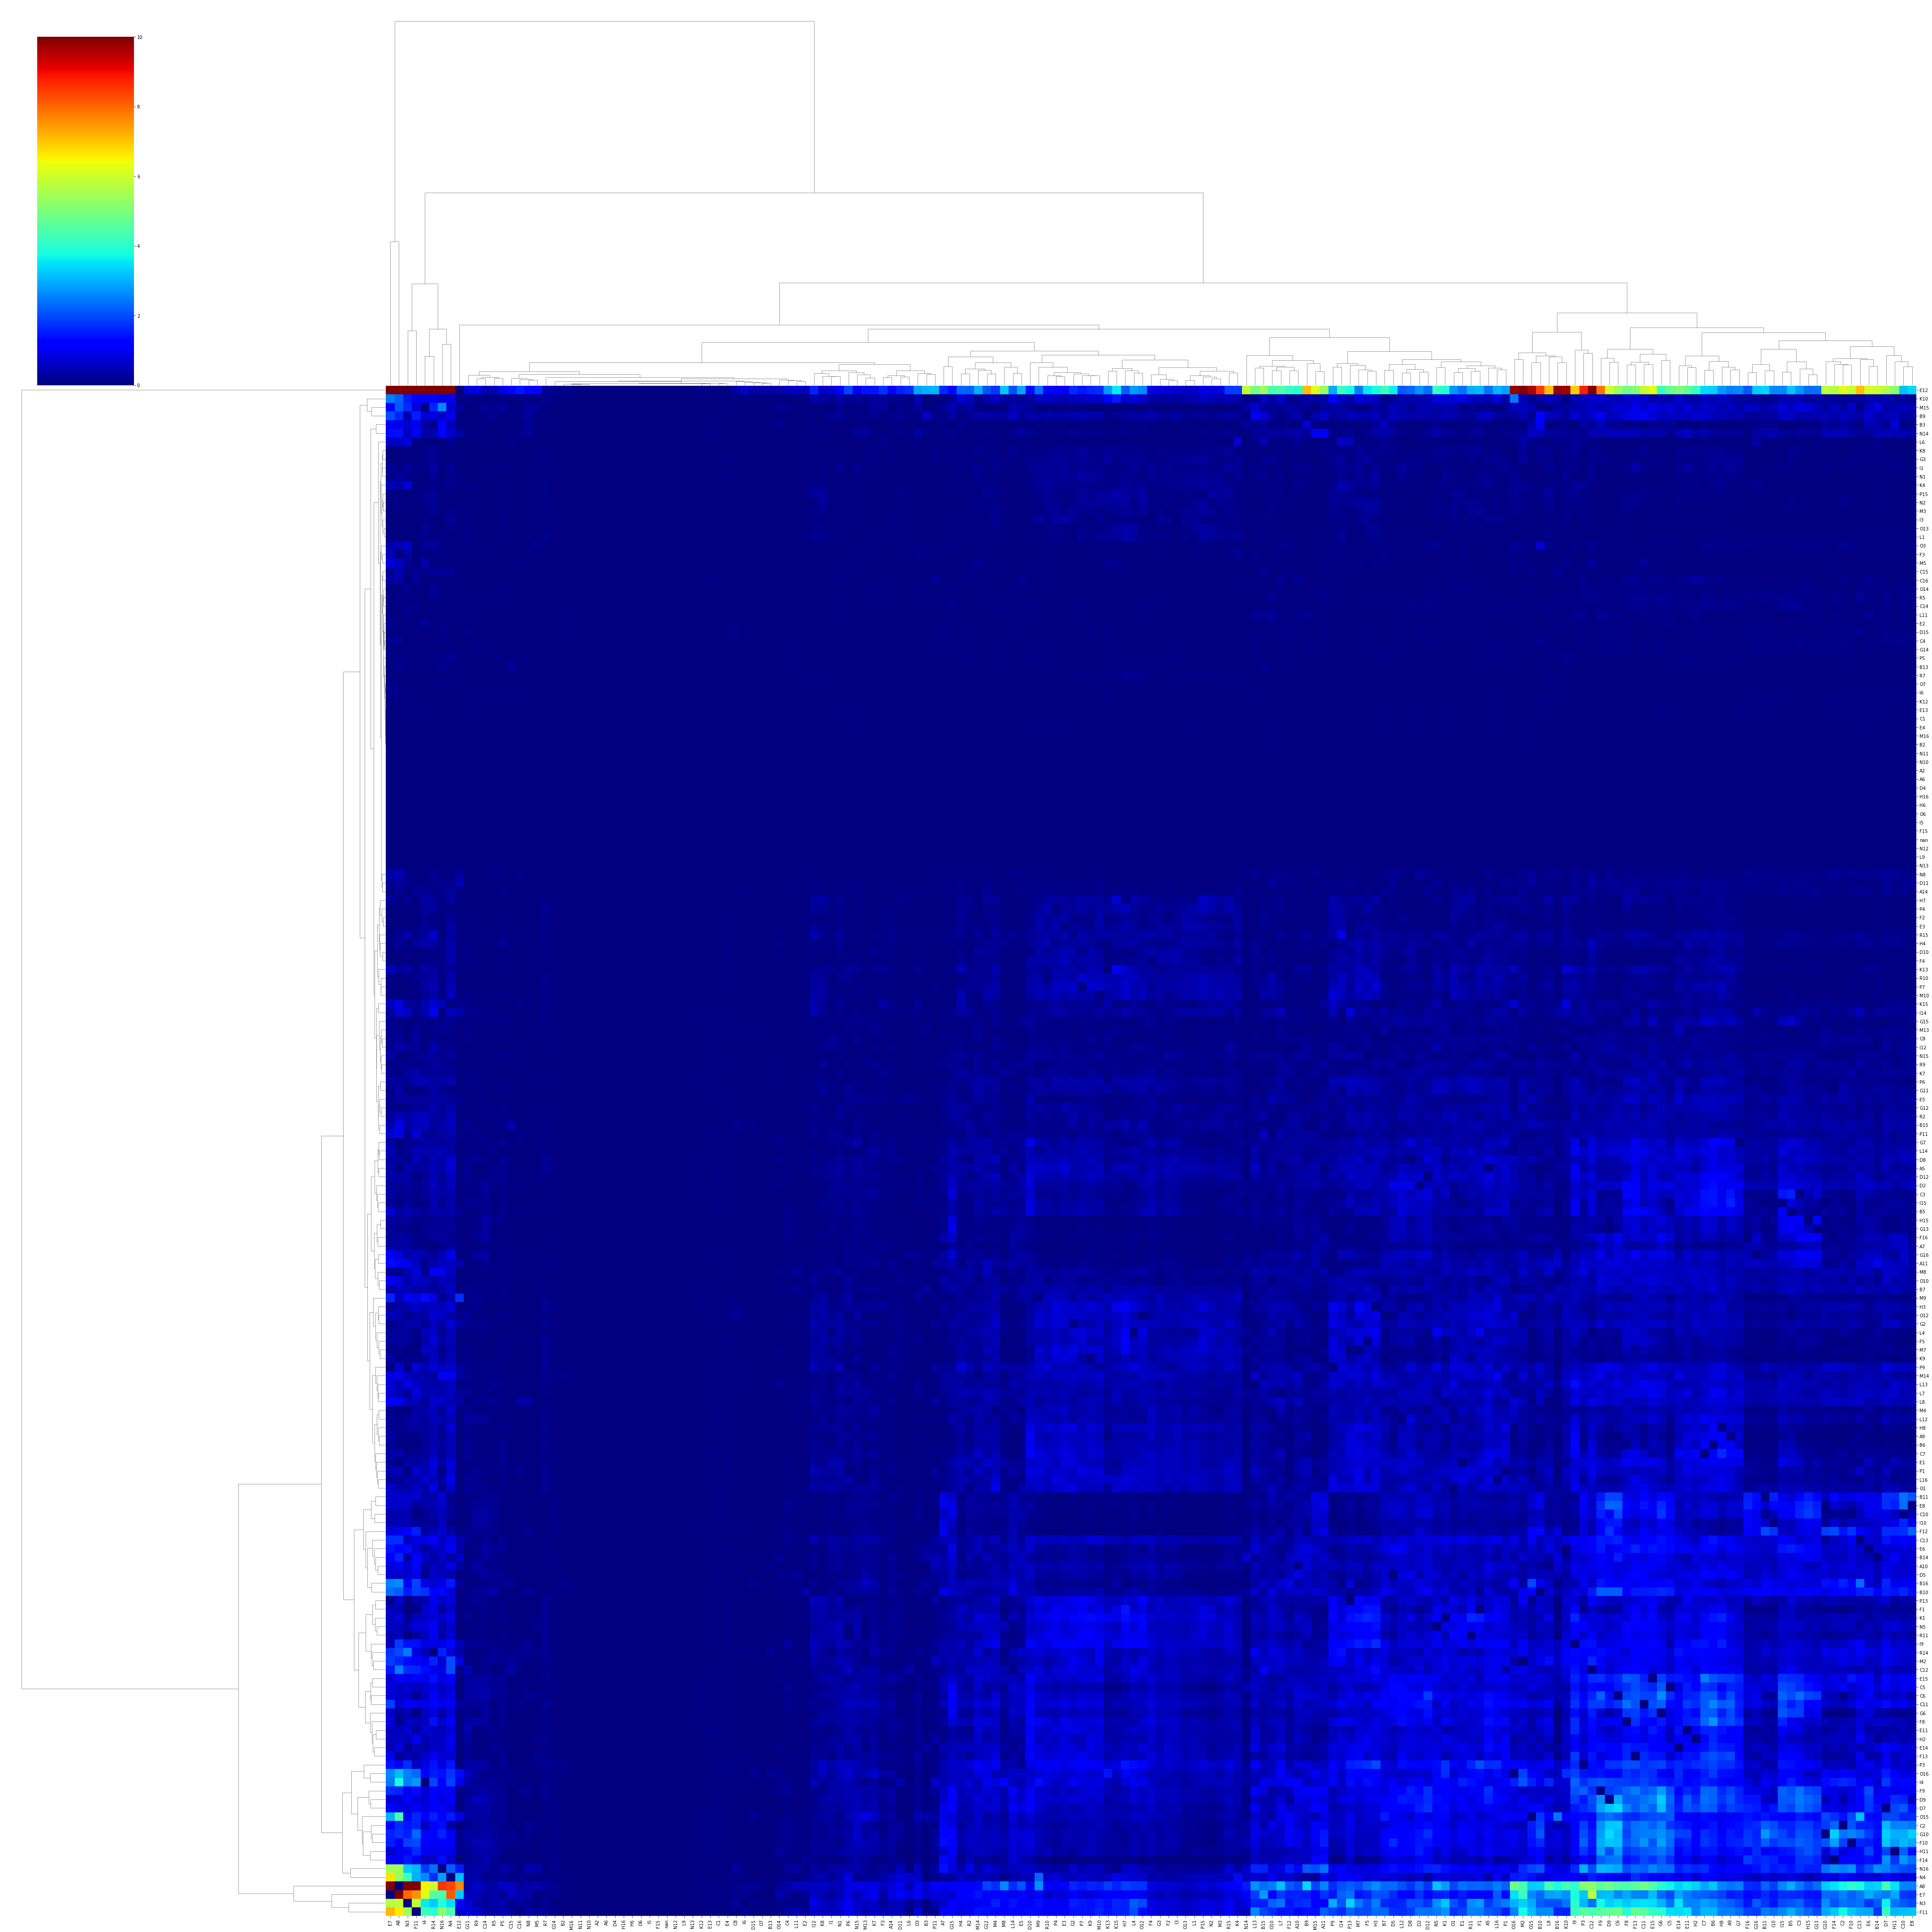

In [46]:
sns.clustermap(shared_frame, cmap="jet", method='complete', vmax = 10, figsize=(60,60))

<AxesSubplot:>

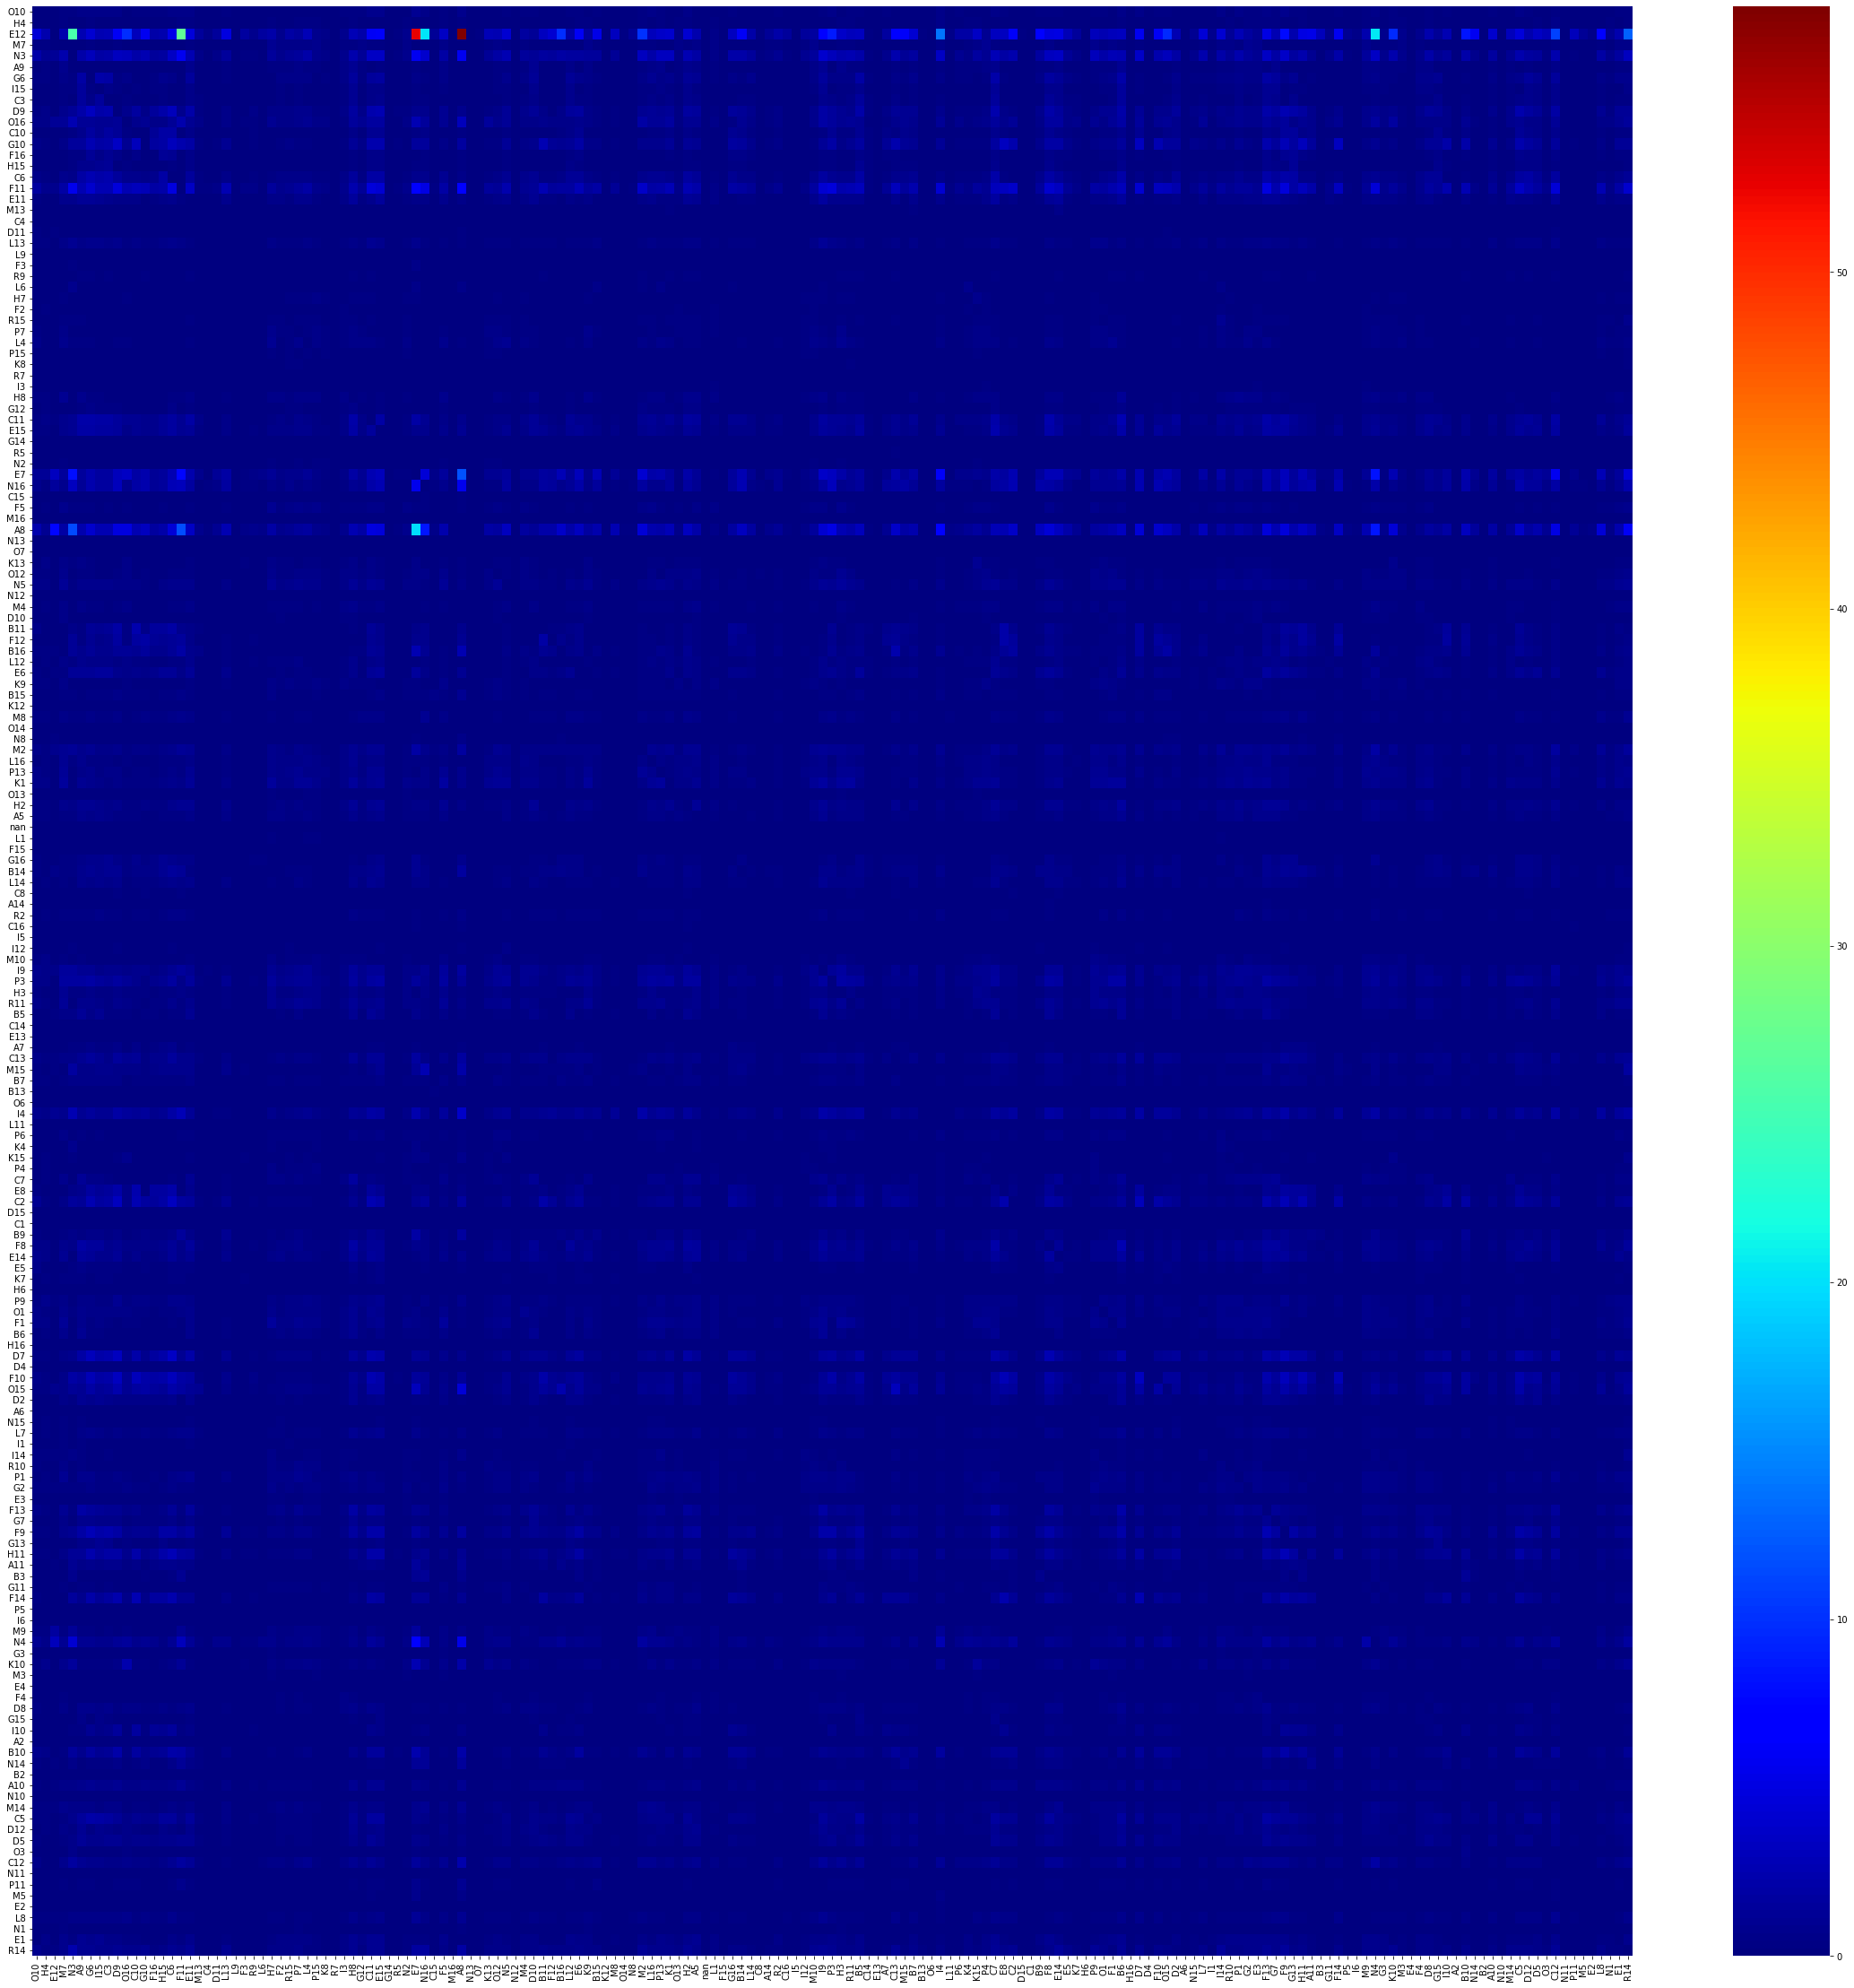

In [47]:
fig, ax = plt.subplots(1,1, figsize=(40,40))
sns.heatmap(shared_frame, cmap="jet", ax=ax)


# binning spikes from the spike train channels
## first for each channel/unit and make it to another dictionary

## second for the whole recordings, so again there is one array with every detected spike

In [47]:
# find the recording length:
# maximal_spike = np.max(np.max(list(st_channel.values())))*40*scale_factor_for_second
# length_recording = np.ceil(maximal_spike)

In [48]:
maximal_spike = 0
for key in st_channel:
    if len(st_channel[key])>0:
        maximal = np.max(st_channel[key])
        if maximal > maximal_spike:
            maximal_spike = maximal
            
length_recording = np.ceil(maximal_spike*tick*scale_factor_for_second)

In [49]:
length_recording

253.0

In [50]:
np.max(st_channel['O10'])

6324934

In [51]:
(np.max(np.max(list(st_channel.values()))))*40*scale_factor_for_second

239.7158

In [52]:
# bin the spikedictionaries per channel or unit into bins, the recording time needs to be generalized
binsize = 50 # in miliseconds
scale_factor_for_milisecond = 1e-03
binned_spike_dictionary = {}


bins= np.arange(0, length_recording*1000+binsize, binsize) # times 1000 to get the miliseconds
for key in st_channel:
    x = np.asarray(st_channel[key])*scale_factor_for_milisecond*tick
    binned_channel = np.histogram(x, bins)
    binned_spike_dictionary[key]  = binned_channel[0]
    
    
    
    

In [53]:
bins

array([0.0000e+00, 5.0000e+01, 1.0000e+02, ..., 2.5290e+05, 2.5295e+05,
       2.5300e+05])

In [54]:
labels = list(binned_spike_dictionary.keys())

In [55]:
binlist = bins

In [56]:
df = pd.DataFrame(data=binned_spike_dictionary)

In [61]:
df

R12  P12  K7  B12  H16  D7  F10  E3  D3  D2  ...  L7  I1  I14  R10  P1  \
0       0    0   1    0    0   1    0  10   5   2  ...   0   0    1    0   0   
1       0    1   1    0    0   0    2   0   0   0  ...   0   1    0    1   0   
2       0    1   0    0    0   0    1   3   0   1  ...   1   2    0    0   0   
3       0    1   2    1    1   0    0   1   0   0  ...   2   1    1    0   0   
4       0    0   2    0    0   1    1   0   0   0  ...   1   1    0    0   0   
...   ...  ...  ..  ...  ...  ..  ...  ..  ..  ..  ...  ..  ..  ...  ...  ..   
5055    1    1   0    0    0   0    1   2   0   0  ...   0   0    0    1   1   
5056    0    0   1    0    0   0    0   2   1   0  ...   0   0    1    0   0   
5057    0    0   0    0    0   0    0   0   0   1  ...   1   1    0    0   0   
5058    2    3   0    3    1   2    2   1   0   1  ...   1   3    1    6   0   
5059    2    2   2    2    1   1    3   1   2   4  ...   1   2    1    2   0   

      G2  P10  P2  G1  B6  
0      5    1   0   3   0  
1      2    1   0   0   0  
2      1    0   0   0   0  
3      0    0   0   0   0  
4      0    1   0   0   0  
...   ..  ...  ..  ..  ..  
5055   0    0   0   0   0  
5056   0    0   0   0   0  
5057   0    0   0   0   1  
5058   1    2   0   0   0  
5059   1    2   0   1   0  

[5060 rows x 243 columns]

In [62]:
correlated = df.corr()

In [63]:
correlated

R12       P12        K7       B12       H16        D7       F10  \
R12  1.000000  0.288077  0.050677  0.081459  0.058609  0.055349  0.331883   
P12  0.288077  1.000000  0.039380  0.043286  0.055505  0.042710  0.252394   
K7   0.050677  0.039380  1.000000  0.046836  0.044897  0.086545  0.066891   
B12  0.081459  0.043286  0.046836  1.000000  0.029265  0.019192  0.071721   
H16  0.058609  0.055505  0.044897  0.029265  1.000000  0.023828  0.083691   
..        ...       ...       ...       ...       ...       ...       ...   
G2   0.077195  0.058391  0.085061  0.043816  0.034633  0.144048  0.075373   
P10  0.073306  0.056369  0.029991  0.035638  0.016577  0.016912  0.073128   
P2   0.032877  0.030154 -0.003575  0.039179 -0.004514 -0.008275  0.037509   
G1   0.068739  0.043207  0.078431  0.018731  0.017487  0.150304  0.076882   
B6   0.084844  0.045303  0.038955  0.015080  0.019668  0.028857  0.061393   

           E3        D3        D2  ...        L7        I1       I14  \
R12  0.064165  0.054868  0.046554  ...  0.062509  0.088967  0.218384   
P12  0.034404  0.052380  0.031097  ...  0.074050  0.062602  0.146771   
K7   0.108547  0.104546  0.103405  ...  0.464382  0.251039  0.015591   
B12  0.019670  0.005918  0.032094  ...  0.032260  0.035311  0.033794   
H16  0.020839  0.013398  0.008890  ...  0.016117  0.041560  0.045540   
..        ...       ...       ...  ...       ...       ...       ...   
G2   0.623460  0.449981  0.463183  ...  0.066653  0.171274  0.020356   
P10  0.062962  0.028681  0.038375  ...  0.060781  0.026909  0.040093   
P2  -0.005649 -0.010722 -0.002468  ...  0.017525  0.023724  0.041083   
G1   0.699315  0.490911  0.523545  ...  0.061716  0.198397  0.014215   
B6  -0.005490 -0.013180  0.000113  ...  0.067943  0.027029  0.030633   

          R10        P1        G2       P10        P2        G1        B6  
R12  0.161870  0.022542  0.077195  0.073306  0.032877  0.068739  0.084844  
P12  0.236134  0.018376  0.058391  0.056369  0.030154  0.043207  0.045303  
K7   0.064404  0.028091  0.085061  0.029991 -0.003575  0.078431  0.038955  
B12  0.044460 -0.017737  0.043816  0.035638  0.039179  0.018731  0.015080  
H16  0.045566  0.007417  0.034633  0.016577 -0.004514  0.017487  0.019668  
..        ...       ...       ...       ...       ...       ...       ...  
G2   0.100446  0.040939  1.000000  0.057947 -0.002660  0.702869  0.007391  
P10  0.035506  0.000526  0.057947  1.000000  0.007910  0.055928  0.027967  
P2   0.025372 -0.020234 -0.002660  0.007910  1.000000 -0.002180  0.009444  
G1   0.075865  0.047351  0.702869  0.055928 -0.002180  1.000000  0.002532  
B6  -0.002974  0.002514  0.007391  0.027967  0.009444  0.002532  1.000000  

[243 rows x 243 columns]

ValueError: The condensed distance matrix must contain only finite values.

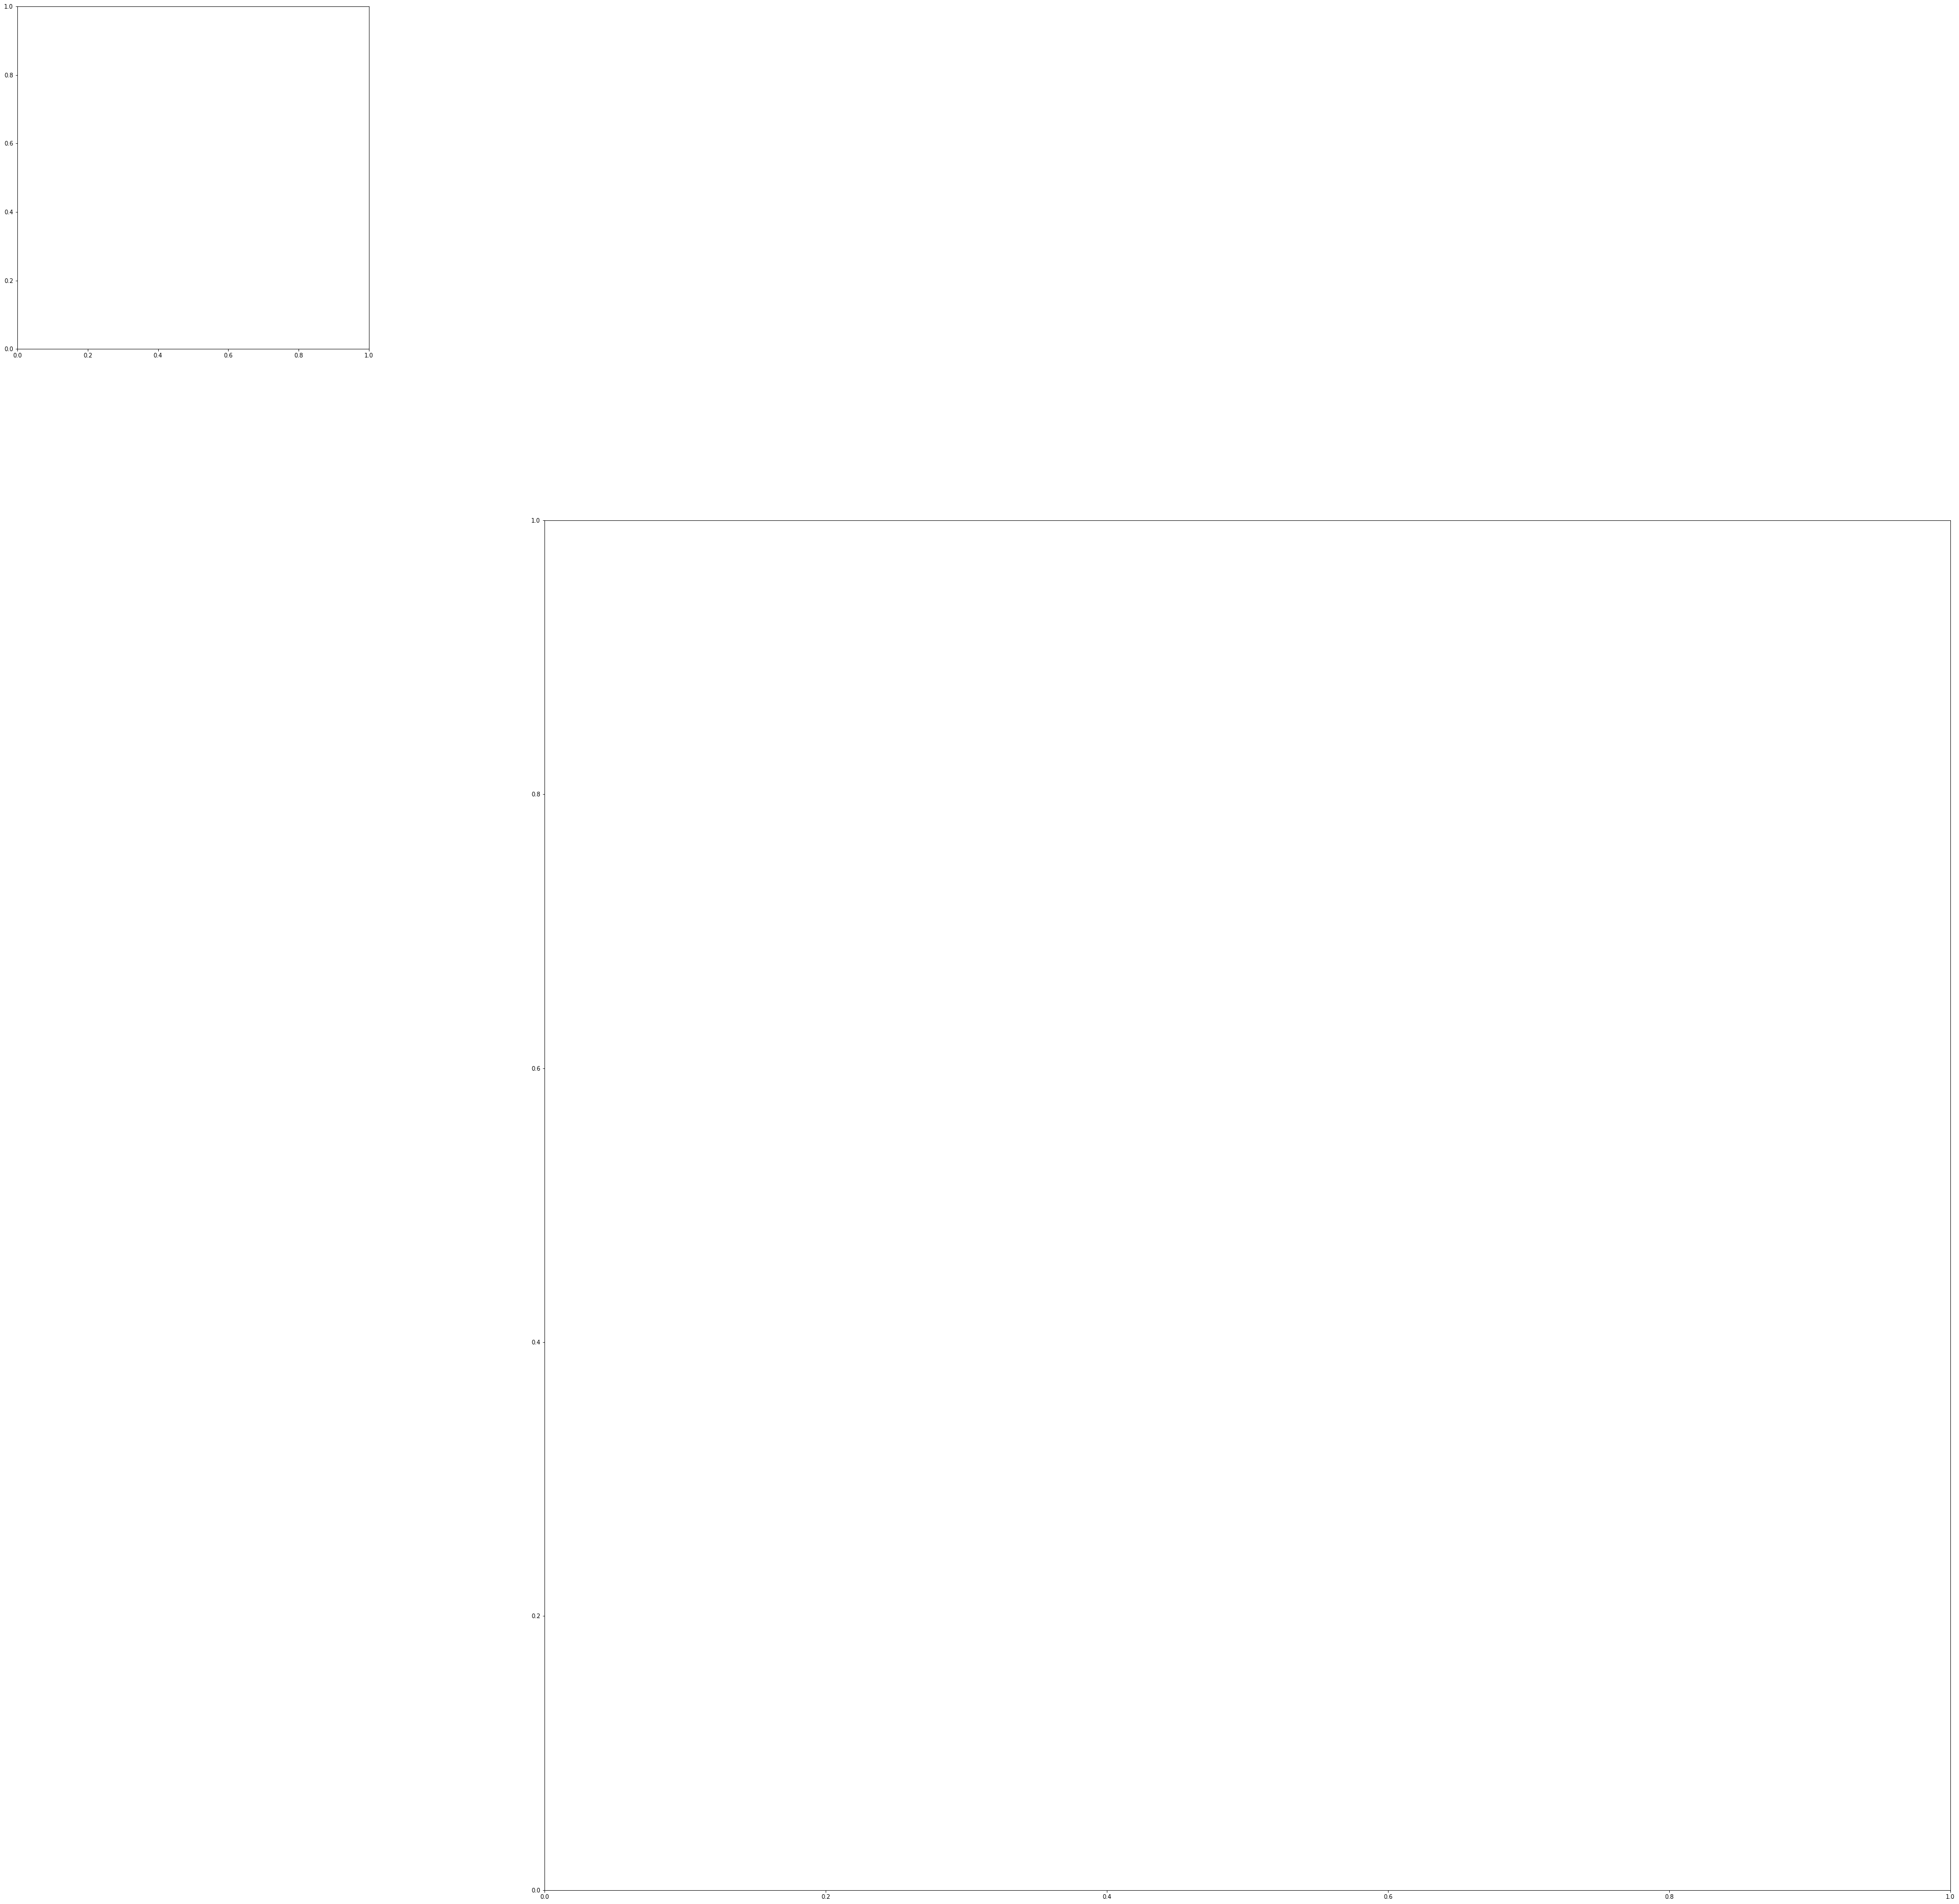

In [64]:
sns.clustermap(correlated, cmap="viridis", method='average', metric='euclidean', standard_scale=True, vmax = .5, figsize=(60,60))

In [65]:
df[:20]

R12  P12  K7  B12  H16  D7  F10  E3  D3  D2  ...  L7  I1  I14  R10  P1  \
0     0    0   1    0    0   1    0  10   5   2  ...   0   0    1    0   0   
1     0    1   1    0    0   0    2   0   0   0  ...   0   1    0    1   0   
2     0    1   0    0    0   0    1   3   0   1  ...   1   2    0    0   0   
3     0    1   2    1    1   0    0   1   0   0  ...   2   1    1    0   0   
4     0    0   2    0    0   1    1   0   0   0  ...   1   1    0    0   0   
5     0    1   0    0    0   0    0   0   0   0  ...   0   1    1    1   0   
6     0    0   0    0    0   0    0   1   0   0  ...   0   0    0    0   0   
7     0    0   0    0    0   0    1   0   0   0  ...   1   0    0    0   0   
8     0    0   0    0    0   1    0   0   0   0  ...   0   0    1    0   0   
9     0    1   1    0    0   1    0   0   0   0  ...   0   0    0    1   0   
10    1    0   0    0    0   0    0   0   0   0  ...   0   0    1    0   0   
11    0    0   0    1    0   0    0   0   0   0  ...   1   0    0    0   0   
12    0    0   0    0    0   0    1   3   0   1  ...   0   0    1    0   1   
13    0    1   0    2    0   0    0   0   0   0  ...   0   0    0    1   0   
14    1    0   0    0    0   0    0   0   0   0  ...   0   0    1    2   0   
15    0    0   0    0    1   0    0   0   0   0  ...   0   1    0    0   0   
16    0    1   0    0    1   2    0   0   1   0  ...   0   0    1    1   0   
17    0    0   0    1    0   1    0   0   0   0  ...   0   0    0    1   0   
18    0    0   0    0    1   0    0   0   0   0  ...   1   0    1    0   0   
19    0    0   0    1    1   0    0   1   0   0  ...   0   0    0    1   0   

    G2  P10  P2  G1  B6  
0    5    1   0   3   0  
1    2    1   0   0   0  
2    1    0   0   0   0  
3    0    0   0   0   0  
4    0    1   0   0   0  
5    0    0   0   0   0  
6    0    0   0   0   1  
7    0    1   0   0   0  
8    0    0   0   0   0  
9    0    0   0   0   0  
10   0    0   0   0   0  
11   1    1   0   0   0  
12   1    0   0   5   0  
13   0    1   0   0   0  
14   0    2   0   0   0  
15   2    0   0   0   0  
16   0    0   0   0   0  
17   0    0   0   1   0  
18   0    0   0   0   0  
19   0    0   0   0   0  

[20 rows x 243 columns]

ValueError: The condensed distance matrix must contain only finite values.

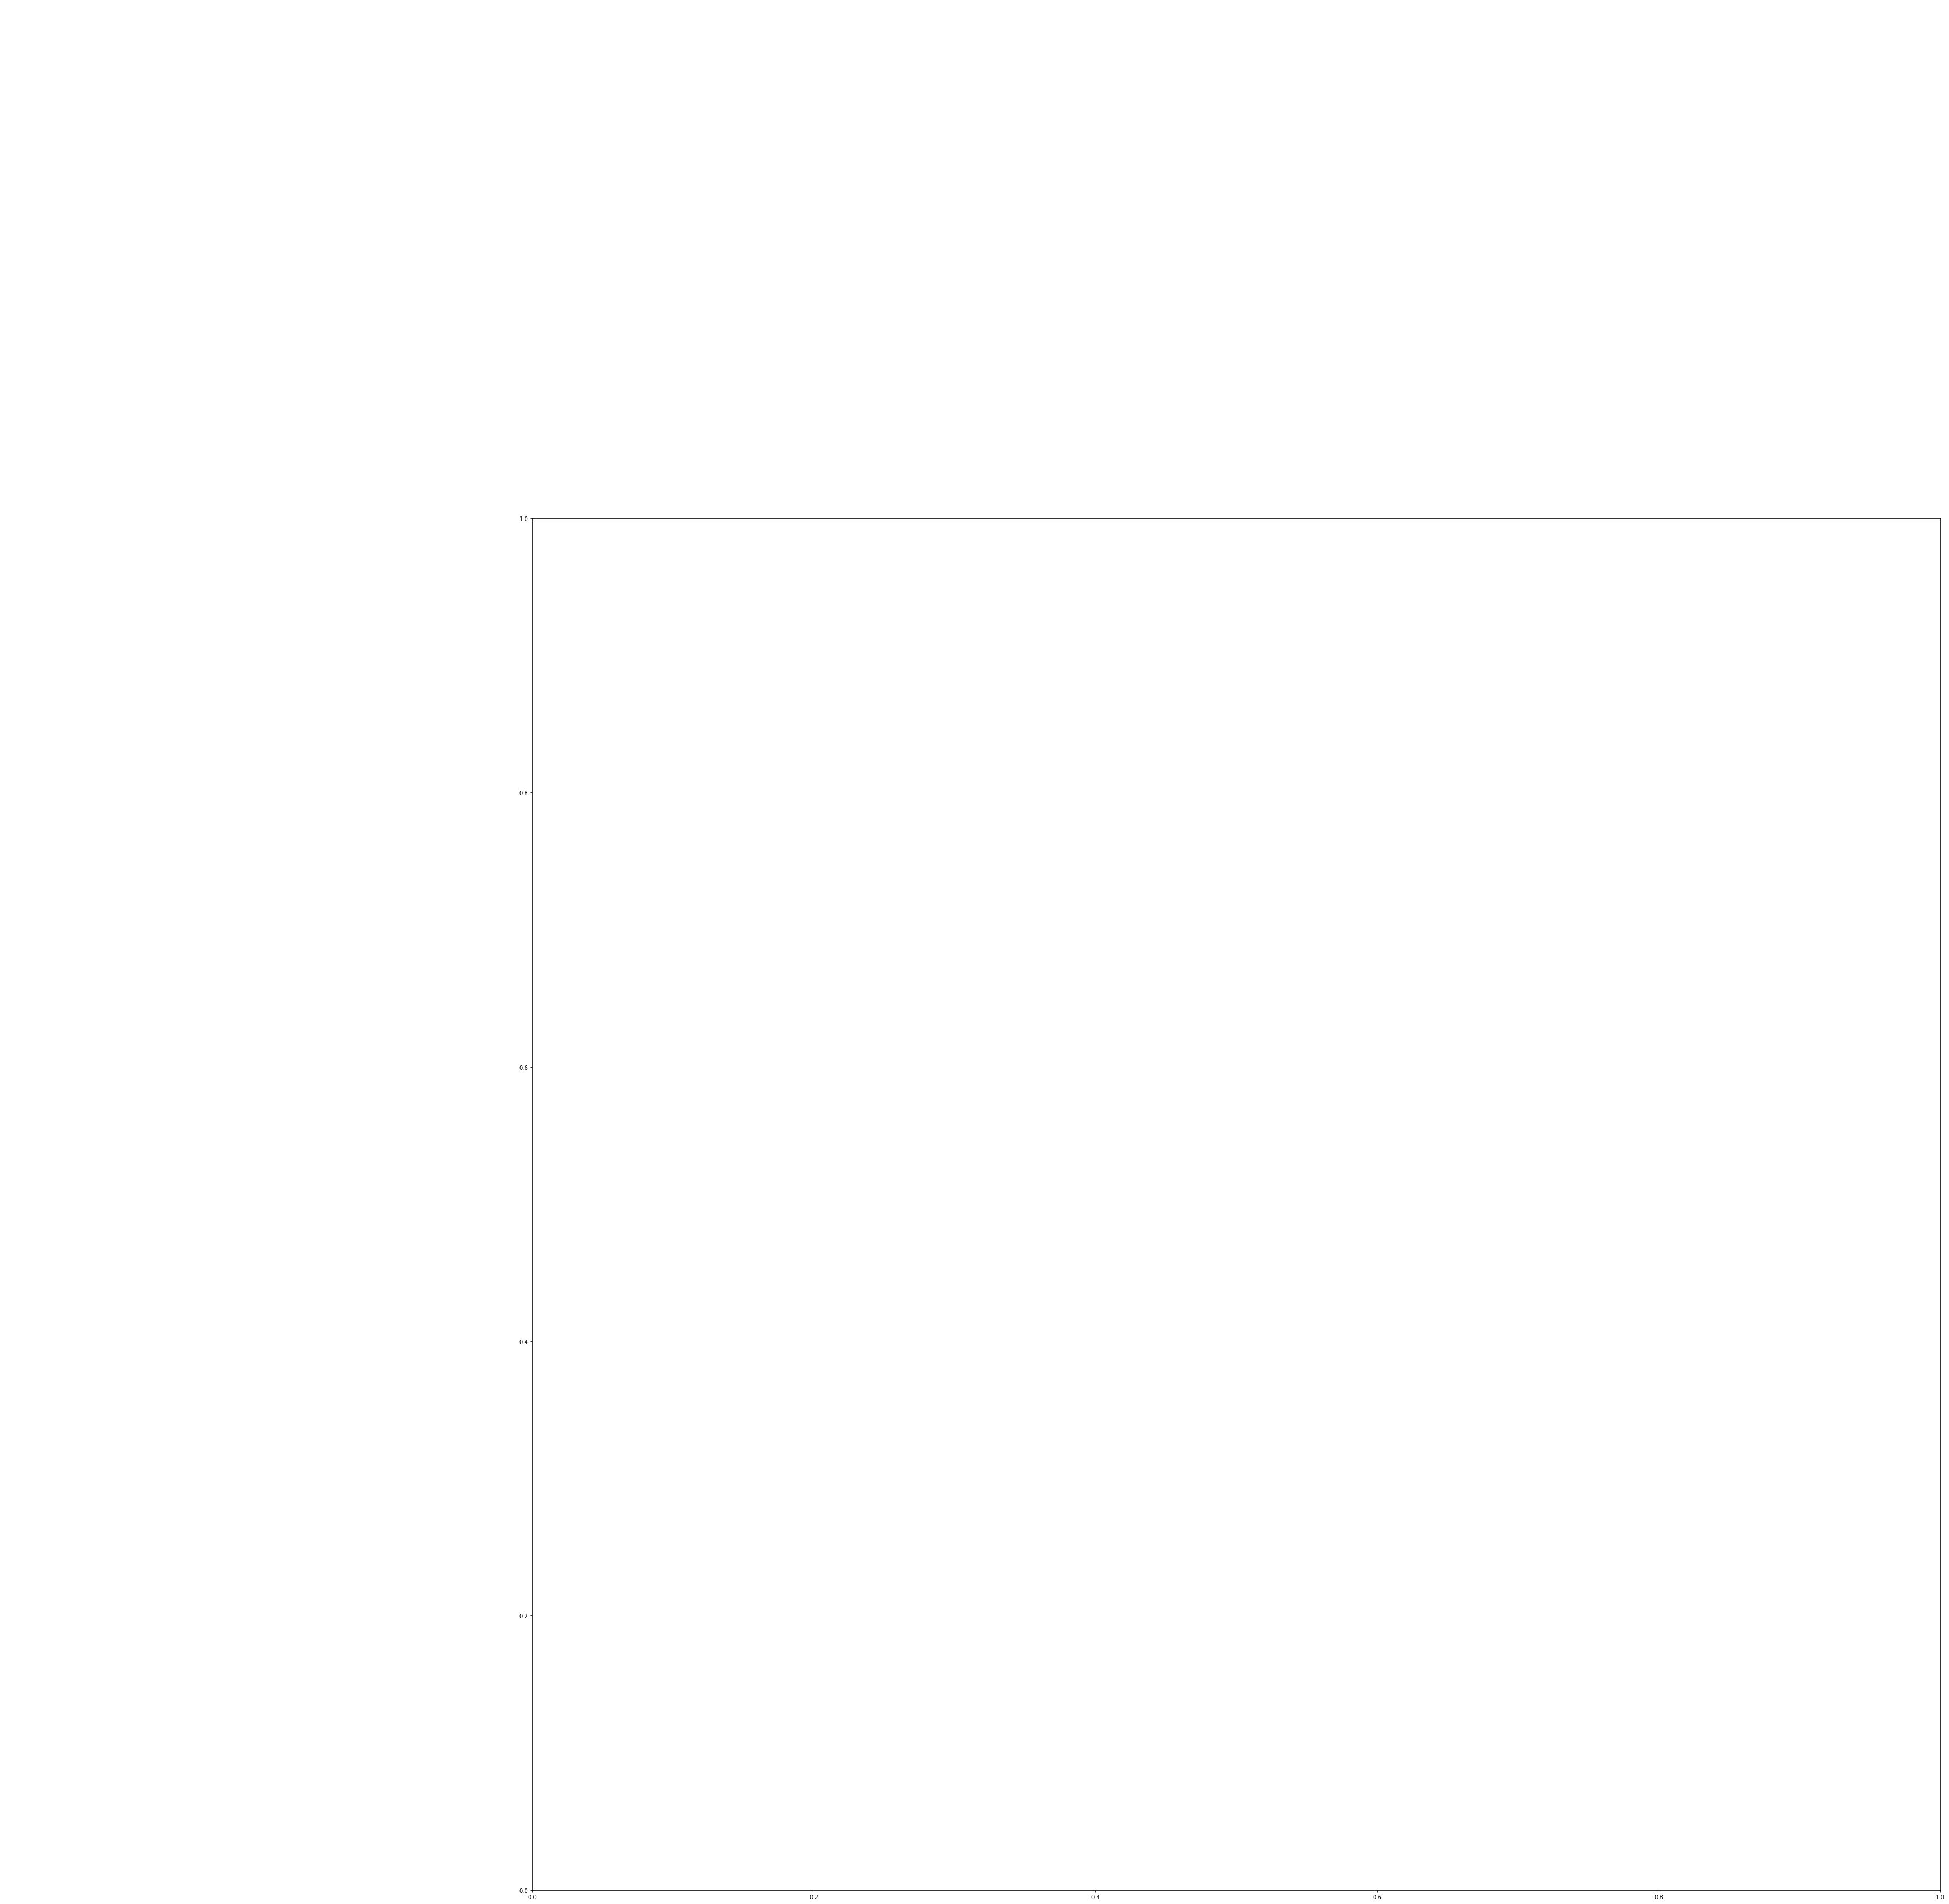

In [66]:
#fig, ax = plt.subplots(1,1, figsize=(30,30))
fig = sns.clustermap(df, cmap="jet", method='complete', metric='correlation', standard_scale=True, row_cluster=False, figsize=(60,60), cbar_pos=None)


#fig.savefig('Cluster_190117_120seconds_50ms_bins_clustering.png', dpi=300)

In [67]:
df

R12  P12  K7  B12  H16  D7  F10  E3  D3  D2  ...  L7  I1  I14  R10  P1  \
0       0    0   1    0    0   1    0  10   5   2  ...   0   0    1    0   0   
1       0    1   1    0    0   0    2   0   0   0  ...   0   1    0    1   0   
2       0    1   0    0    0   0    1   3   0   1  ...   1   2    0    0   0   
3       0    1   2    1    1   0    0   1   0   0  ...   2   1    1    0   0   
4       0    0   2    0    0   1    1   0   0   0  ...   1   1    0    0   0   
...   ...  ...  ..  ...  ...  ..  ...  ..  ..  ..  ...  ..  ..  ...  ...  ..   
5055    1    1   0    0    0   0    1   2   0   0  ...   0   0    0    1   1   
5056    0    0   1    0    0   0    0   2   1   0  ...   0   0    1    0   0   
5057    0    0   0    0    0   0    0   0   0   1  ...   1   1    0    0   0   
5058    2    3   0    3    1   2    2   1   0   1  ...   1   3    1    6   0   
5059    2    2   2    2    1   1    3   1   2   4  ...   1   2    1    2   0   

      G2  P10  P2  G1  B6  
0      5    1   0   3   0  
1      2    1   0   0   0  
2      1    0   0   0   0  
3      0    0   0   0   0  
4      0    1   0   0   0  
...   ..  ...  ..  ..  ..  
5055   0    0   0   0   0  
5056   0    0   0   0   0  
5057   0    0   0   0   1  
5058   1    2   0   0   0  
5059   1    2   0   1   0  

[5060 rows x 243 columns]

In [68]:
df_t = df.transpose()

In [69]:
df_t

0     1     2     3     4     5     6     7     8     9     ...  5050  \
R12     0     0     0     0     0     0     0     0     0     0  ...     0   
P12     0     1     1     1     0     1     0     0     0     1  ...     0   
K7      1     1     0     2     2     0     0     0     0     1  ...     0   
B12     0     0     0     1     0     0     0     0     0     0  ...     0   
H16     0     0     0     1     0     0     0     0     0     0  ...     1   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
G2      5     2     1     0     0     0     0     0     0     0  ...     0   
P10     1     1     0     0     1     0     0     1     0     0  ...     0   
P2      0     0     0     0     0     0     0     0     0     0  ...     0   
G1      3     0     0     0     0     0     0     0     0     0  ...     0   
B6      0     0     0     0     0     0     1     0     0     0  ...     0   

     5051  5052  5053  5054  5055  5056  5057  5058  5059  
R12     0     0     1     1     1     0     0     2     2  
P12     0     1     0     0     1     0     0     3     2  
K7      1     0     1     0     0     1     0     0     2  
B12     0     1     0     2     0     0     0     3     2  
H16     0     0     0     0     0     0     0     1     1  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
G2      0     0     0     0     0     0     0     1     1  
P10     0     1     0     1     0     0     0     2     2  
P2      0     0     0     1     0     0     0     0     0  
G1      0     0     0     0     0     0     0     0     1  
B6      0     0     0     0     0     0     1     0     0  

[243 rows x 5060 columns]

In [70]:
from scipy.cluster.hierarchy import linkage


In [71]:
linkage_matrix = linkage(df_t, method='ward', metric='euclidean', optimal_ordering=True)

In [72]:
linkage_matrix.shape

(242, 4)

In [73]:
df_t.iloc[16]

0       0
1       0
2       0
3       1
4       0
       ..
5055    0
5056    0
5057    0
5058    2
5059    1
Name: O10, Length: 5060, dtype: int64

In [74]:
linkage_matrix[-4:,2]

array([222.57684727, 281.92565017, 320.59959451, 361.78771725])

In [75]:
df_t[64]

R12    1
P12    0
K7     0
B12    0
H16    0
      ..
G2     2
P10    0
P2     0
G1     2
B6     0
Name: 64, Length: 243, dtype: int64

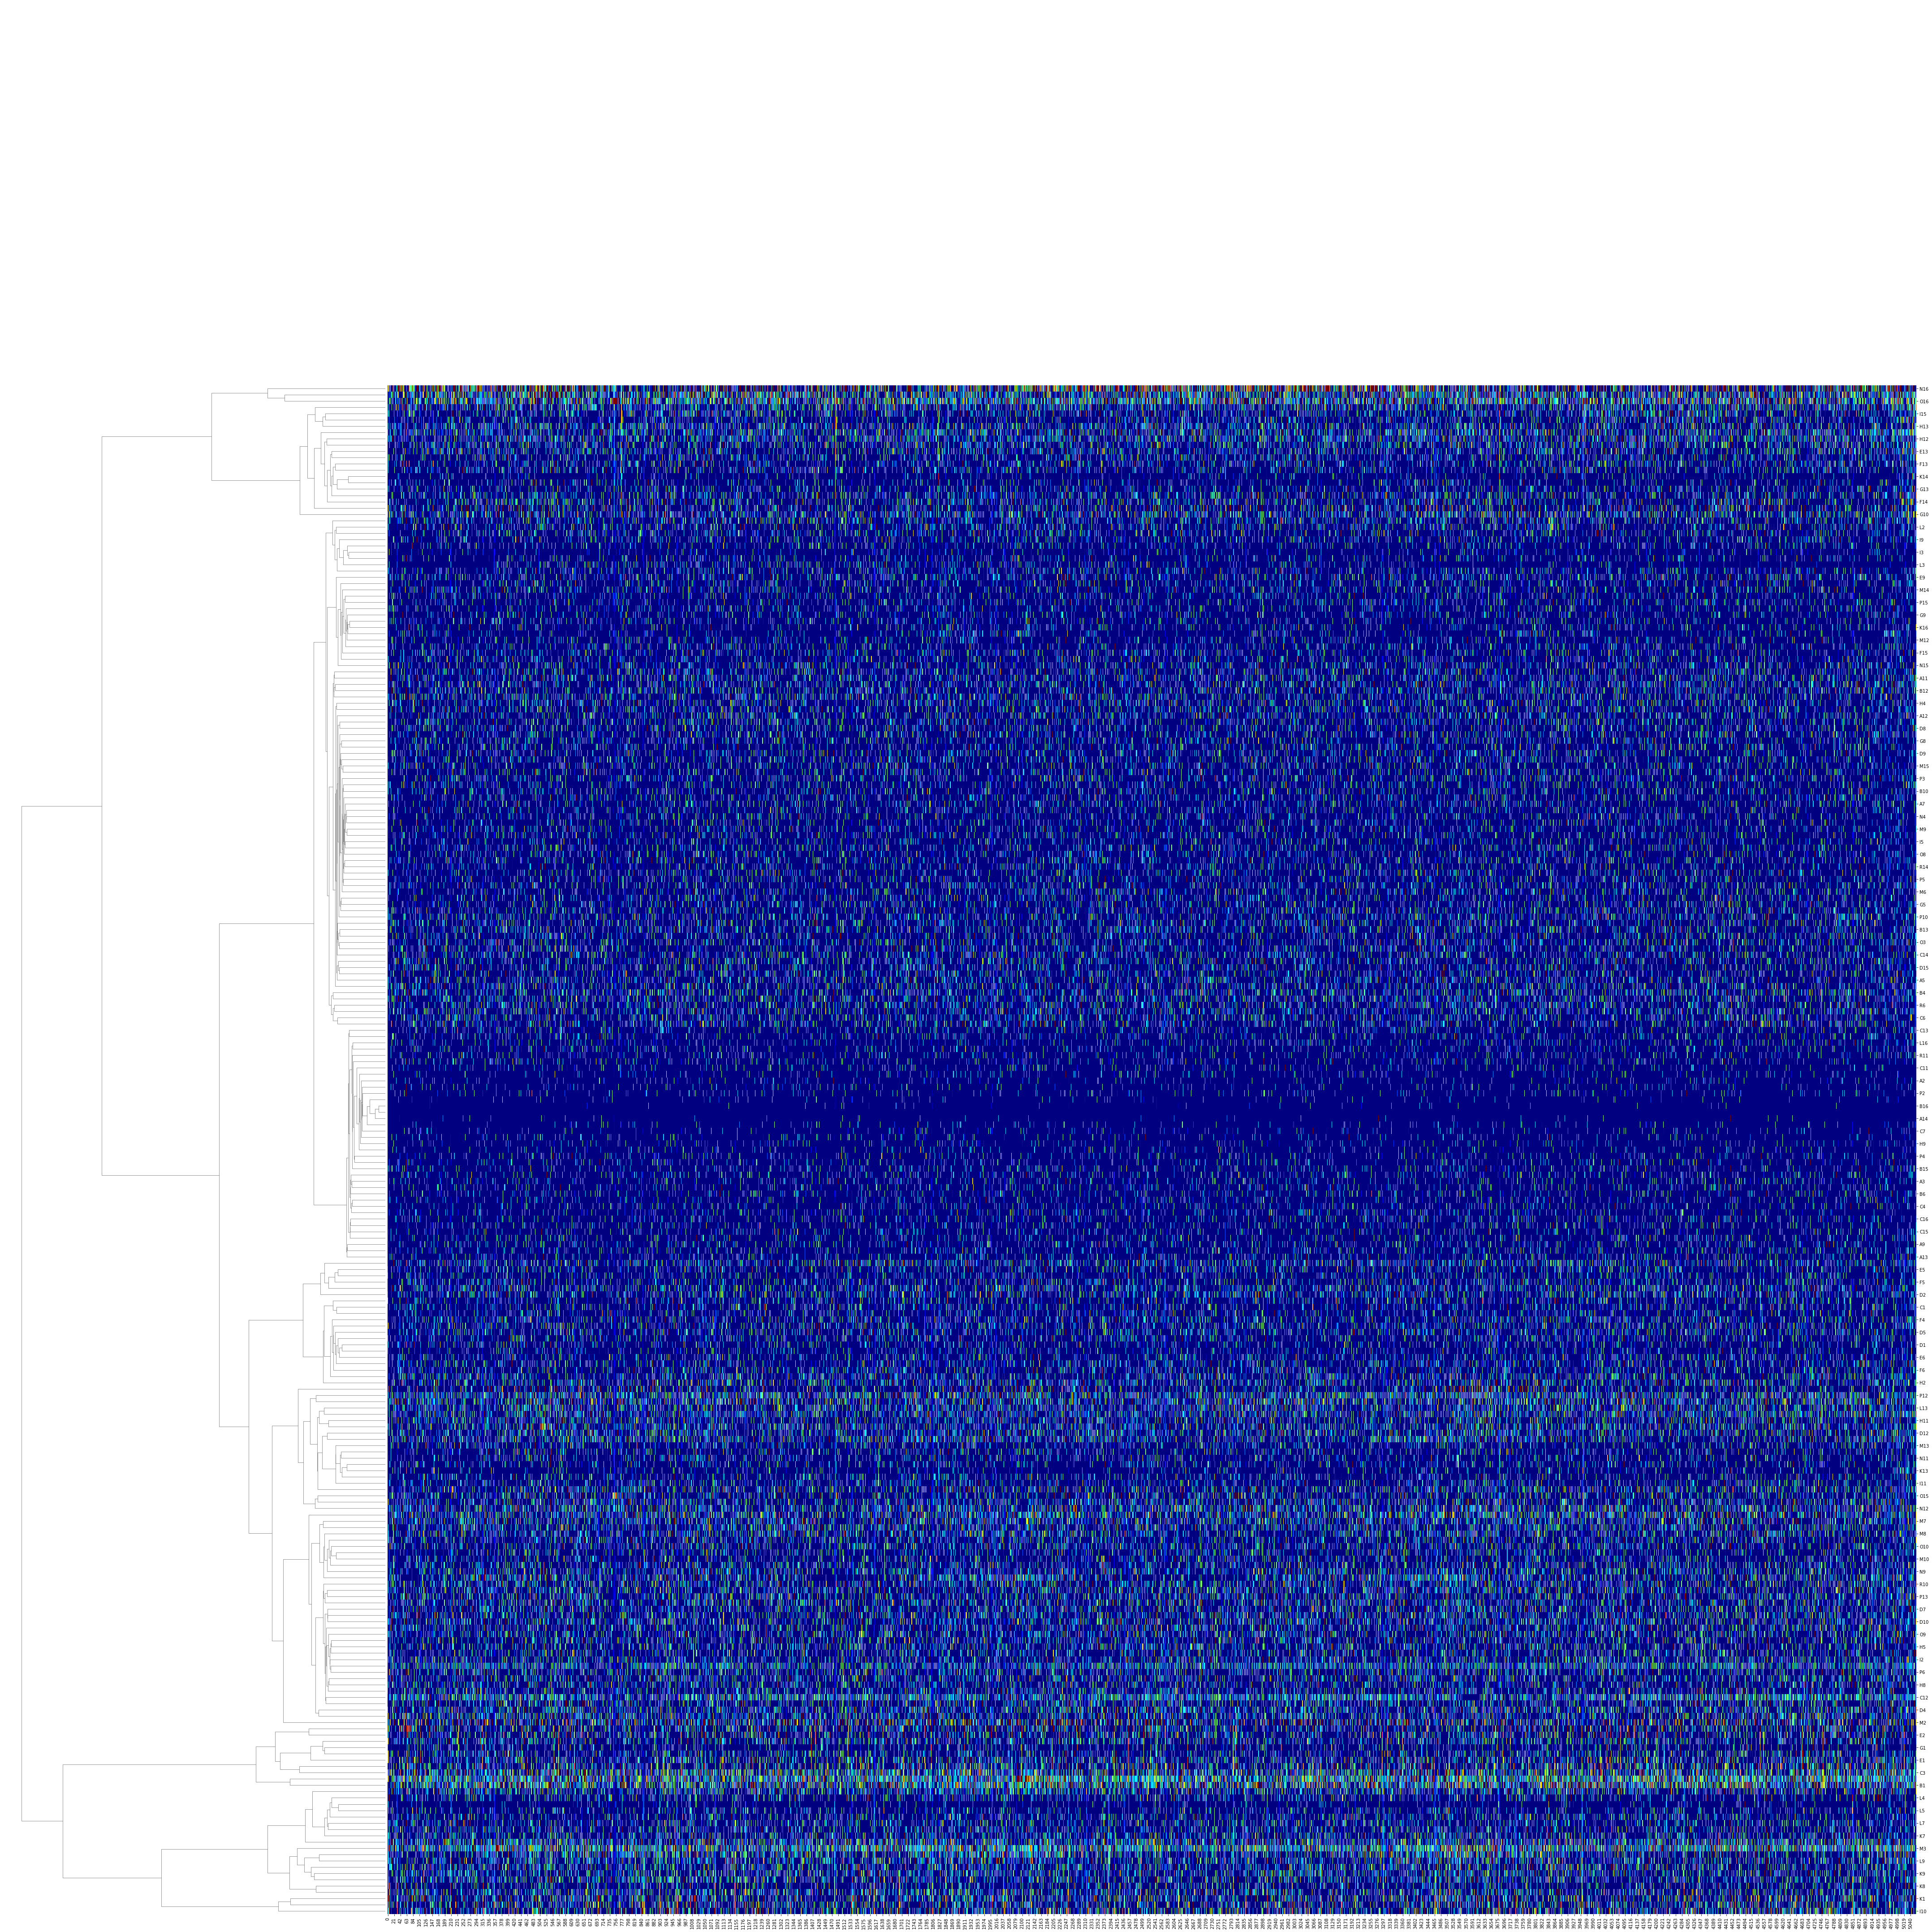

In [76]:


fig = sns.clustermap(df_t, row_linkage=linkage_matrix, col_cluster=False, cmap="jet", method='complete', metric='correlation', standard_scale=True, figsize=(60,60), cbar_pos=None)
#fig.savefig('Cluster_15052021__clustering_complete_correlation.png', bbox_inches='tight', dpi=300)



In [77]:
from scipy.cluster.hierarchy import cophenet, dendrogram
from scipy.spatial.distance import pdist


<Figure size 1800x720 with 0 Axes>

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

Text(0.5, 0, 'sample index')

Text(0, 0.5, 'distance')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [50.0, 50.0, 65.0, 65.0],
  [35.0, 35.0, 57.5, 57.5],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [150.0, 150.0, 165.0, 165.0],
  [130.0, 130.0, 157.5, 157.5],
  [143.75, 143.75, 175.0, 175.0],
  [110.0, 110.0, 159.375, 159.375],
  [134.6875, 134.6875, 185.0, 185.0],
  [90.0, 90.0, 159.84375, 159.84375],
  [75.0, 75.0, 124.921875, 124.921875],
  [99.9609375, 99.9609375, 195.0, 195.0],
  [46.25, 46.25, 147.48046875, 147.48046875],
  [96.865234375, 96.865234375, 205.0, 205.0],
  [12.5, 12.5, 150.9326171875, 150.9326171875],
  [225.0, 225.0, 235.0, 235.0],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [262.5, 262.5, 285.0, 285.0],
  [245.0, 245.0, 273.75, 273.75],
  [259.375, 259.375, 295.0, 295.0],
  [230.0, 230.0, 277.1875, 277.1875],
  [215.0, 215.0, 253.59375, 253.59375],
  [335.0, 335.0, 345

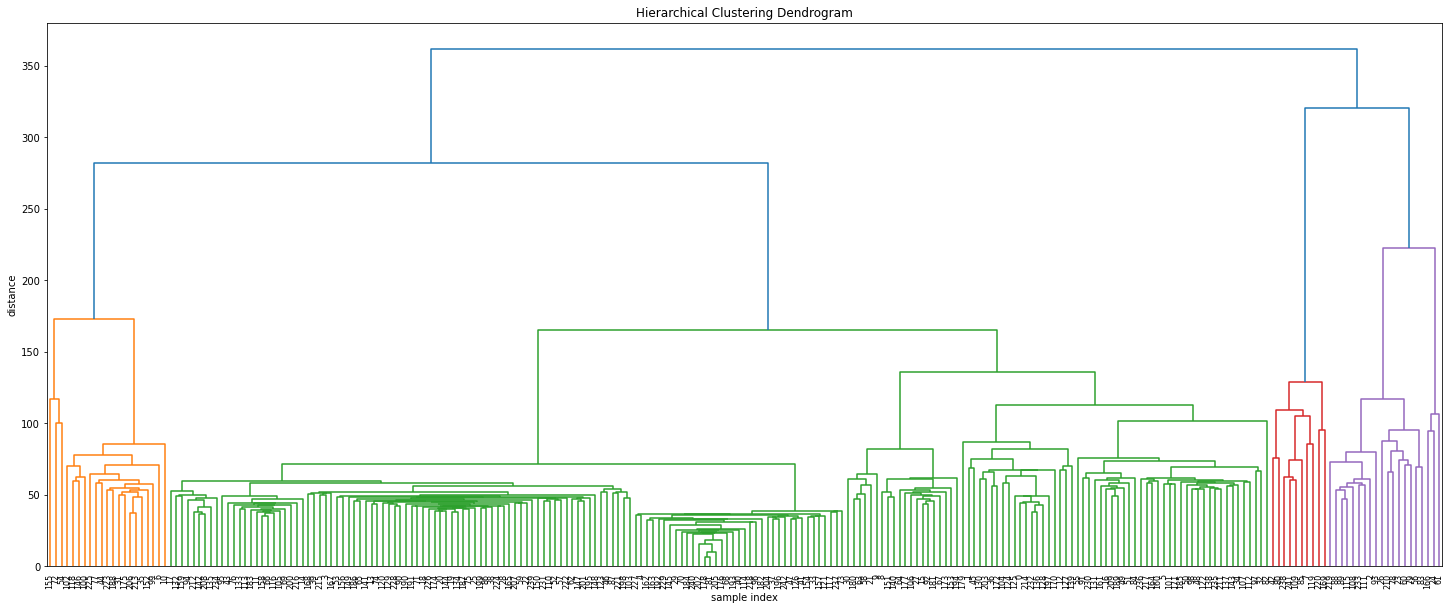

In [78]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# color threshold is automatically picked at 70% of the final distance

In [133]:
df_t.iloc[2]

0       0
1       0
2       0
3       1
4       0
       ..
2395    0
2396    0
2397    0
2398    0
2399    2
Name: F11, Length: 2400, dtype: int64

In [79]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

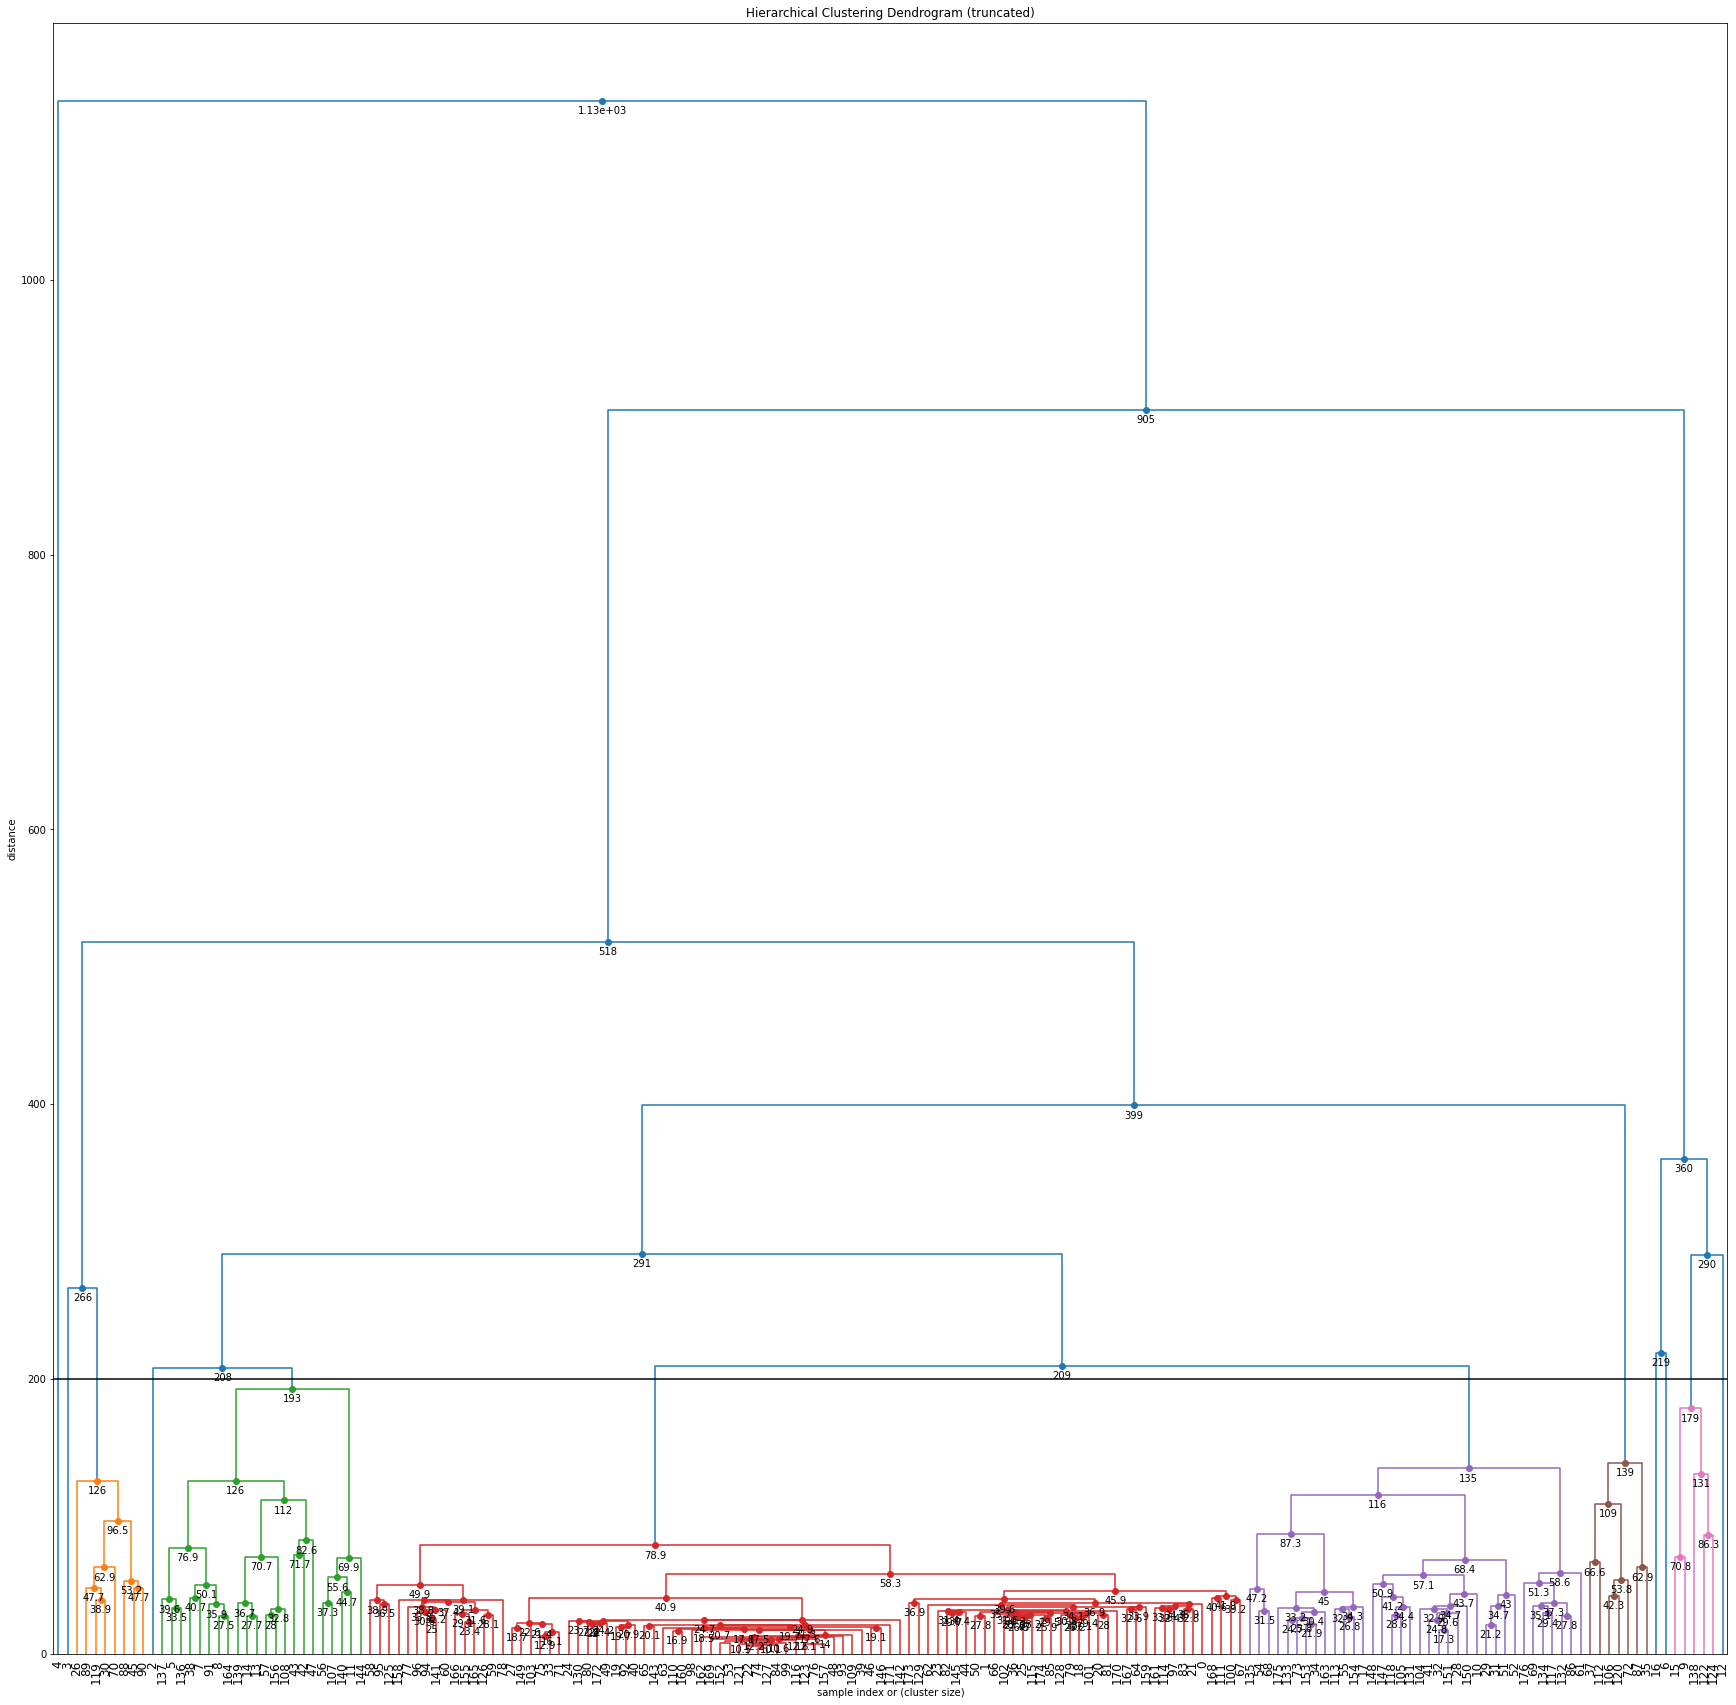

In [97]:
fig, ax = plt.subplots(1,1, figsize = (30,30))

ax = fancy_dendrogram(
    linkage_matrix,
    #truncate_mode='lastp',
    #p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d = 200
)
plt.show()

fig.savefig('Cluster_15052021__dendrogram.png', bbox_inches= 'tight', dpi=300)

In [80]:
from scipy.cluster.hierarchy import fcluster
max_d = 110
clusters = fcluster(linkage_matrix, max_d, criterion='distance')
clusters

array([ 6,  6, 10,  4,  4,  7,  3,  8,  5,  5,  3,  4,  6,  4,  4,  5,  7,
        4,  4,  4,  4,  5,  4, 11, 12,  4, 11,  5,  4,  4,  5,  3,  7,  4,
        7,  3,  6,  4,  4,  4,  4,  4,  8,  4,  3,  6,  4,  4,  7,  7,  7,
        7,  4,  4,  1,  7, 11,  4,  5,  4, 11, 12,  4,  5,  5,  4,  4,  5,
        4,  4,  4,  4,  1,  4,  4,  4,  4,  3, 11, 11,  8,  4,  7, 11,  7,
        8,  4,  4, 10, 10,  4,  7,  5, 10,  4,  4,  4,  7,  7,  3,  3,  7,
        3,  4,  6,  4,  5,  7, 10,  8,  4, 10,  7,  4,  4, 10,  4,  4,  3,
        8,  4,  4,  7,  4,  6,  6,  4,  6,  6,  4,  6,  7,  4,  4,  4,  4,
        6,  7,  7,  6,  5,  4,  4,  7,  4,  4,  3,  4,  4,  4,  4,  5,  3,
        5,  4,  2,  4,  4,  4,  4,  7,  7,  4,  4,  7,  4, 12,  4,  4,  9,
        6,  7,  6,  5,  4,  3,  4,  5,  4,  6,  5,  5,  4,  4,  4,  7,  4,
        4,  3,  7,  4,  4,  4,  4,  5,  4,  4,  6,  4,  4,  4,  4,  4,  6,
        4,  4,  3,  4,  4,  7, 11,  7,  4,  3,  6,  4,  4,  7,  4, 10,  9,
        4,  4,  3,  4,  3

In [81]:
k=3
clusters = fcluster(linkage_matrix, k, criterion='maxclust')

In [82]:
# small function that takes 

cluster_dict = {}
for i in range(0, len(clusters)):
    key = np.asarray(df_t.index)[i]
    cluster = clusters[i]
    cluster_dict[key]=cluster


In [83]:
cluster_dict

{'R12': 1,
 'P12': 1,
 'K7': 3,
 'B12': 1,
 'H16': 1,
 'D7': 1,
 'F10': 1,
 'E3': 2,
 'D3': 1,
 'D2': 1,
 'G10': 1,
 'G9': 1,
 'O15': 1,
 'G8': 1,
 'N15': 1,
 'D1': 1,
 'O10': 1,
 'R2': 1,
 'G4': 1,
 'M9': 1,
 'N4': 1,
 'G3': 1,
 'H6': 1,
 'K11': 3,
 'K10': 3,
 'O8': 1,
 'M3': 3,
 'E4': 1,
 'P8': 1,
 'I16': 1,
 'F8': 1,
 'F13': 1,
 'G7': 1,
 'P9': 1,
 'F9': 1,
 'G13': 1,
 'H11': 1,
 'A3': 1,
 'O1': 1,
 'A11': 1,
 'H9': 1,
 'B3': 1,
 'F1': 2,
 'E10': 1,
 'G11': 1,
 'P11': 1,
 'R4': 1,
 'M5': 1,
 'H5': 1,
 'N10': 1,
 'O9': 1,
 'N9': 1,
 'O3': 1,
 'H4': 1,
 'O16': 1,
 'O2': 1,
 'K8': 3,
 'N2': 1,
 'F5': 1,
 'G5': 1,
 'K9': 3,
 'I10': 3,
 'N3': 1,
 'F2': 1,
 'F4': 1,
 'D8': 1,
 'K16': 1,
 'G6': 1,
 'C7': 1,
 'G15': 1,
 'A2': 1,
 'B10': 1,
 'N14': 1,
 'A13': 1,
 'B2': 1,
 'A10': 1,
 'M14': 1,
 'H12': 1,
 'L9': 3,
 'K6': 3,
 'E2': 2,
 nan: 1,
 'M2': 1,
 'L8': 3,
 'N1': 1,
 'E1': 2,
 'R14': 1,
 'R6': 1,
 'L4': 3,
 'K5': 3,
 'P14': 1,
 'M7': 1,
 'H1': 1,
 'L1': 3,
 'I9': 1,
 'E9': 1,
 'E16': 1

In [84]:
for key in cluster_dict:
    
    completeframe.loc[(completeframe['channellabel']==str(key)), 'cluster'] = cluster_dict[key]
    

In [76]:
completeframe['cluster']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
597    1.0
598    1.0
599    1.0
600    1.0
601    1.0
Name: cluster, Length: 602, dtype: float64

In [77]:
completeframe_with_cluster = completeframe

In [78]:
completeframe_with_cluster.to_pickle(str('DF_' + filebase + '_' + 'complete_with_cluster') + '_df.pkl')

In [79]:
completeframe_with_cluster

unit_ids  unit_index  max_channel channellabel  n_spikes  firing_rate  \
0           0         0.0          2.0          O10      20.0     0.153846   
1           1         1.0          2.0          O10     160.0     1.230770   
2          10         2.0         53.0           H4     102.0     0.784616   
3         100         3.0        141.0          E12     535.0     4.115386   
4         101         4.0        104.0           M7     328.0     2.523078   
..        ...         ...          ...          ...       ...          ...   
597        95       597.0         64.0          R14     492.0     3.784617   
598        96       598.0         64.0          R14     217.0     1.669231   
599        97       599.0        104.0           M7      12.0     0.092308   
600        98       600.0        104.0           M7     552.0     4.246155   
601        99       601.0        104.0           M7     263.0     2.023078   

        layer  ft_peak_to_valley  ft_halfwidth  ft_peak_trough_ratio  \
0    layer2-3            0.00080       0.00028             -0.436335   
1    layer2-3            0.00096       0.00040             -0.198452   
2    layer5-6            0.00104       0.00040             -0.290054   
3    layer5-6            0.00032       0.00032             -0.232855   
4      layer4            0.00132       0.00596              0.440375   
..        ...                ...           ...                   ...   
597  layer2-3            0.00076       0.00028             -0.309199   
598  layer2-3            0.00168       0.00060             -0.271205   
599    layer4            0.00336       0.00596              0.410484   
600    layer4            0.00344       0.00504              0.371611   
601    layer4            0.00152       0.00596              0.753285   

     ft_repolarization_slope  ft_recovery_slope  \
0                   0.049073          -0.008003   
1                   0.040606          -0.001736   
2                   0.034879          -0.005049   
3                   0.096708          -0.002211   
4                        NaN          -0.012390   
..                       ...                ...   
597                 0.050463          -0.008118   
598                 0.033614          -0.002895   
599                      NaN          -0.012281   
600                      NaN          -0.000699   
601                      NaN          -0.009628   

                                      file subrecording recordingdate  \
0    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
1    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
2    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
3    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
4    cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
..                                     ...          ...           ...   
597  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
598  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
599  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
600  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   
601  cortex_div4_hCSF_ID039_nodrug_spont_1    sec_0-130      20210510   

     unit_ids2  cluster  
0            0      1.0  
1            1      1.0  
2           10      1.0  
3          100      1.0  
4          101      1.0  
..         ...      ...  
597         95      1.0  
598         96      1.0  
599         97      1.0  
600         98      1.0  
601         99      1.0  

[602 rows x 17 columns]

In [85]:
def spiketrains_update_to_seconds(spiketrain, tick=40, scale_factor_for_second=1e-06):
    '''
    Function that converts a spiketrain dictionary from the data ticks
    to seconds
    
    '''
    spiketrains_seconds={}
    for key in spiketrain:
        spikelist=[]
        for i in spiketrain[key]:
            spikelist.append(i*scale_factor_for_second*tick)
        spiketrains_seconds[key] = spikelist
        
    return spiketrains_seconds

In [86]:
c, coph_dists = cophenet(linkage_matrix, pdist(df_t))
c

0.7304990759532853

In [87]:
coph_dists

array([ 74.80068754, 361.78771725, 165.09357748, ..., 361.78771725,
        35.60296938, 361.78771725])

In [88]:
length_recording

253.0

### Create the same clustering just for bursts

In [ ]:
# bin the burstdictionaries per channel
binsize = 50 # in miliseconds
scale_factor_for_milisecond = 1e-03
binned_spike_dictionary = {}


bins= np.arange(0, length_recording*1000+binsize, binsize) # times 1000 to get the miliseconds
for key in:
    x = np.asarray(st_channel[key])*scale_factor_for_milisecond*tick
    binned_channel = np.histogram(x, bins)
    binned_spike_dictionary[key]  = binned_channel[0]

In [125]:
burststart_end_dic

{'R12': [],
 'R4': [(278680, 354680), (62549400, 62877400), (68718360, 68773080)],
 'F11': [(171680, 355760),
  (16306000, 16396800),
  (16708080, 16881680),
  (17188800, 17292600),
  (22767320, 23214560),
  (29958920, 36456040),
  (59723640, 60017160),
  (63156760, 63429280),
  (63567640, 63703640),
  (65100720, 65196960),
  (66822920, 66997960),
  (69083920, 69332080),
  (69803480, 69908960),
  (70207440, 70307720),
  (70903240, 71007520),
  (71579000, 71678200),
  (76401640, 82565280),
  (82794480, 83051160),
  (105388200, 105514240),
  (106195800, 106303720),
  (108990480, 109179240),
  (109961840, 110537400),
  (112158200, 112557880),
  (113106960, 113223200),
  (116242640, 116430840),
  (118733520, 119050760),
  (119550520, 119630600)],
 'D12': [(30013480, 30159880),
  (30289080, 32250720),
  (32422920, 32523640),
  (32644840, 33310560),
  (33687800, 34497400),
  (34733480, 34916120),
  (76696560, 77970560),
  (78105120, 78430800),
  (78607800, 80141640),
  (80300920, 80974800),


In [88]:
length_recording

116.0

In [108]:
full_spike_list

[60.0,
 273.12,
 297.6,
 1006.5999999999999,
 1201.68,
 1385.1599999999999,
 1981.24,
 2710.56,
 2814.5600000000004,
 3210.3199999999997,
 3220.84,
 4748.0,
 4834.360000000001,
 5219.44,
 5394.76,
 5446.84,
 5552.240000000001,
 5949.64,
 6011.92,
 6071.080000000001,
 6524.0,
 6556.599999999999,
 6583.959999999999,
 7006.0,
 7418.12,
 7420.6,
 7575.92,
 7748.04,
 7814.92,
 8304.72,
 8736.52,
 8748.56,
 8918.08,
 9266.68,
 9355.560000000001,
 9418.92,
 9770.800000000001,
 9858.64,
 9892.4,
 9927.44,
 11157.84,
 11952.439999999999,
 12212.119999999999,
 12632.119999999999,
 12740.96,
 12845.36,
 13087.52,
 13335.720000000001,
 13435.2,
 13503.0,
 13833.48,
 13856.36,
 14095.76,
 14380.240000000002,
 14422.880000000001,
 15091.6,
 15144.960000000001,
 15225.04,
 15333.600000000002,
 15448.800000000001,
 15629.8,
 15698.92,
 15901.44,
 16312.6,
 16969.6,
 17203.52,
 17579.88,
 18351.24,
 18621.68,
 19060.24,
 19186.960000000003,
 19254.4,
 19328.04,
 20393.08,
 20649.0,
 20690.72,
 20999.56

In [90]:
# get a 1-D array with every detected spike
full_spike_list = []
for key in st_channel:
    x = list(np.asarray(st_channel[key])*scale_factor_for_milisecond*tick)
    full_spike_list = full_spike_list + x
full_spikes = sorted(full_spike_list)
    
    

In [ ]:
full_spike_list

In [91]:
st_channel_seconds = spiketrains_update_to_seconds(st_channel)
array = np.asarray(list(st_channel_seconds.values()))

In [92]:
filebase

'hCSF_child_20min_spont0001'

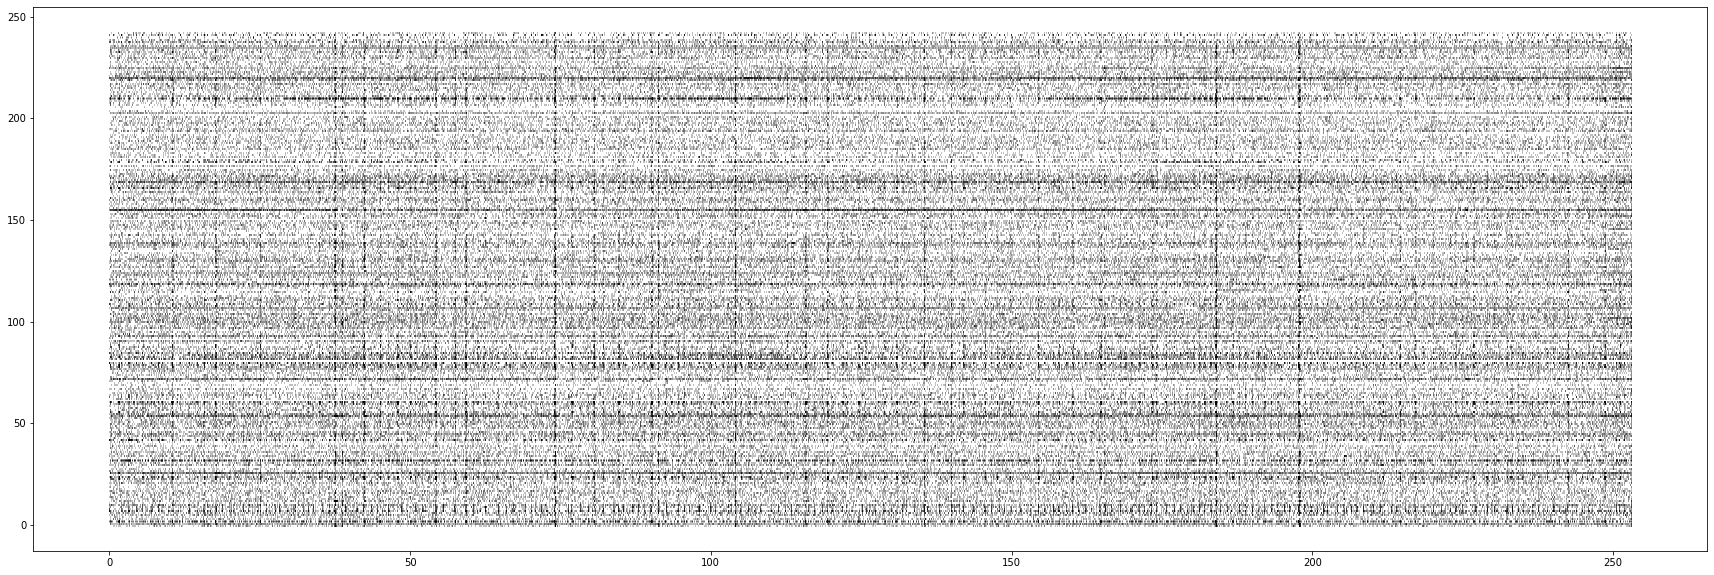

In [93]:
fig, ax = plt.subplots(1,1, figsize=(30,10))

ax = plt.eventplot(array, linewidths=0.5, linelengths=0.5, colors='black')

fig.savefig(str(filebase)+'_rasterplot.png', dpi=300)

In [94]:
os.getcwd()

'D:\\Files_Reutlingen_Jenny\\main_191021\\_output_Spikesorting_30042021_hCSF_child_20min_spont0001_spikesorting'

In [95]:
binsize = 3 #ms
bins= np.arange(0, length_recording*1000+binsize, binsize)

In [96]:
#x = np.asarray(st_channel['O4'])*scale_factor_for_milisecond*tick

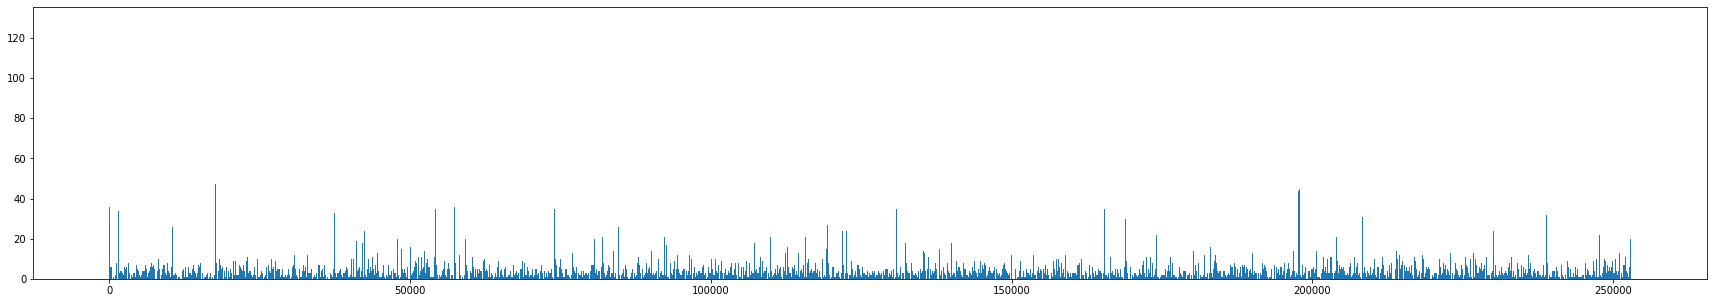

In [97]:
# plots the binned spikes
fig, ax = plt.subplots(1,1, figsize = (30,5))
ax = plt.hist(full_spikes, bins)


In [99]:
full_spikes_binned = np.histogram(full_spikes, bins)[0]

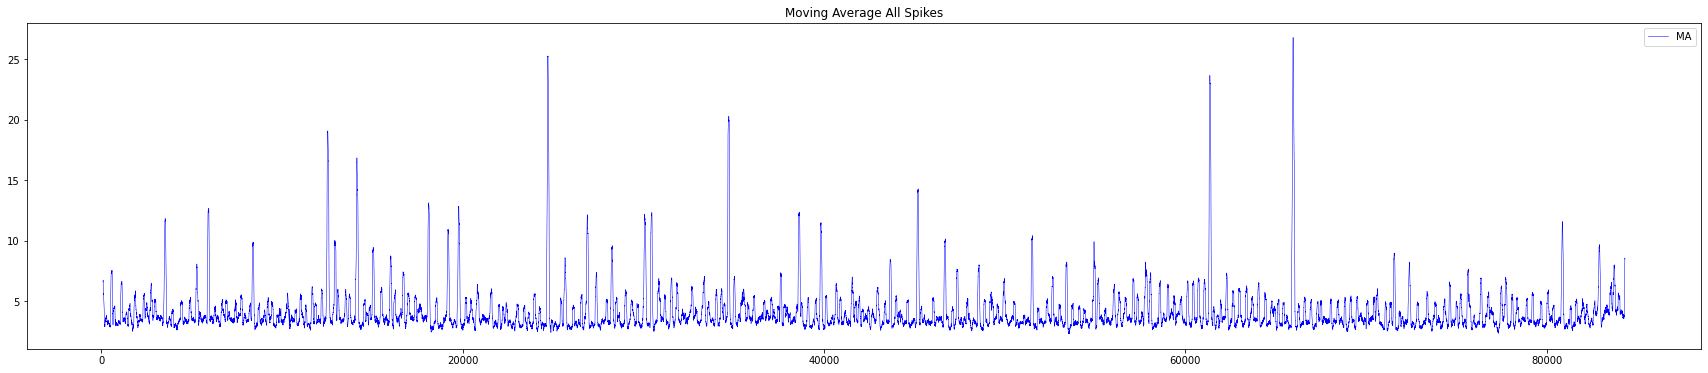

In [100]:
df= pd.DataFrame({'Spikes':full_spikes_binned}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["MA"] = df.Spikes.rolling(100).mean()
df['STD'] = df.Spikes.std()
df['2*STD'] = df.Spikes.std()*2
fig = df[['MA']].plot(color='b', linewidth=.5, figsize=(30,6), title="Moving Average All Spikes")

#fig.savefig('spikes_smoothed_MA.png', dpi=300)

In [101]:
df

Spikes    MA       STD     2*STD
0           0   NaN  4.767168  9.534336
1           5   NaN  4.767168  9.534336
2           4   NaN  4.767168  9.534336
3           3   NaN  4.767168  9.534336
4           2   NaN  4.767168  9.534336
...       ...   ...       ...       ...
84329      13  8.09  4.767168  9.534336
84330      28  8.33  4.767168  9.534336
84331      14  8.47  4.767168  9.534336
84332      13  8.58  4.767168  9.534336
84333       0  8.50  4.767168  9.534336

[84334 rows x 4 columns]

In [102]:
ma_array = np.asarray(df['MA'])
std_array = np.asarray(df['STD'])
std_array_2 = np.asarray(df['2*STD'])

Text(0.5, 1.0, 'Smoothed Spikes per 3ms bin')

Text(0.5, 0, 'Bins 3ms')

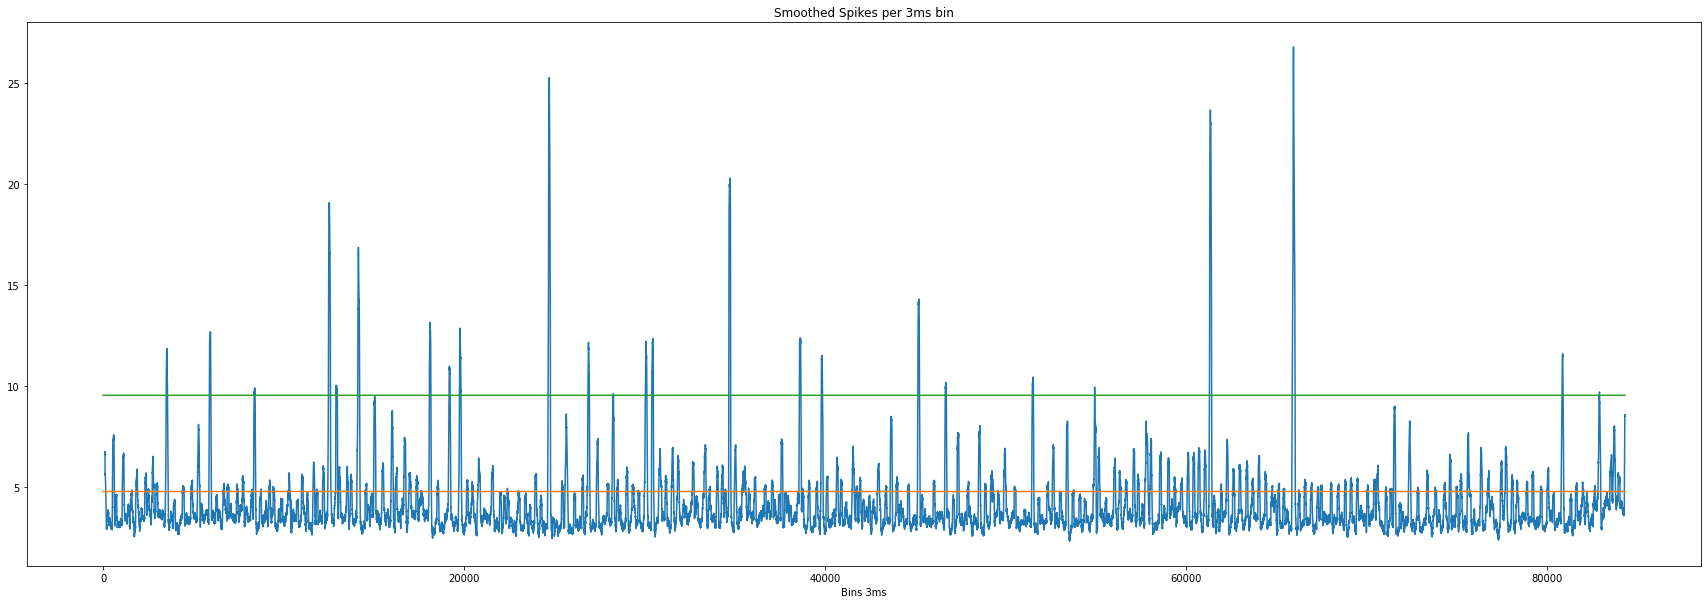

In [103]:
fig, ax = plt.subplots(1,1, figsize=(30,10))

ax.plot(ma_array)
ax.plot(std_array)
ax.plot(std_array_2)
ax.set_title('Smoothed Spikes per 3ms bin')
ax.set_xlabel('Bins 3ms')

fig.savefig('Smoothed_spikes_per_3ms.png', dpi=300)

In [104]:
df

Spikes    MA       STD     2*STD
0           0   NaN  4.767168  9.534336
1           5   NaN  4.767168  9.534336
2           4   NaN  4.767168  9.534336
3           3   NaN  4.767168  9.534336
4           2   NaN  4.767168  9.534336
...       ...   ...       ...       ...
84329      13  8.09  4.767168  9.534336
84330      28  8.33  4.767168  9.534336
84331      14  8.47  4.767168  9.534336
84332      13  8.58  4.767168  9.534336
84333       0  8.50  4.767168  9.534336

[84334 rows x 4 columns]

In [105]:
df.iloc[134]['MA']

5.38

In [106]:
df.loc['MA'] > df.iloc[i]['2*STD']) & (df.iloc[i-1]['MA'] <= df.iloc[i-1]['2*STD']):
        df['crossing']=1

SyntaxError: unmatched ')' (<ipython-input-106-5c7af08caef0>, line 1)

In [110]:
# returns the crossings in miliseconds for crossing above the std and crossing below the std.

network_fr_std_dic = {}
cross_up =[]
cross_down =[]


for i in range(1, len(df)):
    if (df.iloc[i]['MA'] > df.iloc[i]['2*STD']) & (df.iloc[i-1]['MA'] <= df.iloc[i-1]['2*STD']):
        time = i*3 #check the binsize of the MA
        cross_up.append(time)
    if (df.iloc[i]['MA'] < df.iloc[i]['2*STD']) & (df.iloc[i-1]['MA'] >= df.iloc[i-1]['2*STD']):
        time = i*3 # check the binsize of the MA
        cross_down.append(time)
        
network_fr_std_dic['cross_up'] = np.asarray(cross_up)
network_fr_std_dic['cross_down'] = np.asarray(cross_down)


In [111]:
network_fr_std_dic

{'cross_up': array([ 10497,  17664,  25131,  37467,  38718,  42351,  54249,  57513,
         59250,  73992,  80607,  84843,  90165,  91227, 104019, 115749,
        119403, 135462, 140016, 140022, 154479, 164820, 183933, 197694,
        242532, 248763]),
 'cross_down': array([ 10719,  17925,  25278,  37803,  38922,  42669,  54522,  57708,
         59517,  74376,  80853,  84855,  90405,  91485, 104334, 116010,
        119622, 135744, 140019, 140202, 154671, 164868, 184290, 198156,
        242718, 248796])}

In [112]:
len(cross_up)

26

In [204]:
type(df.iloc[0]['MA'])


numpy.float64

In [199]:
df.loc[(df['MA']> df['2*STD']), 'crossing']=1

In [201]:
df.loc[(df['crossing']==1)]

Spikes     MA       STD      2*STD  crossing
2204       43  14.87  7.295174  14.590348       1.0
2205       33  15.18  7.295174  14.590348       1.0
2206       45  15.63  7.295174  14.590348       1.0
2207       46  16.09  7.295174  14.590348       1.0
2208       49  16.58  7.295174  14.590348       1.0
...       ...    ...       ...        ...       ...
38676       2  16.49  7.295174  14.590348       1.0
38677       2  15.97  7.295174  14.590348       1.0
38678       2  15.62  7.295174  14.590348       1.0
38679       1  15.31  7.295174  14.590348       1.0
38680       2  14.84  7.295174  14.590348       1.0

[1394 rows x 5 columns]

In [187]:
df.iloc[0]['crossing']=1

In [191]:
df

Spikes    MA       STD      2*STD
0           2   NaN  7.295174  14.590348
1           1   NaN  7.295174  14.590348
2           0   NaN  7.295174  14.590348
3           0   NaN  7.295174  14.590348
4           0   NaN  7.295174  14.590348
...       ...   ...       ...        ...
43329      26  8.51  7.295174  14.590348
43330      18  8.68  7.295174  14.590348
43331      30  8.94  7.295174  14.590348
43332      29  9.23  7.295174  14.590348
43333       0  9.23  7.295174  14.590348

[43334 rows x 4 columns]

In [ ]:
node